In [1]:
import os, sys, time

sys.path
sys.path.append('./')

import numpy as np
from astropy import wcs
from astropy.io import fits
import csv
import nbimporter

import matplotlib
matplotlib.use('PDF')
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
# import aplpy
from matplotlib.ticker import ScalarFormatter
from scipy.interpolate import interp1d

import function as f
import gauss as g
from main import spectraAna

### **STEP 1**. Open FITS image cube

In [10]:
## Open FITS image cube
fitscubename = '/Users/tcc/data/cool_spw0.fits'
s = spectraAna(fitscubename = fitscubename)
s.readfits(verbose = False)

naxis1   = s.naxis1
naxis2   = s.naxis2
ctype3   = s.ctype3
naxis3   = s.naxis3
crpix3   = s.crpix3
cdelt3   = s.cdelt3
crval3   = s.crval3 
restfreq = s.restfreq
cube     = s.cube  ## all intensity 

c = 299792458

## Create the frequency array based on the third axis
if ctype3 == 'VELO-LSR':
    velocity_array = np.zeros( naxis3 )
    velocity_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3
    
    freq_array = restfreq * (1 - velocity_array / c)

elif ctype3 == 'FREQ':
    freq_array = np.zeros( naxis3 )
    freq_array = crval3 + ( np.arange(naxis3) + 1 - crpix3 ) * cdelt3
    velocity_array = c * (1 - (freq_array / restfreq) )

In [11]:
print(restfreq)

217104919000.0


In [12]:
print(velocity_array/1e3)

[-1415.2470592  -1413.67609312 -1412.10512704 ...   986.76007911
   988.33104519   989.90201127]


### **STEP 2**.  Fitting the spectra using `gausspy`.
***STEP 2-1.*** Fit

In [5]:
rms_spw0 = 0.0018148618
rms_spw1 = 0.0017738817
rms_spw2 = 0.0025416217
rms_spw3 = 0.0018573649


# FITS -> Gausspy set
g.transdata(
             cube = cube, velo=velocity_array, freq=freq_array,
             spw_id = '0',
             rms = rms_spw0, base = 'velo',
             xrange1 = 0, xrange2 = naxis1,
             yrange1 = 0, yrange2 = naxis2
            )

g.decompose(spw_id = '0')
#g.plotfig()

using 6 out of 8 cpus
   ---->   0
   ---->     ---->    12
   ---->  
   ---->      ---->   

  0%|                                              | 0.00/9.12k [00:00<?, ?it/s]

   ---->  3 4
 56




  0%|                                    | 1.00/9.12k [00:10<27:19:32, 10.8s/it]

   ---->   7


  0%|                                    | 2.00/9.12k [00:12<13:17:02, 5.25s/it]

   ---->   8


  0%|                                     | 3.00/9.12k [00:12<7:49:34, 3.09s/it]

   ---->   9


  0%|                                     | 4.00/9.12k [00:12<5:02:16, 1.99s/it]

   ---->   10


  0%|                                     | 5.00/9.12k [00:13<3:33:51, 1.41s/it]

   ---->   11


  0%|                                     | 6.00/9.12k [00:13<2:40:26, 1.06s/it]

   ---->   12


  0%|                                    | 7.00/9.12k [00:25<11:14:45, 4.44s/it]

   ---->   13


  0%|                                     | 8.00/9.12k [00:27<9:22:30, 3.71s/it]

   ---->   14


  0%|                                     | 9.00/9.12k [00:27<6:48:40, 2.69s/it]

   ---->   15


  0%|                                     | 10.0/9.12k [00:29<6:28:06, 2.56s/it]

   ---->   16


  0%|                                    | 11.0/9.12k [00:41<13:25:56, 5.31s/it]

   ---->   17


  0%|                                     | 12.0/9.12k [00:42<9:50:16, 3.89s/it]

   ---->   18


  0%|                                     | 13.0/9.12k [00:42<7:13:01, 2.85s/it]

   ---->   19
   ---->  

  0%|                                     | 14.0/9.12k [00:42<5:09:22, 2.04s/it]

 20


  0%|                                     | 15.0/9.12k [00:42<3:44:00, 1.48s/it]

   ---->   21
   ---->  

  0%|                                     | 16.0/9.12k [00:45<4:19:01, 1.71s/it]

 22


  0%|                                    | 17.0/9.12k [00:54<10:16:11, 4.06s/it]

   ---->   23


  0%|                                     | 18.0/9.12k [00:57<9:11:47, 3.64s/it]

   ---->   24


  0%|                                     | 19.0/9.12k [00:59<7:41:37, 3.04s/it]

   ---->   25


  0%|                                     | 20.0/9.12k [00:59<5:49:57, 2.31s/it]

   ---->   26
   ---->   27


  0%|                                     | 22.0/9.12k [01:03<5:29:57, 2.18s/it]

   ---->   28


  0%|                                    | 23.0/9.12k [01:13<10:17:20, 4.07s/it]

   ---->   29


  0%|                                     | 24.0/9.12k [01:13<7:45:39, 3.07s/it]

   ---->   30


  0%|                                     | 25.0/9.12k [01:15<6:59:41, 2.77s/it]

   ---->   31
   ---->  

  0%|                                     | 26.0/9.12k [01:15<5:12:31, 2.06s/it]

 32


  0%|                                     | 27.0/9.12k [01:18<5:19:57, 2.11s/it]

   ---->   33


  0%|                                     | 28.0/9.12k [01:25<8:44:33, 3.46s/it]

   ---->   34


  0%|                                     | 29.0/9.12k [01:26<6:54:58, 2.74s/it]

   ---->   35


  0%|                                     | 30.0/9.12k [01:29<7:48:52, 3.10s/it]

   ---->   36


  0%|▏                                    | 31.0/9.12k [01:31<6:38:16, 2.63s/it]

   ---->   37
   ---->   38


  0%|▏                                    | 33.0/9.12k [01:36<6:39:54, 2.64s/it]

   ---->   39


  0%|▏                                    | 34.0/9.12k [01:43<8:58:09, 3.55s/it]

   ---->   40


  0%|▏                                    | 35.0/9.12k [01:43<6:48:22, 2.70s/it]

   ---->   41


  0%|▏                                    | 36.0/9.12k [01:44<5:36:11, 2.22s/it]

   ---->   42


  0%|▏                                    | 37.0/9.12k [01:44<4:12:08, 1.67s/it]

   ---->   43


  0%|▏                                    | 38.0/9.12k [01:50<7:22:28, 2.92s/it]

   ---->   44


  0%|▏                                    | 39.0/9.12k [01:55<8:35:31, 3.41s/it]

   ---->   45


  0%|▏                                    | 40.0/9.12k [01:57<7:37:54, 3.03s/it]

   ---->   46


  0%|▏                                    | 41.0/9.12k [01:57<5:45:48, 2.29s/it]

   ---->   47


  0%|▏                                    | 42.0/9.12k [01:59<5:25:41, 2.15s/it]

   ---->   48


  0%|▏                                    | 43.0/9.12k [02:02<5:52:38, 2.33s/it]

   ---->   49


  0%|▏                                    | 44.0/9.12k [02:07<7:44:34, 3.07s/it]

   ---->   50


  0%|▏                                    | 45.0/9.12k [02:11<8:50:09, 3.51s/it]

   ---->   51
   ---->   52


  1%|▏                                    | 47.0/9.12k [02:14<6:08:17, 2.44s/it]

   ---->   53


  1%|▏                                    | 48.0/9.12k [02:14<4:45:57, 1.89s/it]

   ---->   54
   ---->  

  1%|▏                                    | 49.0/9.12k [02:15<4:09:04, 1.65s/it]

 55


  1%|▏                                    | 50.0/9.12k [02:21<7:21:30, 2.92s/it]

   ---->   56


  1%|▏                                    | 51.0/9.12k [02:28<9:45:26, 3.87s/it]

   ---->   57


  1%|▏                                    | 52.0/9.12k [02:29<8:22:43, 3.33s/it]

   ---->   58


  1%|▏                                    | 53.0/9.12k [02:30<6:07:43, 2.43s/it]

   ---->   59


  1%|▏                                    | 54.0/9.12k [02:31<5:09:46, 2.05s/it]

   ---->   60


  1%|▏                                    | 55.0/9.12k [02:32<4:43:08, 1.87s/it]

   ---->   61


  1%|▏                                    | 56.0/9.12k [02:35<5:13:16, 2.07s/it]

   ---->   62


  1%|▏                                    | 57.0/9.12k [02:42<8:46:33, 3.49s/it]

   ---->   63


  1%|▏                                    | 58.0/9.12k [02:44<7:32:50, 3.00s/it]

   ---->   64
   ---->  

  1%|▏                                    | 59.0/9.12k [02:45<6:10:22, 2.45s/it]

 65


  1%|▏                                    | 60.0/9.12k [02:45<4:51:04, 1.93s/it]

   ---->   66


  1%|▏                                    | 61.0/9.12k [02:47<4:41:54, 1.87s/it]

   ---->   67


  1%|▎                                    | 62.0/9.12k [02:48<4:09:29, 1.65s/it]

   ---->   68


  1%|▎                                    | 63.0/9.12k [02:56<8:26:27, 3.36s/it]

   ---->   69


  1%|▎                                    | 64.0/9.12k [02:57<6:42:04, 2.66s/it]

   ---->   70


  1%|▎                                    | 65.0/9.12k [02:58<5:27:29, 2.17s/it]

   ---->   71
   ---->   72


  1%|▎                                    | 67.0/9.12k [03:04<6:26:20, 2.56s/it]

   ---->   73


  1%|▎                                    | 68.0/9.12k [03:04<4:57:56, 1.98s/it]

   ---->   74


  1%|▎                                    | 69.0/9.12k [03:12<8:51:35, 3.53s/it]

   ---->   75


  1%|▎                                    | 70.0/9.12k [03:13<7:13:49, 2.88s/it]

   ---->   76
   ---->  

  1%|▎                                    | 71.0/9.12k [03:14<5:36:09, 2.23s/it]

 77


  1%|▎                                    | 72.0/9.12k [03:15<5:00:42, 1.99s/it]

   ---->   78


  1%|▎                                    | 73.0/9.12k [03:20<7:04:47, 2.82s/it]

   ---->   79


  1%|▎                                    | 74.0/9.12k [03:24<8:28:33, 3.37s/it]

   ---->   80


  1%|▎                                   | 75.0/9.12k [03:46<21:33:47, 8.59s/it]

   ---->   81


  1%|▎                                   | 76.0/9.12k [03:47<16:25:55, 6.54s/it]

   ---->   82


  1%|▎                                   | 77.0/9.12k [03:50<13:35:49, 5.41s/it]

   ---->   83


  1%|▎                                   | 78.0/9.12k [03:57<15:05:50, 6.01s/it]

   ---->   84


  1%|▎                                   | 79.0/9.12k [04:01<13:25:24, 5.35s/it]

   ---->   85


  1%|▎                                   | 80.0/9.12k [04:06<13:05:31, 5.22s/it]

   ---->   86


  1%|▎                                   | 81.0/9.12k [04:12<13:41:41, 5.46s/it]

   ---->   87


  1%|▎                                   | 82.0/9.12k [04:13<10:04:18, 4.01s/it]

   ---->   88


  1%|▎                                    | 83.0/9.12k [04:15<8:55:43, 3.56s/it]

   ---->   89


  1%|▎                                   | 84.0/9.12k [04:23<11:57:43, 4.77s/it]

   ---->   90


  1%|▎                                   | 85.0/9.12k [04:27<11:32:26, 4.60s/it]

   ---->   91


  1%|▎                                   | 86.0/9.12k [04:33<12:25:28, 4.95s/it]

   ---->   92


  1%|▎                                   | 87.0/9.12k [04:44<17:12:48, 6.86s/it]

   ---->   93


  1%|▎                                   | 88.0/9.12k [04:45<12:37:07, 5.03s/it]

   ---->   94


  1%|▎                                   | 89.0/9.12k [04:49<12:01:46, 4.80s/it]

   ---->   95


  1%|▎                                   | 90.0/9.12k [04:55<13:11:10, 5.26s/it]

   ---->   96


  1%|▎                                   | 91.0/9.12k [04:57<10:11:33, 4.07s/it]

   ---->   97


  1%|▎                                   | 92.0/9.12k [05:05<13:03:06, 5.21s/it]

   ---->   98


  1%|▎                                   | 93.0/9.12k [05:15<16:57:28, 6.77s/it]

   ---->   99


  1%|▎                                   | 94.0/9.12k [05:16<12:14:23, 4.88s/it]

   ---->   100


  1%|▍                                   | 95.0/9.12k [05:19<11:31:59, 4.60s/it]

   ---->   101


  1%|▍                                    | 96.0/9.12k [05:20<8:37:48, 3.44s/it]

   ---->   102


  1%|▍                                    | 97.0/9.12k [05:23<7:58:04, 3.18s/it]

   ---->   103


  1%|▍                                    | 98.0/9.12k [05:28<9:31:29, 3.80s/it]

   ---->   104


  1%|▍                                   | 99.0/9.12k [05:42<17:01:33, 6.80s/it]

   ---->   105


  1%|▍                                    | 100/9.12k [05:43<12:42:18, 5.07s/it]

   ---->   106


  1%|▍                                    | 101/9.12k [05:51<14:47:03, 5.90s/it]

   ---->   107


  1%|▍                                    | 102/9.12k [05:57<14:43:13, 5.88s/it]

   ---->   108


  1%|▍                                    | 103/9.12k [06:10<20:26:46, 8.17s/it]

   ---->   109


  1%|▍                                    | 104/9.12k [06:16<18:32:37, 7.41s/it]

   ---->   110


  1%|▍                                    | 105/9.12k [06:23<18:52:27, 7.54s/it]

   ---->   111


  1%|▍                                    | 106/9.12k [06:27<15:31:33, 6.20s/it]

   ---->   112


  1%|▍                                    | 107/9.12k [06:27<11:27:40, 4.58s/it]

   ---->   113


  1%|▍                                    | 108/9.12k [06:31<11:02:05, 4.41s/it]

   ---->   114


  1%|▍                                    | 109/9.12k [06:36<11:06:50, 4.44s/it]

   ---->   115


  1%|▍                                    | 110/9.12k [06:41<11:40:23, 4.67s/it]

   ---->   116


  1%|▍                                    | 111/9.12k [06:49<14:23:20, 5.75s/it]

   ---->   117


  1%|▍                                    | 112/9.12k [06:53<12:31:43, 5.01s/it]

   ---->   118


  1%|▍                                     | 113/9.12k [06:54<9:59:20, 3.99s/it]

   ---->   119


  1%|▍                                    | 114/9.12k [06:59<10:25:51, 4.17s/it]

   ---->   120


  1%|▍                                    | 115/9.12k [07:06<12:47:32, 5.12s/it]

   ---->   121


  1%|▍                                    | 116/9.12k [07:15<15:51:53, 6.35s/it]

   ---->   122


  1%|▍                                    | 117/9.12k [07:26<19:14:43, 7.70s/it]

   ---->   123


  1%|▍                                    | 118/9.12k [07:27<13:52:44, 5.55s/it]

   ---->   124


  1%|▍                                    | 119/9.12k [07:30<12:01:19, 4.81s/it]

   ---->   125


  1%|▌                                     | 120/9.12k [07:30<8:35:40, 3.44s/it]

   ---->   126


  1%|▍                                    | 121/9.12k [07:42<15:14:42, 6.10s/it]

   ---->   127


  1%|▍                                    | 122/9.12k [07:52<18:09:40, 7.27s/it]

   ---->   128


  1%|▍                                    | 123/9.12k [07:58<16:34:43, 6.64s/it]

   ---->   129


  1%|▌                                    | 124/9.12k [08:02<14:54:15, 5.97s/it]

   ---->   130


  1%|▌                                    | 125/9.12k [08:03<11:14:32, 4.50s/it]

   ---->   131


  1%|▌                                     | 126/9.12k [08:03<7:57:25, 3.19s/it]

   ---->   132
   ---->  

  1%|▌                                    | 127/9.12k [08:26<22:24:47, 8.98s/it]

 133
   ---->  

  1%|▌                                    | 128/9.12k [08:31<19:38:24, 7.87s/it]

 134


  1%|▌                                    | 129/9.12k [08:32<14:26:36, 5.79s/it]

   ---->   135
   ---->   136


  1%|▌                                     | 131/9.12k [08:32<8:06:27, 3.25s/it]

   ---->   137


  1%|▌                                    | 132/9.12k [08:44<13:05:17, 5.24s/it]

   ---->   138


  1%|▌                                    | 133/9.12k [08:54<16:29:04, 6.61s/it]

   ---->   139


  1%|▌                                    | 134/9.12k [09:01<16:20:19, 6.55s/it]

   ---->   140


  1%|▌                                    | 135/9.12k [09:02<12:29:35, 5.01s/it]

   ---->   141


  1%|▌                                     | 136/9.12k [09:03<9:48:48, 3.93s/it]

   ---->   142


  2%|▌                                    | 137/9.12k [09:07<10:11:00, 4.08s/it]

   ---->   143


  2%|▌                                     | 138/9.12k [09:10<9:15:30, 3.71s/it]

   ---->   144


  2%|▌                                    | 139/9.12k [09:21<14:41:35, 5.89s/it]

   ---->   145


  2%|▌                                    | 140/9.12k [09:26<13:48:51, 5.54s/it]

   ---->   146


  2%|▌                                    | 141/9.12k [09:28<11:28:18, 4.60s/it]

   ---->   147


  2%|▌                                     | 142/9.12k [09:31<9:59:41, 4.01s/it]

   ---->   148


  2%|▌                                     | 143/9.12k [09:32<7:35:00, 3.04s/it]

   ---->   149


  2%|▌                                    | 144/9.12k [09:39<10:33:40, 4.24s/it]

   ---->   150


  2%|▌                                    | 145/9.12k [09:59<22:07:43, 8.88s/it]

   ---->   151


  2%|▌                                    | 146/9.12k [10:03<18:58:56, 7.62s/it]

   ---->   152


  2%|▌                                    | 147/9.12k [10:04<14:03:19, 5.64s/it]

   ---->   153


  2%|▌                                    | 148/9.12k [10:06<11:01:50, 4.43s/it]

   ---->   154


  2%|▌                                     | 149/9.12k [10:07<8:20:24, 3.35s/it]

   ---->   155


  2%|▌                                    | 150/9.12k [10:14<11:11:47, 4.50s/it]

   ---->   156


  2%|▌                                    | 151/9.12k [10:24<15:45:46, 6.33s/it]

   ---->   157


  2%|▌                                    | 152/9.12k [10:30<15:33:20, 6.25s/it]

   ---->   158
   ---->   159


  2%|▌                                    | 154/9.12k [10:33<10:05:46, 4.06s/it]

   ---->   160


  2%|▋                                     | 155/9.12k [10:35<8:42:30, 3.50s/it]

   ---->   161


  2%|▋                                     | 156/9.12k [10:39<9:02:14, 3.63s/it]

   ---->   162


  2%|▋                                    | 157/9.12k [10:52<15:31:58, 6.24s/it]

   ---->   163


  2%|▋                                    | 158/9.12k [10:53<11:30:10, 4.62s/it]

   ---->   164


  2%|▋                                     | 159/9.12k [10:54<9:07:30, 3.67s/it]

   ---->   165


  2%|▋                                     | 160/9.12k [10:56<7:52:37, 3.17s/it]

   ---->   166


  2%|▋                                    | 161/9.12k [11:03<10:40:22, 4.29s/it]

   ---->   167


  2%|▋                                    | 162/9.12k [11:07<10:30:45, 4.23s/it]

   ---->   168


  2%|▋                                    | 163/9.12k [11:22<18:36:33, 7.48s/it]

   ---->   169


  2%|▋                                    | 164/9.12k [11:23<13:11:15, 5.30s/it]

   ---->   170


  2%|▋                                     | 165/9.12k [11:23<9:24:01, 3.78s/it]

   ---->   171


  2%|▋                                     | 166/9.12k [11:25<8:01:46, 3.23s/it]

   ---->   172


  2%|▋                                     | 167/9.12k [11:30<9:41:48, 3.90s/it]

   ---->   173


  2%|▋                                     | 168/9.12k [11:33<8:31:00, 3.43s/it]

   ---->   174


  2%|▋                                    | 169/9.12k [11:53<21:04:41, 8.48s/it]

   ---->   175


  2%|▋                                    | 170/9.12k [11:55<16:42:10, 6.72s/it]

   ---->   176


  2%|▋                                    | 171/9.12k [11:56<12:28:07, 5.02s/it]

   ---->   177


  2%|▋                                    | 172/9.12k [12:01<12:11:38, 4.91s/it]

   ---->   178


  2%|▋                                    | 173/9.12k [12:04<10:37:05, 4.27s/it]

   ---->   179


  2%|▋                                     | 174/9.12k [12:06<8:53:02, 3.58s/it]

   ---->   180


  2%|▋                                    | 175/9.12k [12:20<17:03:10, 6.87s/it]

   ---->   181


  2%|▋                                    | 176/9.12k [12:21<12:02:19, 4.85s/it]

   ---->   182


  2%|▋                                     | 177/9.12k [12:22<9:09:22, 3.69s/it]

   ---->   183


  2%|▋                                     | 178/9.12k [12:26<9:38:17, 3.88s/it]

   ---->   184


  2%|▋                                     | 179/9.12k [12:28<8:31:09, 3.43s/it]

   ---->   185


  2%|▊                                     | 180/9.12k [12:29<6:41:21, 2.69s/it]

   ---->   186


  2%|▋                                    | 181/9.12k [12:49<19:03:21, 7.68s/it]

   ---->   187


  2%|▋                                    | 182/9.12k [12:53<16:58:08, 6.84s/it]

   ---->   188


  2%|▋                                    | 183/9.12k [12:58<14:56:33, 6.02s/it]

   ---->   189


  2%|▋                                    | 184/9.12k [13:01<12:47:34, 5.16s/it]

   ---->   190


  2%|▊                                    | 185/9.12k [13:03<10:54:16, 4.40s/it]

   ---->   191


  2%|▊                                     | 186/9.12k [13:05<8:45:59, 3.53s/it]

   ---->   192


  2%|▊                                    | 187/9.12k [13:22<18:43:32, 7.55s/it]

   ---->   193


  2%|▊                                    | 188/9.12k [13:25<15:46:58, 6.36s/it]

   ---->   194


  2%|▊                                    | 189/9.12k [13:27<12:19:02, 4.97s/it]

   ---->   195


  2%|▊                                    | 190/9.12k [13:31<11:34:10, 4.67s/it]

   ---->   196


  2%|▊                                    | 191/9.12k [13:36<12:11:13, 4.92s/it]

   ---->   197


  2%|▊                                    | 192/9.12k [13:41<11:43:07, 4.73s/it]

   ---->   198


  2%|▊                                    | 193/9.12k [13:48<13:47:03, 5.56s/it]

   ---->   199


  2%|▊                                    | 194/9.12k [13:50<10:34:45, 4.27s/it]

   ---->   200


  2%|▊                                    | 195/9.12k [14:01<16:15:09, 6.56s/it]

   ---->   201


  2%|▊                                    | 196/9.12k [14:11<18:22:04, 7.41s/it]

   ---->   202


  2%|▊                                    | 197/9.12k [14:15<15:51:33, 6.40s/it]

   ---->   203


  2%|▊                                    | 198/9.12k [14:22<16:31:28, 6.67s/it]

   ---->   204


  2%|▊                                    | 199/9.12k [14:32<19:03:31, 7.69s/it]

   ---->   205


  2%|▊                                    | 200/9.12k [14:32<13:25:00, 5.42s/it]

   ---->   206


  2%|▊                                    | 201/9.12k [14:43<16:59:55, 6.86s/it]

   ---->   207


  2%|▊                                    | 202/9.12k [14:46<14:14:09, 5.75s/it]

   ---->   208


  2%|▊                                    | 203/9.12k [14:46<10:13:49, 4.13s/it]

   ---->   209


  2%|▊                                     | 204/9.12k [14:47<8:01:49, 3.24s/it]

   ---->   210


  2%|▊                                    | 205/9.12k [14:57<12:58:48, 5.24s/it]

   ---->   211


  2%|▊                                     | 206/9.12k [14:57<9:17:07, 3.75s/it]

   ---->   212


  2%|▊                                    | 207/9.12k [15:07<13:35:01, 5.49s/it]

   ---->   213


  2%|▊                                    | 208/9.12k [15:11<12:50:13, 5.19s/it]

   ---->   214


  2%|▊                                    | 209/9.12k [15:15<11:46:48, 4.76s/it]

   ---->   215


  2%|▊                                    | 210/9.12k [15:20<11:54:27, 4.81s/it]

   ---->   216


  2%|▊                                    | 211/9.12k [15:36<19:56:10, 8.06s/it]

   ---->   217


  2%|▊                                    | 212/9.12k [15:37<14:53:49, 6.02s/it]

   ---->   218


  2%|▊                                    | 213/9.12k [15:40<12:30:17, 5.06s/it]

   ---->   219


  2%|▊                                    | 214/9.12k [15:44<12:01:14, 4.86s/it]

   ---->   220


  2%|▊                                    | 215/9.12k [15:51<13:10:50, 5.33s/it]

   ---->   221


  2%|▉                                    | 216/9.12k [15:58<14:37:04, 5.91s/it]

   ---->   222


  2%|▉                                    | 217/9.12k [16:02<13:25:53, 5.43s/it]

   ---->   223


  2%|▉                                    | 218/9.12k [16:05<11:39:54, 4.72s/it]

   ---->   224


  2%|▉                                    | 219/9.12k [16:13<13:54:48, 5.63s/it]

   ---->   225


  2%|▉                                    | 220/9.12k [16:17<12:15:23, 4.96s/it]

   ---->   226


  2%|▉                                    | 221/9.12k [16:25<14:46:11, 5.98s/it]

   ---->   227


  2%|▉                                    | 222/9.12k [16:33<16:23:03, 6.63s/it]

   ---->   228


  2%|▉                                    | 223/9.12k [16:33<11:46:33, 4.77s/it]

   ---->   229


  2%|▉                                     | 224/9.12k [16:34<8:49:37, 3.57s/it]

   ---->   230


  2%|▉                                     | 225/9.12k [16:38<9:14:28, 3.74s/it]

   ---->   231


  2%|▉                                     | 226/9.12k [16:42<8:56:41, 3.62s/it]

   ---->   232


  2%|▉                                    | 227/9.12k [16:54<15:03:37, 6.10s/it]

   ---->   233


  3%|▉                                    | 228/9.12k [17:01<16:22:21, 6.63s/it]

   ---->   234


  3%|▉                                    | 229/9.12k [17:05<13:53:32, 5.63s/it]

   ---->   235


  3%|▉                                     | 230/9.12k [17:05<9:52:01, 4.00s/it]

   ---->   236


  3%|▉                                     | 231/9.12k [17:09<9:51:59, 4.00s/it]

   ---->   237


  3%|▉                                     | 232/9.12k [17:09<7:07:29, 2.89s/it]

   ---->   238


  3%|▉                                    | 233/9.12k [17:18<11:22:50, 4.61s/it]

   ---->   239


  3%|▉                                    | 234/9.12k [17:25<13:15:57, 5.38s/it]

   ---->   240


  3%|▉                                    | 235/9.12k [17:30<12:41:51, 5.15s/it]

   ---->   241


  3%|▉                                    | 236/9.12k [17:34<12:04:11, 4.89s/it]

   ---->   242


  3%|▉                                    | 237/9.12k [17:36<10:11:26, 4.13s/it]

   ---->   243


  3%|▉                                     | 238/9.12k [17:39<9:29:20, 3.85s/it]

   ---->   244


  3%|▉                                    | 239/9.12k [17:48<12:56:11, 5.25s/it]

   ---->   245


  3%|▉                                    | 240/9.12k [17:51<11:25:01, 4.63s/it]

   ---->   246


  3%|▉                                    | 241/9.12k [18:08<20:43:38, 8.41s/it]

   ---->   247


  3%|▉                                    | 242/9.12k [18:10<15:28:16, 6.28s/it]

   ---->   248


  3%|▉                                    | 243/9.12k [18:14<13:43:20, 5.57s/it]

   ---->   249


  3%|▉                                    | 244/9.12k [18:14<10:07:06, 4.11s/it]

   ---->   250


  3%|█                                     | 245/9.12k [18:17<9:09:35, 3.72s/it]

   ---->   251


  3%|█                                     | 246/9.12k [18:21<9:18:50, 3.78s/it]

   ---->   252


  3%|█                                    | 247/9.12k [18:35<17:08:59, 6.96s/it]

   ---->   253


  3%|█                                    | 248/9.12k [18:37<13:06:17, 5.32s/it]

   ---->   254


  3%|█                                     | 249/9.12k [18:38<9:55:16, 4.03s/it]

   ---->   255


  3%|█                                     | 250/9.12k [18:42<9:42:24, 3.94s/it]

   ---->   256


  3%|█                                     | 251/9.12k [18:42<7:04:40, 2.87s/it]

   ---->   257


  3%|█                                     | 252/9.12k [18:45<7:25:19, 3.01s/it]

   ---->   258


  3%|█                                    | 253/9.12k [18:59<15:33:39, 6.32s/it]

   ---->   259


  3%|█                                    | 254/9.12k [19:02<12:48:41, 5.20s/it]

   ---->   260


  3%|█                                     | 255/9.12k [19:03<9:53:26, 4.02s/it]

   ---->   261


  3%|█                                    | 256/9.12k [19:13<14:01:44, 5.70s/it]

   ---->   262


  3%|█                                    | 257/9.12k [19:13<10:15:04, 4.17s/it]

   ---->   263


  3%|█                                     | 258/9.12k [19:14<7:51:45, 3.20s/it]

   ---->   264


  3%|█                                    | 259/9.12k [19:26<14:09:43, 5.76s/it]

   ---->   265


  3%|█                                    | 260/9.12k [19:30<12:57:49, 5.27s/it]

   ---->   266


  3%|█                                    | 261/9.12k [19:33<10:52:59, 4.42s/it]

   ---->   267


  3%|█                                    | 262/9.12k [19:40<13:08:14, 5.34s/it]

   ---->   268
   ---->  

  3%|█                                    | 263/9.12k [19:44<12:01:44, 4.89s/it]

 269


  3%|█                                    | 264/9.12k [19:47<10:32:43, 4.29s/it]

   ---->   270


  3%|█                                    | 265/9.12k [19:59<16:10:36, 6.58s/it]

   ---->   271


  3%|█                                    | 266/9.12k [20:02<13:19:10, 5.42s/it]

   ---->   272


  3%|█                                    | 267/9.12k [20:03<10:20:57, 4.21s/it]

   ---->   273


  3%|█                                    | 268/9.12k [20:09<11:38:59, 4.74s/it]

   ---->   274


  3%|█                                     | 269/9.12k [20:09<8:18:54, 3.38s/it]

   ---->   275


  3%|█▏                                    | 270/9.12k [20:10<6:23:33, 2.60s/it]

   ---->   276


  3%|█                                    | 271/9.12k [20:20<11:59:49, 4.88s/it]

   ---->   277


  3%|█                                    | 272/9.12k [20:24<11:34:36, 4.71s/it]

   ---->   278


  3%|█▏                                    | 273/9.12k [20:26<8:55:51, 3.64s/it]

   ---->   279


  3%|█                                    | 274/9.12k [20:38<15:26:43, 6.29s/it]

   ---->   280
   ---->   281


  3%|█                                    | 276/9.12k [20:42<10:31:00, 4.28s/it]

   ---->   282


  3%|█                                    | 277/9.12k [20:53<14:50:20, 6.04s/it]

   ---->   283


  3%|█▏                                   | 278/9.12k [20:57<13:25:51, 5.47s/it]

   ---->   284


  3%|█▏                                   | 279/9.12k [20:58<10:35:00, 4.31s/it]

   ---->   285


  3%|█▏                                   | 280/9.12k [21:06<12:37:24, 5.14s/it]

   ---->   286


  3%|█▏                                   | 281/9.12k [21:10<12:07:34, 4.94s/it]

   ---->   287


  3%|█▏                                    | 282/9.12k [21:11<9:17:01, 3.78s/it]

   ---->   288


  3%|█▏                                   | 283/9.12k [21:22<14:35:16, 5.94s/it]

   ---->   289


  3%|█▏                                   | 284/9.12k [21:28<14:22:43, 5.86s/it]

   ---->   290


  3%|█▏                                   | 285/9.12k [21:34<14:43:23, 6.00s/it]

   ---->   291


  3%|█▏                                   | 286/9.12k [21:35<11:14:30, 4.58s/it]

   ---->   292


  3%|█▏                                    | 287/9.12k [21:37<8:52:45, 3.62s/it]

   ---->   293


  3%|█▏                                    | 288/9.12k [21:42<9:45:04, 3.98s/it]

   ---->   294


  3%|█▏                                   | 289/9.12k [21:54<15:40:41, 6.39s/it]

   ---->   295


  3%|█▏                                   | 290/9.12k [22:06<19:57:52, 8.14s/it]

   ---->   296


  3%|█▏                                   | 291/9.12k [22:06<14:20:02, 5.85s/it]

   ---->   297


  3%|█▏                                   | 292/9.12k [22:09<12:17:16, 5.01s/it]

   ---->   298


  3%|█▏                                   | 293/9.12k [22:34<26:19:32, 10.7s/it]

   ---->   299


  3%|█▏                                   | 294/9.12k [22:35<19:27:59, 7.94s/it]

   ---->   300


  3%|█▏                                   | 295/9.12k [22:40<17:00:20, 6.94s/it]

   ---->   301


  3%|█▏                                   | 296/9.12k [22:42<13:47:04, 5.63s/it]

   ---->   302


  3%|█▏                                   | 297/9.12k [22:48<14:10:27, 5.79s/it]

   ---->   303


  3%|█▏                                   | 298/9.12k [22:49<10:13:13, 4.17s/it]

   ---->   304


  3%|█▏                                   | 299/9.12k [22:58<14:01:52, 5.73s/it]

   ---->   305


  3%|█▏                                   | 300/9.12k [23:00<11:01:04, 4.50s/it]

   ---->   306


  3%|█▏                                   | 301/9.12k [23:06<12:28:37, 5.09s/it]

   ---->   307


  3%|█▏                                   | 302/9.12k [23:08<10:26:04, 4.26s/it]

   ---->   308


  3%|█▏                                   | 303/9.12k [23:15<12:01:02, 4.91s/it]

   ---->   309


  3%|█▏                                   | 304/9.12k [23:19<11:20:49, 4.64s/it]

   ---->   310


  3%|█▏                                   | 305/9.12k [23:36<20:46:40, 8.49s/it]

   ---->   311


  3%|█▏                                   | 306/9.12k [23:38<15:42:05, 6.42s/it]

   ---->   312


  3%|█▏                                   | 307/9.12k [23:40<12:26:03, 5.08s/it]

   ---->   313


  3%|█▏                                   | 308/9.12k [23:44<11:47:51, 4.82s/it]

   ---->   314


  3%|█▎                                   | 309/9.12k [23:47<10:26:29, 4.27s/it]

   ---->   315


  3%|█▎                                   | 310/9.12k [23:51<10:05:42, 4.13s/it]

   ---->   316


  3%|█▎                                   | 311/9.12k [24:03<16:09:32, 6.61s/it]

   ---->   317


  3%|█▎                                   | 312/9.12k [24:06<12:59:45, 5.31s/it]

   ---->   318


  3%|█▎                                   | 313/9.12k [24:08<10:41:55, 4.37s/it]

   ---->   319


  3%|█▎                                   | 314/9.12k [24:17<14:00:56, 5.73s/it]

   ---->   320


  3%|█▎                                    | 315/9.12k [24:17<9:57:25, 4.07s/it]

   ---->   321


  3%|█▎                                    | 316/9.12k [24:19<8:34:53, 3.51s/it]

   ---->   322


  3%|█▎                                   | 317/9.12k [24:33<15:52:06, 6.49s/it]

   ---->   323


  3%|█▎                                   | 318/9.12k [24:37<14:22:22, 5.88s/it]

   ---->   324


  3%|█▎                                   | 319/9.12k [24:39<11:27:08, 4.69s/it]

   ---->   325


  4%|█▎                                   | 320/9.12k [24:45<12:40:59, 5.19s/it]

   ---->   326


  4%|█▎                                   | 321/9.12k [24:47<10:04:01, 4.12s/it]

   ---->   327


  4%|█▎                                    | 322/9.12k [24:47<7:23:59, 3.03s/it]

   ---->   328


  4%|█▎                                   | 323/9.12k [25:02<16:06:12, 6.59s/it]

   ---->   329


  4%|█▎                                   | 324/9.12k [25:08<15:39:05, 6.41s/it]

   ---->   330


  4%|█▎                                   | 325/9.12k [25:09<11:14:06, 4.60s/it]

   ---->   331


  4%|█▎                                    | 326/9.12k [25:11<9:57:58, 4.08s/it]

   ---->   332


  4%|█▎                                    | 327/9.12k [25:15<9:26:59, 3.87s/it]

   ---->   333


  4%|█▎                                    | 328/9.12k [25:16<7:25:03, 3.04s/it]

   ---->   334


  4%|█▎                                   | 329/9.12k [25:32<16:42:09, 6.84s/it]

   ---->   335


  4%|█▎                                   | 330/9.12k [25:36<14:48:30, 6.07s/it]

   ---->   336


  4%|█▎                                   | 331/9.12k [25:41<14:07:00, 5.78s/it]

   ---->   337


  4%|█▍                                    | 332/9.12k [25:41<9:59:40, 4.10s/it]

   ---->   338


  4%|█▍                                    | 333/9.12k [25:43<8:24:54, 3.45s/it]

   ---->   339


  4%|█▍                                    | 334/9.12k [25:47<8:43:02, 3.57s/it]

   ---->   340


  4%|█▎                                   | 335/9.12k [26:10<22:53:05, 9.38s/it]

   ---->   341


  4%|█▎                                   | 336/9.12k [26:13<18:30:13, 7.59s/it]

   ---->   342


  4%|█▎                                   | 337/9.12k [26:14<13:20:56, 5.47s/it]

   ---->   343


  4%|█▎                                   | 338/9.12k [26:16<11:02:18, 4.53s/it]

   ---->   344


  4%|█▍                                   | 339/9.12k [26:28<16:10:41, 6.63s/it]

   ---->   345


  4%|█▍                                   | 340/9.12k [26:30<13:12:43, 5.42s/it]

   ---->   346


  4%|█▍                                   | 341/9.12k [26:38<14:41:27, 6.03s/it]

   ---->   347


  4%|█▍                                   | 342/9.12k [26:38<10:22:11, 4.25s/it]

   ---->   348


  4%|█▍                                    | 343/9.12k [26:41<9:37:36, 3.95s/it]

   ---->   349


  4%|█▍                                    | 344/9.12k [26:42<7:25:16, 3.05s/it]

   ---->   350


  4%|█▍                                   | 345/9.12k [26:52<12:16:57, 5.04s/it]

   ---->   351


  4%|█▍                                    | 346/9.12k [26:52<8:51:44, 3.64s/it]

   ---->   352


  4%|█▍                                   | 347/9.12k [27:01<12:31:27, 5.14s/it]

   ---->   353


  4%|█▍                                    | 348/9.12k [27:02<9:26:51, 3.88s/it]

   ---->   354


  4%|█▍                                    | 349/9.12k [27:03<7:40:30, 3.15s/it]

   ---->   355


  4%|█▍                                   | 350/9.12k [27:11<11:22:32, 4.67s/it]

   ---->   356


  4%|█▍                                   | 351/9.12k [27:19<13:52:01, 5.69s/it]

   ---->   357


  4%|█▍                                    | 352/9.12k [27:20<9:56:59, 4.09s/it]

   ---->   358


  4%|█▍                                   | 353/9.12k [27:35<18:04:43, 7.43s/it]

   ---->   359


  4%|█▍                                   | 354/9.12k [27:36<13:12:23, 5.43s/it]

   ---->   360


  4%|█▍                                   | 355/9.12k [27:38<10:41:11, 4.39s/it]

   ---->   361


  4%|█▍                                   | 356/9.12k [27:43<11:36:10, 4.77s/it]

   ---->   362


  4%|█▍                                    | 357/9.12k [27:45<9:26:59, 3.88s/it]

   ---->   363


  4%|█▍                                   | 358/9.12k [27:52<11:21:56, 4.67s/it]

   ---->   364


  4%|█▍                                   | 359/9.12k [28:00<13:41:12, 5.63s/it]

   ---->   365


  4%|█▍                                   | 360/9.12k [28:03<11:43:23, 4.82s/it]

   ---->   366


  4%|█▍                                   | 361/9.12k [28:06<10:29:24, 4.31s/it]

   ---->   367


  4%|█▌                                    | 362/9.12k [28:08<9:09:06, 3.76s/it]

   ---->   368


  4%|█▌                                    | 363/9.12k [28:08<6:39:41, 2.74s/it]

   ---->   369


  4%|█▌                                    | 364/9.12k [28:11<6:18:35, 2.60s/it]

   ---->   370


  4%|█▍                                   | 365/9.12k [28:19<10:28:35, 4.31s/it]

   ---->   371


  4%|█▍                                   | 366/9.12k [28:26<12:12:18, 5.02s/it]

   ---->   372


  4%|█▍                                   | 367/9.12k [28:30<11:33:53, 4.76s/it]

   ---->   373


  4%|█▍                                   | 368/9.12k [28:35<11:45:38, 4.84s/it]

   ---->   374


  4%|█▌                                    | 369/9.12k [28:37<9:29:17, 3.90s/it]

   ---->   375


  4%|█▌                                   | 370/9.12k [28:45<13:03:32, 5.37s/it]

   ---->   376


  4%|█▌                                   | 371/9.12k [28:56<16:57:21, 6.98s/it]

   ---->   377


  4%|█▌                                   | 372/9.12k [28:59<13:59:52, 5.76s/it]

   ---->   378


  4%|█▌                                   | 373/9.12k [29:03<12:46:32, 5.26s/it]

   ---->   379


  4%|█▌                                   | 374/9.12k [29:05<10:17:23, 4.24s/it]

   ---->   380


  4%|█▌                                    | 375/9.12k [29:08<9:03:43, 3.73s/it]

   ---->   381


  4%|█▌                                   | 376/9.12k [29:24<18:09:38, 7.48s/it]

   ---->   382


  4%|█▌                                   | 377/9.12k [29:29<16:11:57, 6.67s/it]

   ---->   383


  4%|█▌                                   | 378/9.12k [29:29<11:31:07, 4.75s/it]

   ---->   384


  4%|█▌                                   | 379/9.12k [29:36<13:19:30, 5.49s/it]

   ---->   385


  4%|█▌                                   | 380/9.12k [29:37<10:19:49, 4.26s/it]

   ---->   386


  4%|█▌                                   | 381/9.12k [29:42<10:15:08, 4.22s/it]

   ---->   387


  4%|█▌                                   | 382/9.12k [29:48<11:34:05, 4.77s/it]

   ---->   388


  4%|█▌                                   | 383/9.12k [30:00<16:55:02, 6.97s/it]

   ---->   389


  4%|█▌                                   | 384/9.12k [30:00<12:05:06, 4.98s/it]

   ---->   390


  4%|█▌                                   | 385/9.12k [30:08<13:55:58, 5.74s/it]

   ---->   391


  4%|█▌                                   | 386/9.12k [30:13<13:43:42, 5.66s/it]

   ---->   392


  4%|█▌                                   | 387/9.12k [30:35<25:19:50, 10.4s/it]

   ---->   393


  4%|█▌                                   | 388/9.12k [30:36<18:55:21, 7.80s/it]

   ---->   394


  4%|█▌                                   | 389/9.12k [30:42<17:25:12, 7.19s/it]

   ---->   395


  4%|█▌                                   | 390/9.12k [30:49<17:18:07, 7.14s/it]

   ---->   396


  4%|█▌                                   | 391/9.12k [30:52<14:29:47, 5.98s/it]

   ---->   397


  4%|█▌                                   | 392/9.12k [31:01<16:13:46, 6.70s/it]

   ---->   398


  4%|█▌                                   | 393/9.12k [31:01<11:53:23, 4.91s/it]

   ---->   399


  4%|█▋                                    | 394/9.12k [31:02<8:56:17, 3.69s/it]

   ---->   400


  4%|█▌                                   | 395/9.12k [31:10<11:50:15, 4.89s/it]

   ---->   401


  4%|█▌                                   | 396/9.12k [31:19<14:52:11, 6.14s/it]

   ---->   402


  4%|█▌                                   | 397/9.12k [31:25<14:36:13, 6.03s/it]

   ---->   403


  4%|█▌                                   | 398/9.12k [31:39<20:16:40, 8.37s/it]

   ---->   404


  4%|█▌                                   | 399/9.12k [31:41<15:58:11, 6.59s/it]

   ---->   405


  4%|█▌                                   | 400/9.12k [31:53<19:36:22, 8.10s/it]

   ---->   406


  4%|█▋                                   | 401/9.12k [31:53<13:56:15, 5.76s/it]

   ---->   407


  4%|█▋                                   | 402/9.12k [32:08<20:18:42, 8.39s/it]

   ---->   408


  4%|█▋                                   | 403/9.12k [32:09<15:07:11, 6.25s/it]

   ---->   409


  4%|█▋                                   | 404/9.12k [32:12<12:56:51, 5.35s/it]

   ---->   410


  4%|█▋                                   | 405/9.12k [32:16<11:48:54, 4.88s/it]

   ---->   411


  4%|█▋                                   | 406/9.12k [32:25<15:08:48, 6.26s/it]

   ---->   412


  4%|█▋                                   | 407/9.12k [32:27<11:40:56, 4.83s/it]

   ---->   413


  4%|█▋                                   | 408/9.12k [32:38<16:27:13, 6.80s/it]

   ---->   414


  4%|█▋                                   | 409/9.12k [32:40<13:07:36, 5.43s/it]

   ---->   415


  4%|█▋                                    | 410/9.12k [32:41<9:43:53, 4.02s/it]

   ---->   416


  5%|█▋                                    | 411/9.12k [32:44<9:04:41, 3.75s/it]

   ---->   417


  5%|█▋                                   | 412/9.12k [32:51<10:51:55, 4.49s/it]

   ---->   418


  5%|█▋                                   | 413/9.12k [32:57<12:20:05, 5.10s/it]

   ---->   419


  5%|█▋                                   | 414/9.12k [33:03<13:11:47, 5.46s/it]

   ---->   420


  5%|█▋                                   | 415/9.12k [33:09<13:39:02, 5.65s/it]

   ---->   421


  5%|█▋                                   | 416/9.12k [33:12<11:13:23, 4.64s/it]

   ---->   422


  5%|█▋                                    | 417/9.12k [33:14<9:14:08, 3.82s/it]

   ---->   423


  5%|█▋                                    | 418/9.12k [33:17<9:00:53, 3.73s/it]

   ---->   424


  5%|█▋                                   | 419/9.12k [33:32<16:59:26, 7.03s/it]

   ---->   425


  5%|█▋                                   | 420/9.12k [33:36<15:10:11, 6.28s/it]

   ---->   426


  5%|█▋                                   | 421/9.12k [33:50<20:33:39, 8.51s/it]

   ---->   427


  5%|█▋                                   | 422/9.12k [33:53<16:42:59, 6.92s/it]

   ---->   428


  5%|█▋                                   | 423/9.12k [33:55<12:50:44, 5.32s/it]

   ---->   429


  5%|█▋                                   | 424/9.12k [33:58<10:56:51, 4.53s/it]

   ---->   430


  5%|█▋                                   | 425/9.12k [34:05<13:01:43, 5.40s/it]

   ---->   431


  5%|█▋                                   | 426/9.12k [34:08<11:13:22, 4.65s/it]

   ---->   432


  5%|█▋                                   | 427/9.12k [34:20<16:16:20, 6.74s/it]

   ---->   433


  5%|█▋                                   | 428/9.12k [34:31<19:39:38, 8.15s/it]

   ---->   434


  5%|█▋                                   | 429/9.12k [34:44<22:58:50, 9.52s/it]

   ---->   435


  5%|█▋                                   | 430/9.12k [34:47<18:11:44, 7.54s/it]

   ---->   436


  5%|█▋                                   | 431/9.12k [34:51<16:07:15, 6.68s/it]

   ---->   437


  5%|█▊                                   | 432/9.12k [34:56<14:38:36, 6.07s/it]

   ---->      ---->   439
438


  5%|█▊                                    | 434/9.12k [34:57<8:39:29, 3.59s/it]

   ---->   440


  5%|█▊                                   | 435/9.12k [35:09<13:34:02, 5.63s/it]

   ---->   441


  5%|█▊                                   | 436/9.12k [35:14<13:10:21, 5.46s/it]

   ---->   442


  5%|█▊                                    | 437/9.12k [35:15<9:56:30, 4.12s/it]

   ---->   443


  5%|█▊                                   | 438/9.12k [35:21<11:36:37, 4.82s/it]

   ---->   444


  5%|█▊                                    | 439/9.12k [35:22<8:36:10, 3.57s/it]

   ---->   445


  5%|█▊                                    | 440/9.12k [35:23<6:58:03, 2.89s/it]

   ---->   446
   ---->  

  5%|█▊                                   | 441/9.12k [35:33<12:15:29, 5.09s/it]

 447


  5%|█▊                                   | 442/9.12k [35:37<11:20:35, 4.71s/it]

   ---->   448


  5%|█▊                                   | 443/9.12k [35:41<10:25:46, 4.33s/it]

   ---->   449


  5%|█▊                                   | 444/9.12k [35:45<10:45:58, 4.47s/it]

   ---->   450


  5%|█▊                                    | 445/9.12k [35:46<7:50:40, 3.26s/it]

   ---->   451


  5%|█▊                                    | 446/9.12k [35:49<8:06:05, 3.36s/it]

   ---->   452


  5%|█▊                                   | 447/9.12k [36:09<19:53:00, 8.26s/it]

   ---->   453


  5%|█▊                                   | 448/9.12k [36:14<17:37:10, 7.32s/it]

   ---->   454


  5%|█▊                                   | 449/9.12k [36:16<13:35:37, 5.65s/it]

   ---->   455


  5%|█▊                                   | 450/9.12k [36:18<10:37:18, 4.41s/it]

   ---->   456


  5%|█▊                                   | 451/9.12k [36:22<10:21:56, 4.31s/it]

   ---->   457


  5%|█▉                                    | 452/9.12k [36:22<7:44:36, 3.22s/it]

   ---->   458


  5%|█▊                                   | 453/9.12k [36:39<17:27:43, 7.26s/it]

   ---->   459


  5%|█▊                                   | 454/9.12k [36:41<13:41:07, 5.69s/it]

   ---->   460


  5%|█▊                                   | 455/9.12k [36:43<11:00:34, 4.58s/it]

   ---->   461


  5%|█▉                                    | 456/9.12k [36:43<7:47:41, 3.24s/it]

   ---->   462


  5%|█▉                                    | 457/9.12k [36:45<6:37:46, 2.76s/it]

   ---->   463


  5%|█▉                                    | 458/9.12k [36:47<5:58:41, 2.49s/it]

   ---->   464


  5%|█▊                                   | 459/9.12k [37:03<16:16:57, 6.77s/it]

   ---->   465


  5%|█▊                                   | 460/9.12k [37:09<15:35:00, 6.48s/it]

   ---->   466


  5%|█▊                                   | 461/9.12k [37:10<11:24:23, 4.74s/it]

   ---->   467


  5%|█▉                                    | 462/9.12k [37:10<8:22:19, 3.48s/it]

   ---->   468


  5%|█▉                                    | 463/9.12k [37:10<5:55:57, 2.47s/it]

   ---->   469


  5%|█▉                                    | 464/9.12k [37:18<9:44:56, 4.06s/it]

   ---->   470


  5%|█▉                                   | 465/9.12k [37:34<17:59:43, 7.49s/it]

   ---->   471


  5%|█▉                                   | 466/9.12k [37:36<14:25:03, 6.00s/it]

   ---->   472


  5%|█▉                                   | 467/9.12k [37:37<10:48:59, 4.50s/it]

   ---->   473
   ---->   474


  5%|█▉                                    | 469/9.12k [37:40<7:36:18, 3.17s/it]

   ---->   475


  5%|█▉                                   | 470/9.12k [37:59<16:58:07, 7.06s/it]

   ---->   476


  5%|█▉                                   | 471/9.12k [38:04<15:43:27, 6.55s/it]

   ---->   477


  5%|█▉                                   | 472/9.12k [38:05<11:37:48, 4.84s/it]

   ---->   478


  5%|█▉                                    | 473/9.12k [38:06<9:28:02, 3.94s/it]

   ---->   479


  5%|█▉                                    | 474/9.12k [38:08<8:10:41, 3.41s/it]

   ---->   480


  5%|█▉                                    | 475/9.12k [38:11<7:21:15, 3.06s/it]

   ---->   481


  5%|█▉                                   | 476/9.12k [38:25<15:02:48, 6.27s/it]

   ---->   482


  5%|█▉                                   | 477/9.12k [38:31<15:25:44, 6.43s/it]

   ---->   483


  5%|█▉                                   | 478/9.12k [38:32<11:00:59, 4.59s/it]

   ---->   484


  5%|█▉                                   | 479/9.12k [38:39<12:45:34, 5.32s/it]

   ---->   485


  5%|█▉                                   | 480/9.12k [38:46<13:56:40, 5.81s/it]

   ---->   486


  5%|█▉                                   | 481/9.12k [39:00<20:14:04, 8.44s/it]

   ---->   487


  5%|█▉                                   | 482/9.12k [39:00<14:15:52, 5.95s/it]

   ---->   488


  5%|█▉                                   | 483/9.12k [39:06<14:08:50, 5.90s/it]

   ---->   489


  5%|█▉                                   | 484/9.12k [39:14<15:39:06, 6.53s/it]

   ---->   490


  5%|█▉                                   | 485/9.12k [39:18<13:49:03, 5.76s/it]

   ---->   491


  5%|█▉                                   | 486/9.12k [39:22<12:36:59, 5.26s/it]

   ---->   492


  5%|█▉                                   | 487/9.12k [39:26<11:18:34, 4.72s/it]

   ---->   493


  5%|█▉                                   | 488/9.12k [39:32<12:25:14, 5.18s/it]

   ---->   494


  5%|█▉                                   | 489/9.12k [39:43<16:48:23, 7.01s/it]

   ---->   495


  5%|█▉                                   | 490/9.12k [39:47<14:22:16, 6.00s/it]

   ---->   496


  5%|█▉                                   | 491/9.12k [39:51<13:05:16, 5.46s/it]

   ---->   497
   ---->   498


  5%|██                                   | 493/9.12k [39:57<10:23:45, 4.34s/it]

   ---->   499


  5%|██                                   | 494/9.12k [40:17<19:20:05, 8.07s/it]

   ---->   500


  5%|██                                   | 495/9.12k [40:21<17:01:23, 7.11s/it]

   ---->   501


  5%|██                                   | 496/9.12k [40:26<15:51:09, 6.62s/it]

   ---->   502


  5%|██                                   | 497/9.12k [40:28<12:20:06, 5.15s/it]

   ---->   503


  5%|██                                   | 498/9.12k [40:35<14:11:24, 5.93s/it]

   ---->   504


  5%|██                                   | 499/9.12k [40:46<17:02:46, 7.12s/it]

   ---->   505


  5%|██                                   | 500/9.12k [40:46<12:34:32, 5.25s/it]

   ---->   506


  5%|██                                    | 501/9.12k [40:48<9:57:26, 4.16s/it]

   ---->   507


  6%|██                                   | 502/9.12k [40:55<12:06:05, 5.06s/it]

   ---->   508


  6%|██                                    | 503/9.12k [40:55<8:45:59, 3.66s/it]

   ---->   509


  6%|██                                   | 504/9.12k [41:04<12:15:48, 5.13s/it]

   ---->   510


  6%|██                                   | 505/9.12k [41:18<18:20:35, 7.67s/it]

   ---->   511


  6%|██                                   | 506/9.12k [41:18<13:08:04, 5.49s/it]

   ---->   512


  6%|██                                   | 507/9.12k [41:25<14:15:17, 5.96s/it]

   ---->   513


  6%|██                                   | 508/9.12k [41:28<12:25:03, 5.19s/it]

   ---->   514


  6%|██                                   | 509/9.12k [41:32<11:04:03, 4.63s/it]

   ---->   515


  6%|██                                   | 510/9.12k [41:35<10:21:30, 4.33s/it]

   ---->   516


  6%|██                                   | 511/9.12k [41:45<14:21:37, 6.01s/it]

   ---->   517


  6%|██                                   | 512/9.12k [41:48<12:20:22, 5.16s/it]

   ---->   518


  6%|██                                   | 513/9.12k [41:57<14:25:02, 6.03s/it]

   ---->   519


  6%|██                                   | 514/9.12k [42:00<12:13:38, 5.12s/it]

   ---->   520


  6%|██                                   | 515/9.12k [42:26<27:31:00, 11.5s/it]

   ---->   521


  6%|██                                   | 516/9.12k [42:26<19:25:14, 8.13s/it]

   ---->   522


  6%|██                                   | 517/9.12k [42:26<13:41:14, 5.73s/it]

   ---->   523


  6%|██                                   | 518/9.12k [42:27<10:10:13, 4.26s/it]

   ---->   524


  6%|██▏                                   | 519/9.12k [42:29<8:11:51, 3.43s/it]

   ---->   525


  6%|██▏                                   | 520/9.12k [42:29<5:49:19, 2.44s/it]

   ---->   526


  6%|██                                   | 521/9.12k [42:58<24:46:53, 10.4s/it]

   ---->   527


  6%|██                                   | 522/9.12k [43:05<22:45:45, 9.53s/it]

   ---->   528


  6%|██                                   | 523/9.12k [43:13<21:43:07, 9.10s/it]

   ---->   529


  6%|██▏                                  | 524/9.12k [43:15<16:12:54, 6.79s/it]

   ---->   530


  6%|██▏                                  | 525/9.12k [43:17<12:55:17, 5.41s/it]

   ---->   531


  6%|██▏                                  | 526/9.12k [43:21<12:16:54, 5.15s/it]

   ---->   532


  6%|██▏                                  | 527/9.12k [43:25<11:05:21, 4.65s/it]

   ---->   533


  6%|██▏                                  | 528/9.12k [43:31<12:16:21, 5.14s/it]

   ---->   534


  6%|██▏                                  | 529/9.12k [43:39<14:16:39, 5.99s/it]

   ---->   535


  6%|██▏                                  | 530/9.12k [43:40<10:51:43, 4.55s/it]

   ---->   536


  6%|██▏                                   | 531/9.12k [43:41<8:13:19, 3.45s/it]

   ---->   537


  6%|██▏                                  | 532/9.12k [43:48<10:41:36, 4.48s/it]

   ---->   538


  6%|██▏                                   | 533/9.12k [43:51<9:40:51, 4.06s/it]

   ---->   539


  6%|██▏                                  | 534/9.12k [43:56<10:14:53, 4.30s/it]

   ---->   540


  6%|██▏                                  | 535/9.12k [44:03<12:25:46, 5.21s/it]

   ---->   541


  6%|██▏                                  | 536/9.12k [44:06<10:16:33, 4.31s/it]

   ---->   542


  6%|██▏                                   | 537/9.12k [44:07<7:48:26, 3.28s/it]

   ---->   543


  6%|██▏                                   | 538/9.12k [44:13<9:52:32, 4.14s/it]

   ---->   544


  6%|██▏                                   | 539/9.12k [44:15<8:49:42, 3.71s/it]

   ---->   545


  6%|██▏                                  | 540/9.12k [44:24<12:09:23, 5.10s/it]

   ---->   546


  6%|██▏                                  | 541/9.12k [44:33<15:19:55, 6.44s/it]

   ---->   547


  6%|██▏                                  | 542/9.12k [44:39<14:35:55, 6.13s/it]

   ---->   548


  6%|██▏                                  | 543/9.12k [44:40<11:26:31, 4.80s/it]

   ---->   549


  6%|██▎                                   | 544/9.12k [44:42<9:17:42, 3.90s/it]

   ---->   550


  6%|██▎                                   | 545/9.12k [44:43<7:15:04, 3.05s/it]

   ---->   551


  6%|██▏                                  | 546/9.12k [44:52<11:15:14, 4.73s/it]

   ---->   552


  6%|██▏                                  | 547/9.12k [44:59<13:14:46, 5.56s/it]

   ---->   553


  6%|██▏                                  | 548/9.12k [45:02<10:45:33, 4.52s/it]

   ---->   554


  6%|██▏                                  | 549/9.12k [45:07<11:16:41, 4.74s/it]

   ---->   555


  6%|██▎                                   | 550/9.12k [45:09<9:22:48, 3.94s/it]

   ---->   556


  6%|██▎                                   | 551/9.12k [45:10<7:08:06, 3.00s/it]

   ---->   557


  6%|██▎                                   | 552/9.12k [45:15<8:46:48, 3.69s/it]

   ---->   558


  6%|██▏                                  | 553/9.12k [45:28<15:31:26, 6.53s/it]

   ---->   559


  6%|██▏                                  | 554/9.12k [45:29<11:44:58, 4.94s/it]

   ---->   560


  6%|██▎                                   | 555/9.12k [45:31<9:41:37, 4.08s/it]

   ---->   561


  6%|██▎                                   | 556/9.12k [45:32<6:55:14, 2.91s/it]

   ---->   562


  6%|██▎                                   | 557/9.12k [45:34<6:22:44, 2.68s/it]

   ---->   563


  6%|██▎                                   | 558/9.12k [45:39<8:11:43, 3.45s/it]

   ---->   564


  6%|██▎                                  | 559/9.12k [45:55<16:57:26, 7.13s/it]

   ---->   565


  6%|██▎                                  | 560/9.12k [45:58<13:54:28, 5.85s/it]

   ---->   566


  6%|██▎                                  | 561/9.12k [45:59<10:51:52, 4.57s/it]

   ---->   567


  6%|██▎                                   | 562/9.12k [46:02<9:19:09, 3.92s/it]

   ---->   568


  6%|██▎                                   | 563/9.12k [46:03<7:54:04, 3.33s/it]

   ---->   569


  6%|██▎                                  | 564/9.12k [46:22<18:54:44, 7.96s/it]

   ---->   570


  6%|██▎                                  | 565/9.12k [46:24<14:47:22, 6.23s/it]

   ---->   571


  6%|██▎                                  | 566/9.12k [46:27<12:02:38, 5.07s/it]

   ---->   572


  6%|██▎                                   | 567/9.12k [46:28<9:09:34, 3.86s/it]

   ---->   573


  6%|██▎                                   | 568/9.12k [46:28<6:35:42, 2.78s/it]

   ---->   574


  6%|██▎                                  | 569/9.12k [46:42<14:28:52, 6.10s/it]

   ---->   575


  6%|██▎                                  | 570/9.12k [46:47<13:59:53, 5.90s/it]

   ---->   576


  6%|██▎                                  | 571/9.12k [46:49<11:16:25, 4.75s/it]

   ---->   577


  6%|██▍                                   | 572/9.12k [46:51<9:00:02, 3.79s/it]

   ---->   578


  6%|██▎                                  | 573/9.12k [46:57<10:43:37, 4.52s/it]

   ---->   579


  6%|██▎                                  | 574/9.12k [47:04<12:22:42, 5.22s/it]

   ---->   580


  6%|██▎                                  | 575/9.12k [47:20<20:12:23, 8.52s/it]

   ---->   581


  6%|██▎                                  | 576/9.12k [47:27<18:58:24, 8.00s/it]

   ---->   582


  6%|██▎                                  | 577/9.12k [47:33<17:12:10, 7.25s/it]

   ---->   583


  6%|██▎                                  | 578/9.12k [47:34<12:45:11, 5.38s/it]

   ---->   584


  6%|██▎                                  | 579/9.12k [47:36<10:50:36, 4.57s/it]

   ---->   585


  6%|██▎                                  | 580/9.12k [47:48<16:17:30, 6.87s/it]

   ---->   586


  6%|██▎                                  | 581/9.12k [47:51<13:04:06, 5.51s/it]

   ---->   587


  6%|██▎                                  | 582/9.12k [47:57<13:49:22, 5.83s/it]

   ---->   588


  6%|██▎                                  | 583/9.12k [48:02<13:07:48, 5.54s/it]

   ---->   589


  6%|██▍                                   | 584/9.12k [48:03<9:54:18, 4.18s/it]

   ---->   590


  6%|██▍                                   | 585/9.12k [48:03<7:05:36, 2.99s/it]

   ---->   591


  6%|██▍                                  | 586/9.12k [48:15<12:54:20, 5.45s/it]

   ---->   592


  6%|██▍                                  | 587/9.12k [48:17<10:30:05, 4.43s/it]

   ---->   593


  6%|██▍                                  | 588/9.12k [48:37<21:40:58, 9.15s/it]

   ---->   594


  6%|██▍                                  | 589/9.12k [48:41<17:51:55, 7.54s/it]

   ---->   595


  6%|██▍                                  | 590/9.12k [48:42<13:32:14, 5.72s/it]

   ---->   596


  6%|██▍                                   | 591/9.12k [48:43<9:47:20, 4.13s/it]

   ---->   597


  6%|██▍                                  | 592/9.12k [48:54<14:39:19, 6.19s/it]

   ---->   598


  7%|██▍                                  | 593/9.12k [49:05<18:27:26, 7.80s/it]

   ---->   599


  7%|██▍                                  | 594/9.12k [49:07<14:34:46, 6.16s/it]

   ---->   600


  7%|██▍                                  | 595/9.12k [49:08<10:17:42, 4.35s/it]

   ---->   601
   ---->   602


  7%|██▍                                   | 597/9.12k [49:10<6:55:07, 2.92s/it]

   ---->   603


  7%|██▍                                  | 598/9.12k [49:26<14:45:07, 6.23s/it]

   ---->   604


  7%|██▍                                  | 599/9.12k [49:41<20:07:38, 8.51s/it]

   ---->   605


  7%|██▍                                  | 600/9.12k [49:43<15:27:01, 6.53s/it]

   ---->   606


  7%|██▍                                  | 601/9.12k [49:43<11:34:54, 4.90s/it]

   ---->   607


  7%|██▌                                   | 602/9.12k [49:44<8:38:37, 3.65s/it]

   ---->   608


  7%|██▌                                   | 603/9.12k [49:46<7:37:55, 3.23s/it]

   ---->   609


  7%|██▍                                  | 604/9.12k [49:55<11:36:12, 4.91s/it]

   ---->   610


  7%|██▍                                  | 605/9.12k [50:09<18:07:24, 7.67s/it]

   ---->   611


  7%|██▍                                  | 606/9.12k [50:11<13:43:14, 5.80s/it]

   ---->   612


  7%|██▍                                  | 607/9.12k [50:14<11:56:00, 5.05s/it]

   ---->   613


  7%|██▌                                   | 608/9.12k [50:15<9:29:00, 4.01s/it]

   ---->   614


  7%|██▍                                  | 609/9.12k [50:42<25:41:40, 10.9s/it]

   ---->   615


  7%|██▍                                  | 610/9.12k [50:43<18:20:37, 7.76s/it]

   ---->   616


  7%|██▍                                  | 611/9.12k [50:44<13:26:12, 5.69s/it]

   ---->   617


  7%|██▍                                  | 612/9.12k [50:49<13:17:28, 5.63s/it]

   ---->   618


  7%|██▍                                  | 613/9.12k [50:51<10:53:38, 4.61s/it]

   ---->   619


  7%|██▌                                   | 614/9.12k [50:52<7:44:29, 3.28s/it]

   ---->   620


  7%|██▍                                  | 615/9.12k [51:21<26:07:59, 11.1s/it]

   ---->   621


  7%|██▍                                  | 616/9.12k [51:23<20:10:57, 8.55s/it]

   ---->   622


  7%|██▌                                  | 617/9.12k [51:32<20:11:05, 8.55s/it]

   ---->   623


  7%|██▌                                  | 618/9.12k [51:39<19:05:42, 8.09s/it]

   ---->   624


  7%|██▌                                  | 619/9.12k [51:43<15:56:14, 6.75s/it]

   ---->   625
   ---->  

  7%|██▌                                  | 620/9.12k [51:48<14:57:27, 6.34s/it]

 626


  7%|██▌                                  | 621/9.12k [51:51<12:39:37, 5.36s/it]

   ---->   627


  7%|██▌                                  | 622/9.12k [51:55<11:40:21, 4.95s/it]

   ---->   628


  7%|██▌                                   | 623/9.12k [51:58<9:58:20, 4.23s/it]

   ---->   629


  7%|██▌                                  | 624/9.12k [52:05<12:11:41, 5.17s/it]

   ---->   630


  7%|██▌                                  | 625/9.12k [52:09<11:30:35, 4.88s/it]

   ---->   631


  7%|██▌                                  | 626/9.12k [52:15<12:27:22, 5.28s/it]

   ---->   632


  7%|██▌                                  | 627/9.12k [52:18<10:28:53, 4.44s/it]

   ---->   633


  7%|██▌                                   | 628/9.12k [52:20<9:06:06, 3.86s/it]

   ---->   634


  7%|██▌                                   | 629/9.12k [52:22<7:19:31, 3.11s/it]

   ---->   635


  7%|██▌                                  | 630/9.12k [52:29<10:03:57, 4.27s/it]

   ---->   636


  7%|██▋                                   | 631/9.12k [52:32<9:35:36, 4.07s/it]

   ---->   637


  7%|██▌                                  | 632/9.12k [52:38<10:47:40, 4.58s/it]

   ---->   638


  7%|██▌                                  | 633/9.12k [52:42<10:26:02, 4.43s/it]

   ---->   639


  7%|██▌                                  | 634/9.12k [52:46<10:13:06, 4.34s/it]

   ---->   640


  7%|██▋                                   | 635/9.12k [52:48<8:19:22, 3.53s/it]

   ---->   641


  7%|██▌                                  | 636/9.12k [52:55<11:05:29, 4.71s/it]

   ---->   642


  7%|██▌                                  | 637/9.12k [52:59<10:11:40, 4.33s/it]

   ---->   643


  7%|██▌                                  | 638/9.12k [53:06<12:02:30, 5.11s/it]

   ---->   644


  7%|██▌                                  | 639/9.12k [53:12<12:33:57, 5.34s/it]

   ---->   645


  7%|██▋                                   | 640/9.12k [53:13<9:33:21, 4.06s/it]

   ---->   646


  7%|██▋                                   | 641/9.12k [53:15<7:57:36, 3.38s/it]

   ---->   647


  7%|██▋                                   | 642/9.12k [53:20<9:26:06, 4.01s/it]

   ---->   648


  7%|██▌                                  | 643/9.12k [53:31<14:16:46, 6.07s/it]

   ---->   649


  7%|██▌                                  | 644/9.12k [53:38<14:43:54, 6.26s/it]

   ---->   650


  7%|██▌                                  | 645/9.12k [53:40<11:46:10, 5.00s/it]

   ---->   651


  7%|██▌                                  | 646/9.12k [53:42<10:03:12, 4.27s/it]

   ---->   652


  7%|██▋                                   | 647/9.12k [53:46<9:54:25, 4.21s/it]

   ---->   653


  7%|██▋                                   | 648/9.12k [53:48<8:07:44, 3.46s/it]

   ---->   654


  7%|██▋                                  | 649/9.12k [54:02<15:13:15, 6.47s/it]

   ---->   655


  7%|██▋                                  | 650/9.12k [54:03<11:25:10, 4.86s/it]

   ---->   656


  7%|██▋                                  | 651/9.12k [54:06<10:23:35, 4.42s/it]

   ---->   657
   ---->   658


  7%|██▋                                   | 653/9.12k [54:12<8:34:38, 3.65s/it]

   ---->   659


  7%|██▋                                   | 654/9.12k [54:17<9:33:23, 4.07s/it]

   ---->   660


  7%|██▋                                  | 655/9.12k [54:28<13:42:01, 5.83s/it]

   ---->   661


  7%|██▋                                  | 656/9.12k [54:34<14:15:14, 6.06s/it]

   ---->   662


  7%|██▋                                  | 657/9.12k [54:36<11:26:41, 4.87s/it]

   ---->   663


  7%|██▋                                  | 658/9.12k [54:47<15:28:04, 6.58s/it]

   ---->   664


  7%|██▋                                  | 659/9.12k [54:52<14:33:53, 6.20s/it]

   ---->   665


  7%|██▋                                  | 660/9.12k [55:00<15:21:00, 6.53s/it]

   ---->   666
   ---->   667


  7%|██▊                                   | 662/9.12k [55:02<9:28:50, 4.04s/it]

   ---->   668


  7%|██▊                                   | 663/9.12k [55:04<8:34:00, 3.65s/it]

   ---->   669


  7%|██▋                                  | 664/9.12k [55:14<12:15:49, 5.22s/it]

   ---->   670


  7%|██▋                                  | 665/9.12k [55:17<11:08:44, 4.75s/it]

   ---->   671


  7%|██▋                                  | 666/9.12k [55:29<15:37:39, 6.66s/it]

   ---->   672


  7%|██▋                                  | 667/9.12k [55:31<12:34:57, 5.36s/it]

   ---->   673


  7%|██▋                                  | 668/9.12k [55:34<11:00:37, 4.69s/it]

   ---->   674


  7%|██▋                                  | 669/9.12k [55:38<10:30:19, 4.48s/it]

   ---->   675


  7%|██▋                                  | 670/9.12k [55:46<13:02:31, 5.56s/it]

   ---->   676


  7%|██▋                                  | 671/9.12k [55:56<16:04:17, 6.85s/it]

   ---->   677


  7%|██▋                                  | 672/9.12k [55:58<12:28:58, 5.32s/it]

   ---->   678


  7%|██▊                                   | 673/9.12k [55:59<9:36:27, 4.10s/it]

   ---->   679


  7%|██▊                                   | 674/9.12k [56:03<9:39:35, 4.12s/it]

   ---->   680


  7%|██▊                                   | 675/9.12k [56:04<6:59:57, 2.98s/it]

   ---->   681


  7%|██▊                                   | 676/9.12k [56:08<8:18:04, 3.54s/it]

   ---->   682


  7%|██▋                                  | 677/9.12k [56:19<13:17:45, 5.67s/it]

   ---->   683


  7%|██▊                                  | 678/9.12k [56:24<12:33:37, 5.36s/it]

   ---->   684


  7%|██▊                                   | 679/9.12k [56:25<9:59:37, 4.26s/it]

   ---->   685


  7%|██▊                                   | 680/9.12k [56:28<8:40:59, 3.71s/it]

   ---->   686


  7%|██▊                                   | 681/9.12k [56:30<7:43:32, 3.30s/it]

   ---->   687


  7%|██▊                                  | 682/9.12k [56:52<20:45:32, 8.86s/it]

   ---->   688


  7%|██▊                                  | 683/9.12k [56:52<14:51:19, 6.34s/it]

   ---->   689


  8%|██▊                                  | 684/9.12k [56:53<11:08:36, 4.76s/it]

   ---->   690


  8%|██▊                                  | 685/9.12k [56:57<10:37:22, 4.54s/it]

   ---->   691


  8%|██▊                                  | 686/9.12k [57:17<20:58:25, 8.96s/it]

   ---->   692


  8%|██▊                                  | 687/9.12k [57:18<15:39:36, 6.69s/it]

   ---->   693


  8%|██▊                                  | 688/9.12k [57:20<12:19:27, 5.26s/it]

   ---->   694


  8%|██▊                                   | 689/9.12k [57:20<8:53:00, 3.79s/it]

   ---->   695


  8%|██▉                                   | 690/9.12k [57:23<8:03:22, 3.44s/it]

   ---->   696


  8%|██▊                                  | 691/9.12k [57:45<20:42:24, 8.85s/it]

   ---->   697


  8%|██▊                                  | 692/9.12k [57:50<18:25:45, 7.87s/it]

   ---->   698


  8%|██▊                                  | 693/9.12k [57:52<14:13:05, 6.08s/it]

   ---->   699


  8%|██▊                                  | 694/9.12k [57:53<10:50:43, 4.64s/it]

   ---->   700


  8%|██▊                                  | 695/9.12k [58:02<13:21:02, 5.71s/it]

   ---->   701


  8%|██▊                                  | 696/9.12k [58:07<13:14:41, 5.66s/it]

   ---->   702


  8%|██▊                                  | 697/9.12k [58:20<18:26:35, 7.89s/it]

   ---->   703


  8%|██▊                                  | 698/9.12k [58:22<14:30:49, 6.21s/it]

   ---->   704


  8%|██▊                                  | 699/9.12k [58:25<12:00:26, 5.14s/it]

   ---->   705


  8%|██▉                                   | 700/9.12k [58:27<9:39:50, 4.13s/it]

   ---->   706


  8%|██▉                                   | 701/9.12k [58:28<7:29:27, 3.20s/it]

   ---->   707


  8%|██▊                                  | 702/9.12k [58:38<12:23:56, 5.30s/it]

   ---->   708


  8%|██▊                                  | 703/9.12k [58:57<21:38:26, 9.26s/it]

   ---->   709


  8%|██▊                                  | 704/9.12k [59:00<17:44:25, 7.59s/it]

   ---->   710


  8%|██▊                                  | 705/9.12k [59:01<13:15:19, 5.67s/it]

   ---->   711


  8%|██▊                                  | 706/9.12k [59:06<12:27:09, 5.33s/it]

   ---->   712


  8%|██▉                                   | 707/9.12k [59:07<9:23:17, 4.02s/it]

   ---->   713


  8%|██▉                                   | 708/9.12k [59:11<9:13:47, 3.95s/it]

   ---->   714


  8%|██▉                                  | 709/9.12k [59:36<23:49:34, 10.2s/it]

   ---->   715


  8%|██▉                                  | 710/9.12k [59:42<20:53:32, 8.95s/it]

   ---->   716


  8%|██▉                                  | 711/9.12k [59:42<15:02:12, 6.44s/it]

   ---->   717


  8%|██▉                                  | 712/9.12k [59:51<16:52:44, 7.23s/it]

   ---->   718


  8%|██▉                                  | 713/9.12k [59:55<14:25:48, 6.18s/it]

   ---->   719


  8%|██▉                                  | 714/9.12k [59:57<11:26:32, 4.90s/it]

   ---->   720


  8%|██▋                                | 715/9.12k [1:00:02<11:29:43, 4.93s/it]

   ---->   721


  8%|██▋                                | 716/9.12k [1:00:08<12:12:56, 5.23s/it]

   ---->   722


  8%|██▊                                 | 717/9.12k [1:00:08<8:54:19, 3.82s/it]

   ---->   723


  8%|██▊                                | 718/9.12k [1:00:19<13:59:03, 5.99s/it]

   ---->   724


  8%|██▊                                | 719/9.12k [1:00:23<12:31:32, 5.37s/it]

   ---->   725


  8%|██▊                                | 720/9.12k [1:00:27<11:02:19, 4.73s/it]

   ---->   726


  8%|██▊                                | 721/9.12k [1:00:32<11:14:20, 4.82s/it]

   ---->   727


  8%|██▊                                | 722/9.12k [1:00:35<10:24:08, 4.46s/it]

   ---->   728
   ---->   729


  8%|██▊                                | 724/9.12k [1:00:44<10:18:41, 4.42s/it]

   ---->   730


  8%|██▊                                 | 725/9.12k [1:00:46<9:04:21, 3.89s/it]

   ---->   731


  8%|██▊                                 | 726/9.12k [1:00:49<8:34:28, 3.68s/it]

   ---->   732


  8%|██▊                                 | 727/9.12k [1:00:53<8:46:24, 3.76s/it]

   ---->   733


  8%|██▊                                 | 728/9.12k [1:00:57<8:50:05, 3.79s/it]

   ---->   734


  8%|██▉                                 | 729/9.12k [1:00:57<6:25:25, 2.76s/it]

   ---->   735


  8%|██▉                                 | 730/9.12k [1:01:04<8:47:06, 3.77s/it]

   ---->   736


  8%|██▊                                | 731/9.12k [1:01:09<10:03:12, 4.32s/it]

   ---->   737


  8%|██▊                                | 732/9.12k [1:01:14<10:09:00, 4.36s/it]

   ---->   738


  8%|██▊                                | 733/9.12k [1:01:19<10:48:47, 4.64s/it]

   ---->   739


  8%|██▉                                 | 734/9.12k [1:01:22<9:23:33, 4.03s/it]

   ---->   740


  8%|██▉                                 | 735/9.12k [1:01:22<6:42:55, 2.88s/it]

   ---->   741


  8%|██▊                                | 736/9.12k [1:01:29<10:01:10, 4.30s/it]

   ---->   742


  8%|██▊                                | 737/9.12k [1:01:51<21:55:19, 9.42s/it]

   ---->   743


  8%|██▊                                | 738/9.12k [1:01:51<15:40:51, 6.74s/it]

   ---->   744


  8%|██▊                                | 739/9.12k [1:01:52<11:18:56, 4.86s/it]

   ---->   745


  8%|██▊                                | 740/9.12k [1:01:55<10:18:28, 4.43s/it]

   ---->   746


  8%|██▉                                 | 741/9.12k [1:01:58<9:09:36, 3.94s/it]

   ---->   747


  8%|██▉                                 | 742/9.12k [1:02:00<7:30:57, 3.23s/it]

   ---->   748


  8%|██▊                                | 743/9.12k [1:02:14<15:11:36, 6.53s/it]

   ---->   749


  8%|██▊                                | 744/9.12k [1:02:22<16:02:08, 6.89s/it]

   ---->   750


  8%|██▊                                | 745/9.12k [1:02:22<11:51:48, 5.10s/it]

   ---->   751


  8%|██▉                                 | 746/9.12k [1:02:23<8:54:41, 3.83s/it]

   ---->   752


  8%|██▉                                 | 747/9.12k [1:02:27<8:29:40, 3.65s/it]

   ---->   753


  8%|██▉                                 | 748/9.12k [1:02:28<7:08:18, 3.07s/it]

   ---->   754


  8%|██▉                                | 749/9.12k [1:02:41<14:04:28, 6.05s/it]

   ---->   755


  8%|██▉                                | 750/9.12k [1:02:53<17:56:44, 7.72s/it]

   ---->   756


  8%|██▉                                | 751/9.12k [1:02:54<13:20:20, 5.74s/it]

   ---->   757


  8%|██▉                                 | 752/9.12k [1:02:55<9:41:46, 4.17s/it]

   ---->   758


  8%|██▉                                 | 753/9.12k [1:02:59<9:38:01, 4.15s/it]

   ---->   759


  8%|██▉                                | 754/9.12k [1:03:22<23:05:49, 9.94s/it]

   ---->   760


  8%|██▉                                | 755/9.12k [1:03:22<16:16:29, 7.01s/it]

   ---->   761


  8%|██▉                                | 756/9.12k [1:03:25<13:01:49, 5.61s/it]

   ---->   762


  8%|██▉                                | 757/9.12k [1:03:26<10:00:05, 4.31s/it]

   ---->   763


  8%|██▉                                 | 758/9.12k [1:03:26<7:21:02, 3.17s/it]

   ---->   764


  8%|██▉                                 | 759/9.12k [1:03:30<7:20:01, 3.16s/it]

   ---->   765


  8%|██▉                                | 760/9.12k [1:03:48<17:59:41, 7.75s/it]

   ---->   766


  8%|██▉                                | 761/9.12k [1:03:49<13:31:07, 5.82s/it]

   ---->   767


  8%|██▉                                | 762/9.12k [1:03:50<10:11:22, 4.39s/it]

   ---->   768


  8%|███                                 | 763/9.12k [1:03:53<9:17:37, 4.00s/it]

   ---->   769


  8%|███                                 | 764/9.12k [1:03:56<8:30:39, 3.67s/it]

   ---->   770


  8%|███                                 | 765/9.12k [1:03:57<6:25:41, 2.77s/it]

   ---->   771


  8%|██▉                                | 766/9.12k [1:04:19<19:40:38, 8.48s/it]

   ---->   772
   ---->   773


  8%|██▉                                | 768/9.12k [1:04:20<11:00:24, 4.75s/it]

   ---->   774


  8%|███                                 | 769/9.12k [1:04:20<8:25:36, 3.63s/it]

   ---->   775


  8%|███                                 | 770/9.12k [1:04:23<7:52:37, 3.40s/it]

   ---->   776


  8%|███                                 | 771/9.12k [1:04:24<6:21:31, 2.74s/it]

   ---->   777


  8%|██▉                                | 772/9.12k [1:04:44<17:46:26, 7.67s/it]

   ---->   778
   ---->   779


  8%|██▉                                | 774/9.12k [1:04:46<11:09:35, 4.82s/it]

   ---->   780


  9%|███                                 | 775/9.12k [1:04:47<9:00:38, 3.89s/it]

   ---->   781


  9%|██▉                                | 776/9.12k [1:05:08<19:01:02, 8.21s/it]

   ---->   782


  9%|██▉                                | 777/9.12k [1:05:10<15:20:43, 6.62s/it]

   ---->   783
   ---->   784


  9%|██▉                                | 779/9.12k [1:05:14<10:33:55, 4.56s/it]

   ---->   785


  9%|██▉                                | 780/9.12k [1:05:20<11:28:50, 4.96s/it]

   ---->   786


  9%|██▉                                | 781/9.12k [1:05:34<16:48:08, 7.26s/it]

   ---->   787


  9%|███                                | 782/9.12k [1:05:36<13:24:22, 5.79s/it]

   ---->   788


  9%|███                                | 783/9.12k [1:05:40<12:18:38, 5.32s/it]

   ---->   789


  9%|███                                | 784/9.12k [1:05:43<10:28:25, 4.52s/it]

   ---->   790


  9%|███                                 | 785/9.12k [1:05:45<8:43:05, 3.77s/it]

   ---->   791


  9%|███                                | 786/9.12k [1:06:00<16:28:06, 7.12s/it]

   ---->   792


  9%|███                                | 787/9.12k [1:06:08<16:47:09, 7.25s/it]

   ---->   793


  9%|███                                | 788/9.12k [1:06:14<16:21:06, 7.07s/it]

   ---->   794


  9%|███                                | 789/9.12k [1:06:20<15:19:17, 6.62s/it]

   ---->   795


  9%|███                                | 790/9.12k [1:06:22<12:08:56, 5.25s/it]

   ---->   796


  9%|███                                | 791/9.12k [1:06:32<15:32:39, 6.72s/it]

   ---->   797
   ---->  

  9%|███                                | 792/9.12k [1:06:45<19:42:13, 8.52s/it]

 798


  9%|███                                | 793/9.12k [1:06:46<14:28:38, 6.26s/it]

   ---->   799


  9%|███                                | 794/9.12k [1:06:47<11:23:04, 4.92s/it]

   ---->   800


  9%|███▏                                | 795/9.12k [1:06:50<9:38:12, 4.17s/it]

   ---->   801


  9%|███                                | 796/9.12k [1:06:59<12:53:36, 5.58s/it]

   ---->   802


  9%|███                                | 797/9.12k [1:07:07<14:55:30, 6.46s/it]

   ---->   803


  9%|███                                | 798/9.12k [1:07:18<17:44:39, 7.68s/it]

   ---->   804


  9%|███                                | 799/9.12k [1:07:20<13:44:30, 5.95s/it]

   ---->   805


  9%|███                                | 800/9.12k [1:07:29<15:57:52, 6.91s/it]

   ---->   806


  9%|███                                | 801/9.12k [1:07:31<13:00:38, 5.63s/it]

   ---->   807


  9%|███                                | 802/9.12k [1:07:37<13:17:45, 5.76s/it]

   ---->   808


  9%|███                                | 803/9.12k [1:07:43<13:14:42, 5.74s/it]

   ---->   809


  9%|███                                | 804/9.12k [1:07:58<19:46:23, 8.56s/it]

   ---->   810


  9%|███                                | 805/9.12k [1:08:00<14:42:30, 6.37s/it]

   ---->   811


  9%|███                                | 806/9.12k [1:08:03<12:19:41, 5.34s/it]

   ---->   812


  9%|███▏                                | 807/9.12k [1:08:04<9:47:36, 4.24s/it]

   ---->   813


  9%|███▏                                | 808/9.12k [1:08:08<9:21:52, 4.06s/it]

   ---->   814


  9%|███▏                                | 809/9.12k [1:08:11<8:38:55, 3.75s/it]

   ---->   815


  9%|███                                | 810/9.12k [1:08:22<14:02:15, 6.08s/it]

   ---->   816


  9%|███                                | 811/9.12k [1:08:25<11:43:57, 5.09s/it]

   ---->   817


  9%|███                                | 812/9.12k [1:08:28<10:02:49, 4.36s/it]

   ---->   818


  9%|███▏                                | 813/9.12k [1:08:30<8:33:31, 3.71s/it]

   ---->   819


  9%|███▏                                | 814/9.12k [1:08:32<7:36:22, 3.30s/it]

   ---->   820


  9%|███▏                                | 815/9.12k [1:08:37<8:14:56, 3.58s/it]

   ---->   821


  9%|███▏                               | 816/9.12k [1:08:46<12:26:20, 5.39s/it]

   ---->   822


  9%|███▏                                | 817/9.12k [1:08:48<9:48:23, 4.25s/it]

   ---->   823


  9%|███▏                                | 818/9.12k [1:08:50<8:15:06, 3.58s/it]

   ---->   824


  9%|███▏                                | 819/9.12k [1:08:53<7:53:58, 3.43s/it]

   ---->   825


  9%|███▏                                | 820/9.12k [1:08:54<6:37:54, 2.88s/it]

   ---->   826


  9%|███▏                                | 821/9.12k [1:08:59<8:01:59, 3.49s/it]

   ---->   827


  9%|███▏                               | 822/9.12k [1:09:09<11:56:26, 5.18s/it]

   ---->   828


  9%|███▏                                | 823/9.12k [1:09:10<9:38:09, 4.18s/it]

   ---->   829


  9%|███▎                                | 824/9.12k [1:09:11<6:55:23, 3.01s/it]

   ---->   830


  9%|███▎                                | 825/9.12k [1:09:16<8:52:59, 3.86s/it]

   ---->   831


  9%|███▎                                | 826/9.12k [1:09:22<9:47:33, 4.25s/it]

   ---->   832


  9%|███▏                               | 827/9.12k [1:09:30<12:37:04, 5.48s/it]

   ---->   833


  9%|███▏                               | 828/9.12k [1:09:37<13:53:15, 6.03s/it]

   ---->   834


  9%|███▏                               | 829/9.12k [1:09:38<10:01:23, 4.35s/it]

   ---->   835


  9%|███▏                               | 830/9.12k [1:09:47<13:44:17, 5.97s/it]

   ---->   836


  9%|███▏                               | 831/9.12k [1:09:55<15:02:52, 6.54s/it]

   ---->   837


  9%|███▏                               | 832/9.12k [1:10:03<15:44:06, 6.84s/it]

   ---->   838


  9%|███▏                               | 833/9.12k [1:10:04<12:01:59, 5.23s/it]

   ---->   839


  9%|███▏                               | 834/9.12k [1:10:07<10:27:48, 4.55s/it]

   ---->   840


  9%|███▏                               | 835/9.12k [1:10:12<10:47:59, 4.69s/it]

   ---->   841


  9%|███▏                               | 836/9.12k [1:10:16<10:16:22, 4.47s/it]

   ---->   842


  9%|███▏                               | 837/9.12k [1:10:26<13:50:09, 6.02s/it]

   ---->   843


  9%|███▏                               | 838/9.12k [1:10:29<11:39:56, 5.07s/it]

   ---->   844


  9%|███▏                               | 839/9.12k [1:10:36<13:13:27, 5.75s/it]

   ---->   845


  9%|███▏                               | 840/9.12k [1:10:39<11:07:24, 4.84s/it]

   ---->   846


  9%|███▏                               | 841/9.12k [1:10:48<14:24:56, 6.27s/it]

   ---->   847


  9%|███▏                               | 842/9.12k [1:10:49<10:29:39, 4.57s/it]

   ---->   848


  9%|███▏                               | 843/9.12k [1:10:54<11:06:30, 4.83s/it]

   ---->   849


  9%|███▏                               | 844/9.12k [1:11:00<11:40:35, 5.08s/it]

   ---->   850


  9%|███▏                               | 845/9.12k [1:11:07<12:52:35, 5.60s/it]

   ---->   851


  9%|███▎                                | 846/9.12k [1:11:08<9:23:36, 4.09s/it]

   ---->   852


  9%|███▎                               | 847/9.12k [1:11:18<14:01:26, 6.10s/it]

   ---->   853


  9%|███▎                               | 848/9.12k [1:11:28<16:10:42, 7.04s/it]

   ---->   854


  9%|███▎                               | 849/9.12k [1:11:37<17:40:56, 7.70s/it]

   ---->   855


  9%|███▎                               | 850/9.12k [1:11:41<15:04:44, 6.57s/it]

   ---->   856


  9%|███▎                               | 851/9.12k [1:11:42<11:43:11, 5.10s/it]

   ---->   857


  9%|███▎                               | 852/9.12k [1:11:53<15:37:35, 6.81s/it]

   ---->   858


  9%|███▎                               | 853/9.12k [1:11:55<12:08:21, 5.29s/it]

   ---->   859


  9%|███▎                               | 854/9.12k [1:12:01<12:22:40, 5.39s/it]

   ---->   860


  9%|███▍                                | 855/9.12k [1:12:02<9:35:30, 4.18s/it]

   ---->   861


  9%|███▍                                | 856/9.12k [1:12:02<6:59:39, 3.05s/it]

   ---->   862


  9%|███▍                                | 857/9.12k [1:12:04<5:59:40, 2.61s/it]

   ---->   863


  9%|███▍                                | 858/9.12k [1:12:11<9:12:27, 4.01s/it]

   ---->   864


  9%|███▍                                | 859/9.12k [1:12:13<7:34:11, 3.30s/it]

   ---->   865


  9%|███▍                                | 860/9.12k [1:12:19<9:43:55, 4.24s/it]

   ---->   866


  9%|███▍                                | 861/9.12k [1:12:20<7:06:52, 3.10s/it]

   ---->   867


  9%|███▍                                | 862/9.12k [1:12:20<5:15:04, 2.29s/it]

   ---->   868


  9%|███▍                                | 863/9.12k [1:12:20<3:55:02, 1.71s/it]

   ---->   869


  9%|███▍                                | 864/9.12k [1:12:24<5:21:09, 2.33s/it]

   ---->   870


  9%|███▍                                | 865/9.12k [1:12:25<4:05:20, 1.78s/it]

   ---->   871


  9%|███▍                                | 866/9.12k [1:12:32<8:03:36, 3.52s/it]

   ---->   872


 10%|███▍                                | 867/9.12k [1:12:34<6:28:30, 2.83s/it]

   ---->   873


 10%|███▍                                | 868/9.12k [1:12:34<4:41:17, 2.05s/it]

   ---->   874


 10%|███▍                                | 869/9.12k [1:12:35<4:13:21, 1.84s/it]

   ---->   875


 10%|███▎                               | 870/9.12k [1:12:46<10:05:11, 4.40s/it]

   ---->   876


 10%|███▍                                | 871/9.12k [1:12:46<7:25:27, 3.24s/it]

   ---->   877


 10%|███▍                                | 872/9.12k [1:12:47<5:57:18, 2.60s/it]

   ---->   878


 10%|███▍                                | 873/9.12k [1:12:48<4:26:10, 1.94s/it]

   ---->   879


 10%|███▍                                | 874/9.12k [1:12:48<3:44:01, 1.63s/it]

   ---->   880


 10%|███▍                                | 875/9.12k [1:12:49<3:18:21, 1.44s/it]

   ---->   881


 10%|███▎                               | 876/9.12k [1:13:01<10:23:48, 4.54s/it]

   ---->   882


 10%|███▍                                | 877/9.12k [1:13:02<7:48:28, 3.41s/it]

   ---->   883


 10%|███▍                                | 878/9.12k [1:13:02<5:33:39, 2.43s/it]

   ---->   884


 10%|███▍                                | 879/9.12k [1:13:03<4:31:37, 1.98s/it]

   ---->   885


 10%|███▍                                | 880/9.12k [1:13:11<8:51:02, 3.87s/it]

   ---->   886
   ---->   887


 10%|███▍                                | 882/9.12k [1:13:15<6:50:05, 2.99s/it]

   ---->   888


 10%|███▍                                | 883/9.12k [1:13:19<7:18:43, 3.20s/it]

   ---->   889


 10%|███▍                                | 884/9.12k [1:13:21<6:27:14, 2.82s/it]

   ---->   890


 10%|███▍                                | 885/9.12k [1:13:24<6:22:42, 2.79s/it]

   ---->   891


 10%|███▍                                | 886/9.12k [1:13:30<9:01:00, 3.94s/it]

   ---->   892


 10%|███▌                                | 887/9.12k [1:13:33<8:08:59, 3.56s/it]

   ---->   893


 10%|███▌                                | 888/9.12k [1:13:35<7:14:38, 3.17s/it]

   ---->   894


 10%|███▌                                | 889/9.12k [1:13:36<5:35:10, 2.44s/it]

   ---->   895


 10%|███▌                                | 890/9.12k [1:13:39<6:13:09, 2.72s/it]

   ---->   896


 10%|███▌                                | 891/9.12k [1:13:41<5:33:53, 2.44s/it]

   ---->   897


 10%|███▌                                | 892/9.12k [1:13:46<7:05:36, 3.10s/it]

   ---->   898


 10%|███▌                                | 893/9.12k [1:13:51<8:37:11, 3.77s/it]

   ---->   899


 10%|███▌                                | 894/9.12k [1:13:54<7:54:18, 3.46s/it]

   ---->   900


 10%|███▌                                | 895/9.12k [1:13:54<5:42:18, 2.50s/it]

   ---->   901


 10%|███▌                                | 896/9.12k [1:14:01<8:53:50, 3.90s/it]

   ---->   902


 10%|███▌                                | 897/9.12k [1:14:03<7:42:04, 3.37s/it]

   ---->   903


 10%|███▌                                | 898/9.12k [1:14:04<5:39:33, 2.48s/it]

   ---->   904


 10%|███▌                                | 899/9.12k [1:14:08<7:01:04, 3.07s/it]

   ---->   905


 10%|███▌                                | 900/9.12k [1:14:09<5:03:21, 2.22s/it]

   ---->   906


 10%|███▌                                | 901/9.12k [1:14:10<4:17:01, 1.88s/it]

   ---->   907


 10%|███▌                                | 902/9.12k [1:14:17<7:53:20, 3.46s/it]

   ---->   908


 10%|███▌                                | 903/9.12k [1:14:17<5:38:38, 2.47s/it]

   ---->   909


 10%|███▌                                | 904/9.12k [1:14:17<4:09:41, 1.82s/it]

   ---->   910


 10%|███▌                                | 905/9.12k [1:14:21<5:42:49, 2.50s/it]

   ---->   911


 10%|███▌                                | 906/9.12k [1:14:22<4:19:57, 1.90s/it]

   ---->   912


 10%|███▌                                | 907/9.12k [1:14:23<3:48:13, 1.67s/it]

   ---->   913


 10%|███▌                                | 908/9.12k [1:14:29<7:08:40, 3.13s/it]

   ---->   914


 10%|███▌                                | 909/9.12k [1:14:30<5:21:45, 2.35s/it]

   ---->   915


 10%|███▌                                | 910/9.12k [1:14:30<4:03:50, 1.78s/it]

   ---->   916


 10%|███▌                                | 911/9.12k [1:14:34<4:55:36, 2.16s/it]

   ---->   917


 10%|███▌                                | 912/9.12k [1:14:34<3:44:54, 1.64s/it]

   ---->   918


 10%|███▌                                | 913/9.12k [1:14:35<3:33:22, 1.56s/it]

   ---->   919


 10%|███▌                                | 914/9.12k [1:14:42<6:56:38, 3.05s/it]

   ---->   920


 10%|███▌                                | 915/9.12k [1:14:42<5:15:43, 2.31s/it]

   ---->   921
   ---->   922


 10%|███▌                                | 917/9.12k [1:14:45<4:11:27, 1.84s/it]

   ---->   923


 10%|███▌                                | 918/9.12k [1:14:46<3:31:32, 1.55s/it]

   ---->   924


 10%|███▋                                | 919/9.12k [1:14:48<4:12:28, 1.85s/it]

   ---->   925


 10%|███▋                                | 920/9.12k [1:14:57<8:24:54, 3.70s/it]

   ---->   926


 10%|███▋                                | 921/9.12k [1:14:58<6:57:13, 3.05s/it]

   ---->   927


 10%|███▋                                | 922/9.12k [1:15:04<8:31:37, 3.75s/it]

   ---->   928


 10%|███▋                                | 923/9.12k [1:15:04<6:25:56, 2.83s/it]

   ---->   929


 10%|███▋                                | 924/9.12k [1:15:07<6:10:15, 2.71s/it]

   ---->   930


 10%|███▋                                | 925/9.12k [1:15:12<7:35:37, 3.34s/it]

   ---->   931


 10%|███▋                                | 926/9.12k [1:15:18<9:14:04, 4.06s/it]

   ---->   932


 10%|███▋                                | 927/9.12k [1:15:18<6:41:55, 2.94s/it]

   ---->   933


 10%|███▋                                | 928/9.12k [1:15:19<5:11:44, 2.28s/it]

   ---->   934


 10%|███▋                                | 929/9.12k [1:15:19<3:45:39, 1.65s/it]

   ---->   935


 10%|███▋                                | 930/9.12k [1:15:24<6:09:01, 2.70s/it]

   ---->   936


 10%|███▋                                | 931/9.12k [1:15:28<6:49:31, 3.00s/it]

   ---->   937


 10%|███▋                                | 932/9.12k [1:15:34<9:28:06, 4.16s/it]

   ---->   938


 10%|███▋                                | 933/9.12k [1:15:35<6:42:35, 2.95s/it]

   ---->   939


 10%|███▋                                | 934/9.12k [1:15:36<5:41:11, 2.50s/it]

   ---->   940


 10%|███▋                                | 935/9.12k [1:15:38<5:15:11, 2.31s/it]

   ---->   941


 10%|███▋                                | 936/9.12k [1:15:42<6:29:33, 2.86s/it]

   ---->   942


 10%|███▋                                | 937/9.12k [1:15:42<4:45:42, 2.10s/it]

   ---->   943


 10%|███▋                                | 938/9.12k [1:15:48<7:29:02, 3.29s/it]

   ---->   944


 10%|███▋                                | 939/9.12k [1:15:49<5:20:47, 2.35s/it]

   ---->   945


 10%|███▋                                | 940/9.12k [1:15:50<5:01:20, 2.21s/it]

   ---->   946


 10%|███▋                                | 941/9.12k [1:15:55<6:53:04, 3.03s/it]

   ---->   947


 10%|███▋                                | 942/9.12k [1:16:03<9:47:34, 4.31s/it]

   ---->   948


 10%|███▋                                | 943/9.12k [1:16:06<8:52:48, 3.91s/it]

   ---->   949


 10%|███▋                                | 944/9.12k [1:16:08<7:44:36, 3.41s/it]

   ---->   950


 10%|███▋                                | 945/9.12k [1:16:08<5:37:58, 2.48s/it]

   ---->   951


 10%|███▋                                | 946/9.12k [1:16:11<5:39:54, 2.50s/it]

   ---->   952


 10%|███▋                                | 947/9.12k [1:16:19<9:20:35, 4.12s/it]

   ---->   953


 10%|███▋                                | 948/9.12k [1:16:21<8:09:57, 3.60s/it]

   ---->   954


 10%|███▋                                | 949/9.12k [1:16:22<6:01:34, 2.66s/it]

   ---->   955


 10%|███▊                                | 950/9.12k [1:16:25<6:38:28, 2.93s/it]

   ---->   956


 10%|███▊                                | 951/9.12k [1:16:26<5:29:20, 2.42s/it]

   ---->   957


 10%|███▊                                | 952/9.12k [1:16:34<8:54:19, 3.93s/it]

   ---->   958


 10%|███▋                               | 953/9.12k [1:16:45<13:52:58, 6.12s/it]

   ---->   959


 10%|███▋                               | 954/9.12k [1:16:46<10:33:54, 4.66s/it]

   ---->   960


 10%|███▊                                | 955/9.12k [1:16:48<8:22:22, 3.69s/it]

   ---->   961


 10%|███▊                                | 956/9.12k [1:16:48<6:10:09, 2.72s/it]

   ---->   962


 10%|███▊                                | 957/9.12k [1:16:50<5:14:19, 2.31s/it]

   ---->   963


 11%|███▊                                | 958/9.12k [1:16:51<4:28:34, 1.98s/it]

   ---->   964


 11%|███▊                                | 959/9.12k [1:16:59<9:03:42, 4.00s/it]

   ---->   965


 11%|███▊                                | 960/9.12k [1:17:03<8:55:23, 3.94s/it]

   ---->   966


 11%|███▊                                | 961/9.12k [1:17:05<7:32:26, 3.33s/it]

   ---->   967


 11%|███▊                                | 962/9.12k [1:17:06<6:11:24, 2.73s/it]

   ---->   968


 11%|███▊                                | 963/9.12k [1:17:07<4:39:14, 2.05s/it]

   ---->   969


 11%|███▋                               | 964/9.12k [1:17:19<11:19:31, 5.00s/it]

   ---->   970


 11%|███▊                                | 965/9.12k [1:17:21<9:39:51, 4.27s/it]

   ---->   971


 11%|███▊                                | 966/9.12k [1:17:22<6:51:02, 3.03s/it]

   ---->   972


 11%|███▊                                | 967/9.12k [1:17:22<5:22:10, 2.37s/it]

   ---->   973


 11%|███▊                                | 968/9.12k [1:17:23<4:04:17, 1.80s/it]

   ---->   974
   ---->   975


 11%|███▋                               | 970/9.12k [1:17:39<10:48:59, 4.78s/it]

   ---->   976


 11%|███▊                                | 971/9.12k [1:17:40<8:41:56, 3.84s/it]

   ---->   977


 11%|███▊                                | 972/9.12k [1:17:42<7:22:35, 3.26s/it]

   ---->   978


 11%|███▊                                | 973/9.12k [1:17:42<5:36:23, 2.48s/it]

   ---->   979


 11%|███▋                               | 974/9.12k [1:17:52<10:25:23, 4.61s/it]

   ---->   980


 11%|███▋                               | 975/9.12k [1:17:58<10:53:09, 4.81s/it]

   ---->   981


 11%|███▊                                | 976/9.12k [1:17:59<8:28:23, 3.75s/it]

   ---->   982


 11%|███▊                                | 977/9.12k [1:18:01<7:09:00, 3.16s/it]

   ---->   983


 11%|███▊                                | 978/9.12k [1:18:03<6:53:57, 3.05s/it]

   ---->   984


 11%|███▊                                | 979/9.12k [1:18:08<7:58:45, 3.53s/it]

   ---->   985


 11%|███▊                               | 980/9.12k [1:18:16<11:06:00, 4.91s/it]

   ---->   986


 11%|███▊                                | 981/9.12k [1:18:17<8:23:13, 3.71s/it]

   ---->   987


 11%|███▉                                | 982/9.12k [1:18:17<6:05:08, 2.69s/it]

   ---->   988


 11%|███▉                                | 983/9.12k [1:18:21<6:50:16, 3.03s/it]

   ---->   989


 11%|███▊                               | 984/9.12k [1:18:31<11:05:24, 4.91s/it]

   ---->   990


 11%|███▉                                | 985/9.12k [1:18:31<7:52:46, 3.49s/it]

   ---->   991


 11%|███▊                               | 986/9.12k [1:18:38<10:14:25, 4.53s/it]

   ---->   992


 11%|███▊                               | 987/9.12k [1:18:47<13:23:50, 5.93s/it]

   ---->   993


 11%|███▊                               | 988/9.12k [1:18:50<11:38:31, 5.16s/it]

   ---->   994


 11%|███▉                                | 989/9.12k [1:18:51<8:53:26, 3.94s/it]

   ---->   995


 11%|███▉                                | 990/9.12k [1:18:52<6:23:07, 2.83s/it]

   ---->   996


 11%|███▉                                | 991/9.12k [1:18:56<7:37:59, 3.38s/it]

   ---->   997


 11%|███▉                                | 992/9.12k [1:18:58<6:26:02, 2.85s/it]

   ---->   998


 11%|███▉                                | 993/9.12k [1:19:05<9:03:33, 4.01s/it]

   ---->   999


 11%|███▉                                | 994/9.12k [1:19:05<6:50:57, 3.04s/it]

   ---->   1000


 11%|███▉                                | 995/9.12k [1:19:07<6:12:53, 2.75s/it]

   ---->   1001


 11%|███▉                                | 996/9.12k [1:19:10<6:11:46, 2.75s/it]

   ---->   1002


 11%|███▉                                | 997/9.12k [1:19:13<6:17:28, 2.79s/it]

   ---->   1003


 11%|███▉                                | 998/9.12k [1:19:14<5:05:19, 2.26s/it]

   ---->   1004


 11%|███▉                                | 999/9.12k [1:19:20<7:26:29, 3.30s/it]

   ---->   1005


 11%|███▋                              | 1.00k/9.12k [1:19:21<6:08:52, 2.73s/it]

   ---->   1006


 11%|███▋                              | 1.00k/9.12k [1:19:23<5:38:16, 2.50s/it]

   ---->   1007


 11%|███▋                              | 1.00k/9.12k [1:19:25<5:26:53, 2.42s/it]

   ---->   1008


 11%|███▋                              | 1.00k/9.12k [1:19:29<6:15:45, 2.78s/it]

   ---->   1009


 11%|███▋                              | 1.00k/9.12k [1:19:29<4:31:16, 2.01s/it]

   ---->   1010


 11%|███▋                              | 1.00k/9.12k [1:19:35<7:16:27, 3.23s/it]

   ---->   1011


 11%|███▊                              | 1.01k/9.12k [1:19:36<5:47:25, 2.57s/it]

   ---->   1012


 11%|███▊                              | 1.01k/9.12k [1:19:37<4:24:39, 1.96s/it]

   ---->   1013


 11%|███▊                              | 1.01k/9.12k [1:19:41<5:34:42, 2.48s/it]

   ---->   1014


 11%|███▊                              | 1.01k/9.12k [1:19:43<5:53:36, 2.62s/it]

   ---->   1015


 11%|███▊                              | 1.01k/9.12k [1:19:44<4:34:18, 2.03s/it]

   ---->   1016


 11%|███▊                              | 1.01k/9.12k [1:19:50<6:59:45, 3.11s/it]

   ---->   1017


 11%|███▊                              | 1.01k/9.12k [1:19:50<5:06:34, 2.27s/it]

   ---->   1018


 11%|███▊                              | 1.01k/9.12k [1:19:53<5:37:11, 2.50s/it]

   ---->   1019


 11%|███▊                              | 1.01k/9.12k [1:19:59<7:58:53, 3.55s/it]

   ---->   1020


 11%|███▊                              | 1.01k/9.12k [1:20:02<7:14:59, 3.22s/it]

   ---->   1021


 11%|███▊                              | 1.02k/9.12k [1:20:06<7:55:59, 3.53s/it]

   ---->   1022


 11%|███▋                             | 1.02k/9.12k [1:20:15<11:41:10, 5.19s/it]

   ---->   1023


 11%|███▊                              | 1.02k/9.12k [1:20:15<8:14:52, 3.67s/it]

   ---->   1024


 11%|███▊                              | 1.02k/9.12k [1:20:18<7:42:07, 3.42s/it]

   ---->   1025


 11%|███▊                              | 1.02k/9.12k [1:20:22<8:18:57, 3.70s/it]

   ---->   1026


 11%|███▊                              | 1.02k/9.12k [1:20:24<7:22:04, 3.28s/it]

   ---->   1027


 11%|███▊                              | 1.02k/9.12k [1:20:28<7:24:33, 3.30s/it]

   ---->   1028


 11%|███▊                              | 1.02k/9.12k [1:20:29<6:08:42, 2.73s/it]

   ---->   1029


 11%|███▊                              | 1.02k/9.12k [1:20:30<4:50:06, 2.15s/it]

   ---->   1030


 11%|███▊                              | 1.02k/9.12k [1:20:36<7:13:08, 3.21s/it]

   ---->   1031


 11%|███▋                             | 1.03k/9.12k [1:20:46<11:49:42, 5.26s/it]

   ---->   1032


 11%|███▊                              | 1.03k/9.12k [1:20:46<8:23:41, 3.74s/it]

   ---->   1033


 11%|███▊                              | 1.03k/9.12k [1:20:48<7:04:46, 3.15s/it]

   ---->   1034


 11%|███▊                              | 1.03k/9.12k [1:20:53<8:15:53, 3.68s/it]

   ---->   1035


 11%|███▊                              | 1.03k/9.12k [1:20:55<7:06:44, 3.17s/it]

   ---->   1036


 11%|███▊                              | 1.03k/9.12k [1:20:58<7:25:20, 3.30s/it]

   ---->   1037


 11%|███▊                              | 1.03k/9.12k [1:21:02<7:47:13, 3.47s/it]

   ---->   1038


 11%|███▊                              | 1.03k/9.12k [1:21:04<6:42:46, 2.99s/it]

   ---->   1039


 11%|███▊                              | 1.03k/9.12k [1:21:06<5:58:05, 2.66s/it]

   ---->   1040


 11%|███▊                              | 1.03k/9.12k [1:21:13<8:50:31, 3.94s/it]

   ---->   1041


 11%|███▊                              | 1.04k/9.12k [1:21:16<8:01:19, 3.57s/it]

   ---->   1042


 11%|███▊                              | 1.04k/9.12k [1:21:17<6:27:11, 2.88s/it]

   ---->   1043


 11%|███▊                              | 1.04k/9.12k [1:21:23<9:01:54, 4.02s/it]

   ---->   1044


 11%|███▊                             | 1.04k/9.12k [1:21:32<12:20:53, 5.50s/it]

   ---->   1045


 11%|███▉                              | 1.04k/9.12k [1:21:34<9:31:46, 4.25s/it]

   ---->   1046


 11%|███▉                              | 1.04k/9.12k [1:21:38<9:23:28, 4.19s/it]

   ---->   1047


 11%|███▉                              | 1.04k/9.12k [1:21:38<7:02:37, 3.14s/it]

   ---->   1048


 11%|███▉                              | 1.04k/9.12k [1:21:41<6:31:39, 2.91s/it]

   ---->   1049


 11%|███▉                              | 1.04k/9.12k [1:21:48<9:42:20, 4.33s/it]

   ---->   1050


 11%|███▊                             | 1.04k/9.12k [1:21:54<10:45:43, 4.80s/it]

   ---->   1051


 11%|███▊                             | 1.05k/9.12k [1:22:05<14:44:18, 6.57s/it]

   ---->   1052


 11%|███▊                             | 1.05k/9.12k [1:22:06<10:49:41, 4.83s/it]

   ---->   1053


 11%|███▉                              | 1.05k/9.12k [1:22:09<9:41:07, 4.32s/it]

   ---->   1054


 12%|███▉                              | 1.05k/9.12k [1:22:11<7:58:22, 3.56s/it]

   ---->   1055


 12%|███▉                              | 1.05k/9.12k [1:22:12<6:05:22, 2.72s/it]

   ---->   1056


 12%|███▉                              | 1.05k/9.12k [1:22:15<6:29:10, 2.89s/it]

   ---->   1057


 12%|███▉                              | 1.05k/9.12k [1:22:20<8:01:23, 3.58s/it]

   ---->   1058


 12%|███▉                              | 1.05k/9.12k [1:22:20<5:54:49, 2.64s/it]

   ---->   1059


 12%|███▉                              | 1.05k/9.12k [1:22:24<6:27:49, 2.89s/it]

   ---->   1060


 12%|███▉                              | 1.05k/9.12k [1:22:27<6:49:40, 3.05s/it]

   ---->   1061


 12%|███▉                              | 1.06k/9.12k [1:22:29<5:58:09, 2.67s/it]

   ---->   1062


 12%|███▉                              | 1.06k/9.12k [1:22:30<5:04:57, 2.27s/it]

   ---->   1063


 12%|███▉                              | 1.06k/9.12k [1:22:39<9:13:26, 4.12s/it]

   ---->   1064


 12%|███▉                              | 1.06k/9.12k [1:22:41<7:33:59, 3.38s/it]

   ---->   1065


 12%|███▉                              | 1.06k/9.12k [1:22:41<5:55:43, 2.65s/it]

   ---->   1066


 12%|███▉                              | 1.06k/9.12k [1:22:42<4:35:07, 2.05s/it]

   ---->   1067


 12%|███▉                              | 1.06k/9.12k [1:22:44<4:30:47, 2.02s/it]

   ---->   1068


 12%|███▉                              | 1.06k/9.12k [1:22:45<4:03:50, 1.82s/it]

   ---->   1069


 12%|███▊                             | 1.06k/9.12k [1:22:58<11:15:42, 5.03s/it]

   ---->   1070


 12%|███▉                              | 1.06k/9.12k [1:22:59<8:32:46, 3.82s/it]

   ---->   1071


 12%|███▉                              | 1.07k/9.12k [1:22:59<6:07:46, 2.74s/it]

   ---->   1072


 12%|███▉                              | 1.07k/9.12k [1:22:59<4:24:11, 1.97s/it]

   ---->   1073


 12%|███▉                              | 1.07k/9.12k [1:23:05<6:52:02, 3.07s/it]

   ---->   1074


 12%|███▊                             | 1.07k/9.12k [1:23:14<11:01:47, 4.93s/it]

   ---->   1075


 12%|███▉                              | 1.07k/9.12k [1:23:16<9:09:17, 4.10s/it]

   ---->   1076


 12%|███▉                              | 1.07k/9.12k [1:23:17<6:39:31, 2.98s/it]

   ---->   1077


 12%|███▉                              | 1.07k/9.12k [1:23:19<6:12:41, 2.78s/it]

   ---->   1078


 12%|████                              | 1.07k/9.12k [1:23:27<9:21:18, 4.19s/it]

   ---->   1079


 12%|████                              | 1.07k/9.12k [1:23:27<6:49:46, 3.06s/it]

   ---->   1080


 12%|████                              | 1.07k/9.12k [1:23:34<9:19:39, 4.18s/it]

   ---->   1081


 12%|████                              | 1.08k/9.12k [1:23:34<6:35:52, 2.95s/it]

   ---->   1082


 12%|████                              | 1.08k/9.12k [1:23:37<6:46:37, 3.03s/it]

   ---->   1083


 12%|███▉                             | 1.08k/9.12k [1:23:47<11:30:51, 5.16s/it]

   ---->   1084


 12%|███▉                             | 1.08k/9.12k [1:23:51<10:47:26, 4.83s/it]

   ---->   1085


 12%|████                              | 1.08k/9.12k [1:23:53<9:00:03, 4.03s/it]

   ---->   1086


 12%|███▉                             | 1.08k/9.12k [1:24:08<16:16:59, 7.29s/it]

   ---->   1087


 12%|███▉                             | 1.08k/9.12k [1:24:09<11:44:07, 5.26s/it]

   ---->   1088


 12%|███▉                             | 1.08k/9.12k [1:24:12<10:31:49, 4.72s/it]

   ---->   1089


 12%|████                              | 1.08k/9.12k [1:24:15<9:01:55, 4.05s/it]

   ---->   1090


 12%|████                              | 1.08k/9.12k [1:24:15<6:31:30, 2.92s/it]

   ---->   1091


 12%|████                              | 1.09k/9.12k [1:24:20<7:31:29, 3.37s/it]

   ---->   1092


 12%|████                              | 1.09k/9.12k [1:24:22<7:14:28, 3.25s/it]

   ---->   1093


 12%|████                              | 1.09k/9.12k [1:24:24<5:54:27, 2.65s/it]

   ---->   1094


 12%|████                              | 1.09k/9.12k [1:24:26<5:48:08, 2.60s/it]

   ---->   1095


 12%|████                              | 1.09k/9.12k [1:24:31<7:21:16, 3.30s/it]

   ---->   1096


 12%|████                              | 1.09k/9.12k [1:24:32<5:54:35, 2.65s/it]

   ---->   1097


 12%|████                              | 1.09k/9.12k [1:24:35<5:46:21, 2.59s/it]

   ---->   1098


 12%|████                              | 1.09k/9.12k [1:24:36<4:35:31, 2.06s/it]

   ---->   1099


 12%|████                              | 1.09k/9.12k [1:24:38<4:35:49, 2.06s/it]

   ---->   1100


 12%|████                              | 1.09k/9.12k [1:24:41<5:26:32, 2.44s/it]

   ---->   1101


 12%|████                              | 1.10k/9.12k [1:24:46<6:59:57, 3.14s/it]

   ---->   1102


 12%|████                              | 1.10k/9.12k [1:24:47<5:50:13, 2.62s/it]

   ---->   1103


 12%|████                              | 1.10k/9.12k [1:24:49<5:06:49, 2.30s/it]

   ---->   1104


 12%|████                              | 1.10k/9.12k [1:24:50<4:18:48, 1.94s/it]

   ---->   1105


 12%|████                              | 1.10k/9.12k [1:24:52<4:36:00, 2.07s/it]

   ---->   1106


 12%|████                              | 1.10k/9.12k [1:24:54<4:38:58, 2.09s/it]

   ---->   1107


 12%|████                              | 1.10k/9.12k [1:25:00<7:09:45, 3.22s/it]

   ---->   1108


 12%|████                              | 1.10k/9.12k [1:25:02<5:57:27, 2.68s/it]

   ---->   1109


 12%|████                              | 1.10k/9.12k [1:25:04<5:39:11, 2.54s/it]

   ---->   1110


 12%|████                              | 1.10k/9.12k [1:25:07<5:50:08, 2.62s/it]

   ---->   1111


 12%|████                              | 1.11k/9.12k [1:25:07<4:17:14, 1.93s/it]

   ---->   1112


 12%|████▏                             | 1.11k/9.12k [1:25:10<5:18:42, 2.39s/it]

   ---->   1113


 12%|████▏                             | 1.11k/9.12k [1:25:19<9:44:53, 4.38s/it]

   ---->   1114
   ---->   1115


 12%|████▏                             | 1.11k/9.12k [1:25:21<6:08:45, 2.76s/it]

   ---->   1116


 12%|████▏                             | 1.11k/9.12k [1:25:24<6:22:04, 2.86s/it]

   ---->   1117


 12%|████▏                             | 1.11k/9.12k [1:25:30<7:53:34, 3.55s/it]

   ---->   1118


 12%|████▏                             | 1.11k/9.12k [1:25:35<8:59:09, 4.04s/it]

   ---->   1119


 12%|████▏                             | 1.11k/9.12k [1:25:36<6:49:19, 3.07s/it]

   ---->   1120


 12%|████▏                             | 1.11k/9.12k [1:25:37<5:25:03, 2.44s/it]

   ---->   1121


 12%|████▏                             | 1.12k/9.12k [1:25:37<4:16:06, 1.92s/it]

   ---->   1122


 12%|████▏                             | 1.12k/9.12k [1:25:43<6:50:18, 3.08s/it]

   ---->   1123
   ---->   1124


 12%|████▏                             | 1.12k/9.12k [1:25:51<7:29:11, 3.37s/it]

   ---->   1125


 12%|████▏                             | 1.12k/9.12k [1:25:55<8:11:38, 3.69s/it]

   ---->   1126


 12%|████▏                             | 1.12k/9.12k [1:25:59<7:59:33, 3.60s/it]

   ---->   1127
   ---->   1128


 12%|████▏                             | 1.12k/9.12k [1:26:04<7:14:23, 3.26s/it]

   ---->   1129


 12%|████▏                             | 1.12k/9.12k [1:26:08<7:24:00, 3.33s/it]

   ---->   1130
   ---->   1131


 12%|████▏                             | 1.13k/9.12k [1:26:11<5:55:37, 2.67s/it]

   ---->   1132


 12%|████▏                             | 1.13k/9.12k [1:26:14<6:03:39, 2.73s/it]

   ---->   1133


 12%|████▏                             | 1.13k/9.12k [1:26:18<6:48:28, 3.07s/it]

   ---->   1134


 12%|████▏                             | 1.13k/9.12k [1:26:22<7:09:09, 3.22s/it]

   ---->   1135


 12%|████▏                             | 1.13k/9.12k [1:26:24<6:13:44, 2.81s/it]

   ---->   1136


 12%|████▏                             | 1.13k/9.12k [1:26:26<5:47:05, 2.61s/it]

   ---->   1137


 12%|████                             | 1.13k/9.12k [1:26:38<11:54:19, 5.37s/it]

   ---->   1138


 12%|████                             | 1.13k/9.12k [1:26:47<14:02:51, 6.33s/it]

   ---->   1139


 12%|████                             | 1.13k/9.12k [1:26:48<10:51:39, 4.90s/it]

   ---->   1140


 12%|████▏                             | 1.14k/9.12k [1:26:49<8:34:39, 3.87s/it]

   ---->   1141


 12%|████▏                             | 1.14k/9.12k [1:26:50<6:27:50, 2.92s/it]

   ---->   1142


 12%|████▏                             | 1.14k/9.12k [1:26:54<6:54:23, 3.12s/it]

   ---->   1143


 12%|████                             | 1.14k/9.12k [1:27:08<14:20:29, 6.47s/it]

   ---->   1144


 12%|████                             | 1.14k/9.12k [1:27:13<13:21:03, 6.02s/it]

   ---->   1145


 13%|████▎                             | 1.14k/9.12k [1:27:14<9:42:26, 4.38s/it]

   ---->   1146


 13%|████▎                             | 1.14k/9.12k [1:27:18<9:51:13, 4.45s/it]

   ---->   1147


 13%|████▎                             | 1.14k/9.12k [1:27:19<7:26:10, 3.36s/it]

   ---->   1148


 13%|████▎                             | 1.14k/9.12k [1:27:20<5:49:53, 2.63s/it]

   ---->   1149


 13%|████▎                             | 1.14k/9.12k [1:27:27<8:33:54, 3.87s/it]

   ---->   1150


 13%|████▎                             | 1.15k/9.12k [1:27:30<8:00:44, 3.62s/it]

   ---->   1151


 13%|████▎                             | 1.15k/9.12k [1:27:31<6:12:58, 2.81s/it]

   ---->   1152


 13%|████▎                             | 1.15k/9.12k [1:27:34<6:50:03, 3.09s/it]

   ---->   1153


 13%|████▎                             | 1.15k/9.12k [1:27:35<5:11:56, 2.35s/it]

   ---->   1154


 13%|████▎                             | 1.15k/9.12k [1:27:39<5:58:30, 2.70s/it]

   ---->   1155


 13%|████▎                             | 1.15k/9.12k [1:27:46<9:18:54, 4.21s/it]

   ---->   1156


 13%|████▎                             | 1.15k/9.12k [1:27:47<7:16:56, 3.29s/it]

   ---->   1157


 13%|████▎                             | 1.15k/9.12k [1:27:50<6:31:20, 2.95s/it]

   ---->   1158


 13%|████▎                             | 1.15k/9.12k [1:27:52<6:10:38, 2.79s/it]

   ---->   1159


 13%|████▎                             | 1.15k/9.12k [1:27:54<5:46:15, 2.61s/it]

   ---->   1160


 13%|████▎                             | 1.16k/9.12k [1:27:55<4:49:57, 2.19s/it]

   ---->   1161


 13%|████▎                             | 1.16k/9.12k [1:28:02<8:06:41, 3.67s/it]

   ---->   1162


 13%|████▎                             | 1.16k/9.12k [1:28:03<6:17:04, 2.84s/it]

   ---->   1163


 13%|████▎                             | 1.16k/9.12k [1:28:09<8:21:03, 3.78s/it]

   ---->   1164


 13%|████▎                             | 1.16k/9.12k [1:28:10<6:00:16, 2.72s/it]

   ---->   1165


 13%|████▎                             | 1.16k/9.12k [1:28:10<4:19:11, 1.95s/it]

   ---->   1166


 13%|████▎                             | 1.16k/9.12k [1:28:13<4:57:31, 2.24s/it]

   ---->   1167


 13%|████▏                            | 1.16k/9.12k [1:28:26<12:18:49, 5.57s/it]

   ---->   1168


 13%|████▎                             | 1.16k/9.12k [1:28:26<8:44:04, 3.95s/it]

   ---->   1169


 13%|████▎                             | 1.16k/9.12k [1:28:28<7:05:26, 3.21s/it]

   ---->   1170


 13%|████▎                             | 1.17k/9.12k [1:28:29<5:31:11, 2.50s/it]

   ---->   1171


 13%|████▎                             | 1.17k/9.12k [1:28:33<6:47:22, 3.07s/it]

   ---->   1172


 13%|████▎                             | 1.17k/9.12k [1:28:37<7:44:16, 3.50s/it]

   ---->   1173


 13%|████▎                             | 1.17k/9.12k [1:28:43<8:55:53, 4.04s/it]

   ---->   1174


 13%|████▎                             | 1.17k/9.12k [1:28:44<7:21:19, 3.33s/it]

   ---->   1175


 13%|████▎                             | 1.17k/9.12k [1:28:48<7:12:28, 3.27s/it]

   ---->   1176


 13%|████▎                             | 1.17k/9.12k [1:28:48<5:32:27, 2.51s/it]

   ---->   1177


 13%|████▎                             | 1.17k/9.12k [1:28:57<9:33:07, 4.33s/it]

   ---->   1178


 13%|████▎                             | 1.17k/9.12k [1:29:01<9:32:14, 4.32s/it]

   ---->   1179


 13%|████▏                            | 1.17k/9.12k [1:29:10<12:34:18, 5.70s/it]

   ---->   1180


 13%|████▎                            | 1.18k/9.12k [1:29:14<11:12:23, 5.08s/it]

   ---->   1181


 13%|████▍                             | 1.18k/9.12k [1:29:15<8:37:08, 3.91s/it]

   ---->   1182


 13%|████▍                             | 1.18k/9.12k [1:29:17<7:42:20, 3.49s/it]

   ---->   1183


 13%|████▎                            | 1.18k/9.12k [1:29:28<12:38:37, 5.73s/it]

   ---->   1184


 13%|████▍                             | 1.18k/9.12k [1:29:29<9:15:49, 4.20s/it]

   ---->   1185


 13%|████▍                             | 1.18k/9.12k [1:29:31<7:44:31, 3.51s/it]

   ---->   1186


 13%|████▍                             | 1.18k/9.12k [1:29:32<6:20:58, 2.88s/it]

   ---->   1187


 13%|████▍                             | 1.18k/9.12k [1:29:33<4:36:02, 2.09s/it]

   ---->   1188


 13%|████▍                             | 1.18k/9.12k [1:29:33<3:35:05, 1.63s/it]

   ---->   1189


 13%|████▍                             | 1.18k/9.12k [1:29:44<9:57:00, 4.52s/it]

   ---->   1190


 13%|████▍                             | 1.19k/9.12k [1:29:44<7:02:14, 3.19s/it]

   ---->   1191


 13%|████▍                             | 1.19k/9.12k [1:29:45<5:30:15, 2.50s/it]

   ---->   1192


 13%|████▍                             | 1.19k/9.12k [1:29:46<4:26:29, 2.02s/it]

   ---->   1193


 13%|████▍                             | 1.19k/9.12k [1:29:46<3:10:47, 1.44s/it]

   ---->   1194


 13%|████▍                             | 1.19k/9.12k [1:29:49<4:02:27, 1.83s/it]

   ---->   1195


 13%|████▍                             | 1.19k/9.12k [1:30:00<9:43:03, 4.41s/it]

   ---->   1196


 13%|████▍                             | 1.19k/9.12k [1:30:00<7:12:08, 3.27s/it]

   ---->   1197


 13%|████▍                             | 1.19k/9.12k [1:30:00<5:07:11, 2.33s/it]

   ---->   1198


 13%|████▍                             | 1.19k/9.12k [1:30:01<3:50:16, 1.74s/it]

   ---->   1199


 13%|████▍                             | 1.19k/9.12k [1:30:01<3:09:19, 1.43s/it]

   ---->   1200


 13%|████▍                             | 1.20k/9.12k [1:30:03<3:13:59, 1.47s/it]

   ---->   1201


 13%|████▎                            | 1.20k/9.12k [1:30:15<10:20:09, 4.70s/it]

   ---->   1202


 13%|████▍                             | 1.20k/9.12k [1:30:17<8:18:22, 3.78s/it]

   ---->   1203
   ---->   1204


 13%|████▍                             | 1.20k/9.12k [1:30:17<4:36:31, 2.10s/it]

   ---->   1205


 13%|████▍                             | 1.20k/9.12k [1:30:17<3:36:41, 1.64s/it]

   ---->   1206


 13%|████▍                             | 1.20k/9.12k [1:30:18<3:16:25, 1.49s/it]

   ---->   1207


 13%|████▎                            | 1.20k/9.12k [1:30:32<10:17:15, 4.68s/it]

   ---->   1208


 13%|████▍                             | 1.20k/9.12k [1:30:33<7:59:43, 3.64s/it]

   ---->   1209


 13%|████▍                             | 1.20k/9.12k [1:30:33<6:02:32, 2.75s/it]

   ---->   1210


 13%|████▍                             | 1.21k/9.12k [1:30:38<7:28:40, 3.40s/it]

   ---->   1211


 13%|████▍                             | 1.21k/9.12k [1:30:40<6:35:31, 3.00s/it]

   ---->   1212


 13%|████▌                             | 1.21k/9.12k [1:30:41<5:09:31, 2.35s/it]

   ---->   1213


 13%|████▌                             | 1.21k/9.12k [1:30:47<7:26:19, 3.39s/it]

   ---->   1214


 13%|████▌                             | 1.21k/9.12k [1:30:47<5:25:40, 2.47s/it]

   ---->   1215


 13%|████▌                             | 1.21k/9.12k [1:30:51<6:23:07, 2.91s/it]

   ---->   1216


 13%|████▌                             | 1.21k/9.12k [1:30:52<5:22:57, 2.45s/it]

   ---->   1217


 13%|████▌                             | 1.21k/9.12k [1:30:52<3:51:49, 1.76s/it]

   ---->   1218


 13%|████▌                             | 1.21k/9.12k [1:30:56<5:20:53, 2.44s/it]

   ---->   1219


 13%|████▌                             | 1.21k/9.12k [1:31:05<9:04:41, 4.14s/it]

   ---->   1220


 13%|████▌                             | 1.22k/9.12k [1:31:06<7:04:04, 3.22s/it]

   ---->   1221


 13%|████▌                             | 1.22k/9.12k [1:31:08<6:32:00, 2.98s/it]

   ---->   1222


 13%|████▌                             | 1.22k/9.12k [1:31:13<7:45:23, 3.53s/it]

   ---->   1223


 13%|████▌                             | 1.22k/9.12k [1:31:13<5:30:21, 2.51s/it]

   ---->   1224


 13%|████▌                             | 1.22k/9.12k [1:31:14<4:48:06, 2.19s/it]

   ---->   1225


 13%|████▌                             | 1.22k/9.12k [1:31:22<8:06:14, 3.69s/it]

   ---->   1226


 13%|████▌                             | 1.22k/9.12k [1:31:23<6:30:48, 2.97s/it]

   ---->   1227


 13%|████▌                             | 1.22k/9.12k [1:31:29<8:33:44, 3.90s/it]

   ---->   1228


 13%|████▌                             | 1.22k/9.12k [1:31:34<8:59:09, 4.10s/it]

   ---->   1229


 13%|████▌                             | 1.22k/9.12k [1:31:35<6:57:25, 3.17s/it]

   ---->   1230


 13%|████▌                             | 1.23k/9.12k [1:31:36<5:40:16, 2.59s/it]

   ---->   1231


 13%|████▍                            | 1.23k/9.12k [1:31:53<15:28:24, 7.06s/it]

   ---->   1232


 13%|████▍                            | 1.23k/9.12k [1:31:59<14:16:13, 6.51s/it]

   ---->   1233


 13%|████▍                            | 1.23k/9.12k [1:32:02<12:16:26, 5.60s/it]

   ---->   1234


 13%|████▌                             | 1.23k/9.12k [1:32:03<9:06:43, 4.16s/it]

   ---->   1235


 13%|████▌                             | 1.23k/9.12k [1:32:04<7:21:49, 3.36s/it]

   ---->   1236


 14%|████▌                             | 1.23k/9.12k [1:32:11<9:31:16, 4.35s/it]

   ---->   1237


 14%|████▌                             | 1.23k/9.12k [1:32:14<8:47:25, 4.01s/it]

   ---->   1238


 14%|████▌                             | 1.23k/9.12k [1:32:16<7:12:25, 3.29s/it]

   ---->   1239


 14%|████▌                             | 1.23k/9.12k [1:32:22<9:12:15, 4.20s/it]

   ---->   1240


 14%|████▌                             | 1.24k/9.12k [1:32:23<6:58:30, 3.19s/it]

   ---->   1241


 14%|████▌                             | 1.24k/9.12k [1:32:25<6:09:06, 2.81s/it]

   ---->   1242


 14%|████▌                             | 1.24k/9.12k [1:32:28<6:11:46, 2.83s/it]

   ---->   1243


 14%|████▌                             | 1.24k/9.12k [1:32:30<5:43:14, 2.61s/it]

   ---->   1244


 14%|████▌                             | 1.24k/9.12k [1:32:32<5:30:29, 2.52s/it]

   ---->   1245


 14%|████▌                             | 1.24k/9.12k [1:32:39<8:13:25, 3.76s/it]

   ---->   1246
   ---->   1247


 14%|████▋                             | 1.24k/9.12k [1:32:41<5:29:21, 2.51s/it]

   ---->   1248


 14%|████▋                             | 1.24k/9.12k [1:32:45<6:16:04, 2.87s/it]

   ---->   1249


 14%|████▋                             | 1.24k/9.12k [1:32:50<7:17:47, 3.34s/it]

   ---->   1250
   ---->   1251


 14%|████▋                             | 1.25k/9.12k [1:32:59<8:22:24, 3.83s/it]

   ---->   1252


 14%|████▋                             | 1.25k/9.12k [1:33:02<8:02:39, 3.68s/it]

   ---->   1253
   ---->   1254


 14%|████▋                             | 1.25k/9.12k [1:33:02<4:54:42, 2.25s/it]

   ---->   1255


 14%|████▋                             | 1.25k/9.12k [1:33:05<5:17:55, 2.42s/it]

   ---->   1256


 14%|████▋                             | 1.25k/9.12k [1:33:07<5:20:37, 2.45s/it]

   ---->   1257


 14%|████▋                             | 1.25k/9.12k [1:33:17<9:18:13, 4.26s/it]

   ---->   1258


 14%|████▋                             | 1.25k/9.12k [1:33:18<7:30:56, 3.44s/it]

   ---->   1259


 14%|████▋                             | 1.25k/9.12k [1:33:18<5:31:07, 2.53s/it]

   ---->   1260


 14%|████▋                             | 1.25k/9.12k [1:33:19<4:25:45, 2.03s/it]

   ---->   1261


 14%|████▋                             | 1.26k/9.12k [1:33:25<6:49:12, 3.12s/it]

   ---->   1262


 14%|████▌                            | 1.26k/9.12k [1:33:33<10:16:39, 4.71s/it]

   ---->   1263


 14%|████▋                             | 1.26k/9.12k [1:33:35<8:22:53, 3.84s/it]

   ---->   1264


 14%|████▋                             | 1.26k/9.12k [1:33:36<6:10:10, 2.83s/it]

   ---->   1265


 14%|████▋                             | 1.26k/9.12k [1:33:39<6:46:22, 3.10s/it]

   ---->   1266


 14%|████▋                             | 1.26k/9.12k [1:33:45<8:22:04, 3.83s/it]

   ---->   1267


 14%|████▋                             | 1.26k/9.12k [1:33:47<7:29:38, 3.43s/it]

   ---->   1268


 14%|████▋                             | 1.26k/9.12k [1:33:50<7:02:08, 3.22s/it]

   ---->   1269


 14%|████▋                             | 1.26k/9.12k [1:33:51<5:37:14, 2.58s/it]

   ---->   1270


 14%|████▋                             | 1.26k/9.12k [1:33:52<4:36:26, 2.11s/it]

   ---->   1271


 14%|████▌                            | 1.27k/9.12k [1:34:05<11:40:29, 5.35s/it]

   ---->   1272


 14%|████▌                            | 1.27k/9.12k [1:34:10<11:06:14, 5.09s/it]

   ---->   1273


 14%|████▋                             | 1.27k/9.12k [1:34:11<8:30:01, 3.90s/it]

   ---->   1274


 14%|████▋                             | 1.27k/9.12k [1:34:13<7:05:08, 3.25s/it]

   ---->   1275
   ---->   1276


 14%|████▋                             | 1.27k/9.12k [1:34:20<7:46:12, 3.57s/it]

   ---->   1277


 14%|████▋                             | 1.27k/9.12k [1:34:25<8:29:37, 3.90s/it]

   ---->   1278


 14%|████▋                             | 1.27k/9.12k [1:34:26<6:37:12, 3.04s/it]

   ---->   1279


 14%|████▊                             | 1.27k/9.12k [1:34:29<6:23:06, 2.93s/it]

   ---->   1280


 14%|████▊                             | 1.27k/9.12k [1:34:34<8:03:01, 3.70s/it]

   ---->   1281


 14%|████▊                             | 1.28k/9.12k [1:34:39<8:54:51, 4.09s/it]

   ---->   1282


 14%|████▊                             | 1.28k/9.12k [1:34:41<7:21:39, 3.38s/it]

   ---->   1283


 14%|████▊                             | 1.28k/9.12k [1:34:42<5:59:26, 2.75s/it]

   ---->   1284


 14%|████▊                             | 1.28k/9.12k [1:34:43<5:02:53, 2.32s/it]

   ---->   1285


 14%|████▊                             | 1.28k/9.12k [1:34:45<4:40:22, 2.15s/it]

   ---->   1286


 14%|████▊                             | 1.28k/9.12k [1:34:47<4:40:45, 2.15s/it]

   ---->   1287


 14%|████▊                             | 1.28k/9.12k [1:34:53<7:02:21, 3.23s/it]

   ---->   1288


 14%|████▊                             | 1.28k/9.12k [1:34:57<7:09:30, 3.29s/it]

   ---->   1289


 14%|████▊                             | 1.28k/9.12k [1:34:58<6:11:44, 2.85s/it]

   ---->   1290


 14%|████▊                             | 1.28k/9.12k [1:34:59<4:43:47, 2.17s/it]

   ---->   1291


 14%|████▊                             | 1.29k/9.12k [1:35:00<4:02:12, 1.86s/it]

   ---->   1292


 14%|████▊                             | 1.29k/9.12k [1:35:02<3:59:04, 1.83s/it]

   ---->   1293


 14%|████▊                             | 1.29k/9.12k [1:35:08<6:33:38, 3.02s/it]

   ---->   1294


 14%|████▊                             | 1.29k/9.12k [1:35:11<6:44:18, 3.10s/it]

   ---->   1295


 14%|████▊                             | 1.29k/9.12k [1:35:15<7:27:18, 3.43s/it]

   ---->   1296


 14%|████▊                             | 1.29k/9.12k [1:35:17<6:28:06, 2.98s/it]

   ---->   1297


 14%|████▊                             | 1.29k/9.12k [1:35:18<5:15:23, 2.42s/it]

   ---->   1298
   ---->  

 14%|████▊                             | 1.29k/9.12k [1:35:19<4:08:35, 1.91s/it]

 1299


 14%|████▊                             | 1.29k/9.12k [1:35:23<5:22:02, 2.47s/it]

   ---->   1300


 14%|████▊                             | 1.29k/9.12k [1:35:27<6:30:37, 3.00s/it]

   ---->   1301


 14%|████▊                             | 1.30k/9.12k [1:35:29<6:03:17, 2.79s/it]

   ---->   1302


 14%|████▊                             | 1.30k/9.12k [1:35:32<6:08:21, 2.83s/it]

   ---->   1303


 14%|████▊                             | 1.30k/9.12k [1:35:33<4:47:30, 2.21s/it]

   ---->   1304


 14%|████▊                             | 1.30k/9.12k [1:35:35<4:53:33, 2.25s/it]

   ---->   1305


 14%|████▊                             | 1.30k/9.12k [1:35:39<6:02:30, 2.78s/it]

   ---->   1306


 14%|████▊                             | 1.30k/9.12k [1:35:42<5:59:41, 2.76s/it]

   ---->   1307


 14%|████▊                             | 1.30k/9.12k [1:35:45<6:09:55, 2.84s/it]

   ---->   1308


 14%|████▊                             | 1.30k/9.12k [1:35:45<4:28:51, 2.06s/it]

   ---->   1309


 14%|████▊                             | 1.30k/9.12k [1:35:46<3:27:39, 1.59s/it]

   ---->   1310


 14%|████▊                             | 1.30k/9.12k [1:35:49<4:35:19, 2.11s/it]

   ---->   1311


 14%|████▊                             | 1.31k/9.12k [1:35:52<5:18:39, 2.45s/it]

   ---->   1312


 14%|████▊                             | 1.31k/9.12k [1:35:57<7:02:51, 3.25s/it]

   ---->   1313


 14%|████▉                             | 1.31k/9.12k [1:36:01<7:14:09, 3.34s/it]

   ---->   1314
   ---->   1315


 14%|████▉                             | 1.31k/9.12k [1:36:03<4:56:00, 2.27s/it]

   ---->   1316


 14%|████▉                             | 1.31k/9.12k [1:36:06<5:20:36, 2.46s/it]

   ---->   1317


 14%|████▉                             | 1.31k/9.12k [1:36:09<5:35:03, 2.58s/it]

   ---->   1318


 14%|████▉                             | 1.31k/9.12k [1:36:15<7:26:40, 3.43s/it]

   ---->   1319


 14%|████▉                             | 1.31k/9.12k [1:36:19<7:48:09, 3.60s/it]

   ---->   1320


 14%|████▉                             | 1.31k/9.12k [1:36:23<7:56:49, 3.67s/it]

   ---->   1321


 14%|████▉                             | 1.32k/9.12k [1:36:24<6:22:39, 2.94s/it]

   ---->   1322


 14%|████▉                             | 1.32k/9.12k [1:36:27<6:25:54, 2.97s/it]

   ---->   1323


 14%|████▉                             | 1.32k/9.12k [1:36:34<9:15:16, 4.27s/it]

   ---->   1324


 14%|████▊                            | 1.32k/9.12k [1:36:42<11:20:45, 5.24s/it]

   ---->   1325


 14%|████▊                            | 1.32k/9.12k [1:36:53<15:08:19, 6.99s/it]

   ---->   1326


 14%|████▊                            | 1.32k/9.12k [1:36:58<14:00:27, 6.47s/it]

   ---->   1327


 15%|████▊                            | 1.32k/9.12k [1:37:05<14:10:56, 6.55s/it]

   ---->   1328


 15%|████▊                            | 1.32k/9.12k [1:37:06<10:56:22, 5.05s/it]

   ---->   1329
   ---->   1330


 15%|████▉                             | 1.32k/9.12k [1:37:09<7:08:59, 3.30s/it]

   ---->   1331


 15%|████▉                             | 1.33k/9.12k [1:37:14<8:05:01, 3.74s/it]

   ---->   1332


 15%|████▉                             | 1.33k/9.12k [1:37:15<6:34:21, 3.04s/it]

   ---->   1333


 15%|████▉                             | 1.33k/9.12k [1:37:22<9:11:15, 4.25s/it]

   ---->   1334


 15%|████▉                             | 1.33k/9.12k [1:37:23<6:41:30, 3.09s/it]

   ---->   1335


 15%|████▉                             | 1.33k/9.12k [1:37:24<5:34:30, 2.58s/it]

   ---->   1336


 15%|████▉                             | 1.33k/9.12k [1:37:26<5:00:15, 2.31s/it]

   ---->   1337


 15%|████▉                             | 1.33k/9.12k [1:37:30<6:23:54, 2.96s/it]

   ---->   1338


 15%|████▉                             | 1.33k/9.12k [1:37:32<5:45:31, 2.66s/it]

   ---->   1339


 15%|████▉                             | 1.33k/9.12k [1:37:38<8:05:14, 3.74s/it]

   ---->   1340


 15%|████▉                             | 1.33k/9.12k [1:37:39<5:59:47, 2.77s/it]

   ---->   1341


 15%|████▉                             | 1.34k/9.12k [1:37:40<5:16:14, 2.44s/it]

   ---->   1342


 15%|████▉                             | 1.34k/9.12k [1:37:43<5:08:03, 2.38s/it]

   ---->   1343


 15%|████▉                             | 1.34k/9.12k [1:37:48<7:00:54, 3.25s/it]

   ---->   1344


 15%|████▉                             | 1.34k/9.12k [1:37:48<5:07:29, 2.37s/it]

   ---->   1345


 15%|████▉                             | 1.34k/9.12k [1:37:55<8:11:44, 3.79s/it]

   ---->   1346


 15%|████▊                            | 1.34k/9.12k [1:38:03<10:56:33, 5.07s/it]

   ---->   1347


 15%|█████                             | 1.34k/9.12k [1:38:05<8:24:56, 3.90s/it]

   ---->   1348


 15%|█████                             | 1.34k/9.12k [1:38:05<6:01:56, 2.79s/it]

   ---->   1349


 15%|█████                             | 1.34k/9.12k [1:38:10<7:19:42, 3.39s/it]

   ---->   1350


 15%|█████                             | 1.34k/9.12k [1:38:14<8:17:31, 3.84s/it]

   ---->   1351


 15%|█████                             | 1.35k/9.12k [1:38:16<6:30:20, 3.01s/it]

   ---->   1352


 15%|█████                             | 1.35k/9.12k [1:38:22<8:48:51, 4.08s/it]

   ---->   1353


 15%|█████                             | 1.35k/9.12k [1:38:22<6:22:51, 2.96s/it]

   ---->   1354


 15%|█████                             | 1.35k/9.12k [1:38:23<5:01:42, 2.33s/it]

   ---->   1355


 15%|█████                             | 1.35k/9.12k [1:38:30<7:40:38, 3.56s/it]

   ---->   1356


 15%|████▉                            | 1.35k/9.12k [1:38:37<10:19:39, 4.79s/it]

   ---->   1357


 15%|█████                             | 1.35k/9.12k [1:38:38<7:39:50, 3.55s/it]

   ---->   1358


 15%|█████                             | 1.35k/9.12k [1:38:39<5:56:18, 2.75s/it]

   ---->   1359


 15%|█████                             | 1.35k/9.12k [1:38:43<6:47:47, 3.15s/it]

   ---->   1360
   ---->   1361


 15%|█████                             | 1.36k/9.12k [1:38:49<6:25:18, 2.98s/it]

   ---->   1362


 15%|█████                             | 1.36k/9.12k [1:38:54<7:34:26, 3.51s/it]

   ---->   1363


 15%|█████                             | 1.36k/9.12k [1:38:56<6:39:53, 3.09s/it]

   ---->   1364


 15%|█████                             | 1.36k/9.12k [1:38:56<5:06:34, 2.37s/it]

   ---->   1365


 15%|█████                             | 1.36k/9.12k [1:39:06<9:44:27, 4.52s/it]

   ---->   1366


 15%|█████                             | 1.36k/9.12k [1:39:09<8:46:19, 4.07s/it]

   ---->   1367
   ---->   1368


 15%|█████                             | 1.36k/9.12k [1:39:10<5:10:46, 2.40s/it]

   ---->   1369


 15%|█████                             | 1.36k/9.12k [1:39:13<5:36:42, 2.61s/it]

   ---->   1370


 15%|█████                             | 1.36k/9.12k [1:39:22<9:10:13, 4.26s/it]

   ---->   1371


 15%|█████                             | 1.37k/9.12k [1:39:23<6:59:42, 3.25s/it]

   ---->   1372


 15%|█████                             | 1.37k/9.12k [1:39:23<5:23:01, 2.50s/it]

   ---->   1373


 15%|█████                             | 1.37k/9.12k [1:39:25<5:07:38, 2.38s/it]

   ---->   1374


 15%|█████                             | 1.37k/9.12k [1:39:30<6:28:25, 3.01s/it]

   ---->   1375


 15%|█████                             | 1.37k/9.12k [1:39:35<7:58:12, 3.70s/it]

   ---->   1376


 15%|█████                             | 1.37k/9.12k [1:39:36<5:52:56, 2.73s/it]

   ---->   1377


 15%|█████                             | 1.37k/9.12k [1:39:36<4:41:33, 2.18s/it]

   ---->   1378


 15%|█████                             | 1.37k/9.12k [1:39:37<3:39:43, 1.70s/it]

   ---->   1379


 15%|█████                             | 1.37k/9.12k [1:39:38<3:08:07, 1.46s/it]

   ---->   1380


 15%|█████▏                            | 1.38k/9.12k [1:39:42<4:56:59, 2.30s/it]

   ---->   1381


 15%|█████▏                            | 1.38k/9.12k [1:39:50<8:14:12, 3.83s/it]

   ---->   1382


 15%|█████▏                            | 1.38k/9.12k [1:39:51<6:46:04, 3.15s/it]

   ---->   1383


 15%|█████▏                            | 1.38k/9.12k [1:39:53<6:00:20, 2.79s/it]

   ---->   1384
   ---->   1385


 15%|█████▏                            | 1.38k/9.12k [1:39:53<3:20:01, 1.55s/it]

   ---->   1386


 15%|█████▏                            | 1.38k/9.12k [1:39:57<4:27:18, 2.07s/it]

   ---->   1387


 15%|█████▏                            | 1.38k/9.12k [1:40:04<7:23:23, 3.44s/it]

   ---->   1388


 15%|█████▏                            | 1.38k/9.12k [1:40:09<8:15:40, 3.85s/it]

   ---->   1389


 15%|█████▏                            | 1.38k/9.12k [1:40:10<6:39:21, 3.10s/it]

   ---->   1390


 15%|█████▏                            | 1.39k/9.12k [1:40:11<4:58:03, 2.31s/it]

   ---->   1391


 15%|█████▏                            | 1.39k/9.12k [1:40:14<5:31:41, 2.57s/it]

   ---->   1392
   ---->   1393


 15%|█████▏                            | 1.39k/9.12k [1:40:21<6:34:12, 3.06s/it]

   ---->   1394


 15%|█████▏                            | 1.39k/9.12k [1:40:25<6:56:01, 3.23s/it]

   ---->   1395


 15%|█████▏                            | 1.39k/9.12k [1:40:26<5:40:57, 2.65s/it]

   ---->   1396


 15%|█████▏                            | 1.39k/9.12k [1:40:26<4:16:08, 1.99s/it]

   ---->   1397


 15%|█████▏                            | 1.39k/9.12k [1:40:28<4:22:02, 2.04s/it]

   ---->   1398


 15%|█████▏                            | 1.39k/9.12k [1:40:29<3:27:09, 1.61s/it]

   ---->   1399


 15%|█████▏                            | 1.39k/9.12k [1:40:35<5:57:31, 2.78s/it]

   ---->   1400


 15%|█████▏                            | 1.40k/9.12k [1:40:40<7:21:28, 3.43s/it]

   ---->   1401


 15%|█████▏                            | 1.40k/9.12k [1:40:40<5:31:38, 2.58s/it]

   ---->   1402


 15%|█████▏                            | 1.40k/9.12k [1:40:41<4:22:06, 2.04s/it]

   ---->   1403


 15%|█████▏                            | 1.40k/9.12k [1:40:41<3:13:43, 1.51s/it]

   ---->   1404


 15%|█████▏                            | 1.40k/9.12k [1:40:43<3:13:51, 1.51s/it]

   ---->   1405


 15%|█████▏                            | 1.40k/9.12k [1:40:49<6:14:31, 2.91s/it]

   ---->   1406


 15%|█████▏                            | 1.40k/9.12k [1:40:55<8:15:14, 3.85s/it]

   ---->   1407


 15%|█████▏                            | 1.40k/9.12k [1:40:55<6:00:51, 2.81s/it]

   ---->   1408


 15%|█████▏                            | 1.40k/9.12k [1:40:56<4:56:51, 2.31s/it]

   ---->   1409
   ---->   1410


 15%|█████▏                            | 1.41k/9.12k [1:40:57<2:56:30, 1.37s/it]

   ---->   1411


 15%|█████▏                            | 1.41k/9.12k [1:41:04<6:05:49, 2.85s/it]

   ---->   1412


 15%|█████                            | 1.41k/9.12k [1:41:14<10:04:34, 4.70s/it]

   ---->   1413


 15%|█████▎                            | 1.41k/9.12k [1:41:15<7:50:18, 3.66s/it]

   ---->   1414


 15%|█████▎                            | 1.41k/9.12k [1:41:17<6:52:46, 3.21s/it]

   ---->   1415


 15%|█████▎                            | 1.41k/9.12k [1:41:21<7:17:33, 3.41s/it]

   ---->   1416


 15%|█████▎                            | 1.41k/9.12k [1:41:21<5:17:25, 2.47s/it]

   ---->   1417


 15%|█████▎                            | 1.41k/9.12k [1:41:31<9:40:13, 4.52s/it]

   ---->   1418


 15%|█████                            | 1.41k/9.12k [1:41:50<19:14:51, 8.99s/it]

   ---->   1419


 16%|█████                            | 1.41k/9.12k [1:41:55<16:14:56, 7.59s/it]

   ---->   1420


 16%|█████                            | 1.42k/9.12k [1:41:55<11:30:27, 5.38s/it]

   ---->   1421


 16%|█████▎                            | 1.42k/9.12k [1:41:57<9:49:31, 4.59s/it]

   ---->   1422


 16%|█████▎                            | 1.42k/9.12k [1:42:02<9:56:56, 4.65s/it]

   ---->   1423


 16%|█████▎                            | 1.42k/9.12k [1:42:06<9:31:55, 4.46s/it]

   ---->   1424


 16%|█████▎                            | 1.42k/9.12k [1:42:11<9:41:54, 4.54s/it]

   ---->   1425


 16%|█████▎                            | 1.42k/9.12k [1:42:11<6:54:47, 3.23s/it]

   ---->   1426


 16%|█████▎                            | 1.42k/9.12k [1:42:14<6:22:46, 2.98s/it]

   ---->   1427


 16%|█████▎                            | 1.42k/9.12k [1:42:17<6:56:18, 3.25s/it]

   ---->   1428


 16%|█████▎                            | 1.42k/9.12k [1:42:18<4:55:42, 2.31s/it]

   ---->   1429


 16%|█████▎                            | 1.42k/9.12k [1:42:21<5:22:41, 2.52s/it]

   ---->   1430


 16%|█████▎                            | 1.43k/9.12k [1:42:27<7:40:42, 3.59s/it]

   ---->   1431


 16%|█████▎                            | 1.43k/9.12k [1:42:30<7:16:09, 3.40s/it]

   ---->   1432


 16%|█████▎                            | 1.43k/9.12k [1:42:33<6:56:41, 3.25s/it]

   ---->   1433


 16%|█████▎                            | 1.43k/9.12k [1:42:33<4:59:33, 2.34s/it]

   ---->   1434


 16%|█████▎                            | 1.43k/9.12k [1:42:33<3:57:19, 1.85s/it]

   ---->   1435


 16%|█████▎                            | 1.43k/9.12k [1:42:39<6:13:45, 2.92s/it]

   ---->   1436


 16%|█████▎                            | 1.43k/9.12k [1:42:46<9:03:02, 4.24s/it]

   ---->   1437


 16%|█████▎                            | 1.43k/9.12k [1:42:47<6:47:22, 3.18s/it]

   ---->   1438


 16%|█████▎                            | 1.43k/9.12k [1:42:48<5:22:10, 2.52s/it]

   ---->   1439


 16%|█████▎                            | 1.43k/9.12k [1:42:49<4:33:28, 2.14s/it]

   ---->   1440


 16%|█████▏                           | 1.44k/9.12k [1:43:03<11:50:37, 5.55s/it]

   ---->   1441


 16%|█████▎                            | 1.44k/9.12k [1:43:03<8:29:18, 3.98s/it]

   ---->   1442


 16%|█████▎                            | 1.44k/9.12k [1:43:06<8:04:34, 3.79s/it]

   ---->   1443


 16%|█████▎                            | 1.44k/9.12k [1:43:06<5:43:10, 2.68s/it]

   ---->   1444


 16%|█████▎                            | 1.44k/9.12k [1:43:11<7:02:58, 3.31s/it]

   ---->   1445


 16%|█████▎                            | 1.44k/9.12k [1:43:17<8:50:23, 4.15s/it]

   ---->   1446


 16%|█████▎                            | 1.44k/9.12k [1:43:23<9:40:19, 4.54s/it]

   ---->   1447


 16%|█████▍                            | 1.44k/9.12k [1:43:26<8:35:03, 4.03s/it]

   ---->   1448


 16%|█████▍                            | 1.44k/9.12k [1:43:27<7:10:55, 3.37s/it]

   ---->   1449


 16%|█████▍                            | 1.44k/9.12k [1:43:29<6:01:25, 2.83s/it]

   ---->   1450


 16%|█████▍                            | 1.45k/9.12k [1:43:34<7:28:18, 3.51s/it]

   ---->   1451


 16%|█████▍                            | 1.45k/9.12k [1:43:38<7:33:09, 3.54s/it]

   ---->   1452


 16%|█████▍                            | 1.45k/9.12k [1:43:40<6:34:43, 3.09s/it]

   ---->   1453


 16%|█████▍                            | 1.45k/9.12k [1:43:46<8:48:09, 4.13s/it]

   ---->   1454


 16%|█████▍                            | 1.45k/9.12k [1:43:48<7:25:54, 3.49s/it]

   ---->   1455


 16%|█████▍                            | 1.45k/9.12k [1:43:51<6:53:01, 3.23s/it]

   ---->   1456


 16%|█████▍                            | 1.45k/9.12k [1:43:53<6:00:52, 2.82s/it]

   ---->   1457


 16%|█████▍                            | 1.45k/9.12k [1:43:55<5:54:05, 2.77s/it]

   ---->   1458


 16%|█████▍                            | 1.45k/9.12k [1:43:58<5:57:37, 2.80s/it]

   ---->   1459


 16%|█████▎                           | 1.45k/9.12k [1:44:08<10:08:46, 4.77s/it]

   ---->   1460


 16%|█████▍                            | 1.46k/9.12k [1:44:11<9:14:56, 4.35s/it]

   ---->   1461


 16%|█████▍                            | 1.46k/9.12k [1:44:12<7:24:34, 3.48s/it]

   ---->   1462


 16%|█████▍                            | 1.46k/9.12k [1:44:14<5:53:52, 2.77s/it]

   ---->   1463


 16%|█████▍                            | 1.46k/9.12k [1:44:14<4:30:25, 2.12s/it]

   ---->   1464


 16%|█████▍                            | 1.46k/9.12k [1:44:18<5:48:23, 2.73s/it]

   ---->   1465


 16%|█████▍                            | 1.46k/9.12k [1:44:26<9:09:39, 4.31s/it]

   ---->   1466


 16%|█████▍                            | 1.46k/9.12k [1:44:26<6:29:25, 3.05s/it]

   ---->   1467


 16%|█████▍                            | 1.46k/9.12k [1:44:27<4:41:45, 2.21s/it]

   ---->   1468


 16%|█████▍                            | 1.46k/9.12k [1:44:28<4:21:22, 2.05s/it]

   ---->   1469


 16%|█████▍                            | 1.46k/9.12k [1:44:31<4:47:32, 2.25s/it]

   ---->   1470


 16%|█████▍                            | 1.47k/9.12k [1:44:32<3:46:17, 1.77s/it]

   ---->   1471


 16%|█████▍                            | 1.47k/9.12k [1:44:39<7:00:55, 3.30s/it]

   ---->   1472


 16%|█████▍                            | 1.47k/9.12k [1:44:39<5:12:53, 2.45s/it]

   ---->   1473


 16%|█████▍                            | 1.47k/9.12k [1:44:39<3:51:51, 1.82s/it]

   ---->   1474


 16%|█████▍                            | 1.47k/9.12k [1:44:42<4:38:22, 2.18s/it]

   ---->   1475


 16%|█████▍                            | 1.47k/9.12k [1:44:46<5:40:04, 2.67s/it]

   ---->   1476


 16%|█████▍                            | 1.47k/9.12k [1:44:48<5:17:12, 2.49s/it]

   ---->   1477


 16%|█████▍                            | 1.47k/9.12k [1:44:55<8:00:14, 3.77s/it]

   ---->   1478


 16%|█████▍                            | 1.47k/9.12k [1:44:55<5:46:24, 2.72s/it]

   ---->   1479
   ---->   1480


 16%|█████▌                            | 1.48k/9.12k [1:44:57<4:07:47, 1.95s/it]

   ---->   1481


 16%|█████▌                            | 1.48k/9.12k [1:45:02<5:37:46, 2.65s/it]

   ---->   1482


 16%|█████▌                            | 1.48k/9.12k [1:45:09<8:00:22, 3.77s/it]

   ---->   1483


 16%|█████▌                            | 1.48k/9.12k [1:45:11<6:46:08, 3.19s/it]

   ---->   1484


 16%|█████▌                            | 1.48k/9.12k [1:45:11<5:00:04, 2.36s/it]

   ---->   1485
   ---->   1486


 16%|█████▌                            | 1.48k/9.12k [1:45:15<4:44:50, 2.24s/it]

   ---->   1487


 16%|█████▌                            | 1.48k/9.12k [1:45:20<6:06:20, 2.88s/it]

   ---->   1488


 16%|█████▌                            | 1.48k/9.12k [1:45:24<6:38:52, 3.13s/it]

   ---->   1489


 16%|█████▌                            | 1.48k/9.12k [1:45:26<5:50:16, 2.75s/it]

   ---->   1490


 16%|█████▌                            | 1.49k/9.12k [1:45:26<4:31:44, 2.14s/it]

   ---->   1491


 16%|█████▌                            | 1.49k/9.12k [1:45:27<3:56:04, 1.86s/it]

   ---->   1492


 16%|█████▌                            | 1.49k/9.12k [1:45:30<4:41:31, 2.21s/it]

   ---->   1493


 16%|█████▌                            | 1.49k/9.12k [1:45:36<6:32:06, 3.08s/it]

   ---->   1494


 16%|█████▌                            | 1.49k/9.12k [1:45:40<7:05:37, 3.35s/it]

   ---->   1495


 16%|█████▌                            | 1.49k/9.12k [1:45:40<5:21:38, 2.53s/it]

   ---->   1496


 16%|█████▌                            | 1.49k/9.12k [1:45:41<3:59:13, 1.88s/it]

   ---->   1497


 16%|█████▌                            | 1.49k/9.12k [1:45:43<4:06:26, 1.94s/it]

   ---->   1498


 16%|█████▌                            | 1.49k/9.12k [1:45:45<4:37:12, 2.18s/it]

   ---->   1499


 16%|█████▌                            | 1.49k/9.12k [1:45:52<7:29:06, 3.53s/it]

   ---->   1500


 16%|█████▌                            | 1.50k/9.12k [1:45:55<6:58:56, 3.30s/it]

   ---->   1501


 16%|█████▌                            | 1.50k/9.12k [1:45:55<5:16:53, 2.49s/it]

   ---->   1502


 16%|█████▌                            | 1.50k/9.12k [1:45:56<3:50:53, 1.82s/it]

   ---->   1503


 16%|█████▌                            | 1.50k/9.12k [1:45:57<3:23:51, 1.61s/it]

   ---->   1504


 16%|█████▌                            | 1.50k/9.12k [1:46:03<6:12:08, 2.93s/it]

   ---->   1505


 16%|█████▌                            | 1.50k/9.12k [1:46:11<9:17:33, 4.39s/it]

   ---->   1506


 16%|█████▌                            | 1.50k/9.12k [1:46:14<8:49:01, 4.17s/it]

   ---->   1507


 16%|█████▍                           | 1.50k/9.12k [1:46:23<11:37:35, 5.50s/it]

   ---->   1508


 16%|█████▍                           | 1.50k/9.12k [1:46:30<12:40:31, 5.99s/it]

   ---->   1509


 16%|█████▌                            | 1.50k/9.12k [1:46:32<9:52:18, 4.67s/it]

   ---->   1510


 17%|█████▌                            | 1.50k/9.12k [1:46:34<8:42:18, 4.12s/it]

   ---->   1511


 17%|█████▌                            | 1.51k/9.12k [1:46:36<6:53:36, 3.26s/it]

   ---->   1512


 17%|█████▍                           | 1.51k/9.12k [1:46:52<15:15:25, 7.22s/it]

   ---->   1513


 17%|█████▍                           | 1.51k/9.12k [1:46:55<12:14:26, 5.79s/it]

   ---->   1514


 17%|█████▍                           | 1.51k/9.12k [1:47:04<14:22:25, 6.80s/it]

   ---->   1515


 17%|█████▍                           | 1.51k/9.12k [1:47:05<10:59:03, 5.20s/it]

   ---->   1516


 17%|█████▋                            | 1.51k/9.12k [1:47:08<9:12:42, 4.36s/it]

   ---->   1517


 17%|█████▋                            | 1.51k/9.12k [1:47:08<6:35:58, 3.12s/it]

   ---->   1518


 17%|█████▋                            | 1.51k/9.12k [1:47:09<5:27:22, 2.58s/it]

   ---->   1519


 17%|█████▋                            | 1.51k/9.12k [1:47:13<6:15:07, 2.96s/it]

   ---->   1520


 17%|█████▍                           | 1.51k/9.12k [1:47:23<10:25:43, 4.94s/it]

   ---->   1521
   ---->   1522


 17%|█████▋                            | 1.52k/9.12k [1:47:24<6:29:54, 3.08s/it]

   ---->   1523


 17%|█████▋                            | 1.52k/9.12k [1:47:25<5:21:08, 2.54s/it]

   ---->   1524


 17%|█████▋                            | 1.52k/9.12k [1:47:26<4:30:50, 2.14s/it]

   ---->   1525


 17%|█████▋                            | 1.52k/9.12k [1:47:34<7:32:59, 3.58s/it]

   ---->   1526


 17%|█████▋                            | 1.52k/9.12k [1:47:39<8:18:06, 3.93s/it]

   ---->   1527


 17%|█████▋                            | 1.52k/9.12k [1:47:39<6:13:01, 2.95s/it]

   ---->   1528


 17%|█████▋                            | 1.52k/9.12k [1:47:41<5:36:27, 2.66s/it]

   ---->   1529


 17%|█████▋                            | 1.52k/9.12k [1:47:43<5:11:22, 2.46s/it]

   ---->   1530


 17%|█████▋                            | 1.52k/9.12k [1:47:46<5:40:09, 2.69s/it]

   ---->   1531


 17%|█████▋                            | 1.53k/9.12k [1:47:51<7:05:32, 3.36s/it]

   ---->   1532


 17%|█████▋                            | 1.53k/9.12k [1:47:54<6:40:55, 3.17s/it]

   ---->   1533


 17%|█████▋                            | 1.53k/9.12k [1:47:55<5:35:37, 2.65s/it]

   ---->   1534


 17%|█████▋                            | 1.53k/9.12k [1:48:05<9:57:24, 4.72s/it]

   ---->   1535


 17%|█████▋                            | 1.53k/9.12k [1:48:07<8:04:16, 3.83s/it]

   ---->   1536


 17%|█████▋                            | 1.53k/9.12k [1:48:08<6:49:02, 3.24s/it]

   ---->   1537


 17%|█████▋                            | 1.53k/9.12k [1:48:11<6:23:25, 3.03s/it]

   ---->   1538


 17%|█████▋                            | 1.53k/9.12k [1:48:15<6:40:42, 3.17s/it]

   ---->   1539


 17%|█████▋                            | 1.53k/9.12k [1:48:19<7:16:38, 3.45s/it]

   ---->   1540


 17%|█████▋                            | 1.53k/9.12k [1:48:25<9:06:57, 4.33s/it]

   ---->   1541


 17%|█████▋                            | 1.54k/9.12k [1:48:30<9:44:46, 4.63s/it]

   ---->   1542


 17%|█████▋                            | 1.54k/9.12k [1:48:32<7:59:40, 3.80s/it]

   ---->   1543


 17%|█████▋                            | 1.54k/9.12k [1:48:34<6:34:35, 3.12s/it]

   ---->   1544


 17%|█████▋                            | 1.54k/9.12k [1:48:35<5:06:47, 2.43s/it]

   ---->   1545
   ---->   1546


 17%|█████▋                            | 1.54k/9.12k [1:48:47<8:37:05, 4.10s/it]

   ---->   1547


 17%|█████▊                            | 1.54k/9.12k [1:48:50<8:08:41, 3.87s/it]

   ---->   1548


 17%|█████▊                            | 1.54k/9.12k [1:48:51<6:28:37, 3.08s/it]

   ---->   1549


 17%|█████▊                            | 1.54k/9.12k [1:48:54<6:24:15, 3.04s/it]

   ---->   1550


 17%|█████▊                            | 1.54k/9.12k [1:48:54<4:55:53, 2.34s/it]

   ---->   1551


 17%|█████▊                            | 1.55k/9.12k [1:48:58<5:58:33, 2.84s/it]

   ---->   1552


 17%|█████▊                            | 1.55k/9.12k [1:49:05<8:27:12, 4.02s/it]

   ---->   1553


 17%|█████▊                            | 1.55k/9.12k [1:49:11<9:44:07, 4.63s/it]

   ---->   1554


 17%|█████▊                            | 1.55k/9.12k [1:49:13<7:52:59, 3.75s/it]

   ---->   1555


 17%|█████▊                            | 1.55k/9.12k [1:49:15<6:51:29, 3.26s/it]

   ---->   1556


 17%|█████▊                            | 1.55k/9.12k [1:49:17<5:59:59, 2.85s/it]

   ---->   1557


 17%|█████▊                            | 1.55k/9.12k [1:49:19<5:33:16, 2.64s/it]

   ---->   1558


 17%|█████▊                            | 1.55k/9.12k [1:49:24<7:04:10, 3.36s/it]

   ---->   1559


 17%|█████▊                            | 1.55k/9.12k [1:49:30<8:24:15, 4.00s/it]

   ---->   1560


 17%|█████▊                            | 1.55k/9.12k [1:49:30<6:02:46, 2.88s/it]

   ---->   1561


 17%|█████▊                            | 1.56k/9.12k [1:49:30<4:34:10, 2.18s/it]

   ---->   1562


 17%|█████▊                            | 1.56k/9.12k [1:49:31<3:50:32, 1.83s/it]

   ---->   1563


 17%|█████▊                            | 1.56k/9.12k [1:49:32<3:13:56, 1.54s/it]

   ---->   1564


 17%|█████▊                            | 1.56k/9.12k [1:49:37<5:07:33, 2.44s/it]

   ---->   1565


 17%|█████▊                            | 1.56k/9.12k [1:49:43<7:33:10, 3.60s/it]

   ---->   1566


 17%|█████▊                            | 1.56k/9.12k [1:49:43<5:27:37, 2.60s/it]

   ---->   1567


 17%|█████▊                            | 1.56k/9.12k [1:49:44<4:10:05, 1.99s/it]

   ---->   1568


 17%|█████▊                            | 1.56k/9.12k [1:49:49<5:47:37, 2.76s/it]

   ---->   1569


 17%|█████▊                            | 1.56k/9.12k [1:49:49<4:11:15, 2.00s/it]

   ---->   1570


 17%|█████▊                            | 1.56k/9.12k [1:49:51<4:30:15, 2.15s/it]

   ---->   1571


 17%|█████▊                            | 1.57k/9.12k [1:49:58<7:24:50, 3.53s/it]

   ---->   1572


 17%|█████▊                            | 1.57k/9.12k [1:49:59<5:51:04, 2.79s/it]

   ---->   1573


 17%|█████▊                            | 1.57k/9.12k [1:50:01<5:04:53, 2.42s/it]

   ---->   1574


 17%|█████▊                            | 1.57k/9.12k [1:50:06<7:01:14, 3.35s/it]

   ---->   1575


 17%|█████▊                            | 1.57k/9.12k [1:50:07<5:38:38, 2.69s/it]

   ---->   1576


 17%|█████▊                            | 1.57k/9.12k [1:50:14<8:10:31, 3.90s/it]

   ---->   1577


 17%|█████▊                            | 1.57k/9.12k [1:50:15<6:18:34, 3.01s/it]

   ---->   1578


 17%|█████▊                            | 1.57k/9.12k [1:50:16<5:21:25, 2.56s/it]

   ---->   1579


 17%|█████▊                            | 1.57k/9.12k [1:50:19<5:16:46, 2.52s/it]

   ---->   1580


 17%|█████▊                            | 1.57k/9.12k [1:50:23<6:23:16, 3.05s/it]

   ---->   1581


 17%|█████▉                            | 1.58k/9.12k [1:50:24<5:11:01, 2.47s/it]

   ---->   1582


 17%|█████▉                            | 1.58k/9.12k [1:50:28<5:43:46, 2.74s/it]

   ---->   1583


 17%|█████▉                            | 1.58k/9.12k [1:50:30<5:27:43, 2.61s/it]

   ---->   1584


 17%|█████▉                            | 1.58k/9.12k [1:50:32<5:23:53, 2.58s/it]

   ---->   1585


 17%|█████▉                            | 1.58k/9.12k [1:50:33<4:10:25, 1.99s/it]

   ---->   1586


 17%|█████▉                            | 1.58k/9.12k [1:50:38<5:43:05, 2.73s/it]

   ---->   1587


 17%|█████▉                            | 1.58k/9.12k [1:50:41<6:10:10, 2.95s/it]

   ---->   1588


 17%|█████▉                            | 1.58k/9.12k [1:50:44<6:24:23, 3.06s/it]

   ---->   1589


 17%|█████▉                            | 1.58k/9.12k [1:50:46<5:34:37, 2.67s/it]

   ---->   1590


 17%|█████▉                            | 1.58k/9.12k [1:50:47<4:36:34, 2.20s/it]

   ---->   1591


 17%|█████▉                            | 1.59k/9.12k [1:50:49<4:06:41, 1.97s/it]

   ---->   1592


 17%|█████▉                            | 1.59k/9.12k [1:50:54<6:10:02, 2.95s/it]

   ---->   1593


 17%|█████▉                            | 1.59k/9.12k [1:50:59<7:30:01, 3.59s/it]

   ---->   1594


 17%|█████▉                            | 1.59k/9.12k [1:51:00<5:47:34, 2.77s/it]

   ---->   1595


 17%|█████▉                            | 1.59k/9.12k [1:51:00<4:22:07, 2.09s/it]

   ---->   1596


 17%|█████▉                            | 1.59k/9.12k [1:51:02<4:22:51, 2.10s/it]

   ---->   1597


 17%|█████▉                            | 1.59k/9.12k [1:51:04<3:54:54, 1.87s/it]

   ---->   1598


 17%|█████▉                            | 1.59k/9.12k [1:51:10<6:55:15, 3.31s/it]

   ---->   1599


 17%|█████▊                           | 1.59k/9.12k [1:51:20<10:47:18, 5.16s/it]

   ---->   1600


 17%|█████▉                            | 1.59k/9.12k [1:51:21<8:14:55, 3.95s/it]

   ---->   1601
   ---->  

 18%|█████▊                           | 1.60k/9.12k [1:51:39<17:01:56, 8.15s/it]

 1602


 18%|█████▊                           | 1.60k/9.12k [1:51:42<13:37:37, 6.52s/it]

   ---->   1603


 18%|█████▊                           | 1.60k/9.12k [1:51:44<10:48:30, 5.17s/it]

   ---->   1604


 18%|█████▉                            | 1.60k/9.12k [1:51:45<8:36:34, 4.12s/it]

   ---->   1605


 18%|█████▉                            | 1.60k/9.12k [1:51:50<8:57:43, 4.29s/it]

   ---->   1606


 18%|█████▉                            | 1.60k/9.12k [1:51:54<9:02:16, 4.33s/it]

   ---->   1607


 18%|█████▊                           | 1.60k/9.12k [1:52:06<13:35:53, 6.51s/it]

   ---->   1608


 18%|█████▊                           | 1.60k/9.12k [1:52:09<11:28:55, 5.50s/it]

   ---->   1609


 18%|█████▉                            | 1.60k/9.12k [1:52:11<8:52:43, 4.25s/it]

   ---->   1610


 18%|█████▉                            | 1.60k/9.12k [1:52:15<8:49:36, 4.23s/it]

   ---->   1611


 18%|█████▉                            | 1.61k/9.12k [1:52:16<7:04:11, 3.39s/it]

   ---->   1612


 18%|█████▉                            | 1.61k/9.12k [1:52:19<6:24:41, 3.07s/it]

   ---->   1613


 18%|█████▊                           | 1.61k/9.12k [1:52:30<11:23:05, 5.46s/it]

   ---->   1614


 18%|██████                            | 1.61k/9.12k [1:52:31<9:05:44, 4.36s/it]

   ---->   1615
   ---->   1616


 18%|██████                            | 1.61k/9.12k [1:52:32<5:12:06, 2.49s/it]

   ---->   1617


 18%|██████                            | 1.61k/9.12k [1:52:33<4:25:46, 2.12s/it]

   ---->   1618


 18%|██████                            | 1.61k/9.12k [1:52:36<4:50:16, 2.32s/it]

   ---->   1619


 18%|██████                            | 1.61k/9.12k [1:52:46<9:25:05, 4.52s/it]

   ---->   1620


 18%|██████                            | 1.61k/9.12k [1:52:47<7:10:43, 3.44s/it]

   ---->   1621


 18%|██████                            | 1.62k/9.12k [1:52:48<5:42:11, 2.74s/it]

   ---->   1622


 18%|██████                            | 1.62k/9.12k [1:52:49<4:28:56, 2.15s/it]

   ---->   1623


 18%|██████                            | 1.62k/9.12k [1:52:50<3:44:04, 1.79s/it]

   ---->   1624


 18%|██████                            | 1.62k/9.12k [1:52:53<4:55:07, 2.36s/it]

   ---->   1625


 18%|█████▊                           | 1.62k/9.12k [1:53:04<10:13:40, 4.91s/it]

   ---->   1626


 18%|██████                            | 1.62k/9.12k [1:53:05<7:51:11, 3.77s/it]

   ---->   1627


 18%|██████                            | 1.62k/9.12k [1:53:05<5:35:33, 2.69s/it]

   ---->   1628


 18%|██████                            | 1.62k/9.12k [1:53:06<4:02:13, 1.94s/it]

   ---->   1629


 18%|██████                            | 1.62k/9.12k [1:53:12<7:04:18, 3.40s/it]

   ---->   1630


 18%|██████                            | 1.62k/9.12k [1:53:18<8:28:31, 4.07s/it]

   ---->   1631


 18%|██████                            | 1.63k/9.12k [1:53:20<7:20:13, 3.53s/it]

   ---->   1632


 18%|██████                            | 1.63k/9.12k [1:53:22<6:13:45, 2.99s/it]

   ---->   1633


 18%|██████                            | 1.63k/9.12k [1:53:23<5:02:49, 2.43s/it]

   ---->   1634


 18%|██████                            | 1.63k/9.12k [1:53:25<4:41:13, 2.25s/it]

   ---->   1635


 18%|██████                            | 1.63k/9.12k [1:53:32<7:42:35, 3.71s/it]

   ---->   1636


 18%|██████                            | 1.63k/9.12k [1:53:39<9:54:03, 4.76s/it]

   ---->   1637


 18%|██████                            | 1.63k/9.12k [1:53:41<8:03:44, 3.88s/it]

   ---->   1638
   ---->   1639


 18%|██████                            | 1.63k/9.12k [1:53:43<5:16:41, 2.54s/it]

   ---->   1640


 18%|██████                            | 1.64k/9.12k [1:53:51<7:46:37, 3.74s/it]

   ---->   1641


 18%|██████                            | 1.64k/9.12k [1:53:55<8:20:58, 4.02s/it]

   ---->   1642


 18%|██████                            | 1.64k/9.12k [1:53:56<6:25:06, 3.09s/it]

   ---->   1643


 18%|██████                            | 1.64k/9.12k [1:53:57<5:03:30, 2.43s/it]

   ---->   1644


 18%|██████                            | 1.64k/9.12k [1:54:01<6:19:31, 3.05s/it]

   ---->   1645


 18%|██████                            | 1.64k/9.12k [1:54:02<4:44:38, 2.28s/it]

   ---->   1646


 18%|█████▉                           | 1.64k/9.12k [1:54:13<10:21:35, 4.99s/it]

   ---->   1647


 18%|██████                            | 1.64k/9.12k [1:54:17<9:40:38, 4.66s/it]

   ---->   1648


 18%|██████▏                           | 1.64k/9.12k [1:54:17<6:55:37, 3.34s/it]

   ---->   1649


 18%|██████▏                           | 1.64k/9.12k [1:54:20<6:40:17, 3.21s/it]

   ---->   1650


 18%|██████▏                           | 1.65k/9.12k [1:54:21<4:57:36, 2.39s/it]

   ---->   1651


 18%|██████▏                           | 1.65k/9.12k [1:54:27<7:38:05, 3.68s/it]

   ---->   1652


 18%|██████▏                           | 1.65k/9.12k [1:54:33<9:07:48, 4.40s/it]

   ---->   1653


 18%|██████▏                           | 1.65k/9.12k [1:54:34<6:29:52, 3.13s/it]

   ---->   1654


 18%|██████▏                           | 1.65k/9.12k [1:54:36<5:54:23, 2.85s/it]

   ---->   1655


 18%|██████▏                           | 1.65k/9.12k [1:54:36<4:20:38, 2.09s/it]

   ---->   1656


 18%|██████▏                           | 1.65k/9.12k [1:54:37<3:45:37, 1.81s/it]

   ---->   1657


 18%|██████▏                           | 1.65k/9.12k [1:54:41<5:00:28, 2.42s/it]

   ---->   1658


 18%|██████▏                           | 1.65k/9.12k [1:54:47<7:27:39, 3.60s/it]

   ---->   1659


 18%|██████▏                           | 1.65k/9.12k [1:54:48<5:25:37, 2.62s/it]

   ---->   1660


 18%|██████▏                           | 1.66k/9.12k [1:54:50<5:20:09, 2.57s/it]

   ---->   1661


 18%|██████▏                           | 1.66k/9.12k [1:54:50<3:48:02, 1.83s/it]

   ---->   1662


 18%|██████▏                           | 1.66k/9.12k [1:54:54<5:08:33, 2.48s/it]

   ---->   1663


 18%|██████▏                           | 1.66k/9.12k [1:55:00<6:49:29, 3.29s/it]

   ---->   1664


 18%|██████▏                           | 1.66k/9.12k [1:55:03<7:06:45, 3.43s/it]

   ---->   1665


 18%|██████▏                           | 1.66k/9.12k [1:55:03<5:05:01, 2.45s/it]

   ---->   1666


 18%|██████▏                           | 1.66k/9.12k [1:55:07<5:49:10, 2.81s/it]

   ---->   1667


 18%|██████▏                           | 1.66k/9.12k [1:55:07<4:14:16, 2.05s/it]

   ---->   1668


 18%|██████▏                           | 1.66k/9.12k [1:55:13<6:20:34, 3.06s/it]

   ---->   1669


 18%|██████▏                           | 1.66k/9.12k [1:55:21<9:18:22, 4.50s/it]

   ---->   1670


 18%|██████▏                           | 1.67k/9.12k [1:55:23<8:15:15, 3.99s/it]

   ---->   1671


 18%|██████▏                           | 1.67k/9.12k [1:55:26<7:06:23, 3.43s/it]

   ---->   1672


 18%|██████▏                           | 1.67k/9.12k [1:55:29<7:00:27, 3.39s/it]

   ---->   1673


 18%|██████▏                           | 1.67k/9.12k [1:55:31<6:16:08, 3.03s/it]

   ---->   1674


 18%|██████▏                           | 1.67k/9.12k [1:55:36<7:08:18, 3.45s/it]

   ---->   1675


 18%|██████▏                           | 1.67k/9.12k [1:55:36<5:20:42, 2.58s/it]

   ---->   1676


 18%|██████▏                           | 1.67k/9.12k [1:55:38<5:03:19, 2.44s/it]

   ---->   1677


 18%|██████▏                           | 1.67k/9.12k [1:55:39<4:13:13, 2.04s/it]

   ---->   1678


 18%|██████▏                           | 1.67k/9.12k [1:55:44<5:34:46, 2.70s/it]

   ---->   1679


 18%|██████▏                           | 1.67k/9.12k [1:55:45<4:55:59, 2.39s/it]

   ---->   1680


 18%|██████▏                           | 1.68k/9.12k [1:55:50<6:39:38, 3.22s/it]

   ---->   1681


 18%|██████▎                           | 1.68k/9.12k [1:55:54<6:38:44, 3.22s/it]

   ---->   1682


 18%|██████▎                           | 1.68k/9.12k [1:55:54<4:44:14, 2.29s/it]

   ---->   1683


 18%|██████▎                           | 1.68k/9.12k [1:55:54<3:31:18, 1.70s/it]

   ---->   1684


 18%|██████▎                           | 1.68k/9.12k [1:55:57<4:15:21, 2.06s/it]

   ---->   1685


 18%|██████▎                           | 1.68k/9.12k [1:55:59<4:08:32, 2.01s/it]

   ---->   1686


 18%|██████▎                           | 1.68k/9.12k [1:56:07<7:42:36, 3.73s/it]

   ---->   1687


 18%|██████▎                           | 1.68k/9.12k [1:56:07<5:44:42, 2.78s/it]

   ---->   1688


 18%|██████▎                           | 1.68k/9.12k [1:56:09<5:02:27, 2.44s/it]

   ---->   1689


 18%|██████▎                           | 1.68k/9.12k [1:56:12<5:42:39, 2.77s/it]

   ---->   1690


 18%|██████▎                           | 1.69k/9.12k [1:56:14<4:50:41, 2.35s/it]

   ---->   1691


 18%|██████▎                           | 1.69k/9.12k [1:56:14<3:28:09, 1.68s/it]

   ---->   1692


 19%|██████▎                           | 1.69k/9.12k [1:56:24<8:44:06, 4.23s/it]

   ---->   1693


 19%|██████▎                           | 1.69k/9.12k [1:56:30<9:57:32, 4.83s/it]

   ---->   1694


 19%|██████▎                           | 1.69k/9.12k [1:56:32<7:48:00, 3.78s/it]

   ---->   1695


 19%|██████                           | 1.69k/9.12k [1:56:43<12:19:44, 5.98s/it]

   ---->   1696


 19%|██████                           | 1.69k/9.12k [1:56:50<13:01:07, 6.31s/it]

   ---->   1697


 19%|██████                           | 1.69k/9.12k [1:56:52<10:45:00, 5.21s/it]

   ---->   1698


 19%|██████▎                           | 1.69k/9.12k [1:56:53<8:11:21, 3.97s/it]

   ---->   1699


 19%|██████▏                          | 1.69k/9.12k [1:57:01<10:31:41, 5.11s/it]

   ---->   1700


 19%|██████▏                          | 1.70k/9.12k [1:57:07<11:14:41, 5.45s/it]

   ---->   1701


 19%|██████▎                           | 1.70k/9.12k [1:57:10<9:10:34, 4.45s/it]

   ---->   1702


 19%|██████▎                           | 1.70k/9.12k [1:57:14<9:09:09, 4.44s/it]

   ---->   1703


 19%|██████▎                           | 1.70k/9.12k [1:57:15<7:20:07, 3.56s/it]

   ---->   1704


 19%|██████▎                           | 1.70k/9.12k [1:57:17<6:05:14, 2.95s/it]

   ---->   1705


 19%|██████▎                           | 1.70k/9.12k [1:57:19<5:28:33, 2.66s/it]

   ---->   1706


 19%|██████▏                          | 1.70k/9.12k [1:57:32<11:38:32, 5.65s/it]

   ---->   1707


 19%|██████▏                          | 1.70k/9.12k [1:57:36<10:54:13, 5.29s/it]

   ---->   1708


 19%|██████▎                           | 1.70k/9.12k [1:57:37<8:11:19, 3.98s/it]

   ---->   1709
   ---->   1710


 19%|██████▎                           | 1.71k/9.12k [1:57:37<4:34:41, 2.22s/it]

   ---->   1711
   ---->   1712


 19%|██████▎                           | 1.71k/9.12k [1:57:48<7:12:06, 3.50s/it]

   ---->   1713


 19%|██████▎                           | 1.71k/9.12k [1:57:52<7:16:07, 3.53s/it]

   ---->   1714
   ---->   1715


 19%|██████▍                           | 1.71k/9.12k [1:57:52<4:32:05, 2.20s/it]

   ---->   1716


 19%|██████▍                           | 1.71k/9.12k [1:57:53<3:59:51, 1.94s/it]

   ---->   1717


 19%|██████▍                           | 1.71k/9.12k [1:57:54<3:17:47, 1.60s/it]

   ---->   1718


 19%|██████▍                           | 1.71k/9.12k [1:58:03<7:20:07, 3.57s/it]

   ---->   1719


 19%|██████▍                           | 1.71k/9.12k [1:58:09<8:28:09, 4.12s/it]

   ---->   1720


 19%|██████▍                           | 1.72k/9.12k [1:58:10<6:45:54, 3.29s/it]

   ---->   1721


 19%|██████▍                           | 1.72k/9.12k [1:58:14<7:09:35, 3.48s/it]

   ---->   1722


 19%|██████▍                           | 1.72k/9.12k [1:58:14<5:13:47, 2.54s/it]

   ---->   1723


 19%|██████▍                           | 1.72k/9.12k [1:58:15<4:23:36, 2.14s/it]

   ---->   1724


 19%|██████▍                           | 1.72k/9.12k [1:58:22<7:31:15, 3.66s/it]

   ---->   1725


 19%|██████▍                           | 1.72k/9.12k [1:58:23<5:43:14, 2.78s/it]

   ---->   1726


 19%|██████▍                           | 1.72k/9.12k [1:58:27<6:18:44, 3.07s/it]

   ---->   1727


 19%|██████▍                           | 1.72k/9.12k [1:58:29<5:28:12, 2.66s/it]

   ---->   1728


 19%|██████▍                           | 1.72k/9.12k [1:58:31<5:38:59, 2.75s/it]

   ---->   1729
   ---->   1730


 19%|██████▍                           | 1.73k/9.12k [1:58:41<7:25:49, 3.62s/it]

   ---->   1731
   ---->   1732


 19%|██████▍                           | 1.73k/9.12k [1:58:45<6:06:25, 2.98s/it]

   ---->   1733


 19%|██████▍                           | 1.73k/9.12k [1:58:50<7:10:42, 3.50s/it]

   ---->   1734


 19%|██████▍                           | 1.73k/9.12k [1:58:52<6:13:58, 3.04s/it]

   ---->   1735


 19%|██████▍                           | 1.73k/9.12k [1:58:53<5:15:06, 2.56s/it]

   ---->   1736


 19%|██████▍                           | 1.73k/9.12k [1:58:56<5:36:06, 2.73s/it]

   ---->   1737


 19%|██████▍                           | 1.73k/9.12k [1:58:56<4:15:34, 2.08s/it]

   ---->   1738


 19%|██████▍                           | 1.73k/9.12k [1:59:03<6:46:38, 3.30s/it]

   ---->   1739


 19%|██████▍                           | 1.73k/9.12k [1:59:09<8:32:38, 4.17s/it]

   ---->   1740


 19%|██████▍                           | 1.74k/9.12k [1:59:15<9:42:37, 4.74s/it]

   ---->   1741


 19%|██████▍                           | 1.74k/9.12k [1:59:17<8:01:33, 3.91s/it]

   ---->   1742


 19%|██████▍                           | 1.74k/9.12k [1:59:17<5:50:35, 2.85s/it]

   ---->   1743


 19%|██████▍                           | 1.74k/9.12k [1:59:18<4:15:44, 2.08s/it]

   ---->   1744


 19%|██████▍                           | 1.74k/9.12k [1:59:25<7:39:35, 3.74s/it]

   ---->   1745


 19%|██████▍                           | 1.74k/9.12k [1:59:27<6:31:59, 3.19s/it]

   ---->   1746


 19%|██████▍                           | 1.74k/9.12k [1:59:33<8:04:41, 3.94s/it]

   ---->   1747


 19%|██████▍                           | 1.74k/9.12k [1:59:35<6:49:45, 3.33s/it]

   ---->   1748


 19%|██████▌                           | 1.74k/9.12k [1:59:41<8:17:30, 4.05s/it]

   ---->   1749
   ---->   1750


 19%|██████▌                           | 1.75k/9.12k [1:59:42<5:01:24, 2.45s/it]

   ---->   1751


 19%|██████▌                           | 1.75k/9.12k [1:59:45<5:28:45, 2.68s/it]

   ---->   1752


 19%|██████▌                           | 1.75k/9.12k [1:59:48<5:33:02, 2.71s/it]

   ---->   1753


 19%|██████▌                           | 1.75k/9.12k [1:59:49<4:50:05, 2.36s/it]

   ---->   1754


 19%|██████▌                           | 1.75k/9.12k [1:59:56<7:08:44, 3.49s/it]

   ---->   1755


 19%|██████▌                           | 1.75k/9.12k [1:59:56<5:22:07, 2.62s/it]

   ---->   1756


 19%|██████▌                           | 1.75k/9.12k [1:59:59<5:29:00, 2.68s/it]

   ---->   1757


 19%|██████▌                           | 1.75k/9.12k [2:00:04<6:59:55, 3.42s/it]

   ---->   1758


 19%|██████▌                           | 1.75k/9.12k [2:00:05<5:40:35, 2.78s/it]

   ---->   1759


 19%|██████▌                           | 1.75k/9.12k [2:00:06<4:27:33, 2.18s/it]

   ---->   1760


 19%|██████▌                           | 1.75k/9.12k [2:00:14<7:34:54, 3.71s/it]

   ---->   1761


 19%|██████▌                           | 1.76k/9.12k [2:00:14<5:24:37, 2.65s/it]

   ---->   1762


 19%|██████▌                           | 1.76k/9.12k [2:00:21<8:29:15, 4.15s/it]

   ---->   1763


 19%|██████▌                           | 1.76k/9.12k [2:00:24<7:48:29, 3.82s/it]

   ---->   1764


 19%|██████▌                           | 1.76k/9.12k [2:00:25<5:34:24, 2.73s/it]

   ---->   1765


 19%|██████▌                           | 1.76k/9.12k [2:00:34<9:47:33, 4.79s/it]

   ---->   1766


 19%|██████▌                           | 1.76k/9.12k [2:00:36<7:53:12, 3.86s/it]

   ---->   1767


 19%|██████▌                           | 1.76k/9.12k [2:00:38<6:36:52, 3.24s/it]

   ---->   1768


 19%|██████▌                           | 1.76k/9.12k [2:00:38<4:48:58, 2.36s/it]

   ---->   1769


 19%|██████▌                           | 1.76k/9.12k [2:00:39<3:50:09, 1.88s/it]

   ---->   1770


 19%|██████▌                           | 1.76k/9.12k [2:00:49<8:57:05, 4.38s/it]

   ---->   1771


 19%|██████▌                           | 1.77k/9.12k [2:00:49<6:20:36, 3.11s/it]

   ---->   1772


 19%|██████▌                           | 1.77k/9.12k [2:00:51<5:17:32, 2.59s/it]

   ---->   1773


 19%|██████▌                           | 1.77k/9.12k [2:00:53<5:09:35, 2.53s/it]

   ---->   1774


 19%|██████▌                           | 1.77k/9.12k [2:00:54<4:06:19, 2.01s/it]

   ---->   1775


 19%|██████▌                           | 1.77k/9.12k [2:00:55<3:41:11, 1.81s/it]

   ---->   1776


 19%|██████▌                           | 1.77k/9.12k [2:01:04<7:54:10, 3.87s/it]

   ---->   1777


 19%|██████▌                           | 1.77k/9.12k [2:01:04<5:39:37, 2.77s/it]

   ---->   1778


 19%|██████▌                           | 1.77k/9.12k [2:01:06<5:13:29, 2.56s/it]

   ---->   1779


 19%|██████▌                           | 1.77k/9.12k [2:01:13<7:38:42, 3.75s/it]

   ---->   1780


 19%|██████▌                           | 1.77k/9.12k [2:01:15<6:51:02, 3.36s/it]

   ---->   1781


 19%|██████▌                           | 1.78k/9.12k [2:01:18<6:44:05, 3.30s/it]

   ---->   1782
   ---->   1783


 20%|██████▋                           | 1.78k/9.12k [2:01:19<3:54:23, 1.92s/it]

   ---->   1784


 20%|██████▋                           | 1.78k/9.12k [2:01:20<3:46:19, 1.85s/it]

   ---->   1785


 20%|██████▋                           | 1.78k/9.12k [2:01:28<7:04:41, 3.47s/it]

   ---->   1786


 20%|██████▋                           | 1.78k/9.12k [2:01:31<6:38:10, 3.26s/it]

   ---->   1787


 20%|██████▋                           | 1.78k/9.12k [2:01:40<9:33:55, 4.69s/it]

   ---->   1788


 20%|██████▋                           | 1.78k/9.12k [2:01:41<7:33:02, 3.71s/it]

   ---->   1789


 20%|██████▋                           | 1.78k/9.12k [2:01:41<5:44:15, 2.82s/it]

   ---->   1790


 20%|██████▋                           | 1.78k/9.12k [2:01:45<6:22:58, 3.13s/it]

   ---->   1791


 20%|██████▍                          | 1.79k/9.12k [2:01:59<12:32:51, 6.16s/it]

   ---->   1792


 20%|██████▋                           | 1.79k/9.12k [2:02:00<9:50:08, 4.83s/it]

   ---->   1793


 20%|██████▋                           | 1.79k/9.12k [2:02:03<8:46:53, 4.31s/it]

   ---->   1794


 20%|██████▋                           | 1.79k/9.12k [2:02:05<7:17:43, 3.58s/it]

   ---->   1795


 20%|██████▋                           | 1.79k/9.12k [2:02:06<5:38:43, 2.77s/it]

   ---->   1796


 20%|██████▋                           | 1.79k/9.12k [2:02:11<6:38:12, 3.26s/it]

   ---->   1797


 20%|██████▋                           | 1.79k/9.12k [2:02:17<8:25:26, 4.14s/it]

   ---->   1798


 20%|██████▋                           | 1.79k/9.12k [2:02:18<6:26:46, 3.17s/it]

   ---->   1799


 20%|██████▋                           | 1.79k/9.12k [2:02:22<6:56:56, 3.42s/it]

   ---->   1800


 20%|██████▋                           | 1.79k/9.12k [2:02:29<9:34:24, 4.71s/it]

   ---->   1801


 20%|██████▋                           | 1.80k/9.12k [2:02:30<6:50:37, 3.37s/it]

   ---->   1802


 20%|██████▋                           | 1.80k/9.12k [2:02:32<6:13:37, 3.06s/it]

   ---->   1803


 20%|██████▋                           | 1.80k/9.12k [2:02:38<8:11:02, 4.03s/it]

   ---->   1804


 20%|██████▋                           | 1.80k/9.12k [2:02:39<5:55:50, 2.92s/it]

   ---->   1805


 20%|██████▋                           | 1.80k/9.12k [2:02:42<6:06:25, 3.00s/it]

   ---->   1806


 20%|██████▋                           | 1.80k/9.12k [2:02:45<6:04:17, 2.99s/it]

   ---->   1807


 20%|██████▋                           | 1.80k/9.12k [2:02:46<4:54:21, 2.41s/it]

   ---->   1808


 20%|██████▋                           | 1.80k/9.12k [2:02:47<4:20:27, 2.14s/it]

   ---->   1809


 20%|██████▋                           | 1.80k/9.12k [2:02:55<7:55:57, 3.91s/it]

   ---->   1810


 20%|██████▋                           | 1.80k/9.12k [2:02:56<5:49:15, 2.87s/it]

   ---->   1811


 20%|██████▋                           | 1.81k/9.12k [2:02:58<5:18:57, 2.62s/it]

   ---->   1812


 20%|██████▋                           | 1.81k/9.12k [2:03:01<5:31:00, 2.72s/it]

   ---->   1813


 20%|██████▋                           | 1.81k/9.12k [2:03:04<6:05:42, 3.00s/it]

   ---->   1814


 20%|██████▋                           | 1.81k/9.12k [2:03:11<8:31:35, 4.20s/it]

   ---->   1815


 20%|██████▊                           | 1.81k/9.12k [2:03:12<6:15:25, 3.08s/it]

   ---->   1816


 20%|██████▊                           | 1.81k/9.12k [2:03:14<5:44:41, 2.83s/it]

   ---->   1817


 20%|██████▊                           | 1.81k/9.12k [2:03:19<7:06:41, 3.50s/it]

   ---->   1818


 20%|██████▊                           | 1.81k/9.12k [2:03:20<5:19:39, 2.63s/it]

   ---->   1819


 20%|██████▊                           | 1.81k/9.12k [2:03:24<6:14:30, 3.08s/it]

   ---->   1820


 20%|██████▊                           | 1.81k/9.12k [2:03:29<7:36:28, 3.75s/it]

   ---->   1821


 20%|██████▊                           | 1.82k/9.12k [2:03:31<6:23:24, 3.15s/it]

   ---->   1822


 20%|██████▊                           | 1.82k/9.12k [2:03:34<6:23:13, 3.15s/it]

   ---->   1823


 20%|██████▊                           | 1.82k/9.12k [2:03:35<5:03:14, 2.49s/it]

   ---->   1824


 20%|██████▊                           | 1.82k/9.12k [2:03:36<4:22:06, 2.15s/it]

   ---->   1825


 20%|██████▊                           | 1.82k/9.12k [2:03:41<5:32:48, 2.74s/it]

   ---->   1826


 20%|██████▊                           | 1.82k/9.12k [2:03:45<6:34:02, 3.24s/it]

   ---->   1827


 20%|██████▊                           | 1.82k/9.12k [2:03:50<7:48:24, 3.85s/it]

   ---->   1828


 20%|██████▊                           | 1.82k/9.12k [2:03:51<5:45:46, 2.84s/it]

   ---->   1829


 20%|██████▊                           | 1.82k/9.12k [2:03:51<4:16:22, 2.11s/it]

   ---->   1830


 20%|██████▊                           | 1.82k/9.12k [2:03:53<3:50:13, 1.89s/it]

   ---->   1831


 20%|██████▊                           | 1.83k/9.12k [2:03:59<6:29:53, 3.21s/it]

   ---->   1832


 20%|██████▊                           | 1.83k/9.12k [2:04:02<6:39:36, 3.29s/it]

   ---->   1833


 20%|██████▊                           | 1.83k/9.12k [2:04:10<9:28:51, 4.68s/it]

   ---->   1834


 20%|██████▊                           | 1.83k/9.12k [2:04:11<6:55:11, 3.42s/it]

   ---->   1835


 20%|██████▊                           | 1.83k/9.12k [2:04:13<5:58:02, 2.95s/it]

   ---->   1836


 20%|██████▊                           | 1.83k/9.12k [2:04:13<4:19:45, 2.14s/it]

   ---->   1837


 20%|██████▊                           | 1.83k/9.12k [2:04:14<3:37:33, 1.79s/it]

   ---->   1838


 20%|██████▊                           | 1.83k/9.12k [2:04:16<3:47:52, 1.88s/it]

   ---->   1839


 20%|██████▋                          | 1.83k/9.12k [2:04:30<11:17:07, 5.58s/it]

   ---->   1840


 20%|██████▊                           | 1.83k/9.12k [2:04:30<7:59:43, 3.95s/it]

   ---->   1841


 20%|██████▊                           | 1.84k/9.12k [2:04:31<6:02:29, 2.99s/it]

   ---->   1842


 20%|██████▊                           | 1.84k/9.12k [2:04:33<5:23:53, 2.67s/it]

   ---->   1843


 20%|██████▊                           | 1.84k/9.12k [2:04:37<6:06:41, 3.02s/it]

   ---->   1844


 20%|██████▊                           | 1.84k/9.12k [2:04:44<8:35:15, 4.25s/it]

   ---->   1845


 20%|██████▊                           | 1.84k/9.12k [2:04:45<6:26:57, 3.19s/it]

   ---->   1846


 20%|██████▊                           | 1.84k/9.12k [2:04:46<5:22:40, 2.66s/it]

   ---->   1847


 20%|██████▊                           | 1.84k/9.12k [2:04:49<5:18:33, 2.63s/it]

   ---->   1848


 20%|██████▊                           | 1.84k/9.12k [2:04:53<6:37:39, 3.28s/it]

   ---->   1849


 20%|██████▉                           | 1.84k/9.12k [2:04:57<6:51:24, 3.39s/it]

   ---->   1850


 20%|██████▉                           | 1.84k/9.12k [2:05:02<7:34:00, 3.75s/it]

   ---->   1851


 20%|██████▉                           | 1.85k/9.12k [2:05:02<5:42:33, 2.83s/it]

   ---->   1852


 20%|██████▉                           | 1.85k/9.12k [2:05:05<5:36:32, 2.78s/it]

   ---->   1853


 20%|██████▉                           | 1.85k/9.12k [2:05:10<7:11:29, 3.56s/it]

   ---->   1854


 20%|██████▉                           | 1.85k/9.12k [2:05:11<5:39:10, 2.80s/it]

   ---->   1855


 20%|██████▉                           | 1.85k/9.12k [2:05:14<5:23:29, 2.67s/it]

   ---->   1856


 20%|██████▋                          | 1.85k/9.12k [2:05:25<10:50:52, 5.37s/it]

   ---->   1857


 20%|██████▉                           | 1.85k/9.12k [2:05:27<8:17:31, 4.11s/it]

   ---->   1858


 20%|██████▉                           | 1.85k/9.12k [2:05:31<8:39:20, 4.29s/it]

   ---->   1859
   ---->   1860


 20%|██████▉                           | 1.85k/9.12k [2:05:40<8:37:56, 4.28s/it]

   ---->   1861


 20%|██████▉                           | 1.86k/9.12k [2:05:41<7:14:24, 3.59s/it]

   ---->   1862


 20%|██████▉                           | 1.86k/9.12k [2:05:45<7:27:19, 3.70s/it]

   ---->   1863


 20%|██████▉                           | 1.86k/9.12k [2:05:46<5:33:14, 2.75s/it]

   ---->   1864


 20%|██████▉                           | 1.86k/9.12k [2:05:46<4:18:17, 2.14s/it]

   ---->   1865


 20%|██████▉                           | 1.86k/9.12k [2:05:47<3:31:42, 1.75s/it]

   ---->   1866


 20%|██████▉                           | 1.86k/9.12k [2:05:55<7:19:30, 3.63s/it]

   ---->   1867


 20%|██████▉                           | 1.86k/9.12k [2:05:56<5:34:26, 2.77s/it]

   ---->   1868


 20%|██████▉                           | 1.86k/9.12k [2:06:00<6:30:05, 3.23s/it]

   ---->   1869
   ---->   1870


 20%|██████▉                           | 1.86k/9.12k [2:06:00<3:41:12, 1.83s/it]

   ---->   1871


 20%|██████▉                           | 1.87k/9.12k [2:06:02<3:34:01, 1.77s/it]

   ---->   1872


 20%|██████▉                           | 1.87k/9.12k [2:06:16<9:53:44, 4.91s/it]

   ---->   1873


 20%|██████▉                           | 1.87k/9.12k [2:06:17<7:52:04, 3.91s/it]

   ---->   1874


 21%|██████▉                           | 1.87k/9.12k [2:06:18<6:23:56, 3.18s/it]

   ---->   1875


 21%|██████▉                           | 1.87k/9.12k [2:06:19<4:44:40, 2.36s/it]

   ---->   1876


 21%|██████▉                           | 1.87k/9.12k [2:06:24<6:23:54, 3.18s/it]

   ---->   1877


 21%|██████▉                           | 1.87k/9.12k [2:06:30<7:56:00, 3.94s/it]

   ---->   1878


 21%|██████▉                           | 1.87k/9.12k [2:06:30<5:42:07, 2.83s/it]

   ---->   1879


 21%|██████▉                           | 1.87k/9.12k [2:06:34<6:43:36, 3.34s/it]

   ---->   1880


 21%|██████▉                           | 1.88k/9.12k [2:06:37<6:17:01, 3.12s/it]

   ---->   1881


 21%|██████▉                           | 1.88k/9.12k [2:06:39<5:23:31, 2.68s/it]

   ---->   1882


 21%|██████▉                           | 1.88k/9.12k [2:06:44<7:00:26, 3.48s/it]

   ---->   1883


 21%|███████                           | 1.88k/9.12k [2:06:50<8:34:40, 4.27s/it]

   ---->   1884


 21%|███████                           | 1.88k/9.12k [2:06:52<7:05:55, 3.53s/it]

   ---->   1885


 21%|███████                           | 1.88k/9.12k [2:06:58<8:32:34, 4.25s/it]

   ---->   1886


 21%|███████                           | 1.88k/9.12k [2:06:58<6:04:17, 3.02s/it]

   ---->   1887
   ---->   1888
   ---->  

 21%|███████                           | 1.88k/9.12k [2:07:02<5:03:31, 2.52s/it]

 1889


 21%|███████                           | 1.88k/9.12k [2:07:13<9:22:43, 4.67s/it]

   ---->   1890


 21%|███████                           | 1.89k/9.12k [2:07:14<7:23:03, 3.68s/it]

   ---->   1891


 21%|███████                           | 1.89k/9.12k [2:07:15<6:01:59, 3.00s/it]

   ---->   1892


 21%|███████                           | 1.89k/9.12k [2:07:15<4:28:30, 2.23s/it]

   ---->   1893


 21%|███████                           | 1.89k/9.12k [2:07:16<3:40:53, 1.83s/it]

   ---->   1894


 21%|███████                           | 1.89k/9.12k [2:07:24<7:20:12, 3.65s/it]

   ---->   1895


 21%|███████                           | 1.89k/9.12k [2:07:32<9:32:11, 4.75s/it]

   ---->   1896


 21%|███████                           | 1.89k/9.12k [2:07:34<7:50:52, 3.91s/it]

   ---->   1897


 21%|███████                           | 1.89k/9.12k [2:07:34<5:59:23, 2.98s/it]

   ---->   1898


 21%|███████                           | 1.89k/9.12k [2:07:36<5:17:21, 2.64s/it]

   ---->   1899


 21%|███████                           | 1.89k/9.12k [2:07:40<5:53:15, 2.93s/it]

   ---->   1900


 21%|███████                           | 1.90k/9.12k [2:07:40<4:12:34, 2.10s/it]

   ---->   1901


 21%|███████                           | 1.90k/9.12k [2:07:46<6:42:06, 3.34s/it]

   ---->   1902


 21%|███████                           | 1.90k/9.12k [2:07:48<5:58:18, 2.98s/it]

   ---->   1903


 21%|███████                           | 1.90k/9.12k [2:07:53<6:42:34, 3.35s/it]

   ---->   1904


 21%|███████                           | 1.90k/9.12k [2:07:54<5:26:28, 2.71s/it]

   ---->   1905


 21%|███████                           | 1.90k/9.12k [2:07:54<4:04:51, 2.04s/it]

   ---->   1906


 21%|███████                           | 1.90k/9.12k [2:07:56<4:10:41, 2.08s/it]

   ---->   1907


 21%|███████                           | 1.90k/9.12k [2:08:02<6:15:16, 3.12s/it]

   ---->   1908


 21%|███████                           | 1.90k/9.12k [2:08:06<6:42:05, 3.34s/it]

   ---->   1909


 21%|███████                           | 1.90k/9.12k [2:08:08<6:04:08, 3.03s/it]

   ---->   1910


 21%|███████                           | 1.91k/9.12k [2:08:12<6:46:40, 3.38s/it]

   ---->   1911


 21%|███████                           | 1.91k/9.12k [2:08:15<6:30:55, 3.25s/it]

   ---->   1912


 21%|███████                           | 1.91k/9.12k [2:08:16<4:49:00, 2.41s/it]

   ---->   1913


 21%|███████                           | 1.91k/9.12k [2:08:18<4:43:45, 2.36s/it]

   ---->   1914


 21%|███████                           | 1.91k/9.12k [2:08:26<7:56:41, 3.97s/it]

   ---->   1915


 21%|███████                           | 1.91k/9.12k [2:08:28<6:48:12, 3.40s/it]

   ---->   1916


 21%|███████▏                          | 1.91k/9.12k [2:08:31<6:47:56, 3.40s/it]

   ---->   1917


 21%|███████▏                          | 1.91k/9.12k [2:08:31<4:51:48, 2.43s/it]

   ---->   1918


 21%|███████▏                          | 1.91k/9.12k [2:08:32<3:58:23, 1.99s/it]

   ---->   1919


 21%|███████▏                          | 1.91k/9.12k [2:08:33<3:01:48, 1.51s/it]

   ---->   1920


 21%|███████▏                          | 1.92k/9.12k [2:08:39<6:10:08, 3.08s/it]

   ---->   1921


 21%|███████▏                          | 1.92k/9.12k [2:08:42<5:58:36, 2.99s/it]

   ---->   1922


 21%|███████▏                          | 1.92k/9.12k [2:08:47<7:02:41, 3.52s/it]

   ---->   1923


 21%|███████▏                          | 1.92k/9.12k [2:08:47<5:07:35, 2.56s/it]

   ---->   1924


 21%|███████▏                          | 1.92k/9.12k [2:08:53<6:41:54, 3.35s/it]

   ---->   1925


 21%|███████▏                          | 1.92k/9.12k [2:08:57<7:05:17, 3.55s/it]

   ---->   1926


 21%|███████▏                          | 1.92k/9.12k [2:08:57<5:29:05, 2.74s/it]

   ---->   1927


 21%|███████▏                          | 1.92k/9.12k [2:09:00<5:31:08, 2.76s/it]

   ---->   1928


 21%|███████▏                          | 1.92k/9.12k [2:09:04<5:56:35, 2.97s/it]

   ---->   1929


 21%|███████▏                          | 1.92k/9.12k [2:09:05<5:08:23, 2.57s/it]

   ---->   1930


 21%|███████▏                          | 1.93k/9.12k [2:09:07<4:52:28, 2.44s/it]

   ---->   1931


 21%|███████▏                          | 1.93k/9.12k [2:09:10<5:05:14, 2.55s/it]

   ---->   1932


 21%|███████▏                          | 1.93k/9.12k [2:09:12<4:51:56, 2.44s/it]

   ---->   1933


 21%|███████▏                          | 1.93k/9.12k [2:09:23<9:42:18, 4.86s/it]

   ---->   1934


 21%|███████▏                          | 1.93k/9.12k [2:09:25<7:45:55, 3.89s/it]

   ---->   1935


 21%|███████▏                          | 1.93k/9.12k [2:09:26<6:03:42, 3.04s/it]

   ---->   1936


 21%|███████▏                          | 1.93k/9.12k [2:09:28<5:44:53, 2.88s/it]

   ---->   1937


 21%|███████▏                          | 1.93k/9.12k [2:09:29<4:20:29, 2.18s/it]

   ---->   1938


 21%|███████▏                          | 1.93k/9.12k [2:09:40<9:37:21, 4.82s/it]

   ---->   1939


 21%|███████▏                          | 1.93k/9.12k [2:09:41<7:23:44, 3.71s/it]

   ---->   1940


 21%|███████▏                          | 1.94k/9.12k [2:09:42<5:40:40, 2.85s/it]

   ---->   1941


 21%|███████▏                          | 1.94k/9.12k [2:09:44<5:13:28, 2.62s/it]

   ---->   1942


 21%|███████▏                          | 1.94k/9.12k [2:09:49<6:36:19, 3.31s/it]

   ---->   1943


 21%|███████▏                          | 1.94k/9.12k [2:09:49<5:08:27, 2.58s/it]

   ---->   1944


 21%|███████                          | 1.94k/9.12k [2:10:00<10:03:46, 5.05s/it]

   ---->   1945


 21%|███████▏                          | 1.94k/9.12k [2:10:01<7:44:16, 3.88s/it]

   ---->   1946


 21%|███████▏                          | 1.94k/9.12k [2:10:04<6:57:27, 3.49s/it]

   ---->   1947


 21%|███████▏                          | 1.94k/9.12k [2:10:05<5:12:56, 2.62s/it]

   ---->   1948


 21%|███████▏                          | 1.94k/9.12k [2:10:06<4:39:10, 2.33s/it]

   ---->   1949


 21%|███████▏                          | 1.94k/9.12k [2:10:08<4:00:31, 2.01s/it]

   ---->   1950


 21%|███████                          | 1.95k/9.12k [2:10:21<11:05:22, 5.57s/it]

   ---->   1951


 21%|███████                          | 1.95k/9.12k [2:10:26<10:15:11, 5.15s/it]

   ---->   1952


 21%|███████▎                          | 1.95k/9.12k [2:10:29<9:21:57, 4.70s/it]

   ---->   1953


 21%|███████                          | 1.95k/9.12k [2:10:36<10:39:22, 5.35s/it]

   ---->   1954


 21%|███████▎                          | 1.95k/9.12k [2:10:37<7:53:00, 3.96s/it]

   ---->   1955


 21%|███████▎                          | 1.95k/9.12k [2:10:39<6:59:20, 3.51s/it]

   ---->   1956


 21%|███████▎                          | 1.95k/9.12k [2:10:41<5:53:20, 2.96s/it]

   ---->   1957


 21%|███████▎                          | 1.95k/9.12k [2:10:42<4:41:27, 2.36s/it]

   ---->   1958


 21%|███████▎                          | 1.95k/9.12k [2:10:45<4:51:52, 2.44s/it]

   ---->   1959


 21%|███████▎                          | 1.95k/9.12k [2:10:51<6:59:39, 3.52s/it]

   ---->   1960


 21%|███████▎                          | 1.96k/9.12k [2:10:52<6:00:19, 3.02s/it]

   ---->   1961


 21%|███████▎                          | 1.96k/9.12k [2:10:53<4:27:56, 2.24s/it]

   ---->   1962


 21%|███████▎                          | 1.96k/9.12k [2:10:55<4:18:34, 2.17s/it]

   ---->   1963


 21%|███████▎                          | 1.96k/9.12k [2:10:57<4:05:25, 2.06s/it]

   ---->   1964


 21%|███████▎                          | 1.96k/9.12k [2:10:59<4:03:28, 2.04s/it]

   ---->   1965


 21%|███████▎                          | 1.96k/9.12k [2:11:06<7:24:20, 3.73s/it]

   ---->   1966


 22%|███████▎                          | 1.96k/9.12k [2:11:13<9:28:02, 4.76s/it]

   ---->   1967


 22%|███████▎                          | 1.96k/9.12k [2:11:15<7:24:02, 3.72s/it]

   ---->   1968


 22%|███████▎                          | 1.96k/9.12k [2:11:15<5:35:43, 2.82s/it]

   ---->   1969


 22%|███████▎                          | 1.96k/9.12k [2:11:22<8:01:27, 4.04s/it]

   ---->   1970


 22%|███████▎                          | 1.97k/9.12k [2:11:27<8:31:00, 4.29s/it]

   ---->   1971


 22%|███████▎                          | 1.97k/9.12k [2:11:30<7:37:27, 3.84s/it]

   ---->   1972


 22%|███████▎                          | 1.97k/9.12k [2:11:32<6:15:06, 3.15s/it]

   ---->   1973


 22%|███████▎                          | 1.97k/9.12k [2:11:32<4:47:38, 2.41s/it]

   ---->   1974


 22%|███████▎                          | 1.97k/9.12k [2:11:35<4:51:57, 2.45s/it]

   ---->   1975


 22%|███████▎                          | 1.97k/9.12k [2:11:41<6:48:28, 3.43s/it]

   ---->   1976


 22%|███████▎                          | 1.97k/9.12k [2:11:43<6:26:01, 3.24s/it]

   ---->   1977


 22%|███████▎                          | 1.97k/9.12k [2:11:50<8:18:36, 4.19s/it]

   ---->   1978


 22%|███████▎                          | 1.97k/9.12k [2:11:50<5:57:02, 3.00s/it]

   ---->   1979


 22%|███████▎                          | 1.97k/9.12k [2:11:52<5:21:14, 2.70s/it]

   ---->      ---->  1980
 1981


 22%|███████▎                          | 1.98k/9.12k [2:11:58<5:46:31, 2.91s/it]

   ---->   1982


 22%|███████▎                          | 1.98k/9.12k [2:12:00<5:24:29, 2.73s/it]

   ---->   1983


 22%|███████▍                          | 1.98k/9.12k [2:12:09<8:26:02, 4.25s/it]

   ---->   1984


 22%|███████▍                          | 1.98k/9.12k [2:12:10<6:49:59, 3.45s/it]

   ---->   1985


 22%|███████▍                          | 1.98k/9.12k [2:12:13<6:32:58, 3.30s/it]

   ---->   1986


 22%|███████▍                          | 1.98k/9.12k [2:12:15<5:31:38, 2.79s/it]

   ---->   1987


 22%|███████▍                          | 1.98k/9.12k [2:12:16<4:29:19, 2.26s/it]

   ---->   1988


 22%|███████▍                          | 1.98k/9.12k [2:12:22<6:58:46, 3.52s/it]

   ---->   1989


 22%|███████▍                          | 1.98k/9.12k [2:12:25<6:22:27, 3.22s/it]

   ---->   1990


 22%|███████▍                          | 1.99k/9.12k [2:12:26<5:26:45, 2.75s/it]

   ---->   1991


 22%|███████▍                          | 1.99k/9.12k [2:12:32<7:19:09, 3.70s/it]

   ---->   1992


 22%|███████▍                          | 1.99k/9.12k [2:12:33<5:31:55, 2.79s/it]

   ---->   1993


 22%|███████▍                          | 1.99k/9.12k [2:12:37<6:08:30, 3.10s/it]

   ---->   1994


 22%|███████▍                          | 1.99k/9.12k [2:12:38<4:52:06, 2.46s/it]

   ---->   1995


 22%|███████▍                          | 1.99k/9.12k [2:12:39<4:04:11, 2.06s/it]

   ---->   1996


 22%|███████▍                          | 1.99k/9.12k [2:12:42<4:58:41, 2.51s/it]

   ---->   1997


 22%|███████▍                          | 1.99k/9.12k [2:12:48<6:55:22, 3.50s/it]

   ---->   1998


 22%|███████▍                          | 1.99k/9.12k [2:12:50<5:36:18, 2.83s/it]

   ---->   1999


 22%|███████▍                          | 1.99k/9.12k [2:12:50<4:18:37, 2.18s/it]

   ---->   2000


 22%|███████▍                          | 2.00k/9.12k [2:12:53<4:38:40, 2.35s/it]

   ---->   2001


 22%|███████▍                          | 2.00k/9.12k [2:12:53<3:18:39, 1.67s/it]

   ---->   2002


 22%|███████▍                          | 2.00k/9.12k [2:12:58<5:07:08, 2.59s/it]

   ---->   2003


 22%|███████▍                          | 2.00k/9.12k [2:13:03<6:41:32, 3.38s/it]

   ---->   2004


 22%|███████▍                          | 2.00k/9.12k [2:13:07<7:07:08, 3.60s/it]

   ---->   2005


 22%|███████▍                          | 2.00k/9.12k [2:13:11<7:13:45, 3.66s/it]

   ---->   2006


 22%|███████▍                          | 2.00k/9.12k [2:13:12<5:32:26, 2.80s/it]

   ---->   2007


 22%|███████▍                          | 2.00k/9.12k [2:13:12<4:10:34, 2.11s/it]

   ---->   2008


 22%|███████▍                          | 2.00k/9.12k [2:13:20<7:30:37, 3.80s/it]

   ---->   2009


 22%|███████▍                          | 2.00k/9.12k [2:13:20<5:27:55, 2.77s/it]

   ---->   2010


 22%|███████▍                          | 2.00k/9.12k [2:13:23<5:43:53, 2.90s/it]

   ---->   2011


 22%|███████▍                          | 2.01k/9.12k [2:13:27<6:09:46, 3.12s/it]

   ---->   2012


 22%|███████▍                          | 2.01k/9.12k [2:13:28<4:48:24, 2.43s/it]

   ---->   2013


 22%|███████▍                          | 2.01k/9.12k [2:13:28<3:31:27, 1.78s/it]

   ---->   2014


 22%|███████▍                          | 2.01k/9.12k [2:13:34<5:44:33, 2.91s/it]

   ---->   2015


 22%|███████▍                          | 2.01k/9.12k [2:13:35<4:52:00, 2.47s/it]

   ---->   2016


 22%|███████▍                          | 2.01k/9.12k [2:13:41<6:44:49, 3.42s/it]

   ---->   2017


 22%|███████▌                          | 2.01k/9.12k [2:13:43<6:06:14, 3.09s/it]

   ---->   2018


 22%|███████▌                          | 2.01k/9.12k [2:13:50<8:18:25, 4.21s/it]

   ---->   2019


 22%|███████▌                          | 2.01k/9.12k [2:13:52<7:09:59, 3.63s/it]

   ---->   2020


 22%|███████▌                          | 2.02k/9.12k [2:13:53<5:11:23, 2.63s/it]

   ---->   2021


 22%|███████▌                          | 2.02k/9.12k [2:13:54<4:31:24, 2.29s/it]

   ---->   2022


 22%|███████▌                          | 2.02k/9.12k [2:13:58<5:41:59, 2.89s/it]

   ---->   2023


 22%|███████▌                          | 2.02k/9.12k [2:13:59<4:35:04, 2.32s/it]

   ---->   2024


 22%|███████▌                          | 2.02k/9.12k [2:14:04<6:02:09, 3.06s/it]

   ---->   2025


 22%|███████▌                          | 2.02k/9.12k [2:14:08<6:23:47, 3.24s/it]

   ---->   2026


 22%|███████▌                          | 2.02k/9.12k [2:14:10<5:52:47, 2.98s/it]

   ---->   2027


 22%|███████▌                          | 2.02k/9.12k [2:14:18<8:39:39, 4.39s/it]

   ---->   2028


 22%|███████▌                          | 2.02k/9.12k [2:14:19<6:43:21, 3.41s/it]

   ---->   2029


 22%|███████▌                          | 2.02k/9.12k [2:14:23<6:47:37, 3.45s/it]

   ---->   2030


 22%|███████▌                          | 2.02k/9.12k [2:14:24<5:38:59, 2.87s/it]

   ---->   2031


 22%|███████▌                          | 2.03k/9.12k [2:14:25<4:14:51, 2.16s/it]

   ---->   2032


 22%|███████▌                          | 2.03k/9.12k [2:14:26<3:44:44, 1.90s/it]

   ---->   2033


 22%|███████▌                          | 2.03k/9.12k [2:14:33<7:05:26, 3.60s/it]

   ---->   2034


 22%|███████▌                          | 2.03k/9.12k [2:14:35<6:05:47, 3.10s/it]

   ---->   2035


 22%|███████▌                          | 2.03k/9.12k [2:14:39<6:43:43, 3.42s/it]

   ---->   2036


 22%|███████▌                          | 2.03k/9.12k [2:14:46<8:26:06, 4.29s/it]

   ---->   2037


 22%|███████▌                          | 2.03k/9.12k [2:14:46<6:11:03, 3.14s/it]

   ---->   2038


 22%|███████▌                          | 2.03k/9.12k [2:14:48<5:10:05, 2.63s/it]

   ---->   2039


 22%|███████▌                          | 2.03k/9.12k [2:14:52<6:13:55, 3.17s/it]

   ---->   2040


 22%|███████▌                          | 2.04k/9.12k [2:14:59<8:12:39, 4.17s/it]

   ---->   2041


 22%|███████▌                          | 2.04k/9.12k [2:15:02<7:35:41, 3.86s/it]

   ---->   2042


 22%|███████▌                          | 2.04k/9.12k [2:15:02<5:27:40, 2.78s/it]

   ---->   2043


 22%|███████▌                          | 2.04k/9.12k [2:15:05<5:18:32, 2.70s/it]

   ---->   2044


 22%|███████▌                          | 2.04k/9.12k [2:15:05<3:48:48, 1.94s/it]

   ---->   2045


 22%|███████▌                          | 2.04k/9.12k [2:15:14<7:52:25, 4.01s/it]

   ---->   2046


 22%|███████▌                          | 2.04k/9.12k [2:15:19<8:33:15, 4.35s/it]

   ---->   2047


 22%|███████▌                          | 2.04k/9.12k [2:15:21<7:29:56, 3.82s/it]

   ---->   2048


 22%|███████▌                          | 2.04k/9.12k [2:15:24<6:55:17, 3.52s/it]

   ---->   2049


 22%|███████▌                          | 2.04k/9.12k [2:15:27<6:44:18, 3.43s/it]

   ---->   2050


 22%|███████▋                          | 2.04k/9.12k [2:15:29<5:44:19, 2.92s/it]

   ---->   2051


 22%|███████▋                          | 2.05k/9.12k [2:15:35<7:20:41, 3.74s/it]

   ---->   2052


 22%|███████▋                          | 2.05k/9.12k [2:15:38<6:53:22, 3.51s/it]

   ---->   2053


 22%|███████▋                          | 2.05k/9.12k [2:15:39<5:32:37, 2.82s/it]

   ---->   2054


 22%|███████▋                          | 2.05k/9.12k [2:15:42<5:37:58, 2.87s/it]

   ---->   2055


 22%|███████▋                          | 2.05k/9.12k [2:15:42<4:14:00, 2.16s/it]

   ---->   2056


 22%|███████▋                          | 2.05k/9.12k [2:15:43<3:26:20, 1.75s/it]

   ---->   2057


 23%|███████▋                          | 2.05k/9.12k [2:15:50<6:22:12, 3.25s/it]

   ---->   2058


 23%|███████▋                          | 2.05k/9.12k [2:15:52<5:30:42, 2.81s/it]

   ---->   2059


 23%|███████▋                          | 2.05k/9.12k [2:15:58<7:31:25, 3.83s/it]

   ---->   2060


 23%|███████▋                          | 2.06k/9.12k [2:16:01<6:54:53, 3.52s/it]

   ---->   2061


 23%|███████▋                          | 2.06k/9.12k [2:16:05<7:16:19, 3.71s/it]

   ---->   2062


 23%|███████▋                          | 2.06k/9.12k [2:16:08<6:41:59, 3.42s/it]

   ---->   2063


 23%|███████▋                          | 2.06k/9.12k [2:16:13<7:46:50, 3.97s/it]

   ---->   2064


 23%|███████▋                          | 2.06k/9.12k [2:16:16<7:02:30, 3.59s/it]

   ---->   2065


 23%|███████▋                          | 2.06k/9.12k [2:16:17<5:46:28, 2.95s/it]

   ---->   2066


 23%|███████▋                          | 2.06k/9.12k [2:16:21<6:37:29, 3.38s/it]

   ---->   2067


 23%|███████▋                          | 2.06k/9.12k [2:16:24<5:54:40, 3.02s/it]

   ---->   2068


 23%|███████▋                          | 2.06k/9.12k [2:16:28<7:00:20, 3.58s/it]

   ---->   2069


 23%|███████▋                          | 2.06k/9.12k [2:16:29<5:10:24, 2.64s/it]

   ---->   2070


 23%|███████▋                          | 2.06k/9.12k [2:16:32<5:18:39, 2.71s/it]

   ---->   2071


 23%|███████▋                          | 2.07k/9.12k [2:16:37<6:44:25, 3.44s/it]

   ---->   2072


 23%|███████▋                          | 2.07k/9.12k [2:16:40<6:17:56, 3.22s/it]

   ---->   2073


 23%|███████▋                          | 2.07k/9.12k [2:16:43<6:32:29, 3.34s/it]

   ---->   2074


 23%|███████▋                          | 2.07k/9.12k [2:16:44<4:50:50, 2.48s/it]

   ---->   2075


 23%|███████▋                          | 2.07k/9.12k [2:16:44<3:36:46, 1.85s/it]

   ---->   2076


 23%|███████▋                          | 2.07k/9.12k [2:16:50<6:00:08, 3.07s/it]

   ---->   2077


 23%|███████▋                          | 2.07k/9.12k [2:16:59<9:29:09, 4.85s/it]

   ---->   2078


 23%|███████▋                          | 2.07k/9.12k [2:17:00<7:23:18, 3.78s/it]

   ---->   2079


 23%|███████▋                          | 2.07k/9.12k [2:17:02<6:01:21, 3.08s/it]

   ---->   2080
   ---->   2081


 23%|███████▋                          | 2.08k/9.12k [2:17:03<3:55:36, 2.01s/it]

   ---->   2082


 23%|███████▋                          | 2.08k/9.12k [2:17:08<5:14:35, 2.68s/it]

   ---->   2083


 23%|███████▋                          | 2.08k/9.12k [2:17:16<7:47:14, 3.98s/it]

   ---->   2084


 23%|███████▊                          | 2.08k/9.12k [2:17:18<7:08:32, 3.65s/it]

   ---->   2085


 23%|███████▊                          | 2.08k/9.12k [2:17:19<5:37:20, 2.88s/it]

   ---->   2086


 23%|███████▊                          | 2.08k/9.12k [2:17:20<4:29:38, 2.30s/it]

   ---->   2087


 23%|███████▊                          | 2.08k/9.12k [2:17:23<4:33:21, 2.33s/it]

   ---->   2088


 23%|███████▊                          | 2.08k/9.12k [2:17:23<3:18:43, 1.70s/it]

   ---->   2089


 23%|███████▊                          | 2.08k/9.12k [2:17:31<7:08:32, 3.66s/it]

   ---->   2090


 23%|███████▊                          | 2.08k/9.12k [2:17:32<5:45:01, 2.94s/it]

   ---->   2091


 23%|███████▊                          | 2.09k/9.12k [2:17:35<5:45:52, 2.95s/it]

   ---->   2092


 23%|███████▊                          | 2.09k/9.12k [2:17:36<4:31:18, 2.32s/it]

   ---->   2093


 23%|███████▊                          | 2.09k/9.12k [2:17:37<3:39:40, 1.88s/it]

   ---->   2094


 23%|███████▊                          | 2.09k/9.12k [2:17:38<3:10:16, 1.62s/it]

   ---->   2095


 23%|███████▊                          | 2.09k/9.12k [2:17:45<6:20:42, 3.25s/it]

   ---->   2096


 23%|███████▊                          | 2.09k/9.12k [2:17:47<5:38:14, 2.89s/it]

   ---->   2097


 23%|███████▊                          | 2.09k/9.12k [2:17:49<5:16:45, 2.71s/it]

   ---->   2098


 23%|███████▊                          | 2.09k/9.12k [2:17:53<5:42:06, 2.92s/it]

   ---->   2099


 23%|███████▊                          | 2.09k/9.12k [2:17:56<6:10:03, 3.16s/it]

   ---->   2100


 23%|███████▊                          | 2.10k/9.12k [2:17:57<4:53:26, 2.51s/it]

   ---->   2101


 23%|███████▊                          | 2.10k/9.12k [2:18:06<8:07:35, 4.17s/it]

   ---->   2102


 23%|███████▊                          | 2.10k/9.12k [2:18:06<5:59:48, 3.08s/it]

   ---->   2103


 23%|███████▊                          | 2.10k/9.12k [2:18:07<4:46:26, 2.45s/it]

   ---->   2104


 23%|███████▊                          | 2.10k/9.12k [2:18:09<4:12:46, 2.16s/it]

   ---->   2105


 23%|███████▊                          | 2.10k/9.12k [2:18:13<5:33:26, 2.85s/it]

   ---->   2106


 23%|███████▊                          | 2.10k/9.12k [2:18:14<4:44:16, 2.43s/it]

   ---->   2107


 23%|███████▊                          | 2.10k/9.12k [2:18:20<6:45:08, 3.47s/it]

   ---->   2108


 23%|███████▊                          | 2.10k/9.12k [2:18:21<5:04:05, 2.60s/it]

   ---->   2109


 23%|███████▊                          | 2.10k/9.12k [2:18:23<4:45:25, 2.44s/it]

   ---->   2110


 23%|███████▊                          | 2.10k/9.12k [2:18:24<3:55:43, 2.02s/it]

   ---->   2111


 23%|███████▊                          | 2.11k/9.12k [2:18:30<6:21:38, 3.27s/it]

   ---->   2112


 23%|███████▊                          | 2.11k/9.12k [2:18:36<8:01:24, 4.12s/it]

   ---->   2113


 23%|███████▊                          | 2.11k/9.12k [2:18:39<7:03:57, 3.63s/it]

   ---->   2114


 23%|███████▊                          | 2.11k/9.12k [2:18:42<7:02:32, 3.62s/it]

   ---->   2115


 23%|███████▊                          | 2.11k/9.12k [2:18:44<5:41:03, 2.92s/it]

   ---->   2116


 23%|███████▊                          | 2.11k/9.12k [2:18:45<4:33:52, 2.35s/it]

   ---->   2117


 23%|███████▉                          | 2.11k/9.12k [2:18:46<3:47:36, 1.95s/it]

   ---->   2118


 23%|███████▉                          | 2.11k/9.12k [2:18:52<6:17:15, 3.23s/it]

   ---->   2119


 23%|███████▉                          | 2.11k/9.12k [2:18:57<7:06:26, 3.65s/it]

   ---->   2120


 23%|███████▉                          | 2.12k/9.12k [2:18:57<5:22:00, 2.76s/it]

   ---->   2121


 23%|███████▉                          | 2.12k/9.12k [2:19:01<5:42:40, 2.94s/it]

   ---->   2122


 23%|███████▉                          | 2.12k/9.12k [2:19:04<6:08:58, 3.16s/it]

   ---->   2123


 23%|███████▉                          | 2.12k/9.12k [2:19:07<6:03:54, 3.12s/it]

   ---->   2124


 23%|███████▉                          | 2.12k/9.12k [2:19:12<6:45:41, 3.48s/it]

   ---->   2125


 23%|███████▉                          | 2.12k/9.12k [2:19:12<4:58:07, 2.56s/it]

   ---->   2126
   ---->   2127


 23%|███████▉                          | 2.12k/9.12k [2:19:15<3:52:34, 1.99s/it]

   ---->   2128


 23%|███████▉                          | 2.12k/9.12k [2:19:20<5:18:02, 2.73s/it]

   ---->   2129


 23%|███████▉                          | 2.12k/9.12k [2:19:25<6:47:39, 3.50s/it]

   ---->   2130


 23%|███████▉                          | 2.12k/9.12k [2:19:31<7:42:37, 3.97s/it]

   ---->   2131


 23%|███████▉                          | 2.13k/9.12k [2:19:31<5:40:21, 2.92s/it]

   ---->   2132


 23%|███████▉                          | 2.13k/9.12k [2:19:33<5:15:49, 2.71s/it]

   ---->   2133


 23%|███████▉                          | 2.13k/9.12k [2:19:34<4:19:47, 2.23s/it]

   ---->   2134


 23%|███████▉                          | 2.13k/9.12k [2:19:38<5:31:44, 2.85s/it]

   ---->   2135


 23%|███████▉                          | 2.13k/9.12k [2:19:44<7:24:44, 3.82s/it]

   ---->   2136


 23%|███████▉                          | 2.13k/9.12k [2:19:47<6:49:35, 3.52s/it]

   ---->     ---->    2137
2138


 23%|███████▉                          | 2.13k/9.12k [2:19:48<4:09:27, 2.14s/it]

   ---->   2139


 23%|███████▉                          | 2.13k/9.12k [2:19:53<5:20:26, 2.75s/it]

   ---->   2140


 23%|███████▉                          | 2.13k/9.12k [2:20:02<8:42:57, 4.49s/it]

   ---->   2141


 23%|███████▉                          | 2.14k/9.12k [2:20:03<6:27:26, 3.33s/it]

   ---->   2142


 23%|███████▉                          | 2.14k/9.12k [2:20:05<5:58:43, 3.08s/it]

   ---->   2143


 23%|███████▉                          | 2.14k/9.12k [2:20:06<4:35:29, 2.37s/it]

   ---->   2144


 23%|███████▉                          | 2.14k/9.12k [2:20:07<3:51:54, 1.99s/it]

   ---->   2145


 23%|███████▉                          | 2.14k/9.12k [2:20:15<7:17:00, 3.76s/it]

   ---->   2146


 23%|███████▉                          | 2.14k/9.12k [2:20:19<7:47:30, 4.02s/it]

   ---->   2147


 23%|███████▉                          | 2.14k/9.12k [2:20:20<6:02:29, 3.12s/it]

   ---->   2148


 24%|███████▉                          | 2.14k/9.12k [2:20:21<4:28:06, 2.31s/it]

   ---->   2149


 24%|███████▉                          | 2.14k/9.12k [2:20:22<3:40:31, 1.90s/it]

   ---->   2150


 24%|███████▉                          | 2.15k/9.12k [2:20:24<3:41:23, 1.91s/it]

   ---->   2151


 24%|████████                          | 2.15k/9.12k [2:20:29<5:29:16, 2.83s/it]

   ---->   2152


 24%|████████                          | 2.15k/9.12k [2:20:34<7:15:38, 3.75s/it]

   ---->   2153


 24%|████████                          | 2.15k/9.12k [2:20:39<7:33:45, 3.91s/it]

   ---->   2154


 24%|████████                          | 2.15k/9.12k [2:20:40<6:12:32, 3.21s/it]

   ---->   2155


 24%|████████                          | 2.15k/9.12k [2:20:43<6:06:12, 3.15s/it]

   ---->   2156


 24%|████████                          | 2.15k/9.12k [2:20:46<5:54:05, 3.05s/it]

   ---->   2157


 24%|████████                          | 2.15k/9.12k [2:20:51<6:40:42, 3.45s/it]

   ---->   2158


 24%|████████                          | 2.15k/9.12k [2:20:52<5:42:12, 2.95s/it]

   ---->   2159


 24%|████████                          | 2.15k/9.12k [2:20:55<5:20:46, 2.76s/it]

   ---->   2160


 24%|████████                          | 2.15k/9.12k [2:20:57<5:08:15, 2.66s/it]

   ---->   2161


 24%|████████                          | 2.16k/9.12k [2:21:03<6:48:44, 3.52s/it]

   ---->   2162


 24%|████████                          | 2.16k/9.12k [2:21:05<6:21:10, 3.29s/it]

   ---->   2163


 24%|████████                          | 2.16k/9.12k [2:21:09<6:28:05, 3.35s/it]

   ---->   2164


 24%|████████                          | 2.16k/9.12k [2:21:10<5:26:46, 2.82s/it]

   ---->   2165


 24%|████████                          | 2.16k/9.12k [2:21:20<9:27:23, 4.89s/it]

   ---->   2166


 24%|████████                          | 2.16k/9.12k [2:21:20<6:45:39, 3.50s/it]

   ---->   2167


 24%|████████                          | 2.16k/9.12k [2:21:21<5:13:24, 2.70s/it]

   ---->   2168
   ---->  

 24%|████████                          | 2.16k/9.12k [2:21:23<4:47:10, 2.48s/it]

 2169


 24%|████████                          | 2.16k/9.12k [2:21:26<4:49:05, 2.49s/it]

   ---->   2170


 24%|████████                          | 2.17k/9.12k [2:21:28<4:55:22, 2.55s/it]

   ---->   2171


 24%|████████                          | 2.17k/9.12k [2:21:36<8:06:55, 4.20s/it]

   ---->   2172


 24%|████████                          | 2.17k/9.12k [2:21:37<5:58:48, 3.10s/it]

   ---->   2173


 24%|████████                          | 2.17k/9.12k [2:21:38<4:48:16, 2.49s/it]

   ---->   2174


 24%|████████                          | 2.17k/9.12k [2:21:40<4:42:05, 2.44s/it]

   ---->   2175


 24%|████████                          | 2.17k/9.12k [2:21:45<5:54:58, 3.07s/it]

   ---->   2176


 24%|████████                          | 2.17k/9.12k [2:21:45<4:28:36, 2.32s/it]

   ---->   2177


 24%|████████                          | 2.17k/9.12k [2:21:52<7:04:09, 3.66s/it]

   ---->   2178


 24%|████████                          | 2.17k/9.12k [2:21:54<5:57:38, 3.09s/it]

   ---->   2179


 24%|████████                          | 2.17k/9.12k [2:21:56<5:15:22, 2.73s/it]

   ---->   2180


 24%|████████                          | 2.17k/9.12k [2:21:58<5:05:58, 2.64s/it]

   ---->   2181


 24%|████████                          | 2.18k/9.12k [2:22:00<4:23:20, 2.28s/it]

   ---->   2182


 24%|████████                          | 2.18k/9.12k [2:22:00<3:26:31, 1.79s/it]

   ---->   2183


 24%|████████                          | 2.18k/9.12k [2:22:07<6:15:19, 3.25s/it]

   ---->   2184


 24%|████████▏                         | 2.18k/9.12k [2:22:08<4:41:11, 2.43s/it]

   ---->   2185


 24%|████████▏                         | 2.18k/9.12k [2:22:13<6:17:26, 3.26s/it]

   ---->   2186


 24%|████████▏                         | 2.18k/9.12k [2:22:14<4:58:53, 2.59s/it]

   ---->   2187


 24%|████████▏                         | 2.18k/9.12k [2:22:16<4:35:38, 2.38s/it]

   ---->   2188


 24%|████████▏                         | 2.18k/9.12k [2:22:17<3:45:13, 1.95s/it]

   ---->   2189


 24%|████████▏                         | 2.18k/9.12k [2:22:21<5:02:18, 2.62s/it]

   ---->   2190


 24%|████████▏                         | 2.19k/9.12k [2:22:22<4:28:12, 2.32s/it]

   ---->   2191


 24%|████████▏                         | 2.19k/9.12k [2:22:28<6:06:25, 3.17s/it]

   ---->   2192


 24%|████████▏                         | 2.19k/9.12k [2:22:29<5:16:36, 2.74s/it]

   ---->   2193


 24%|████████▏                         | 2.19k/9.12k [2:22:37<8:21:22, 4.34s/it]

   ---->   2194


 24%|████████▏                         | 2.19k/9.12k [2:22:40<7:26:52, 3.87s/it]

   ---->   2195


 24%|████████▏                         | 2.19k/9.12k [2:22:41<5:56:21, 3.09s/it]

   ---->   2196


 24%|████████▏                         | 2.19k/9.12k [2:22:43<4:55:08, 2.56s/it]

   ---->   2197


 24%|████████▏                         | 2.19k/9.12k [2:22:43<3:50:46, 2.00s/it]

   ---->   2198


 24%|████████▏                         | 2.19k/9.12k [2:22:44<2:52:58, 1.50s/it]

   ---->   2199


 24%|████████▏                         | 2.19k/9.12k [2:22:54<8:03:56, 4.19s/it]

   ---->   2200


 24%|████████▏                         | 2.19k/9.12k [2:22:56<6:48:37, 3.54s/it]

   ---->   2201


 24%|████████▏                         | 2.20k/9.12k [2:22:56<4:49:33, 2.51s/it]

   ---->   2202


 24%|████████▏                         | 2.20k/9.12k [2:22:57<3:32:02, 1.84s/it]

   ---->   2203


 24%|████████▏                         | 2.20k/9.12k [2:22:59<3:38:57, 1.90s/it]

   ---->   2204


 24%|████████▏                         | 2.20k/9.12k [2:22:59<2:45:26, 1.43s/it]

   ---->   2205


 24%|████████▏                         | 2.20k/9.12k [2:23:11<8:47:26, 4.58s/it]

   ---->   2206


 24%|████████▏                         | 2.20k/9.12k [2:23:17<9:28:40, 4.93s/it]

   ---->   2207


 24%|████████▏                         | 2.20k/9.12k [2:23:19<7:45:41, 4.04s/it]

   ---->   2208


 24%|████████▏                         | 2.20k/9.12k [2:23:20<6:10:47, 3.22s/it]

   ---->   2209


 24%|████████▏                         | 2.20k/9.12k [2:23:21<4:56:26, 2.57s/it]

   ---->   2210


 24%|████████▏                         | 2.21k/9.12k [2:23:23<4:25:54, 2.31s/it]

   ---->   2211


 24%|████████▏                         | 2.21k/9.12k [2:23:25<4:33:36, 2.38s/it]

   ---->   2212


 24%|████████▏                         | 2.21k/9.12k [2:23:32<6:57:07, 3.62s/it]

   ---->   2213


 24%|████████▏                         | 2.21k/9.12k [2:23:35<6:44:33, 3.51s/it]

   ---->   2214


 24%|████████▏                         | 2.21k/9.12k [2:23:37<5:53:33, 3.07s/it]

   ---->   2215


 24%|████████▏                         | 2.21k/9.12k [2:23:39<5:14:34, 2.73s/it]

   ---->   2216


 24%|████████▏                         | 2.21k/9.12k [2:23:41<4:55:47, 2.57s/it]

   ---->   2217


 24%|████████▏                         | 2.21k/9.12k [2:23:45<5:47:47, 3.02s/it]

   ---->   2218


 24%|████████▎                         | 2.21k/9.12k [2:23:50<6:52:09, 3.58s/it]

   ---->   2219


 24%|████████▎                         | 2.21k/9.12k [2:23:51<5:21:49, 2.80s/it]

   ---->   2220


 24%|████████▎                         | 2.21k/9.12k [2:23:52<4:20:00, 2.26s/it]

   ---->   2221


 24%|████████▎                         | 2.22k/9.12k [2:23:54<3:55:05, 2.04s/it]

   ---->   2222


 24%|████████▎                         | 2.22k/9.12k [2:23:57<4:33:49, 2.38s/it]

   ---->   2223


 24%|████████▎                         | 2.22k/9.12k [2:24:03<6:47:50, 3.55s/it]

   ---->   2224


 24%|████████▎                         | 2.22k/9.12k [2:24:06<6:26:14, 3.36s/it]

   ---->   2225


 24%|████████▎                         | 2.22k/9.12k [2:24:07<5:15:42, 2.75s/it]

   ---->   2226


 24%|████████▎                         | 2.22k/9.12k [2:24:09<4:52:03, 2.54s/it]

   ---->   2227


 24%|████████▎                         | 2.22k/9.12k [2:24:11<4:03:11, 2.12s/it]

   ---->   2228


 24%|████████▎                         | 2.22k/9.12k [2:24:14<4:38:37, 2.42s/it]

   ---->   2229


 24%|████████▎                         | 2.22k/9.12k [2:24:20<6:38:25, 3.47s/it]

   ---->   2230


 24%|████████▎                         | 2.23k/9.12k [2:24:22<6:08:28, 3.21s/it]

   ---->   2231


 24%|████████▎                         | 2.23k/9.12k [2:24:24<5:23:24, 2.82s/it]

   ---->   2232


 24%|████████▎                         | 2.23k/9.12k [2:24:25<4:00:17, 2.09s/it]

   ---->   2233


 24%|████████▎                         | 2.23k/9.12k [2:24:29<5:24:11, 2.82s/it]

   ---->   2234


 24%|████████▎                         | 2.23k/9.12k [2:24:35<7:03:05, 3.69s/it]

   ---->   2235


 24%|████████▎                         | 2.23k/9.12k [2:24:38<6:49:51, 3.57s/it]

   ---->   2236


 24%|████████▎                         | 2.23k/9.12k [2:24:38<4:50:58, 2.54s/it]

   ---->   2237


 24%|████████▎                         | 2.23k/9.12k [2:24:39<3:46:16, 1.97s/it]

   ---->   2238


 24%|████████▎                         | 2.23k/9.12k [2:24:40<3:16:48, 1.72s/it]

   ---->   2239


 25%|████████▎                         | 2.23k/9.12k [2:24:44<4:22:26, 2.29s/it]

   ---->   2240


 25%|████████▎                         | 2.23k/9.12k [2:24:51<7:15:13, 3.79s/it]

   ---->   2241


 25%|████████▎                         | 2.24k/9.12k [2:24:55<7:24:14, 3.87s/it]

   ---->   2242


 25%|████████▎                         | 2.24k/9.12k [2:24:56<5:30:48, 2.88s/it]

   ---->   2243


 25%|████████▎                         | 2.24k/9.12k [2:24:56<3:59:27, 2.09s/it]

   ---->   2244


 25%|████████▎                         | 2.24k/9.12k [2:24:56<2:56:59, 1.54s/it]

   ---->   2245


 25%|████████▎                         | 2.24k/9.12k [2:24:57<2:47:50, 1.46s/it]

   ---->   2246


 25%|████████▎                         | 2.24k/9.12k [2:25:08<8:20:39, 4.37s/it]

   ---->   2247


 25%|████████▎                         | 2.24k/9.12k [2:25:12<8:02:17, 4.21s/it]

   ---->   2248


 25%|████████▎                         | 2.24k/9.12k [2:25:13<6:18:20, 3.30s/it]

   ---->   2249


 25%|████████▎                         | 2.24k/9.12k [2:25:14<4:46:46, 2.50s/it]

   ---->   2250


 25%|████████▎                         | 2.25k/9.12k [2:25:15<4:03:47, 2.13s/it]

   ---->   2251


 25%|████████▍                         | 2.25k/9.12k [2:25:23<6:57:48, 3.65s/it]

   ---->   2252
   ---->  

 25%|████████▍                         | 2.25k/9.12k [2:25:24<5:30:52, 2.89s/it]

 2253


 25%|████████▍                         | 2.25k/9.12k [2:25:29<6:56:21, 3.64s/it]

   ---->   2254


 25%|████████▍                         | 2.25k/9.12k [2:25:32<6:47:48, 3.56s/it]

   ---->   2255


 25%|████████▍                         | 2.25k/9.12k [2:25:33<4:49:37, 2.53s/it]

   ---->   2256


 25%|████████▍                         | 2.25k/9.12k [2:25:33<3:44:54, 1.97s/it]

   ---->   2257


 25%|████████▍                         | 2.25k/9.12k [2:25:36<4:24:29, 2.31s/it]

   ---->   2258


 25%|████████▍                         | 2.25k/9.12k [2:25:43<6:37:56, 3.48s/it]

   ---->   2259


 25%|████████▏                        | 2.25k/9.12k [2:25:55<11:42:50, 6.14s/it]

   ---->   2260


 25%|████████▍                         | 2.25k/9.12k [2:25:57<9:18:36, 4.88s/it]

   ---->   2261


 25%|████████▍                         | 2.26k/9.12k [2:25:58<7:06:13, 3.73s/it]

   ---->   2262


 25%|████████▍                         | 2.26k/9.12k [2:26:00<6:16:32, 3.29s/it]

   ---->   2263


 25%|████████▍                         | 2.26k/9.12k [2:26:00<4:29:06, 2.35s/it]

   ---->   2264


 25%|████████▍                         | 2.26k/9.12k [2:26:02<3:49:14, 2.01s/it]

   ---->   2265


 25%|████████▍                         | 2.26k/9.12k [2:26:10<7:33:36, 3.97s/it]

   ---->   2266


 25%|████████▍                         | 2.26k/9.12k [2:26:13<6:52:37, 3.61s/it]

   ---->   2267


 25%|████████▍                         | 2.26k/9.12k [2:26:13<5:07:22, 2.69s/it]

   ---->   2268


 25%|████████▍                         | 2.26k/9.12k [2:26:15<4:38:01, 2.43s/it]

   ---->   2269


 25%|████████▍                         | 2.26k/9.12k [2:26:18<4:39:55, 2.45s/it]

   ---->   2270


 25%|████████▍                         | 2.27k/9.12k [2:26:21<5:03:34, 2.66s/it]

   ---->   2271


 25%|████████▍                         | 2.27k/9.12k [2:26:27<6:47:09, 3.57s/it]

   ---->   2272


 25%|████████▍                         | 2.27k/9.12k [2:26:28<5:33:06, 2.92s/it]

   ---->   2273


 25%|████████▍                         | 2.27k/9.12k [2:26:28<3:59:12, 2.10s/it]

   ---->   2274


 25%|████████▍                         | 2.27k/9.12k [2:26:34<5:53:09, 3.09s/it]

   ---->   2275


 25%|████████▍                         | 2.27k/9.12k [2:26:34<4:30:04, 2.37s/it]

   ---->   2276


 25%|████████▍                         | 2.27k/9.12k [2:26:38<5:02:01, 2.65s/it]

   ---->   2277


 25%|████████▍                         | 2.27k/9.12k [2:26:41<5:23:05, 2.83s/it]

   ---->   2278


 25%|████████▍                         | 2.27k/9.12k [2:26:43<5:07:57, 2.70s/it]

   ---->   2279


 25%|████████▍                         | 2.27k/9.12k [2:26:44<3:53:02, 2.04s/it]

   ---->   2280


 25%|████████▍                         | 2.27k/9.12k [2:26:47<4:49:17, 2.54s/it]

   ---->   2281


 25%|████████▍                         | 2.28k/9.12k [2:26:51<5:32:37, 2.92s/it]

   ---->   2282


 25%|████████▍                         | 2.28k/9.12k [2:26:53<4:47:33, 2.52s/it]

   ---->   2283


 25%|████████▍                         | 2.28k/9.12k [2:26:55<4:37:20, 2.43s/it]

   ---->   2284


 25%|████████▍                         | 2.28k/9.12k [2:26:58<4:59:22, 2.63s/it]

   ---->   2285
   ---->   2286


 25%|████████▌                         | 2.28k/9.12k [2:27:04<5:11:44, 2.74s/it]

   ---->   2287


 25%|████████▌                         | 2.28k/9.12k [2:27:10<6:53:44, 3.63s/it]

   ---->   2288


 25%|████████▌                         | 2.28k/9.12k [2:27:12<5:56:59, 3.13s/it]

   ---->   2289


 25%|████████▌                         | 2.28k/9.12k [2:27:15<5:53:18, 3.10s/it]

   ---->   2290


 25%|████████▌                         | 2.29k/9.12k [2:27:16<4:47:32, 2.53s/it]

   ---->   2291


 25%|████████▌                         | 2.29k/9.12k [2:27:17<3:57:22, 2.09s/it]

   ---->   2292


 25%|████████▌                         | 2.29k/9.12k [2:27:17<2:56:22, 1.55s/it]

   ---->   2293


 25%|████████▌                         | 2.29k/9.12k [2:27:25<6:22:45, 3.36s/it]

   ---->   2294


 25%|████████▌                         | 2.29k/9.12k [2:27:26<5:13:08, 2.75s/it]

   ---->   2295


 25%|████████▌                         | 2.29k/9.12k [2:27:28<4:51:30, 2.56s/it]

   ---->   2296


 25%|████████▌                         | 2.29k/9.12k [2:27:30<4:18:32, 2.27s/it]

   ---->   2297


 25%|████████▌                         | 2.29k/9.12k [2:27:30<3:07:31, 1.65s/it]

   ---->   2298


 25%|████████▌                         | 2.29k/9.12k [2:27:32<3:00:07, 1.58s/it]

   ---->   2299


 25%|████████▌                         | 2.29k/9.12k [2:27:43<8:43:53, 4.61s/it]

   ---->   2300


 25%|████████▌                         | 2.29k/9.12k [2:27:47<8:33:00, 4.51s/it]

   ---->   2301


 25%|████████▌                         | 2.30k/9.12k [2:27:49<7:03:38, 3.73s/it]

   ---->   2302


 25%|████████▌                         | 2.30k/9.12k [2:27:50<5:27:46, 2.88s/it]

   ---->   2303


 25%|████████▌                         | 2.30k/9.12k [2:27:56<7:08:55, 3.77s/it]

   ---->   2304


 25%|████████▌                         | 2.30k/9.12k [2:27:57<5:40:43, 3.00s/it]

   ---->   2305


 25%|████████▌                         | 2.30k/9.12k [2:27:58<4:04:40, 2.15s/it]

   ---->   2306


 25%|████████▌                         | 2.30k/9.12k [2:28:02<5:15:07, 2.77s/it]

   ---->   2307


 25%|████████▌                         | 2.30k/9.12k [2:28:05<5:44:22, 3.03s/it]

   ---->   2308


 25%|████████▌                         | 2.30k/9.12k [2:28:12<7:31:38, 3.98s/it]

   ---->   2309


 25%|████████▌                         | 2.30k/9.12k [2:28:17<8:19:47, 4.40s/it]

   ---->   2310


 25%|████████▌                         | 2.31k/9.12k [2:28:18<6:36:38, 3.49s/it]

   ---->   2311


 25%|████████▌                         | 2.31k/9.12k [2:28:19<5:08:53, 2.72s/it]

   ---->   2312


 25%|████████▌                         | 2.31k/9.12k [2:28:22<4:55:39, 2.60s/it]

   ---->   2313


 25%|████████▌                         | 2.31k/9.12k [2:28:24<4:37:58, 2.45s/it]

   ---->   2314
   ---->  

 25%|████████▌                         | 2.31k/9.12k [2:28:28<5:37:04, 2.97s/it]

 2315


 25%|████████▌                         | 2.31k/9.12k [2:28:33<6:48:55, 3.60s/it]

   ---->   2316


 25%|████████▌                         | 2.31k/9.12k [2:28:35<6:10:16, 3.26s/it]

   ---->   2317


 25%|████████▌                         | 2.31k/9.12k [2:28:37<5:11:30, 2.75s/it]

   ---->   2318


 25%|████████▋                         | 2.31k/9.12k [2:28:38<4:03:15, 2.15s/it]

   ---->   2319


 25%|████████▋                         | 2.31k/9.12k [2:28:38<3:17:46, 1.74s/it]

   ---->   2320


 25%|████████▋                         | 2.31k/9.12k [2:28:41<3:26:42, 1.82s/it]

   ---->   2321


 25%|████████▋                         | 2.32k/9.12k [2:28:46<5:27:53, 2.89s/it]

   ---->   2322


 25%|████████▋                         | 2.32k/9.12k [2:28:51<6:32:30, 3.46s/it]

   ---->   2323


 25%|████████▋                         | 2.32k/9.12k [2:28:52<5:26:43, 2.88s/it]

   ---->   2324


 25%|████████▋                         | 2.32k/9.12k [2:28:54<4:43:28, 2.50s/it]

   ---->   2325


 25%|████████▋                         | 2.32k/9.12k [2:28:55<3:49:39, 2.03s/it]

   ---->   2326


 25%|████████▋                         | 2.32k/9.12k [2:28:55<2:53:42, 1.53s/it]

   ---->   2327


 25%|████████▋                         | 2.32k/9.12k [2:29:03<6:12:20, 3.29s/it]

   ---->   2328


 25%|████████▋                         | 2.32k/9.12k [2:29:06<6:24:54, 3.40s/it]

   ---->   2329


 25%|████████▋                         | 2.32k/9.12k [2:29:09<6:16:07, 3.32s/it]

   ---->   2330


 26%|████████▋                         | 2.33k/9.12k [2:29:10<4:54:16, 2.60s/it]

   ---->   2331


 26%|████████▋                         | 2.33k/9.12k [2:29:11<3:38:56, 1.93s/it]

   ---->   2332


 26%|████████▋                         | 2.33k/9.12k [2:29:11<2:53:33, 1.53s/it]

   ---->   2333


 26%|████████▋                         | 2.33k/9.12k [2:29:17<5:31:28, 2.93s/it]

   ---->   2334


 26%|████████▋                         | 2.33k/9.12k [2:29:21<6:05:11, 3.23s/it]

   ---->   2335


 26%|████████▋                         | 2.33k/9.12k [2:29:26<7:09:07, 3.79s/it]

   ---->   2336


 26%|████████▋                         | 2.33k/9.12k [2:29:28<6:03:03, 3.21s/it]

   ---->   2337


 26%|████████▋                         | 2.33k/9.12k [2:29:30<4:58:41, 2.64s/it]

   ---->   2338


 26%|████████▋                         | 2.33k/9.12k [2:29:31<4:17:58, 2.28s/it]

   ---->   2339


 26%|████████▋                         | 2.33k/9.12k [2:29:33<3:58:50, 2.11s/it]

   ---->   2340


 26%|████████▋                         | 2.33k/9.12k [2:29:38<5:45:59, 3.06s/it]

   ---->   2341


 26%|████████▋                         | 2.34k/9.12k [2:29:47<8:53:48, 4.72s/it]

   ---->   2342


 26%|████████▋                         | 2.34k/9.12k [2:29:48<6:53:25, 3.66s/it]

   ---->   2343


 26%|████████▋                         | 2.34k/9.12k [2:29:48<5:07:06, 2.72s/it]

   ---->   2344


 26%|████████▋                         | 2.34k/9.12k [2:29:49<3:49:09, 2.03s/it]

   ---->   2345


 26%|████████▋                         | 2.34k/9.12k [2:29:50<3:19:48, 1.77s/it]

   ---->   2346


 26%|████████▋                         | 2.34k/9.12k [2:29:53<4:06:20, 2.18s/it]

   ---->   2347


 26%|████████▋                         | 2.34k/9.12k [2:30:03<8:28:12, 4.50s/it]

   ---->   2348


 26%|████████▋                         | 2.34k/9.12k [2:30:05<6:58:25, 3.71s/it]

   ---->   2349


 26%|████████▋                         | 2.34k/9.12k [2:30:07<6:14:36, 3.32s/it]

   ---->   2350


 26%|████████▋                         | 2.35k/9.12k [2:30:09<5:09:34, 2.74s/it]

   ---->   2351


 26%|████████▋                         | 2.35k/9.12k [2:30:11<4:53:01, 2.60s/it]

   ---->   2352


 26%|████████▊                         | 2.35k/9.12k [2:30:18<7:13:03, 3.84s/it]

   ---->   2353


 26%|████████▍                        | 2.35k/9.12k [2:30:29<11:33:22, 6.15s/it]

   ---->   2354


 26%|████████▊                         | 2.35k/9.12k [2:30:31<8:54:48, 4.74s/it]

   ---->   2355


 26%|████████▊                         | 2.35k/9.12k [2:30:32<7:15:41, 3.86s/it]

   ---->   2356


 26%|████████▌                        | 2.35k/9.12k [2:30:43<10:59:22, 5.85s/it]

   ---->   2357


 26%|████████▊                         | 2.35k/9.12k [2:30:44<8:05:41, 4.31s/it]

   ---->   2358


 26%|████████▊                         | 2.35k/9.12k [2:30:47<7:36:58, 4.05s/it]

   ---->   2359


 26%|████████▊                         | 2.35k/9.12k [2:30:47<5:32:32, 2.95s/it]

   ---->   2360


 26%|████████▊                         | 2.35k/9.12k [2:30:49<4:42:08, 2.50s/it]

   ---->   2361


 26%|████████▊                         | 2.36k/9.12k [2:30:50<4:01:15, 2.14s/it]

   ---->   2362


 26%|████████▊                         | 2.36k/9.12k [2:30:58<7:22:38, 3.93s/it]

   ---->   2363


 26%|████████▊                         | 2.36k/9.12k [2:31:02<7:17:51, 3.89s/it]

   ---->   2364


 26%|████████▊                         | 2.36k/9.12k [2:31:02<5:14:09, 2.79s/it]

   ---->   2365


 26%|████████▊                         | 2.36k/9.12k [2:31:03<4:02:21, 2.15s/it]

   ---->   2366
   ---->   2367


 26%|████████▊                         | 2.36k/9.12k [2:31:06<3:26:52, 1.84s/it]

   ---->   2368


 26%|████████▊                         | 2.36k/9.12k [2:31:17<7:49:34, 4.17s/it]

   ---->   2369


 26%|████████▊                         | 2.36k/9.12k [2:31:18<5:56:03, 3.16s/it]

   ---->   2370


 26%|████████▊                         | 2.37k/9.12k [2:31:18<4:23:44, 2.34s/it]

   ---->   2371


 26%|████████▊                         | 2.37k/9.12k [2:31:20<4:34:48, 2.44s/it]

   ---->   2372
   ---->   2373


 26%|████████▊                         | 2.37k/9.12k [2:31:24<4:04:17, 2.17s/it]

   ---->   2374


 26%|████████▊                         | 2.37k/9.12k [2:31:31<6:13:59, 3.33s/it]

   ---->   2375


 26%|████████▊                         | 2.37k/9.12k [2:31:32<5:18:54, 2.84s/it]

   ---->   2376


 26%|████████▊                         | 2.37k/9.12k [2:31:33<4:01:15, 2.15s/it]

   ---->   2377


 26%|████████▊                         | 2.37k/9.12k [2:31:34<3:44:35, 2.00s/it]

   ---->   2378


 26%|████████▊                         | 2.37k/9.12k [2:31:35<3:11:51, 1.71s/it]

   ---->   2379


 26%|████████▊                         | 2.37k/9.12k [2:31:39<4:20:01, 2.31s/it]

   ---->   2380


 26%|████████▊                         | 2.38k/9.12k [2:31:51<9:30:33, 5.08s/it]

   ---->   2381
   ---->   2382


 26%|████████▊                         | 2.38k/9.12k [2:31:52<5:37:14, 3.00s/it]

   ---->   2383


 26%|████████▊                         | 2.38k/9.12k [2:31:53<4:47:54, 2.56s/it]

   ---->   2384


 26%|████████▊                         | 2.38k/9.12k [2:31:55<4:36:51, 2.47s/it]

   ---->   2385


 26%|████████▉                         | 2.38k/9.12k [2:31:56<3:42:55, 1.99s/it]

   ---->   2386


 26%|████████▉                         | 2.38k/9.12k [2:32:04<7:05:45, 3.79s/it]

   ---->   2387


 26%|████████▉                         | 2.38k/9.12k [2:32:05<5:26:43, 2.91s/it]

   ---->   2388


 26%|████████▉                         | 2.38k/9.12k [2:32:06<4:27:12, 2.38s/it]

   ---->   2389


 26%|████████▉                         | 2.38k/9.12k [2:32:07<3:30:46, 1.88s/it]

   ---->   2390


 26%|████████▉                         | 2.38k/9.12k [2:32:09<3:26:45, 1.84s/it]

   ---->   2391
   ---->   2392


 26%|████████▉                         | 2.39k/9.12k [2:32:18<5:45:57, 3.08s/it]

   ---->   2393


 26%|████████▉                         | 2.39k/9.12k [2:32:22<6:29:32, 3.47s/it]

   ---->   2394


 26%|████████▉                         | 2.39k/9.12k [2:32:23<5:12:58, 2.79s/it]

   ---->   2395


 26%|████████▉                         | 2.39k/9.12k [2:32:25<4:28:57, 2.40s/it]

   ---->   2396


 26%|████████▉                         | 2.39k/9.12k [2:32:34<7:57:41, 4.26s/it]

   ---->   2397


 26%|████████▉                         | 2.39k/9.12k [2:32:35<6:24:36, 3.43s/it]

   ---->   2398


 26%|████████▉                         | 2.39k/9.12k [2:32:36<5:00:01, 2.68s/it]

   ---->   2399


 26%|████████▉                         | 2.39k/9.12k [2:32:39<5:03:13, 2.71s/it]

   ---->   2400


 26%|████████▉                         | 2.40k/9.12k [2:32:41<5:08:58, 2.76s/it]

   ---->   2401


 26%|████████▉                         | 2.40k/9.12k [2:32:47<6:36:51, 3.54s/it]

   ---->   2402


 26%|████████▉                         | 2.40k/9.12k [2:32:55<8:54:55, 4.78s/it]

   ---->   2403


 26%|████████▉                         | 2.40k/9.12k [2:32:59<8:44:15, 4.68s/it]

   ---->   2404


 26%|████████▉                         | 2.40k/9.12k [2:33:04<8:56:42, 4.79s/it]

   ---->   2405


 26%|████████▉                         | 2.40k/9.12k [2:33:04<6:21:30, 3.41s/it]

   ---->   2406


 26%|████████▉                         | 2.40k/9.12k [2:33:07<5:42:44, 3.06s/it]

   ---->   2407


 26%|████████▉                         | 2.40k/9.12k [2:33:08<5:00:01, 2.68s/it]

   ---->   2408


 26%|████████▉                         | 2.40k/9.12k [2:33:14<6:33:49, 3.52s/it]

   ---->   2409


 26%|████████▉                         | 2.40k/9.12k [2:33:18<6:45:15, 3.62s/it]

   ---->   2410


 26%|████████▉                         | 2.40k/9.12k [2:33:21<6:25:34, 3.45s/it]

   ---->   2411


 26%|████████▉                         | 2.41k/9.12k [2:33:21<4:49:11, 2.59s/it]

   ---->   2412


 26%|████████▉                         | 2.41k/9.12k [2:33:22<3:41:24, 1.98s/it]

   ---->   2413


 26%|████████▉                         | 2.41k/9.12k [2:33:23<3:23:16, 1.82s/it]

   ---->   2414


 26%|████████▉                         | 2.41k/9.12k [2:33:25<3:22:53, 1.81s/it]

   ---->   2415


 26%|████████▉                         | 2.41k/9.12k [2:33:31<5:26:19, 2.92s/it]

   ---->   2416


 26%|████████▉                         | 2.41k/9.12k [2:33:36<6:43:08, 3.61s/it]

   ---->   2417
   ---->   2418


 26%|████████▉                         | 2.41k/9.12k [2:33:37<3:59:16, 2.14s/it]

   ---->   2419


 26%|█████████                         | 2.41k/9.12k [2:33:37<3:03:17, 1.64s/it]

   ---->   2420


 26%|█████████                         | 2.42k/9.12k [2:33:40<3:42:15, 1.99s/it]

   ---->   2421


 26%|█████████                         | 2.42k/9.12k [2:33:45<5:25:42, 2.92s/it]

   ---->   2422


 27%|█████████                         | 2.42k/9.12k [2:33:52<7:28:46, 4.02s/it]

   ---->   2423
   ---->   2424
   ---->   2425


 27%|█████████                         | 2.42k/9.12k [2:33:52<3:30:16, 1.88s/it]

   ---->   2426


 27%|█████████                         | 2.42k/9.12k [2:33:55<3:51:59, 2.08s/it]

   ---->   2427


 27%|█████████                         | 2.42k/9.12k [2:34:01<5:20:11, 2.87s/it]

   ---->   2428


 27%|█████████                         | 2.42k/9.12k [2:34:08<7:20:38, 3.95s/it]

   ---->   2429


 27%|█████████                         | 2.42k/9.12k [2:34:11<6:42:31, 3.61s/it]

   ---->   2430


 27%|█████████                         | 2.42k/9.12k [2:34:12<5:27:32, 2.94s/it]

   ---->   2431


 27%|█████████                         | 2.43k/9.12k [2:34:13<4:40:06, 2.51s/it]

   ---->   2432


 27%|█████████                         | 2.43k/9.12k [2:34:15<4:22:19, 2.35s/it]

   ---->   2433


 27%|█████████                         | 2.43k/9.12k [2:34:16<3:20:48, 1.80s/it]

   ---->   2434


 27%|█████████                         | 2.43k/9.12k [2:34:26<7:48:05, 4.20s/it]

   ---->   2435


 27%|█████████                         | 2.43k/9.12k [2:34:29<7:38:29, 4.11s/it]

   ---->   2436


 27%|█████████                         | 2.43k/9.12k [2:34:30<5:54:01, 3.18s/it]

   ---->   2437


 27%|█████████                         | 2.43k/9.12k [2:34:32<4:52:36, 2.63s/it]

   ---->   2438


 27%|█████████                         | 2.43k/9.12k [2:34:32<3:32:39, 1.91s/it]

   ---->   2439


 27%|█████████                         | 2.43k/9.12k [2:34:34<3:27:48, 1.87s/it]

   ---->   2440


 27%|█████████                         | 2.44k/9.12k [2:34:42<6:59:26, 3.77s/it]

   ---->   2441


 27%|█████████                         | 2.44k/9.12k [2:34:49<9:03:24, 4.88s/it]

   ---->   2442


 27%|█████████                         | 2.44k/9.12k [2:34:50<6:41:18, 3.60s/it]

   ---->   2443


 27%|█████████                         | 2.44k/9.12k [2:34:51<5:13:34, 2.82s/it]

   ---->   2444


 27%|█████████                         | 2.44k/9.12k [2:34:55<5:58:27, 3.22s/it]

   ---->   2445


 27%|█████████                         | 2.44k/9.12k [2:34:58<5:33:30, 3.00s/it]

   ---->   2446


 27%|████████▊                        | 2.44k/9.12k [2:35:16<14:20:06, 7.73s/it]

   ---->   2447


 27%|████████▊                        | 2.44k/9.12k [2:35:17<10:07:58, 5.46s/it]

   ---->   2448


 27%|█████████                         | 2.44k/9.12k [2:35:22<9:55:57, 5.36s/it]

   ---->   2449


 27%|█████████                         | 2.44k/9.12k [2:35:26<9:26:38, 5.09s/it]

   ---->     ---->    2450
2451


 27%|█████████                         | 2.45k/9.12k [2:35:36<9:14:15, 4.99s/it]

   ---->   2452


 27%|█████████▏                        | 2.45k/9.12k [2:35:40<8:53:08, 4.80s/it]

   ---->   2453


 27%|█████████▏                        | 2.45k/9.12k [2:35:41<7:00:10, 3.78s/it]

   ---->   2454


 27%|█████████▏                        | 2.45k/9.12k [2:35:43<5:54:06, 3.19s/it]

   ---->   2455


 27%|█████████▏                        | 2.45k/9.12k [2:35:45<5:28:06, 2.95s/it]

   ---->   2456


 27%|█████████▏                        | 2.45k/9.12k [2:35:47<5:05:52, 2.75s/it]

   ---->   2457


 27%|█████████▏                        | 2.45k/9.12k [2:35:53<6:35:00, 3.56s/it]

   ---->   2458


 27%|█████████▏                        | 2.45k/9.12k [2:35:56<6:23:20, 3.45s/it]

   ---->   2459


 27%|█████████▏                        | 2.45k/9.12k [2:35:56<4:40:28, 2.53s/it]

   ---->   2460


 27%|█████████▏                        | 2.46k/9.12k [2:35:56<3:23:54, 1.84s/it]

   ---->   2461


 27%|█████████▏                        | 2.46k/9.12k [2:36:05<7:09:45, 3.87s/it]

   ---->   2462


 27%|█████████▏                        | 2.46k/9.12k [2:36:06<5:16:07, 2.85s/it]

   ---->   2463


 27%|█████████▏                        | 2.46k/9.12k [2:36:09<5:18:53, 2.87s/it]

   ---->   2464


 27%|█████████▏                        | 2.46k/9.12k [2:36:12<5:24:47, 2.93s/it]

   ---->   2465


 27%|█████████▏                        | 2.46k/9.12k [2:36:14<5:21:25, 2.90s/it]

   ---->   2466


 27%|█████████▏                        | 2.46k/9.12k [2:36:18<5:40:14, 3.07s/it]

   ---->   2467


 27%|█████████▏                        | 2.46k/9.12k [2:36:20<5:04:55, 2.75s/it]

   ---->   2468


 27%|█████████▏                        | 2.46k/9.12k [2:36:22<4:32:20, 2.46s/it]

   ---->   2469


 27%|█████████▏                        | 2.46k/9.12k [2:36:22<3:24:58, 1.85s/it]

   ---->   2470


 27%|█████████▏                        | 2.46k/9.12k [2:36:25<4:10:11, 2.26s/it]

   ---->   2471


 27%|█████████▏                        | 2.47k/9.12k [2:36:27<3:42:17, 2.01s/it]

   ---->   2472


 27%|█████████▏                        | 2.47k/9.12k [2:36:33<5:48:47, 3.15s/it]

   ---->   2473


 27%|█████████▏                        | 2.47k/9.12k [2:36:39<7:42:50, 4.18s/it]

   ---->   2474


 27%|█████████▏                        | 2.47k/9.12k [2:36:41<6:10:17, 3.34s/it]

   ---->   2475


 27%|█████████▏                        | 2.47k/9.12k [2:36:43<5:31:09, 2.99s/it]

   ---->   2476


 27%|█████████▏                        | 2.47k/9.12k [2:36:45<5:15:30, 2.85s/it]

   ---->   2477


 27%|█████████▏                        | 2.47k/9.12k [2:36:46<4:04:02, 2.20s/it]

   ---->   2478


 27%|█████████▏                        | 2.47k/9.12k [2:36:47<3:12:28, 1.74s/it]

   ---->   2479


 27%|█████████▏                        | 2.47k/9.12k [2:36:52<5:32:35, 3.00s/it]

   ---->   2480


 27%|█████████▏                        | 2.48k/9.12k [2:36:55<5:00:14, 2.71s/it]

   ---->   2481


 27%|█████████▏                        | 2.48k/9.12k [2:36:57<4:47:47, 2.60s/it]

   ---->   2482


 27%|█████████▏                        | 2.48k/9.12k [2:37:00<5:15:10, 2.85s/it]

   ---->   2483


 27%|█████████▏                        | 2.48k/9.12k [2:37:01<4:03:00, 2.20s/it]

   ---->   2484
   ---->   2485


 27%|█████████▏                        | 2.48k/9.12k [2:37:06<4:18:47, 2.34s/it]

   ---->   2486


 27%|█████████▎                        | 2.48k/9.12k [2:37:09<4:43:06, 2.56s/it]

   ---->   2487


 27%|█████████▎                        | 2.48k/9.12k [2:37:13<5:09:05, 2.80s/it]

   ---->   2488


 27%|█████████▎                        | 2.48k/9.12k [2:37:15<5:03:25, 2.74s/it]

   ---->   2489


 27%|█████████▎                        | 2.48k/9.12k [2:37:16<4:07:15, 2.24s/it]

   ---->   2490


 27%|█████████▎                        | 2.48k/9.12k [2:37:19<4:39:33, 2.53s/it]

   ---->   2491


 27%|█████████▎                        | 2.49k/9.12k [2:37:24<5:32:09, 3.01s/it]

   ---->   2492


 27%|█████████▎                        | 2.49k/9.12k [2:37:25<4:43:55, 2.57s/it]

   ---->   2493


 27%|█████████▎                        | 2.49k/9.12k [2:37:30<5:46:07, 3.13s/it]

   ---->   2494


 27%|█████████▎                        | 2.49k/9.12k [2:37:37<8:08:33, 4.42s/it]

   ---->   2495


 27%|█████████▎                        | 2.49k/9.12k [2:37:45<9:49:51, 5.34s/it]

   ---->   2496


 27%|█████████▎                        | 2.49k/9.12k [2:37:47<8:07:34, 4.42s/it]

   ---->   2497


 27%|█████████▎                        | 2.49k/9.12k [2:37:51<8:11:00, 4.45s/it]

   ---->   2498
   ---->  

 27%|█████████                        | 2.49k/9.12k [2:38:01<11:02:12, 6.00s/it]

 2499


 27%|█████████▎                        | 2.49k/9.12k [2:38:01<7:57:47, 4.33s/it]

   ---->   2500


 27%|█████████▎                        | 2.50k/9.12k [2:38:03<6:18:13, 3.43s/it]

   ---->   2501


 27%|█████████▎                        | 2.50k/9.12k [2:38:05<5:53:38, 3.20s/it]

   ---->   2502


 27%|█████████▎                        | 2.50k/9.12k [2:38:07<4:53:33, 2.66s/it]

   ---->   2503


 27%|█████████▎                        | 2.50k/9.12k [2:38:09<4:33:32, 2.48s/it]

   ---->   2504


 27%|█████████▎                        | 2.50k/9.12k [2:38:16<7:03:19, 3.84s/it]

   ---->   2505


 27%|█████████▎                        | 2.50k/9.12k [2:38:16<5:02:53, 2.75s/it]

   ---->   2506


 27%|█████████▎                        | 2.50k/9.12k [2:38:16<3:42:10, 2.01s/it]

   ---->   2507


 27%|█████████▎                        | 2.50k/9.12k [2:38:17<2:43:35, 1.48s/it]

   ---->   2508


 27%|█████████▎                        | 2.50k/9.12k [2:38:18<2:41:50, 1.47s/it]

   ---->   2509


 27%|█████████▎                        | 2.50k/9.12k [2:38:22<4:05:32, 2.23s/it]

   ---->   2510


 27%|█████████▎                        | 2.50k/9.12k [2:38:29<6:34:58, 3.58s/it]

   ---->   2511


 27%|█████████▎                        | 2.51k/9.12k [2:38:29<4:50:12, 2.63s/it]

   ---->   2512


 27%|█████████▎                        | 2.51k/9.12k [2:38:30<3:35:13, 1.95s/it]

   ---->   2513


 28%|█████████▎                        | 2.51k/9.12k [2:38:30<2:58:39, 1.62s/it]

   ---->   2514


 28%|█████████▎                        | 2.51k/9.12k [2:38:33<3:12:57, 1.75s/it]

   ---->   2515


 28%|█████████▎                        | 2.51k/9.12k [2:38:36<3:55:20, 2.14s/it]

   ---->   2516


 28%|█████████▎                        | 2.51k/9.12k [2:38:44<7:19:38, 3.99s/it]

   ---->   2517
   ---->   2518


 28%|█████████▎                        | 2.51k/9.12k [2:38:45<4:15:54, 2.33s/it]

   ---->   2519


 28%|█████████▍                        | 2.51k/9.12k [2:38:46<3:44:53, 2.04s/it]

   ---->   2520


 28%|█████████▍                        | 2.52k/9.12k [2:38:48<3:59:59, 2.18s/it]

   ---->   2521


 28%|█████████▍                        | 2.52k/9.12k [2:38:52<4:29:18, 2.45s/it]

   ---->   2522


 28%|█████████▍                        | 2.52k/9.12k [2:39:00<7:32:07, 4.11s/it]

   ---->   2523


 28%|█████████▍                        | 2.52k/9.12k [2:39:01<5:52:48, 3.21s/it]

   ---->   2524


 28%|█████████▍                        | 2.52k/9.12k [2:39:03<5:04:01, 2.76s/it]

   ---->   2525


 28%|█████████▍                        | 2.52k/9.12k [2:39:03<4:02:11, 2.20s/it]

   ---->   2526


 28%|█████████▍                        | 2.52k/9.12k [2:39:05<3:56:38, 2.15s/it]

   ---->   2527


 28%|█████████▍                        | 2.52k/9.12k [2:39:06<3:13:20, 1.76s/it]

   ---->   2528


 28%|█████████▍                        | 2.52k/9.12k [2:39:20<9:31:19, 5.20s/it]

   ---->   2529


 28%|█████████▍                        | 2.52k/9.12k [2:39:20<6:53:35, 3.76s/it]

   ---->   2530
   ---->   2531


 28%|█████████▍                        | 2.53k/9.12k [2:39:22<4:21:21, 2.38s/it]

   ---->   2532


 28%|█████████▍                        | 2.53k/9.12k [2:39:23<3:53:48, 2.13s/it]

   ---->   2533


 28%|█████████▍                        | 2.53k/9.12k [2:39:24<3:27:01, 1.89s/it]

   ---->   2534


 28%|█████████▍                        | 2.53k/9.12k [2:39:35<7:50:27, 4.28s/it]

   ---->   2535


 28%|█████████▍                        | 2.53k/9.12k [2:39:37<6:54:38, 3.78s/it]

   ---->   2536


 28%|█████████▍                        | 2.53k/9.12k [2:39:38<5:18:04, 2.90s/it]

   ---->   2537


 28%|█████████▍                        | 2.53k/9.12k [2:39:42<6:04:20, 3.32s/it]

   ---->   2538


 28%|█████████▍                        | 2.53k/9.12k [2:39:45<5:52:58, 3.22s/it]

   ---->   2539


 28%|█████████▍                        | 2.53k/9.12k [2:39:46<4:31:39, 2.48s/it]

   ---->   2540


 28%|█████████▏                       | 2.54k/9.12k [2:40:05<13:45:43, 7.53s/it]

   ---->   2541


 28%|█████████▏                       | 2.54k/9.12k [2:40:06<10:10:33, 5.57s/it]

   ---->   2542


 28%|█████████▍                        | 2.54k/9.12k [2:40:07<7:39:37, 4.19s/it]

   ---->   2543


 28%|█████████▍                        | 2.54k/9.12k [2:40:08<5:34:43, 3.05s/it]

   ---->   2544


 28%|█████████▍                        | 2.54k/9.12k [2:40:10<4:57:35, 2.71s/it]

   ---->   2545


 28%|█████████▍                        | 2.54k/9.12k [2:40:10<3:46:58, 2.07s/it]

   ---->   2546


 28%|█████████▏                       | 2.54k/9.12k [2:40:27<11:39:30, 6.38s/it]

   ---->   2547


 28%|█████████▍                        | 2.54k/9.12k [2:40:27<8:24:23, 4.60s/it]

   ---->   2548


 28%|█████████▍                        | 2.54k/9.12k [2:40:27<6:00:43, 3.29s/it]

   ---->   2549


 28%|█████████▍                        | 2.54k/9.12k [2:40:28<4:30:20, 2.47s/it]

   ---->   2550


 28%|█████████▍                        | 2.54k/9.12k [2:40:32<5:23:43, 2.96s/it]

   ---->   2551


 28%|█████████▍                        | 2.55k/9.12k [2:40:33<4:22:44, 2.40s/it]

   ---->   2552


 28%|█████████▍                        | 2.55k/9.12k [2:40:45<9:20:00, 5.11s/it]

   ---->   2553


 28%|█████████▌                        | 2.55k/9.12k [2:40:45<7:01:37, 3.85s/it]

   ---->   2554


 28%|█████████▌                        | 2.55k/9.12k [2:40:46<5:16:54, 2.90s/it]

   ---->   2555


 28%|█████████▌                        | 2.55k/9.12k [2:40:48<4:42:19, 2.58s/it]

   ---->   2556


 28%|█████████▌                        | 2.55k/9.12k [2:40:50<4:22:36, 2.40s/it]

   ---->   2557


 28%|█████████▌                        | 2.55k/9.12k [2:40:51<3:27:23, 1.90s/it]

   ---->   2558


 28%|█████████▌                        | 2.55k/9.12k [2:41:03<9:00:44, 4.94s/it]

   ---->   2559


 28%|█████████▌                        | 2.55k/9.12k [2:41:04<6:54:55, 3.79s/it]

   ---->   2560
   ---->   2561


 28%|█████████▌                        | 2.56k/9.12k [2:41:04<3:46:54, 2.08s/it]

   ---->   2562


 28%|█████████▌                        | 2.56k/9.12k [2:41:05<3:14:49, 1.78s/it]

   ---->   2563


 28%|█████████▌                        | 2.56k/9.12k [2:41:09<4:12:36, 2.31s/it]

   ---->   2564


 28%|█████████▌                        | 2.56k/9.12k [2:41:16<6:27:37, 3.55s/it]

   ---->   2565


 28%|█████████▌                        | 2.56k/9.12k [2:41:18<6:00:34, 3.30s/it]

   ---->   2566


 28%|█████████▌                        | 2.56k/9.12k [2:41:22<6:08:51, 3.38s/it]

   ---->   2567


 28%|█████████▌                        | 2.56k/9.12k [2:41:26<6:46:04, 3.72s/it]

   ---->   2568


 28%|█████████▌                        | 2.56k/9.12k [2:41:27<4:53:29, 2.69s/it]

   ---->   2569


 28%|█████████▌                        | 2.56k/9.12k [2:41:28<4:27:40, 2.45s/it]

   ---->   2570


 28%|█████████▌                        | 2.56k/9.12k [2:41:34<6:04:21, 3.34s/it]

   ---->   2571


 28%|█████████▌                        | 2.57k/9.12k [2:41:34<4:33:27, 2.50s/it]

   ---->   2572


 28%|█████████▌                        | 2.57k/9.12k [2:41:35<3:46:32, 2.08s/it]

   ---->   2573


 28%|█████████▌                        | 2.57k/9.12k [2:41:39<4:49:45, 2.65s/it]

   ---->   2574


 28%|█████████▌                        | 2.57k/9.12k [2:41:40<3:38:31, 2.00s/it]

   ---->   2575


 28%|█████████▌                        | 2.57k/9.12k [2:41:44<4:32:51, 2.50s/it]

   ---->   2576


 28%|█████████▌                        | 2.57k/9.12k [2:41:48<5:50:24, 3.21s/it]

   ---->   2577


 28%|█████████▌                        | 2.57k/9.12k [2:41:49<4:35:08, 2.52s/it]

   ---->   2578


 28%|█████████▌                        | 2.57k/9.12k [2:41:50<3:25:05, 1.88s/it]

   ---->   2579


 28%|█████████▌                        | 2.57k/9.12k [2:41:54<4:43:27, 2.60s/it]

   ---->   2580


 28%|█████████▌                        | 2.58k/9.12k [2:41:55<3:55:43, 2.16s/it]

   ---->   2581


 28%|█████████▌                        | 2.58k/9.12k [2:41:57<3:40:02, 2.02s/it]

   ---->   2582


 28%|█████████▌                        | 2.58k/9.12k [2:42:01<4:51:43, 2.68s/it]

   ---->   2583


 28%|█████████▌                        | 2.58k/9.12k [2:42:03<4:13:09, 2.32s/it]

   ---->   2584


 28%|█████████▌                        | 2.58k/9.12k [2:42:05<4:11:40, 2.31s/it]

   ---->   2585


 28%|█████████▌                        | 2.58k/9.12k [2:42:09<5:18:04, 2.92s/it]

   ---->   2586


 28%|█████████▋                        | 2.58k/9.12k [2:42:10<4:02:59, 2.23s/it]

   ---->   2587


 28%|█████████▋                        | 2.58k/9.12k [2:42:15<5:24:13, 2.98s/it]

   ---->   2588


 28%|█████████▋                        | 2.58k/9.12k [2:42:24<9:11:43, 5.07s/it]

   ---->   2589


 28%|█████████▋                        | 2.58k/9.12k [2:42:28<8:12:55, 4.53s/it]

   ---->   2590


 28%|█████████▋                        | 2.58k/9.12k [2:42:30<6:54:04, 3.80s/it]

   ---->   2591


 28%|█████████▋                        | 2.59k/9.12k [2:42:37<8:43:22, 4.81s/it]

   ---->   2592


 28%|█████████▋                        | 2.59k/9.12k [2:42:43<9:28:52, 5.23s/it]

   ---->   2593


 28%|█████████▋                        | 2.59k/9.12k [2:42:46<7:57:42, 4.39s/it]

   ---->   2594


 28%|█████████▋                        | 2.59k/9.12k [2:42:50<7:54:20, 4.36s/it]

   ---->   2595


 28%|█████████▋                        | 2.59k/9.12k [2:42:50<5:46:42, 3.19s/it]

   ---->   2596


 28%|█████████▋                        | 2.59k/9.12k [2:42:53<5:16:25, 2.91s/it]

   ---->   2597


 28%|█████████▋                        | 2.59k/9.12k [2:42:54<4:09:55, 2.30s/it]

   ---->   2598


 28%|█████████▋                        | 2.59k/9.12k [2:42:58<5:11:19, 2.86s/it]

   ---->   2599


 28%|█████████▋                        | 2.59k/9.12k [2:43:00<4:40:51, 2.58s/it]

   ---->   2600


 28%|█████████▋                        | 2.60k/9.12k [2:43:02<4:16:45, 2.36s/it]

   ---->   2601


 28%|█████████▋                        | 2.60k/9.12k [2:43:03<4:02:34, 2.23s/it]

   ---->   2602


 28%|█████████▋                        | 2.60k/9.12k [2:43:06<4:17:03, 2.37s/it]

   ---->   2603


 28%|█████████▋                        | 2.60k/9.12k [2:43:06<3:09:12, 1.74s/it]

   ---->   2604


 29%|█████████▋                        | 2.60k/9.12k [2:43:10<3:54:51, 2.16s/it]

   ---->   2605


 29%|█████████▋                        | 2.60k/9.12k [2:43:12<4:00:03, 2.21s/it]

   ---->   2606


 29%|█████████▋                        | 2.60k/9.12k [2:43:13<3:27:54, 1.91s/it]

   ---->   2607


 29%|█████████▋                        | 2.60k/9.12k [2:43:16<3:54:19, 2.16s/it]

   ---->   2608


 29%|█████████▋                        | 2.60k/9.12k [2:43:21<5:26:02, 3.00s/it]

   ---->   2609


 29%|█████████▋                        | 2.60k/9.12k [2:43:21<4:05:15, 2.26s/it]

   ---->   2610


 29%|█████████▋                        | 2.60k/9.12k [2:43:24<4:06:50, 2.27s/it]

   ---->   2611


 29%|█████████▋                        | 2.61k/9.12k [2:43:26<4:04:17, 2.25s/it]

   ---->   2612


 29%|█████████▋                        | 2.61k/9.12k [2:43:27<3:36:09, 1.99s/it]

   ---->   2613


 29%|█████████▋                        | 2.61k/9.12k [2:43:32<4:56:21, 2.73s/it]

   ---->   2614


 29%|█████████▋                        | 2.61k/9.12k [2:43:38<7:01:14, 3.88s/it]

   ---->   2615


 29%|█████████▋                        | 2.61k/9.12k [2:43:39<5:12:06, 2.88s/it]

   ---->   2616


 29%|█████████▋                        | 2.61k/9.12k [2:43:40<4:05:33, 2.26s/it]

   ---->   2617


 29%|█████████▋                        | 2.61k/9.12k [2:43:44<5:16:07, 2.92s/it]

   ---->   2618


 29%|█████████▋                        | 2.61k/9.12k [2:43:44<3:51:13, 2.13s/it]

   ---->   2619


 29%|█████████▋                        | 2.61k/9.12k [2:43:51<6:27:49, 3.58s/it]

   ---->   2620


 29%|█████████▊                        | 2.62k/9.12k [2:43:54<5:45:48, 3.19s/it]

   ---->   2621


 29%|█████████▊                        | 2.62k/9.12k [2:43:55<4:38:02, 2.57s/it]

   ---->   2622


 29%|█████████▊                        | 2.62k/9.12k [2:44:01<6:47:57, 3.77s/it]

   ---->   2623


 29%|█████████▊                        | 2.62k/9.12k [2:44:06<7:07:18, 3.95s/it]

   ---->   2624


 29%|█████████▊                        | 2.62k/9.12k [2:44:07<5:33:08, 3.08s/it]

   ---->   2625


 29%|█████████▊                        | 2.62k/9.12k [2:44:08<4:26:39, 2.46s/it]

   ---->   2626


 29%|█████████▊                        | 2.62k/9.12k [2:44:12<5:11:02, 2.87s/it]

   ---->   2627


 29%|█████████▊                        | 2.62k/9.12k [2:44:12<3:46:33, 2.09s/it]

   ---->   2628


 29%|█████████▊                        | 2.62k/9.12k [2:44:16<4:58:56, 2.76s/it]

   ---->   2629


 29%|█████████▊                        | 2.62k/9.12k [2:44:21<6:16:42, 3.48s/it]

   ---->   2630


 29%|█████████▊                        | 2.62k/9.12k [2:44:26<6:56:39, 3.85s/it]

   ---->   2631


 29%|█████████▊                        | 2.63k/9.12k [2:44:27<5:09:26, 2.86s/it]

   ---->   2632


 29%|█████████▊                        | 2.63k/9.12k [2:44:27<4:07:26, 2.29s/it]

   ---->   2633


 29%|█████████▊                        | 2.63k/9.12k [2:44:30<4:24:36, 2.45s/it]

   ---->   2634


 29%|█████████▊                        | 2.63k/9.12k [2:44:42<9:26:48, 5.24s/it]

   ---->   2635


 29%|█████████▊                        | 2.63k/9.12k [2:44:44<7:49:13, 4.34s/it]

   ---->   2636


 29%|█████████▊                        | 2.63k/9.12k [2:44:45<5:48:27, 3.22s/it]

   ---->   2637


 29%|█████████▊                        | 2.63k/9.12k [2:44:50<6:49:20, 3.79s/it]

   ---->   2638


 29%|█████████▊                        | 2.63k/9.12k [2:44:53<6:09:07, 3.42s/it]

   ---->   2639


 29%|█████████▊                        | 2.63k/9.12k [2:44:54<4:52:59, 2.71s/it]

   ---->   2640


 29%|█████████▊                        | 2.63k/9.12k [2:45:02<8:02:42, 4.47s/it]

   ---->   2641


 29%|█████████▊                        | 2.64k/9.12k [2:45:05<6:54:24, 3.84s/it]

   ---->   2642


 29%|█████████▊                        | 2.64k/9.12k [2:45:08<6:29:05, 3.60s/it]

   ---->   2643


 29%|█████████▊                        | 2.64k/9.12k [2:45:08<4:57:21, 2.75s/it]

   ---->   2644


 29%|█████████▊                        | 2.64k/9.12k [2:45:09<3:39:53, 2.04s/it]

   ---->   2645


 29%|█████████▊                        | 2.64k/9.12k [2:45:09<2:52:27, 1.60s/it]

   ---->   2646


 29%|█████████▊                        | 2.64k/9.12k [2:45:21<8:17:34, 4.61s/it]

   ---->   2647


 29%|█████████▊                        | 2.64k/9.12k [2:45:24<7:12:00, 4.00s/it]

   ---->   2648


 29%|█████████▊                        | 2.64k/9.12k [2:45:26<6:08:51, 3.42s/it]

   ---->   2649


 29%|█████████▊                        | 2.64k/9.12k [2:45:26<4:24:27, 2.45s/it]

   ---->   2650


 29%|█████████▊                        | 2.65k/9.12k [2:45:30<5:20:13, 2.97s/it]

   ---->   2651


 29%|█████████▊                        | 2.65k/9.12k [2:45:33<5:35:45, 3.11s/it]

   ---->   2652


 29%|█████████▊                        | 2.65k/9.12k [2:45:39<7:04:02, 3.93s/it]

   ---->   2653


 29%|█████████▉                        | 2.65k/9.12k [2:45:41<5:53:52, 3.28s/it]

   ---->   2654


 29%|█████████▉                        | 2.65k/9.12k [2:45:42<4:25:57, 2.47s/it]

   ---->   2655


 29%|█████████▉                        | 2.65k/9.12k [2:45:43<3:43:50, 2.08s/it]

   ---->   2656


 29%|█████████▉                        | 2.65k/9.12k [2:45:50<6:21:31, 3.54s/it]

   ---->   2657


 29%|█████████▉                        | 2.65k/9.12k [2:45:51<5:08:31, 2.86s/it]

   ---->   2658


 29%|█████████▉                        | 2.65k/9.12k [2:45:53<4:26:58, 2.48s/it]

   ---->   2659


 29%|█████████▉                        | 2.65k/9.12k [2:45:59<6:42:57, 3.74s/it]

   ---->   2660


 29%|█████████▉                        | 2.65k/9.12k [2:46:00<5:03:39, 2.82s/it]

   ---->   2661


 29%|█████████▉                        | 2.66k/9.12k [2:46:01<4:01:13, 2.24s/it]

   ---->   2662


 29%|█████████▉                        | 2.66k/9.12k [2:46:08<6:26:21, 3.59s/it]

   ---->   2663


 29%|█████████▉                        | 2.66k/9.12k [2:46:09<5:03:20, 2.82s/it]

   ---->   2664


 29%|█████████▉                        | 2.66k/9.12k [2:46:09<3:39:57, 2.04s/it]

   ---->   2665


 29%|█████████▉                        | 2.66k/9.12k [2:46:14<5:30:26, 3.07s/it]

   ---->      ---->   26662667



 29%|█████████▉                        | 2.66k/9.12k [2:46:16<3:49:35, 2.13s/it]

   ---->   2668


 29%|█████████▉                        | 2.66k/9.12k [2:46:20<4:21:32, 2.43s/it]

   ---->   2669


 29%|█████████▉                        | 2.66k/9.12k [2:46:21<3:46:27, 2.11s/it]

   ---->   2670


 29%|█████████▉                        | 2.67k/9.12k [2:46:22<3:21:00, 1.87s/it]

   ---->   2671


 29%|█████████▉                        | 2.67k/9.12k [2:46:29<5:40:05, 3.16s/it]

   ---->   2672


 29%|█████████▉                        | 2.67k/9.12k [2:46:30<4:51:01, 2.71s/it]

   ---->   2673


 29%|█████████▉                        | 2.67k/9.12k [2:46:32<4:24:18, 2.46s/it]

   ---->   2674


 29%|█████████▉                        | 2.67k/9.12k [2:46:34<4:19:36, 2.42s/it]

   ---->   2675


 29%|█████████▉                        | 2.67k/9.12k [2:46:35<3:18:02, 1.84s/it]

   ---->   2676
   ---->   2677


 29%|█████████▉                        | 2.67k/9.12k [2:46:41<4:29:52, 2.51s/it]

   ---->   2678


 29%|█████████▉                        | 2.67k/9.12k [2:46:44<4:42:17, 2.63s/it]

   ---->   2679


 29%|█████████▉                        | 2.67k/9.12k [2:46:48<5:18:08, 2.96s/it]

   ---->   2680


 29%|█████████▉                        | 2.67k/9.12k [2:46:52<5:29:36, 3.07s/it]

   ---->   2681


 29%|█████████▉                        | 2.68k/9.12k [2:46:52<4:12:41, 2.35s/it]

   ---->   2682


 29%|█████████▉                        | 2.68k/9.12k [2:46:55<4:34:48, 2.56s/it]

   ---->   2683


 29%|█████████▉                        | 2.68k/9.12k [2:47:04<7:31:25, 4.21s/it]

   ---->   2684


 29%|█████████▉                        | 2.68k/9.12k [2:47:06<6:28:17, 3.62s/it]

   ---->   2685


 29%|█████████▉                        | 2.68k/9.12k [2:47:12<7:43:35, 4.32s/it]

   ---->   2686


 29%|█████████▋                       | 2.68k/9.12k [2:47:22<11:01:36, 6.17s/it]

   ---->   2687


 29%|██████████                        | 2.68k/9.12k [2:47:23<8:18:07, 4.64s/it]

   ---->   2688


 29%|██████████                        | 2.68k/9.12k [2:47:24<6:03:17, 3.39s/it]

   ---->   2689


 29%|██████████                        | 2.68k/9.12k [2:47:26<5:19:03, 2.98s/it]

   ---->   2690


 29%|██████████                        | 2.69k/9.12k [2:47:28<5:02:23, 2.82s/it]

   ---->   2691


 29%|██████████                        | 2.69k/9.12k [2:47:29<4:04:01, 2.28s/it]

   ---->   2692


 29%|██████████                        | 2.69k/9.12k [2:47:36<6:13:44, 3.49s/it]

   ---->   2693


 29%|██████████                        | 2.69k/9.12k [2:47:36<4:42:02, 2.63s/it]

   ---->   2694


 29%|██████████                        | 2.69k/9.12k [2:47:38<4:27:34, 2.50s/it]

   ---->   2695


 30%|██████████                        | 2.69k/9.12k [2:47:39<3:20:51, 1.88s/it]

   ---->   2696


 30%|██████████                        | 2.69k/9.12k [2:47:41<3:21:16, 1.88s/it]

   ---->   2697


 30%|██████████                        | 2.69k/9.12k [2:47:42<2:52:31, 1.61s/it]

   ---->   2698


 30%|██████████                        | 2.69k/9.12k [2:47:47<4:41:08, 2.63s/it]

   ---->   2699


 30%|██████████                        | 2.69k/9.12k [2:47:49<4:31:08, 2.53s/it]

   ---->   2700


 30%|██████████                        | 2.69k/9.12k [2:47:52<5:01:50, 2.82s/it]

   ---->   2701


 30%|██████████                        | 2.70k/9.12k [2:47:53<3:41:09, 2.07s/it]

   ---->   2702


 30%|██████████                        | 2.70k/9.12k [2:47:56<4:25:34, 2.48s/it]

   ---->   2703


 30%|██████████                        | 2.70k/9.12k [2:47:57<3:22:12, 1.89s/it]

   ---->   2704


 30%|██████████                        | 2.70k/9.12k [2:48:01<4:25:21, 2.48s/it]

   ---->   2705


 30%|██████████                        | 2.70k/9.12k [2:48:04<4:53:43, 2.75s/it]

   ---->   2706


 30%|██████████                        | 2.70k/9.12k [2:48:05<4:03:12, 2.27s/it]

   ---->   2707


 30%|██████████                        | 2.70k/9.12k [2:48:07<4:05:35, 2.30s/it]

   ---->   2708


 30%|██████████                        | 2.70k/9.12k [2:48:14<6:18:03, 3.54s/it]

   ---->   2709


 30%|██████████                        | 2.70k/9.12k [2:48:16<5:15:57, 2.96s/it]

   ---->   2710


 30%|██████████                        | 2.71k/9.12k [2:48:16<3:55:59, 2.21s/it]

   ---->   2711


 30%|██████████                        | 2.71k/9.12k [2:48:20<4:47:36, 2.69s/it]

   ---->   2712


 30%|██████████                        | 2.71k/9.12k [2:48:20<3:33:56, 2.00s/it]

   ---->   2713


 30%|██████████                        | 2.71k/9.12k [2:48:26<5:44:56, 3.23s/it]

   ---->   2714


 30%|██████████                        | 2.71k/9.12k [2:48:31<6:19:50, 3.56s/it]

   ---->   2715


 30%|██████████                        | 2.71k/9.12k [2:48:33<5:41:21, 3.20s/it]

   ---->   2716


 30%|██████████                        | 2.71k/9.12k [2:48:35<5:03:48, 2.85s/it]

   ---->   2717


 30%|██████████                        | 2.71k/9.12k [2:48:40<6:27:52, 3.63s/it]

   ---->   2718


 30%|██████████                        | 2.71k/9.12k [2:48:42<5:30:42, 3.10s/it]

   ---->   2719


 30%|██████████                        | 2.71k/9.12k [2:48:42<3:56:26, 2.22s/it]

   ---->   2720


 30%|██████████▏                       | 2.71k/9.12k [2:48:49<6:09:52, 3.47s/it]

   ---->   2721


 30%|██████████▏                       | 2.72k/9.12k [2:48:50<4:44:57, 2.67s/it]

   ---->   2722
   ---->   2723


 30%|██████████▏                       | 2.72k/9.12k [2:48:56<4:58:15, 2.80s/it]

   ---->   2724


 30%|██████████▏                       | 2.72k/9.12k [2:48:58<4:55:23, 2.77s/it]

   ---->   2725


 30%|██████████▏                       | 2.72k/9.12k [2:49:00<4:34:27, 2.57s/it]

   ---->   2726


 30%|██████████▏                       | 2.72k/9.12k [2:49:03<4:34:39, 2.58s/it]

   ---->   2727


 30%|██████████▏                       | 2.72k/9.12k [2:49:07<5:12:11, 2.93s/it]

   ---->   2728


 30%|██████████▏                       | 2.72k/9.12k [2:49:11<5:47:25, 3.26s/it]

   ---->   2729


 30%|██████████▏                       | 2.72k/9.12k [2:49:14<5:50:23, 3.29s/it]

   ---->   2730


 30%|██████████▏                       | 2.73k/9.12k [2:49:18<6:19:49, 3.57s/it]

   ---->   2731


 30%|██████████▏                       | 2.73k/9.12k [2:49:21<5:35:01, 3.15s/it]

   ---->   2732


 30%|██████████▏                       | 2.73k/9.12k [2:49:24<5:33:00, 3.13s/it]

   ---->   2733
   ---->  

 30%|██████████▏                       | 2.73k/9.12k [2:49:26<5:18:59, 3.00s/it]

 2734


 30%|██████████▏                       | 2.73k/9.12k [2:49:30<5:49:32, 3.28s/it]

   ---->   2735


 30%|██████████▏                       | 2.73k/9.12k [2:49:32<4:48:27, 2.71s/it]

   ---->   2736


 30%|██████████▏                       | 2.73k/9.12k [2:49:35<5:16:51, 2.98s/it]

   ---->   2737


 30%|██████████▏                       | 2.73k/9.12k [2:49:39<5:31:24, 3.11s/it]

   ---->   2738


 30%|██████████▏                       | 2.73k/9.12k [2:49:40<4:28:00, 2.52s/it]

   ---->   2739


 30%|██████████▏                       | 2.73k/9.12k [2:49:41<3:52:36, 2.19s/it]

   ---->   2740


 30%|██████████▏                       | 2.73k/9.12k [2:49:50<7:22:57, 4.16s/it]

   ---->   2741


 30%|██████████▏                       | 2.74k/9.12k [2:49:50<5:17:54, 2.99s/it]

   ---->   2742


 30%|██████████▏                       | 2.74k/9.12k [2:49:55<6:28:25, 3.65s/it]

   ---->   2743


 30%|██████████▏                       | 2.74k/9.12k [2:49:56<5:03:30, 2.85s/it]

   ---->   2744


 30%|██████████▏                       | 2.74k/9.12k [2:49:58<4:13:43, 2.39s/it]

   ---->   2745


 30%|██████████▏                       | 2.74k/9.12k [2:50:02<5:05:12, 2.87s/it]

   ---->   2746


 30%|██████████▏                       | 2.74k/9.12k [2:50:07<6:15:12, 3.53s/it]

   ---->   2747


 30%|██████████▏                       | 2.74k/9.12k [2:50:08<4:59:51, 2.82s/it]

   ---->   2748


 30%|██████████▏                       | 2.74k/9.12k [2:50:10<4:45:17, 2.69s/it]

   ---->   2749


 30%|██████████▏                       | 2.74k/9.12k [2:50:13<4:53:35, 2.76s/it]

   ---->   2750


 30%|██████████▏                       | 2.75k/9.12k [2:50:21<7:25:14, 4.19s/it]

   ---->   2751


 30%|██████████▏                       | 2.75k/9.12k [2:50:21<5:21:22, 3.03s/it]

   ---->   2752


 30%|██████████▏                       | 2.75k/9.12k [2:50:22<4:07:12, 2.33s/it]

   ---->   2753


 30%|██████████▏                       | 2.75k/9.12k [2:50:28<6:09:44, 3.48s/it]

   ---->   2754
   ---->  

 30%|██████████▎                       | 2.75k/9.12k [2:50:30<5:31:40, 3.13s/it]

 2755


 30%|██████████▎                       | 2.75k/9.12k [2:50:32<4:45:32, 2.69s/it]

   ---->   2756


 30%|██████████▎                       | 2.75k/9.12k [2:50:37<6:05:27, 3.44s/it]

   ---->   2757


 30%|██████████▎                       | 2.75k/9.12k [2:50:38<4:47:15, 2.71s/it]

   ---->   2758


 30%|██████████▎                       | 2.75k/9.12k [2:50:38<3:27:13, 1.95s/it]

   ---->   2759


 30%|██████████▎                       | 2.75k/9.12k [2:50:43<4:40:01, 2.64s/it]

   ---->   2760


 30%|██████████▎                       | 2.75k/9.12k [2:50:45<4:35:04, 2.59s/it]

   ---->   2761


 30%|██████████▎                       | 2.76k/9.12k [2:50:45<3:25:08, 1.94s/it]

   ---->   2762


 30%|██████████▎                       | 2.76k/9.12k [2:50:50<4:40:48, 2.65s/it]

   ---->   2763


 30%|██████████▎                       | 2.76k/9.12k [2:50:50<3:22:05, 1.91s/it]

   ---->   2764


 30%|██████████▎                       | 2.76k/9.12k [2:50:51<2:48:11, 1.59s/it]

   ---->   2765


 30%|██████████▎                       | 2.76k/9.12k [2:50:57<5:25:05, 3.07s/it]

   ---->   2766


 30%|██████████▎                       | 2.76k/9.12k [2:51:02<6:10:48, 3.50s/it]

   ---->   2767


 30%|██████████▎                       | 2.76k/9.12k [2:51:03<4:51:27, 2.75s/it]

   ---->   2768


 30%|██████████▎                       | 2.76k/9.12k [2:51:03<3:40:27, 2.08s/it]

   ---->   2769


 30%|██████████▎                       | 2.76k/9.12k [2:51:04<2:53:48, 1.64s/it]

   ---->   2770


 30%|██████████▎                       | 2.77k/9.12k [2:51:07<3:42:07, 2.10s/it]

   ---->   2771


 30%|██████████▎                       | 2.77k/9.12k [2:51:10<4:17:33, 2.43s/it]

   ---->   2772


 30%|██████████▎                       | 2.77k/9.12k [2:51:16<5:45:40, 3.27s/it]

   ---->   2773


 30%|██████████▎                       | 2.77k/9.12k [2:51:20<6:25:52, 3.65s/it]

   ---->   2774


 30%|██████████▎                       | 2.77k/9.12k [2:51:21<5:11:09, 2.94s/it]

   ---->   2775


 30%|██████████▎                       | 2.77k/9.12k [2:51:22<3:55:29, 2.23s/it]

   ---->   2776
   ---->   2777


 30%|██████████▎                       | 2.77k/9.12k [2:51:28<4:27:35, 2.53s/it]

   ---->   2778


 30%|██████████▎                       | 2.77k/9.12k [2:51:35<6:35:24, 3.74s/it]

   ---->   2779


 30%|██████████▎                       | 2.77k/9.12k [2:51:40<7:06:49, 4.04s/it]

   ---->   2780


 30%|██████████▎                       | 2.77k/9.12k [2:51:45<7:47:22, 4.42s/it]

   ---->   2781


 30%|██████████▎                       | 2.78k/9.12k [2:51:49<7:25:05, 4.21s/it]

   ---->   2782


 30%|██████████▎                       | 2.78k/9.12k [2:51:54<7:43:10, 4.38s/it]

   ---->   2783
   ---->   2784


 30%|██████████▎                       | 2.78k/9.12k [2:51:57<5:19:11, 3.02s/it]

   ---->   2785


 30%|██████████▎                       | 2.78k/9.12k [2:51:58<4:49:37, 2.74s/it]

   ---->   2786


 31%|██████████▎                       | 2.78k/9.12k [2:52:00<4:27:35, 2.53s/it]

   ---->   2787


 31%|██████████▎                       | 2.78k/9.12k [2:52:02<3:56:31, 2.24s/it]

   ---->   2788


 31%|██████████▍                       | 2.78k/9.12k [2:52:06<4:43:43, 2.69s/it]

   ---->   2789


 31%|██████████▍                       | 2.78k/9.12k [2:52:08<4:28:11, 2.54s/it]

   ---->   2790


 31%|██████████▍                       | 2.79k/9.12k [2:52:09<3:51:22, 2.19s/it]

   ---->   2791


 31%|██████████▍                       | 2.79k/9.12k [2:52:11<3:23:51, 1.93s/it]

   ---->   2792


 31%|██████████▍                       | 2.79k/9.12k [2:52:12<3:19:30, 1.89s/it]

   ---->   2793


 31%|██████████▍                       | 2.79k/9.12k [2:52:14<3:19:01, 1.89s/it]

   ---->   2794


 31%|██████████▍                       | 2.79k/9.12k [2:52:23<6:47:22, 3.86s/it]

   ---->   2795


 31%|██████████▍                       | 2.79k/9.12k [2:52:24<5:37:49, 3.20s/it]

   ---->   2796
   ---->   2797


 31%|██████████▍                       | 2.79k/9.12k [2:52:25<3:10:36, 1.81s/it]

   ---->   2798


 31%|██████████▍                       | 2.79k/9.12k [2:52:29<4:15:31, 2.42s/it]

   ---->   2799


 31%|██████████▍                       | 2.79k/9.12k [2:52:31<3:56:25, 2.24s/it]

   ---->   2800


 31%|██████████▍                       | 2.79k/9.12k [2:52:35<4:50:20, 2.76s/it]

   ---->   2801


 31%|██████████▍                       | 2.80k/9.12k [2:52:37<4:33:00, 2.59s/it]

   ---->   2802


 31%|██████████▍                       | 2.80k/9.12k [2:52:40<4:35:40, 2.62s/it]

   ---->   2803


 31%|██████████▍                       | 2.80k/9.12k [2:52:42<4:27:22, 2.54s/it]

   ---->   2804


 31%|██████████▍                       | 2.80k/9.12k [2:52:42<3:19:41, 1.90s/it]

   ---->   2805


 31%|██████████▍                       | 2.80k/9.12k [2:52:47<4:43:15, 2.69s/it]

   ---->   2806


 31%|██████████▍                       | 2.80k/9.12k [2:52:50<5:06:29, 2.91s/it]

   ---->   2807


 31%|██████████▍                       | 2.80k/9.12k [2:52:55<5:52:59, 3.35s/it]

   ---->   2808


 31%|██████████▍                       | 2.80k/9.12k [2:52:56<4:56:14, 2.82s/it]

   ---->   2809


 31%|██████████▍                       | 2.80k/9.12k [2:53:00<5:25:08, 3.09s/it]

   ---->   2810


 31%|██████████▍                       | 2.81k/9.12k [2:53:04<6:03:50, 3.46s/it]

   ---->   2811


 31%|██████████▍                       | 2.81k/9.12k [2:53:05<4:21:58, 2.49s/it]

   ---->   2812


 31%|██████████▍                       | 2.81k/9.12k [2:53:07<4:29:13, 2.56s/it]

   ---->   2813


 31%|██████████▍                       | 2.81k/9.12k [2:53:10<4:28:43, 2.56s/it]

   ---->   2814


 31%|██████████▍                       | 2.81k/9.12k [2:53:13<4:45:28, 2.72s/it]

   ---->   2815


 31%|██████████▍                       | 2.81k/9.12k [2:53:16<5:03:10, 2.88s/it]

   ---->   2816


 31%|██████████▍                       | 2.81k/9.12k [2:53:21<5:50:20, 3.33s/it]

   ---->   2817


 31%|██████████▍                       | 2.81k/9.12k [2:53:21<4:20:12, 2.48s/it]

   ---->   2818


 31%|██████████▍                       | 2.81k/9.12k [2:53:23<4:00:18, 2.29s/it]

   ---->   2819


 31%|██████████▍                       | 2.81k/9.12k [2:53:25<3:35:31, 2.05s/it]

   ---->   2820


 31%|██████████▍                       | 2.81k/9.12k [2:53:28<4:05:41, 2.34s/it]

   ---->   2821


 31%|██████████▌                       | 2.82k/9.12k [2:53:32<5:15:59, 3.01s/it]

   ---->   2822


 31%|██████████▌                       | 2.82k/9.12k [2:53:40<7:47:21, 4.45s/it]

   ---->   2823


 31%|██████████▌                       | 2.82k/9.12k [2:53:42<6:20:30, 3.62s/it]

   ---->   2824


 31%|██████████▌                       | 2.82k/9.12k [2:53:42<4:29:47, 2.57s/it]

   ---->   2825
   ---->   2826


 31%|██████████▌                       | 2.82k/9.12k [2:53:48<5:02:56, 2.89s/it]

   ---->   2827


 31%|██████████▌                       | 2.82k/9.12k [2:53:49<3:58:52, 2.28s/it]

   ---->   2828


 31%|██████████▌                       | 2.82k/9.12k [2:53:55<5:58:05, 3.41s/it]

   ---->   2829


 31%|██████████▌                       | 2.82k/9.12k [2:53:58<5:32:54, 3.17s/it]

   ---->   2830


 31%|██████████▌                       | 2.83k/9.12k [2:54:01<5:44:50, 3.29s/it]

   ---->   2831


 31%|██████████▌                       | 2.83k/9.12k [2:54:02<4:32:12, 2.60s/it]

   ---->   2832


 31%|██████████▌                       | 2.83k/9.12k [2:54:04<3:57:52, 2.27s/it]

   ---->   2833


 31%|██████████▌                       | 2.83k/9.12k [2:54:04<2:54:28, 1.66s/it]

   ---->   2834


 31%|██████████▌                       | 2.83k/9.12k [2:54:15<7:39:15, 4.38s/it]

   ---->   2835


 31%|██████████▌                       | 2.83k/9.12k [2:54:15<5:30:20, 3.15s/it]

   ---->   2836


 31%|██████████▌                       | 2.83k/9.12k [2:54:17<4:48:22, 2.75s/it]

   ---->   2837


 31%|██████████▌                       | 2.83k/9.12k [2:54:19<4:22:57, 2.51s/it]

   ---->   2838


 31%|██████████▌                       | 2.83k/9.12k [2:54:20<3:28:24, 1.99s/it]

   ---->   2839


 31%|██████████▌                       | 2.83k/9.12k [2:54:21<2:56:02, 1.68s/it]

   ---->   2840


 31%|██████████▌                       | 2.83k/9.12k [2:54:30<6:57:17, 3.99s/it]

   ---->   2841


 31%|██████████▌                       | 2.84k/9.12k [2:54:32<5:43:48, 3.28s/it]

   ---->   2842


 31%|██████████▌                       | 2.84k/9.12k [2:54:33<4:35:28, 2.63s/it]

   ---->   2843


 31%|██████████▌                       | 2.84k/9.12k [2:54:39<6:21:20, 3.64s/it]

   ---->   2844


 31%|██████████▌                       | 2.84k/9.12k [2:54:42<6:01:41, 3.46s/it]

   ---->   2845


 31%|██████████▌                       | 2.84k/9.12k [2:54:45<6:04:58, 3.49s/it]

   ---->   2846


 31%|██████████▌                       | 2.84k/9.12k [2:54:49<6:00:39, 3.45s/it]

   ---->   2847


 31%|██████████▌                       | 2.84k/9.12k [2:54:53<6:34:27, 3.77s/it]

   ---->   2848


 31%|██████████▌                       | 2.84k/9.12k [2:54:54<4:50:37, 2.78s/it]

   ---->   2849


 31%|██████████▌                       | 2.84k/9.12k [2:54:54<3:37:51, 2.08s/it]

   ---->   2850


 31%|██████████▌                       | 2.85k/9.12k [2:55:00<5:45:02, 3.30s/it]

   ---->   2851


 31%|██████████▌                       | 2.85k/9.12k [2:55:02<4:44:43, 2.72s/it]

   ---->   2852


 31%|██████████▌                       | 2.85k/9.12k [2:55:04<4:25:42, 2.54s/it]

   ---->   2853


 31%|██████████▌                       | 2.85k/9.12k [2:55:08<5:08:46, 2.96s/it]

   ---->   2854


 31%|██████████▌                       | 2.85k/9.12k [2:55:08<3:42:08, 2.13s/it]

   ---->   2855


 31%|██████████▋                       | 2.85k/9.12k [2:55:10<3:30:11, 2.01s/it]

   ---->   2856


 31%|██████████▋                       | 2.85k/9.12k [2:55:13<4:23:09, 2.52s/it]

   ---->   2857


 31%|██████████▋                       | 2.85k/9.12k [2:55:15<3:46:02, 2.16s/it]

   ---->   2858


 31%|██████████▋                       | 2.85k/9.12k [2:55:16<3:31:06, 2.02s/it]

   ---->   2859


 31%|██████████▋                       | 2.85k/9.12k [2:55:22<5:12:06, 2.99s/it]

   ---->   2860


 31%|██████████▋                       | 2.85k/9.12k [2:55:24<5:00:44, 2.88s/it]

   ---->   2861


 31%|██████████▋                       | 2.86k/9.12k [2:55:28<5:39:48, 3.26s/it]

   ---->   2862


 31%|██████████▋                       | 2.86k/9.12k [2:55:29<4:08:40, 2.38s/it]

   ---->   2863


 31%|██████████▋                       | 2.86k/9.12k [2:55:30<3:30:05, 2.01s/it]

   ---->   2864


 31%|██████████▋                       | 2.86k/9.12k [2:55:31<3:02:36, 1.75s/it]

   ---->   2865


 31%|██████████▋                       | 2.86k/9.12k [2:55:35<4:19:30, 2.49s/it]

   ---->   2866


 31%|██████████▋                       | 2.86k/9.12k [2:55:38<4:42:18, 2.71s/it]

   ---->   2867


 31%|██████████▋                       | 2.86k/9.12k [2:55:45<7:00:34, 4.03s/it]

   ---->   2868
   ---->   2869


 31%|██████████▋                       | 2.86k/9.12k [2:55:46<3:49:18, 2.20s/it]

   ---->   2870


 31%|██████████▋                       | 2.87k/9.12k [2:55:47<3:27:40, 1.99s/it]

   ---->   2871


 31%|██████████▋                       | 2.87k/9.12k [2:55:51<4:13:14, 2.43s/it]

   ---->   2872


 31%|██████████▋                       | 2.87k/9.12k [2:55:54<4:28:00, 2.57s/it]

   ---->   2873


 31%|██████████▋                       | 2.87k/9.12k [2:56:01<7:02:12, 4.05s/it]

   ---->   2874


 31%|██████████▋                       | 2.87k/9.12k [2:56:09<8:45:04, 5.04s/it]

   ---->   2875


 31%|██████████▋                       | 2.87k/9.12k [2:56:09<6:25:18, 3.70s/it]

   ---->   2876


 31%|██████████▋                       | 2.87k/9.12k [2:56:11<5:18:28, 3.06s/it]

   ---->   2877


 32%|██████████▋                       | 2.87k/9.12k [2:56:11<3:58:55, 2.30s/it]

   ---->   2878


 32%|██████████▋                       | 2.87k/9.12k [2:56:16<5:24:39, 3.12s/it]

   ---->   2879


 32%|██████████▋                       | 2.87k/9.12k [2:56:19<4:52:58, 2.82s/it]

   ---->   2880


 32%|██████████▋                       | 2.88k/9.12k [2:56:23<5:36:40, 3.24s/it]

   ---->   2881


 32%|██████████▋                       | 2.88k/9.12k [2:56:23<4:16:57, 2.47s/it]

   ---->   2882


 32%|██████████▋                       | 2.88k/9.12k [2:56:25<3:42:21, 2.14s/it]

   ---->   2883


 32%|██████████▋                       | 2.88k/9.12k [2:56:26<3:27:25, 1.99s/it]

   ---->   2884


 32%|██████████▋                       | 2.88k/9.12k [2:56:29<3:36:43, 2.08s/it]

   ---->   2885


 32%|██████████▋                       | 2.88k/9.12k [2:56:31<3:56:04, 2.27s/it]

   ---->   2886


 32%|██████████▋                       | 2.88k/9.12k [2:56:35<4:50:25, 2.79s/it]

   ---->   2887


 32%|██████████▋                       | 2.88k/9.12k [2:56:37<4:01:13, 2.32s/it]

   ---->   2888


 32%|██████████▊                       | 2.88k/9.12k [2:56:43<5:51:28, 3.38s/it]

   ---->   2889


 32%|██████████▊                       | 2.88k/9.12k [2:56:44<4:46:37, 2.76s/it]

   ---->   2890


 32%|██████████▊                       | 2.88k/9.12k [2:56:44<3:40:01, 2.12s/it]

   ---->   2891


 32%|██████████▊                       | 2.89k/9.12k [2:56:47<4:06:59, 2.38s/it]

   ---->   2892


 32%|██████████▊                       | 2.89k/9.12k [2:56:54<6:03:01, 3.50s/it]

   ---->   2893


 32%|██████████▊                       | 2.89k/9.12k [2:56:55<5:08:31, 2.97s/it]

   ---->   2894


 32%|██████████▊                       | 2.89k/9.12k [2:56:56<4:01:26, 2.33s/it]

   ---->   2895


 32%|██████████▊                       | 2.89k/9.12k [2:56:57<3:11:34, 1.85s/it]

   ---->   2896


 32%|██████████▊                       | 2.89k/9.12k [2:57:01<4:17:07, 2.48s/it]

   ---->   2897


 32%|██████████▊                       | 2.89k/9.12k [2:57:01<3:19:14, 1.92s/it]

   ---->   2898


 32%|██████████▊                       | 2.89k/9.12k [2:57:08<5:44:52, 3.32s/it]

   ---->   2899


 32%|██████████▊                       | 2.89k/9.12k [2:57:16<7:59:43, 4.63s/it]

   ---->   2900


 32%|██████████▊                       | 2.90k/9.12k [2:57:17<6:26:50, 3.73s/it]

   ---->   2901


 32%|██████████▊                       | 2.90k/9.12k [2:57:20<6:03:24, 3.50s/it]

   ---->   2902


 32%|██████████▊                       | 2.90k/9.12k [2:57:23<5:26:29, 3.15s/it]

   ---->   2903


 32%|██████████▊                       | 2.90k/9.12k [2:57:23<4:03:09, 2.35s/it]

   ---->   2904


 32%|██████████▊                       | 2.90k/9.12k [2:57:24<3:18:16, 1.91s/it]

   ---->   2905


 32%|██████████▊                       | 2.90k/9.12k [2:57:30<5:26:00, 3.15s/it]

   ---->   2906


 32%|██████████▊                       | 2.90k/9.12k [2:57:31<4:30:30, 2.61s/it]

   ---->   2907


 32%|██████████▊                       | 2.90k/9.12k [2:57:36<5:35:41, 3.24s/it]

   ---->   2908


 32%|██████████▊                       | 2.90k/9.12k [2:57:38<5:06:57, 2.96s/it]

   ---->   2909
   ---->   2910


 32%|██████████▊                       | 2.90k/9.12k [2:57:39<3:08:09, 1.82s/it]

   ---->   2911


 32%|██████████▊                       | 2.91k/9.12k [2:57:46<5:23:20, 3.12s/it]

   ---->   2912


 32%|██████████▊                       | 2.91k/9.12k [2:57:50<5:28:41, 3.18s/it]

   ---->   2913


 32%|██████████▊                       | 2.91k/9.12k [2:57:51<4:19:58, 2.51s/it]

   ---->   2914


 32%|██████████▊                       | 2.91k/9.12k [2:57:53<4:32:09, 2.63s/it]

   ---->   2915


 32%|██████████▊                       | 2.91k/9.12k [2:57:54<3:39:35, 2.12s/it]

   ---->   2916


 32%|██████████▊                       | 2.91k/9.12k [2:57:56<3:30:25, 2.03s/it]

   ---->   2917


 32%|██████████▊                       | 2.91k/9.12k [2:58:03<5:46:30, 3.35s/it]

   ---->   2918


 32%|██████████▊                       | 2.91k/9.12k [2:58:09<7:32:12, 4.37s/it]

   ---->   2919


 32%|██████████▊                       | 2.91k/9.12k [2:58:12<6:35:46, 3.83s/it]

   ---->   2920


 32%|██████████▊                       | 2.92k/9.12k [2:58:12<4:44:52, 2.76s/it]

   ---->   2921


 32%|██████████▊                       | 2.92k/9.12k [2:58:15<4:46:31, 2.77s/it]

   ---->   2922


 32%|██████████▉                       | 2.92k/9.12k [2:58:19<5:23:50, 3.13s/it]

   ---->   2923


 32%|██████████▉                       | 2.92k/9.12k [2:58:28<8:35:22, 4.99s/it]

   ---->   2924


 32%|██████████▉                       | 2.92k/9.12k [2:58:29<6:14:24, 3.62s/it]

   ---->   2925


 32%|██████████▉                       | 2.92k/9.12k [2:58:30<4:56:44, 2.87s/it]

   ---->   2926


 32%|██████████▉                       | 2.92k/9.12k [2:58:34<5:46:53, 3.36s/it]

   ---->   2927


 32%|██████████▉                       | 2.92k/9.12k [2:58:36<4:44:35, 2.76s/it]

   ---->   2928


 32%|██████████▉                       | 2.92k/9.12k [2:58:37<4:08:37, 2.41s/it]

   ---->   2929


 32%|██████████▉                       | 2.92k/9.12k [2:58:43<5:36:45, 3.26s/it]

   ---->   2930


 32%|██████████▉                       | 2.92k/9.12k [2:58:45<5:10:14, 3.01s/it]

   ---->   2931


 32%|██████████▉                       | 2.93k/9.12k [2:58:46<4:01:32, 2.34s/it]

   ---->   2932


 32%|██████████▉                       | 2.93k/9.12k [2:58:49<4:30:11, 2.62s/it]

   ---->   2933


 32%|██████████▉                       | 2.93k/9.12k [2:58:52<4:53:56, 2.85s/it]

   ---->   2934


 32%|██████████▉                       | 2.93k/9.12k [2:58:55<4:44:22, 2.76s/it]

   ---->   2935


 32%|██████████▉                       | 2.93k/9.12k [2:58:59<5:13:42, 3.04s/it]

   ---->   2936


 32%|██████████▉                       | 2.93k/9.12k [2:59:02<5:09:14, 3.00s/it]

   ---->   2937


 32%|██████████▉                       | 2.93k/9.12k [2:59:09<7:33:48, 4.40s/it]

   ---->   2938


 32%|██████████▉                       | 2.93k/9.12k [2:59:10<5:52:47, 3.42s/it]

   ---->   2939


 32%|██████████▉                       | 2.93k/9.12k [2:59:12<5:03:52, 2.95s/it]

   ---->   2940


 32%|██████████▉                       | 2.94k/9.12k [2:59:17<5:58:22, 3.48s/it]

   ---->   2941


 32%|██████████▉                       | 2.94k/9.12k [2:59:18<4:46:31, 2.78s/it]

   ---->   2942


 32%|██████████▉                       | 2.94k/9.12k [2:59:21<4:41:58, 2.74s/it]

   ---->   2943


 32%|██████████▉                       | 2.94k/9.12k [2:59:26<6:03:57, 3.53s/it]

   ---->   2944


 32%|██████████▉                       | 2.94k/9.12k [2:59:27<4:56:19, 2.88s/it]

   ---->   2945


 32%|██████████▉                       | 2.94k/9.12k [2:59:28<3:36:25, 2.10s/it]

   ---->   2946


 32%|██████████▉                       | 2.94k/9.12k [2:59:33<5:16:10, 3.07s/it]

   ---->   2947


 32%|██████████▉                       | 2.94k/9.12k [2:59:33<3:50:45, 2.24s/it]

   ---->   2948


 32%|██████████▉                       | 2.94k/9.12k [2:59:35<3:41:10, 2.15s/it]

   ---->   2949


 32%|██████████▉                       | 2.94k/9.12k [2:59:41<5:13:57, 3.05s/it]

   ---->   2950


 32%|██████████▉                       | 2.94k/9.12k [2:59:41<4:02:38, 2.36s/it]

   ---->   2951


 32%|██████████▉                       | 2.95k/9.12k [2:59:43<3:32:49, 2.07s/it]

   ---->   2952


 32%|██████████▉                       | 2.95k/9.12k [2:59:46<4:21:40, 2.54s/it]

   ---->   2953


 32%|██████████▉                       | 2.95k/9.12k [2:59:47<3:11:12, 1.86s/it]

   ---->   2954


 32%|██████████▉                       | 2.95k/9.12k [2:59:49<3:25:32, 2.00s/it]

   ---->   2955


 32%|███████████                       | 2.95k/9.12k [2:59:57<6:28:59, 3.78s/it]

   ---->   2956


 32%|███████████                       | 2.95k/9.12k [2:59:58<4:53:35, 2.86s/it]

   ---->   2957


 32%|███████████                       | 2.95k/9.12k [2:59:58<3:30:17, 2.05s/it]

   ---->   2958


 32%|███████████                       | 2.95k/9.12k [2:59:59<3:15:59, 1.91s/it]

   ---->   2959


 32%|███████████                       | 2.95k/9.12k [3:00:01<3:21:54, 1.97s/it]

   ---->   2960


 32%|███████████                       | 2.96k/9.12k [3:00:04<3:46:03, 2.20s/it]

   ---->   2961


 32%|███████████                       | 2.96k/9.12k [3:00:13<6:58:06, 4.07s/it]

   ---->   2962


 32%|███████████                       | 2.96k/9.12k [3:00:14<5:28:59, 3.20s/it]

   ---->   2963


 32%|███████████                       | 2.96k/9.12k [3:00:14<3:58:41, 2.33s/it]

   ---->   2964


 32%|███████████                       | 2.96k/9.12k [3:00:15<3:14:14, 1.89s/it]

   ---->   2965


 32%|███████████                       | 2.96k/9.12k [3:00:15<2:29:49, 1.46s/it]

   ---->   2966


 32%|███████████                       | 2.96k/9.12k [3:00:18<2:58:38, 1.74s/it]

   ---->   2967


 32%|███████████                       | 2.96k/9.12k [3:00:29<7:49:51, 4.58s/it]

   ---->   2968


 32%|███████████                       | 2.96k/9.12k [3:00:31<6:44:38, 3.95s/it]

   ---->   2969


 33%|███████████                       | 2.96k/9.12k [3:00:34<6:16:03, 3.67s/it]

   ---->   2970


 33%|███████████                       | 2.96k/9.12k [3:00:35<4:40:12, 2.73s/it]

   ---->   2971


 33%|███████████                       | 2.97k/9.12k [3:00:35<3:26:14, 2.01s/it]

   ---->   2972


 33%|███████████                       | 2.97k/9.12k [3:00:38<3:57:36, 2.32s/it]

   ---->   2973


 33%|███████████                       | 2.97k/9.12k [3:00:46<6:45:14, 3.95s/it]

   ---->   2974


 33%|███████████                       | 2.97k/9.12k [3:00:47<5:00:25, 2.93s/it]

   ---->   2975


 33%|███████████                       | 2.97k/9.12k [3:00:48<4:05:36, 2.40s/it]

   ---->   2976


 33%|███████████                       | 2.97k/9.12k [3:00:49<3:26:10, 2.01s/it]

   ---->     ---->    29782977



 33%|███████████                       | 2.97k/9.12k [3:00:52<2:56:24, 1.72s/it]

   ---->   2979


 33%|███████████                       | 2.97k/9.12k [3:01:00<5:40:36, 3.33s/it]

   ---->   2980
   ---->   2981


 33%|███████████                       | 2.98k/9.12k [3:01:03<4:30:34, 2.64s/it]

   ---->   2982


 33%|███████████                       | 2.98k/9.12k [3:01:06<4:30:55, 2.65s/it]

   ---->   2983


 33%|███████████                       | 2.98k/9.12k [3:01:07<3:53:03, 2.28s/it]

   ---->   2984


 33%|███████████                       | 2.98k/9.12k [3:01:09<3:35:45, 2.11s/it]

   ---->   2985


 33%|███████████                       | 2.98k/9.12k [3:01:17<6:25:17, 3.77s/it]

   ---->   2986


 33%|███████████                       | 2.98k/9.12k [3:01:18<5:21:35, 3.14s/it]

   ---->   2987


 33%|███████████                       | 2.98k/9.12k [3:01:20<4:24:14, 2.58s/it]

   ---->   2988


 33%|███████████                       | 2.98k/9.12k [3:01:20<3:33:07, 2.08s/it]

   ---->   2989


 33%|███████████▏                      | 2.98k/9.12k [3:01:22<3:07:04, 1.83s/it]

   ---->   2990


 33%|███████████▏                      | 2.98k/9.12k [3:01:24<3:25:48, 2.01s/it]

   ---->   2991


 33%|███████████▏                      | 2.99k/9.12k [3:01:32<6:27:01, 3.79s/it]

   ---->   2992


 33%|███████████▏                      | 2.99k/9.12k [3:01:37<7:02:57, 4.14s/it]

   ---->   2993


 33%|███████████▏                      | 2.99k/9.12k [3:01:42<7:21:04, 4.32s/it]

   ---->   2994


 33%|███████████▏                      | 2.99k/9.12k [3:01:43<5:50:23, 3.43s/it]

   ---->   2995


 33%|███████████▏                      | 2.99k/9.12k [3:01:49<7:00:05, 4.11s/it]

   ---->   2996


 33%|███████████▏                      | 2.99k/9.12k [3:01:50<5:14:08, 3.08s/it]

   ---->   2997


 33%|███████████▏                      | 2.99k/9.12k [3:01:52<4:51:13, 2.85s/it]

   ---->   2998


 33%|███████████▏                      | 2.99k/9.12k [3:01:53<3:55:53, 2.31s/it]

   ---->   2999


 33%|███████████▏                      | 2.99k/9.12k [3:01:55<3:44:03, 2.20s/it]

   ---->   3000


 33%|███████████▏                      | 3.00k/9.12k [3:01:56<3:11:14, 1.87s/it]

   ---->   3001


 33%|███████████▏                      | 3.00k/9.12k [3:02:03<5:56:23, 3.49s/it]

   ---->   3002


 33%|███████████▏                      | 3.00k/9.12k [3:02:07<6:02:22, 3.55s/it]

   ---->   3003


 33%|███████████▏                      | 3.00k/9.12k [3:02:07<4:17:11, 2.52s/it]

   ---->   3004


 33%|███████████▏                      | 3.00k/9.12k [3:02:07<3:10:29, 1.87s/it]

   ---->   3005


 33%|███████████▏                      | 3.00k/9.12k [3:02:13<5:14:09, 3.08s/it]

   ---->   3006
   ---->  

 33%|███████████▏                      | 3.00k/9.12k [3:02:14<3:57:49, 2.33s/it]

 3007


 33%|███████████▏                      | 3.00k/9.12k [3:02:19<5:10:29, 3.05s/it]

   ---->   3008


 33%|███████████▏                      | 3.00k/9.12k [3:02:21<4:45:05, 2.80s/it]

   ---->   3009


 33%|███████████▏                      | 3.00k/9.12k [3:02:22<3:45:02, 2.21s/it]

   ---->   3010


 33%|███████████▏                      | 3.00k/9.12k [3:02:23<3:26:04, 2.02s/it]

   ---->   3011


 33%|███████████▏                      | 3.01k/9.12k [3:02:36<9:03:48, 5.34s/it]

   ---->   3012


 33%|███████████▏                      | 3.01k/9.12k [3:02:37<6:35:26, 3.88s/it]

   ---->   3013


 33%|███████████▏                      | 3.01k/9.12k [3:02:39<5:48:15, 3.42s/it]

   ---->   3014


 33%|███████████▏                      | 3.01k/9.12k [3:02:39<4:07:52, 2.43s/it]

   ---->   3015


 33%|███████████▏                      | 3.01k/9.12k [3:02:45<5:54:27, 3.48s/it]

   ---->   3016


 33%|███████████▏                      | 3.01k/9.12k [3:02:48<5:17:13, 3.12s/it]

   ---->   3017


 33%|██████████▉                      | 3.01k/9.12k [3:03:00<10:10:14, 6.00s/it]

   ---->   3018


 33%|███████████▏                      | 3.01k/9.12k [3:03:01<7:24:35, 4.37s/it]

   ---->   3019


 33%|███████████▏                      | 3.01k/9.12k [3:03:02<5:58:28, 3.52s/it]

   ---->   3020
   ---->   3021


 33%|███████████▏                      | 3.02k/9.12k [3:03:05<4:07:50, 2.44s/it]

   ---->   3022


 33%|███████████▎                      | 3.02k/9.12k [3:03:08<4:41:24, 2.77s/it]

   ---->   3023


 33%|███████████▎                      | 3.02k/9.12k [3:03:16<6:48:54, 4.02s/it]

   ---->   3024


 33%|███████████▎                      | 3.02k/9.12k [3:03:16<5:10:44, 3.06s/it]

   ---->   3025


 33%|███████████▎                      | 3.02k/9.12k [3:03:18<4:23:52, 2.60s/it]

   ---->   3026


 33%|███████████▎                      | 3.02k/9.12k [3:03:18<3:12:33, 1.90s/it]

   ---->   3027


 33%|███████████▎                      | 3.02k/9.12k [3:03:22<4:04:54, 2.41s/it]

   ---->   3028


 33%|███████████▎                      | 3.02k/9.12k [3:03:24<4:14:02, 2.50s/it]

   ---->   3029


 33%|███████████▎                      | 3.02k/9.12k [3:03:32<6:46:48, 4.01s/it]

   ---->   3030


 33%|███████████▎                      | 3.02k/9.12k [3:03:35<6:04:26, 3.59s/it]

   ---->   3031


 33%|███████████▎                      | 3.03k/9.12k [3:03:36<5:03:57, 2.99s/it]

   ---->   3032


 33%|███████████▎                      | 3.03k/9.12k [3:03:38<4:33:56, 2.70s/it]

   ---->   3033


 33%|███████████▎                      | 3.03k/9.12k [3:03:42<4:59:17, 2.95s/it]

   ---->   3034


 33%|███████████▎                      | 3.03k/9.12k [3:03:43<4:01:07, 2.38s/it]

   ---->   3035


 33%|███████████▎                      | 3.03k/9.12k [3:03:51<6:59:39, 4.14s/it]

   ---->   3036


 33%|███████████▎                      | 3.03k/9.12k [3:03:52<5:21:29, 3.17s/it]

   ---->   3037


 33%|███████████▎                      | 3.03k/9.12k [3:03:52<3:57:26, 2.34s/it]

   ---->   3038


 33%|███████████▎                      | 3.03k/9.12k [3:03:53<3:17:50, 1.95s/it]

   ---->   3039


 33%|███████████▎                      | 3.03k/9.12k [3:03:57<4:14:13, 2.51s/it]

   ---->   3040


 33%|███████████▎                      | 3.04k/9.12k [3:03:58<3:23:01, 2.00s/it]

   ---->   3041


 33%|███████████▎                      | 3.04k/9.12k [3:04:05<6:08:21, 3.63s/it]

   ---->   3042


 33%|███████████▎                      | 3.04k/9.12k [3:04:08<5:44:48, 3.40s/it]

   ---->   3043


 33%|███████████▎                      | 3.04k/9.12k [3:04:09<4:09:18, 2.46s/it]

   ---->   3044


 33%|███████████▎                      | 3.04k/9.12k [3:04:09<3:04:34, 1.82s/it]

   ---->   3045


 33%|███████████▎                      | 3.04k/9.12k [3:04:12<3:54:02, 2.31s/it]

   ---->   3046


 33%|███████████▎                      | 3.04k/9.12k [3:04:14<3:22:45, 2.00s/it]

   ---->   3047


 33%|███████████▎                      | 3.04k/9.12k [3:04:19<4:54:35, 2.91s/it]

   ---->   3048


 33%|███████████▎                      | 3.04k/9.12k [3:04:22<5:00:34, 2.97s/it]

   ---->   3049


 33%|███████████▎                      | 3.04k/9.12k [3:04:24<4:25:06, 2.62s/it]

   ---->   3050


 33%|███████████▎                      | 3.04k/9.12k [3:04:24<3:17:28, 1.95s/it]

   ---->   3051


 33%|███████████▎                      | 3.05k/9.12k [3:04:25<3:00:33, 1.78s/it]

   ---->   3052


 33%|███████████▎                      | 3.05k/9.12k [3:04:28<3:10:20, 1.88s/it]

   ---->   3053


 33%|███████████▎                      | 3.05k/9.12k [3:04:32<4:32:44, 2.70s/it]

   ---->   3054


 33%|███████████▎                      | 3.05k/9.12k [3:04:38<6:02:28, 3.58s/it]

   ---->   3055


 33%|███████████▎                      | 3.05k/9.12k [3:04:39<4:51:11, 2.88s/it]

   ---->   3056


 33%|███████████▍                      | 3.05k/9.12k [3:04:39<3:36:24, 2.14s/it]

   ---->   3057


 33%|███████████▍                      | 3.05k/9.12k [3:04:40<2:53:59, 1.72s/it]

   ---->   3058


 33%|███████████▍                      | 3.05k/9.12k [3:04:41<2:35:56, 1.54s/it]

   ---->   3059


 33%|███████████▍                      | 3.05k/9.12k [3:04:45<3:33:42, 2.11s/it]

   ---->   3060


 34%|███████████▍                      | 3.06k/9.12k [3:04:52<5:56:54, 3.53s/it]

   ---->   3061


 34%|███████████▍                      | 3.06k/9.12k [3:04:57<7:04:11, 4.20s/it]

   ---->   3062


 34%|███████████▍                      | 3.06k/9.12k [3:04:59<5:42:55, 3.40s/it]

   ---->   3063


 34%|███████████▍                      | 3.06k/9.12k [3:04:59<4:07:42, 2.45s/it]

   ---->   3064


 34%|███████████▍                      | 3.06k/9.12k [3:05:00<3:26:36, 2.05s/it]

   ---->   3065


 34%|███████████▍                      | 3.06k/9.12k [3:05:02<3:19:23, 1.98s/it]

   ---->   3066


 34%|███████████▍                      | 3.06k/9.12k [3:05:09<5:39:06, 3.36s/it]

   ---->   3067


 34%|███████████▍                      | 3.06k/9.12k [3:05:13<5:56:40, 3.53s/it]

   ---->   3068


 34%|███████████▍                      | 3.06k/9.12k [3:05:14<4:44:39, 2.82s/it]

   ---->   3069


 34%|███████████▍                      | 3.06k/9.12k [3:05:14<3:35:22, 2.13s/it]

   ---->   3070
   ---->   3071


 34%|███████████▍                      | 3.07k/9.12k [3:05:16<2:42:57, 1.62s/it]

   ---->   3072


 34%|███████████▍                      | 3.07k/9.12k [3:05:23<5:03:14, 3.01s/it]

   ---->   3073


 34%|███████████▍                      | 3.07k/9.12k [3:05:25<4:30:37, 2.68s/it]

   ---->   3074


 34%|███████████▍                      | 3.07k/9.12k [3:05:28<4:25:41, 2.64s/it]

   ---->   3075


 34%|███████████▍                      | 3.07k/9.12k [3:05:30<4:05:55, 2.44s/it]

   ---->   3076


 34%|███████████▍                      | 3.07k/9.12k [3:05:31<3:34:31, 2.13s/it]

   ---->   3077


 34%|███████████▍                      | 3.07k/9.12k [3:05:31<2:44:08, 1.63s/it]

   ---->   3078


 34%|███████████▍                      | 3.07k/9.12k [3:05:41<6:23:12, 3.80s/it]

   ---->   3079


 34%|███████████▍                      | 3.07k/9.12k [3:05:42<5:19:32, 3.17s/it]

   ---->   3080


 34%|███████████▍                      | 3.08k/9.12k [3:05:43<4:10:40, 2.49s/it]

   ---->   3081


 34%|███████████▍                      | 3.08k/9.12k [3:05:44<3:21:07, 2.00s/it]

   ---->   3082


 34%|███████████▍                      | 3.08k/9.12k [3:05:44<2:26:19, 1.45s/it]

   ---->   3083


 34%|███████████▍                      | 3.08k/9.12k [3:05:44<1:47:45, 1.07s/it]

   ---->   3084


 34%|███████████▍                      | 3.08k/9.12k [3:05:56<7:04:15, 4.22s/it]

   ---->   3085


 34%|███████████▍                      | 3.08k/9.12k [3:06:00<6:49:34, 4.07s/it]

   ---->   3086


 34%|███████████▍                      | 3.08k/9.12k [3:06:04<7:03:32, 4.21s/it]

   ---->   3087


 34%|███████████▍                      | 3.08k/9.12k [3:06:09<7:20:09, 4.38s/it]

   ---->   3088


 34%|███████████▍                      | 3.08k/9.12k [3:06:09<5:23:31, 3.22s/it]

   ---->   3089


 34%|███████████▌                      | 3.08k/9.12k [3:06:10<4:07:13, 2.46s/it]

   ---->   3090


 34%|███████████▌                      | 3.08k/9.12k [3:06:17<6:16:55, 3.75s/it]

   ---->   3091


 34%|███████████▌                      | 3.09k/9.12k [3:06:19<5:32:27, 3.31s/it]

   ---->   3092


 34%|███████████▌                      | 3.09k/9.12k [3:06:20<4:06:08, 2.45s/it]

   ---->   3093


 34%|███████████▌                      | 3.09k/9.12k [3:06:23<4:35:37, 2.74s/it]

   ---->   3094
   ---->   3095


 34%|███████████▌                      | 3.09k/9.12k [3:06:26<3:45:44, 2.25s/it]

   ---->   3096


 34%|███████████▌                      | 3.09k/9.12k [3:06:33<5:41:14, 3.40s/it]

   ---->   3097


 34%|███████████▌                      | 3.09k/9.12k [3:06:35<5:06:24, 3.05s/it]

   ---->   3098


 34%|███████████▌                      | 3.09k/9.12k [3:06:37<4:44:03, 2.83s/it]

   ---->   3099


 34%|███████████▌                      | 3.09k/9.12k [3:06:38<3:32:22, 2.12s/it]

   ---->   3100


 34%|███████████▌                      | 3.10k/9.12k [3:06:40<3:24:52, 2.04s/it]

   ---->   3101


 34%|███████████▌                      | 3.10k/9.12k [3:06:43<3:57:11, 2.36s/it]

   ---->   3102


 34%|███████████▌                      | 3.10k/9.12k [3:06:52<7:08:10, 4.27s/it]

   ---->     ---->    31043103



 34%|███████████▌                      | 3.10k/9.12k [3:06:53<4:16:42, 2.56s/it]

   ---->   3105


 34%|███████████▌                      | 3.10k/9.12k [3:07:01<6:44:40, 4.04s/it]

   ---->   3106


 34%|███████████▌                      | 3.10k/9.12k [3:07:07<7:22:57, 4.42s/it]

   ---->   3107


 34%|███████████▌                      | 3.10k/9.12k [3:07:08<5:48:47, 3.48s/it]

   ---->   3108


 34%|███████████▌                      | 3.10k/9.12k [3:07:08<4:26:16, 2.66s/it]

   ---->   3109


 34%|███████████▌                      | 3.10k/9.12k [3:07:12<5:05:02, 3.04s/it]

   ---->   3110


 34%|███████████▌                      | 3.10k/9.12k [3:07:16<5:20:25, 3.20s/it]

   ---->   3111


 34%|███████████▌                      | 3.11k/9.12k [3:07:27<9:12:50, 5.52s/it]

   ---->   3112


 34%|███████████▌                      | 3.11k/9.12k [3:07:28<6:51:12, 4.11s/it]

   ---->   3113


 34%|███████████▌                      | 3.11k/9.12k [3:07:28<5:05:51, 3.05s/it]

   ---->   3114


 34%|███████████▌                      | 3.11k/9.12k [3:07:29<3:50:30, 2.30s/it]

   ---->   3115


 34%|███████████▌                      | 3.11k/9.12k [3:07:29<3:03:30, 1.83s/it]

   ---->   3116


 34%|███████████▌                      | 3.11k/9.12k [3:07:33<3:42:41, 2.22s/it]

   ---->   3117


 34%|███████████▌                      | 3.11k/9.12k [3:07:43<7:34:19, 4.54s/it]

   ---->   3118


 34%|███████████▌                      | 3.11k/9.12k [3:07:43<5:35:02, 3.35s/it]

   ---->   3119


 34%|███████████▌                      | 3.11k/9.12k [3:07:44<4:18:48, 2.59s/it]

   ---->   3120


 34%|███████████▌                      | 3.12k/9.12k [3:07:45<3:35:01, 2.15s/it]

   ---->   3121


 34%|███████████▌                      | 3.12k/9.12k [3:07:46<2:42:52, 1.63s/it]

   ---->   3122


 34%|███████████▌                      | 3.12k/9.12k [3:07:47<2:39:04, 1.59s/it]

   ---->   3123


 34%|███████████▋                      | 3.12k/9.12k [3:07:58<7:31:58, 4.52s/it]

   ---->   3124


 34%|███████████▋                      | 3.12k/9.12k [3:07:59<5:30:39, 3.31s/it]

   ---->   3125


 34%|███████████▋                      | 3.12k/9.12k [3:08:00<4:35:12, 2.75s/it]

   ---->   3126


 34%|███████████▋                      | 3.12k/9.12k [3:08:01<3:21:20, 2.01s/it]

   ---->   3127


 34%|███████████▋                      | 3.12k/9.12k [3:08:03<3:21:03, 2.01s/it]

   ---->   3128


 34%|███████████▋                      | 3.12k/9.12k [3:08:06<4:02:15, 2.42s/it]

   ---->   3129


 34%|███████████▋                      | 3.12k/9.12k [3:08:15<7:28:55, 4.49s/it]

   ---->   3130


 34%|███████████▋                      | 3.12k/9.12k [3:08:16<5:42:52, 3.43s/it]

   ---->   3131


 34%|███████████▋                      | 3.13k/9.12k [3:08:17<4:20:42, 2.61s/it]

   ---->   3132


 34%|███████████▋                      | 3.13k/9.12k [3:08:18<3:31:16, 2.12s/it]

   ---->   3133


 34%|███████████▋                      | 3.13k/9.12k [3:08:18<2:36:16, 1.57s/it]

   ---->   3134


 34%|███████████▋                      | 3.13k/9.12k [3:08:22<3:40:02, 2.20s/it]

   ---->   3135


 34%|███████████▋                      | 3.13k/9.12k [3:08:31<7:11:13, 4.32s/it]

   ---->   3136


 34%|███████████▋                      | 3.13k/9.12k [3:08:33<5:42:28, 3.43s/it]

   ---->   3137


 34%|███████████▋                      | 3.13k/9.12k [3:08:34<4:30:00, 2.71s/it]

   ---->   3138


 34%|███████████▋                      | 3.13k/9.12k [3:08:35<3:42:26, 2.23s/it]

   ---->   3139


 34%|███████████▋                      | 3.13k/9.12k [3:08:38<4:18:55, 2.60s/it]

   ---->   3140


 34%|███████████▋                      | 3.13k/9.12k [3:08:39<3:22:19, 2.03s/it]

   ---->   3141


 34%|███████████▋                      | 3.14k/9.12k [3:08:45<5:35:52, 3.37s/it]

   ---->   3142


 34%|███████████▋                      | 3.14k/9.12k [3:08:46<4:19:48, 2.61s/it]

   ---->   3143


 34%|███████████▋                      | 3.14k/9.12k [3:08:47<3:30:20, 2.11s/it]

   ---->   3144


 34%|███████████▋                      | 3.14k/9.12k [3:08:48<2:50:11, 1.71s/it]

   ---->   3145


 34%|███████████▋                      | 3.14k/9.12k [3:08:50<3:06:56, 1.88s/it]

   ---->   3146


 34%|███████████▋                      | 3.14k/9.12k [3:08:52<3:08:35, 1.89s/it]

   ---->   3147


 34%|███████████▋                      | 3.14k/9.12k [3:08:59<5:43:48, 3.45s/it]

   ---->   3148


 34%|███████████▋                      | 3.14k/9.12k [3:09:02<5:13:18, 3.15s/it]

   ---->   3149


 34%|███████████▋                      | 3.14k/9.12k [3:09:02<3:52:17, 2.33s/it]

   ---->   3150


 34%|███████████▋                      | 3.15k/9.12k [3:09:02<2:53:16, 1.74s/it]

   ---->   3151


 35%|███████████▋                      | 3.15k/9.12k [3:09:04<2:47:42, 1.69s/it]

   ---->   3152


 35%|███████████▋                      | 3.15k/9.12k [3:09:06<2:52:58, 1.74s/it]

   ---->   3153


 35%|███████████▋                      | 3.15k/9.12k [3:09:12<5:12:37, 3.14s/it]

   ---->   3154


 35%|███████████▋                      | 3.15k/9.12k [3:09:15<4:49:21, 2.91s/it]

   ---->   3155


 35%|███████████▋                      | 3.15k/9.12k [3:09:18<5:07:20, 3.09s/it]

   ---->   3156


 35%|███████████▊                      | 3.15k/9.12k [3:09:20<4:38:07, 2.80s/it]

   ---->   3157
   ---->   3158


 35%|███████████▊                      | 3.15k/9.12k [3:09:22<3:10:50, 1.92s/it]

   ---->   3159


 35%|███████████▊                      | 3.15k/9.12k [3:09:28<4:45:10, 2.87s/it]

   ---->   3160


 35%|███████████▊                      | 3.15k/9.12k [3:09:30<4:19:35, 2.61s/it]

   ---->   3161


 35%|███████████▊                      | 3.16k/9.12k [3:09:34<4:56:09, 2.98s/it]

   ---->   3162


 35%|███████████▊                      | 3.16k/9.12k [3:09:34<3:41:56, 2.23s/it]

   ---->   3163


 35%|███████████▊                      | 3.16k/9.12k [3:09:35<3:09:48, 1.91s/it]

   ---->   3164


 35%|███████████▊                      | 3.16k/9.12k [3:09:36<2:37:28, 1.59s/it]

   ---->   3165


 35%|███████████▊                      | 3.16k/9.12k [3:09:43<5:20:22, 3.23s/it]

   ---->   3166


 35%|███████████▊                      | 3.16k/9.12k [3:09:45<4:31:17, 2.73s/it]

   ---->   3167


 35%|███████████▊                      | 3.16k/9.12k [3:09:48<4:41:45, 2.84s/it]

   ---->   3168


 35%|███████████▊                      | 3.16k/9.12k [3:09:50<4:40:06, 2.82s/it]

   ---->   3169


 35%|███████████▊                      | 3.16k/9.12k [3:09:51<3:39:52, 2.22s/it]

   ---->   3170


 35%|███████████▊                      | 3.17k/9.12k [3:09:52<2:46:28, 1.68s/it]

   ---->   3171


 35%|███████████▊                      | 3.17k/9.12k [3:09:59<5:34:17, 3.37s/it]

   ---->   3172


 35%|███████████▊                      | 3.17k/9.12k [3:10:01<5:08:22, 3.11s/it]

   ---->   3173


 35%|███████████▊                      | 3.17k/9.12k [3:10:04<4:37:07, 2.79s/it]

   ---->   3174
   ---->   3175


 35%|███████████▊                      | 3.17k/9.12k [3:10:04<2:32:29, 1.54s/it]

   ---->   3176


 35%|███████████▊                      | 3.17k/9.12k [3:10:05<2:38:25, 1.60s/it]

   ---->   3177


 35%|███████████▊                      | 3.17k/9.12k [3:10:13<5:11:51, 3.15s/it]

   ---->   3178


 35%|███████████▊                      | 3.17k/9.12k [3:10:18<5:56:28, 3.60s/it]

   ---->   3179


 35%|███████████▊                      | 3.17k/9.12k [3:10:22<6:23:53, 3.88s/it]

   ---->   3180
   ---->  

 35%|███████████▊                      | 3.17k/9.12k [3:10:23<4:43:56, 2.87s/it]

 3181


 35%|███████████▊                      | 3.18k/9.12k [3:10:24<3:53:00, 2.35s/it]

   ---->   3182


 35%|███████████▊                      | 3.18k/9.12k [3:10:27<4:16:57, 2.60s/it]

   ---->   3183


 35%|███████████▊                      | 3.18k/9.12k [3:10:36<7:19:27, 4.44s/it]

   ---->   3184


 35%|███████████▊                      | 3.18k/9.12k [3:10:37<5:52:35, 3.56s/it]

   ---->   3185


 35%|███████████▊                      | 3.18k/9.12k [3:10:39<4:56:06, 2.99s/it]

   ---->   3186
   ---->   3187


 35%|███████████▊                      | 3.18k/9.12k [3:10:40<3:11:02, 1.93s/it]

   ---->   3188


 35%|███████████▊                      | 3.18k/9.12k [3:10:41<2:35:23, 1.57s/it]

   ---->   3189


 35%|███████████▊                      | 3.18k/9.12k [3:10:52<6:53:20, 4.18s/it]

   ---->   3190


 35%|███████████▉                      | 3.19k/9.12k [3:10:54<5:34:19, 3.38s/it]

   ---->   3191


 35%|███████████▉                      | 3.19k/9.12k [3:10:54<4:15:39, 2.59s/it]

   ---->   3192


 35%|███████████▉                      | 3.19k/9.12k [3:10:55<3:37:57, 2.21s/it]

   ---->   3193


 35%|███████████▉                      | 3.19k/9.12k [3:10:57<3:34:50, 2.17s/it]

   ---->   3194


 35%|███████████▉                      | 3.19k/9.12k [3:11:00<3:30:53, 2.13s/it]

   ---->   3195


 35%|███████████▉                      | 3.19k/9.12k [3:11:11<8:14:26, 5.01s/it]

   ---->   3196


 35%|███████████▉                      | 3.19k/9.12k [3:11:13<6:49:07, 4.14s/it]

   ---->   3197


 35%|███████████▉                      | 3.19k/9.12k [3:11:16<5:48:16, 3.53s/it]

   ---->   3198


 35%|███████████▉                      | 3.19k/9.12k [3:11:17<4:35:46, 2.79s/it]

   ---->   3199


 35%|███████████▉                      | 3.19k/9.12k [3:11:24<7:03:42, 4.29s/it]

   ---->   3200


 35%|███████████▉                      | 3.19k/9.12k [3:11:27<6:15:08, 3.80s/it]

   ---->   3201


 35%|███████████▉                      | 3.20k/9.12k [3:11:29<5:10:52, 3.15s/it]

   ---->   3202
   ---->   3203


 35%|███████████▉                      | 3.20k/9.12k [3:11:34<4:51:36, 2.96s/it]

   ---->   3204


 35%|███████████▉                      | 3.20k/9.12k [3:11:36<4:22:43, 2.66s/it]

   ---->   3205


 35%|███████████▉                      | 3.20k/9.12k [3:11:41<5:28:38, 3.33s/it]

   ---->   3206


 35%|███████████▉                      | 3.20k/9.12k [3:11:45<5:43:33, 3.48s/it]

   ---->   3207


 35%|███████████▉                      | 3.20k/9.12k [3:11:48<5:31:27, 3.36s/it]

   ---->   3208


 35%|███████████▉                      | 3.20k/9.12k [3:11:49<4:10:06, 2.54s/it]

   ---->   3209


 35%|███████████▉                      | 3.20k/9.12k [3:11:51<4:06:03, 2.50s/it]

   ---->   3210


 35%|███████████▉                      | 3.21k/9.12k [3:11:53<3:44:49, 2.28s/it]

   ---->   3211


 35%|███████████▉                      | 3.21k/9.12k [3:11:59<5:31:35, 3.37s/it]

   ---->   3212


 35%|███████████▉                      | 3.21k/9.12k [3:12:00<4:39:12, 2.83s/it]

   ---->   3213


 35%|███████████▉                      | 3.21k/9.12k [3:12:04<4:52:22, 2.97s/it]

   ---->   3214


 35%|███████████▉                      | 3.21k/9.12k [3:12:05<3:53:44, 2.37s/it]

   ---->   3215


 35%|███████████▉                      | 3.21k/9.12k [3:12:07<3:49:37, 2.33s/it]

   ---->   3216


 35%|███████████▉                      | 3.21k/9.12k [3:12:09<3:50:04, 2.34s/it]

   ---->   3217


 35%|███████████▉                      | 3.21k/9.12k [3:12:15<5:19:34, 3.25s/it]

   ---->   3218


 35%|███████████▉                      | 3.21k/9.12k [3:12:16<4:36:45, 2.81s/it]

   ---->   3219


 35%|███████████▉                      | 3.21k/9.12k [3:12:19<4:35:23, 2.80s/it]

   ---->   3220


 35%|███████████▉                      | 3.21k/9.12k [3:12:20<3:46:06, 2.30s/it]

   ---->   3221


 35%|███████████▉                      | 3.22k/9.12k [3:12:22<3:44:02, 2.28s/it]

   ---->   3222


 35%|███████████▉                      | 3.22k/9.12k [3:12:27<4:45:58, 2.91s/it]

   ---->   3223


 35%|████████████                      | 3.22k/9.12k [3:12:30<5:03:07, 3.08s/it]

   ---->   3224


 35%|████████████                      | 3.22k/9.12k [3:12:32<4:22:44, 2.67s/it]

   ---->   3225


 35%|████████████                      | 3.22k/9.12k [3:12:35<4:23:08, 2.68s/it]

   ---->   3226


 35%|████████████                      | 3.22k/9.12k [3:12:38<4:31:00, 2.76s/it]

   ---->   3227


 35%|████████████                      | 3.22k/9.12k [3:12:39<3:45:35, 2.30s/it]

   ---->   3228


 35%|████████████                      | 3.22k/9.12k [3:12:45<5:35:16, 3.41s/it]

   ---->   3229


 35%|████████████                      | 3.22k/9.12k [3:12:46<4:26:20, 2.71s/it]

   ---->   3230


 35%|████████████                      | 3.23k/9.12k [3:12:49<4:23:54, 2.69s/it]

   ---->   3231


 35%|████████████                      | 3.23k/9.12k [3:12:55<6:15:02, 3.82s/it]

   ---->   3232


 35%|████████████                      | 3.23k/9.12k [3:12:56<4:52:05, 2.98s/it]

   ---->   3233


 35%|████████████                      | 3.23k/9.12k [3:12:57<4:05:41, 2.50s/it]

   ---->   3234


 35%|████████████                      | 3.23k/9.12k [3:13:01<4:23:49, 2.69s/it]

   ---->   3235


 35%|████████████                      | 3.23k/9.12k [3:13:02<3:58:31, 2.43s/it]

   ---->   3236


 35%|████████████                      | 3.23k/9.12k [3:13:04<3:27:41, 2.12s/it]

   ---->   3237


 35%|████████████                      | 3.23k/9.12k [3:13:09<4:53:20, 2.99s/it]

   ---->   3238
   ---->   3239


 35%|████████████                      | 3.23k/9.12k [3:13:10<3:00:34, 1.84s/it]

   ---->   3240


 35%|████████████                      | 3.23k/9.12k [3:13:13<3:27:45, 2.12s/it]

   ---->   3241


 35%|████████████                      | 3.24k/9.12k [3:13:16<4:00:31, 2.45s/it]

   ---->   3242


 36%|████████████                      | 3.24k/9.12k [3:13:20<4:32:22, 2.78s/it]

   ---->   3243


 36%|████████████                      | 3.24k/9.12k [3:13:22<4:22:25, 2.68s/it]

   ---->   3244


 36%|████████████                      | 3.24k/9.12k [3:13:23<3:32:49, 2.17s/it]

   ---->   3245


 36%|████████████                      | 3.24k/9.12k [3:13:25<3:26:57, 2.11s/it]

   ---->   3246


 36%|████████████                      | 3.24k/9.12k [3:13:28<3:51:43, 2.37s/it]

   ---->   3247


 36%|████████████                      | 3.24k/9.12k [3:13:29<3:01:00, 1.85s/it]

   ---->   3248


 36%|████████████                      | 3.24k/9.12k [3:13:33<4:25:32, 2.71s/it]

   ---->   3249


 36%|████████████                      | 3.24k/9.12k [3:13:38<5:26:52, 3.34s/it]

   ---->   3250


 36%|████████████                      | 3.25k/9.12k [3:13:39<4:09:38, 2.55s/it]

   ---->   3251


 36%|████████████                      | 3.25k/9.12k [3:13:40<3:28:01, 2.13s/it]

   ---->   3252


 36%|████████████                      | 3.25k/9.12k [3:13:42<3:26:37, 2.11s/it]

   ---->   3253


 36%|████████████                      | 3.25k/9.12k [3:13:43<2:54:09, 1.78s/it]

   ---->   3254


 36%|████████████                      | 3.25k/9.12k [3:13:48<4:10:19, 2.56s/it]

   ---->   3255


 36%|████████████                      | 3.25k/9.12k [3:13:53<5:27:55, 3.35s/it]

   ---->   3256


 36%|████████████                      | 3.25k/9.12k [3:13:54<4:26:14, 2.72s/it]

   ---->   3257


 36%|████████████▏                     | 3.25k/9.12k [3:13:55<3:39:57, 2.25s/it]

   ---->   3258


 36%|████████████▏                     | 3.25k/9.12k [3:13:56<2:57:27, 1.82s/it]

   ---->   3259
   ---->  

 36%|████████████▏                     | 3.25k/9.12k [3:13:56<2:15:07, 1.38s/it]

 3260


 36%|████████████▏                     | 3.25k/9.12k [3:14:02<4:09:56, 2.56s/it]

   ---->   3261


 36%|████████████▏                     | 3.26k/9.12k [3:14:09<6:31:38, 4.01s/it]

   ---->   3262


 36%|████████████▏                     | 3.26k/9.12k [3:14:09<4:44:14, 2.91s/it]

   ---->   3263


 36%|████████████▏                     | 3.26k/9.12k [3:14:10<3:42:14, 2.28s/it]

   ---->   3264


 36%|████████████▏                     | 3.26k/9.12k [3:14:12<3:34:10, 2.19s/it]

   ---->   3265
   ---->   3266


 36%|████████████▏                     | 3.26k/9.12k [3:14:21<5:14:26, 3.22s/it]

   ---->   3267


 36%|████████████▏                     | 3.26k/9.12k [3:14:22<4:25:36, 2.72s/it]

   ---->   3268


 36%|████████████▏                     | 3.26k/9.12k [3:14:23<3:22:46, 2.08s/it]

   ---->   3269


 36%|████████████▏                     | 3.26k/9.12k [3:14:24<3:01:17, 1.86s/it]

   ---->   3270


 36%|████████████▏                     | 3.27k/9.12k [3:14:25<2:49:18, 1.74s/it]

   ---->   3271


 36%|████████████▏                     | 3.27k/9.12k [3:14:26<2:12:02, 1.35s/it]

   ---->   3272


 36%|████████████▏                     | 3.27k/9.12k [3:14:37<7:09:05, 4.40s/it]

   ---->   3273


 36%|████████████▏                     | 3.27k/9.12k [3:14:41<6:44:56, 4.15s/it]

   ---->   3274
   ---->   3275


 36%|████████████▏                     | 3.27k/9.12k [3:14:42<4:03:43, 2.50s/it]

   ---->   3276


 36%|████████████▏                     | 3.27k/9.12k [3:14:45<4:16:03, 2.63s/it]

   ---->   3277


 36%|████████████▏                     | 3.27k/9.12k [3:14:46<3:35:43, 2.21s/it]

   ---->   3278


 36%|████████████▏                     | 3.27k/9.12k [3:14:56<6:45:24, 4.16s/it]

   ---->   3279


 36%|████████████▏                     | 3.27k/9.12k [3:14:58<5:46:49, 3.56s/it]

   ---->   3280


 36%|████████████▏                     | 3.27k/9.12k [3:14:59<4:50:35, 2.98s/it]

   ---->   3281
   ---->   3282


 36%|████████████▏                     | 3.28k/9.12k [3:15:01<3:19:59, 2.05s/it]

   ---->   3283


 36%|████████████▏                     | 3.28k/9.12k [3:15:02<2:54:51, 1.80s/it]

   ---->   3284


 36%|████████████▏                     | 3.28k/9.12k [3:15:13<6:42:39, 4.14s/it]

   ---->   3285


 36%|████████████▏                     | 3.28k/9.12k [3:15:14<5:16:47, 3.26s/it]

   ---->   3286


 36%|████████████▏                     | 3.28k/9.12k [3:15:16<5:04:16, 3.13s/it]

   ---->   3287


 36%|████████████▏                     | 3.28k/9.12k [3:15:18<4:24:32, 2.72s/it]

   ---->   3288


 36%|████████████▏                     | 3.28k/9.12k [3:15:18<3:15:02, 2.01s/it]

   ---->   3289


 36%|████████████▏                     | 3.28k/9.12k [3:15:22<3:48:37, 2.35s/it]

   ---->   3290


 36%|████████████▎                     | 3.29k/9.12k [3:15:36<9:35:17, 5.92s/it]

   ---->   3291


 36%|████████████▎                     | 3.29k/9.12k [3:15:37<7:08:17, 4.41s/it]

   ---->   3292


 36%|████████████▎                     | 3.29k/9.12k [3:15:37<5:13:48, 3.23s/it]

   ---->   3293


 36%|████████████▎                     | 3.29k/9.12k [3:15:39<4:34:20, 2.82s/it]

   ---->   3294
   ---->   3295


 36%|████████████▎                     | 3.29k/9.12k [3:15:49<6:03:12, 3.74s/it]

   ---->   3296


 36%|████████████▎                     | 3.29k/9.12k [3:15:53<6:09:20, 3.80s/it]

   ---->   3297


 36%|████████████▎                     | 3.29k/9.12k [3:15:53<4:47:21, 2.96s/it]

   ---->   3298


 36%|████████████▎                     | 3.29k/9.12k [3:15:54<3:52:20, 2.39s/it]

   ---->   3299


 36%|████████████▎                     | 3.29k/9.12k [3:15:56<3:21:47, 2.08s/it]

   ---->   3300


 36%|████████████▎                     | 3.29k/9.12k [3:15:56<2:33:28, 1.58s/it]

   ---->   3301


 36%|████████████▎                     | 3.30k/9.12k [3:16:05<6:17:57, 3.90s/it]

   ---->   3302


 36%|████████████▎                     | 3.30k/9.12k [3:16:09<6:10:16, 3.82s/it]

   ---->   3303


 36%|████████████▎                     | 3.30k/9.12k [3:16:10<4:44:29, 2.93s/it]

   ---->   3304


 36%|████████████▎                     | 3.30k/9.12k [3:16:10<3:30:38, 2.17s/it]

   ---->   3305


 36%|████████████▎                     | 3.30k/9.12k [3:16:12<3:29:42, 2.16s/it]

   ---->   3306


 36%|████████████▎                     | 3.30k/9.12k [3:16:14<3:21:38, 2.08s/it]

   ---->   3307


 36%|████████████▎                     | 3.30k/9.12k [3:16:24<7:10:02, 4.44s/it]

   ---->   3308


 36%|████████████▎                     | 3.30k/9.12k [3:16:28<6:58:18, 4.32s/it]

   ---->   3309


 36%|████████████▎                     | 3.30k/9.12k [3:16:29<5:00:39, 3.10s/it]

   ---->   3310


 36%|████████████▎                     | 3.31k/9.12k [3:16:30<4:01:11, 2.49s/it]

   ---->   3311


 36%|████████████▎                     | 3.31k/9.12k [3:16:30<3:14:35, 2.01s/it]

   ---->   3312


 36%|████████████▎                     | 3.31k/9.12k [3:16:32<3:00:18, 1.86s/it]

   ---->   3313


 36%|████████████▎                     | 3.31k/9.12k [3:16:39<5:19:00, 3.29s/it]

   ---->   3314


 36%|████████████▎                     | 3.31k/9.12k [3:16:43<5:59:10, 3.71s/it]

   ---->   3315


 36%|████████████▎                     | 3.31k/9.12k [3:16:43<4:14:27, 2.63s/it]

   ---->   3316


 36%|████████████▎                     | 3.31k/9.12k [3:16:46<4:14:03, 2.63s/it]

   ---->   3317


 36%|████████████▎                     | 3.31k/9.12k [3:16:47<3:23:53, 2.11s/it]

   ---->   3318


 36%|████████████▎                     | 3.31k/9.12k [3:16:47<2:32:33, 1.58s/it]

   ---->   3319


 36%|████████████▎                     | 3.31k/9.12k [3:16:53<4:18:21, 2.67s/it]

   ---->   3320


 36%|████████████▎                     | 3.31k/9.12k [3:17:01<6:54:34, 4.29s/it]

   ---->   3321


 36%|████████████▎                     | 3.32k/9.12k [3:17:03<5:56:01, 3.68s/it]

   ---->   3322


 36%|████████████▎                     | 3.32k/9.12k [3:17:03<4:15:18, 2.64s/it]

   ---->   3323


 36%|████████████▎                     | 3.32k/9.12k [3:17:05<3:59:56, 2.48s/it]

   ---->   3324


 36%|████████████▍                     | 3.32k/9.12k [3:17:06<3:19:32, 2.07s/it]

   ---->   3325


 36%|████████████▍                     | 3.32k/9.12k [3:17:17<7:20:08, 4.56s/it]

   ---->   3326


 36%|████████████▍                     | 3.32k/9.12k [3:17:19<6:28:15, 4.02s/it]

   ---->   3327


 36%|████████████▍                     | 3.32k/9.12k [3:17:21<5:06:35, 3.17s/it]

   ---->   3328


 36%|████████████▍                     | 3.32k/9.12k [3:17:21<3:38:17, 2.26s/it]

   ---->   3329


 36%|████████████▍                     | 3.32k/9.12k [3:17:21<2:39:30, 1.65s/it]

   ---->   3330


 36%|████████████▍                     | 3.33k/9.12k [3:17:24<3:14:20, 2.01s/it]

   ---->   3331


 36%|████████████▍                     | 3.33k/9.12k [3:17:31<5:37:21, 3.50s/it]

   ---->   3332


 36%|████████████▍                     | 3.33k/9.12k [3:17:33<4:51:45, 3.02s/it]

   ---->   3333


 37%|████████████▍                     | 3.33k/9.12k [3:17:33<3:37:55, 2.26s/it]

   ---->   3334


 37%|████████████▍                     | 3.33k/9.12k [3:17:33<2:36:09, 1.62s/it]

   ---->   3335


 37%|████████████▍                     | 3.33k/9.12k [3:17:36<2:58:11, 1.85s/it]

   ---->   3336


 37%|████████████▍                     | 3.33k/9.12k [3:17:40<4:16:59, 2.66s/it]

   ---->   3337


 37%|████████████▍                     | 3.33k/9.12k [3:17:44<4:55:59, 3.07s/it]

   ---->   3338


 37%|████████████▍                     | 3.33k/9.12k [3:17:47<4:56:38, 3.08s/it]

   ---->   3339


 37%|████████████▍                     | 3.33k/9.12k [3:17:48<3:36:31, 2.25s/it]

   ---->   3340


 37%|████████████▍                     | 3.33k/9.12k [3:17:48<2:43:29, 1.70s/it]

   ---->   3341


 37%|████████████▍                     | 3.34k/9.12k [3:17:49<2:28:22, 1.54s/it]

   ---->   3342


 37%|████████████▍                     | 3.34k/9.12k [3:17:53<3:43:14, 2.32s/it]

   ---->   3343


 37%|████████████▍                     | 3.34k/9.12k [3:17:58<5:02:58, 3.15s/it]

   ---->   3344


 37%|████████████▍                     | 3.34k/9.12k [3:18:01<4:44:43, 2.96s/it]

   ---->   3345


 37%|████████████▍                     | 3.34k/9.12k [3:18:01<3:23:05, 2.11s/it]

   ---->   3346


 37%|████████████▍                     | 3.34k/9.12k [3:18:02<2:34:57, 1.61s/it]

   ---->   3347


 37%|████████████▍                     | 3.34k/9.12k [3:18:03<2:21:04, 1.47s/it]

   ---->   3348


 37%|████████████▍                     | 3.34k/9.12k [3:18:07<3:46:06, 2.35s/it]

   ---->   3349


 37%|████████████▍                     | 3.34k/9.12k [3:18:13<5:15:39, 3.28s/it]

   ---->   3350
   ---->  

 37%|████████████▍                     | 3.35k/9.12k [3:18:14<4:28:20, 2.79s/it]

 3351
   ---->   3352


 37%|████████████▍                     | 3.35k/9.12k [3:18:14<2:30:13, 1.56s/it]

   ---->   3353


 37%|████████████▍                     | 3.35k/9.12k [3:18:16<2:29:32, 1.56s/it]

   ---->   3354


 37%|████████████▍                     | 3.35k/9.12k [3:18:20<3:19:23, 2.07s/it]

   ---->   3355


 37%|████████████▍                     | 3.35k/9.12k [3:18:28<6:10:38, 3.86s/it]

   ---->   3356


 37%|████████████▍                     | 3.35k/9.12k [3:18:29<4:49:03, 3.01s/it]

   ---->   3357


 37%|████████████▌                     | 3.35k/9.12k [3:18:29<3:30:45, 2.19s/it]

   ---->   3358


 37%|████████████▌                     | 3.35k/9.12k [3:18:31<3:14:14, 2.02s/it]

   ---->   3359


 37%|████████████▌                     | 3.35k/9.12k [3:18:32<2:53:48, 1.81s/it]

   ---->   3360


 37%|████████████▌                     | 3.35k/9.12k [3:18:36<3:42:59, 2.32s/it]

   ---->   3361


 37%|████████████▌                     | 3.36k/9.12k [3:18:41<5:14:32, 3.28s/it]

   ---->   3362


 37%|████████████▌                     | 3.36k/9.12k [3:18:41<3:46:36, 2.36s/it]

   ---->   3363


 37%|████████████▌                     | 3.36k/9.12k [3:18:42<2:59:25, 1.87s/it]

   ---->   3364
   ---->  

 37%|████████████▌                     | 3.36k/9.12k [3:18:44<3:00:59, 1.89s/it]

 3365


 37%|████████████▌                     | 3.36k/9.12k [3:18:46<3:08:47, 1.97s/it]

   ---->   3366


 37%|████████████▌                     | 3.36k/9.12k [3:18:52<4:59:59, 3.13s/it]

   ---->   3367


 37%|████████████▌                     | 3.36k/9.12k [3:18:59<6:40:47, 4.18s/it]

   ---->   3368


 37%|████████████▌                     | 3.36k/9.12k [3:19:01<5:43:16, 3.58s/it]

   ---->   3369


 37%|████████████▌                     | 3.36k/9.12k [3:19:01<4:19:08, 2.70s/it]

   ---->   3370


 37%|████████████▌                     | 3.37k/9.12k [3:19:02<3:17:07, 2.06s/it]

   ---->   3371


 37%|████████████▌                     | 3.37k/9.12k [3:19:03<2:49:37, 1.77s/it]

   ---->   3372


 37%|████████████▌                     | 3.37k/9.12k [3:19:07<3:58:07, 2.48s/it]

   ---->   3373


 37%|████████████▌                     | 3.37k/9.12k [3:19:15<6:18:02, 3.95s/it]

   ---->   3374


 37%|████████████▌                     | 3.37k/9.12k [3:19:15<4:40:13, 2.93s/it]

   ---->   3375


 37%|████████████▌                     | 3.37k/9.12k [3:19:16<3:42:24, 2.32s/it]

   ---->   3376


 37%|████████████▌                     | 3.37k/9.12k [3:19:16<2:44:25, 1.72s/it]

   ---->   3377


 37%|████████████▌                     | 3.37k/9.12k [3:19:21<4:22:57, 2.75s/it]

   ---->   3378


 37%|████████████▌                     | 3.37k/9.12k [3:19:29<6:48:16, 4.26s/it]

   ---->   3379


 37%|████████████▌                     | 3.37k/9.12k [3:19:32<5:49:38, 3.65s/it]

   ---->   3380


 37%|████████████▌                     | 3.38k/9.12k [3:19:33<4:39:26, 2.92s/it]

   ---->   3381


 37%|████████████▌                     | 3.38k/9.12k [3:19:34<4:01:35, 2.52s/it]

   ---->   3382


 37%|████████████▌                     | 3.38k/9.12k [3:19:35<3:15:14, 2.04s/it]

   ---->   3383


 37%|████████████▌                     | 3.38k/9.12k [3:19:46<7:30:58, 4.71s/it]

   ---->   3384


 37%|████████████▌                     | 3.38k/9.12k [3:19:50<6:59:52, 4.39s/it]

   ---->   3385


 37%|████████████▌                     | 3.38k/9.12k [3:19:53<6:35:34, 4.14s/it]

   ---->   3386


 37%|████████████▌                     | 3.38k/9.12k [3:19:54<5:08:20, 3.23s/it]

   ---->   3387


 37%|████████████▌                     | 3.38k/9.12k [3:19:56<4:07:37, 2.59s/it]

   ---->   3388


 37%|████████████▌                     | 3.38k/9.12k [3:19:57<3:30:56, 2.21s/it]

   ---->   3389


 37%|████████████▌                     | 3.38k/9.12k [3:20:05<6:08:06, 3.85s/it]

   ---->   3390


 37%|████████████▌                     | 3.38k/9.12k [3:20:10<6:40:54, 4.20s/it]

   ---->   3391


 37%|████████████▋                     | 3.39k/9.12k [3:20:11<5:17:54, 3.33s/it]

   ---->   3392


 37%|████████████▋                     | 3.39k/9.12k [3:20:13<4:29:05, 2.82s/it]

   ---->   3393


 37%|████████████▋                     | 3.39k/9.12k [3:20:14<3:59:38, 2.51s/it]

   ---->   3394


 37%|████████████▋                     | 3.39k/9.12k [3:20:15<3:12:23, 2.02s/it]

   ---->   3395


 37%|████████████▋                     | 3.39k/9.12k [3:20:20<4:44:14, 2.98s/it]

   ---->   3396


 37%|████████████▋                     | 3.39k/9.12k [3:20:25<5:30:12, 3.46s/it]

   ---->   3397


 37%|████████████▋                     | 3.39k/9.12k [3:20:28<5:20:29, 3.36s/it]

   ---->   3398


 37%|████████████▋                     | 3.39k/9.12k [3:20:30<4:36:27, 2.90s/it]

   ---->   3399


 37%|████████████▋                     | 3.39k/9.12k [3:20:33<4:30:25, 2.84s/it]

   ---->   3400


 37%|████████████▋                     | 3.40k/9.12k [3:20:33<3:13:18, 2.03s/it]

   ---->   3401


 37%|████████████▋                     | 3.40k/9.12k [3:20:41<6:04:43, 3.83s/it]

   ---->   3402


 37%|████████████▋                     | 3.40k/9.12k [3:20:47<7:10:29, 4.52s/it]

   ---->   3403


 37%|████████████▋                     | 3.40k/9.12k [3:20:49<5:50:44, 3.68s/it]

   ---->   3404


 37%|████████████▋                     | 3.40k/9.12k [3:20:50<4:37:54, 2.92s/it]

   ---->   3405


 37%|████████████▋                     | 3.40k/9.12k [3:20:51<3:50:28, 2.42s/it]

   ---->   3406


 37%|████████████▋                     | 3.40k/9.12k [3:20:56<4:51:49, 3.06s/it]

   ---->   3407


 37%|████████████▋                     | 3.40k/9.12k [3:20:57<3:51:39, 2.43s/it]

   ---->   3408


 37%|████████████▋                     | 3.40k/9.12k [3:21:03<5:54:16, 3.72s/it]

   ---->   3409


 37%|████████████▋                     | 3.40k/9.12k [3:21:04<4:14:33, 2.67s/it]

   ---->   3410


 37%|████████████▋                     | 3.40k/9.12k [3:21:06<4:09:30, 2.62s/it]

   ---->   3411


 37%|████████████▋                     | 3.41k/9.12k [3:21:07<3:12:14, 2.02s/it]

   ---->   3412


 37%|████████████▋                     | 3.41k/9.12k [3:21:09<3:29:19, 2.20s/it]

   ---->   3413


 37%|████████████▋                     | 3.41k/9.12k [3:21:10<2:56:49, 1.86s/it]

   ---->   3414


 37%|████████████▋                     | 3.41k/9.12k [3:21:17<5:25:28, 3.42s/it]

   ---->   3415


 37%|████████████▋                     | 3.41k/9.12k [3:21:22<5:47:29, 3.65s/it]

   ---->   3416


 37%|████████████▋                     | 3.41k/9.12k [3:21:22<4:27:50, 2.82s/it]

   ---->   3417


 37%|████████████▋                     | 3.41k/9.12k [3:21:24<3:59:11, 2.52s/it]

   ---->   3418


 37%|████████████▋                     | 3.41k/9.12k [3:21:25<3:17:21, 2.08s/it]

   ---->   3419


 37%|████████████▋                     | 3.41k/9.12k [3:21:31<4:47:10, 3.02s/it]

   ---->   3420


 37%|████████████▋                     | 3.42k/9.12k [3:21:38<6:46:58, 4.28s/it]

   ---->   3421


 37%|████████████▋                     | 3.42k/9.12k [3:21:38<5:03:32, 3.19s/it]

   ---->   3422


 37%|████████████▋                     | 3.42k/9.12k [3:21:39<3:38:01, 2.30s/it]

   ---->   3423
   ---->   3424


 38%|████████████▊                     | 3.42k/9.12k [3:21:40<2:27:54, 1.56s/it]

   ---->   3425


 38%|████████████▊                     | 3.42k/9.12k [3:21:44<3:30:35, 2.22s/it]

   ---->   3426


 38%|████████████▊                     | 3.42k/9.12k [3:21:50<4:59:37, 3.16s/it]

   ---->   3427


 38%|████████████▊                     | 3.42k/9.12k [3:21:51<3:51:52, 2.44s/it]

   ---->   3428


 38%|████████████▊                     | 3.42k/9.12k [3:21:52<3:13:57, 2.04s/it]

   ---->   3429


 38%|████████████▊                     | 3.42k/9.12k [3:21:54<3:28:45, 2.20s/it]

   ---->   3430


 38%|████████████▊                     | 3.42k/9.12k [3:21:56<3:10:53, 2.01s/it]

   ---->   3431


 38%|████████████▊                     | 3.43k/9.12k [3:21:58<3:06:22, 1.96s/it]

   ---->   3432


 38%|████████████▊                     | 3.43k/9.12k [3:22:04<5:20:01, 3.37s/it]

   ---->   3433


 38%|████████████▊                     | 3.43k/9.12k [3:22:06<4:39:44, 2.95s/it]

   ---->   3434


 38%|████████████▊                     | 3.43k/9.12k [3:22:06<3:19:35, 2.11s/it]

   ---->   3435


 38%|████████████▊                     | 3.43k/9.12k [3:22:08<3:13:21, 2.04s/it]

   ---->   3436


 38%|████████████▊                     | 3.43k/9.12k [3:22:09<2:49:29, 1.79s/it]

   ---->   3437


 38%|████████████▊                     | 3.43k/9.12k [3:22:11<2:32:59, 1.61s/it]

   ---->   3438


 38%|████████████▊                     | 3.43k/9.12k [3:22:18<5:12:34, 3.30s/it]

   ---->   3439


 38%|████████████▊                     | 3.43k/9.12k [3:22:19<4:04:40, 2.58s/it]

   ---->   3440


 38%|████████████▊                     | 3.44k/9.12k [3:22:19<2:55:54, 1.86s/it]

   ---->   3441


 38%|████████████▊                     | 3.44k/9.12k [3:22:21<3:00:21, 1.90s/it]

   ---->   3442


 38%|████████████▊                     | 3.44k/9.12k [3:22:22<2:38:08, 1.67s/it]

   ---->   3443


 38%|████████████▊                     | 3.44k/9.12k [3:22:24<2:41:40, 1.71s/it]

   ---->   3444


 38%|████████████▊                     | 3.44k/9.12k [3:22:30<4:45:54, 3.02s/it]

   ---->   3445


 38%|████████████▊                     | 3.44k/9.12k [3:22:31<3:49:37, 2.43s/it]

   ---->   3446
   ---->   3447


 38%|████████████▊                     | 3.44k/9.12k [3:22:31<2:13:44, 1.41s/it]

   ---->   3448
   ---->  

 38%|████████████▊                     | 3.44k/9.12k [3:22:33<2:21:33, 1.50s/it]

 3449


 38%|████████████▊                     | 3.44k/9.12k [3:22:38<3:36:45, 2.29s/it]

   ---->   3450


 38%|████████████▊                     | 3.44k/9.12k [3:22:44<5:23:52, 3.43s/it]

   ---->   3451


 38%|████████████▊                     | 3.45k/9.12k [3:22:46<4:33:56, 2.90s/it]

   ---->   3452


 38%|████████████▊                     | 3.45k/9.12k [3:22:46<3:24:19, 2.16s/it]

   ---->   3453


 38%|████████████▊                     | 3.45k/9.12k [3:22:47<2:38:52, 1.68s/it]

   ---->   3454


 38%|████████████▊                     | 3.45k/9.12k [3:22:48<2:34:29, 1.64s/it]

   ---->   3455


 38%|████████████▊                     | 3.45k/9.12k [3:22:51<3:05:15, 1.96s/it]

   ---->   3456


 38%|████████████▊                     | 3.45k/9.12k [3:22:57<5:09:47, 3.28s/it]

   ---->   3457


 38%|████████████▊                     | 3.45k/9.12k [3:22:58<4:09:05, 2.64s/it]

   ---->   3458


 38%|████████████▉                     | 3.45k/9.12k [3:23:00<3:39:02, 2.32s/it]

   ---->   3459


 38%|████████████▉                     | 3.45k/9.12k [3:23:01<2:53:11, 1.83s/it]

   ---->   3460


 38%|████████████▉                     | 3.46k/9.12k [3:23:04<3:42:02, 2.35s/it]

   ---->   3461


 38%|████████████▉                     | 3.46k/9.12k [3:23:10<5:09:10, 3.28s/it]

   ---->   3462


 38%|████████████▉                     | 3.46k/9.12k [3:23:16<6:23:20, 4.06s/it]

   ---->   3463
   ---->   3464


 38%|████████████▉                     | 3.46k/9.12k [3:23:16<3:39:23, 2.33s/it]

   ---->   3465


 38%|████████████▉                     | 3.46k/9.12k [3:23:16<2:49:43, 1.80s/it]

   ---->   3466


 38%|████████████▉                     | 3.46k/9.12k [3:23:20<3:31:06, 2.24s/it]

   ---->   3467


 38%|████████████▉                     | 3.46k/9.12k [3:23:24<4:10:54, 2.66s/it]

   ---->   3468


 38%|████████████▉                     | 3.46k/9.12k [3:23:29<5:18:59, 3.39s/it]

   ---->   3469


 38%|████████████▉                     | 3.46k/9.12k [3:23:30<4:08:58, 2.64s/it]

   ---->   3470
   ---->   3471


 38%|████████████▉                     | 3.47k/9.12k [3:23:32<3:14:54, 2.07s/it]

   ---->   3472


 38%|████████████▉                     | 3.47k/9.12k [3:23:39<5:08:30, 3.28s/it]

   ---->   3473


 38%|████████████▉                     | 3.47k/9.12k [3:23:41<4:33:43, 2.91s/it]

   ---->   3474


 38%|████████████▉                     | 3.47k/9.12k [3:23:48<6:13:15, 3.97s/it]

   ---->   3475


 38%|████████████▉                     | 3.47k/9.12k [3:23:50<5:10:06, 3.29s/it]

   ---->   3476


 38%|████████████▉                     | 3.47k/9.12k [3:23:53<5:18:21, 3.38s/it]

   ---->   3477


 38%|████████████▉                     | 3.47k/9.12k [3:23:58<5:53:02, 3.75s/it]

   ---->   3478


 38%|████████████▉                     | 3.47k/9.12k [3:24:07<8:14:26, 5.26s/it]

   ---->   3479


 38%|████████████▉                     | 3.47k/9.12k [3:24:08<6:14:57, 3.99s/it]

   ---->   3480
   ---->   3481


 38%|████████████▉                     | 3.48k/9.12k [3:24:11<4:28:07, 2.85s/it]

   ---->   3482


 38%|████████████▉                     | 3.48k/9.12k [3:24:15<5:03:18, 3.23s/it]

   ---->   3483


 38%|████████████▉                     | 3.48k/9.12k [3:24:17<4:17:22, 2.74s/it]

   ---->   3484


 38%|████████████▉                     | 3.48k/9.12k [3:24:26<6:59:01, 4.46s/it]

   ---->   3485


 38%|████████████▉                     | 3.48k/9.12k [3:24:28<6:16:29, 4.01s/it]

   ---->   3486


 38%|████████████▉                     | 3.48k/9.12k [3:24:32<6:17:02, 4.01s/it]

   ---->   3487


 38%|████████████▉                     | 3.48k/9.12k [3:24:34<5:19:30, 3.40s/it]

   ---->   3488


 38%|████████████▉                     | 3.48k/9.12k [3:24:38<5:11:45, 3.32s/it]

   ---->   3489


 38%|████████████▉                     | 3.48k/9.12k [3:24:42<5:53:49, 3.77s/it]

   ---->   3490


 38%|████████████▉                     | 3.48k/9.12k [3:24:46<5:40:16, 3.63s/it]

   ---->   3491


 38%|█████████████                     | 3.49k/9.12k [3:24:51<6:19:13, 4.04s/it]

   ---->   3492


 38%|█████████████                     | 3.49k/9.12k [3:24:52<4:50:27, 3.10s/it]

   ---->   3493


 38%|█████████████                     | 3.49k/9.12k [3:24:54<4:34:35, 2.93s/it]

   ---->   3494


 38%|█████████████                     | 3.49k/9.12k [3:25:00<5:53:22, 3.77s/it]

   ---->   3495


 38%|█████████████                     | 3.49k/9.12k [3:25:01<4:50:36, 3.10s/it]

   ---->   3496


 38%|█████████████                     | 3.49k/9.12k [3:25:11<7:53:05, 5.05s/it]

   ---->   3497


 38%|█████████████                     | 3.49k/9.12k [3:25:13<6:28:20, 4.14s/it]

   ---->   3498


 38%|█████████████                     | 3.49k/9.12k [3:25:14<5:03:32, 3.24s/it]

   ---->   3499


 38%|█████████████                     | 3.49k/9.12k [3:25:14<3:40:01, 2.35s/it]

   ---->   3500


 38%|█████████████                     | 3.50k/9.12k [3:25:18<4:21:07, 2.79s/it]

   ---->   3501
   ---->   3502


 38%|█████████████                     | 3.50k/9.12k [3:25:27<5:29:07, 3.51s/it]

   ---->   3503


 38%|█████████████                     | 3.50k/9.12k [3:25:29<4:55:58, 3.16s/it]

   ---->   3504


 38%|█████████████                     | 3.50k/9.12k [3:25:29<3:44:56, 2.40s/it]

   ---->   3505


 38%|█████████████                     | 3.50k/9.12k [3:25:30<3:14:17, 2.08s/it]

   ---->   3506


 38%|█████████████                     | 3.50k/9.12k [3:25:31<2:41:21, 1.72s/it]

   ---->   3507


 38%|█████████████                     | 3.50k/9.12k [3:25:32<2:02:54, 1.31s/it]

   ---->   3508


 38%|█████████████                     | 3.50k/9.12k [3:25:39<5:01:37, 3.22s/it]

   ---->   3509


 38%|█████████████                     | 3.50k/9.12k [3:25:45<5:59:04, 3.84s/it]

   ---->   3510


 38%|█████████████                     | 3.50k/9.12k [3:25:45<4:32:15, 2.91s/it]

   ---->   3511


 38%|█████████████                     | 3.51k/9.12k [3:25:46<3:17:33, 2.11s/it]

   ---->   3512


 38%|█████████████                     | 3.51k/9.12k [3:25:46<2:39:57, 1.71s/it]

   ---->   3513


 38%|█████████████                     | 3.51k/9.12k [3:25:48<2:46:15, 1.78s/it]

   ---->   3514


 38%|█████████████                     | 3.51k/9.12k [3:26:00<7:12:04, 4.62s/it]

   ---->   3515


 38%|█████████████                     | 3.51k/9.12k [3:26:01<5:44:44, 3.69s/it]

   ---->     ---->    35173516



 39%|█████████████                     | 3.51k/9.12k [3:26:02<3:28:58, 2.24s/it]

   ---->   3518


 39%|█████████████                     | 3.51k/9.12k [3:26:03<2:48:27, 1.80s/it]

   ---->   3519


 39%|█████████████                     | 3.51k/9.12k [3:26:04<2:31:28, 1.62s/it]

   ---->   3520


 39%|█████████████                     | 3.52k/9.12k [3:26:14<5:59:40, 3.85s/it]

   ---->   3521


 39%|█████████████                     | 3.52k/9.12k [3:26:14<4:29:16, 2.88s/it]

   ---->   3522


 39%|█████████████                     | 3.52k/9.12k [3:26:14<3:23:03, 2.18s/it]

   ---->   3523


 39%|█████████████                     | 3.52k/9.12k [3:26:17<3:39:58, 2.36s/it]

   ---->   3524
   ---->   3525


 39%|█████████████▏                    | 3.52k/9.12k [3:26:20<3:00:24, 1.93s/it]

   ---->   3526


 39%|█████████████▏                    | 3.52k/9.12k [3:26:28<5:11:51, 3.34s/it]

   ---->   3527


 39%|█████████████▏                    | 3.52k/9.12k [3:26:28<4:03:41, 2.61s/it]

   ---->   3528


 39%|█████████████▏                    | 3.52k/9.12k [3:26:29<3:14:34, 2.09s/it]

   ---->   3529


 39%|█████████████▏                    | 3.52k/9.12k [3:26:29<2:25:32, 1.56s/it]

   ---->   3530


 39%|█████████████▏                    | 3.52k/9.12k [3:26:30<1:55:58, 1.24s/it]

   ---->   3531


 39%|█████████████▏                    | 3.53k/9.12k [3:26:32<2:28:12, 1.59s/it]

   ---->   3532


 39%|█████████████▏                    | 3.53k/9.12k [3:26:40<5:31:36, 3.56s/it]

   ---->   3533


 39%|█████████████▏                    | 3.53k/9.12k [3:26:41<4:11:40, 2.70s/it]

   ---->   3534


 39%|█████████████▏                    | 3.53k/9.12k [3:26:41<3:05:15, 1.99s/it]

   ---->   3535


 39%|█████████████▏                    | 3.53k/9.12k [3:26:42<2:20:26, 1.51s/it]

   ---->   3536


 39%|█████████████▏                    | 3.53k/9.12k [3:26:42<1:43:27, 1.11s/it]

   ---->   3537


 39%|█████████████▏                    | 3.53k/9.12k [3:26:45<2:28:25, 1.59s/it]

   ---->   3538


 39%|█████████████▏                    | 3.53k/9.12k [3:26:52<5:04:01, 3.27s/it]

   ---->   3539


 39%|█████████████▏                    | 3.53k/9.12k [3:26:52<3:45:28, 2.42s/it]

   ---->   3540


 39%|█████████████▏                    | 3.54k/9.12k [3:26:53<2:50:08, 1.83s/it]

   ---->   3541


 39%|█████████████▏                    | 3.54k/9.12k [3:26:53<2:04:42, 1.34s/it]

   ---->      ---->  3542 
3543


 39%|█████████████▏                    | 3.54k/9.12k [3:26:56<2:10:03, 1.40s/it]

   ---->   3544


 39%|█████████████▏                    | 3.54k/9.12k [3:27:06<5:25:36, 3.50s/it]

   ---->   3545


 39%|█████████████▏                    | 3.54k/9.12k [3:27:06<4:05:56, 2.65s/it]

   ---->   3546


 39%|█████████████▏                    | 3.54k/9.12k [3:27:08<3:42:58, 2.40s/it]

   ---->   3548
   ---->   3547


 39%|█████████████▏                    | 3.54k/9.12k [3:27:09<2:40:06, 1.72s/it]

   ---->   3549


 39%|█████████████▏                    | 3.54k/9.12k [3:27:11<2:30:13, 1.62s/it]

   ---->   3550


 39%|█████████████▏                    | 3.54k/9.12k [3:27:19<5:16:09, 3.40s/it]

   ---->   3551


 39%|█████████████▏                    | 3.55k/9.12k [3:27:20<4:04:51, 2.64s/it]

   ---->   3552


 39%|█████████████▏                    | 3.55k/9.12k [3:27:21<3:22:46, 2.18s/it]

   ---->   3553


 39%|█████████████▏                    | 3.55k/9.12k [3:27:24<3:49:12, 2.47s/it]

   ---->   3554


 39%|█████████████▏                    | 3.55k/9.12k [3:27:24<2:52:55, 1.86s/it]

   ---->   3555


 39%|█████████████▏                    | 3.55k/9.12k [3:27:26<2:47:59, 1.81s/it]

   ---->   3556


 39%|█████████████▏                    | 3.55k/9.12k [3:27:36<6:14:42, 4.04s/it]

   ---->   3557


 39%|█████████████▏                    | 3.55k/9.12k [3:27:38<5:24:06, 3.49s/it]

   ---->   3558


 39%|█████████████▎                    | 3.55k/9.12k [3:27:38<4:03:48, 2.63s/it]

   ---->   3559


 39%|█████████████▎                    | 3.55k/9.12k [3:27:40<3:43:25, 2.41s/it]

   ---->   3560


 39%|█████████████▎                    | 3.56k/9.12k [3:27:41<2:46:59, 1.80s/it]

   ---->   3561


 39%|█████████████▎                    | 3.56k/9.12k [3:27:41<2:05:21, 1.35s/it]

   ---->   3562


 39%|█████████████▎                    | 3.56k/9.12k [3:27:50<5:51:44, 3.80s/it]

   ---->   3563


 39%|█████████████▎                    | 3.56k/9.12k [3:27:51<4:34:10, 2.96s/it]

   ---->   3564
   ---->   3565


 39%|█████████████▎                    | 3.56k/9.12k [3:27:54<3:31:52, 2.29s/it]

   ---->   3566


 39%|█████████████▎                    | 3.56k/9.12k [3:27:55<3:01:22, 1.96s/it]

   ---->   3567


 39%|█████████████▎                    | 3.56k/9.12k [3:27:58<3:29:23, 2.26s/it]

   ---->   3568


 39%|█████████████▎                    | 3.56k/9.12k [3:28:11<7:37:20, 4.94s/it]

   ---->   3569


 39%|█████████████▎                    | 3.56k/9.12k [3:28:14<6:53:14, 4.47s/it]

   ---->   3570


 39%|█████████████▎                    | 3.56k/9.12k [3:28:16<6:01:45, 3.91s/it]

   ---->   3571


 39%|█████████████▎                    | 3.57k/9.12k [3:28:18<4:59:55, 3.24s/it]

   ---->   3572


 39%|█████████████▎                    | 3.57k/9.12k [3:28:22<5:19:33, 3.45s/it]

   ---->   3573


 39%|█████████████▎                    | 3.57k/9.12k [3:28:27<6:15:08, 4.06s/it]

   ---->   3574


 39%|█████████████▎                    | 3.57k/9.12k [3:28:30<5:40:27, 3.68s/it]

   ---->   3575


 39%|█████████████▎                    | 3.57k/9.12k [3:28:32<4:44:41, 3.08s/it]

   ---->   3576


 39%|█████████████▎                    | 3.57k/9.12k [3:28:36<5:22:29, 3.49s/it]

   ---->   3577


 39%|█████████████▎                    | 3.57k/9.12k [3:28:38<4:36:37, 2.99s/it]

   ---->   3578


 39%|█████████████▎                    | 3.57k/9.12k [3:28:42<5:03:46, 3.29s/it]

   ---->   3579


 39%|█████████████▎                    | 3.57k/9.12k [3:28:46<5:19:52, 3.46s/it]

   ---->   3580


 39%|█████████████▎                    | 3.58k/9.12k [3:28:57<8:56:27, 5.81s/it]

   ---->   3581


 39%|█████████████▎                    | 3.58k/9.12k [3:29:05<9:58:46, 6.48s/it]

   ---->   3582


 39%|█████████████▎                    | 3.58k/9.12k [3:29:06<7:17:37, 4.74s/it]

   ---->   3583


 39%|█████████████▎                    | 3.58k/9.12k [3:29:08<6:14:06, 4.05s/it]

   ---->   3584


 39%|█████████████▎                    | 3.58k/9.12k [3:29:10<5:00:05, 3.25s/it]

   ---->   3585


 39%|█████████████▎                    | 3.58k/9.12k [3:29:19<7:52:32, 5.12s/it]

   ---->   3586


 39%|█████████████▎                    | 3.58k/9.12k [3:29:21<6:13:50, 4.05s/it]

   ---->   3587


 39%|█████████████▎                    | 3.58k/9.12k [3:29:21<4:27:23, 2.90s/it]

   ---->   3588


 39%|█████████████▎                    | 3.58k/9.12k [3:29:21<3:10:42, 2.07s/it]

   ---->   3589


 39%|█████████████▎                    | 3.58k/9.12k [3:29:24<3:31:51, 2.30s/it]

   ---->   3590


 39%|█████████████▎                    | 3.58k/9.12k [3:29:32<6:13:30, 4.05s/it]

   ---->   3591


 39%|█████████████▎                    | 3.59k/9.12k [3:29:37<6:24:51, 4.17s/it]

   ---->   3592


 39%|█████████████▍                    | 3.59k/9.12k [3:29:39<5:45:17, 3.75s/it]

   ---->   3593


 39%|█████████████▍                    | 3.59k/9.12k [3:29:40<4:18:38, 2.81s/it]

   ---->   3594


 39%|█████████████▍                    | 3.59k/9.12k [3:29:41<3:19:46, 2.17s/it]

   ---->   3595


 39%|█████████████▍                    | 3.59k/9.12k [3:29:43<3:21:14, 2.18s/it]

   ---->   3596


 39%|█████████████▍                    | 3.59k/9.12k [3:29:46<3:43:17, 2.42s/it]

   ---->   3597


 39%|█████████████▍                    | 3.59k/9.12k [3:29:53<5:53:28, 3.84s/it]

   ---->   3598


 39%|█████████████▍                    | 3.59k/9.12k [3:29:54<4:23:30, 2.86s/it]

   ---->   3599


 39%|█████████████▍                    | 3.59k/9.12k [3:29:55<3:53:33, 2.54s/it]

   ---->   3600


 39%|█████████████▍                    | 3.60k/9.12k [3:29:56<2:50:16, 1.85s/it]

   ---->   3601


 39%|█████████████▍                    | 3.60k/9.12k [3:29:57<2:27:51, 1.61s/it]

   ---->   3602


 39%|█████████████▍                    | 3.60k/9.12k [3:29:59<2:49:38, 1.84s/it]

   ---->   3603


 39%|█████████████▍                    | 3.60k/9.12k [3:30:08<5:53:42, 3.85s/it]

   ---->   3604


 39%|█████████████▍                    | 3.60k/9.12k [3:30:10<5:10:37, 3.38s/it]

   ---->   3605


 39%|█████████████▍                    | 3.60k/9.12k [3:30:10<3:50:05, 2.50s/it]

   ---->   3606


 39%|█████████████▍                    | 3.60k/9.12k [3:30:11<2:55:57, 1.91s/it]

   ---->   3607


 40%|█████████████▍                    | 3.60k/9.12k [3:30:12<2:43:59, 1.78s/it]

   ---->   3608


 40%|█████████████▍                    | 3.60k/9.12k [3:30:20<5:13:19, 3.41s/it]

   ---->   3609


 40%|█████████████▍                    | 3.60k/9.12k [3:30:25<6:05:07, 3.97s/it]

   ---->   3610


 40%|█████████████▍                    | 3.60k/9.12k [3:30:25<4:28:23, 2.92s/it]

   ---->   3611


 40%|█████████████▍                    | 3.61k/9.12k [3:30:27<3:45:58, 2.46s/it]

   ---->   3612


 40%|█████████████▍                    | 3.61k/9.12k [3:30:27<2:59:39, 1.96s/it]

   ---->   3613


 40%|█████████████▍                    | 3.61k/9.12k [3:30:29<2:56:48, 1.93s/it]

   ---->   3614


 40%|█████████████▍                    | 3.61k/9.12k [3:30:34<4:08:12, 2.70s/it]

   ---->   3615


 40%|█████████████▍                    | 3.61k/9.12k [3:30:40<5:40:27, 3.71s/it]

   ---->   3616


 40%|█████████████▍                    | 3.61k/9.12k [3:30:42<4:43:16, 3.09s/it]

   ---->   3617


 40%|█████████████▍                    | 3.61k/9.12k [3:30:42<3:21:35, 2.20s/it]

   ---->   3618


 40%|█████████████▍                    | 3.61k/9.12k [3:30:43<2:56:27, 1.92s/it]

   ---->   3619


 40%|█████████████▍                    | 3.61k/9.12k [3:30:43<2:18:36, 1.51s/it]

   ---->   3620


 40%|█████████████▍                    | 3.62k/9.12k [3:30:47<3:23:53, 2.22s/it]

   ---->   3621


 40%|█████████████▍                    | 3.62k/9.12k [3:30:54<5:17:34, 3.46s/it]

   ---->   3622


 40%|█████████████▍                    | 3.62k/9.12k [3:30:54<3:54:36, 2.56s/it]

   ---->   3623


 40%|█████████████▍                    | 3.62k/9.12k [3:30:55<3:09:43, 2.07s/it]

   ---->   3624


 40%|█████████████▍                    | 3.62k/9.12k [3:30:55<2:19:22, 1.52s/it]

   ---->   3625


 40%|█████████████▌                    | 3.62k/9.12k [3:30:57<2:13:17, 1.45s/it]

   ---->   3626


 40%|█████████████▌                    | 3.62k/9.12k [3:31:00<2:59:25, 1.96s/it]

   ---->   3627


 40%|█████████████▌                    | 3.62k/9.12k [3:31:07<5:13:36, 3.42s/it]

   ---->   3628


 40%|█████████████▌                    | 3.62k/9.12k [3:31:07<3:43:22, 2.44s/it]

   ---->   3629


 40%|█████████████▌                    | 3.62k/9.12k [3:31:07<2:55:48, 1.92s/it]

   ---->   3630


 40%|█████████████▌                    | 3.62k/9.12k [3:31:08<2:06:56, 1.39s/it]

   ---->   3631


 40%|█████████████▌                    | 3.63k/9.12k [3:31:09<2:13:35, 1.46s/it]

   ---->   3632


 40%|█████████████▌                    | 3.63k/9.12k [3:31:12<2:58:48, 1.95s/it]

   ---->   3633


 40%|█████████████▌                    | 3.63k/9.12k [3:31:17<4:20:56, 2.85s/it]

   ---->   3634


 40%|█████████████▌                    | 3.63k/9.12k [3:31:18<3:10:07, 2.08s/it]

   ---->   3635
   ---->   3636


 40%|█████████████▌                    | 3.63k/9.12k [3:31:19<2:02:32, 1.34s/it]

   ---->   3637


 40%|█████████████▌                    | 3.63k/9.12k [3:31:20<2:14:43, 1.47s/it]

   ---->   3638


 40%|█████████████▌                    | 3.63k/9.12k [3:31:26<3:51:11, 2.53s/it]

   ---->   3639


 40%|█████████████▌                    | 3.63k/9.12k [3:31:31<4:47:46, 3.15s/it]

   ---->   3640


 40%|█████████████▌                    | 3.63k/9.12k [3:31:32<3:47:02, 2.48s/it]

   ---->   3641


 40%|█████████████▌                    | 3.64k/9.12k [3:31:32<2:49:21, 1.85s/it]

   ---->   3642


 40%|█████████████▌                    | 3.64k/9.12k [3:31:32<2:11:59, 1.45s/it]

   ---->   3643


 40%|█████████████▌                    | 3.64k/9.12k [3:31:34<2:09:42, 1.42s/it]

   ---->   3644


 40%|█████████████▌                    | 3.64k/9.12k [3:31:40<4:12:17, 2.76s/it]

   ---->   3645


 40%|█████████████▌                    | 3.64k/9.12k [3:31:44<5:05:27, 3.35s/it]

   ---->   3646


 40%|█████████████▌                    | 3.64k/9.12k [3:31:45<3:59:55, 2.63s/it]

   ---->   3647


 40%|█████████████▌                    | 3.64k/9.12k [3:31:47<3:26:20, 2.26s/it]

   ---->   3648


 40%|█████████████▌                    | 3.64k/9.12k [3:31:48<2:50:03, 1.86s/it]

   ---->   3649
   ---->  

 40%|█████████████▌                    | 3.64k/9.12k [3:31:49<2:36:27, 1.72s/it]

 3650


 40%|█████████████▌                    | 3.65k/9.12k [3:31:56<4:55:21, 3.24s/it]

   ---->   3651


 40%|█████████████▌                    | 3.65k/9.12k [3:32:01<5:46:25, 3.80s/it]

   ---->   3652


 40%|█████████████▌                    | 3.65k/9.12k [3:32:02<4:22:07, 2.88s/it]

   ---->   3653


 40%|█████████████▌                    | 3.65k/9.12k [3:32:02<3:11:15, 2.10s/it]

   ---->   3654


 40%|█████████████▌                    | 3.65k/9.12k [3:32:04<2:59:42, 1.97s/it]

   ---->   3655
   ---->   3656


 40%|█████████████▌                    | 3.65k/9.12k [3:32:11<4:04:01, 2.68s/it]

   ---->   3657


 40%|█████████████▌                    | 3.65k/9.12k [3:32:15<4:46:52, 3.15s/it]

   ---->   3658


 40%|█████████████▌                    | 3.65k/9.12k [3:32:15<3:34:30, 2.36s/it]

   ---->      ---->   36593660



 40%|█████████████▋                    | 3.65k/9.12k [3:32:17<2:30:09, 1.65s/it]

   ---->   3661


 40%|█████████████▋                    | 3.66k/9.12k [3:32:21<3:26:35, 2.27s/it]

   ---->   3662


 40%|█████████████▋                    | 3.66k/9.12k [3:32:30<6:02:55, 3.99s/it]

   ---->   3663


 40%|█████████████▋                    | 3.66k/9.12k [3:32:32<5:15:22, 3.47s/it]

   ---->   3664


 40%|█████████████▋                    | 3.66k/9.12k [3:32:34<4:34:23, 3.02s/it]

   ---->   3665


 40%|█████████████▋                    | 3.66k/9.12k [3:32:37<4:41:44, 3.10s/it]

   ---->   3666


 40%|█████████████▋                    | 3.66k/9.12k [3:32:43<6:00:46, 3.97s/it]

   ---->   3667


 40%|█████████████▋                    | 3.66k/9.12k [3:32:48<6:16:49, 4.14s/it]

   ---->   3668


 40%|█████████████▋                    | 3.66k/9.12k [3:32:50<5:33:31, 3.67s/it]

   ---->   3669


 40%|█████████████▋                    | 3.66k/9.12k [3:32:54<5:34:20, 3.68s/it]

   ---->   3670


 40%|█████████████▋                    | 3.67k/9.12k [3:32:55<4:05:37, 2.70s/it]

   ---->   3671


 40%|█████████████▋                    | 3.67k/9.12k [3:32:57<4:04:52, 2.70s/it]

   ---->   3672


 40%|█████████████▋                    | 3.67k/9.12k [3:33:00<4:09:23, 2.75s/it]

   ---->   3673


 40%|█████████████▋                    | 3.67k/9.12k [3:33:08<6:29:02, 4.28s/it]

   ---->   3674


 40%|█████████████▋                    | 3.67k/9.12k [3:33:19<9:20:06, 6.17s/it]

   ---->   3675


 40%|█████████████▋                    | 3.67k/9.12k [3:33:24<8:58:33, 5.93s/it]

   ---->   3676


 40%|█████████████▋                    | 3.67k/9.12k [3:33:25<6:52:49, 4.55s/it]

   ---->   3677


 40%|█████████████▋                    | 3.67k/9.12k [3:33:29<6:45:15, 4.47s/it]

   ---->   3678


 40%|█████████████▋                    | 3.67k/9.12k [3:33:31<5:25:16, 3.58s/it]

   ---->   3679


 40%|█████████████▋                    | 3.67k/9.12k [3:33:34<4:58:46, 3.29s/it]

   ---->   3680


 40%|█████████████▋                    | 3.67k/9.12k [3:33:34<3:42:59, 2.46s/it]

   ---->   3681


 40%|█████████████▋                    | 3.68k/9.12k [3:33:40<5:02:53, 3.34s/it]

   ---->   3682


 40%|█████████████▋                    | 3.68k/9.12k [3:33:43<4:58:59, 3.30s/it]

   ---->   3683


 40%|█████████████▋                    | 3.68k/9.12k [3:33:46<4:54:47, 3.25s/it]

   ---->   3684


 40%|█████████████▋                    | 3.68k/9.12k [3:33:50<5:10:16, 3.42s/it]

   ---->   3685


 40%|█████████████▋                    | 3.68k/9.12k [3:33:53<4:56:20, 3.27s/it]

   ---->   3686


 40%|█████████████▋                    | 3.68k/9.12k [3:33:56<4:47:12, 3.17s/it]

   ---->   3687


 40%|█████████████▋                    | 3.68k/9.12k [3:33:56<3:26:50, 2.28s/it]

   ---->   3688


 40%|█████████████▋                    | 3.68k/9.12k [3:34:03<5:46:02, 3.82s/it]

   ---->   3689


 40%|█████████████▋                    | 3.68k/9.12k [3:34:04<4:30:02, 2.98s/it]

   ---->   3690


 40%|█████████████▋                    | 3.69k/9.12k [3:34:05<3:29:32, 2.31s/it]

   ---->   3691


 40%|█████████████▋                    | 3.69k/9.12k [3:34:08<3:54:27, 2.59s/it]

   ---->   3692


 40%|█████████████▋                    | 3.69k/9.12k [3:34:11<3:46:33, 2.50s/it]

   ---->   3693


 40%|█████████████▊                    | 3.69k/9.12k [3:34:11<2:49:08, 1.87s/it]

   ---->   3694


 40%|█████████████▊                    | 3.69k/9.12k [3:34:17<4:30:41, 2.99s/it]

   ---->   3695


 40%|█████████████▊                    | 3.69k/9.12k [3:34:18<3:42:21, 2.46s/it]

   ---->   3696


 40%|█████████████▊                    | 3.69k/9.12k [3:34:19<3:07:24, 2.07s/it]

   ---->   3697


 40%|█████████████▊                    | 3.69k/9.12k [3:34:23<4:01:34, 2.67s/it]

   ---->   3698


 41%|█████████████▊                    | 3.69k/9.12k [3:34:25<3:45:40, 2.50s/it]

   ---->   3699


 41%|█████████████▊                    | 3.69k/9.12k [3:34:26<3:10:06, 2.10s/it]

   ---->   3700


 41%|█████████████▊                    | 3.69k/9.12k [3:34:30<3:57:54, 2.63s/it]

   ---->   3701


 41%|█████████████▊                    | 3.70k/9.12k [3:34:37<5:48:29, 3.86s/it]

   ---->   3702


 41%|█████████████▊                    | 3.70k/9.12k [3:34:41<6:09:30, 4.09s/it]

   ---->   3703


 41%|█████████████▊                    | 3.70k/9.12k [3:34:42<4:36:28, 3.06s/it]

   ---->   3704


 41%|█████████████▊                    | 3.70k/9.12k [3:34:44<3:56:07, 2.61s/it]

   ---->   3705


 41%|█████████████▊                    | 3.70k/9.12k [3:34:44<2:52:40, 1.91s/it]

   ---->   3706


 41%|█████████████▊                    | 3.70k/9.12k [3:34:45<2:31:13, 1.68s/it]

   ---->   3707


 41%|█████████████▊                    | 3.70k/9.12k [3:34:49<3:26:09, 2.28s/it]

   ---->   3708


 41%|█████████████▊                    | 3.70k/9.12k [3:34:55<5:24:14, 3.59s/it]

   ---->   3709


 41%|█████████████▊                    | 3.70k/9.12k [3:34:58<4:47:40, 3.19s/it]

   ---->   3710


 41%|█████████████▊                    | 3.71k/9.12k [3:34:58<3:34:21, 2.38s/it]

   ---->   3711


 41%|█████████████▊                    | 3.71k/9.12k [3:34:58<2:37:25, 1.75s/it]

   ---->   3712


 41%|█████████████▊                    | 3.71k/9.12k [3:34:59<2:09:51, 1.44s/it]

   ---->   3713


 41%|█████████████▊                    | 3.71k/9.12k [3:35:00<2:07:02, 1.41s/it]

   ---->   3714


 41%|█████████████▊                    | 3.71k/9.12k [3:35:08<4:42:14, 3.13s/it]

   ---->   3715


 41%|█████████████▊                    | 3.71k/9.12k [3:35:10<4:08:45, 2.76s/it]

   ---->   3716


 41%|█████████████▊                    | 3.71k/9.12k [3:35:10<3:05:07, 2.05s/it]

   ---->   3717


 41%|█████████████▊                    | 3.71k/9.12k [3:35:10<2:22:13, 1.58s/it]

   ---->   3718


 41%|█████████████▊                    | 3.71k/9.12k [3:35:12<2:09:57, 1.44s/it]

   ---->   3719


 41%|█████████████▊                    | 3.71k/9.12k [3:35:12<1:47:20, 1.19s/it]

   ---->   3720


 41%|█████████████▊                    | 3.71k/9.12k [3:35:20<4:53:55, 3.26s/it]

   ---->   3721


 41%|█████████████▊                    | 3.72k/9.12k [3:35:23<4:29:13, 2.99s/it]

   ---->   3722


 41%|█████████████▊                    | 3.72k/9.12k [3:35:23<3:11:11, 2.12s/it]

   ---->   3723


 41%|█████████████▊                    | 3.72k/9.12k [3:35:23<2:31:36, 1.68s/it]

   ---->   3724


 41%|█████████████▊                    | 3.72k/9.12k [3:35:24<2:05:39, 1.40s/it]

   ---->   3725


 41%|█████████████▊                    | 3.72k/9.12k [3:35:25<1:42:59, 1.14s/it]

   ---->   3726


 41%|█████████████▉                    | 3.72k/9.12k [3:35:32<4:29:46, 3.00s/it]

   ---->   3727


 41%|█████████████▉                    | 3.72k/9.12k [3:35:33<3:43:09, 2.48s/it]

   ---->   3728
   ---->   3729


 41%|█████████████▉                    | 3.72k/9.12k [3:35:34<2:21:24, 1.57s/it]

   ---->   3730


 41%|█████████████▉                    | 3.73k/9.12k [3:35:34<1:49:34, 1.22s/it]

   ---->   3731


 41%|█████████████▉                    | 3.73k/9.12k [3:35:36<1:49:55, 1.22s/it]

   ---->   3732


 41%|█████████████▉                    | 3.73k/9.12k [3:35:45<5:17:55, 3.54s/it]

   ---->   3733


 41%|█████████████▉                    | 3.73k/9.12k [3:35:46<3:59:17, 2.66s/it]

   ---->   3734


 41%|█████████████▉                    | 3.73k/9.12k [3:35:46<2:56:10, 1.96s/it]

   ---->   3735


 41%|█████████████▉                    | 3.73k/9.12k [3:35:49<3:12:40, 2.15s/it]

   ---->   3736


 41%|█████████████▉                    | 3.73k/9.12k [3:35:49<2:28:36, 1.66s/it]

   ---->   3737


 41%|█████████████▉                    | 3.73k/9.12k [3:35:51<2:29:24, 1.66s/it]

   ---->   3738


 41%|█████████████▉                    | 3.73k/9.12k [3:35:58<5:07:59, 3.43s/it]

   ---->   3739


 41%|█████████████▉                    | 3.73k/9.12k [3:36:00<4:15:08, 2.84s/it]

   ---->   3740


 41%|█████████████▉                    | 3.73k/9.12k [3:36:02<4:09:41, 2.78s/it]

   ---->   3741


 41%|█████████████▉                    | 3.74k/9.12k [3:36:04<3:26:19, 2.30s/it]

   ---->   3742


 41%|█████████████▉                    | 3.74k/9.12k [3:36:04<2:28:25, 1.66s/it]

   ---->   3743


 41%|█████████████▉                    | 3.74k/9.12k [3:36:06<2:32:44, 1.70s/it]

   ---->   3744


 41%|█████████████▉                    | 3.74k/9.12k [3:36:13<4:58:52, 3.33s/it]

   ---->   3745


 41%|█████████████▉                    | 3.74k/9.12k [3:36:16<4:50:04, 3.24s/it]

   ---->   3746


 41%|█████████████▉                    | 3.74k/9.12k [3:36:19<4:50:39, 3.24s/it]

   ---->   3747


 41%|█████████████▉                    | 3.74k/9.12k [3:36:20<3:51:54, 2.59s/it]

   ---->   3748
   ---->   3749


 41%|█████████████▉                    | 3.74k/9.12k [3:36:21<2:21:32, 1.58s/it]

   ---->   3750


 41%|█████████████▉                    | 3.75k/9.12k [3:36:29<4:35:57, 3.08s/it]

   ---->   3751


 41%|█████████████▉                    | 3.75k/9.12k [3:36:31<4:17:20, 2.87s/it]

   ---->   3752


 41%|█████████████▉                    | 3.75k/9.12k [3:36:33<3:54:41, 2.62s/it]

   ---->   3753


 41%|█████████████▉                    | 3.75k/9.12k [3:36:33<3:00:21, 2.02s/it]

   ---->   3754


 41%|█████████████▉                    | 3.75k/9.12k [3:36:34<2:17:59, 1.54s/it]

   ---->   3755


 41%|█████████████▉                    | 3.75k/9.12k [3:36:37<3:03:38, 2.05s/it]

   ---->   3756


 41%|█████████████▉                    | 3.75k/9.12k [3:36:48<7:06:24, 4.77s/it]

   ---->   3757


 41%|█████████████▉                    | 3.75k/9.12k [3:36:49<5:17:55, 3.56s/it]

   ---->   3758


 41%|█████████████▉                    | 3.75k/9.12k [3:36:49<3:59:00, 2.67s/it]

   ---->   3759


 41%|█████████████▉                    | 3.75k/9.12k [3:36:52<3:57:48, 2.66s/it]

   ---->   3760


 41%|██████████████                    | 3.75k/9.12k [3:37:03<7:32:06, 5.06s/it]

   ---->   3761


 41%|██████████████                    | 3.76k/9.12k [3:37:05<6:08:21, 4.12s/it]

   ---->   3762


 41%|██████████████                    | 3.76k/9.12k [3:37:06<4:51:38, 3.26s/it]

   ---->   3763


 41%|██████████████                    | 3.76k/9.12k [3:37:07<3:45:01, 2.52s/it]

   ---->   3764


 41%|██████████████                    | 3.76k/9.12k [3:37:08<3:20:52, 2.25s/it]

   ---->   3765


 41%|██████████████                    | 3.76k/9.12k [3:37:10<2:59:23, 2.01s/it]

   ---->   3766


 41%|██████████████                    | 3.76k/9.12k [3:37:19<6:17:20, 4.23s/it]

   ---->   3767


 41%|██████████████                    | 3.76k/9.12k [3:37:25<6:52:52, 4.63s/it]

   ---->   3768


 41%|██████████████                    | 3.76k/9.12k [3:37:27<5:39:13, 3.80s/it]

   ---->   3769


 41%|██████████████                    | 3.76k/9.12k [3:37:29<5:02:05, 3.39s/it]

   ---->   3770


 41%|██████████████                    | 3.77k/9.12k [3:37:29<3:37:48, 2.44s/it]

   ---->   3771


 41%|██████████████                    | 3.77k/9.12k [3:37:31<3:25:04, 2.30s/it]

   ---->   3772


 41%|██████████████                    | 3.77k/9.12k [3:37:41<6:50:18, 4.60s/it]

   ---->   3773


 41%|██████████████                    | 3.77k/9.12k [3:37:43<5:27:07, 3.67s/it]

   ---->   3774


 41%|██████████████                    | 3.77k/9.12k [3:37:45<4:52:30, 3.28s/it]

   ---->   3775


 41%|██████████████                    | 3.77k/9.12k [3:37:47<4:15:13, 2.86s/it]

   ---->   3776
   ---->  

 41%|██████████████                    | 3.77k/9.12k [3:37:48<3:22:24, 2.27s/it]

 3777
   ---->   3778


 41%|██████████████                    | 3.77k/9.12k [3:37:58<5:17:57, 3.57s/it]

   ---->   3779


 41%|██████████████                    | 3.77k/9.12k [3:38:02<5:31:54, 3.73s/it]

   ---->   3780


 41%|██████████████                    | 3.77k/9.12k [3:38:03<4:13:59, 2.85s/it]

   ---->   3781


 41%|██████████████                    | 3.78k/9.12k [3:38:03<3:11:18, 2.15s/it]

   ---->   3782


 41%|██████████████                    | 3.78k/9.12k [3:38:04<2:45:20, 1.86s/it]

   ---->   3783


 41%|██████████████                    | 3.78k/9.12k [3:38:11<5:00:18, 3.37s/it]

   ---->   3784


 41%|██████████████                    | 3.78k/9.12k [3:38:12<3:51:55, 2.61s/it]

   ---->   3785


 41%|██████████████                    | 3.78k/9.12k [3:38:16<4:30:56, 3.05s/it]

   ---->   3786


 41%|██████████████                    | 3.78k/9.12k [3:38:17<3:42:31, 2.50s/it]

   ---->   3787


 41%|██████████████                    | 3.78k/9.12k [3:38:17<2:40:10, 1.80s/it]

   ---->   3788


 41%|██████████████                    | 3.78k/9.12k [3:38:19<2:25:12, 1.63s/it]

   ---->   3789


 42%|██████████████                    | 3.78k/9.12k [3:38:26<4:49:16, 3.25s/it]

   ---->   3790


 42%|██████████████                    | 3.79k/9.12k [3:38:27<4:01:31, 2.72s/it]

   ---->   3791


 42%|██████████████                    | 3.79k/9.12k [3:38:31<4:38:10, 3.13s/it]

   ---->   3792


 42%|██████████████                    | 3.79k/9.12k [3:38:32<3:26:02, 2.32s/it]

   ---->   3793


 42%|██████████████▏                   | 3.79k/9.12k [3:38:33<2:49:35, 1.91s/it]

   ---->   3794


 42%|██████████████▏                   | 3.79k/9.12k [3:38:33<2:02:16, 1.38s/it]

   ---->   3795


 42%|██████████████▏                   | 3.79k/9.12k [3:38:45<6:46:52, 4.58s/it]

   ---->   3796


 42%|██████████████▏                   | 3.79k/9.12k [3:38:47<5:37:27, 3.80s/it]

   ---->   3797


 42%|██████████████▏                   | 3.79k/9.12k [3:38:50<5:15:14, 3.55s/it]

   ---->   3798


 42%|██████████████▏                   | 3.79k/9.12k [3:38:51<4:07:17, 2.79s/it]

   ---->   3799


 42%|██████████████▏                   | 3.79k/9.12k [3:38:53<3:41:33, 2.50s/it]

   ---->   3800


 42%|██████████████▏                   | 3.79k/9.12k [3:38:54<3:01:43, 2.05s/it]

   ---->   3801


 42%|██████████████▏                   | 3.80k/9.12k [3:38:56<3:23:38, 2.30s/it]

   ---->   3802


 42%|██████████████▏                   | 3.80k/9.12k [3:38:59<3:43:36, 2.52s/it]

   ---->   3803


 42%|██████████████▏                   | 3.80k/9.12k [3:39:03<4:08:13, 2.80s/it]

   ---->   3804


 42%|██████████████▏                   | 3.80k/9.12k [3:39:05<3:37:07, 2.45s/it]

   ---->   3805


 42%|██████████████▏                   | 3.80k/9.12k [3:39:05<2:47:32, 1.89s/it]

   ---->   3806
   ---->   3807


 42%|██████████████▏                   | 3.80k/9.12k [3:39:08<2:22:38, 1.61s/it]

   ---->   3808


 42%|██████████████▏                   | 3.80k/9.12k [3:39:11<3:08:06, 2.12s/it]

   ---->   3809


 42%|██████████████▏                   | 3.80k/9.12k [3:39:14<3:30:24, 2.38s/it]

   ---->   3810


 42%|██████████████▏                   | 3.81k/9.12k [3:39:16<3:02:48, 2.06s/it]

   ---->   3811


 42%|██████████████▏                   | 3.81k/9.12k [3:39:17<2:54:44, 1.97s/it]

   ---->   3812


 42%|██████████████▏                   | 3.81k/9.12k [3:39:18<2:26:19, 1.65s/it]

   ---->   3813


 42%|██████████████▏                   | 3.81k/9.12k [3:39:19<2:07:08, 1.44s/it]

   ---->   3814


 42%|██████████████▏                   | 3.81k/9.12k [3:39:24<3:40:18, 2.49s/it]

   ---->   3815


 42%|██████████████▏                   | 3.81k/9.12k [3:39:27<3:58:52, 2.70s/it]

   ---->   3816


 42%|██████████████▏                   | 3.81k/9.12k [3:39:28<2:57:08, 2.00s/it]

   ---->   3817


 42%|██████████████▏                   | 3.81k/9.12k [3:39:30<3:04:28, 2.09s/it]

   ---->   3818


 42%|██████████████▏                   | 3.81k/9.12k [3:39:31<2:20:16, 1.59s/it]

   ---->   3819


 42%|██████████████▏                   | 3.81k/9.12k [3:39:31<2:00:11, 1.36s/it]

   ---->   3820


 42%|██████████████▏                   | 3.81k/9.12k [3:39:36<3:31:02, 2.39s/it]

   ---->   3821


 42%|██████████████▏                   | 3.82k/9.12k [3:39:38<3:20:53, 2.27s/it]

   ---->   3822


 42%|██████████████▏                   | 3.82k/9.12k [3:39:39<2:53:54, 1.97s/it]

   ---->   3823


 42%|██████████████▏                   | 3.82k/9.12k [3:39:40<2:26:29, 1.66s/it]

   ---->   3824


 42%|██████████████▏                   | 3.82k/9.12k [3:39:42<2:23:43, 1.63s/it]

   ---->   3825


 42%|██████████████▏                   | 3.82k/9.12k [3:39:43<1:56:59, 1.33s/it]

   ---->   3826


 42%|██████████████▏                   | 3.82k/9.12k [3:39:49<4:16:19, 2.90s/it]

   ---->   3827


 42%|██████████████▎                   | 3.82k/9.12k [3:39:51<3:53:05, 2.64s/it]

   ---->   3828


 42%|██████████████▎                   | 3.82k/9.12k [3:39:52<3:09:08, 2.14s/it]

   ---->   3829


 42%|██████████████▎                   | 3.82k/9.12k [3:39:55<3:31:51, 2.40s/it]

   ---->   3830


 42%|██████████████▎                   | 3.83k/9.12k [3:39:56<3:04:12, 2.09s/it]

   ---->   3831


 42%|██████████████▎                   | 3.83k/9.12k [3:39:57<2:17:27, 1.56s/it]

   ---->   3832


 42%|██████████████▎                   | 3.83k/9.12k [3:40:02<4:06:24, 2.79s/it]

   ---->   3833


 42%|██████████████▎                   | 3.83k/9.12k [3:40:04<3:41:32, 2.51s/it]

   ---->   3834


 42%|██████████████▎                   | 3.83k/9.12k [3:40:07<3:48:26, 2.59s/it]

   ---->   3835


 42%|██████████████▎                   | 3.83k/9.12k [3:40:09<3:21:29, 2.29s/it]

   ---->   3836


 42%|██████████████▎                   | 3.83k/9.12k [3:40:09<2:42:20, 1.84s/it]

   ---->     ---->    38373838



 42%|██████████████▎                   | 3.83k/9.12k [3:40:16<3:42:40, 2.53s/it]

   ---->   3839


 42%|██████████████▎                   | 3.83k/9.12k [3:40:22<4:53:43, 3.34s/it]

   ---->   3840


 42%|██████████████▎                   | 3.83k/9.12k [3:40:24<4:18:25, 2.94s/it]

   ---->   3841


 42%|██████████████▎                   | 3.84k/9.12k [3:40:24<3:24:26, 2.32s/it]

   ---->   3842


 42%|██████████████▎                   | 3.84k/9.12k [3:40:25<2:40:27, 1.82s/it]

   ---->   3843


 42%|██████████████▎                   | 3.84k/9.12k [3:40:25<2:01:43, 1.38s/it]

   ---->   3844


 42%|██████████████▎                   | 3.84k/9.12k [3:40:32<4:23:47, 3.00s/it]

   ---->   3845


 42%|██████████████▎                   | 3.84k/9.12k [3:40:37<5:13:15, 3.56s/it]

   ---->   3846


 42%|██████████████▎                   | 3.84k/9.12k [3:40:38<4:01:03, 2.74s/it]

   ---->   3847


 42%|██████████████▎                   | 3.84k/9.12k [3:40:39<3:23:09, 2.31s/it]

   ---->   3848


 42%|██████████████▎                   | 3.84k/9.12k [3:40:39<2:26:43, 1.67s/it]

   ---->   3849


 42%|██████████████▎                   | 3.84k/9.12k [3:40:41<2:17:02, 1.56s/it]

   ---->   3850


 42%|██████████████▎                   | 3.85k/9.12k [3:40:52<6:32:12, 4.46s/it]

   ---->   3851


 42%|██████████████▎                   | 3.85k/9.12k [3:40:54<5:41:04, 3.88s/it]

   ---->   3852


 42%|██████████████▎                   | 3.85k/9.12k [3:40:55<4:10:06, 2.85s/it]

   ---->   3853


 42%|██████████████▎                   | 3.85k/9.12k [3:40:58<4:24:47, 3.02s/it]

   ---->   3854


 42%|██████████████▎                   | 3.85k/9.12k [3:41:08<7:32:45, 5.16s/it]

   ---->   3855


 42%|██████████████▎                   | 3.85k/9.12k [3:41:10<5:45:47, 3.94s/it]

   ---->   3856


 42%|██████████████▎                   | 3.85k/9.12k [3:41:11<4:32:26, 3.10s/it]

   ---->   3857


 42%|██████████████▎                   | 3.85k/9.12k [3:41:11<3:29:16, 2.38s/it]

   ---->   3858


 42%|██████████████▎                   | 3.85k/9.12k [3:41:14<3:28:16, 2.37s/it]

   ---->   3859


 42%|██████████████▎                   | 3.85k/9.12k [3:41:14<2:33:36, 1.75s/it]

   ---->   3860


 42%|██████████████▍                   | 3.85k/9.12k [3:41:25<6:45:32, 4.62s/it]

   ---->   3861


 42%|██████████████▍                   | 3.86k/9.12k [3:41:26<5:07:58, 3.51s/it]

   ---->   3862


 42%|██████████████▍                   | 3.86k/9.12k [3:41:27<3:48:09, 2.60s/it]

   ---->   3863


 42%|██████████████▍                   | 3.86k/9.12k [3:41:29<3:45:36, 2.57s/it]

   ---->   3864


 42%|██████████████▍                   | 3.86k/9.12k [3:41:31<3:23:28, 2.32s/it]

   ---->   3865


 42%|██████████████▍                   | 3.86k/9.12k [3:41:35<4:13:45, 2.90s/it]

   ---->   3866


 42%|██████████████▍                   | 3.86k/9.12k [3:41:44<6:35:15, 4.51s/it]

   ---->   3867
   ---->   3868


 42%|██████████████▍                   | 3.86k/9.12k [3:41:45<3:55:54, 2.69s/it]

   ---->   3869


 42%|██████████████▍                   | 3.86k/9.12k [3:41:45<3:05:12, 2.12s/it]

   ---->   3870


 42%|██████████████▍                   | 3.87k/9.12k [3:41:47<3:08:48, 2.16s/it]

   ---->   3871


 42%|██████████████▍                   | 3.87k/9.12k [3:41:51<3:36:05, 2.47s/it]

   ---->   3872


 42%|██████████████▍                   | 3.87k/9.12k [3:41:59<6:06:31, 4.19s/it]

   ---->   3873


 42%|██████████████▍                   | 3.87k/9.12k [3:41:59<4:28:04, 3.06s/it]

   ---->   3874


 42%|██████████████▍                   | 3.87k/9.12k [3:42:02<4:08:26, 2.84s/it]

   ---->   3875


 42%|██████████████▍                   | 3.87k/9.12k [3:42:03<3:38:30, 2.50s/it]

   ---->   3876


 42%|██████████████▍                   | 3.87k/9.12k [3:42:05<3:16:03, 2.24s/it]

   ---->   3877


 42%|██████████████▍                   | 3.87k/9.12k [3:42:08<3:41:46, 2.54s/it]

   ---->   3878


 42%|██████████████▍                   | 3.87k/9.12k [3:42:12<4:06:28, 2.82s/it]

   ---->   3879


 42%|██████████████▍                   | 3.87k/9.12k [3:42:12<3:01:23, 2.08s/it]

   ---->   3880


 43%|██████████████▍                   | 3.88k/9.12k [3:42:15<3:31:12, 2.42s/it]

   ---->   3881


 43%|██████████████▍                   | 3.88k/9.12k [3:42:19<4:03:31, 2.79s/it]

   ---->   3882


 43%|██████████████▍                   | 3.88k/9.12k [3:42:19<3:03:23, 2.10s/it]

   ---->   3883


 43%|██████████████▍                   | 3.88k/9.12k [3:42:22<3:08:16, 2.16s/it]

   ---->   3884


 43%|██████████████▍                   | 3.88k/9.12k [3:42:26<3:49:47, 2.63s/it]

   ---->   3885


 43%|██████████████▍                   | 3.88k/9.12k [3:42:27<3:13:41, 2.22s/it]

   ---->   3886


 43%|██████████████▍                   | 3.88k/9.12k [3:42:29<3:23:54, 2.34s/it]

   ---->   3887


 43%|██████████████▍                   | 3.88k/9.12k [3:42:36<5:10:21, 3.56s/it]

   ---->   3888


 43%|██████████████▍                   | 3.88k/9.12k [3:42:36<3:50:35, 2.64s/it]

   ---->   3889


 43%|██████████████▍                   | 3.88k/9.12k [3:42:45<6:17:56, 4.33s/it]

   ---->   3890


 43%|██████████████▍                   | 3.88k/9.12k [3:42:47<5:36:52, 3.86s/it]

   ---->   3891


 43%|██████████████▍                   | 3.89k/9.12k [3:42:48<4:09:38, 2.86s/it]

   ---->   3892


 43%|██████████████▍                   | 3.89k/9.12k [3:42:49<3:17:11, 2.26s/it]

   ---->   3893


 43%|██████████████▍                   | 3.89k/9.12k [3:42:49<2:38:06, 1.81s/it]

   ---->   3894
   ---->   3895


 43%|██████████████▌                   | 3.89k/9.12k [3:42:57<3:47:34, 2.61s/it]

   ---->   3896


 43%|██████████████▌                   | 3.89k/9.12k [3:42:59<3:47:07, 2.61s/it]

   ---->   3897


 43%|██████████████▌                   | 3.89k/9.12k [3:43:00<3:04:30, 2.12s/it]

   ---->   3898


 43%|██████████████▌                   | 3.89k/9.12k [3:43:00<2:23:50, 1.65s/it]

   ---->   3899
   ---->   3900


 43%|██████████████▌                   | 3.90k/9.12k [3:43:01<1:25:17, 1.02it/s]

   ---->   3901


 43%|██████████████▌                   | 3.90k/9.12k [3:43:08<3:29:12, 2.40s/it]

   ---->   3902


 43%|██████████████▌                   | 3.90k/9.12k [3:43:10<3:39:17, 2.52s/it]

   ---->   3903


 43%|██████████████▌                   | 3.90k/9.12k [3:43:11<2:59:25, 2.06s/it]

   ---->   3904


 43%|██████████████▌                   | 3.90k/9.12k [3:43:11<2:17:50, 1.59s/it]

   ---->   3905


 43%|██████████████▌                   | 3.90k/9.12k [3:43:12<1:46:51, 1.23s/it]

   ---->   3906


 43%|██████████████▌                   | 3.90k/9.12k [3:43:13<1:52:11, 1.29s/it]

   ---->   3907


 43%|██████████████▌                   | 3.90k/9.12k [3:43:20<4:15:41, 2.94s/it]

   ---->   3908


 43%|██████████████▌                   | 3.90k/9.12k [3:43:23<4:07:58, 2.85s/it]

   ---->   3909


 43%|██████████████▌                   | 3.90k/9.12k [3:43:24<3:14:19, 2.24s/it]

   ---->   3910


 43%|██████████████▌                   | 3.90k/9.12k [3:43:24<2:28:32, 1.71s/it]

   ---->   3911


 43%|██████████████▌                   | 3.91k/9.12k [3:43:25<2:01:50, 1.40s/it]

   ---->   3912


 43%|██████████████▌                   | 3.91k/9.12k [3:43:26<1:47:21, 1.24s/it]

   ---->   3913


 43%|██████████████▌                   | 3.91k/9.12k [3:43:32<3:54:56, 2.71s/it]

   ---->   3914


 43%|██████████████▌                   | 3.91k/9.12k [3:43:34<3:43:23, 2.57s/it]

   ---->   3915


 43%|██████████████▌                   | 3.91k/9.12k [3:43:34<2:44:23, 1.89s/it]

   ---->   3916


 43%|██████████████▌                   | 3.91k/9.12k [3:43:35<2:13:49, 1.54s/it]

   ---->   3917


 43%|██████████████▌                   | 3.91k/9.12k [3:43:37<2:16:01, 1.57s/it]

   ---->   3918


 43%|██████████████▌                   | 3.91k/9.12k [3:43:38<2:19:44, 1.61s/it]

   ---->   3919


 43%|██████████████▌                   | 3.91k/9.12k [3:43:43<3:27:25, 2.39s/it]

   ---->   3920


 43%|██████████████▌                   | 3.92k/9.12k [3:43:46<4:01:50, 2.79s/it]

   ---->   3921


 43%|██████████████▌                   | 3.92k/9.12k [3:43:47<3:08:04, 2.17s/it]

   ---->   3922


 43%|██████████████▌                   | 3.92k/9.12k [3:43:49<3:00:18, 2.08s/it]

   ---->   3923


 43%|██████████████▌                   | 3.92k/9.12k [3:43:53<3:42:38, 2.57s/it]

   ---->   3924


 43%|██████████████▌                   | 3.92k/9.12k [3:43:54<3:09:23, 2.19s/it]

   ---->   3925


 43%|██████████████▌                   | 3.92k/9.12k [3:43:55<2:45:38, 1.91s/it]

   ---->   3926


 43%|██████████████▌                   | 3.92k/9.12k [3:43:59<3:42:12, 2.57s/it]

   ---->   3927


 43%|██████████████▋                   | 3.92k/9.12k [3:44:00<3:06:21, 2.15s/it]

   ---->   3928


 43%|██████████████▋                   | 3.92k/9.12k [3:44:04<3:35:43, 2.49s/it]

   ---->   3929


 43%|██████████████▋                   | 3.92k/9.12k [3:44:06<3:16:25, 2.27s/it]

   ---->   3930
   ---->   3931


 43%|██████████████▋                   | 3.93k/9.12k [3:44:07<2:19:26, 1.61s/it]

   ---->   3932


 43%|██████████████▋                   | 3.93k/9.12k [3:44:13<3:51:11, 2.67s/it]

   ---->   3933


 43%|██████████████▋                   | 3.93k/9.12k [3:44:18<4:33:09, 3.16s/it]

   ---->   3934


 43%|██████████████▋                   | 3.93k/9.12k [3:44:20<4:10:05, 2.89s/it]

   ---->   3935


 43%|██████████████▋                   | 3.93k/9.12k [3:44:20<3:10:55, 2.21s/it]

   ---->   3936


 43%|██████████████▋                   | 3.93k/9.12k [3:44:21<2:37:22, 1.82s/it]

   ---->   3937


 43%|██████████████▋                   | 3.93k/9.12k [3:44:24<3:14:11, 2.25s/it]

   ---->   3938


 43%|██████████████▋                   | 3.93k/9.12k [3:44:31<5:02:58, 3.51s/it]

   ---->   3939


 43%|██████████████▋                   | 3.93k/9.12k [3:44:33<4:32:35, 3.16s/it]

   ---->   3940


 43%|██████████████▋                   | 3.94k/9.12k [3:44:34<3:30:12, 2.43s/it]

   ---->   3941


 43%|██████████████▋                   | 3.94k/9.12k [3:44:34<2:33:19, 1.78s/it]

   ---->   3942


 43%|██████████████▋                   | 3.94k/9.12k [3:44:36<2:27:10, 1.70s/it]

   ---->   3943


 43%|██████████████▋                   | 3.94k/9.12k [3:44:40<3:33:12, 2.47s/it]

   ---->   3944


 43%|██████████████▋                   | 3.94k/9.12k [3:44:49<6:31:52, 4.54s/it]

   ---->   3945


 43%|██████████████▋                   | 3.94k/9.12k [3:44:51<5:14:04, 3.64s/it]

   ---->   3946


 43%|██████████████▋                   | 3.94k/9.12k [3:44:53<4:32:04, 3.15s/it]

   ---->   3947


 43%|██████████████▋                   | 3.94k/9.12k [3:44:54<3:33:33, 2.48s/it]

   ---->   3948


 43%|██████████████▋                   | 3.94k/9.12k [3:45:06<7:32:43, 5.25s/it]

   ---->   3949


 43%|██████████████▋                   | 3.94k/9.12k [3:45:06<5:20:43, 3.72s/it]

   ---->   3950


 43%|██████████████▋                   | 3.94k/9.12k [3:45:06<4:03:01, 2.82s/it]

   ---->   3951


 43%|██████████████▋                   | 3.95k/9.12k [3:45:09<3:45:56, 2.62s/it]

   ---->   3952


 43%|██████████████▋                   | 3.95k/9.12k [3:45:09<2:50:34, 1.98s/it]

   ---->   3953


 43%|██████████████▋                   | 3.95k/9.12k [3:45:11<2:41:36, 1.88s/it]

   ---->   3954


 43%|██████████████▋                   | 3.95k/9.12k [3:45:19<5:38:38, 3.93s/it]

   ---->   3955


 43%|██████████████▋                   | 3.95k/9.12k [3:45:21<4:31:37, 3.15s/it]

   ---->   3956


 43%|██████████████▋                   | 3.95k/9.12k [3:45:22<3:47:00, 2.64s/it]

   ---->   3957


 43%|██████████████▋                   | 3.95k/9.12k [3:45:23<3:02:51, 2.12s/it]

   ---->   3958


 43%|██████████████▋                   | 3.95k/9.12k [3:45:25<2:45:45, 1.93s/it]

   ---->   3959


 43%|██████████████▋                   | 3.95k/9.12k [3:45:29<3:41:11, 2.57s/it]

   ---->   3960


 43%|██████████████▋                   | 3.96k/9.12k [3:45:38<6:36:22, 4.61s/it]

   ---->   3961


 43%|██████████████▊                   | 3.96k/9.12k [3:45:38<4:44:53, 3.31s/it]

   ---->   3962


 43%|██████████████▊                   | 3.96k/9.12k [3:45:39<3:36:08, 2.51s/it]

   ---->   3963


 43%|██████████████▊                   | 3.96k/9.12k [3:45:40<2:50:01, 1.98s/it]

   ---->   3964


 43%|██████████████▊                   | 3.96k/9.12k [3:45:41<2:39:42, 1.86s/it]

   ---->   3965


 43%|██████████████▊                   | 3.96k/9.12k [3:45:45<3:23:18, 2.37s/it]

   ---->   3966


 43%|██████████████▊                   | 3.96k/9.12k [3:45:53<5:59:28, 4.18s/it]

   ---->   3967


 43%|██████████████▊                   | 3.96k/9.12k [3:45:54<4:38:47, 3.24s/it]

   ---->   3968


 43%|██████████████▊                   | 3.96k/9.12k [3:45:58<4:57:28, 3.46s/it]

   ---->   3969


 43%|██████████████▊                   | 3.96k/9.12k [3:45:59<3:43:59, 2.61s/it]

   ---->   3970


 43%|██████████████▊                   | 3.96k/9.12k [3:46:01<3:25:58, 2.40s/it]

   ---->   3971


 44%|██████████████▊                   | 3.97k/9.12k [3:46:02<3:03:07, 2.13s/it]

   ---->   3972


 44%|██████████████▊                   | 3.97k/9.12k [3:46:07<4:19:46, 3.03s/it]

   ---->   3973


 44%|██████████████▊                   | 3.97k/9.12k [3:46:08<3:06:43, 2.18s/it]

   ---->   3974


 44%|██████████████▊                   | 3.97k/9.12k [3:46:12<3:51:05, 2.69s/it]

   ---->   3975


 44%|██████████████▊                   | 3.97k/9.12k [3:46:13<3:15:01, 2.27s/it]

   ---->   3976


 44%|██████████████▊                   | 3.97k/9.12k [3:46:16<3:38:42, 2.55s/it]

   ---->   3977


 44%|██████████████▊                   | 3.97k/9.12k [3:46:18<3:26:56, 2.41s/it]

   ---->   3978


 44%|██████████████▊                   | 3.97k/9.12k [3:46:20<3:25:47, 2.40s/it]

   ---->   3979


 44%|██████████████▊                   | 3.97k/9.12k [3:46:23<3:35:05, 2.51s/it]

   ---->   3980


 44%|██████████████▊                   | 3.98k/9.12k [3:46:25<3:20:28, 2.34s/it]

   ---->   3981


 44%|██████████████▊                   | 3.98k/9.12k [3:46:30<4:34:39, 3.21s/it]

   ---->   3982


 44%|██████████████▊                   | 3.98k/9.12k [3:46:35<5:22:52, 3.77s/it]

   ---->   3983


 44%|██████████████▊                   | 3.98k/9.12k [3:46:42<6:23:24, 4.48s/it]

   ---->   3984


 44%|██████████████▊                   | 3.98k/9.12k [3:46:42<4:49:41, 3.38s/it]

   ---->   3985


 44%|██████████████▊                   | 3.98k/9.12k [3:46:43<3:31:11, 2.47s/it]

   ---->   3986


 44%|██████████████▊                   | 3.98k/9.12k [3:46:43<2:45:31, 1.93s/it]

   ---->   3987


 44%|██████████████▊                   | 3.98k/9.12k [3:46:45<2:35:02, 1.81s/it]

   ---->   3988


 44%|██████████████▊                   | 3.98k/9.12k [3:46:48<3:07:02, 2.19s/it]

   ---->   3989


 44%|██████████████▊                   | 3.98k/9.12k [3:46:53<4:18:26, 3.02s/it]

   ---->   3990


 44%|██████████████▊                   | 3.98k/9.12k [3:46:53<3:06:30, 2.18s/it]

   ---->   3991


 44%|██████████████▊                   | 3.99k/9.12k [3:46:54<2:34:11, 1.80s/it]

   ---->   3992


 44%|██████████████▊                   | 3.99k/9.12k [3:46:56<2:30:01, 1.75s/it]

   ---->   3993


 44%|██████████████▊                   | 3.99k/9.12k [3:46:57<2:12:48, 1.55s/it]

   ---->   3994


 44%|██████████████▉                   | 3.99k/9.12k [3:46:59<2:33:20, 1.79s/it]

   ---->   3995


 44%|██████████████▉                   | 3.99k/9.12k [3:47:05<4:02:23, 2.84s/it]

   ---->   3996


 44%|██████████████▉                   | 3.99k/9.12k [3:47:05<3:02:04, 2.13s/it]

   ---->   3997


 44%|██████████████▉                   | 3.99k/9.12k [3:47:06<2:37:40, 1.85s/it]

   ---->   3998


 44%|██████████████▉                   | 3.99k/9.12k [3:47:07<2:18:27, 1.62s/it]

   ---->   3999


 44%|██████████████▉                   | 3.99k/9.12k [3:47:08<1:52:42, 1.32s/it]

   ---->   4000


 44%|██████████████▉                   | 4.00k/9.12k [3:47:12<2:53:57, 2.04s/it]

   ---->   4001


 44%|██████████████▉                   | 4.00k/9.12k [3:47:16<4:06:42, 2.89s/it]

   ---->   4002


 44%|██████████████▉                   | 4.00k/9.12k [3:47:18<3:18:38, 2.33s/it]

   ---->   4003


 44%|██████████████▉                   | 4.00k/9.12k [3:47:19<2:51:04, 2.01s/it]

   ---->   4004


 44%|██████████████▉                   | 4.00k/9.12k [3:47:19<2:15:57, 1.59s/it]

   ---->   4005


 44%|██████████████▉                   | 4.00k/9.12k [3:47:20<1:50:05, 1.29s/it]

   ---->   4006


 44%|██████████████▉                   | 4.00k/9.12k [3:47:24<2:49:15, 1.98s/it]

   ---->   4007


 44%|██████████████▉                   | 4.00k/9.12k [3:47:29<4:05:40, 2.88s/it]

   ---->   4008


 44%|██████████████▉                   | 4.00k/9.12k [3:47:29<3:02:52, 2.15s/it]

   ---->   4009


 44%|██████████████▉                   | 4.00k/9.12k [3:47:30<2:44:52, 1.93s/it]

   ---->   4010


 44%|██████████████▉                   | 4.00k/9.12k [3:47:31<2:09:21, 1.52s/it]

   ---->   4011


 44%|██████████████▉                   | 4.01k/9.12k [3:47:32<2:04:39, 1.46s/it]

   ---->   4012


 44%|██████████████▉                   | 4.01k/9.12k [3:47:36<2:50:03, 2.00s/it]

   ---->   4013


 44%|██████████████▉                   | 4.01k/9.12k [3:47:40<3:46:18, 2.66s/it]

   ---->   4014


 44%|██████████████▉                   | 4.01k/9.12k [3:47:41<3:08:47, 2.22s/it]

   ---->   4015


 44%|██████████████▉                   | 4.01k/9.12k [3:47:43<3:05:48, 2.18s/it]

   ---->   4016


 44%|██████████████▉                   | 4.01k/9.12k [3:47:45<3:01:47, 2.14s/it]

   ---->   4017


 44%|██████████████▉                   | 4.01k/9.12k [3:47:47<2:56:21, 2.07s/it]

   ---->   4018


 44%|██████████████▉                   | 4.01k/9.12k [3:47:49<3:03:38, 2.16s/it]

   ---->   4019


 44%|██████████████▉                   | 4.01k/9.12k [3:47:53<3:47:44, 2.68s/it]

   ---->   4020


 44%|██████████████▉                   | 4.01k/9.12k [3:47:54<3:07:59, 2.21s/it]

   ---->   4021


 44%|██████████████▉                   | 4.02k/9.12k [3:47:56<2:57:38, 2.09s/it]

   ---->   4022


 44%|██████████████▉                   | 4.02k/9.12k [3:47:59<3:14:43, 2.29s/it]

   ---->   4023


 44%|██████████████▉                   | 4.02k/9.12k [3:48:00<2:42:06, 1.91s/it]

   ---->   4024


 44%|██████████████▉                   | 4.02k/9.12k [3:48:02<2:33:49, 1.81s/it]

   ---->   4025


 44%|██████████████▉                   | 4.02k/9.12k [3:48:06<3:52:06, 2.73s/it]

   ---->   4026


 44%|██████████████▉                   | 4.02k/9.12k [3:48:12<5:05:46, 3.60s/it]

   ---->   4027


 44%|██████████████▉                   | 4.02k/9.12k [3:48:14<4:33:04, 3.22s/it]

   ---->   4028


 44%|███████████████                   | 4.02k/9.12k [3:48:15<3:19:08, 2.35s/it]

   ---->   4029


 44%|███████████████                   | 4.02k/9.12k [3:48:16<2:49:42, 2.00s/it]

   ---->   4030


 44%|███████████████                   | 4.03k/9.12k [3:48:17<2:36:02, 1.84s/it]

   ---->   4031


 44%|███████████████                   | 4.03k/9.12k [3:48:24<4:32:38, 3.21s/it]

   ---->   4032


 44%|███████████████                   | 4.03k/9.12k [3:48:29<5:20:14, 3.77s/it]

   ---->   4033
   ---->   4034


 44%|███████████████                   | 4.03k/9.12k [3:48:30<3:17:38, 2.33s/it]

   ---->   4035


 44%|███████████████                   | 4.03k/9.12k [3:48:31<2:41:04, 1.90s/it]

   ---->   4036


 44%|███████████████                   | 4.03k/9.12k [3:48:34<3:22:19, 2.39s/it]

   ---->   4037


 44%|███████████████                   | 4.03k/9.12k [3:48:42<5:10:21, 3.66s/it]

   ---->   4038


 44%|███████████████                   | 4.03k/9.12k [3:48:42<4:00:32, 2.84s/it]

   ---->   4039


 44%|███████████████                   | 4.03k/9.12k [3:48:46<4:29:47, 3.18s/it]

   ---->   4040


 44%|███████████████                   | 4.04k/9.12k [3:48:51<5:08:09, 3.64s/it]

   ---->   4041


 44%|███████████████                   | 4.04k/9.12k [3:48:54<5:02:34, 3.57s/it]

   ---->   4042


 44%|███████████████                   | 4.04k/9.12k [3:49:02<6:50:39, 4.85s/it]

   ---->   4043


 44%|███████████████                   | 4.04k/9.12k [3:49:04<5:19:23, 3.77s/it]

   ---->   4044


 44%|███████████████                   | 4.04k/9.12k [3:49:06<4:37:59, 3.28s/it]

   ---->   4045


 44%|███████████████                   | 4.04k/9.12k [3:49:07<3:35:23, 2.55s/it]

   ---->   4046


 44%|███████████████                   | 4.04k/9.12k [3:49:09<3:30:29, 2.49s/it]

   ---->   4047


 44%|███████████████                   | 4.04k/9.12k [3:49:11<3:12:55, 2.28s/it]

   ---->   4048


 44%|███████████████                   | 4.04k/9.12k [3:49:16<4:21:59, 3.10s/it]

   ---->   4049


 44%|███████████████                   | 4.04k/9.12k [3:49:19<4:28:07, 3.17s/it]

   ---->   4050


 44%|███████████████                   | 4.04k/9.12k [3:49:20<3:34:35, 2.54s/it]

   ---->   4051


 44%|███████████████                   | 4.05k/9.12k [3:49:22<3:13:58, 2.30s/it]

   ---->   4052


 44%|███████████████                   | 4.05k/9.12k [3:49:25<3:34:10, 2.53s/it]

   ---->   4053


 44%|███████████████                   | 4.05k/9.12k [3:49:27<3:18:04, 2.34s/it]

   ---->   4054


 44%|███████████████                   | 4.05k/9.12k [3:49:33<5:03:08, 3.59s/it]

   ---->   4055


 44%|███████████████                   | 4.05k/9.12k [3:49:35<4:24:07, 3.13s/it]

   ---->   4056


 44%|███████████████                   | 4.05k/9.12k [3:49:38<3:59:58, 2.84s/it]

   ---->   4057
   ---->   4058


 44%|███████████████                   | 4.05k/9.12k [3:49:42<3:42:38, 2.64s/it]

   ---->   4059


 44%|███████████████                   | 4.05k/9.12k [3:49:44<3:16:36, 2.33s/it]

   ---->   4060


 44%|███████████████                   | 4.05k/9.12k [3:49:51<5:11:17, 3.69s/it]

   ---->   4061


 44%|███████████████▏                  | 4.06k/9.12k [3:49:52<3:54:24, 2.78s/it]

   ---->   4062


 44%|███████████████▏                  | 4.06k/9.12k [3:49:56<4:35:16, 3.26s/it]

   ---->   4063


 45%|███████████████▏                  | 4.06k/9.12k [3:49:59<4:19:20, 3.08s/it]

   ---->   4064


 45%|███████████████▏                  | 4.06k/9.12k [3:49:59<3:08:13, 2.23s/it]

   ---->   4065


 45%|███████████████▏                  | 4.06k/9.12k [3:50:01<3:00:12, 2.14s/it]

   ---->   4066


 45%|███████████████▏                  | 4.06k/9.12k [3:50:06<4:04:16, 2.90s/it]

   ---->   4067


 45%|███████████████▏                  | 4.06k/9.12k [3:50:06<3:08:44, 2.24s/it]

   ---->   4068


 45%|███████████████▏                  | 4.06k/9.12k [3:50:09<3:18:58, 2.36s/it]

   ---->   4069


 45%|███████████████▏                  | 4.06k/9.12k [3:50:12<3:34:31, 2.55s/it]

   ---->   4070


 45%|███████████████▏                  | 4.07k/9.12k [3:50:16<4:21:57, 3.11s/it]

   ---->   4071


 45%|███████████████▏                  | 4.07k/9.12k [3:50:18<3:58:41, 2.84s/it]

   ---->   4072


 45%|███████████████▏                  | 4.07k/9.12k [3:50:20<3:23:38, 2.42s/it]

   ---->   4073


 45%|███████████████▏                  | 4.07k/9.12k [3:50:21<2:52:20, 2.05s/it]

   ---->   4074


 45%|███████████████▏                  | 4.07k/9.12k [3:50:22<2:15:44, 1.61s/it]

   ---->   4075


 45%|███████████████▏                  | 4.07k/9.12k [3:50:27<3:38:03, 2.59s/it]

   ---->   4076


 45%|███████████████▏                  | 4.07k/9.12k [3:50:37<6:47:13, 4.84s/it]

   ---->   4077


 45%|███████████████▏                  | 4.07k/9.12k [3:50:39<5:49:43, 4.16s/it]

   ---->   4078


 45%|███████████████▏                  | 4.07k/9.12k [3:50:41<4:41:55, 3.35s/it]

   ---->   4079


 45%|███████████████▏                  | 4.07k/9.12k [3:50:43<4:09:26, 2.97s/it]

   ---->   4080


 45%|███████████████▏                  | 4.08k/9.12k [3:50:47<4:35:56, 3.28s/it]

   ---->   4081


 45%|███████████████▏                  | 4.08k/9.12k [3:50:49<4:01:57, 2.88s/it]

   ---->   4082


 45%|███████████████▏                  | 4.08k/9.12k [3:50:50<3:17:00, 2.35s/it]

   ---->   4083


 45%|███████████████▏                  | 4.08k/9.12k [3:50:52<3:15:22, 2.33s/it]

   ---->   4084


 45%|███████████████▏                  | 4.08k/9.12k [3:50:52<2:24:25, 1.72s/it]

   ---->   4085
   ---->   4086


 45%|███████████████▏                  | 4.08k/9.12k [3:50:58<3:03:16, 2.18s/it]

   ---->   4087


 45%|███████████████▏                  | 4.08k/9.12k [3:51:00<2:57:27, 2.11s/it]

   ---->   4088


 45%|███████████████▏                  | 4.08k/9.12k [3:51:02<2:59:14, 2.14s/it]

   ---->   4089


 45%|███████████████▏                  | 4.08k/9.12k [3:51:03<2:36:34, 1.87s/it]

   ---->   4090
   ---->   4091


 45%|███████████████▏                  | 4.09k/9.12k [3:51:03<1:34:12, 1.12s/it]

   ---->   4092


 45%|███████████████▏                  | 4.09k/9.12k [3:51:08<2:40:19, 1.91s/it]

   ---->   4093


 45%|███████████████▏                  | 4.09k/9.12k [3:51:10<2:48:44, 2.01s/it]

   ---->   4094


 45%|███████████████▏                  | 4.09k/9.12k [3:51:14<3:18:01, 2.36s/it]

   ---->   4095


 45%|███████████████▎                  | 4.09k/9.12k [3:51:14<2:26:19, 1.75s/it]

   ---->   4096


 45%|███████████████▎                  | 4.09k/9.12k [3:51:15<2:20:00, 1.67s/it]

   ---->   4097


 45%|███████████████▎                  | 4.09k/9.12k [3:51:16<1:57:31, 1.40s/it]

   ---->   4098


 45%|███████████████▎                  | 4.09k/9.12k [3:51:18<2:24:36, 1.73s/it]

   ---->   4099


 45%|███████████████▎                  | 4.09k/9.12k [3:51:21<2:50:46, 2.04s/it]

   ---->   4100


 45%|███████████████▎                  | 4.09k/9.12k [3:51:26<4:08:06, 2.96s/it]

   ---->   4101


 45%|███████████████▎                  | 4.10k/9.12k [3:51:27<3:01:54, 2.17s/it]

   ---->   4102


 45%|███████████████▎                  | 4.10k/9.12k [3:51:27<2:29:05, 1.78s/it]

   ---->   4103


 45%|███████████████▎                  | 4.10k/9.12k [3:51:28<2:07:44, 1.53s/it]

   ---->   4104


 45%|███████████████▎                  | 4.10k/9.12k [3:51:31<2:22:33, 1.70s/it]

   ---->   4105


 45%|███████████████▎                  | 4.10k/9.12k [3:51:34<3:07:15, 2.24s/it]

   ---->   4106


 45%|███████████████▎                  | 4.10k/9.12k [3:51:37<3:30:46, 2.52s/it]

   ---->   4107


 45%|███████████████▎                  | 4.10k/9.12k [3:51:38<2:45:15, 1.98s/it]

   ---->   4108


 45%|███████████████▎                  | 4.10k/9.12k [3:51:39<2:17:50, 1.65s/it]

   ---->   4109


 45%|███████████████▎                  | 4.10k/9.12k [3:51:40<2:04:45, 1.49s/it]

   ---->   4110


 45%|███████████████▎                  | 4.11k/9.12k [3:51:44<3:06:58, 2.24s/it]

   ---->   4111


 45%|███████████████▎                  | 4.11k/9.12k [3:51:47<3:18:19, 2.37s/it]

   ---->   4112


 45%|███████████████▎                  | 4.11k/9.12k [3:51:49<3:28:12, 2.49s/it]

   ---->   4113


 45%|███████████████▎                  | 4.11k/9.12k [3:51:52<3:26:32, 2.47s/it]

   ---->   4114


 45%|███████████████▎                  | 4.11k/9.12k [3:51:52<2:39:00, 1.90s/it]

   ---->   4115


 45%|███████████████▎                  | 4.11k/9.12k [3:51:53<1:54:30, 1.37s/it]

   ---->   4116


 45%|███████████████▎                  | 4.11k/9.12k [3:51:58<3:26:49, 2.48s/it]

   ---->   4117


 45%|███████████████▎                  | 4.11k/9.12k [3:51:59<3:10:40, 2.29s/it]

   ---->   4118


 45%|███████████████▎                  | 4.11k/9.12k [3:52:02<3:09:53, 2.28s/it]

   ---->   4119


 45%|███████████████▎                  | 4.11k/9.12k [3:52:07<4:37:30, 3.33s/it]

   ---->   4120


 45%|███████████████▎                  | 4.12k/9.12k [3:52:11<4:54:31, 3.53s/it]

   ---->   4121


 45%|███████████████▎                  | 4.12k/9.12k [3:52:13<4:12:40, 3.03s/it]

   ---->   4122


 45%|███████████████▎                  | 4.12k/9.12k [3:52:13<2:59:27, 2.15s/it]

   ---->   4123


 45%|███████████████▎                  | 4.12k/9.12k [3:52:14<2:31:00, 1.81s/it]

   ---->   4124


 45%|███████████████▎                  | 4.12k/9.12k [3:52:18<3:13:49, 2.33s/it]

   ---->   4125


 45%|███████████████▎                  | 4.12k/9.12k [3:52:24<4:39:12, 3.35s/it]

   ---->   4126


 45%|███████████████▎                  | 4.12k/9.12k [3:52:27<4:28:52, 3.23s/it]

   ---->   4127


 45%|███████████████▎                  | 4.12k/9.12k [3:52:28<3:48:03, 2.74s/it]

   ---->   4128


 45%|███████████████▍                  | 4.12k/9.12k [3:52:29<2:47:42, 2.01s/it]

   ---->   4129


 45%|███████████████▍                  | 4.12k/9.12k [3:52:32<3:17:59, 2.38s/it]

   ---->   4130


 45%|███████████████▍                  | 4.12k/9.12k [3:52:35<3:43:44, 2.69s/it]

   ---->   4131


 45%|███████████████▍                  | 4.13k/9.12k [3:52:40<4:27:20, 3.21s/it]

   ---->   4132


 45%|███████████████▍                  | 4.13k/9.12k [3:52:40<3:09:45, 2.28s/it]

   ---->   4133


 45%|███████████████▍                  | 4.13k/9.12k [3:52:42<3:20:02, 2.41s/it]

   ---->   4134


 45%|███████████████▍                  | 4.13k/9.12k [3:52:46<3:37:38, 2.62s/it]

   ---->   4135


 45%|███████████████▍                  | 4.13k/9.12k [3:52:54<5:50:37, 4.22s/it]

   ---->   4136


 45%|███████████████▍                  | 4.13k/9.12k [3:52:58<5:55:39, 4.28s/it]

   ---->   4137


 45%|███████████████▍                  | 4.13k/9.12k [3:52:58<4:13:40, 3.05s/it]

   ---->   4138


 45%|███████████████▍                  | 4.13k/9.12k [3:52:59<3:10:25, 2.29s/it]

   ---->   4139


 45%|███████████████▍                  | 4.13k/9.12k [3:53:01<2:59:47, 2.16s/it]

   ---->   4140


 45%|███████████████▍                  | 4.13k/9.12k [3:53:03<3:06:32, 2.25s/it]

   ---->   4141


 45%|███████████████▍                  | 4.14k/9.12k [3:53:10<5:07:43, 3.71s/it]

   ---->   4142


 45%|███████████████▍                  | 4.14k/9.12k [3:53:12<4:15:56, 3.08s/it]

   ---->   4143


 45%|███████████████▍                  | 4.14k/9.12k [3:53:13<3:22:20, 2.44s/it]

   ---->   4144


 45%|███████████████▍                  | 4.14k/9.12k [3:53:13<2:28:01, 1.78s/it]

   ---->   4145


 45%|███████████████▍                  | 4.14k/9.12k [3:53:14<2:13:31, 1.61s/it]

   ---->   4146


 45%|███████████████▍                  | 4.14k/9.12k [3:53:20<3:52:57, 2.81s/it]

   ---->   4147


 45%|███████████████▍                  | 4.14k/9.12k [3:53:26<5:16:44, 3.82s/it]

   ---->   4148


 45%|███████████████▍                  | 4.14k/9.12k [3:53:28<4:43:23, 3.42s/it]

   ---->   4149


 45%|███████████████▍                  | 4.14k/9.12k [3:53:29<3:26:37, 2.49s/it]

   ---->   4150


 45%|███████████████▍                  | 4.14k/9.12k [3:53:29<2:39:54, 1.93s/it]

   ---->   4151


 45%|███████████████▍                  | 4.15k/9.12k [3:53:31<2:35:33, 1.88s/it]

   ---->   4152


 45%|███████████████▍                  | 4.15k/9.12k [3:53:36<3:39:16, 2.65s/it]

   ---->   4153


 45%|███████████████▍                  | 4.15k/9.12k [3:53:42<5:04:32, 3.68s/it]

   ---->   4154


 46%|███████████████▍                  | 4.15k/9.12k [3:53:47<5:55:19, 4.29s/it]

   ---->   4155


 46%|███████████████▍                  | 4.15k/9.12k [3:53:48<4:21:32, 3.16s/it]

   ---->   4156


 46%|███████████████▍                  | 4.15k/9.12k [3:53:48<3:11:16, 2.31s/it]

   ---->   4157


 46%|███████████████▍                  | 4.15k/9.12k [3:53:51<3:26:35, 2.50s/it]

   ---->   4158


 46%|███████████████▍                  | 4.15k/9.12k [3:53:52<2:42:33, 1.96s/it]

   ---->   4159


 46%|███████████████▍                  | 4.15k/9.12k [3:53:56<3:47:31, 2.75s/it]

   ---->   4160


 46%|███████████████▍                  | 4.16k/9.12k [3:54:02<4:52:12, 3.53s/it]

   ---->   4161


 46%|███████████████▍                  | 4.16k/9.12k [3:54:02<3:34:58, 2.60s/it]

   ---->   4162


 46%|███████████████▌                  | 4.16k/9.12k [3:54:03<2:59:50, 2.18s/it]

   ---->   4163


 46%|███████████████▌                  | 4.16k/9.12k [3:54:04<2:28:27, 1.80s/it]

   ---->   4164


 46%|███████████████▌                  | 4.16k/9.12k [3:54:10<4:14:01, 3.07s/it]

   ---->   4165


 46%|███████████████▌                  | 4.16k/9.12k [3:54:16<5:13:04, 3.79s/it]

   ---->   4166


 46%|███████████████▌                  | 4.16k/9.12k [3:54:16<3:44:52, 2.72s/it]

   ---->   4167
   ---->   4168


 46%|███████████████▌                  | 4.16k/9.12k [3:54:17<2:26:37, 1.78s/it]

   ---->   4169


 46%|███████████████▌                  | 4.16k/9.12k [3:54:19<2:30:58, 1.83s/it]

   ---->   4170


 46%|███████████████▌                  | 4.17k/9.12k [3:54:31<5:56:44, 4.32s/it]

   ---->   4171


 46%|███████████████▌                  | 4.17k/9.12k [3:54:32<4:48:43, 3.50s/it]

   ---->   4172


 46%|███████████████▌                  | 4.17k/9.12k [3:54:36<5:09:09, 3.75s/it]

   ---->   4173


 46%|███████████████▌                  | 4.17k/9.12k [3:54:39<4:31:34, 3.29s/it]

   ---->   4174


 46%|███████████████▌                  | 4.17k/9.12k [3:54:42<4:31:36, 3.29s/it]

   ---->   4175


 46%|███████████████▌                  | 4.17k/9.12k [3:54:45<4:37:01, 3.36s/it]

   ---->   4176


 46%|███████████████▌                  | 4.17k/9.12k [3:54:47<4:00:06, 2.91s/it]

   ---->   4177


 46%|███████████████▌                  | 4.17k/9.12k [3:54:47<2:55:28, 2.13s/it]

   ---->   4178


 46%|███████████████▌                  | 4.17k/9.12k [3:54:48<2:10:17, 1.58s/it]

   ---->   4179


 46%|███████████████▌                  | 4.17k/9.12k [3:54:48<1:44:41, 1.27s/it]

   ---->   4180


 46%|███████████████▌                  | 4.17k/9.12k [3:54:53<3:08:53, 2.29s/it]

   ---->   4181


 46%|███████████████▌                  | 4.18k/9.12k [3:54:57<3:57:27, 2.88s/it]

   ---->   4182


 46%|███████████████▌                  | 4.18k/9.12k [3:54:58<3:05:02, 2.25s/it]

   ---->   4183


 46%|███████████████▌                  | 4.18k/9.12k [3:54:58<2:17:51, 1.67s/it]

   ---->   4184
   ---->   4185
   ---->   4186


 46%|███████████████▌                  | 4.18k/9.12k [3:55:03<2:12:36, 1.61s/it]

   ---->   4187


 46%|███████████████▌                  | 4.18k/9.12k [3:55:08<3:10:19, 2.31s/it]

   ---->   4188


 46%|███████████████▌                  | 4.18k/9.12k [3:55:09<2:41:26, 1.96s/it]

   ---->   4189


 46%|███████████████▌                  | 4.18k/9.12k [3:55:09<2:07:23, 1.55s/it]

   ---->   4190


 46%|███████████████▌                  | 4.18k/9.12k [3:55:09<1:40:34, 1.22s/it]

   ---->   4191


 46%|███████████████▌                  | 4.19k/9.12k [3:55:10<1:16:33, 1.07it/s]

   ---->   4192


 46%|███████████████▌                  | 4.19k/9.12k [3:55:13<2:08:09, 1.56s/it]

   ---->   4193


 46%|███████████████▌                  | 4.19k/9.12k [3:55:21<4:35:39, 3.36s/it]

   ---->   4194


 46%|███████████████▌                  | 4.19k/9.12k [3:55:22<3:59:22, 2.91s/it]

   ---->   4195


 46%|███████████████▋                  | 4.19k/9.12k [3:55:23<2:53:16, 2.11s/it]

   ---->   4196


 46%|███████████████▋                  | 4.19k/9.12k [3:55:23<2:17:35, 1.68s/it]

   ---->   4197


 46%|███████████████▋                  | 4.19k/9.12k [3:55:23<1:39:59, 1.22s/it]

   ---->   4198


 46%|███████████████▋                  | 4.19k/9.12k [3:55:26<2:03:38, 1.51s/it]

   ---->   4199


 46%|███████████████▋                  | 4.19k/9.12k [3:55:33<4:24:48, 3.23s/it]

   ---->   4200
   ---->   4201


 46%|███████████████▋                  | 4.20k/9.12k [3:55:33<2:29:04, 1.82s/it]

   ---->   4202


 46%|███████████████▋                  | 4.20k/9.12k [3:55:35<2:21:24, 1.72s/it]

   ---->   4203


 46%|███████████████▋                  | 4.20k/9.12k [3:55:35<1:48:32, 1.32s/it]

   ---->   4204


 46%|███████████████▋                  | 4.20k/9.12k [3:55:39<2:44:23, 2.01s/it]

   ---->   4205


 46%|███████████████▋                  | 4.20k/9.12k [3:55:45<4:19:38, 3.17s/it]

   ---->   4206


 46%|███████████████▋                  | 4.20k/9.12k [3:55:45<3:10:08, 2.32s/it]

   ---->   4207


 46%|███████████████▋                  | 4.20k/9.12k [3:55:46<2:46:02, 2.03s/it]

   ---->   4208


 46%|███████████████▋                  | 4.20k/9.12k [3:55:47<2:14:28, 1.64s/it]

   ---->   4209


 46%|███████████████▋                  | 4.20k/9.12k [3:55:48<1:53:06, 1.38s/it]

   ---->   4210


 46%|███████████████▋                  | 4.21k/9.12k [3:55:53<3:17:57, 2.42s/it]

   ---->   4211


 46%|███████████████▋                  | 4.21k/9.12k [3:55:57<4:11:01, 3.07s/it]

   ---->   4212   ---->   4213



 46%|███████████████▋                  | 4.21k/9.12k [3:56:02<3:44:23, 2.74s/it]

   ---->   4214


 46%|███████████████▋                  | 4.21k/9.12k [3:56:08<4:54:50, 3.60s/it]

   ---->   4215


 46%|███████████████▋                  | 4.21k/9.12k [3:56:09<3:57:50, 2.91s/it]

   ---->   4216
   ---->   4217


 46%|███████████████▋                  | 4.21k/9.12k [3:56:11<2:57:04, 2.17s/it]

   ---->   4218


 46%|███████████████▋                  | 4.21k/9.12k [3:56:13<2:45:17, 2.02s/it]

   ---->   4219


 46%|███████████████▋                  | 4.21k/9.12k [3:56:17<3:26:03, 2.52s/it]

   ---->   4220


 46%|███████████████▋                  | 4.21k/9.12k [3:56:24<4:53:17, 3.59s/it]

   ---->   4221


 46%|███████████████▋                  | 4.22k/9.12k [3:56:24<3:48:59, 2.80s/it]

   ---->   4222


 46%|███████████████▋                  | 4.22k/9.12k [3:56:26<3:14:18, 2.38s/it]

   ---->   4223


 46%|███████████████▋                  | 4.22k/9.12k [3:56:29<3:42:23, 2.72s/it]

   ---->   4224


 46%|███████████████▋                  | 4.22k/9.12k [3:56:31<3:32:45, 2.61s/it]

   ---->   4225


 46%|███████████████▋                  | 4.22k/9.12k [3:56:32<2:47:17, 2.05s/it]

   ---->   4226


 46%|███████████████▋                  | 4.22k/9.12k [3:56:36<3:41:11, 2.71s/it]

   ---->   4227


 46%|███████████████▋                  | 4.22k/9.12k [3:56:39<3:31:50, 2.60s/it]

   ---->   4228


 46%|███████████████▋                  | 4.22k/9.12k [3:56:40<2:45:48, 2.03s/it]

   ---->   4229
   ---->  

 46%|███████████████▊                  | 4.22k/9.12k [3:56:48<5:23:52, 3.97s/it]

 4230


 46%|███████████████▊                  | 4.22k/9.12k [3:56:53<5:41:51, 4.19s/it]

   ---->   4231


 46%|███████████████▊                  | 4.23k/9.12k [3:56:53<4:04:17, 3.00s/it]

   ---->   4232
   ---->   4233


 46%|███████████████▊                  | 4.23k/9.12k [3:56:54<2:32:39, 1.87s/it]

   ---->   4234


 46%|███████████████▊                  | 4.23k/9.12k [3:56:59<3:26:33, 2.54s/it]

   ---->   4235


 46%|███████████████▊                  | 4.23k/9.12k [3:57:03<4:02:10, 2.97s/it]

   ---->   4236


 46%|███████████████▊                  | 4.23k/9.12k [3:57:07<4:17:35, 3.16s/it]

   ---->   4237


 46%|███████████████▊                  | 4.23k/9.12k [3:57:08<3:50:16, 2.83s/it]

   ---->   4238


 46%|███████████████▊                  | 4.23k/9.12k [3:57:09<2:57:44, 2.18s/it]

   ---->   4239


 46%|███████████████▊                  | 4.23k/9.12k [3:57:11<2:41:13, 1.98s/it]

   ---->   4240


 46%|███████████████▊                  | 4.24k/9.12k [3:57:18<4:48:05, 3.54s/it]

   ---->   4241


 46%|███████████████▊                  | 4.24k/9.12k [3:57:18<3:37:17, 2.67s/it]

   ---->   4242


 46%|███████████████▊                  | 4.24k/9.12k [3:57:21<3:32:38, 2.61s/it]

   ---->   4243


 46%|███████████████▊                  | 4.24k/9.12k [3:57:25<4:08:22, 3.05s/it]

   ---->   4244


 46%|███████████████▊                  | 4.24k/9.12k [3:57:26<3:16:34, 2.42s/it]

   ---->   4245


 47%|███████████████▊                  | 4.24k/9.12k [3:57:27<2:48:30, 2.07s/it]

   ---->   4246


 47%|███████████████▊                  | 4.24k/9.12k [3:57:32<3:56:13, 2.91s/it]

   ---->   4247


 47%|███████████████▊                  | 4.24k/9.12k [3:57:33<3:01:19, 2.23s/it]

   ---->   4248


 47%|███████████████▊                  | 4.24k/9.12k [3:57:40<5:12:50, 3.85s/it]

   ---->   4249


 47%|███████████████▊                  | 4.24k/9.12k [3:57:42<4:31:30, 3.34s/it]

   ---->   4250
   ---->   4251


 47%|███████████████▊                  | 4.25k/9.12k [3:57:47<3:41:32, 2.73s/it]

   ---->   4252


 47%|███████████████▊                  | 4.25k/9.12k [3:57:48<3:16:16, 2.42s/it]

   ---->   4253


 47%|███████████████▊                  | 4.25k/9.12k [3:57:49<2:36:02, 1.92s/it]

   ---->   4254
   ---->  

 47%|███████████████▊                  | 4.25k/9.12k [3:57:56<4:48:19, 3.55s/it]

 4255


 47%|███████████████▊                  | 4.25k/9.12k [3:57:58<4:00:50, 2.97s/it]

   ---->   4256


 47%|███████████████▊                  | 4.25k/9.12k [3:57:59<3:21:34, 2.49s/it]

   ---->   4257


 47%|███████████████▊                  | 4.25k/9.12k [3:58:02<3:19:55, 2.47s/it]

   ---->   4258


 47%|███████████████▊                  | 4.25k/9.12k [3:58:07<4:33:53, 3.38s/it]

   ---->   4259


 47%|███████████████▊                  | 4.25k/9.12k [3:58:09<4:02:52, 3.00s/it]

   ---->   4260


 47%|███████████████▊                  | 4.25k/9.12k [3:58:13<4:20:39, 3.22s/it]

   ---->   4261


 47%|███████████████▊                  | 4.26k/9.12k [3:58:13<3:08:49, 2.33s/it]

   ---->   4262
   ---->   4263


 47%|███████████████▉                  | 4.26k/9.12k [3:58:17<2:46:10, 2.05s/it]

   ---->   4264


 47%|███████████████▉                  | 4.26k/9.12k [3:58:26<5:09:32, 3.82s/it]

   ---->   4265


 47%|███████████████▉                  | 4.26k/9.12k [3:58:28<4:35:13, 3.40s/it]

   ---->   4266


 47%|███████████████▉                  | 4.26k/9.12k [3:58:29<3:31:46, 2.62s/it]

   ---->   4267


 47%|███████████████▉                  | 4.26k/9.12k [3:58:33<4:01:05, 2.98s/it]

   ---->   4268


 47%|███████████████▉                  | 4.26k/9.12k [3:58:36<4:08:22, 3.07s/it]

   ---->   4269
   ---->   4270


 47%|███████████████▉                  | 4.26k/9.12k [3:58:38<3:00:44, 2.24s/it]

   ---->   4271


 47%|███████████████▉                  | 4.27k/9.12k [3:58:40<2:51:24, 2.12s/it]

   ---->   4272


 47%|███████████████▉                  | 4.27k/9.12k [3:58:41<2:27:38, 1.83s/it]

   ---->   4273


 47%|███████████████▉                  | 4.27k/9.12k [3:58:43<2:39:31, 1.97s/it]

   ---->   4274


 47%|███████████████▉                  | 4.27k/9.12k [3:58:46<3:03:36, 2.27s/it]

   ---->   4275


 47%|███████████████▉                  | 4.27k/9.12k [3:58:48<2:47:02, 2.07s/it]

   ---->   4276


 47%|███████████████▉                  | 4.27k/9.12k [3:58:50<2:42:05, 2.01s/it]

   ---->   4277


 47%|███████████████▉                  | 4.27k/9.12k [3:58:50<2:03:35, 1.53s/it]

   ---->   4278


 47%|███████████████▉                  | 4.27k/9.12k [3:58:51<1:43:17, 1.28s/it]

   ---->   4279


 47%|███████████████▉                  | 4.27k/9.12k [3:58:54<2:18:41, 1.72s/it]

   ---->   4280


 47%|███████████████▉                  | 4.28k/9.12k [3:58:57<2:50:22, 2.11s/it]

   ---->   4281


 47%|███████████████▉                  | 4.28k/9.12k [3:58:59<2:46:02, 2.06s/it]

   ---->   4282


 47%|███████████████▉                  | 4.28k/9.12k [3:59:01<2:49:46, 2.10s/it]

   ---->   4283


 47%|███████████████▉                  | 4.28k/9.12k [3:59:01<2:07:09, 1.58s/it]

   ---->   4284


 47%|███████████████▉                  | 4.28k/9.12k [3:59:03<2:18:14, 1.71s/it]

   ---->   4285


 47%|███████████████▉                  | 4.28k/9.12k [3:59:05<2:30:02, 1.86s/it]

   ---->   4286


 47%|███████████████▉                  | 4.28k/9.12k [3:59:07<2:33:40, 1.91s/it]

   ---->   4287


 47%|███████████████▉                  | 4.28k/9.12k [3:59:10<2:55:43, 2.18s/it]

   ---->   4288


 47%|███████████████▉                  | 4.28k/9.12k [3:59:13<3:02:24, 2.26s/it]

   ---->   4289
   ---->   4290


 47%|███████████████▉                  | 4.29k/9.12k [3:59:16<2:40:52, 2.00s/it]

   ---->   4291


 47%|███████████████▉                  | 4.29k/9.12k [3:59:19<3:06:40, 2.32s/it]

   ---->   4292


 47%|███████████████▉                  | 4.29k/9.12k [3:59:21<2:45:14, 2.05s/it]

   ---->   4293


 47%|███████████████▉                  | 4.29k/9.12k [3:59:21<2:11:17, 1.63s/it]

   ---->   4294


 47%|███████████████▉                  | 4.29k/9.12k [3:59:22<2:02:56, 1.53s/it]

   ---->   4295


 47%|███████████████▉                  | 4.29k/9.12k [3:59:24<2:02:22, 1.52s/it]

   ---->   4296


 47%|████████████████                  | 4.29k/9.12k [3:59:28<3:03:18, 2.28s/it]

   ---->   4297


 47%|████████████████                  | 4.29k/9.12k [3:59:32<3:45:43, 2.81s/it]

   ---->   4298


 47%|████████████████                  | 4.29k/9.12k [3:59:34<3:11:27, 2.38s/it]

   ---->   4299
   ---->   4300


 47%|████████████████                  | 4.29k/9.12k [3:59:36<2:20:58, 1.75s/it]

   ---->   4301


 47%|████████████████                  | 4.30k/9.12k [3:59:36<1:49:10, 1.36s/it]

   ---->   4302


 47%|████████████████                  | 4.30k/9.12k [3:59:39<2:32:55, 1.90s/it]

   ---->   4303


 47%|████████████████                  | 4.30k/9.12k [3:59:43<3:21:39, 2.51s/it]

   ---->   4304


 47%|████████████████                  | 4.30k/9.12k [3:59:46<3:19:45, 2.49s/it]

   ---->   4305


 47%|████████████████                  | 4.30k/9.12k [3:59:46<2:28:29, 1.85s/it]

   ---->   4306


 47%|████████████████                  | 4.30k/9.12k [3:59:48<2:35:32, 1.94s/it]

   ---->   4307


 47%|████████████████                  | 4.30k/9.12k [3:59:51<3:02:56, 2.28s/it]

   ---->   4308


 47%|████████████████                  | 4.30k/9.12k [4:00:00<5:28:21, 4.09s/it]

   ---->   4309


 47%|████████████████                  | 4.30k/9.12k [4:00:00<4:05:37, 3.06s/it]

   ---->   4310


 47%|████████████████                  | 4.30k/9.12k [4:00:01<3:06:43, 2.33s/it]

   ---->   4311


 47%|████████████████                  | 4.31k/9.12k [4:00:04<3:20:39, 2.50s/it]

   ---->   4312


 47%|████████████████                  | 4.31k/9.12k [4:00:06<3:03:25, 2.29s/it]

   ---->   4313


 47%|████████████████                  | 4.31k/9.12k [4:00:09<3:29:41, 2.62s/it]

   ---->   4314


 47%|████████████████                  | 4.31k/9.12k [4:00:15<4:57:12, 3.71s/it]

   ---->   4315


 47%|████████████████                  | 4.31k/9.12k [4:00:16<3:36:15, 2.70s/it]

   ---->   4316


 47%|████████████████                  | 4.31k/9.12k [4:00:17<3:09:27, 2.37s/it]

   ---->   4317


 47%|████████████████                  | 4.31k/9.12k [4:00:22<4:01:14, 3.01s/it]

   ---->   4318


 47%|████████████████                  | 4.31k/9.12k [4:00:24<3:39:25, 2.74s/it]

   ---->   4319


 47%|████████████████                  | 4.31k/9.12k [4:00:26<3:27:53, 2.60s/it]

   ---->   4320


 47%|████████████████                  | 4.32k/9.12k [4:00:32<4:44:48, 3.56s/it]

   ---->   4321


 47%|████████████████                  | 4.32k/9.12k [4:00:32<3:22:02, 2.53s/it]

   ---->   4322


 47%|████████████████                  | 4.32k/9.12k [4:00:34<3:03:28, 2.29s/it]

   ---->   4323


 47%|████████████████                  | 4.32k/9.12k [4:00:41<4:52:44, 3.66s/it]

   ---->   4324


 47%|████████████████                  | 4.32k/9.12k [4:00:44<4:50:04, 3.63s/it]

   ---->   4325


 47%|████████████████                  | 4.32k/9.12k [4:00:45<3:38:29, 2.73s/it]

   ---->   4326


 47%|████████████████                  | 4.32k/9.12k [4:00:51<4:52:56, 3.66s/it]

   ---->   4327


 47%|████████████████                  | 4.32k/9.12k [4:00:51<3:33:09, 2.67s/it]

   ---->   4328


 47%|████████████████                  | 4.32k/9.12k [4:00:54<3:54:23, 2.93s/it]

   ---->   4329


 47%|████████████████▏                 | 4.32k/9.12k [4:00:55<2:47:16, 2.09s/it]

   ---->   4330


 47%|████████████████▏                 | 4.33k/9.12k [4:00:57<3:05:51, 2.33s/it]

   ---->   4331


 47%|████████████████▏                 | 4.33k/9.12k [4:01:03<4:12:07, 3.16s/it]

   ---->   4332


 47%|████████████████▏                 | 4.33k/9.12k [4:01:07<4:51:46, 3.65s/it]

   ---->   4333


 47%|████████████████▏                 | 4.33k/9.12k [4:01:08<3:34:55, 2.69s/it]

   ---->   4334


 47%|████████████████▏                 | 4.33k/9.12k [4:01:10<3:18:59, 2.49s/it]

   ---->   4335


 47%|████████████████▏                 | 4.33k/9.12k [4:01:10<2:33:51, 1.93s/it]

   ---->   4336


 48%|████████████████▏                 | 4.33k/9.12k [4:01:12<2:24:44, 1.81s/it]

   ---->   4337


 48%|████████████████▏                 | 4.33k/9.12k [4:01:18<4:02:44, 3.04s/it]

   ---->   4338


 48%|████████████████▏                 | 4.33k/9.12k [4:01:23<4:53:46, 3.68s/it]

   ---->   4339


 48%|████████████████▏                 | 4.33k/9.12k [4:01:24<3:50:55, 2.90s/it]

   ---->   4340
   ---->   4341


 48%|████████████████▏                 | 4.34k/9.12k [4:01:28<3:07:52, 2.36s/it]

   ---->   4342


 48%|████████████████▏                 | 4.34k/9.12k [4:01:37<5:33:11, 4.18s/it]

   ---->   4343


 48%|████████████████▏                 | 4.34k/9.12k [4:01:41<5:19:13, 4.01s/it]

   ---->   4344


 48%|████████████████▏                 | 4.34k/9.12k [4:01:42<4:08:00, 3.11s/it]

   ---->   4345


 48%|████████████████▏                 | 4.34k/9.12k [4:01:42<3:09:40, 2.38s/it]

   ---->   4346


 48%|████████████████▏                 | 4.34k/9.12k [4:01:45<3:18:00, 2.49s/it]

   ---->   4347


 48%|████████████████▏                 | 4.34k/9.12k [4:01:45<2:29:29, 1.88s/it]

   ---->   4348


 48%|████████████████▏                 | 4.34k/9.12k [4:01:53<4:42:15, 3.55s/it]

   ---->   4349


 48%|████████████████▏                 | 4.34k/9.12k [4:01:58<5:24:36, 4.08s/it]

   ---->   4350


 48%|████████████████▏                 | 4.34k/9.12k [4:01:59<4:01:22, 3.03s/it]

   ---->   4351
   ---->   4352


 48%|████████████████▏                 | 4.35k/9.12k [4:02:02<3:10:40, 2.40s/it]

   ---->   4353


 48%|████████████████▏                 | 4.35k/9.12k [4:02:03<2:35:59, 1.96s/it]

   ---->   4354


 48%|████████████████▏                 | 4.35k/9.12k [4:02:09<4:01:34, 3.04s/it]

   ---->   4355


 48%|████████████████▏                 | 4.35k/9.12k [4:02:13<4:32:10, 3.43s/it]

   ---->   4356


 48%|████████████████▏                 | 4.35k/9.12k [4:02:14<3:23:46, 2.57s/it]

   ---->   4357


 48%|████████████████▏                 | 4.35k/9.12k [4:02:14<2:36:00, 1.96s/it]

   ---->   4358
   ---->  

 48%|████████████████▏                 | 4.35k/9.12k [4:02:22<5:05:22, 3.85s/it]

 4359


 48%|████████████████▏                 | 4.35k/9.12k [4:02:25<4:38:44, 3.51s/it]

   ---->   4360


 48%|████████████████▏                 | 4.36k/9.12k [4:02:26<3:33:18, 2.69s/it]

   ---->   4361


 48%|████████████████▏                 | 4.36k/9.12k [4:02:26<2:35:03, 1.95s/it]

   ---->   4362


 48%|████████████████▏                 | 4.36k/9.12k [4:02:27<2:20:43, 1.77s/it]

   ---->   4363


 48%|████████████████▎                 | 4.36k/9.12k [4:02:29<2:04:29, 1.57s/it]

   ---->   4364


 48%|████████████████▎                 | 4.36k/9.12k [4:02:34<3:42:41, 2.81s/it]

   ---->   4365


 48%|████████████████▎                 | 4.36k/9.12k [4:02:36<3:25:35, 2.59s/it]

   ---->   4366


 48%|████████████████▎                 | 4.36k/9.12k [4:02:37<2:31:58, 1.92s/it]

   ---->   4367


 48%|████████████████▎                 | 4.36k/9.12k [4:02:37<1:54:09, 1.44s/it]

   ---->   4368


 48%|████████████████▎                 | 4.36k/9.12k [4:02:39<2:00:03, 1.52s/it]

   ---->   4369


 48%|████████████████▎                 | 4.36k/9.12k [4:02:40<1:58:06, 1.49s/it]

   ---->   4370


 48%|████████████████▎                 | 4.37k/9.12k [4:02:45<3:08:57, 2.39s/it]

   ---->   4371


 48%|████████████████▎                 | 4.37k/9.12k [4:02:47<3:02:00, 2.30s/it]

   ---->   4372


 48%|████████████████▎                 | 4.37k/9.12k [4:02:47<2:11:11, 1.66s/it]

   ---->   4373


 48%|████████████████▎                 | 4.37k/9.12k [4:02:48<1:56:18, 1.47s/it]

   ---->   4374


 48%|████████████████▎                 | 4.37k/9.12k [4:02:50<2:01:40, 1.54s/it]

   ---->   4375


 48%|████████████████▎                 | 4.37k/9.12k [4:02:52<2:29:29, 1.89s/it]

   ---->   4376


 48%|████████████████▎                 | 4.37k/9.12k [4:02:56<3:01:13, 2.29s/it]

   ---->   4377


 48%|████████████████▎                 | 4.37k/9.12k [4:02:58<3:01:21, 2.29s/it]

   ---->   4378


 48%|████████████████▎                 | 4.37k/9.12k [4:03:00<2:51:56, 2.17s/it]

   ---->   4379
   ---->  

 48%|████████████████▎                 | 4.37k/9.12k [4:03:00<2:10:52, 1.66s/it]

 4380


 48%|████████████████▎                 | 4.38k/9.12k [4:03:00<1:36:26, 1.22s/it]

   ---->   4381


 48%|████████████████▎                 | 4.38k/9.12k [4:03:04<2:37:40, 2.00s/it]

   ---->   4382


 48%|████████████████▎                 | 4.38k/9.12k [4:03:08<3:19:43, 2.53s/it]

   ---->   4383


 48%|████████████████▎                 | 4.38k/9.12k [4:03:09<2:51:54, 2.18s/it]

   ---->   4384


 48%|████████████████▎                 | 4.38k/9.12k [4:03:13<3:17:22, 2.50s/it]

   ---->   4385


 48%|████████████████▎                 | 4.38k/9.12k [4:03:13<2:28:21, 1.88s/it]

   ---->   4386
   ---->   4387


 48%|████████████████▎                 | 4.38k/9.12k [4:03:14<1:46:15, 1.35s/it]

   ---->   4388


 48%|████████████████▎                 | 4.38k/9.12k [4:03:19<2:43:52, 2.08s/it]

   ---->   4389


 48%|████████████████▎                 | 4.38k/9.12k [4:03:22<3:09:06, 2.40s/it]

   ---->   4390


 48%|████████████████▎                 | 4.38k/9.12k [4:03:25<3:13:28, 2.45s/it]

   ---->   4391


 48%|████████████████▎                 | 4.39k/9.12k [4:03:25<2:34:20, 1.96s/it]

   ---->   4392


 48%|████████████████▎                 | 4.39k/9.12k [4:03:26<2:06:37, 1.61s/it]

   ---->   4393


 48%|████████████████▎                 | 4.39k/9.12k [4:03:28<2:06:24, 1.60s/it]

   ---->   4394


 48%|████████████████▎                 | 4.39k/9.12k [4:03:32<3:09:14, 2.40s/it]

   ---->   4395


 48%|████████████████▎                 | 4.39k/9.12k [4:03:35<3:20:11, 2.54s/it]

   ---->   4396


 48%|████████████████▍                 | 4.39k/9.12k [4:03:36<2:50:18, 2.16s/it]

   ---->   4397


 48%|████████████████▍                 | 4.39k/9.12k [4:03:38<2:43:32, 2.08s/it]

   ---->   4398


 48%|████████████████▍                 | 4.39k/9.12k [4:03:41<3:04:17, 2.34s/it]

   ---->   4399


 48%|████████████████▍                 | 4.39k/9.12k [4:03:41<2:14:09, 1.70s/it]

   ---->   4400


 48%|████████████████▍                 | 4.39k/9.12k [4:03:47<3:54:49, 2.98s/it]

   ---->   4401


 48%|████████████████▍                 | 4.40k/9.12k [4:03:48<3:06:39, 2.37s/it]

   ---->   4402


 48%|████████████████▍                 | 4.40k/9.12k [4:03:53<4:13:50, 3.23s/it]

   ---->   4403


 48%|████████████████▍                 | 4.40k/9.12k [4:03:54<3:13:59, 2.47s/it]

   ---->   4404


 48%|████████████████▍                 | 4.40k/9.12k [4:03:57<3:19:11, 2.53s/it]

   ---->   4405


 48%|████████████████▍                 | 4.40k/9.12k [4:04:01<4:11:41, 3.20s/it]

   ---->   4406


 48%|████████████████▍                 | 4.40k/9.12k [4:04:02<3:06:19, 2.37s/it]

   ---->   4407


 48%|████████████████▍                 | 4.40k/9.12k [4:04:04<3:06:44, 2.38s/it]

   ---->   4408


 48%|████████████████▍                 | 4.40k/9.12k [4:04:07<3:23:50, 2.59s/it]

   ---->   4409


 48%|████████████████▍                 | 4.40k/9.12k [4:04:09<3:12:04, 2.45s/it]

   ---->   4410
   ---->  

 48%|████████████████▍                 | 4.41k/9.12k [4:04:12<3:13:08, 2.46s/it]

 4411


 48%|████████████████▍                 | 4.41k/9.12k [4:04:20<5:23:45, 4.12s/it]

   ---->   4412


 48%|████████████████▍                 | 4.41k/9.12k [4:04:21<4:11:19, 3.20s/it]

   ---->   4413


 48%|████████████████▍                 | 4.41k/9.12k [4:04:22<3:10:13, 2.42s/it]

   ---->   4414
   ---->  

 48%|████████████████▍                 | 4.41k/9.12k [4:04:28<4:42:20, 3.60s/it]

 4415


 48%|████████████████▍                 | 4.41k/9.12k [4:04:30<4:04:41, 3.12s/it]

   ---->   4416


 48%|████████████████▍                 | 4.41k/9.12k [4:04:30<2:55:39, 2.24s/it]

   ---->   4417


 48%|████████████████▍                 | 4.41k/9.12k [4:04:39<5:32:29, 4.24s/it]

   ---->   4418


 48%|████████████████▍                 | 4.41k/9.12k [4:04:39<4:03:02, 3.10s/it]

   ---->   4419


 48%|████████████████▍                 | 4.41k/9.12k [4:04:42<3:41:58, 2.83s/it]

   ---->   4420


 48%|████████████████▍                 | 4.42k/9.12k [4:04:48<5:03:29, 3.87s/it]

   ---->   4421


 48%|████████████████▍                 | 4.42k/9.12k [4:04:50<4:30:00, 3.45s/it]

   ---->   4422


 48%|████████████████▍                 | 4.42k/9.12k [4:04:52<3:52:10, 2.96s/it]

   ---->   4423


 48%|████████████████▍                 | 4.42k/9.12k [4:04:54<3:22:55, 2.59s/it]

   ---->   4424


 48%|████████████████▍                 | 4.42k/9.12k [4:04:55<2:39:57, 2.04s/it]

   ---->   4425


 48%|████████████████▍                 | 4.42k/9.12k [4:05:07<6:39:09, 5.10s/it]

   ---->   4426


 48%|████████████████▍                 | 4.42k/9.12k [4:05:08<5:00:09, 3.84s/it]

   ---->   4427


 49%|████████████████▍                 | 4.42k/9.12k [4:05:09<4:06:02, 3.14s/it]

   ---->   4428


 49%|████████████████▍                 | 4.42k/9.12k [4:05:10<3:00:43, 2.31s/it]

   ---->   4429


 49%|████████████████▍                 | 4.42k/9.12k [4:05:11<2:29:57, 1.92s/it]

   ---->   4430


 49%|████████████████▌                 | 4.42k/9.12k [4:05:12<2:07:54, 1.64s/it]

   ---->   4431


 49%|████████████████▌                 | 4.43k/9.12k [4:05:24<6:08:38, 4.72s/it]

   ---->   4432


 49%|████████████████▌                 | 4.43k/9.12k [4:05:25<4:44:46, 3.64s/it]

   ---->   4433


 49%|████████████████▌                 | 4.43k/9.12k [4:05:28<4:26:03, 3.40s/it]

   ---->   4434


 49%|████████████████▌                 | 4.43k/9.12k [4:05:28<3:09:00, 2.42s/it]

   ---->   4435


 49%|████████████████▌                 | 4.43k/9.12k [4:05:38<6:21:55, 4.89s/it]

   ---->   4436


 49%|████████████████▌                 | 4.43k/9.12k [4:05:39<4:44:28, 3.64s/it]

   ---->   4437


 49%|████████████████▌                 | 4.43k/9.12k [4:05:43<4:54:45, 3.77s/it]

   ---->   4438


 49%|████████████████▌                 | 4.43k/9.12k [4:05:46<4:20:01, 3.33s/it]

   ---->   4439


 49%|████████████████▌                 | 4.43k/9.12k [4:05:50<4:36:16, 3.54s/it]

   ---->   4440


 49%|████████████████▌                 | 4.43k/9.12k [4:05:52<4:01:47, 3.10s/it]

   ---->   4441


 49%|████████████████▌                 | 4.44k/9.12k [4:05:53<3:28:25, 2.67s/it]

   ---->   4442


 49%|████████████████▌                 | 4.44k/9.12k [4:05:55<3:06:55, 2.40s/it]

   ---->   4443


 49%|████████████████▌                 | 4.44k/9.12k [4:06:00<4:04:44, 3.14s/it]

   ---->   4444


 49%|████████████████▌                 | 4.44k/9.12k [4:06:06<5:15:46, 4.05s/it]

   ---->   4445


 49%|████████████████▌                 | 4.44k/9.12k [4:06:09<4:46:44, 3.68s/it]

   ---->   4446
   ---->   4447


 49%|████████████████▌                 | 4.44k/9.12k [4:06:10<2:47:48, 2.15s/it]

   ---->   4448


 49%|████████████████▌                 | 4.44k/9.12k [4:06:11<2:23:13, 1.84s/it]

   ---->   4449


 49%|████████████████▌                 | 4.44k/9.12k [4:06:14<3:01:48, 2.33s/it]

   ---->   4450


 49%|████████████████▌                 | 4.45k/9.12k [4:06:19<3:55:09, 3.02s/it]

   ---->   4451


 49%|████████████████▌                 | 4.45k/9.12k [4:06:22<4:01:00, 3.10s/it]

   ---->   4452


 49%|████████████████▌                 | 4.45k/9.12k [4:06:25<3:49:36, 2.95s/it]

   ---->   4453


 49%|████████████████▌                 | 4.45k/9.12k [4:06:26<3:05:39, 2.39s/it]

   ---->   4454


 49%|████████████████▌                 | 4.45k/9.12k [4:06:27<2:30:34, 1.94s/it]

   ---->   4455


 49%|████████████████▌                 | 4.45k/9.12k [4:06:29<2:26:48, 1.89s/it]

   ---->   4456


 49%|████████████████▌                 | 4.45k/9.12k [4:06:31<2:48:32, 2.17s/it]

   ---->   4457


 49%|████████████████▌                 | 4.45k/9.12k [4:06:34<2:55:42, 2.26s/it]

   ---->   4458


 49%|████████████████▌                 | 4.45k/9.12k [4:06:37<3:18:31, 2.55s/it]

   ---->   4459


 49%|████████████████▌                 | 4.45k/9.12k [4:06:37<2:23:55, 1.85s/it]

   ---->   4460


 49%|████████████████▌                 | 4.46k/9.12k [4:06:38<1:56:40, 1.50s/it]

   ---->   4461


 49%|████████████████▌                 | 4.46k/9.12k [4:06:40<1:55:13, 1.48s/it]

   ---->   4462


 49%|████████████████▌                 | 4.46k/9.12k [4:06:43<2:42:28, 2.09s/it]

   ---->   4463


 49%|████████████████▋                 | 4.46k/9.12k [4:06:45<2:42:16, 2.09s/it]

   ---->   4464


 49%|████████████████▋                 | 4.46k/9.12k [4:06:47<2:42:57, 2.10s/it]

   ---->   4465


 49%|████████████████▋                 | 4.46k/9.12k [4:06:48<2:11:53, 1.70s/it]

   ---->   4466


 49%|████████████████▋                 | 4.46k/9.12k [4:06:50<2:12:54, 1.71s/it]

   ---->   4467


 49%|████████████████▋                 | 4.46k/9.12k [4:06:50<1:47:53, 1.39s/it]

   ---->   4468


 49%|████████████████▋                 | 4.46k/9.12k [4:06:55<3:10:10, 2.45s/it]

   ---->   4469


 49%|████████████████▋                 | 4.46k/9.12k [4:06:57<2:44:27, 2.12s/it]

   ---->   4470


 49%|████████████████▋                 | 4.46k/9.12k [4:06:59<2:59:25, 2.31s/it]

   ---->   4471


 49%|████████████████▋                 | 4.47k/9.12k [4:07:00<2:09:45, 1.67s/it]

   ---->   4472


 49%|████████████████▋                 | 4.47k/9.12k [4:07:01<1:57:20, 1.51s/it]

   ---->   4473


 49%|████████████████▋                 | 4.47k/9.12k [4:07:01<1:36:57, 1.25s/it]

   ---->   4474


 49%|████████████████▋                 | 4.47k/9.12k [4:07:06<2:48:54, 2.18s/it]

   ---->   4475


 49%|████████████████▋                 | 4.47k/9.12k [4:07:08<3:00:00, 2.32s/it]

   ---->   4476


 49%|████████████████▋                 | 4.47k/9.12k [4:07:11<3:07:06, 2.42s/it]

   ---->   4477


 49%|████████████████▋                 | 4.47k/9.12k [4:07:11<2:14:12, 1.73s/it]

   ---->   4478


 49%|████████████████▋                 | 4.47k/9.12k [4:07:13<2:07:59, 1.65s/it]

   ---->   4479


 49%|████████████████▋                 | 4.47k/9.12k [4:07:14<2:10:18, 1.68s/it]

   ---->   4480


 49%|████████████████▋                 | 4.47k/9.12k [4:07:18<2:49:54, 2.20s/it]

   ---->   4481


 49%|████████████████▋                 | 4.48k/9.12k [4:07:19<2:32:24, 1.97s/it]

   ---->   4482


 49%|████████████████▋                 | 4.48k/9.12k [4:07:23<3:11:47, 2.48s/it]

   ---->   4483


 49%|████████████████▋                 | 4.48k/9.12k [4:07:25<3:04:11, 2.38s/it]

   ---->   4484


 49%|████████████████▋                 | 4.48k/9.12k [4:07:26<2:37:48, 2.04s/it]

   ---->   4485
   ---->  

 49%|████████████████▋                 | 4.48k/9.12k [4:07:27<2:06:06, 1.63s/it]

 4486


 49%|████████████████▋                 | 4.48k/9.12k [4:07:30<2:40:04, 2.07s/it]

   ---->   4487


 49%|████████████████▋                 | 4.48k/9.12k [4:07:33<2:50:00, 2.20s/it]

   ---->   4488


 49%|████████████████▋                 | 4.48k/9.12k [4:07:37<3:44:08, 2.90s/it]

   ---->   4489


 49%|████████████████▋                 | 4.48k/9.12k [4:07:38<2:49:09, 2.19s/it]

   ---->   4490


 49%|████████████████▋                 | 4.49k/9.12k [4:07:39<2:35:56, 2.02s/it]

   ---->   4491


 49%|████████████████▋                 | 4.49k/9.12k [4:07:47<4:43:35, 3.67s/it]

   ---->   4492


 49%|████████████████▋                 | 4.49k/9.12k [4:07:47<3:23:33, 2.64s/it]

   ---->   4493


 49%|████████████████▋                 | 4.49k/9.12k [4:07:48<2:39:08, 2.06s/it]

   ---->   4494


 49%|████████████████▋                 | 4.49k/9.12k [4:07:52<3:32:09, 2.75s/it]

   ---->   4495


 49%|████████████████▋                 | 4.49k/9.12k [4:07:54<3:04:17, 2.39s/it]

   ---->   4496


 49%|████████████████▋                 | 4.49k/9.12k [4:07:57<3:37:19, 2.82s/it]

   ---->   4497


 49%|████████████████▊                 | 4.49k/9.12k [4:08:01<3:55:06, 3.05s/it]

   ---->   4498


 49%|████████████████▊                 | 4.49k/9.12k [4:08:04<4:00:21, 3.12s/it]

   ---->   4499


 49%|████████████████▊                 | 4.49k/9.12k [4:08:10<5:04:52, 3.96s/it]

   ---->   4500


 49%|████████████████▊                 | 4.50k/9.12k [4:08:10<3:36:34, 2.81s/it]

   ---->   4501


 49%|████████████████▊                 | 4.50k/9.12k [4:08:12<3:03:42, 2.39s/it]

   ---->   4502


 49%|████████████████▊                 | 4.50k/9.12k [4:08:13<2:42:25, 2.11s/it]

   ---->   4503


 49%|████████████████▊                 | 4.50k/9.12k [4:08:16<2:56:43, 2.30s/it]

   ---->   4504


 49%|████████████████▊                 | 4.50k/9.12k [4:08:19<3:02:10, 2.37s/it]

   ---->   4505


 49%|████████████████▊                 | 4.50k/9.12k [4:08:26<4:53:49, 3.82s/it]

   ---->   4506


 49%|████████████████▊                 | 4.50k/9.12k [4:08:26<3:33:41, 2.78s/it]

   ---->   4507


 49%|████████████████▊                 | 4.50k/9.12k [4:08:32<4:56:33, 3.86s/it]

   ---->   4508


 49%|████████████████▊                 | 4.50k/9.12k [4:08:34<4:06:23, 3.20s/it]

   ---->   4509


 49%|████████████████▊                 | 4.50k/9.12k [4:08:35<3:16:52, 2.56s/it]

   ---->   4510


 49%|████████████████▊                 | 4.50k/9.12k [4:08:37<2:50:04, 2.21s/it]

   ---->   4511


 49%|████████████████▊                 | 4.51k/9.12k [4:08:45<5:13:41, 4.08s/it]

   ---->   4512


 49%|████████████████▊                 | 4.51k/9.12k [4:08:46<4:13:22, 3.30s/it]

   ---->   4513


 49%|████████████████▊                 | 4.51k/9.12k [4:08:48<3:37:55, 2.84s/it]

   ---->   4514


 49%|████████████████▊                 | 4.51k/9.12k [4:08:52<3:52:08, 3.02s/it]

   ---->   4515


 49%|████████████████▊                 | 4.51k/9.12k [4:08:53<3:21:55, 2.63s/it]

   ---->   4516


 49%|████████████████▊                 | 4.51k/9.12k [4:08:57<3:42:58, 2.90s/it]

   ---->   4517


 49%|████████████████▊                 | 4.51k/9.12k [4:08:59<3:24:09, 2.66s/it]

   ---->   4518


 50%|████████████████▊                 | 4.51k/9.12k [4:09:06<5:06:54, 4.00s/it]

   ---->   4519


 50%|████████████████▊                 | 4.51k/9.12k [4:09:12<5:55:04, 4.63s/it]

   ---->   4520


 50%|████████████████▊                 | 4.51k/9.12k [4:09:13<4:14:19, 3.32s/it]

   ---->   4521


 50%|████████████████▊                 | 4.52k/9.12k [4:09:13<3:02:55, 2.39s/it]

   ---->   4522


 50%|████████████████▊                 | 4.52k/9.12k [4:09:16<3:33:24, 2.78s/it]

   ---->   4523


 50%|████████████████▊                 | 4.52k/9.12k [4:09:18<3:14:58, 2.54s/it]

   ---->   4524


 50%|████████████████▊                 | 4.52k/9.12k [4:09:23<3:50:13, 3.00s/it]

   ---->   4525


 50%|████████████████▊                 | 4.52k/9.12k [4:09:30<5:26:50, 4.27s/it]

   ---->   4526


 50%|████████████████▊                 | 4.52k/9.12k [4:09:34<5:19:38, 4.17s/it]

   ---->   4527


 50%|████████████████▊                 | 4.52k/9.12k [4:09:36<4:37:41, 3.63s/it]

   ---->   4528


 50%|████████████████▊                 | 4.52k/9.12k [4:09:38<3:54:31, 3.06s/it]

   ---->   4529


 50%|████████████████▊                 | 4.52k/9.12k [4:09:48<6:43:29, 5.27s/it]

   ---->   4530


 50%|████████████████▉                 | 4.53k/9.12k [4:09:51<5:35:57, 4.39s/it]

   ---->   4531


 50%|████████████████▉                 | 4.53k/9.12k [4:09:52<4:27:09, 3.49s/it]

   ---->   4532


 50%|████████████████▉                 | 4.53k/9.12k [4:09:52<3:15:30, 2.56s/it]

   ---->   4533


 50%|████████████████▉                 | 4.53k/9.12k [4:09:56<3:30:29, 2.75s/it]

   ---->   4534


 50%|████████████████▉                 | 4.53k/9.12k [4:10:04<5:51:50, 4.60s/it]

   ---->   4535


 50%|████████████████▉                 | 4.53k/9.12k [4:10:07<5:15:43, 4.13s/it]

   ---->   4536


 50%|████████████████▉                 | 4.53k/9.12k [4:10:09<4:19:00, 3.39s/it]

   ---->   4537


 50%|████████████████▉                 | 4.53k/9.12k [4:10:11<3:40:06, 2.88s/it]

   ---->   4538


 50%|████████████████▉                 | 4.53k/9.12k [4:10:13<3:20:49, 2.63s/it]

   ---->   4539


 50%|████████████████▉                 | 4.53k/9.12k [4:10:14<2:48:03, 2.20s/it]

   ---->   4540


 50%|████████████████▉                 | 4.54k/9.12k [4:10:19<3:46:47, 2.97s/it]

   ---->   4541


 50%|████████████████▉                 | 4.54k/9.12k [4:10:21<3:20:24, 2.62s/it]

   ---->   4542


 50%|████████████████▉                 | 4.54k/9.12k [4:10:22<2:49:52, 2.23s/it]

   ---->   4543


 50%|████████████████▉                 | 4.54k/9.12k [4:10:24<2:54:43, 2.29s/it]

   ---->   4544


 50%|████████████████▉                 | 4.54k/9.12k [4:10:27<2:55:48, 2.30s/it]

   ---->   4545


 50%|████████████████▉                 | 4.54k/9.12k [4:10:27<2:19:27, 1.83s/it]

   ---->   4546


 50%|████████████████▉                 | 4.54k/9.12k [4:10:32<3:11:01, 2.50s/it]

   ---->   4547


 50%|████████████████▉                 | 4.54k/9.12k [4:10:34<3:00:28, 2.37s/it]

   ---->   4548


 50%|████████████████▉                 | 4.54k/9.12k [4:10:35<2:30:41, 1.98s/it]

   ---->   4549


 50%|████████████████▉                 | 4.54k/9.12k [4:10:37<2:45:23, 2.17s/it]

   ---->   4550


 50%|████████████████▉                 | 4.54k/9.12k [4:10:38<2:21:42, 1.86s/it]

   ---->   4551


 50%|████████████████▉                 | 4.55k/9.12k [4:10:39<1:52:30, 1.48s/it]

   ---->   4552


 50%|████████████████▉                 | 4.55k/9.12k [4:10:44<3:03:37, 2.41s/it]

   ---->   4553


 50%|████████████████▉                 | 4.55k/9.12k [4:10:45<2:38:36, 2.08s/it]

   ---->   4554


 50%|████████████████▉                 | 4.55k/9.12k [4:10:46<2:06:53, 1.67s/it]

   ---->   4555


 50%|████████████████▉                 | 4.55k/9.12k [4:10:49<2:57:46, 2.34s/it]

   ---->   4556
   ---->   4557


 50%|████████████████▉                 | 4.55k/9.12k [4:10:51<1:59:25, 1.57s/it]

   ---->   4558


 50%|████████████████▉                 | 4.55k/9.12k [4:10:54<2:26:02, 1.92s/it]

   ---->   4559


 50%|████████████████▉                 | 4.55k/9.12k [4:10:56<2:33:37, 2.02s/it]

   ---->   4560


 50%|████████████████▉                 | 4.55k/9.12k [4:10:56<1:57:32, 1.55s/it]

   ---->   4561


 50%|████████████████▉                 | 4.56k/9.12k [4:11:01<3:11:47, 2.52s/it]

   ---->   4562


 50%|████████████████▉                 | 4.56k/9.12k [4:11:02<2:26:23, 1.93s/it]

   ---->   4563


 50%|████████████████▉                 | 4.56k/9.12k [4:11:04<2:29:51, 1.97s/it]

   ---->   4564


 50%|█████████████████                 | 4.56k/9.12k [4:11:06<2:29:05, 1.96s/it]

   ---->   4565


 50%|█████████████████                 | 4.56k/9.12k [4:11:07<2:16:39, 1.80s/it]

   ---->   4566


 50%|█████████████████                 | 4.56k/9.12k [4:11:08<1:43:42, 1.37s/it]

   ---->   4567


 50%|█████████████████                 | 4.56k/9.12k [4:11:12<2:54:33, 2.30s/it]

   ---->   4568


 50%|█████████████████                 | 4.56k/9.12k [4:11:12<2:06:55, 1.67s/it]

   ---->   4569


 50%|█████████████████                 | 4.56k/9.12k [4:11:15<2:38:20, 2.09s/it]

   ---->   4570


 50%|█████████████████                 | 4.57k/9.12k [4:11:18<2:45:09, 2.18s/it]

   ---->   4571


 50%|█████████████████                 | 4.57k/9.12k [4:11:20<2:56:18, 2.32s/it]

   ---->   4572


 50%|█████████████████                 | 4.57k/9.12k [4:11:21<2:08:17, 1.69s/it]

   ---->   4573


 50%|█████████████████                 | 4.57k/9.12k [4:11:24<2:42:51, 2.15s/it]

   ---->   4574


 50%|█████████████████                 | 4.57k/9.12k [4:11:26<2:51:02, 2.26s/it]

   ---->   4575


 50%|█████████████████                 | 4.57k/9.12k [4:11:28<2:42:31, 2.14s/it]

   ---->   4576


 50%|█████████████████                 | 4.57k/9.12k [4:11:30<2:41:25, 2.13s/it]

   ---->   4577


 50%|█████████████████                 | 4.57k/9.12k [4:11:34<3:23:38, 2.69s/it]

   ---->   4578


 50%|█████████████████                 | 4.57k/9.12k [4:11:34<2:25:42, 1.92s/it]

   ---->   4579


 50%|█████████████████                 | 4.57k/9.12k [4:11:36<2:15:44, 1.79s/it]

   ---->   4580


 50%|█████████████████                 | 4.58k/9.12k [4:11:39<2:37:29, 2.08s/it]

   ---->   4581


 50%|█████████████████                 | 4.58k/9.12k [4:11:42<3:08:54, 2.50s/it]

   ---->   4582


 50%|█████████████████                 | 4.58k/9.12k [4:11:46<3:39:15, 2.90s/it]

   ---->   4583


 50%|█████████████████                 | 4.58k/9.12k [4:11:48<3:07:50, 2.48s/it]

   ---->   4584


 50%|█████████████████                 | 4.58k/9.12k [4:11:49<2:54:11, 2.30s/it]

   ---->   4585


 50%|█████████████████                 | 4.58k/9.12k [4:11:54<3:46:29, 3.00s/it]

   ---->   4586


 50%|█████████████████                 | 4.58k/9.12k [4:11:56<3:20:11, 2.65s/it]

   ---->   4587


 50%|█████████████████                 | 4.58k/9.12k [4:11:58<2:57:11, 2.34s/it]

   ---->   4588


 50%|█████████████████                 | 4.58k/9.12k [4:12:02<3:54:13, 3.10s/it]

   ---->   4589


 50%|█████████████████                 | 4.58k/9.12k [4:12:04<3:24:59, 2.71s/it]

   ---->   4590


 50%|█████████████████                 | 4.58k/9.12k [4:12:07<3:25:05, 2.72s/it]

   ---->   4591


 50%|█████████████████                 | 4.59k/9.12k [4:12:11<4:00:03, 3.18s/it]

   ---->   4592


 50%|█████████████████                 | 4.59k/9.12k [4:12:13<3:39:44, 2.91s/it]

   ---->   4593


 50%|█████████████████                 | 4.59k/9.12k [4:12:19<4:33:16, 3.62s/it]

   ---->   4594


 50%|█████████████████                 | 4.59k/9.12k [4:12:22<4:14:27, 3.37s/it]

   ---->   4595


 50%|█████████████████                 | 4.59k/9.12k [4:12:23<3:28:44, 2.77s/it]

   ---->   4596


 50%|█████████████████                 | 4.59k/9.12k [4:12:23<2:33:38, 2.04s/it]

   ---->   4597


 50%|█████████████████                 | 4.59k/9.12k [4:12:27<3:18:06, 2.63s/it]

   ---->   4598


 50%|█████████████████▏                | 4.59k/9.12k [4:12:28<2:33:34, 2.04s/it]

   ---->   4599


 50%|█████████████████▏                | 4.59k/9.12k [4:12:35<4:18:14, 3.43s/it]

   ---->   4600


 50%|█████████████████▏                | 4.59k/9.12k [4:12:38<4:13:33, 3.36s/it]

   ---->   4601


 50%|█████████████████▏                | 4.60k/9.12k [4:12:44<5:12:15, 4.14s/it]

   ---->   4602


 50%|█████████████████▏                | 4.60k/9.12k [4:12:44<3:44:02, 2.97s/it]

   ---->   4603


 50%|█████████████████▏                | 4.60k/9.12k [4:12:45<2:49:32, 2.25s/it]

   ---->   4604


 50%|█████████████████▏                | 4.60k/9.12k [4:12:47<3:04:10, 2.45s/it]

   ---->   4605


 50%|█████████████████▏                | 4.60k/9.12k [4:12:54<4:29:51, 3.58s/it]

   ---->   4606


 50%|█████████████████▏                | 4.60k/9.12k [4:12:57<4:32:36, 3.62s/it]

   ---->   4607


 50%|█████████████████▏                | 4.60k/9.12k [4:12:58<3:28:42, 2.77s/it]

   ---->   4608


 50%|█████████████████▏                | 4.60k/9.12k [4:13:00<3:00:33, 2.40s/it]

   ---->   4609


 50%|█████████████████▏                | 4.60k/9.12k [4:13:01<2:31:14, 2.01s/it]

   ---->   4610


 51%|█████████████████▏                | 4.61k/9.12k [4:13:01<1:55:30, 1.54s/it]

   ---->   4611


 51%|█████████████████▏                | 4.61k/9.12k [4:13:10<4:38:10, 3.70s/it]

   ---->   4612


 51%|█████████████████▏                | 4.61k/9.12k [4:13:16<5:31:42, 4.41s/it]

   ---->   4613


 51%|█████████████████▏                | 4.61k/9.12k [4:13:17<4:09:31, 3.32s/it]

   ---->   4614


 51%|█████████████████▏                | 4.61k/9.12k [4:13:18<3:20:52, 2.67s/it]

   ---->   4615


 51%|█████████████████▏                | 4.61k/9.12k [4:13:23<4:17:50, 3.43s/it]

   ---->   4616


 51%|█████████████████▏                | 4.61k/9.12k [4:13:24<3:12:20, 2.56s/it]

   ---->   4617


 51%|█████████████████▏                | 4.61k/9.12k [4:13:30<4:41:53, 3.75s/it]

   ---->   4618


 51%|█████████████████▏                | 4.61k/9.12k [4:13:33<4:07:42, 3.30s/it]

   ---->   4619


 51%|█████████████████▏                | 4.61k/9.12k [4:13:39<5:24:20, 4.32s/it]

   ---->   4620


 51%|█████████████████▏                | 4.62k/9.12k [4:13:43<5:20:32, 4.27s/it]

   ---->   4621


 51%|█████████████████▏                | 4.62k/9.12k [4:13:44<3:48:00, 3.04s/it]

   ---->   4622


 51%|█████████████████▏                | 4.62k/9.12k [4:13:46<3:44:57, 3.00s/it]

   ---->   4623


 51%|█████████████████▏                | 4.62k/9.12k [4:13:56<6:10:39, 4.94s/it]

   ---->   4624


 51%|█████████████████▏                | 4.62k/9.12k [4:13:57<4:37:24, 3.70s/it]

   ---->   4625


 51%|█████████████████▏                | 4.62k/9.12k [4:13:57<3:17:19, 2.63s/it]

   ---->   4626


 51%|█████████████████▏                | 4.62k/9.12k [4:14:01<3:52:56, 3.11s/it]

   ---->   4627


 51%|█████████████████▏                | 4.62k/9.12k [4:14:06<4:33:43, 3.65s/it]

   ---->   4628


 51%|█████████████████▏                | 4.62k/9.12k [4:14:07<3:32:06, 2.83s/it]

   ---->   4629


 51%|█████████████████▏                | 4.62k/9.12k [4:14:12<4:25:19, 3.54s/it]

   ---->   4630


 51%|█████████████████▏                | 4.62k/9.12k [4:14:13<3:20:15, 2.67s/it]

   ---->   4631


 51%|█████████████████▎                | 4.63k/9.12k [4:14:15<3:11:53, 2.56s/it]

   ---->   4632


 51%|█████████████████▎                | 4.63k/9.12k [4:14:17<3:04:42, 2.47s/it]

   ---->   4633


 51%|█████████████████▎                | 4.63k/9.12k [4:14:19<2:56:27, 2.36s/it]

   ---->   4634


 51%|█████████████████▎                | 4.63k/9.12k [4:14:21<2:48:03, 2.25s/it]

   ---->   4635


 51%|█████████████████▎                | 4.63k/9.12k [4:14:25<3:20:42, 2.68s/it]

   ---->   4636
   ---->   4637


 51%|█████████████████▎                | 4.63k/9.12k [4:14:28<2:43:44, 2.19s/it]

   ---->   4638


 51%|█████████████████▎                | 4.63k/9.12k [4:14:32<3:04:08, 2.46s/it]

   ---->   4639


 51%|█████████████████▎                | 4.63k/9.12k [4:14:32<2:30:11, 2.01s/it]

   ---->   4640


 51%|█████████████████▎                | 4.63k/9.12k [4:14:33<1:58:58, 1.59s/it]

   ---->   4641


 51%|█████████████████▎                | 4.64k/9.12k [4:14:37<2:46:15, 2.23s/it]

   ---->   4642
   ---->   4643


 51%|█████████████████▎                | 4.64k/9.12k [4:14:40<2:27:44, 1.98s/it]

   ---->   4644


 51%|█████████████████▎                | 4.64k/9.12k [4:14:43<2:41:22, 2.16s/it]

   ---->   4645


 51%|█████████████████▎                | 4.64k/9.12k [4:14:43<2:06:46, 1.70s/it]

   ---->   4646


 51%|█████████████████▎                | 4.64k/9.12k [4:14:45<2:01:18, 1.63s/it]

   ---->   4647


 51%|█████████████████▎                | 4.64k/9.12k [4:14:48<2:35:40, 2.09s/it]

   ---->   4648


 51%|█████████████████▎                | 4.64k/9.12k [4:14:48<2:02:01, 1.64s/it]

   ---->   4649


 51%|█████████████████▎                | 4.64k/9.12k [4:14:52<2:51:35, 2.30s/it]

   ---->   4650


 51%|█████████████████▎                | 4.64k/9.12k [4:14:53<2:20:30, 1.89s/it]

   ---->   4651


 51%|█████████████████▎                | 4.65k/9.12k [4:14:54<1:57:54, 1.58s/it]

   ---->   4652


 51%|█████████████████▎                | 4.65k/9.12k [4:14:55<1:54:06, 1.53s/it]

   ---->   4653


 51%|█████████████████▎                | 4.65k/9.12k [4:14:59<2:44:52, 2.21s/it]

   ---->   4654


 51%|█████████████████▎                | 4.65k/9.12k [4:15:00<2:13:29, 1.79s/it]

   ---->   4655


 51%|█████████████████▎                | 4.65k/9.12k [4:15:04<2:54:15, 2.34s/it]

   ---->   4656


 51%|█████████████████▎                | 4.65k/9.12k [4:15:05<2:39:34, 2.14s/it]

   ---->   4657


 51%|█████████████████▎                | 4.65k/9.12k [4:15:06<2:09:23, 1.74s/it]

   ---->   4658


 51%|█████████████████▎                | 4.65k/9.12k [4:15:07<1:40:37, 1.35s/it]

   ---->   4659


 51%|█████████████████▎                | 4.65k/9.12k [4:15:10<2:26:02, 1.96s/it]

   ---->   4660


 51%|█████████████████▎                | 4.66k/9.12k [4:15:11<2:07:23, 1.71s/it]

   ---->   4661


 51%|█████████████████▎                | 4.66k/9.12k [4:15:14<2:35:42, 2.09s/it]

   ---->   4662


 51%|█████████████████▎                | 4.66k/9.12k [4:15:16<2:31:53, 2.04s/it]

   ---->   4663


 51%|█████████████████▎                | 4.66k/9.12k [4:15:18<2:25:49, 1.96s/it]

   ---->   4664


 51%|█████████████████▎                | 4.66k/9.12k [4:15:19<2:01:32, 1.64s/it]

   ---->   4665


 51%|█████████████████▍                | 4.66k/9.12k [4:15:23<2:53:32, 2.34s/it]

   ---->   4666


 51%|█████████████████▍                | 4.66k/9.12k [4:15:25<2:58:46, 2.41s/it]

   ---->   4667


 51%|█████████████████▍                | 4.66k/9.12k [4:15:28<3:04:29, 2.48s/it]

   ---->   4668
   ---->   4669


 51%|█████████████████▍                | 4.66k/9.12k [4:15:30<2:19:19, 1.88s/it]

   ---->   4670


 51%|█████████████████▍                | 4.67k/9.12k [4:15:32<2:11:13, 1.77s/it]

   ---->   4671


 51%|█████████████████▍                | 4.67k/9.12k [4:15:36<3:01:47, 2.45s/it]

   ---->   4672


 51%|█████████████████▍                | 4.67k/9.12k [4:15:39<3:08:44, 2.54s/it]

   ---->   4673


 51%|█████████████████▍                | 4.67k/9.12k [4:15:40<2:36:36, 2.11s/it]

   ---->   4674
   ---->   4675


 51%|█████████████████▍                | 4.67k/9.12k [4:15:44<2:42:51, 2.20s/it]

   ---->   4676


 51%|█████████████████▍                | 4.67k/9.12k [4:15:45<2:21:14, 1.91s/it]

   ---->   4677


 51%|█████████████████▍                | 4.67k/9.12k [4:15:51<3:21:13, 2.72s/it]

   ---->   4678


 51%|█████████████████▍                | 4.67k/9.12k [4:15:56<4:23:39, 3.56s/it]

   ---->   4679


 51%|█████████████████▍                | 4.67k/9.12k [4:15:59<4:02:25, 3.27s/it]

   ---->   4680


 51%|█████████████████▍                | 4.67k/9.12k [4:16:01<3:28:56, 2.82s/it]

   ---->   4681


 51%|█████████████████▍                | 4.68k/9.12k [4:16:01<2:42:50, 2.20s/it]

   ---->   4682


 51%|█████████████████▍                | 4.68k/9.12k [4:16:04<2:48:18, 2.27s/it]

   ---->   4683


 51%|█████████████████▍                | 4.68k/9.12k [4:16:05<2:31:25, 2.05s/it]

   ---->   4684
   ---->  

 51%|█████████████████▍                | 4.68k/9.12k [4:16:15<5:24:56, 4.39s/it]

 4685


 51%|█████████████████▍                | 4.68k/9.12k [4:16:17<4:22:11, 3.55s/it]

   ---->   4686
   ---->   4687


 51%|█████████████████▍                | 4.68k/9.12k [4:16:22<3:53:49, 3.16s/it]

   ---->   4688


 51%|█████████████████▍                | 4.68k/9.12k [4:16:24<3:24:47, 2.77s/it]

   ---->   4689


 51%|█████████████████▍                | 4.68k/9.12k [4:16:25<2:54:04, 2.36s/it]

   ---->   4690


 51%|█████████████████▍                | 4.68k/9.12k [4:16:30<3:47:52, 3.09s/it]

   ---->   4691


 51%|█████████████████▍                | 4.69k/9.12k [4:16:34<4:03:13, 3.29s/it]

   ---->   4692


 51%|█████████████████▍                | 4.69k/9.12k [4:16:35<3:22:42, 2.75s/it]

   ---->   4693


 51%|█████████████████▍                | 4.69k/9.12k [4:16:38<3:31:25, 2.86s/it]

   ---->   4694


 51%|█████████████████▍                | 4.69k/9.12k [4:16:41<3:22:42, 2.75s/it]

   ---->   4695


 51%|█████████████████▍                | 4.69k/9.12k [4:16:51<5:57:35, 4.85s/it]

   ---->   4696


 51%|█████████████████▍                | 4.69k/9.12k [4:16:54<5:18:24, 4.32s/it]

   ---->   4697


 51%|█████████████████▍                | 4.69k/9.12k [4:16:56<4:23:49, 3.58s/it]

   ---->   4698


 51%|█████████████████▌                | 4.69k/9.12k [4:16:57<3:30:33, 2.86s/it]

   ---->   4699


 51%|█████████████████▌                | 4.69k/9.12k [4:16:58<2:47:54, 2.28s/it]

   ---->     ---->    47014700



 52%|█████████████████▌                | 4.70k/9.12k [4:17:06<4:00:11, 3.26s/it]

   ---->   4702


 52%|█████████████████▌                | 4.70k/9.12k [4:17:08<3:29:57, 2.85s/it]

   ---->   4703


 52%|█████████████████▌                | 4.70k/9.12k [4:17:09<2:48:03, 2.28s/it]

   ---->   4704


 52%|█████████████████▌                | 4.70k/9.12k [4:17:11<2:39:10, 2.16s/it]

   ---->   4705


 52%|█████████████████▌                | 4.70k/9.12k [4:17:15<3:35:39, 2.93s/it]

   ---->   4706


 52%|█████████████████▌                | 4.70k/9.12k [4:17:17<3:09:55, 2.58s/it]

   ---->   4707


 52%|█████████████████▌                | 4.70k/9.12k [4:17:26<5:14:36, 4.28s/it]

   ---->   4708


 52%|█████████████████▌                | 4.70k/9.12k [4:17:26<3:59:51, 3.26s/it]

   ---->   4709


 52%|█████████████████▌                | 4.70k/9.12k [4:17:34<5:35:17, 4.56s/it]

   ---->   4710


 52%|█████████████████▌                | 4.71k/9.12k [4:17:34<4:02:39, 3.30s/it]

   ---->   4711


 52%|█████████████████▌                | 4.71k/9.12k [4:17:35<3:13:51, 2.64s/it]

   ---->   4712
   ---->  

 52%|█████████████████▌                | 4.71k/9.12k [4:17:36<2:23:44, 1.96s/it]

 4713


 52%|█████████████████▌                | 4.71k/9.12k [4:17:45<5:08:32, 4.20s/it]

   ---->   4714


 52%|█████████████████▌                | 4.71k/9.12k [4:17:47<4:19:15, 3.53s/it]

   ---->   4715


 52%|█████████████████▌                | 4.71k/9.12k [4:17:55<6:02:18, 4.93s/it]

   ---->   4716


 52%|█████████████████▌                | 4.71k/9.12k [4:17:58<5:07:12, 4.18s/it]

   ---->   4717
   ---->   4718


 52%|█████████████████▌                | 4.71k/9.12k [4:17:59<3:04:35, 2.51s/it]

   ---->   4719


 52%|█████████████████▌                | 4.71k/9.12k [4:18:01<2:46:54, 2.27s/it]

   ---->   4720


 52%|█████████████████▌                | 4.71k/9.12k [4:18:02<2:31:53, 2.07s/it]

   ---->   4721


 52%|█████████████████▌                | 4.72k/9.12k [4:18:08<3:46:28, 3.09s/it]

   ---->   4722


 52%|█████████████████▌                | 4.72k/9.12k [4:18:13<4:27:42, 3.65s/it]

   ---->   4723


 52%|█████████████████▌                | 4.72k/9.12k [4:18:14<3:33:46, 2.92s/it]

   ---->   4724


 52%|█████████████████▌                | 4.72k/9.12k [4:18:14<2:40:26, 2.19s/it]

   ---->   4725
   ---->  

 52%|█████████████████▌                | 4.72k/9.12k [4:18:15<2:10:07, 1.78s/it]

 4726


 52%|█████████████████▌                | 4.72k/9.12k [4:18:16<1:53:34, 1.55s/it]

   ---->   4727


 52%|█████████████████▌                | 4.72k/9.12k [4:18:22<3:21:23, 2.75s/it]

   ---->   4728


 52%|█████████████████▌                | 4.72k/9.12k [4:18:25<3:37:21, 2.97s/it]

   ---->   4729


 52%|█████████████████▌                | 4.72k/9.12k [4:18:26<2:39:54, 2.18s/it]

   ---->   4730


 52%|█████████████████▌                | 4.72k/9.12k [4:18:27<2:16:44, 1.87s/it]

   ---->   4731


 52%|█████████████████▌                | 4.73k/9.12k [4:18:28<2:07:27, 1.74s/it]

   ---->   4732


 52%|█████████████████▋                | 4.73k/9.12k [4:18:32<2:52:05, 2.35s/it]

   ---->   4733


 52%|█████████████████▋                | 4.73k/9.12k [4:18:35<3:05:29, 2.54s/it]

   ---->   4734


 52%|█████████████████▋                | 4.73k/9.12k [4:18:36<2:35:56, 2.13s/it]

   ---->   4735


 52%|█████████████████▋                | 4.73k/9.12k [4:18:37<2:13:27, 1.83s/it]

   ---->   4736


 52%|█████████████████▋                | 4.73k/9.12k [4:18:38<1:39:40, 1.36s/it]

   ---->   4737


 52%|█████████████████▋                | 4.73k/9.12k [4:18:39<1:42:30, 1.40s/it]

   ---->   4738


 52%|█████████████████▋                | 4.73k/9.12k [4:18:43<2:36:42, 2.14s/it]

   ---->   4739


 52%|█████████████████▋                | 4.73k/9.12k [4:18:46<2:54:10, 2.38s/it]

   ---->   4740


 52%|█████████████████▋                | 4.74k/9.12k [4:18:47<2:35:01, 2.12s/it]

   ---->   4741


 52%|█████████████████▋                | 4.74k/9.12k [4:18:49<2:13:42, 1.83s/it]

   ---->   4742


 52%|█████████████████▋                | 4.74k/9.12k [4:18:50<2:00:45, 1.65s/it]

   ---->   4743


 52%|█████████████████▋                | 4.74k/9.12k [4:18:52<2:06:24, 1.73s/it]

   ---->   4744


 52%|█████████████████▋                | 4.74k/9.12k [4:18:54<2:29:41, 2.05s/it]

   ---->   4745


 52%|█████████████████▋                | 4.74k/9.12k [4:18:56<2:21:39, 1.94s/it]

   ---->   4746


 52%|█████████████████▋                | 4.74k/9.12k [4:18:58<2:30:11, 2.06s/it]

   ---->   4747


 52%|█████████████████▋                | 4.74k/9.12k [4:19:00<2:20:38, 1.93s/it]

   ---->   4748


 52%|█████████████████▋                | 4.74k/9.12k [4:19:02<2:16:50, 1.88s/it]

   ---->   4749


 52%|█████████████████▋                | 4.74k/9.12k [4:19:03<2:10:27, 1.79s/it]

   ---->   4750


 52%|█████████████████▋                | 4.75k/9.12k [4:19:07<2:46:28, 2.28s/it]

   ---->   4751


 52%|█████████████████▋                | 4.75k/9.12k [4:19:08<2:10:10, 1.79s/it]

   ---->   4752


 52%|█████████████████▋                | 4.75k/9.12k [4:19:10<2:15:46, 1.86s/it]

   ---->   4753


 52%|█████████████████▋                | 4.75k/9.12k [4:19:11<2:16:44, 1.88s/it]

   ---->   4754


 52%|█████████████████▋                | 4.75k/9.12k [4:19:13<2:15:29, 1.86s/it]

   ---->   4755


 52%|█████████████████▋                | 4.75k/9.12k [4:19:14<1:58:44, 1.63s/it]

   ---->   4756


 52%|█████████████████▋                | 4.75k/9.12k [4:19:18<2:43:26, 2.25s/it]

   ---->   4757


 52%|█████████████████▋                | 4.75k/9.12k [4:19:20<2:28:51, 2.05s/it]

   ---->   4758


 52%|█████████████████▋                | 4.75k/9.12k [4:19:22<2:41:14, 2.22s/it]

   ---->   4759


 52%|█████████████████▋                | 4.75k/9.12k [4:19:24<2:37:38, 2.17s/it]

   ---->   4760


 52%|█████████████████▋                | 4.75k/9.12k [4:19:28<3:09:40, 2.61s/it]

   ---->   4761


 52%|█████████████████▋                | 4.76k/9.12k [4:19:28<2:21:31, 1.95s/it]

   ---->   4762


 52%|█████████████████▋                | 4.76k/9.12k [4:19:30<2:23:47, 1.98s/it]

   ---->   4763


 52%|█████████████████▋                | 4.76k/9.12k [4:19:32<2:16:25, 1.88s/it]

   ---->   4764


 52%|█████████████████▋                | 4.76k/9.12k [4:19:35<2:33:54, 2.12s/it]

   ---->   4765


 52%|█████████████████▊                | 4.76k/9.12k [4:19:37<2:47:40, 2.31s/it]

   ---->   4766


 52%|█████████████████▊                | 4.76k/9.12k [4:19:40<2:49:47, 2.34s/it]

   ---->   4767


 52%|█████████████████▊                | 4.76k/9.12k [4:19:41<2:18:51, 1.91s/it]

   ---->   4768


 52%|█████████████████▊                | 4.76k/9.12k [4:19:43<2:22:40, 1.97s/it]

   ---->   4769


 52%|█████████████████▊                | 4.76k/9.12k [4:19:47<3:06:00, 2.56s/it]

   ---->   4770


 52%|█████████████████▊                | 4.76k/9.12k [4:19:49<2:46:36, 2.30s/it]

   ---->   4771


 52%|█████████████████▊                | 4.77k/9.12k [4:19:52<3:09:43, 2.62s/it]

   ---->   4772


 52%|█████████████████▊                | 4.77k/9.12k [4:19:59<4:50:21, 4.00s/it]

   ---->   4773


 52%|█████████████████▊                | 4.77k/9.12k [4:20:00<3:32:20, 2.93s/it]

   ---->   4774


 52%|█████████████████▊                | 4.77k/9.12k [4:20:00<2:48:10, 2.32s/it]

   ---->   4775


 52%|█████████████████▊                | 4.77k/9.12k [4:20:04<3:07:49, 2.59s/it]

   ---->   4776


 52%|█████████████████▊                | 4.77k/9.12k [4:20:04<2:27:23, 2.03s/it]

   ---->   4777


 52%|█████████████████▊                | 4.77k/9.12k [4:20:10<3:40:45, 3.05s/it]

   ---->   4778


 52%|█████████████████▊                | 4.77k/9.12k [4:20:15<4:22:13, 3.62s/it]

   ---->   4779


 52%|█████████████████▊                | 4.77k/9.12k [4:20:18<4:02:13, 3.35s/it]

   ---->   4780


 52%|█████████████████▊                | 4.78k/9.12k [4:20:20<3:44:12, 3.10s/it]

   ---->   4781


 52%|█████████████████▊                | 4.78k/9.12k [4:20:20<2:44:35, 2.27s/it]

   ---->   4782


 52%|█████████████████▊                | 4.78k/9.12k [4:20:23<2:47:42, 2.32s/it]

   ---->   4783


 52%|█████████████████▊                | 4.78k/9.12k [4:20:28<3:49:48, 3.18s/it]

   ---->   4784


 52%|█████████████████▊                | 4.78k/9.12k [4:20:29<2:52:37, 2.39s/it]

   ---->   4785


 52%|█████████████████▊                | 4.78k/9.12k [4:20:34<3:51:05, 3.20s/it]

   ---->   4786


 52%|█████████████████▊                | 4.78k/9.12k [4:20:38<4:14:32, 3.52s/it]

   ---->   4787


 52%|█████████████████▊                | 4.78k/9.12k [4:20:39<3:28:38, 2.89s/it]

   ---->   4788


 52%|█████████████████▊                | 4.78k/9.12k [4:20:42<3:20:18, 2.77s/it]

   ---->   4789


 52%|█████████████████▊                | 4.78k/9.12k [4:20:47<4:02:35, 3.36s/it]

   ---->   4790


 52%|█████████████████▊                | 4.79k/9.12k [4:20:52<4:50:30, 4.02s/it]

   ---->   4791


 52%|█████████████████▊                | 4.79k/9.12k [4:20:56<4:51:43, 4.04s/it]

   ---->   4792


 53%|█████████████████▊                | 4.79k/9.12k [4:20:58<4:01:39, 3.35s/it]

   ---->   4793


 53%|█████████████████▊                | 4.79k/9.12k [4:21:01<3:55:28, 3.26s/it]

   ---->   4794


 53%|█████████████████▊                | 4.79k/9.12k [4:21:04<3:41:14, 3.07s/it]

   ---->   4795


 53%|█████████████████▊                | 4.79k/9.12k [4:21:08<4:09:05, 3.45s/it]

   ---->   4796


 53%|█████████████████▊                | 4.79k/9.12k [4:21:09<3:23:56, 2.83s/it]

   ---->   4797


 53%|█████████████████▊                | 4.79k/9.12k [4:21:10<2:45:58, 2.30s/it]

   ---->   4798


 53%|█████████████████▊                | 4.79k/9.12k [4:21:11<2:05:49, 1.75s/it]

   ---->   4799


 53%|█████████████████▉                | 4.79k/9.12k [4:21:20<4:49:11, 4.01s/it]

   ---->   4800


 53%|█████████████████▉                | 4.79k/9.12k [4:21:26<5:30:29, 4.59s/it]

   ---->   4801


 53%|█████████████████▉                | 4.80k/9.12k [4:21:27<4:07:30, 3.44s/it]

   ---->   4802


 53%|█████████████████▉                | 4.80k/9.12k [4:21:28<3:15:11, 2.71s/it]

   ---->   4803


 53%|█████████████████▉                | 4.80k/9.12k [4:21:34<4:22:44, 3.65s/it]

   ---->   4804


 53%|█████████████████▉                | 4.80k/9.12k [4:21:40<5:20:01, 4.45s/it]

   ---->   4805


 53%|█████████████████▉                | 4.80k/9.12k [4:21:43<4:45:34, 3.97s/it]

   ---->   4806


 53%|█████████████████▉                | 4.80k/9.12k [4:21:44<3:36:21, 3.01s/it]

   ---->   4807


 53%|█████████████████▉                | 4.80k/9.12k [4:21:45<3:02:46, 2.54s/it]

   ---->   4808


 53%|█████████████████▉                | 4.80k/9.12k [4:21:47<2:39:20, 2.22s/it]

   ---->   4809


 53%|█████████████████▉                | 4.80k/9.12k [4:21:53<4:12:17, 3.51s/it]

   ---->   4810


 53%|█████████████████▉                | 4.80k/9.12k [4:21:58<4:36:40, 3.85s/it]

   ---->   4811


 53%|█████████████████▉                | 4.81k/9.12k [4:21:58<3:26:37, 2.88s/it]

   ---->   4812


 53%|█████████████████▉                | 4.81k/9.12k [4:21:59<2:40:04, 2.23s/it]

   ---->   4813


 53%|█████████████████▉                | 4.81k/9.12k [4:21:59<1:54:25, 1.59s/it]

   ---->   4814


 53%|█████████████████▉                | 4.81k/9.12k [4:21:59<1:23:38, 1.16s/it]

   ---->   4815


 53%|█████████████████▉                | 4.81k/9.12k [4:22:06<3:31:03, 2.94s/it]

   ---->   4816


 53%|█████████████████▉                | 4.81k/9.12k [4:22:12<4:21:17, 3.64s/it]

   ---->   4817


 53%|█████████████████▉                | 4.81k/9.12k [4:22:13<3:23:47, 2.84s/it]

   ---->   4818


 53%|█████████████████▉                | 4.81k/9.12k [4:22:13<2:30:39, 2.10s/it]

   ---->   4819


 53%|█████████████████▉                | 4.81k/9.12k [4:22:13<1:49:20, 1.52s/it]

   ---->   4820


 53%|█████████████████▉                | 4.82k/9.12k [4:22:15<1:49:44, 1.53s/it]

   ---->   4821


 53%|█████████████████▉                | 4.82k/9.12k [4:22:20<3:15:41, 2.73s/it]

   ---->   4822


 53%|█████████████████▉                | 4.82k/9.12k [4:22:24<3:35:01, 3.00s/it]

   ---->   4823


 53%|█████████████████▉                | 4.82k/9.12k [4:22:24<2:39:38, 2.23s/it]

   ---->   4824


 53%|█████████████████▉                | 4.82k/9.12k [4:22:24<1:53:59, 1.59s/it]

   ---->   4825


 53%|█████████████████▉                | 4.82k/9.12k [4:22:27<2:24:12, 2.01s/it]

   ---->   4826


 53%|█████████████████▉                | 4.82k/9.12k [4:22:32<3:23:26, 2.84s/it]

   ---->   4827


 53%|█████████████████▉                | 4.82k/9.12k [4:22:34<2:59:35, 2.51s/it]

   ---->   4828


 53%|█████████████████▉                | 4.82k/9.12k [4:22:35<2:39:27, 2.23s/it]

   ---->   4829
   ---->  

 53%|█████████████████▉                | 4.82k/9.12k [4:22:36<1:53:56, 1.59s/it]

 4830
   ---->   4831


 53%|█████████████████▉                | 4.83k/9.12k [4:22:38<1:44:40, 1.46s/it]

   ---->   4832


 53%|██████████████████                | 4.83k/9.12k [4:22:43<2:49:50, 2.38s/it]

   ---->   4833


 53%|██████████████████                | 4.83k/9.12k [4:22:46<2:46:38, 2.33s/it]

   ---->   4834


 53%|██████████████████                | 4.83k/9.12k [4:22:47<2:19:45, 1.96s/it]

   ---->   4835


 53%|██████████████████                | 4.83k/9.12k [4:22:47<1:54:38, 1.60s/it]

   ---->   4836


 53%|██████████████████                | 4.83k/9.12k [4:22:49<1:48:10, 1.51s/it]

   ---->   4837


 53%|██████████████████                | 4.83k/9.12k [4:22:50<1:57:13, 1.64s/it]

   ---->   4838


 53%|██████████████████                | 4.83k/9.12k [4:22:55<2:58:09, 2.50s/it]

   ---->   4839


 53%|██████████████████                | 4.83k/9.12k [4:22:56<2:27:25, 2.07s/it]

   ---->   4840


 53%|██████████████████                | 4.83k/9.12k [4:22:58<2:33:14, 2.15s/it]

   ---->   4841


 53%|██████████████████                | 4.84k/9.12k [4:23:00<2:14:39, 1.89s/it]

   ---->   4842


 53%|██████████████████                | 4.84k/9.12k [4:23:01<1:57:50, 1.65s/it]

   ---->   4843


 53%|██████████████████                | 4.84k/9.12k [4:23:02<1:56:21, 1.63s/it]

   ---->   4844


 53%|██████████████████                | 4.84k/9.12k [4:23:07<3:00:24, 2.53s/it]

   ---->   4845


 53%|██████████████████                | 4.84k/9.12k [4:23:07<2:16:09, 1.91s/it]

   ---->   4846


 53%|██████████████████                | 4.84k/9.12k [4:23:11<2:51:56, 2.41s/it]

   ---->   4847


 53%|██████████████████                | 4.84k/9.12k [4:23:12<2:20:40, 1.97s/it]

   ---->   4848


 53%|██████████████████                | 4.84k/9.12k [4:23:14<2:11:26, 1.85s/it]

   ---->   4849


 53%|██████████████████                | 4.84k/9.12k [4:23:14<1:37:20, 1.37s/it]

   ---->   4850


 53%|██████████████████                | 4.84k/9.12k [4:23:19<3:07:58, 2.64s/it]

   ---->   4851


 53%|██████████████████                | 4.85k/9.12k [4:23:20<2:20:45, 1.98s/it]

   ---->   4852


 53%|██████████████████                | 4.85k/9.12k [4:23:23<2:55:43, 2.47s/it]

   ---->   4853


 53%|██████████████████                | 4.85k/9.12k [4:23:25<2:40:27, 2.26s/it]

   ---->   4854


 53%|██████████████████                | 4.85k/9.12k [4:23:27<2:31:28, 2.13s/it]

   ---->   4855


 53%|██████████████████                | 4.85k/9.12k [4:23:28<1:59:37, 1.68s/it]

   ---->   4856


 53%|██████████████████                | 4.85k/9.12k [4:23:32<2:56:01, 2.48s/it]

   ---->   4857


 53%|██████████████████                | 4.85k/9.12k [4:23:33<2:31:17, 2.13s/it]

   ---->   4858


 53%|██████████████████                | 4.85k/9.12k [4:23:36<2:39:39, 2.25s/it]

   ---->   4859


 53%|██████████████████                | 4.85k/9.12k [4:23:38<2:34:24, 2.17s/it]

   ---->   4860


 53%|██████████████████                | 4.86k/9.12k [4:23:39<2:12:58, 1.87s/it]

   ---->   4861


 53%|██████████████████                | 4.86k/9.12k [4:23:39<1:36:34, 1.36s/it]

   ---->   4862


 53%|██████████████████                | 4.86k/9.12k [4:23:44<2:46:41, 2.35s/it]

   ---->   4863


 53%|██████████████████                | 4.86k/9.12k [4:23:47<3:02:10, 2.57s/it]

   ---->   4864


 53%|██████████████████                | 4.86k/9.12k [4:23:49<2:59:01, 2.52s/it]

   ---->   4865


 53%|██████████████████                | 4.86k/9.12k [4:23:53<3:17:39, 2.79s/it]

   ---->   4866


 53%|██████████████████▏               | 4.86k/9.12k [4:23:59<4:24:59, 3.74s/it]

   ---->   4867


 53%|██████████████████▏               | 4.86k/9.12k [4:23:59<3:17:08, 2.78s/it]

   ---->   4868


 53%|██████████████████▏               | 4.86k/9.12k [4:24:02<3:20:51, 2.83s/it]

   ---->   4869


 53%|██████████████████▏               | 4.86k/9.12k [4:24:03<2:33:15, 2.16s/it]

   ---->   4870


 53%|██████████████████▏               | 4.87k/9.12k [4:24:04<2:02:44, 1.73s/it]

   ---->   4871


 53%|██████████████████▏               | 4.87k/9.12k [4:24:10<3:41:19, 3.12s/it]

   ---->   4872


 53%|██████████████████▏               | 4.87k/9.12k [4:24:16<4:43:08, 4.00s/it]

   ---->   4873


 53%|██████████████████▏               | 4.87k/9.12k [4:24:17<3:51:01, 3.26s/it]

   ---->   4874


 53%|██████████████████▏               | 4.87k/9.12k [4:24:19<3:05:04, 2.61s/it]

   ---->   4875


 53%|██████████████████▏               | 4.87k/9.12k [4:24:19<2:18:57, 1.96s/it]

   ---->   4876


 53%|██████████████████▏               | 4.87k/9.12k [4:24:21<2:24:31, 2.04s/it]

   ---->   4877


 53%|██████████████████▏               | 4.87k/9.12k [4:24:23<2:20:13, 1.98s/it]

   ---->   4878


 53%|██████████████████▏               | 4.87k/9.12k [4:24:29<3:41:49, 3.14s/it]

   ---->   4879


 53%|██████████████████▏               | 4.87k/9.12k [4:24:35<4:40:32, 3.97s/it]

   ---->   4880


 53%|██████████████████▏               | 4.88k/9.12k [4:24:35<3:22:02, 2.86s/it]

   ---->   4881


 53%|██████████████████▏               | 4.88k/9.12k [4:24:38<3:20:23, 2.84s/it]

   ---->   4882


 53%|██████████████████▏               | 4.88k/9.12k [4:24:40<3:09:13, 2.68s/it]

   ---->   4883


 54%|██████████████████▏               | 4.88k/9.12k [4:24:44<3:28:18, 2.95s/it]

   ---->   4884


 54%|██████████████████▏               | 4.88k/9.12k [4:24:52<5:12:03, 4.42s/it]

   ---->   4885


 54%|██████████████████▏               | 4.88k/9.12k [4:24:57<5:30:17, 4.68s/it]

   ---->   4886


 54%|██████████████████▏               | 4.88k/9.12k [4:25:02<5:33:40, 4.73s/it]

   ---->   4887


 54%|██████████████████▏               | 4.88k/9.12k [4:25:03<4:20:32, 3.69s/it]

   ---->   4888


 54%|██████████████████▏               | 4.88k/9.12k [4:25:03<3:09:57, 2.69s/it]

   ---->   4889


 54%|██████████████████▏               | 4.88k/9.12k [4:25:07<3:23:36, 2.89s/it]

   ---->   4890


 54%|██████████████████▏               | 4.88k/9.12k [4:25:12<4:09:26, 3.54s/it]

   ---->   4891


 54%|██████████████████▏               | 4.89k/9.12k [4:25:12<3:07:39, 2.66s/it]

   ---->   4892


 54%|██████████████████▏               | 4.89k/9.12k [4:25:13<2:32:30, 2.16s/it]

   ---->   4893


 54%|██████████████████▏               | 4.89k/9.12k [4:25:28<6:48:35, 5.80s/it]

   ---->   4894
   ---->   4895


 54%|██████████████████▏               | 4.89k/9.12k [4:25:28<3:46:27, 3.21s/it]

   ---->   4896


 54%|██████████████████▏               | 4.89k/9.12k [4:25:32<3:53:08, 3.31s/it]

   ---->   4897


 54%|██████████████████▏               | 4.89k/9.12k [4:25:34<3:40:54, 3.14s/it]

   ---->   4898


 54%|██████████████████▏               | 4.89k/9.12k [4:25:41<4:46:24, 4.07s/it]

   ---->   4899


 54%|██████████████████▎               | 4.89k/9.12k [4:25:44<4:18:13, 3.67s/it]

   ---->   4900


 54%|██████████████████▎               | 4.89k/9.12k [4:25:44<3:16:38, 2.79s/it]

   ---->   4901


 54%|██████████████████▎               | 4.90k/9.12k [4:25:49<3:54:28, 3.33s/it]

   ---->   4902


 54%|██████████████████▎               | 4.90k/9.12k [4:25:52<3:44:52, 3.20s/it]

   ---->   4903


 54%|██████████████████▎               | 4.90k/9.12k [4:25:53<3:13:23, 2.75s/it]

   ---->   4904


 54%|██████████████████▎               | 4.90k/9.12k [4:25:55<2:51:13, 2.44s/it]

   ---->   4905


 54%|██████████████████▎               | 4.90k/9.12k [4:25:58<2:58:12, 2.54s/it]

   ---->   4906


 54%|██████████████████▎               | 4.90k/9.12k [4:25:59<2:25:53, 2.08s/it]

   ---->   4907


 54%|██████████████████▎               | 4.90k/9.12k [4:26:02<2:48:20, 2.40s/it]

   ---->   4908


 54%|██████████████████▎               | 4.90k/9.12k [4:26:04<2:51:41, 2.44s/it]

   ---->   4909


 54%|██████████████████▎               | 4.90k/9.12k [4:26:08<3:12:20, 2.74s/it]

   ---->   4910


 54%|██████████████████▎               | 4.91k/9.12k [4:26:11<3:16:28, 2.80s/it]

   ---->   4911


 54%|██████████████████▎               | 4.91k/9.12k [4:26:12<2:33:40, 2.19s/it]

   ---->   4912


 54%|██████████████████▎               | 4.91k/9.12k [4:26:12<2:01:21, 1.73s/it]

   ---->   4913


 54%|██████████████████▎               | 4.91k/9.12k [4:26:16<2:44:55, 2.35s/it]

   ---->   4914


 54%|██████████████████▎               | 4.91k/9.12k [4:26:19<3:02:48, 2.61s/it]

   ---->   4915


 54%|██████████████████▎               | 4.91k/9.12k [4:26:22<3:06:50, 2.66s/it]

   ---->   4916


 54%|██████████████████▎               | 4.91k/9.12k [4:26:23<2:32:11, 2.17s/it]

   ---->   4917


 54%|██████████████████▎               | 4.91k/9.12k [4:26:24<1:57:37, 1.68s/it]

   ---->   4918


 54%|██████████████████▎               | 4.91k/9.12k [4:26:25<1:59:16, 1.70s/it]

   ---->   4919


 54%|██████████████████▎               | 4.91k/9.12k [4:26:30<2:54:38, 2.49s/it]

   ---->   4920


 54%|██████████████████▎               | 4.92k/9.12k [4:26:36<4:09:22, 3.56s/it]

   ---->   4921
   ---->   4922


 54%|██████████████████▎               | 4.92k/9.12k [4:26:36<2:18:03, 1.97s/it]

   ---->   4923


 54%|██████████████████▎               | 4.92k/9.12k [4:26:37<2:00:29, 1.72s/it]

   ---->   4924


 54%|██████████████████▎               | 4.92k/9.12k [4:26:38<1:49:42, 1.57s/it]

   ---->   4925


 54%|██████████████████▎               | 4.92k/9.12k [4:26:41<2:16:44, 1.95s/it]

   ---->   4926


 54%|██████████████████▎               | 4.92k/9.12k [4:26:47<3:32:42, 3.04s/it]

   ---->   4927


 54%|██████████████████▎               | 4.92k/9.12k [4:26:47<2:42:47, 2.33s/it]

   ---->   4928
   ---->   4929


 54%|██████████████████▎               | 4.92k/9.12k [4:26:48<1:42:02, 1.46s/it]

   ---->   4930


 54%|██████████████████▎               | 4.92k/9.12k [4:26:51<2:04:09, 1.78s/it]

   ---->   4931


 54%|██████████████████▎               | 4.93k/9.12k [4:26:53<2:09:05, 1.85s/it]

   ---->   4932


 54%|██████████████████▎               | 4.93k/9.12k [4:26:58<3:04:48, 2.65s/it]

   ---->   4933


 54%|██████████████████▍               | 4.93k/9.12k [4:27:00<2:46:52, 2.39s/it]

   ---->   4934


 54%|██████████████████▍               | 4.93k/9.12k [4:27:01<2:18:04, 1.98s/it]

   ---->   4935


 54%|██████████████████▍               | 4.93k/9.12k [4:27:02<2:01:24, 1.74s/it]

   ---->   4936


 54%|██████████████████▍               | 4.93k/9.12k [4:27:03<1:54:10, 1.64s/it]

   ---->   4937


 54%|██████████████████▍               | 4.93k/9.12k [4:27:04<1:35:21, 1.37s/it]

   ---->   4938


 54%|██████████████████▍               | 4.93k/9.12k [4:27:08<2:36:12, 2.24s/it]

   ---->   4939


 54%|██████████████████▍               | 4.93k/9.12k [4:27:11<2:51:02, 2.45s/it]

   ---->   4940


 54%|██████████████████▍               | 4.93k/9.12k [4:27:13<2:48:57, 2.42s/it]

   ---->   4941


 54%|██████████████████▍               | 4.94k/9.12k [4:27:14<2:16:09, 1.95s/it]

   ---->   4942


 54%|██████████████████▍               | 4.94k/9.12k [4:27:16<2:03:40, 1.78s/it]

   ---->   4943


 54%|██████████████████▍               | 4.94k/9.12k [4:27:16<1:33:09, 1.34s/it]

   ---->   4944


 54%|██████████████████▍               | 4.94k/9.12k [4:27:20<2:38:54, 2.28s/it]

   ---->   4945


 54%|██████████████████▍               | 4.94k/9.12k [4:27:23<2:45:54, 2.38s/it]

   ---->   4946


 54%|██████████████████▍               | 4.94k/9.12k [4:27:26<2:58:31, 2.56s/it]

   ---->   4947


 54%|██████████████████▍               | 4.94k/9.12k [4:27:27<2:32:37, 2.19s/it]

   ---->   4948


 54%|██████████████████▍               | 4.94k/9.12k [4:27:29<2:21:08, 2.03s/it]

   ---->   4949


 54%|██████████████████▍               | 4.94k/9.12k [4:27:29<1:44:33, 1.50s/it]

   ---->   4950


 54%|██████████████████▍               | 4.95k/9.12k [4:27:34<2:53:19, 2.49s/it]

   ---->   4951


 54%|██████████████████▍               | 4.95k/9.12k [4:27:37<2:53:09, 2.49s/it]

   ---->   4952


 54%|██████████████████▍               | 4.95k/9.12k [4:27:39<2:51:34, 2.47s/it]

   ---->   4953


 54%|██████████████████▍               | 4.95k/9.12k [4:27:40<2:26:23, 2.11s/it]

   ---->   4954


 54%|██████████████████▍               | 4.95k/9.12k [4:27:40<1:45:51, 1.52s/it]

   ---->   4955


 54%|██████████████████▍               | 4.95k/9.12k [4:27:42<1:39:48, 1.44s/it]

   ---->   4956


 54%|██████████████████▍               | 4.95k/9.12k [4:27:46<2:49:52, 2.45s/it]

   ---->   4957


 54%|██████████████████▍               | 4.95k/9.12k [4:27:49<2:56:35, 2.54s/it]

   ---->   4958


 54%|██████████████████▍               | 4.95k/9.12k [4:27:52<3:09:42, 2.73s/it]

   ---->   4959


 54%|██████████████████▍               | 4.95k/9.12k [4:27:54<2:55:20, 2.53s/it]

   ---->   4960


 54%|██████████████████▍               | 4.96k/9.12k [4:27:56<2:30:31, 2.17s/it]

   ---->   4961


 54%|██████████████████▍               | 4.96k/9.12k [4:28:00<3:13:56, 2.80s/it]

   ---->   4962


 54%|██████████████████▍               | 4.96k/9.12k [4:28:04<3:44:00, 3.23s/it]

   ---->   4963


 54%|██████████████████▍               | 4.96k/9.12k [4:28:06<3:06:21, 2.69s/it]

   ---->   4964


 54%|██████████████████▍               | 4.96k/9.12k [4:28:06<2:22:39, 2.06s/it]

   ---->   4965


 54%|██████████████████▍               | 4.96k/9.12k [4:28:12<3:28:04, 3.00s/it]

   ---->   4966


 54%|██████████████████▌               | 4.96k/9.12k [4:28:20<5:28:37, 4.74s/it]

   ---->   4967


 54%|██████████████████▌               | 4.96k/9.12k [4:28:22<4:29:42, 3.89s/it]

   ---->   4968
   ---->   4969


 54%|██████████████████▌               | 4.96k/9.12k [4:28:24<2:52:49, 2.50s/it]

   ---->   4970


 54%|██████████████████▌               | 4.96k/9.12k [4:28:24<2:13:44, 1.93s/it]

   ---->   4971


 54%|██████████████████▌               | 4.97k/9.12k [4:28:25<1:50:46, 1.60s/it]

   ---->   4972


 54%|██████████████████▌               | 4.97k/9.12k [4:28:36<4:48:13, 4.17s/it]

   ---->   4973


 54%|██████████████████▌               | 4.97k/9.12k [4:28:39<4:34:58, 3.98s/it]

   ---->   4974


 55%|██████████████████▌               | 4.97k/9.12k [4:28:40<3:27:38, 3.00s/it]

   ---->   4975


 55%|██████████████████▌               | 4.97k/9.12k [4:28:43<3:18:22, 2.87s/it]

   ---->   4976


 55%|██████████████████▌               | 4.97k/9.12k [4:28:46<3:37:30, 3.15s/it]

   ---->   4977


 55%|██████████████████▌               | 4.97k/9.12k [4:28:51<3:58:29, 3.45s/it]

   ---->   4978


 55%|██████████████████▌               | 4.97k/9.12k [4:29:00<5:57:54, 5.18s/it]

   ---->   4979


 55%|██████████████████▌               | 4.97k/9.12k [4:29:01<4:37:54, 4.02s/it]

   ---->   4980


 55%|██████████████████▌               | 4.97k/9.12k [4:29:04<4:15:57, 3.71s/it]

   ---->   4981


 55%|██████████████████▌               | 4.98k/9.12k [4:29:07<3:57:12, 3.44s/it]

   ---->   4982


 55%|██████████████████▌               | 4.98k/9.12k [4:29:10<3:49:55, 3.33s/it]

   ---->   4983


 55%|██████████████████▌               | 4.98k/9.12k [4:29:16<4:43:30, 4.11s/it]

   ---->   4984


 55%|██████████████████▌               | 4.98k/9.12k [4:29:16<3:21:16, 2.92s/it]

   ---->   4985


 55%|██████████████████▌               | 4.98k/9.12k [4:29:17<2:48:50, 2.45s/it]

   ---->   4986


 55%|██████████████████▌               | 4.98k/9.12k [4:29:19<2:25:03, 2.10s/it]

   ---->   4987


 55%|██████████████████▌               | 4.98k/9.12k [4:29:32<6:13:24, 5.42s/it]

   ---->   4988


 55%|██████████████████▌               | 4.98k/9.12k [4:29:36<5:56:51, 5.18s/it]

   ---->   4989


 55%|██████████████████▌               | 4.98k/9.12k [4:29:38<4:47:11, 4.17s/it]

   ---->   4990


 55%|██████████████████▌               | 4.99k/9.12k [4:29:39<3:28:32, 3.03s/it]

   ---->   4991


 55%|██████████████████▌               | 4.99k/9.12k [4:29:41<3:20:29, 2.91s/it]

   ---->   4992


 55%|██████████████████▌               | 4.99k/9.12k [4:29:43<2:59:42, 2.61s/it]

   ---->   4993


 55%|██████████████████▌               | 4.99k/9.12k [4:29:53<5:19:04, 4.64s/it]

   ---->   4994


 55%|██████████████████▌               | 4.99k/9.12k [4:29:53<3:47:20, 3.30s/it]

   ---->   4995


 55%|██████████████████▌               | 4.99k/9.12k [4:29:54<2:56:04, 2.56s/it]

   ---->   4996


 55%|██████████████████▌               | 4.99k/9.12k [4:29:54<2:22:46, 2.08s/it]

   ---->   4997


 55%|██████████████████▌               | 4.99k/9.12k [4:29:58<2:55:40, 2.56s/it]

   ---->   4998


 55%|██████████████████▌               | 4.99k/9.12k [4:30:01<2:59:01, 2.60s/it]

   ---->   4999


 55%|██████████████████▌               | 4.99k/9.12k [4:30:05<3:35:25, 3.13s/it]

   ---->   5000


 55%|██████████████████▋               | 5.00k/9.12k [4:30:07<3:00:21, 2.63s/it]

   ---->   5001


 55%|██████████████████▋               | 5.00k/9.12k [4:30:07<2:10:34, 1.90s/it]

   ---->   5002


 55%|██████████████████▋               | 5.00k/9.12k [4:30:08<1:48:35, 1.58s/it]

   ---->   5003


 55%|██████████████████▋               | 5.00k/9.12k [4:30:13<3:00:27, 2.63s/it]

   ---->   5004


 55%|██████████████████▋               | 5.00k/9.12k [4:30:19<4:14:40, 3.71s/it]

   ---->   5005


 55%|██████████████████▋               | 5.00k/9.12k [4:30:19<3:00:33, 2.63s/it]

   ---->   5006


 55%|██████████████████▋               | 5.00k/9.12k [4:30:21<2:42:33, 2.37s/it]

   ---->   5007


 55%|██████████████████▋               | 5.00k/9.12k [4:30:22<2:18:08, 2.01s/it]

   ---->   5008


 55%|██████████████████▋               | 5.00k/9.12k [4:30:23<1:59:59, 1.75s/it]

   ---->   5009


 55%|██████████████████▋               | 5.00k/9.12k [4:30:26<2:18:00, 2.01s/it]

   ---->   5010


 55%|██████████████████▋               | 5.00k/9.12k [4:30:32<3:39:54, 3.21s/it]

   ---->   5011


 55%|██████████████████▋               | 5.01k/9.12k [4:30:33<2:54:35, 2.55s/it]

   ---->   5012


 55%|██████████████████▋               | 5.01k/9.12k [4:30:35<2:40:57, 2.35s/it]

   ---->   5013


 55%|██████████████████▋               | 5.01k/9.12k [4:30:38<2:50:06, 2.48s/it]

   ---->   5014


 55%|██████████████████▋               | 5.01k/9.12k [4:30:42<3:31:32, 3.09s/it]

   ---->   5015


 55%|██████████████████▋               | 5.01k/9.12k [4:30:43<2:42:28, 2.37s/it]

   ---->   5016


 55%|██████████████████▋               | 5.01k/9.12k [4:30:46<3:07:51, 2.75s/it]

   ---->   5017


 55%|██████████████████▋               | 5.01k/9.12k [4:30:47<2:23:43, 2.10s/it]

   ---->   5018


 55%|██████████████████▋               | 5.01k/9.12k [4:30:48<1:56:52, 1.71s/it]

   ---->   5019


 55%|██████████████████▋               | 5.01k/9.12k [4:30:50<2:01:54, 1.78s/it]

   ---->   5020


 55%|██████████████████▋               | 5.01k/9.12k [4:30:54<2:46:54, 2.44s/it]

   ---->   5021


 55%|██████████████████▋               | 5.02k/9.12k [4:30:55<2:17:15, 2.01s/it]

   ---->   5022


 55%|██████████████████▋               | 5.02k/9.12k [4:30:58<2:51:17, 2.51s/it]

   ---->   5023


 55%|██████████████████▋               | 5.02k/9.12k [4:30:58<2:02:21, 1.79s/it]

   ---->   5024


 55%|██████████████████▋               | 5.02k/9.12k [4:31:00<1:52:48, 1.65s/it]

   ---->   5025


 55%|██████████████████▋               | 5.02k/9.12k [4:31:02<1:58:23, 1.73s/it]

   ---->   5026


 55%|██████████████████▋               | 5.02k/9.12k [4:31:05<2:39:44, 2.34s/it]

   ---->   5027


 55%|██████████████████▋               | 5.02k/9.12k [4:31:07<2:32:30, 2.23s/it]

   ---->   5028


 55%|██████████████████▋               | 5.02k/9.12k [4:31:12<3:15:41, 2.87s/it]

   ---->   5029


 55%|██████████████████▋               | 5.02k/9.12k [4:31:13<2:34:05, 2.26s/it]

   ---->     ---->    50305031



 55%|██████████████████▋               | 5.03k/9.12k [4:31:13<1:27:15, 1.28s/it]

   ---->   5032


 55%|██████████████████▋               | 5.03k/9.12k [4:31:16<2:05:20, 1.84s/it]

   ---->   5033


 55%|██████████████████▊               | 5.03k/9.12k [4:31:20<2:33:56, 2.26s/it]

   ---->   5034


 55%|██████████████████▊               | 5.03k/9.12k [4:31:25<3:31:46, 3.11s/it]

   ---->   5035


 55%|██████████████████▊               | 5.03k/9.12k [4:31:26<2:38:43, 2.33s/it]

   ---->   5036
   ---->   5037


 55%|██████████████████▊               | 5.03k/9.12k [4:31:26<1:36:25, 1.42s/it]

   ---->   5038


 55%|██████████████████▊               | 5.03k/9.12k [4:31:29<1:58:50, 1.75s/it]

   ---->   5039


 55%|██████████████████▊               | 5.03k/9.12k [4:31:32<2:17:48, 2.03s/it]

   ---->   5040


 55%|██████████████████▊               | 5.04k/9.12k [4:31:38<3:36:53, 3.19s/it]

   ---->   5041


 55%|██████████████████▊               | 5.04k/9.12k [4:31:39<2:43:26, 2.40s/it]

   ---->   5042


 55%|██████████████████▊               | 5.04k/9.12k [4:31:39<2:05:13, 1.84s/it]

   ---->   5043


 55%|██████████████████▊               | 5.04k/9.12k [4:31:39<1:33:21, 1.37s/it]

   ---->   5044


 55%|██████████████████▊               | 5.04k/9.12k [4:31:41<1:49:11, 1.61s/it]

   ---->   5045


 55%|██████████████████▊               | 5.04k/9.12k [4:31:45<2:31:49, 2.23s/it]

   ---->   5046


 55%|██████████████████▊               | 5.04k/9.12k [4:31:50<3:35:57, 3.18s/it]

   ---->   5047


 55%|██████████████████▊               | 5.04k/9.12k [4:31:51<2:38:47, 2.34s/it]

   ---->   5048


 55%|██████████████████▊               | 5.04k/9.12k [4:31:51<1:55:14, 1.70s/it]

   ---->   5049


 55%|██████████████████▊               | 5.04k/9.12k [4:31:51<1:29:53, 1.32s/it]

   ---->   5050


 55%|██████████████████▊               | 5.04k/9.12k [4:31:54<1:47:02, 1.58s/it]

   ---->   5051


 55%|██████████████████▊               | 5.05k/9.12k [4:31:58<2:35:30, 2.29s/it]

   ---->   5052


 55%|██████████████████▊               | 5.05k/9.12k [4:32:03<3:45:07, 3.32s/it]

   ---->   5053
   ---->   5054
   ---->   5055


 55%|██████████████████▊               | 5.05k/9.12k [4:32:09<2:52:00, 2.54s/it]

   ---->   5056


 55%|██████████████████▊               | 5.05k/9.12k [4:32:15<3:38:21, 3.22s/it]

   ---->   5057


 55%|██████████████████▊               | 5.05k/9.12k [4:32:16<3:09:20, 2.79s/it]

   ---->   5058


 55%|██████████████████▊               | 5.05k/9.12k [4:32:16<2:24:29, 2.13s/it]

   ---->   5059


 55%|██████████████████▊               | 5.05k/9.12k [4:32:17<1:54:17, 1.69s/it]

   ---->   5060


 55%|██████████████████▊               | 5.05k/9.12k [4:32:23<3:23:24, 3.00s/it]

   ---->   5061


 55%|██████████████████▊               | 5.06k/9.12k [4:32:30<4:39:47, 4.13s/it]

   ---->   5062


 55%|██████████████████▊               | 5.06k/9.12k [4:32:31<3:34:25, 3.17s/it]

   ---->   5063


 55%|██████████████████▊               | 5.06k/9.12k [4:32:33<3:00:30, 2.67s/it]

   ---->   5064


 55%|██████████████████▊               | 5.06k/9.12k [4:32:36<3:07:12, 2.77s/it]

   ---->   5065


 56%|██████████████████▊               | 5.06k/9.12k [4:32:36<2:15:05, 2.00s/it]

   ---->   5066


 56%|██████████████████▊               | 5.06k/9.12k [4:32:41<3:14:03, 2.87s/it]

   ---->   5067


 56%|██████████████████▉               | 5.06k/9.12k [4:32:49<5:10:45, 4.60s/it]

   ---->   5068


 56%|██████████████████▉               | 5.06k/9.12k [4:32:50<3:55:02, 3.48s/it]

   ---->   5069


 56%|██████████████████▉               | 5.06k/9.12k [4:32:51<3:07:52, 2.78s/it]

   ---->   5070


 56%|██████████████████▉               | 5.07k/9.12k [4:32:56<3:36:32, 3.21s/it]

   ---->   5071


 56%|██████████████████▉               | 5.07k/9.12k [4:32:58<3:29:20, 3.10s/it]

   ---->   5072


 56%|██████████████████▉               | 5.07k/9.12k [4:33:02<3:39:52, 3.26s/it]

   ---->   5073


 56%|██████████████████▉               | 5.07k/9.12k [4:33:09<4:44:46, 4.22s/it]

   ---->   5074


 56%|██████████████████▉               | 5.07k/9.12k [4:33:15<5:20:28, 4.75s/it]

   ---->   5075


 56%|██████████████████▉               | 5.07k/9.12k [4:33:15<3:56:21, 3.50s/it]

   ---->   5076


 56%|██████████████████▉               | 5.07k/9.12k [4:33:17<3:28:10, 3.09s/it]

   ---->   5077


 56%|██████████████████▉               | 5.07k/9.12k [4:33:20<3:21:04, 2.98s/it]

   ---->   5078


 56%|██████████████████▉               | 5.07k/9.12k [4:33:23<3:15:35, 2.90s/it]

   ---->   5079


 56%|██████████████████▉               | 5.07k/9.12k [4:33:23<2:24:49, 2.15s/it]

   ---->   5080


 56%|██████████████████▉               | 5.08k/9.12k [4:33:27<3:00:09, 2.67s/it]

   ---->   5081


 56%|██████████████████▉               | 5.08k/9.12k [4:33:39<6:11:41, 5.52s/it]

   ---->   5082


 56%|██████████████████▉               | 5.08k/9.12k [4:33:40<4:44:36, 4.23s/it]

   ---->   5083


 56%|██████████████████▉               | 5.08k/9.12k [4:33:43<4:16:19, 3.81s/it]

   ---->   5084


 56%|██████████████████▉               | 5.08k/9.12k [4:33:48<4:46:38, 4.26s/it]

   ---->   5085


 56%|██████████████████▉               | 5.08k/9.12k [4:33:51<4:09:28, 3.71s/it]

   ---->   5086


 56%|██████████████████▉               | 5.08k/9.12k [4:33:52<3:08:00, 2.79s/it]

   ---->   5087


 56%|██████████████████▉               | 5.08k/9.12k [4:33:55<3:24:01, 3.03s/it]

   ---->   5088


 56%|██████████████████▉               | 5.08k/9.12k [4:33:57<2:51:52, 2.56s/it]

   ---->   5089


 56%|██████████████████▉               | 5.08k/9.12k [4:33:59<2:45:17, 2.46s/it]

   ---->   5090


 56%|██████████████████▉               | 5.08k/9.12k [4:34:05<3:56:40, 3.52s/it]

   ---->   5091


 56%|██████████████████▉               | 5.09k/9.12k [4:34:08<3:47:13, 3.38s/it]

   ---->   5092


 56%|██████████████████▉               | 5.09k/9.12k [4:34:09<3:02:52, 2.72s/it]

   ---->   5093


 56%|██████████████████▉               | 5.09k/9.12k [4:34:11<2:54:20, 2.60s/it]

   ---->   5094


 56%|██████████████████▉               | 5.09k/9.12k [4:34:12<2:09:05, 1.92s/it]

   ---->   5095


 56%|██████████████████▉               | 5.09k/9.12k [4:34:13<1:53:28, 1.69s/it]

   ---->   5096


 56%|██████████████████▉               | 5.09k/9.12k [4:34:18<2:57:18, 2.64s/it]

   ---->   5097


 56%|██████████████████▉               | 5.09k/9.12k [4:34:24<4:02:59, 3.62s/it]

   ---->   5098


 56%|██████████████████▉               | 5.09k/9.12k [4:34:25<3:12:26, 2.87s/it]

   ---->   5099


 56%|██████████████████▉               | 5.09k/9.12k [4:34:25<2:17:49, 2.06s/it]

   ---->   5100


 56%|███████████████████               | 5.09k/9.12k [4:34:28<2:34:19, 2.30s/it]

   ---->   5101


 56%|███████████████████               | 5.10k/9.12k [4:34:30<2:41:34, 2.41s/it]

   ---->   5102


 56%|███████████████████               | 5.10k/9.12k [4:34:31<2:08:24, 1.92s/it]

   ---->   5103


 56%|███████████████████               | 5.10k/9.12k [4:34:36<3:09:22, 2.83s/it]

   ---->   5104


 56%|███████████████████               | 5.10k/9.12k [4:34:37<2:36:16, 2.33s/it]

   ---->   5105


 56%|███████████████████               | 5.10k/9.12k [4:34:39<2:32:26, 2.28s/it]

   ---->   5106


 56%|███████████████████               | 5.10k/9.12k [4:34:42<2:33:35, 2.29s/it]

   ---->   5107


 56%|███████████████████               | 5.10k/9.12k [4:34:45<3:00:54, 2.70s/it]

   ---->   5108


 56%|███████████████████               | 5.10k/9.12k [4:34:46<2:17:55, 2.06s/it]

   ---->   5109


 56%|███████████████████               | 5.10k/9.12k [4:34:50<3:01:27, 2.71s/it]

   ---->   5110


 56%|███████████████████               | 5.11k/9.12k [4:34:54<3:23:44, 3.05s/it]

   ---->   5111


 56%|███████████████████               | 5.11k/9.12k [4:34:58<3:38:47, 3.27s/it]

   ---->   5112
   ---->   5113


 56%|███████████████████               | 5.11k/9.12k [4:34:58<1:59:35, 1.79s/it]

   ---->   5114


 56%|███████████████████               | 5.11k/9.12k [4:34:59<1:45:23, 1.58s/it]

   ---->   5115


 56%|███████████████████               | 5.11k/9.12k [4:35:03<2:20:03, 2.10s/it]

   ---->   5116


 56%|███████████████████               | 5.11k/9.12k [4:35:06<2:44:59, 2.47s/it]

   ---->   5117


 56%|███████████████████               | 5.11k/9.12k [4:35:09<2:53:51, 2.60s/it]

   ---->   5118


 56%|███████████████████               | 5.11k/9.12k [4:35:09<2:12:38, 1.99s/it]

   ---->   5119


 56%|███████████████████               | 5.11k/9.12k [4:35:11<2:04:13, 1.86s/it]

   ---->   5120


 56%|███████████████████               | 5.12k/9.12k [4:35:11<1:37:08, 1.46s/it]

   ---->   5121


 56%|███████████████████               | 5.12k/9.12k [4:35:16<2:34:35, 2.32s/it]

   ---->   5122


 56%|███████████████████               | 5.12k/9.12k [4:35:21<3:24:47, 3.07s/it]

   ---->   5123


 56%|███████████████████               | 5.12k/9.12k [4:35:22<2:47:07, 2.51s/it]

   ---->   5124


 56%|███████████████████               | 5.12k/9.12k [4:35:23<2:20:42, 2.11s/it]

   ---->   5125


 56%|███████████████████               | 5.12k/9.12k [4:35:23<1:44:29, 1.57s/it]

   ---->   5126


 56%|███████████████████               | 5.12k/9.12k [4:35:25<1:55:21, 1.73s/it]

   ---->   5127


 56%|███████████████████               | 5.12k/9.12k [4:35:29<2:31:24, 2.27s/it]

   ---->   5128


 56%|███████████████████               | 5.12k/9.12k [4:35:35<3:38:10, 3.28s/it]

   ---->   5129


 56%|███████████████████               | 5.12k/9.12k [4:35:35<2:45:51, 2.49s/it]

   ---->   5130


 56%|███████████████████               | 5.12k/9.12k [4:35:36<2:19:49, 2.10s/it]

   ---->   5131


 56%|███████████████████               | 5.13k/9.12k [4:35:37<1:45:11, 1.58s/it]

   ---->   5132


 56%|███████████████████               | 5.13k/9.12k [4:35:38<1:44:06, 1.57s/it]

   ---->   5133


 56%|███████████████████               | 5.13k/9.12k [4:35:41<2:07:26, 1.92s/it]

   ---->   5134


 56%|███████████████████▏              | 5.13k/9.12k [4:35:47<3:25:12, 3.09s/it]

   ---->   5135


 56%|███████████████████▏              | 5.13k/9.12k [4:35:47<2:30:46, 2.27s/it]

   ---->   5136


 56%|███████████████████▏              | 5.13k/9.12k [4:35:48<2:10:03, 1.96s/it]

   ---->   5137


 56%|███████████████████▏              | 5.13k/9.12k [4:35:49<1:37:23, 1.47s/it]

   ---->   5138


 56%|███████████████████▏              | 5.13k/9.12k [4:35:51<1:51:17, 1.68s/it]

   ---->   5139


 56%|███████████████████▏              | 5.13k/9.12k [4:35:54<2:15:20, 2.04s/it]

   ---->   5140


 56%|███████████████████▏              | 5.13k/9.12k [4:35:59<3:27:08, 3.12s/it]

   ---->   5141


 56%|███████████████████▏              | 5.14k/9.12k [4:36:00<2:29:53, 2.26s/it]

   ---->   5142


 56%|███████████████████▏              | 5.14k/9.12k [4:36:00<1:52:01, 1.69s/it]

   ---->   5143


 56%|███████████████████▏              | 5.14k/9.12k [4:36:00<1:24:36, 1.28s/it]

   ---->   5144


 56%|███████████████████▏              | 5.14k/9.12k [4:36:03<1:52:22, 1.69s/it]

   ---->   5145


 56%|███████████████████▏              | 5.14k/9.12k [4:36:06<2:19:10, 2.10s/it]

   ---->   5146


 56%|███████████████████▏              | 5.14k/9.12k [4:36:11<3:20:04, 3.02s/it]

   ---->   5147


 56%|███████████████████▏              | 5.14k/9.12k [4:36:11<2:23:00, 2.16s/it]

   ---->   5148


 56%|███████████████████▏              | 5.14k/9.12k [4:36:12<1:53:18, 1.71s/it]

   ---->   5149


 56%|███████████████████▏              | 5.14k/9.12k [4:36:16<2:40:42, 2.43s/it]

   ---->   5150
   ---->  

 56%|███████████████████▏              | 5.14k/9.12k [4:36:22<3:52:41, 3.51s/it]

 5151


 56%|███████████████████▏              | 5.15k/9.12k [4:36:24<3:13:05, 2.92s/it]

   ---->   5152


 56%|███████████████████▏              | 5.15k/9.12k [4:36:24<2:21:27, 2.14s/it]

   ---->   5153


 56%|███████████████████▏              | 5.15k/9.12k [4:36:24<1:45:27, 1.59s/it]

   ---->   5154


 56%|███████████████████▏              | 5.15k/9.12k [4:36:30<3:06:37, 2.82s/it]

   ---->   5155


 56%|███████████████████▏              | 5.15k/9.12k [4:36:39<5:01:23, 4.56s/it]

   ---->   5156


 56%|███████████████████▏              | 5.15k/9.12k [4:36:40<4:01:11, 3.65s/it]

   ---->   5157


 57%|███████████████████▏              | 5.15k/9.12k [4:36:40<2:50:50, 2.59s/it]

   ---->   5158


 57%|███████████████████▏              | 5.15k/9.12k [4:36:42<2:36:49, 2.37s/it]

   ---->   5159


 57%|███████████████████▏              | 5.15k/9.12k [4:36:43<2:00:13, 1.82s/it]

   ---->   5160


 57%|███████████████████▏              | 5.16k/9.12k [4:36:46<2:34:53, 2.35s/it]

   ---->   5161


 57%|███████████████████▏              | 5.16k/9.12k [4:36:56<4:52:39, 4.43s/it]

   ---->   5162


 57%|███████████████████▏              | 5.16k/9.12k [4:36:57<3:54:49, 3.56s/it]

   ---->   5163


 57%|███████████████████▏              | 5.16k/9.12k [4:36:57<2:51:09, 2.59s/it]

   ---->   5164


 57%|███████████████████▏              | 5.16k/9.12k [4:36:58<2:15:05, 2.05s/it]

   ---->   5165


 57%|███████████████████▏              | 5.16k/9.12k [4:37:01<2:30:24, 2.28s/it]

   ---->   5166


 57%|███████████████████▏              | 5.16k/9.12k [4:37:05<2:56:54, 2.68s/it]

   ---->   5167


 57%|███████████████████▎              | 5.16k/9.12k [4:37:14<5:12:40, 4.74s/it]

   ---->   5168


 57%|███████████████████▎              | 5.16k/9.12k [4:37:14<3:42:40, 3.38s/it]

   ---->   5169


 57%|███████████████████▎              | 5.16k/9.12k [4:37:18<3:50:27, 3.50s/it]

   ---->   5170


 57%|███████████████████▎              | 5.17k/9.12k [4:37:19<2:53:35, 2.64s/it]

   ---->   5171


 57%|███████████████████▎              | 5.17k/9.12k [4:37:25<3:59:20, 3.63s/it]

   ---->   5172


 57%|███████████████████▎              | 5.17k/9.12k [4:37:27<3:40:03, 3.34s/it]

   ---->   5173


 57%|███████████████████▎              | 5.17k/9.12k [4:37:28<2:38:07, 2.40s/it]

   ---->   5174


 57%|███████████████████▎              | 5.17k/9.12k [4:37:30<2:27:30, 2.24s/it]

   ---->   5175
   ---->  

 57%|███████████████████▎              | 5.17k/9.12k [4:37:43<6:15:30, 5.71s/it]

 5176


 57%|███████████████████▎              | 5.17k/9.12k [4:37:45<4:47:55, 4.38s/it]

   ---->   5177


 57%|███████████████████▎              | 5.17k/9.12k [4:37:45<3:28:48, 3.18s/it]

   ---->   5178


 57%|███████████████████▎              | 5.17k/9.12k [4:37:46<2:51:03, 2.60s/it]

   ---->   5179


 57%|███████████████████▎              | 5.17k/9.12k [4:37:50<3:06:02, 2.83s/it]

   ---->   5180


 57%|███████████████████▎              | 5.17k/9.12k [4:37:55<3:57:49, 3.62s/it]

   ---->   5181


 57%|███████████████████▎              | 5.18k/9.12k [4:38:03<5:25:19, 4.95s/it]

   ---->   5182


 57%|███████████████████▎              | 5.18k/9.12k [4:38:04<3:58:10, 3.63s/it]

   ---->   5183


 57%|███████████████████▎              | 5.18k/9.12k [4:38:05<3:07:55, 2.86s/it]

   ---->   5184


 57%|███████████████████▎              | 5.18k/9.12k [4:38:07<2:58:15, 2.72s/it]

   ---->   5185
   ---->   5186


 57%|███████████████████▎              | 5.18k/9.12k [4:38:10<2:24:02, 2.20s/it]

   ---->   5187


 57%|███████████████████▎              | 5.18k/9.12k [4:38:20<4:25:31, 4.05s/it]

   ---->   5188


 57%|███████████████████▎              | 5.18k/9.12k [4:38:20<3:20:13, 3.05s/it]

   ---->   5189


 57%|███████████████████▎              | 5.18k/9.12k [4:38:23<3:10:41, 2.91s/it]

   ---->   5190


 57%|███████████████████▎              | 5.18k/9.12k [4:38:23<2:30:20, 2.29s/it]

   ---->   5191


 57%|███████████████████▎              | 5.19k/9.12k [4:38:26<2:40:33, 2.45s/it]

   ---->   5192


 57%|███████████████████▎              | 5.19k/9.12k [4:38:29<2:49:48, 2.59s/it]

   ---->   5193


 57%|███████████████████▎              | 5.19k/9.12k [4:38:34<3:25:27, 3.14s/it]

   ---->   5194


 57%|███████████████████▎              | 5.19k/9.12k [4:38:34<2:33:13, 2.34s/it]

   ---->   5195


 57%|███████████████████▎              | 5.19k/9.12k [4:38:36<2:15:12, 2.07s/it]

   ---->   5196


 57%|███████████████████▎              | 5.19k/9.12k [4:38:36<1:39:27, 1.52s/it]

   ---->   5197


 57%|███████████████████▎              | 5.19k/9.12k [4:38:38<1:56:14, 1.78s/it]

   ---->   5198


 57%|███████████████████▎              | 5.19k/9.12k [4:38:41<2:23:41, 2.20s/it]

   ---->   5199


 57%|███████████████████▎              | 5.19k/9.12k [4:38:47<3:39:28, 3.36s/it]

   ---->   5200


 57%|███████████████████▎              | 5.20k/9.12k [4:38:48<2:54:08, 2.66s/it]

   ---->     ---->    52015202



 57%|███████████████████▍              | 5.20k/9.12k [4:38:50<1:58:08, 1.81s/it]

   ---->   5203


 57%|███████████████████▍              | 5.20k/9.12k [4:38:51<1:51:40, 1.71s/it]

   ---->   5204


 57%|███████████████████▍              | 5.20k/9.12k [4:38:58<3:13:29, 2.96s/it]

   ---->   5205


 57%|███████████████████▍              | 5.20k/9.12k [4:39:01<3:10:12, 2.91s/it]

   ---->   5206


 57%|███████████████████▍              | 5.20k/9.12k [4:39:01<2:29:58, 2.30s/it]

   ---->   5207


 57%|███████████████████▍              | 5.20k/9.12k [4:39:02<2:00:28, 1.85s/it]

   ---->   5208


 57%|███████████████████▍              | 5.20k/9.12k [4:39:04<1:51:00, 1.70s/it]

   ---->   5209


 57%|███████████████████▍              | 5.20k/9.12k [4:39:06<2:00:11, 1.84s/it]

   ---->   5210


 57%|███████████████████▍              | 5.21k/9.12k [4:39:09<2:35:57, 2.39s/it]

   ---->   5211


 57%|███████████████████▍              | 5.21k/9.12k [4:39:12<2:45:37, 2.54s/it]

   ---->   5212


 57%|███████████████████▍              | 5.21k/9.12k [4:39:14<2:23:36, 2.20s/it]

   ---->   5213


 57%|███████████████████▍              | 5.21k/9.12k [4:39:15<2:00:00, 1.84s/it]

   ---->   5214


 57%|███████████████████▍              | 5.21k/9.12k [4:39:16<1:47:18, 1.65s/it]

   ---->   5215


 57%|███████████████████▍              | 5.21k/9.12k [4:39:20<2:26:51, 2.26s/it]

   ---->   5216


 57%|███████████████████▍              | 5.21k/9.12k [4:39:25<3:21:46, 3.10s/it]

   ---->   5217


 57%|███████████████████▍              | 5.21k/9.12k [4:39:27<3:06:04, 2.86s/it]

   ---->   5218


 57%|███████████████████▍              | 5.21k/9.12k [4:39:27<2:13:45, 2.06s/it]

   ---->   5219


 57%|███████████████████▍              | 5.21k/9.12k [4:39:28<1:44:35, 1.61s/it]

   ---->   5220


 57%|███████████████████▍              | 5.21k/9.12k [4:39:29<1:44:55, 1.61s/it]

   ---->   5221


 57%|███████████████████▍              | 5.22k/9.12k [4:39:33<2:23:18, 2.20s/it]

   ---->   5222


 57%|███████████████████▍              | 5.22k/9.12k [4:39:38<3:26:19, 3.17s/it]

   ---->   5223


 57%|███████████████████▍              | 5.22k/9.12k [4:39:41<3:06:46, 2.87s/it]

   ---->   5224
   ---->   5225


 57%|███████████████████▍              | 5.22k/9.12k [4:39:42<1:55:59, 1.79s/it]

   ---->   5226


 57%|███████████████████▍              | 5.22k/9.12k [4:39:42<1:41:33, 1.56s/it]

   ---->   5227


 57%|███████████████████▍              | 5.22k/9.12k [4:39:45<2:05:37, 1.94s/it]

   ---->   5228


 57%|███████████████████▍              | 5.22k/9.12k [4:39:51<3:13:08, 2.98s/it]

   ---->   5229


 57%|███████████████████▍              | 5.22k/9.12k [4:39:52<2:35:55, 2.40s/it]

   ---->   5230


 57%|███████████████████▍              | 5.22k/9.12k [4:39:53<1:58:08, 1.82s/it]

   ---->   5231


 57%|███████████████████▍              | 5.23k/9.12k [4:39:54<1:55:55, 1.79s/it]

   ---->   5232


 57%|███████████████████▍              | 5.23k/9.12k [4:39:56<1:57:39, 1.81s/it]

   ---->   5233


 57%|███████████████████▍              | 5.23k/9.12k [4:39:58<2:08:17, 1.98s/it]

   ---->   5234


 57%|███████████████████▌              | 5.23k/9.12k [4:40:04<3:26:00, 3.18s/it]

   ---->   5235


 57%|███████████████████▌              | 5.23k/9.12k [4:40:05<2:30:50, 2.33s/it]

   ---->   5236
   ---->  

 57%|███████████████████▌              | 5.23k/9.12k [4:40:06<2:15:55, 2.10s/it]

 5237


 57%|███████████████████▌              | 5.23k/9.12k [4:40:07<1:43:14, 1.59s/it]

   ---->   5238


 57%|███████████████████▌              | 5.23k/9.12k [4:40:09<1:55:03, 1.78s/it]

   ---->   5239


 57%|███████████████████▌              | 5.23k/9.12k [4:40:10<1:45:15, 1.63s/it]

   ---->   5240


 57%|███████████████████▌              | 5.24k/9.12k [4:40:17<3:23:30, 3.15s/it]

   ---->   5241


 57%|███████████████████▌              | 5.24k/9.12k [4:40:17<2:31:20, 2.34s/it]

   ---->   5242


 57%|███████████████████▌              | 5.24k/9.12k [4:40:19<2:08:46, 1.99s/it]

   ---->   5243


 57%|███████████████████▌              | 5.24k/9.12k [4:40:22<2:40:12, 2.48s/it]

   ---->   5244


 57%|███████████████████▌              | 5.24k/9.12k [4:40:28<3:43:22, 3.46s/it]

   ---->   5245


 57%|███████████████████▌              | 5.24k/9.12k [4:40:30<3:22:08, 3.13s/it]

   ---->   5246


 57%|███████████████████▌              | 5.24k/9.12k [4:40:31<2:41:54, 2.51s/it]

   ---->   5247


 57%|███████████████████▌              | 5.24k/9.12k [4:40:33<2:19:09, 2.15s/it]

   ---->   5248


 58%|███████████████████▌              | 5.24k/9.12k [4:40:34<2:00:23, 1.86s/it]

   ---->   5249


 58%|███████████████████▌              | 5.24k/9.12k [4:40:41<3:41:35, 3.43s/it]

   ---->   5250


 58%|███████████████████▌              | 5.25k/9.12k [4:40:44<3:38:18, 3.38s/it]

   ---->   5251


 58%|███████████████████▌              | 5.25k/9.12k [4:40:45<2:52:10, 2.67s/it]

   ---->   5252


 58%|███████████████████▌              | 5.25k/9.12k [4:40:46<2:11:12, 2.03s/it]

   ---->   5253


 58%|███████████████████▌              | 5.25k/9.12k [4:40:47<1:46:04, 1.65s/it]

   ---->   5254


 58%|███████████████████▌              | 5.25k/9.12k [4:40:48<1:42:31, 1.59s/it]

   ---->   5255


 58%|███████████████████▌              | 5.25k/9.12k [4:40:57<4:08:07, 3.85s/it]

   ---->   5256


 58%|███████████████████▌              | 5.25k/9.12k [4:40:59<3:22:30, 3.14s/it]

   ---->   5257


 58%|███████████████████▌              | 5.25k/9.12k [4:40:59<2:34:45, 2.40s/it]

   ---->   5258


 58%|███████████████████▌              | 5.25k/9.12k [4:41:01<2:21:02, 2.19s/it]

   ---->   5259


 58%|███████████████████▌              | 5.25k/9.12k [4:41:01<1:41:28, 1.58s/it]

   ---->   5260


 58%|███████████████████▌              | 5.25k/9.12k [4:41:04<2:11:47, 2.05s/it]

   ---->   5261


 58%|███████████████████▌              | 5.26k/9.12k [4:41:14<4:42:59, 4.40s/it]

   ---->   5262


 58%|███████████████████▌              | 5.26k/9.12k [4:41:15<3:35:48, 3.35s/it]

   ---->   5263


 58%|███████████████████▌              | 5.26k/9.12k [4:41:16<2:39:57, 2.49s/it]

   ---->   5264


 58%|███████████████████▌              | 5.26k/9.12k [4:41:18<2:36:01, 2.43s/it]

   ---->   5265


 58%|███████████████████▌              | 5.26k/9.12k [4:41:27<4:46:51, 4.46s/it]

   ---->   5266


 58%|███████████████████▌              | 5.26k/9.12k [4:41:28<3:39:03, 3.41s/it]

   ---->   5267


 58%|███████████████████▌              | 5.26k/9.12k [4:41:28<2:39:55, 2.49s/it]

   ---->   5268


 58%|███████████████████▋              | 5.26k/9.12k [4:41:31<2:48:25, 2.62s/it]

   ---->   5269


 58%|███████████████████▋              | 5.26k/9.12k [4:41:37<3:45:47, 3.52s/it]

   ---->   5270


 58%|███████████████████▋              | 5.26k/9.12k [4:41:42<4:12:13, 3.93s/it]

   ---->   5271


 58%|███████████████████▋              | 5.27k/9.12k [4:41:44<3:36:38, 3.38s/it]

   ---->   5272


 58%|███████████████████▋              | 5.27k/9.12k [4:41:45<2:48:11, 2.62s/it]

   ---->   5273


 58%|███████████████████▋              | 5.27k/9.12k [4:41:47<2:50:22, 2.66s/it]

   ---->   5274


 58%|███████████████████▋              | 5.27k/9.12k [4:41:55<4:28:00, 4.18s/it]

   ---->   5275


 58%|███████████████████▋              | 5.27k/9.12k [4:42:03<5:34:03, 5.21s/it]

   ---->   5276


 58%|███████████████████▋              | 5.27k/9.12k [4:42:03<4:02:39, 3.79s/it]

   ---->   5277


 58%|███████████████████▋              | 5.27k/9.12k [4:42:06<3:47:12, 3.55s/it]

   ---->   5278


 58%|███████████████████▋              | 5.27k/9.12k [4:42:08<3:09:16, 2.95s/it]

   ---->   5279


 58%|███████████████████▋              | 5.27k/9.12k [4:42:08<2:18:33, 2.16s/it]

   ---->   5280


 58%|███████████████████▋              | 5.28k/9.12k [4:42:09<1:52:56, 1.76s/it]

   ---->   5281


 58%|███████████████████▋              | 5.28k/9.12k [4:42:18<4:11:55, 3.94s/it]

   ---->   5282


 58%|███████████████████▋              | 5.28k/9.12k [4:42:21<3:54:04, 3.66s/it]

   ---->   5283


 58%|███████████████████▋              | 5.28k/9.12k [4:42:24<3:38:41, 3.42s/it]

   ---->   5284


 58%|███████████████████▋              | 5.28k/9.12k [4:42:26<3:14:26, 3.04s/it]

   ---->   5285


 58%|███████████████████▋              | 5.28k/9.12k [4:42:30<3:25:42, 3.22s/it]

   ---->   5286


 58%|███████████████████▋              | 5.28k/9.12k [4:42:30<2:33:54, 2.41s/it]

   ---->   5287


 58%|███████████████████▋              | 5.28k/9.12k [4:42:33<2:49:58, 2.66s/it]

   ---->   5288


 58%|███████████████████▋              | 5.28k/9.12k [4:42:35<2:22:47, 2.23s/it]

   ---->   5289


 58%|███████████████████▋              | 5.28k/9.12k [4:42:37<2:29:48, 2.35s/it]

   ---->   5290


 58%|███████████████████▋              | 5.29k/9.12k [4:42:39<2:26:58, 2.30s/it]

   ---->   5291


 58%|███████████████████▋              | 5.29k/9.12k [4:42:43<2:49:03, 2.65s/it]

   ---->   5292


 58%|███████████████████▋              | 5.29k/9.12k [4:42:44<2:23:36, 2.25s/it]

   ---->   5293


 58%|███████████████████▋              | 5.29k/9.12k [4:42:48<2:55:32, 2.75s/it]

   ---->   5294


 58%|███████████████████▋              | 5.29k/9.12k [4:42:49<2:10:40, 2.05s/it]

   ---->   5295


 58%|███████████████████▋              | 5.29k/9.12k [4:42:51<2:19:19, 2.18s/it]

   ---->   5296


 58%|███████████████████▋              | 5.29k/9.12k [4:42:53<2:09:51, 2.04s/it]

   ---->   5297


 58%|███████████████████▋              | 5.29k/9.12k [4:42:56<2:35:39, 2.44s/it]

   ---->   5298


 58%|███████████████████▋              | 5.29k/9.12k [4:43:00<3:04:55, 2.90s/it]

   ---->   5299


 58%|███████████████████▋              | 5.29k/9.12k [4:43:03<3:02:04, 2.86s/it]

   ---->   5300


 58%|███████████████████▋              | 5.29k/9.12k [4:43:03<2:09:26, 2.03s/it]

   ---->   5301


 58%|███████████████████▊              | 5.30k/9.12k [4:43:04<1:41:36, 1.60s/it]

   ---->   5302


 58%|███████████████████▊              | 5.30k/9.12k [4:43:05<1:41:33, 1.60s/it]

   ---->   5303


 58%|███████████████████▊              | 5.30k/9.12k [4:43:08<2:06:47, 1.99s/it]

   ---->   5304


 58%|███████████████████▊              | 5.30k/9.12k [4:43:11<2:25:03, 2.28s/it]

   ---->   5305


 58%|███████████████████▊              | 5.30k/9.12k [4:43:15<2:48:50, 2.65s/it]

   ---->   5306


 58%|███████████████████▊              | 5.30k/9.12k [4:43:15<2:04:32, 1.96s/it]

   ---->   5307


 58%|███████████████████▊              | 5.30k/9.12k [4:43:16<1:44:45, 1.65s/it]

   ---->   5308


 58%|███████████████████▊              | 5.30k/9.12k [4:43:18<1:46:56, 1.68s/it]

   ---->   5309


 58%|███████████████████▊              | 5.30k/9.12k [4:43:22<2:42:22, 2.55s/it]

   ---->   5310


 58%|███████████████████▊              | 5.30k/9.12k [4:43:26<3:06:55, 2.94s/it]

   ---->   5311


 58%|███████████████████▊              | 5.31k/9.12k [4:43:29<3:04:09, 2.90s/it]

   ---->   5312


 58%|███████████████████▊              | 5.31k/9.12k [4:43:29<2:15:26, 2.13s/it]

   ---->   5313


 58%|███████████████████▊              | 5.31k/9.12k [4:43:30<1:54:30, 1.80s/it]

   ---->   5314


 58%|███████████████████▊              | 5.31k/9.12k [4:43:31<1:41:25, 1.60s/it]

   ---->   5315


 58%|███████████████████▊              | 5.31k/9.12k [4:43:36<2:36:14, 2.46s/it]

   ---->   5316


 58%|███████████████████▊              | 5.31k/9.12k [4:43:39<2:49:49, 2.68s/it]

   ---->   5317


 58%|███████████████████▊              | 5.31k/9.12k [4:43:42<2:52:45, 2.72s/it]

   ---->   5318


 58%|███████████████████▊              | 5.31k/9.12k [4:43:42<2:03:38, 1.95s/it]

   ---->   5319


 58%|███████████████████▊              | 5.31k/9.12k [4:43:43<1:55:52, 1.83s/it]

   ---->   5320


 58%|███████████████████▊              | 5.32k/9.12k [4:43:44<1:35:37, 1.51s/it]

   ---->   5321


 58%|███████████████████▊              | 5.32k/9.12k [4:43:48<2:22:35, 2.25s/it]

   ---->   5322


 58%|███████████████████▊              | 5.32k/9.12k [4:43:52<2:43:24, 2.58s/it]

   ---->   5323


 58%|███████████████████▊              | 5.32k/9.12k [4:43:54<2:41:09, 2.55s/it]

   ---->   5324
   ---->   5325


 58%|███████████████████▊              | 5.32k/9.12k [4:43:56<1:54:07, 1.80s/it]

   ---->   5326


 58%|███████████████████▊              | 5.32k/9.12k [4:43:57<1:45:11, 1.66s/it]

   ---->   5327


 58%|███████████████████▊              | 5.32k/9.12k [4:44:01<2:20:40, 2.22s/it]

   ---->   5328


 58%|███████████████████▊              | 5.32k/9.12k [4:44:05<2:45:42, 2.62s/it]

   ---->   5329


 58%|███████████████████▊              | 5.32k/9.12k [4:44:08<2:59:45, 2.84s/it]

   ---->   5330


 58%|███████████████████▊              | 5.33k/9.12k [4:44:08<2:12:49, 2.10s/it]

   ---->   5331


 58%|███████████████████▊              | 5.33k/9.12k [4:44:09<1:48:54, 1.72s/it]

   ---->   5332
   ---->   5333


 58%|███████████████████▊              | 5.33k/9.12k [4:44:12<1:45:41, 1.67s/it]

   ---->   5334


 58%|███████████████████▊              | 5.33k/9.12k [4:44:17<2:34:19, 2.44s/it]

   ---->   5335


 58%|███████████████████▉              | 5.33k/9.12k [4:44:22<3:10:05, 3.01s/it]

   ---->   5336
   ---->   5337


 58%|███████████████████▉              | 5.33k/9.12k [4:44:24<2:15:22, 2.15s/it]

   ---->   5338


 58%|███████████████████▉              | 5.33k/9.12k [4:44:29<3:04:41, 2.93s/it]

   ---->   5339


 59%|███████████████████▉              | 5.33k/9.12k [4:44:30<2:38:20, 2.51s/it]

   ---->   5340


 59%|███████████████████▉              | 5.33k/9.12k [4:44:34<2:59:06, 2.84s/it]

   ---->   5341


 59%|███████████████████▉              | 5.34k/9.12k [4:44:36<2:36:47, 2.49s/it]

   ---->   5342


 59%|███████████████████▉              | 5.34k/9.12k [4:44:39<2:45:30, 2.63s/it]

   ---->   5343


 59%|███████████████████▉              | 5.34k/9.12k [4:44:39<2:00:45, 1.92s/it]

   ---->   5344


 59%|███████████████████▉              | 5.34k/9.12k [4:44:45<3:12:21, 3.05s/it]

   ---->   5345


 59%|███████████████████▉              | 5.34k/9.12k [4:44:45<2:19:51, 2.22s/it]

   ---->   5346


 59%|███████████████████▉              | 5.34k/9.12k [4:44:47<2:21:34, 2.25s/it]

   ---->   5347


 59%|███████████████████▉              | 5.34k/9.12k [4:44:50<2:28:00, 2.35s/it]

   ---->   5348


 59%|███████████████████▉              | 5.34k/9.12k [4:44:54<3:06:25, 2.96s/it]

   ---->   5349


 59%|███████████████████▉              | 5.34k/9.12k [4:44:57<2:55:58, 2.80s/it]

   ---->   5350


 59%|███████████████████▉              | 5.34k/9.12k [4:44:59<2:41:53, 2.58s/it]

   ---->   5351


 59%|███████████████████▉              | 5.35k/9.12k [4:45:00<2:21:02, 2.24s/it]

   ---->   5352


 59%|███████████████████▉              | 5.35k/9.12k [4:45:01<1:55:56, 1.85s/it]

   ---->   5353


 59%|███████████████████▉              | 5.35k/9.12k [4:45:04<2:13:23, 2.12s/it]

   ---->   5354


 59%|███████████████████▉              | 5.35k/9.12k [4:45:09<3:06:47, 2.97s/it]

   ---->   5355


 59%|███████████████████▉              | 5.35k/9.12k [4:45:15<4:02:26, 3.86s/it]

   ---->   5356
   ---->   5357


 59%|███████████████████▉              | 5.35k/9.12k [4:45:18<2:53:51, 2.77s/it]

   ---->   5358


 59%|███████████████████▉              | 5.35k/9.12k [4:45:22<3:23:29, 3.24s/it]

   ---->   5359


 59%|███████████████████▉              | 5.35k/9.12k [4:45:23<2:39:36, 2.54s/it]

   ---->   5360


 59%|███████████████████▉              | 5.36k/9.12k [4:45:26<2:47:22, 2.67s/it]

   ---->   5361


 59%|███████████████████▉              | 5.36k/9.12k [4:45:27<2:24:48, 2.31s/it]

   ---->   5362


 59%|███████████████████▉              | 5.36k/9.12k [4:45:28<1:51:29, 1.78s/it]

   ---->   5363


 59%|███████████████████▉              | 5.36k/9.12k [4:45:37<3:56:29, 3.77s/it]

   ---->   5364


 59%|███████████████████▉              | 5.36k/9.12k [4:45:37<2:51:49, 2.74s/it]

   ---->   5365


 59%|███████████████████▉              | 5.36k/9.12k [4:45:41<3:17:04, 3.15s/it]

   ---->   5366


 59%|███████████████████▉              | 5.36k/9.12k [4:45:46<3:59:07, 3.82s/it]

   ---->   5367


 59%|███████████████████▉              | 5.36k/9.12k [4:45:52<4:27:14, 4.27s/it]

   ---->   5368


 59%|████████████████████              | 5.36k/9.12k [4:45:54<3:57:45, 3.80s/it]

   ---->   5369


 59%|████████████████████              | 5.36k/9.12k [4:46:07<6:50:22, 6.56s/it]

   ---->   5370


 59%|████████████████████              | 5.37k/9.12k [4:46:08<5:02:53, 4.84s/it]

   ---->   5371


 59%|████████████████████              | 5.37k/9.12k [4:46:19<6:51:35, 6.58s/it]

   ---->   5372


 59%|████████████████████              | 5.37k/9.12k [4:46:20<5:03:16, 4.85s/it]

   ---->   5373


 59%|████████████████████              | 5.37k/9.12k [4:46:21<3:51:00, 3.70s/it]

   ---->   5374


 59%|████████████████████              | 5.37k/9.12k [4:46:21<2:47:21, 2.68s/it]

   ---->   5375


 59%|████████████████████              | 5.37k/9.12k [4:46:23<2:37:38, 2.52s/it]

   ---->   5376


 59%|████████████████████              | 5.37k/9.12k [4:46:23<1:56:13, 1.86s/it]

   ---->   5377


 59%|████████████████████              | 5.37k/9.12k [4:46:37<5:27:14, 5.24s/it]

   ---->   5378


 59%|████████████████████              | 5.37k/9.12k [4:46:37<3:53:40, 3.74s/it]

   ---->   5379


 59%|████████████████████              | 5.37k/9.12k [4:46:38<2:58:28, 2.86s/it]

   ---->   5380


 59%|████████████████████              | 5.38k/9.12k [4:46:40<2:39:57, 2.56s/it]

   ---->   5381


 59%|████████████████████              | 5.38k/9.12k [4:46:40<2:04:51, 2.00s/it]

   ---->   5382


 59%|████████████████████              | 5.38k/9.12k [4:46:42<2:02:47, 1.97s/it]

   ---->   5383


 59%|████████████████████              | 5.38k/9.12k [4:46:50<3:44:46, 3.61s/it]

   ---->   5384


 59%|████████████████████              | 5.38k/9.12k [4:46:50<2:41:51, 2.60s/it]

   ---->   5385


 59%|████████████████████              | 5.38k/9.12k [4:46:50<2:02:19, 1.96s/it]

   ---->   5386


 59%|████████████████████              | 5.38k/9.12k [4:46:54<2:26:22, 2.35s/it]

   ---->   5387


 59%|████████████████████              | 5.38k/9.12k [4:46:54<1:55:25, 1.85s/it]

   ---->   5388


 59%|████████████████████              | 5.38k/9.12k [4:46:55<1:29:48, 1.44s/it]

   ---->   5389


 59%|████████████████████              | 5.38k/9.12k [4:47:03<3:38:18, 3.51s/it]

   ---->   5390


 59%|████████████████████              | 5.38k/9.12k [4:47:04<2:50:33, 2.74s/it]

   ---->   5391


 59%|████████████████████              | 5.39k/9.12k [4:47:04<2:02:26, 1.97s/it]

   ---->   5392


 59%|████████████████████              | 5.39k/9.12k [4:47:07<2:24:58, 2.33s/it]

   ---->   5393


 59%|████████████████████              | 5.39k/9.12k [4:47:08<1:47:02, 1.72s/it]

   ---->   5394


 59%|████████████████████              | 5.39k/9.12k [4:47:09<1:40:09, 1.61s/it]

   ---->   5395


 59%|████████████████████              | 5.39k/9.12k [4:47:16<3:13:17, 3.11s/it]

   ---->   5396


 59%|████████████████████              | 5.39k/9.12k [4:47:16<2:20:20, 2.26s/it]

   ---->   5397


 59%|████████████████████              | 5.39k/9.12k [4:47:16<1:46:45, 1.72s/it]

   ---->   5398


 59%|████████████████████              | 5.39k/9.12k [4:47:19<1:58:13, 1.90s/it]

   ---->   5399


 59%|████████████████████              | 5.39k/9.12k [4:47:19<1:35:04, 1.53s/it]

   ---->   5400


 59%|████████████████████              | 5.39k/9.12k [4:47:21<1:31:38, 1.48s/it]

   ---->   5401


 59%|████████████████████              | 5.40k/9.12k [4:47:27<3:09:20, 3.05s/it]

   ---->   5402


 59%|████████████████████▏             | 5.40k/9.12k [4:47:29<2:41:25, 2.60s/it]

   ---->   5403


 59%|████████████████████▏             | 5.40k/9.12k [4:47:31<2:30:50, 2.43s/it]

   ---->   5404


 59%|████████████████████▏             | 5.40k/9.12k [4:47:32<2:12:39, 2.14s/it]

   ---->   5405


 59%|████████████████████▏             | 5.40k/9.12k [4:47:33<1:41:08, 1.63s/it]

   ---->   5406


 59%|████████████████████▏             | 5.40k/9.12k [4:47:34<1:31:36, 1.48s/it]

   ---->   5407


 59%|████████████████████▏             | 5.40k/9.12k [4:47:41<3:18:40, 3.21s/it]

   ---->   5408


 59%|████████████████████▏             | 5.40k/9.12k [4:47:42<2:41:26, 2.61s/it]

   ---->   5409


 59%|████████████████████▏             | 5.40k/9.12k [4:47:44<2:25:32, 2.35s/it]

   ---->   5410


 59%|████████████████████▏             | 5.41k/9.12k [4:47:45<1:58:12, 1.91s/it]

   ---->   5411


 59%|████████████████████▏             | 5.41k/9.12k [4:47:45<1:29:42, 1.45s/it]

   ---->   5412


 59%|████████████████████▏             | 5.41k/9.12k [4:47:48<1:51:12, 1.80s/it]

   ---->   5413


 59%|████████████████████▏             | 5.41k/9.12k [4:47:55<3:21:53, 3.27s/it]

   ---->   5414


 59%|████████████████████▏             | 5.41k/9.12k [4:47:56<2:41:46, 2.62s/it]

   ---->   5415


 59%|████████████████████▏             | 5.41k/9.12k [4:47:56<2:03:59, 2.01s/it]

   ---->   5416


 59%|████████████████████▏             | 5.41k/9.12k [4:47:58<1:49:17, 1.77s/it]

   ---->   5417


 59%|████████████████████▏             | 5.41k/9.12k [4:47:58<1:19:07, 1.28s/it]

   ---->   5418


 59%|████████████████████▏             | 5.41k/9.12k [4:48:00<1:40:58, 1.64s/it]

   ---->   5419


 59%|████████████████████▏             | 5.41k/9.12k [4:48:07<3:12:52, 3.13s/it]

   ---->   5420


 59%|████████████████████▏             | 5.42k/9.12k [4:48:09<2:45:38, 2.68s/it]

   ---->   5421


 59%|████████████████████▏             | 5.42k/9.12k [4:48:10<2:18:54, 2.25s/it]

   ---->   5422


 59%|████████████████████▏             | 5.42k/9.12k [4:48:12<2:11:05, 2.13s/it]

   ---->   5423


 59%|████████████████████▏             | 5.42k/9.12k [4:48:14<2:13:11, 2.16s/it]

   ---->   5424


 59%|████████████████████▏             | 5.42k/9.12k [4:48:15<1:45:54, 1.72s/it]

   ---->   5425


 59%|████████████████████▏             | 5.42k/9.12k [4:48:20<2:59:36, 2.91s/it]

   ---->   5426


 59%|████████████████████▏             | 5.42k/9.12k [4:48:21<2:27:44, 2.40s/it]

   ---->   5427


 59%|████████████████████▏             | 5.42k/9.12k [4:48:22<2:02:53, 2.00s/it]

   ---->   5428


 59%|████████████████████▏             | 5.42k/9.12k [4:48:24<1:54:20, 1.86s/it]

   ---->   5429


 59%|████████████████████▏             | 5.42k/9.12k [4:48:27<2:14:12, 2.18s/it]

   ---->   5430


 60%|████████████████████▏             | 5.42k/9.12k [4:48:29<2:12:40, 2.16s/it]

   ---->   5431


 60%|████████████████████▏             | 5.43k/9.12k [4:48:36<3:45:53, 3.67s/it]

   ---->   5432


 60%|████████████████████▏             | 5.43k/9.12k [4:48:40<3:44:02, 3.64s/it]

   ---->   5433


 60%|████████████████████▏             | 5.43k/9.12k [4:48:40<2:43:38, 2.66s/it]

   ---->   5434


 60%|████████████████████▏             | 5.43k/9.12k [4:48:41<2:07:33, 2.08s/it]

   ---->   5435


 60%|████████████████████▎             | 5.43k/9.12k [4:48:42<1:50:55, 1.81s/it]

   ---->   5436


 60%|████████████████████▎             | 5.43k/9.12k [4:48:44<1:51:04, 1.81s/it]

   ---->   5437


 60%|████████████████████▎             | 5.43k/9.12k [4:48:49<2:51:07, 2.79s/it]

   ---->   5438


 60%|████████████████████▎             | 5.43k/9.12k [4:48:54<3:28:48, 3.40s/it]

   ---->   5439


 60%|████████████████████▎             | 5.43k/9.12k [4:48:54<2:29:37, 2.44s/it]

   ---->   5440


 60%|████████████████████▎             | 5.43k/9.12k [4:48:55<1:59:55, 1.95s/it]

   ---->   5441


 60%|████████████████████▎             | 5.44k/9.12k [4:48:59<2:41:04, 2.63s/it]

   ---->   5442


 60%|████████████████████▎             | 5.44k/9.12k [4:49:02<2:48:19, 2.74s/it]

   ---->   5443


 60%|████████████████████▎             | 5.44k/9.12k [4:49:08<3:56:18, 3.85s/it]

   ---->   5444


 60%|████████████████████▎             | 5.44k/9.12k [4:49:09<2:56:01, 2.87s/it]

   ---->   5445


 60%|████████████████████▎             | 5.44k/9.12k [4:49:10<2:29:27, 2.44s/it]

   ---->   5446


 60%|████████████████████▎             | 5.44k/9.12k [4:49:13<2:35:39, 2.54s/it]

   ---->   5447


 60%|████████████████████▎             | 5.44k/9.12k [4:49:14<2:08:53, 2.10s/it]

   ---->   5448


 60%|████████████████████▎             | 5.44k/9.12k [4:49:17<2:18:55, 2.27s/it]

   ---->   5449


 60%|████████████████████▎             | 5.44k/9.12k [4:49:24<3:45:36, 3.69s/it]

   ---->   5450


 60%|████████████████████▎             | 5.45k/9.12k [4:49:27<3:31:22, 3.45s/it]

   ---->   5451


 60%|████████████████████▎             | 5.45k/9.12k [4:49:29<3:00:40, 2.95s/it]

   ---->   5452


 60%|████████████████████▎             | 5.45k/9.12k [4:49:31<2:39:30, 2.61s/it]

   ---->   5453
   ---->   5454


 60%|████████████████████▎             | 5.45k/9.12k [4:49:34<2:08:21, 2.10s/it]

   ---->   5455


 60%|████████████████████▎             | 5.45k/9.12k [4:49:37<2:28:05, 2.42s/it]

   ---->   5456


 60%|████████████████████▎             | 5.45k/9.12k [4:49:42<3:14:36, 3.19s/it]

   ---->   5457


 60%|████████████████████▎             | 5.45k/9.12k [4:49:46<3:26:19, 3.38s/it]

   ---->   5458


 60%|████████████████████▎             | 5.45k/9.12k [4:49:49<3:15:50, 3.21s/it]

   ---->   5459


 60%|████████████████████▎             | 5.45k/9.12k [4:49:50<2:37:15, 2.58s/it]

   ---->   5460


 60%|████████████████████▎             | 5.46k/9.12k [4:49:57<3:54:32, 3.84s/it]

   ---->   5461


 60%|████████████████████▎             | 5.46k/9.12k [4:50:09<6:27:36, 6.35s/it]

   ---->   5462


 60%|████████████████████▎             | 5.46k/9.12k [4:50:21<7:57:15, 7.82s/it]

   ---->   5463


 60%|████████████████████▎             | 5.46k/9.12k [4:50:25<7:01:21, 6.91s/it]

   ---->   5464


 60%|████████████████████▎             | 5.46k/9.12k [4:50:26<5:02:17, 4.96s/it]

   ---->   5465


 60%|████████████████████▎             | 5.46k/9.12k [4:50:33<5:47:14, 5.70s/it]

   ---->   5466


 60%|████████████████████▎             | 5.46k/9.12k [4:50:39<5:43:18, 5.63s/it]

   ---->   5467


 60%|████████████████████▎             | 5.46k/9.12k [4:50:40<4:30:08, 4.43s/it]

   ---->   5468


 60%|████████████████████▎             | 5.46k/9.12k [4:50:43<3:58:16, 3.91s/it]

   ---->   5469
   ---->   5470


 60%|████████████████████▍             | 5.46k/9.12k [4:50:47<3:00:25, 2.96s/it]

   ---->   5471


 60%|████████████████████▍             | 5.47k/9.12k [4:50:51<3:23:18, 3.34s/it]

   ---->   5472


 60%|████████████████████▍             | 5.47k/9.12k [4:50:57<3:59:34, 3.94s/it]

   ---->   5473


 60%|████████████████████▍             | 5.47k/9.12k [4:50:59<3:25:46, 3.38s/it]

   ---->   5474


 60%|████████████████████▍             | 5.47k/9.12k [4:51:00<2:48:01, 2.76s/it]

   ---->   5475


 60%|████████████████████▍             | 5.47k/9.12k [4:51:00<2:03:09, 2.03s/it]

   ---->   5476


 60%|████████████████████▍             | 5.47k/9.12k [4:51:03<2:24:01, 2.37s/it]

   ---->   5477


 60%|████████████████████▍             | 5.47k/9.12k [4:51:05<2:09:39, 2.13s/it]

   ---->   5478


 60%|████████████████████▍             | 5.47k/9.12k [4:51:09<2:46:15, 2.74s/it]

   ---->   5479


 60%|████████████████████▍             | 5.47k/9.12k [4:51:12<2:51:15, 2.82s/it]

   ---->   5480


 60%|████████████████████▍             | 5.47k/9.12k [4:51:14<2:35:38, 2.56s/it]

   ---->   5481


 60%|████████████████████▍             | 5.48k/9.12k [4:51:14<1:53:04, 1.86s/it]

   ---->   5482


 60%|████████████████████▍             | 5.48k/9.12k [4:51:17<2:15:09, 2.23s/it]

   ---->   5483


 60%|████████████████████▍             | 5.48k/9.12k [4:51:20<2:26:52, 2.42s/it]

   ---->   5484


 60%|████████████████████▍             | 5.48k/9.12k [4:51:23<2:34:42, 2.55s/it]

   ---->   5485


 60%|████████████████████▍             | 5.48k/9.12k [4:51:25<2:29:17, 2.46s/it]

   ---->   5486


 60%|████████████████████▍             | 5.48k/9.12k [4:51:26<1:57:45, 1.94s/it]

   ---->   5487


 60%|████████████████████▍             | 5.48k/9.12k [4:51:28<1:51:09, 1.83s/it]

   ---->   5488


 60%|████████████████████▍             | 5.48k/9.12k [4:51:30<2:06:17, 2.09s/it]

   ---->   5489


 60%|████████████████████▍             | 5.48k/9.12k [4:51:32<2:06:28, 2.09s/it]

   ---->   5490


 60%|████████████████████▍             | 5.49k/9.12k [4:51:35<2:15:22, 2.24s/it]

   ---->   5491


 60%|████████████████████▍             | 5.49k/9.12k [4:51:37<2:10:15, 2.15s/it]

   ---->   5492


 60%|████████████████████▍             | 5.49k/9.12k [4:51:37<1:33:16, 1.54s/it]

   ---->   5493


 60%|████████████████████▍             | 5.49k/9.12k [4:51:39<1:48:48, 1.80s/it]

   ---->   5494


 60%|████████████████████▍             | 5.49k/9.12k [4:51:41<1:54:34, 1.89s/it]

   ---->   5495


 60%|████████████████████▍             | 5.49k/9.12k [4:51:44<2:04:28, 2.06s/it]

   ---->   5496


 60%|████████████████████▍             | 5.49k/9.12k [4:51:49<2:56:32, 2.92s/it]

   ---->   5497


 60%|████████████████████▍             | 5.49k/9.12k [4:51:50<2:18:55, 2.30s/it]

   ---->   5498


 60%|████████████████████▍             | 5.49k/9.12k [4:51:51<2:05:08, 2.07s/it]

   ---->   5499


 60%|████████████████████▍             | 5.49k/9.12k [4:51:52<1:33:37, 1.55s/it]

   ---->   5500


 60%|████████████████████▍             | 5.50k/9.12k [4:51:54<1:54:47, 1.90s/it]

   ---->   5501


 60%|████████████████████▍             | 5.50k/9.12k [4:51:57<2:10:40, 2.17s/it]

   ---->   5502


 60%|████████████████████▍             | 5.50k/9.12k [4:52:01<2:48:44, 2.80s/it]

   ---->   5503


 60%|████████████████████▌             | 5.50k/9.12k [4:52:02<2:12:53, 2.20s/it]

   ---->   5504


 60%|████████████████████▌             | 5.50k/9.12k [4:52:04<1:58:05, 1.96s/it]

   ---->   5505


 60%|████████████████████▌             | 5.50k/9.12k [4:52:04<1:30:19, 1.50s/it]

   ---->   5506


 60%|████████████████████▌             | 5.50k/9.12k [4:52:07<2:04:11, 2.06s/it]

   ---->   5507


 60%|████████████████████▌             | 5.50k/9.12k [4:52:11<2:33:20, 2.55s/it]

   ---->   5508


 60%|████████████████████▌             | 5.50k/9.12k [4:52:15<2:51:30, 2.85s/it]

   ---->   5509
   ---->   5510


 60%|████████████████████▌             | 5.50k/9.12k [4:52:16<1:54:20, 1.90s/it]

   ---->   5511


 60%|████████████████████▌             | 5.51k/9.12k [4:52:17<1:33:21, 1.55s/it]

   ---->   5512


 60%|████████████████████▌             | 5.51k/9.12k [4:52:19<1:38:09, 1.63s/it]

   ---->   5513


 60%|████████████████████▌             | 5.51k/9.12k [4:52:24<2:33:34, 2.55s/it]

   ---->   5514


 60%|████████████████████▌             | 5.51k/9.12k [4:52:27<2:49:18, 2.82s/it]

   ---->   5515


 60%|████████████████████▌             | 5.51k/9.12k [4:52:28<2:20:08, 2.33s/it]

   ---->   5516


 60%|████████████████████▌             | 5.51k/9.12k [4:52:31<2:24:31, 2.40s/it]

   ---->   5517


 60%|████████████████████▌             | 5.51k/9.12k [4:52:33<2:20:56, 2.35s/it]

   ---->   5518


 60%|████████████████████▌             | 5.51k/9.12k [4:52:34<1:53:01, 1.88s/it]

   ---->   5519


 60%|████████████████████▌             | 5.51k/9.12k [4:52:36<2:02:30, 2.04s/it]

   ---->   5520


 60%|████████████████████▌             | 5.51k/9.12k [4:52:40<2:31:03, 2.52s/it]

   ---->   5521


 61%|████████████████████▌             | 5.52k/9.12k [4:52:42<2:18:31, 2.31s/it]

   ---->   5522


 61%|████████████████████▌             | 5.52k/9.12k [4:52:42<1:49:24, 1.82s/it]

   ---->   5523


 61%|████████████████████▌             | 5.52k/9.12k [4:52:46<2:20:57, 2.35s/it]

   ---->   5524


 61%|████████████████████▌             | 5.52k/9.12k [4:52:49<2:43:27, 2.73s/it]

   ---->   5525


 61%|████████████████████▌             | 5.52k/9.12k [4:52:52<2:45:31, 2.76s/it]

   ---->   5526


 61%|████████████████████▌             | 5.52k/9.12k [4:52:55<2:38:12, 2.64s/it]

   ---->   5527


 61%|████████████████████▌             | 5.52k/9.12k [4:52:59<3:12:54, 3.22s/it]

   ---->   5528


 61%|████████████████████▌             | 5.52k/9.12k [4:53:01<2:42:29, 2.71s/it]

   ---->   5529
   ---->   5530


 61%|████████████████████▌             | 5.53k/9.12k [4:53:04<2:07:38, 2.13s/it]

   ---->   5531


 61%|████████████████████▌             | 5.53k/9.12k [4:53:06<2:16:28, 2.28s/it]

   ---->   5532


 61%|████████████████████▌             | 5.53k/9.12k [4:53:09<2:18:54, 2.32s/it]

   ---->   5533


 61%|████████████████████▌             | 5.53k/9.12k [4:53:13<2:43:43, 2.74s/it]

   ---->   5534


 61%|████████████████████▌             | 5.53k/9.12k [4:53:16<2:58:32, 2.99s/it]

   ---->   5535


 61%|████████████████████▌             | 5.53k/9.12k [4:53:20<3:12:25, 3.22s/it]

   ---->   5536


 61%|████████████████████▋             | 5.53k/9.12k [4:53:25<3:33:16, 3.57s/it]

   ---->   5537


 61%|████████████████████▋             | 5.53k/9.12k [4:53:28<3:24:36, 3.42s/it]

   ---->   5538


 61%|████████████████████▋             | 5.53k/9.12k [4:53:32<3:34:27, 3.59s/it]

   ---->   5539


 61%|████████████████████▋             | 5.53k/9.12k [4:53:34<3:05:59, 3.11s/it]

   ---->   5540


 61%|████████████████████▋             | 5.54k/9.12k [4:53:34<2:12:42, 2.22s/it]

   ---->   5541


 61%|████████████████████▋             | 5.54k/9.12k [4:53:36<2:21:29, 2.37s/it]

   ---->   5542


 61%|████████████████████▋             | 5.54k/9.12k [4:53:42<3:10:34, 3.19s/it]

   ---->   5543


 61%|████████████████████▋             | 5.54k/9.12k [4:53:47<3:56:57, 3.97s/it]

   ---->   5544
   ---->   5545


 61%|████████████████████▋             | 5.54k/9.12k [4:53:48<2:17:53, 2.31s/it]

   ---->   5546


 61%|████████████████████▋             | 5.54k/9.12k [4:53:49<2:00:05, 2.01s/it]

   ---->   5547


 61%|████████████████████▋             | 5.54k/9.12k [4:53:50<1:45:43, 1.77s/it]

   ---->   5548


 61%|████████████████████▋             | 5.54k/9.12k [4:53:56<2:56:41, 2.97s/it]

   ---->   5549


 61%|████████████████████▋             | 5.54k/9.12k [4:54:01<3:20:43, 3.37s/it]

   ---->   5550


 61%|████████████████████▋             | 5.54k/9.12k [4:54:08<4:32:29, 4.58s/it]

   ---->   5551


 61%|████████████████████▋             | 5.55k/9.12k [4:54:09<3:16:09, 3.30s/it]

   ---->   5552


 61%|████████████████████▋             | 5.55k/9.12k [4:54:09<2:24:26, 2.43s/it]

   ---->   5553


 61%|████████████████████▋             | 5.55k/9.12k [4:54:16<3:37:12, 3.65s/it]

   ---->   5554


 61%|████████████████████▋             | 5.55k/9.12k [4:54:26<5:40:18, 5.72s/it]

   ---->   5555


 61%|████████████████████▋             | 5.55k/9.12k [4:54:43<8:53:13, 8.97s/it]

   ---->   5556


 61%|████████████████████▋             | 5.55k/9.12k [4:54:45<6:56:09, 7.00s/it]

   ---->   5557


 61%|████████████████████▋             | 5.55k/9.12k [4:54:53<7:17:19, 7.36s/it]

   ---->   5558


 61%|████████████████████▋             | 5.55k/9.12k [4:54:58<6:23:16, 6.45s/it]

   ---->   5559
   ---->   5560


 61%|████████████████████▋             | 5.55k/9.12k [4:55:00<3:57:16, 4.00s/it]

   ---->   5561


 61%|████████████████████▋             | 5.56k/9.12k [4:55:07<4:45:50, 4.82s/it]

   ---->   5562


 61%|████████████████████▋             | 5.56k/9.12k [4:55:08<3:48:04, 3.84s/it]

   ---->   5563


 61%|████████████████████▋             | 5.56k/9.12k [4:55:09<3:03:37, 3.10s/it]

   ---->   5564


 61%|████████████████████▋             | 5.56k/9.12k [4:55:13<3:05:02, 3.12s/it]

   ---->   5565


 61%|████████████████████▋             | 5.56k/9.12k [4:55:17<3:23:41, 3.44s/it]

   ---->   5566


 61%|████████████████████▋             | 5.56k/9.12k [4:55:19<3:07:50, 3.17s/it]

   ---->   5567


 61%|████████████████████▋             | 5.56k/9.12k [4:55:24<3:34:28, 3.62s/it]

   ---->   5568


 61%|████████████████████▋             | 5.56k/9.12k [4:55:24<2:35:39, 2.63s/it]

   ---->   5569


 61%|████████████████████▋             | 5.56k/9.12k [4:55:25<1:56:29, 1.97s/it]

   ---->   5570


 61%|████████████████████▊             | 5.57k/9.12k [4:55:27<1:53:52, 1.92s/it]

   ---->   5571


 61%|████████████████████▊             | 5.57k/9.12k [4:55:31<2:33:54, 2.60s/it]

   ---->   5572


 61%|████████████████████▊             | 5.57k/9.12k [4:55:33<2:34:04, 2.60s/it]

   ---->   5573


 61%|████████████████████▊             | 5.57k/9.12k [4:55:38<3:04:09, 3.11s/it]

   ---->   5574


 61%|████████████████████▊             | 5.57k/9.12k [4:55:39<2:39:06, 2.69s/it]

   ---->   5575


 61%|████████████████████▊             | 5.57k/9.12k [4:55:39<1:53:25, 1.92s/it]

   ---->   5576


 61%|████████████████████▊             | 5.57k/9.12k [4:55:44<2:48:00, 2.84s/it]

   ---->   5577


 61%|████████████████████▊             | 5.57k/9.12k [4:55:45<2:04:32, 2.11s/it]

   ---->   5578


 61%|████████████████████▊             | 5.57k/9.12k [4:55:45<1:34:31, 1.60s/it]

   ---->   5579


 61%|████████████████████▊             | 5.57k/9.12k [4:55:50<2:33:44, 2.60s/it]

   ---->   5580


 61%|████████████████████▊             | 5.58k/9.12k [4:55:53<2:33:55, 2.61s/it]

   ---->   5581


 61%|████████████████████▊             | 5.58k/9.12k [4:55:54<2:15:19, 2.29s/it]

   ---->   5582


 61%|████████████████████▊             | 5.58k/9.12k [4:55:58<2:31:25, 2.57s/it]

   ---->   5583


 61%|████████████████████▊             | 5.58k/9.12k [4:55:58<1:48:12, 1.83s/it]

   ---->   5584


 61%|████████████████████▊             | 5.58k/9.12k [4:55:58<1:22:30, 1.40s/it]

   ---->   5585


 61%|████████████████████▊             | 5.58k/9.12k [4:56:03<2:15:47, 2.30s/it]

   ---->   5586


 61%|████████████████████▊             | 5.58k/9.12k [4:56:04<2:03:24, 2.09s/it]

   ---->   5587


 61%|████████████████████▊             | 5.58k/9.12k [4:56:07<2:10:43, 2.22s/it]

   ---->   5588


 61%|████████████████████▊             | 5.58k/9.12k [4:56:10<2:29:39, 2.54s/it]

   ---->   5589


 61%|████████████████████▊             | 5.58k/9.12k [4:56:10<1:52:56, 1.92s/it]

   ---->   5590


 61%|████████████████████▊             | 5.58k/9.12k [4:56:12<1:54:01, 1.94s/it]

   ---->   5591


 61%|████████████████████▊             | 5.59k/9.12k [4:56:16<2:20:08, 2.38s/it]

   ---->   5592


 61%|████████████████████▊             | 5.59k/9.12k [4:56:16<1:40:17, 1.70s/it]

   ---->   5593


 61%|████████████████████▊             | 5.59k/9.12k [4:56:19<2:04:34, 2.12s/it]

   ---->   5594


 61%|████████████████████▊             | 5.59k/9.12k [4:56:23<2:31:43, 2.58s/it]

   ---->   5595


 61%|████████████████████▊             | 5.59k/9.12k [4:56:24<2:05:57, 2.14s/it]

   ---->   5596


 61%|████████████████████▊             | 5.59k/9.12k [4:56:25<1:55:45, 1.97s/it]

   ---->   5597


 61%|████████████████████▊             | 5.59k/9.12k [4:56:28<2:00:42, 2.05s/it]

   ---->   5598


 61%|████████████████████▊             | 5.59k/9.12k [4:56:28<1:37:45, 1.66s/it]

   ---->   5599


 61%|████████████████████▊             | 5.59k/9.12k [4:56:31<2:02:26, 2.09s/it]

   ---->   5600


 61%|████████████████████▊             | 5.59k/9.12k [4:56:36<2:49:22, 2.89s/it]

   ---->   5601


 61%|████████████████████▊             | 5.60k/9.12k [4:56:37<2:21:17, 2.41s/it]

   ---->   5602


 61%|████████████████████▊             | 5.60k/9.12k [4:56:39<2:01:57, 2.08s/it]

   ---->   5603


 61%|████████████████████▉             | 5.60k/9.12k [4:56:40<1:54:06, 1.95s/it]

   ---->   5604


 61%|████████████████████▉             | 5.60k/9.12k [4:56:43<1:58:14, 2.02s/it]

   ---->   5605


 61%|████████████████████▉             | 5.60k/9.12k [4:56:44<1:44:32, 1.78s/it]

   ---->   5606


 61%|████████████████████▉             | 5.60k/9.12k [4:56:47<2:11:46, 2.25s/it]

   ---->   5607


 61%|████████████████████▉             | 5.60k/9.12k [4:56:50<2:13:21, 2.28s/it]

   ---->   5608


 61%|████████████████████▉             | 5.60k/9.12k [4:56:52<2:19:08, 2.38s/it]

   ---->   5609


 61%|████████████████████▉             | 5.60k/9.12k [4:56:54<2:13:36, 2.28s/it]

   ---->   5610


 61%|████████████████████▉             | 5.61k/9.12k [4:56:56<2:06:26, 2.16s/it]

   ---->   5611


 61%|████████████████████▉             | 5.61k/9.12k [4:56:58<2:09:55, 2.22s/it]

   ---->   5612


 62%|████████████████████▉             | 5.61k/9.12k [4:57:00<2:00:08, 2.05s/it]

   ---->   5613


 62%|████████████████████▉             | 5.61k/9.12k [4:57:01<1:35:54, 1.64s/it]

   ---->   5614


 62%|████████████████████▉             | 5.61k/9.12k [4:57:05<2:28:23, 2.54s/it]

   ---->   5615


 62%|████████████████████▉             | 5.61k/9.12k [4:57:08<2:35:01, 2.65s/it]

   ---->   5616


 62%|████████████████████▉             | 5.61k/9.12k [4:57:10<2:14:05, 2.29s/it]

   ---->   5617


 62%|████████████████████▉             | 5.61k/9.12k [4:57:12<2:08:03, 2.19s/it]

   ---->   5618


 62%|████████████████████▉             | 5.61k/9.12k [4:57:14<2:15:01, 2.31s/it]

   ---->   5619


 62%|████████████████████▉             | 5.61k/9.12k [4:57:15<1:45:49, 1.81s/it]

   ---->   5620


 62%|████████████████████▉             | 5.62k/9.12k [4:57:18<1:58:38, 2.03s/it]

   ---->   5621


 62%|████████████████████▉             | 5.62k/9.12k [4:57:22<2:48:26, 2.89s/it]

   ---->   5622


 62%|████████████████████▉             | 5.62k/9.12k [4:57:25<2:50:19, 2.92s/it]

   ---->   5623


 62%|████████████████████▉             | 5.62k/9.12k [4:57:26<2:15:47, 2.33s/it]

   ---->   5624


 62%|████████████████████▉             | 5.62k/9.12k [4:57:28<1:59:14, 2.05s/it]

   ---->   5625


 62%|████████████████████▉             | 5.62k/9.12k [4:57:29<1:43:40, 1.78s/it]

   ---->   5626


 62%|████████████████████▉             | 5.62k/9.12k [4:57:30<1:38:10, 1.69s/it]

   ---->   5627


 62%|████████████████████▉             | 5.62k/9.12k [4:57:35<2:36:36, 2.69s/it]

   ---->   5628
   ---->  

 62%|████████████████████▉             | 5.62k/9.12k [4:57:43<4:10:37, 4.30s/it]

 5629


 62%|████████████████████▉             | 5.62k/9.12k [4:57:48<4:14:37, 4.37s/it]

   ---->   5630


 62%|████████████████████▉             | 5.62k/9.12k [4:57:52<4:11:29, 4.32s/it]

   ---->   5631


 62%|████████████████████▉             | 5.63k/9.12k [4:57:54<3:26:45, 3.55s/it]

   ---->   5632


 62%|████████████████████▉             | 5.63k/9.12k [4:57:56<3:07:24, 3.22s/it]

   ---->   5633


 62%|████████████████████▉             | 5.63k/9.12k [4:57:59<2:54:29, 3.00s/it]

   ---->   5634


 62%|████████████████████▉             | 5.63k/9.12k [4:57:59<2:08:25, 2.21s/it]

   ---->   5635


 62%|████████████████████▉             | 5.63k/9.12k [4:58:03<2:34:33, 2.66s/it]

   ---->   5636


 62%|████████████████████▉             | 5.63k/9.12k [4:58:09<3:26:05, 3.55s/it]

   ---->   5637


 62%|█████████████████████             | 5.63k/9.12k [4:58:12<3:25:48, 3.54s/it]

   ---->   5638


 62%|█████████████████████             | 5.63k/9.12k [4:58:13<2:34:49, 2.67s/it]

   ---->   5639


 62%|█████████████████████             | 5.63k/9.12k [4:58:13<1:53:30, 1.96s/it]

   ---->   5640


 62%|█████████████████████             | 5.63k/9.12k [4:58:13<1:21:14, 1.40s/it]

   ---->   5641


 62%|█████████████████████             | 5.64k/9.12k [4:58:17<1:59:01, 2.05s/it]

   ---->   5642


 62%|█████████████████████             | 5.64k/9.12k [4:58:21<2:45:15, 2.85s/it]

   ---->   5643
   ---->  

 62%|█████████████████████             | 5.64k/9.12k [4:58:31<4:40:26, 4.84s/it]

 5644


 62%|█████████████████████             | 5.64k/9.12k [4:58:34<4:08:41, 4.29s/it]

   ---->   5645


 62%|█████████████████████             | 5.64k/9.12k [4:58:35<3:05:11, 3.20s/it]

   ---->   5646


 62%|█████████████████████             | 5.64k/9.12k [4:58:36<2:42:45, 2.81s/it]

   ---->   5647


 62%|█████████████████████             | 5.64k/9.12k [4:58:43<3:40:33, 3.81s/it]

   ---->   5648


 62%|█████████████████████             | 5.64k/9.12k [4:59:03<8:33:00, 8.86s/it]

   ---->   5649


 62%|█████████████████████             | 5.64k/9.12k [4:59:14<9:06:28, 9.44s/it]

   ---->   5650


 62%|█████████████████████             | 5.64k/9.12k [4:59:21<8:29:37, 8.81s/it]

   ---->   5651


 62%|█████████████████████             | 5.65k/9.12k [4:59:25<7:02:31, 7.30s/it]

   ---->   5652


 62%|█████████████████████             | 5.65k/9.12k [4:59:26<5:10:51, 5.38s/it]

   ---->   5653


 62%|█████████████████████             | 5.65k/9.12k [4:59:27<3:49:26, 3.97s/it]

   ---->   5654


 62%|█████████████████████             | 5.65k/9.12k [4:59:29<3:27:48, 3.60s/it]

   ---->   5655


 62%|█████████████████████             | 5.65k/9.12k [4:59:30<2:40:42, 2.78s/it]

   ---->   5656


 62%|█████████████████████             | 5.65k/9.12k [4:59:35<3:15:59, 3.39s/it]

   ---->   5657


 62%|█████████████████████             | 5.65k/9.12k [4:59:40<3:39:28, 3.80s/it]

   ---->   5658


 62%|█████████████████████             | 5.65k/9.12k [4:59:41<3:00:13, 3.12s/it]

   ---->   5659


 62%|█████████████████████             | 5.65k/9.12k [4:59:46<3:27:47, 3.60s/it]

   ---->   5660


 62%|█████████████████████             | 5.66k/9.12k [4:59:46<2:28:52, 2.58s/it]

   ---->   5661


 62%|█████████████████████             | 5.66k/9.12k [4:59:47<2:00:36, 2.09s/it]

   ---->   5662


 62%|█████████████████████             | 5.66k/9.12k [4:59:48<1:31:47, 1.59s/it]

   ---->   5663


 62%|█████████████████████             | 5.66k/9.12k [4:59:52<2:21:10, 2.45s/it]

   ---->   5664


 62%|█████████████████████             | 5.66k/9.12k [4:59:56<2:48:59, 2.93s/it]

   ---->   5665


 62%|█████████████████████             | 5.66k/9.12k [5:00:00<3:02:50, 3.17s/it]

   ---->   5666


 62%|█████████████████████             | 5.66k/9.12k [5:00:02<2:41:32, 2.80s/it]

   ---->   5667


 62%|█████████████████████             | 5.66k/9.12k [5:00:04<2:35:49, 2.71s/it]

   ---->   5668


 62%|█████████████████████             | 5.66k/9.12k [5:00:05<1:57:52, 2.05s/it]

   ---->   5669


 62%|█████████████████████             | 5.66k/9.12k [5:00:06<1:41:24, 1.76s/it]

   ---->   5670


 62%|█████████████████████▏            | 5.67k/9.12k [5:00:13<3:04:09, 3.20s/it]

   ---->   5671


 62%|█████████████████████▏            | 5.67k/9.12k [5:00:13<2:22:50, 2.48s/it]

   ---->   5672
   ---->   5673


 62%|█████████████████████▏            | 5.67k/9.12k [5:00:16<1:55:33, 2.01s/it]

   ---->   5674


 62%|█████████████████████▏            | 5.67k/9.12k [5:00:20<2:16:51, 2.38s/it]

   ---->   5675


 62%|█████████████████████▏            | 5.67k/9.12k [5:00:22<2:09:23, 2.25s/it]

   ---->   5676


 62%|█████████████████████▏            | 5.67k/9.12k [5:00:26<2:45:55, 2.89s/it]

   ---->   5677


 62%|█████████████████████▏            | 5.67k/9.12k [5:00:27<2:04:49, 2.17s/it]

   ---->   5678


 62%|█████████████████████▏            | 5.67k/9.12k [5:00:28<1:47:13, 1.87s/it]

   ---->   5679


 62%|█████████████████████▏            | 5.67k/9.12k [5:00:30<1:53:23, 1.98s/it]

   ---->   5680


 62%|█████████████████████▏            | 5.67k/9.12k [5:00:32<1:47:50, 1.88s/it]

   ---->   5681


 62%|█████████████████████▏            | 5.68k/9.12k [5:00:34<1:48:28, 1.89s/it]

   ---->   5682


 62%|█████████████████████▏            | 5.68k/9.12k [5:00:39<2:50:35, 2.98s/it]

   ---->   5683
   ---->   5684


 62%|█████████████████████▏            | 5.68k/9.12k [5:00:41<2:00:36, 2.10s/it]

   ---->   5685


 62%|█████████████████████▏            | 5.68k/9.12k [5:00:42<1:45:57, 1.85s/it]

   ---->   5686


 62%|█████████████████████▏            | 5.68k/9.12k [5:00:44<1:36:58, 1.69s/it]

   ---->   5687


 62%|█████████████████████▏            | 5.68k/9.12k [5:00:48<2:26:52, 2.57s/it]

   ---->   5688


 62%|█████████████████████▏            | 5.68k/9.12k [5:00:52<2:40:54, 2.81s/it]

   ---->   5689


 62%|█████████████████████▏            | 5.68k/9.12k [5:00:53<2:07:23, 2.23s/it]

   ---->   5690


 62%|█████████████████████▏            | 5.68k/9.12k [5:00:55<2:05:57, 2.20s/it]

   ---->   5691


 62%|█████████████████████▏            | 5.69k/9.12k [5:00:56<1:49:47, 1.92s/it]

   ---->   5692
   ---->   5693


 62%|█████████████████████▏            | 5.69k/9.12k [5:01:01<2:03:53, 2.17s/it]

   ---->   5694


 62%|█████████████████████▏            | 5.69k/9.12k [5:01:04<2:16:45, 2.39s/it]

   ---->   5695


 62%|█████████████████████▏            | 5.69k/9.12k [5:01:05<1:59:15, 2.09s/it]

   ---->   5696


 62%|█████████████████████▏            | 5.69k/9.12k [5:01:08<2:14:52, 2.36s/it]

   ---->   5697


 62%|█████████████████████▏            | 5.69k/9.12k [5:01:09<1:48:02, 1.89s/it]

   ---->   5698


 62%|█████████████████████▏            | 5.69k/9.12k [5:01:09<1:22:32, 1.45s/it]

   ---->   5699


 62%|█████████████████████▏            | 5.69k/9.12k [5:01:13<1:59:29, 2.09s/it]

   ---->   5700


 62%|█████████████████████▏            | 5.70k/9.12k [5:01:15<2:01:46, 2.14s/it]

   ---->   5701


 62%|█████████████████████▏            | 5.70k/9.12k [5:01:19<2:26:02, 2.56s/it]

   ---->   5702


 62%|█████████████████████▏            | 5.70k/9.12k [5:01:22<2:30:01, 2.63s/it]

   ---->   5703


 62%|█████████████████████▏            | 5.70k/9.12k [5:01:22<1:54:58, 2.02s/it]

   ---->   5704


 63%|█████████████████████▎            | 5.70k/9.12k [5:01:23<1:27:37, 1.54s/it]

   ---->   5705


 63%|█████████████████████▎            | 5.70k/9.12k [5:01:26<1:59:10, 2.09s/it]

   ---->   5706


 63%|█████████████████████▎            | 5.70k/9.12k [5:01:27<1:35:55, 1.68s/it]

   ---->   5707


 63%|█████████████████████▎            | 5.70k/9.12k [5:01:32<2:29:01, 2.62s/it]

   ---->   5708


 63%|█████████████████████▎            | 5.70k/9.12k [5:01:35<2:47:08, 2.94s/it]

   ---->   5709


 63%|█████████████████████▎            | 5.70k/9.12k [5:01:36<2:17:12, 2.41s/it]

   ---->   5710


 63%|█████████████████████▎            | 5.71k/9.12k [5:01:37<1:42:41, 1.81s/it]

   ---->   5711


 63%|█████████████████████▎            | 5.71k/9.12k [5:01:40<2:03:54, 2.18s/it]

   ---->   5712


 63%|█████████████████████▎            | 5.71k/9.12k [5:01:40<1:34:00, 1.65s/it]

   ---->   5713


 63%|█████████████████████▎            | 5.71k/9.12k [5:01:43<1:48:54, 1.92s/it]

   ---->   5714


 63%|█████████████████████▎            | 5.71k/9.12k [5:01:48<2:50:22, 3.00s/it]

   ---->   5715


 63%|█████████████████████▎            | 5.71k/9.12k [5:01:50<2:22:50, 2.52s/it]

   ---->   5716


 63%|█████████████████████▎            | 5.71k/9.12k [5:01:51<1:56:53, 2.06s/it]

   ---->   5717


 63%|█████████████████████▎            | 5.71k/9.12k [5:01:54<2:13:37, 2.35s/it]

   ---->   5718


 63%|█████████████████████▎            | 5.71k/9.12k [5:01:55<2:00:33, 2.12s/it]

   ---->   5719


 63%|█████████████████████▎            | 5.71k/9.12k [5:02:00<2:43:15, 2.88s/it]

   ---->   5720


 63%|█████████████████████▎            | 5.71k/9.12k [5:02:02<2:27:55, 2.61s/it]

   ---->   5721


 63%|█████████████████████▎            | 5.72k/9.12k [5:02:03<2:05:10, 2.21s/it]

   ---->   5722


 63%|█████████████████████▎            | 5.72k/9.12k [5:02:08<2:43:29, 2.89s/it]

   ---->   5723


 63%|█████████████████████▎            | 5.72k/9.12k [5:02:15<3:55:17, 4.15s/it]

   ---->   5724


 63%|█████████████████████▎            | 5.72k/9.12k [5:02:21<4:26:46, 4.71s/it]

   ---->   5725


 63%|█████████████████████▎            | 5.72k/9.12k [5:02:21<3:14:38, 3.44s/it]

   ---->   5726


 63%|█████████████████████▎            | 5.72k/9.12k [5:02:23<2:41:34, 2.85s/it]

   ---->   5727


 63%|█████████████████████▎            | 5.72k/9.12k [5:02:25<2:24:01, 2.55s/it]

   ---->   5728


 63%|█████████████████████▎            | 5.72k/9.12k [5:02:26<2:06:13, 2.23s/it]

   ---->   5729


 63%|█████████████████████▎            | 5.72k/9.12k [5:02:32<3:05:27, 3.28s/it]

   ---->   5730


 63%|█████████████████████▎            | 5.72k/9.12k [5:02:38<3:47:07, 4.02s/it]

   ---->   5731


 63%|█████████████████████▎            | 5.73k/9.12k [5:02:38<2:44:24, 2.91s/it]

   ---->   5732


 63%|█████████████████████▎            | 5.73k/9.12k [5:02:40<2:22:05, 2.51s/it]

   ---->   5733


 63%|█████████████████████▎            | 5.73k/9.12k [5:02:40<1:45:28, 1.87s/it]

   ---->   5734


 63%|█████████████████████▎            | 5.73k/9.12k [5:02:41<1:35:15, 1.69s/it]

   ---->   5735


 63%|█████████████████████▎            | 5.73k/9.12k [5:02:46<2:21:55, 2.51s/it]

   ---->   5736


 63%|█████████████████████▎            | 5.73k/9.12k [5:02:51<3:17:03, 3.49s/it]

   ---->   5737


 63%|█████████████████████▍            | 5.73k/9.12k [5:02:57<3:57:00, 4.20s/it]

   ---->   5738


 63%|█████████████████████▍            | 5.73k/9.12k [5:02:58<3:00:50, 3.21s/it]

   ---->   5739


 63%|█████████████████████▍            | 5.73k/9.12k [5:03:00<2:32:17, 2.70s/it]

   ---->   5740


 63%|█████████████████████▍            | 5.74k/9.12k [5:03:08<4:02:20, 4.30s/it]

   ---->   5741


 63%|█████████████████████▍            | 5.74k/9.12k [5:03:12<3:57:53, 4.22s/it]

   ---->   5742


 63%|█████████████████████▍            | 5.74k/9.12k [5:03:31<8:08:04, 8.66s/it]

   ---->   5743


 63%|█████████████████████▍            | 5.74k/9.12k [5:03:32<6:09:56, 6.57s/it]

   ---->   5744


 63%|█████████████████████▍            | 5.74k/9.12k [5:03:44<7:29:48, 7.99s/it]

   ---->   5745


 63%|█████████████████████▍            | 5.74k/9.12k [5:03:45<5:40:53, 6.06s/it]

   ---->   5746


 63%|█████████████████████▍            | 5.74k/9.12k [5:03:46<4:06:06, 4.37s/it]

   ---->   5747


 63%|█████████████████████▍            | 5.74k/9.12k [5:03:50<4:08:12, 4.41s/it]

   ---->   5748


 63%|█████████████████████▍            | 5.74k/9.12k [5:03:52<3:31:15, 3.76s/it]

   ---->   5749


 63%|█████████████████████▍            | 5.74k/9.12k [5:03:54<2:46:19, 2.96s/it]

   ---->   5750


 63%|█████████████████████▍            | 5.75k/9.12k [5:03:57<3:00:36, 3.21s/it]

   ---->   5751


 63%|█████████████████████▍            | 5.75k/9.12k [5:04:00<2:46:21, 2.96s/it]

   ---->   5752


 63%|█████████████████████▍            | 5.75k/9.12k [5:04:01<2:19:58, 2.49s/it]

   ---->   5753


 63%|█████████████████████▍            | 5.75k/9.12k [5:04:08<3:27:34, 3.70s/it]

   ---->   5754


 63%|█████████████████████▍            | 5.75k/9.12k [5:04:11<3:30:14, 3.75s/it]

   ---->   5755


 63%|█████████████████████▍            | 5.75k/9.12k [5:04:12<2:41:40, 2.88s/it]

   ---->   5756
   ---->   5757


 63%|█████████████████████▍            | 5.75k/9.12k [5:04:13<1:41:14, 1.81s/it]

   ---->   5758


 63%|█████████████████████▍            | 5.75k/9.12k [5:04:16<1:48:35, 1.94s/it]

   ---->   5759


 63%|█████████████████████▍            | 5.75k/9.12k [5:04:24<3:15:46, 3.49s/it]

   ---->   5760


 63%|█████████████████████▍            | 5.75k/9.12k [5:04:26<2:55:26, 3.13s/it]

   ---->   5761


 63%|█████████████████████▍            | 5.76k/9.12k [5:04:28<2:42:46, 2.91s/it]

   ---->   5762


 63%|█████████████████████▍            | 5.76k/9.12k [5:04:29<2:08:21, 2.29s/it]

   ---->   5763


 63%|█████████████████████▍            | 5.76k/9.12k [5:04:30<1:40:26, 1.79s/it]

   ---->   5764


 63%|█████████████████████▍            | 5.76k/9.12k [5:04:31<1:32:27, 1.65s/it]

   ---->   5765


 63%|█████████████████████▍            | 5.76k/9.12k [5:04:36<2:28:03, 2.65s/it]

   ---->   5766


 63%|█████████████████████▍            | 5.76k/9.12k [5:04:39<2:35:47, 2.79s/it]

   ---->   5767


 63%|█████████████████████▍            | 5.76k/9.12k [5:04:40<2:14:21, 2.40s/it]

   ---->   5768


 63%|█████████████████████▍            | 5.76k/9.12k [5:04:42<2:06:53, 2.27s/it]

   ---->   5769


 63%|█████████████████████▍            | 5.76k/9.12k [5:04:44<1:56:23, 2.08s/it]

   ---->   5770


 63%|█████████████████████▍            | 5.76k/9.12k [5:04:46<1:51:25, 1.99s/it]

   ---->   5771


 63%|█████████████████████▌            | 5.77k/9.12k [5:04:50<2:20:29, 2.52s/it]

   ---->   5772


 63%|█████████████████████▌            | 5.77k/9.12k [5:04:52<2:24:50, 2.59s/it]

   ---->   5773


 63%|█████████████████████▌            | 5.77k/9.12k [5:04:54<2:02:32, 2.20s/it]

   ---->   5774


 63%|█████████████████████▌            | 5.77k/9.12k [5:04:54<1:28:36, 1.59s/it]

   ---->   5775


 63%|█████████████████████▌            | 5.77k/9.12k [5:04:55<1:25:27, 1.53s/it]

   ---->   5776


 63%|█████████████████████▌            | 5.77k/9.12k [5:04:56<1:17:34, 1.39s/it]

   ---->   5777


 63%|█████████████████████▌            | 5.77k/9.12k [5:05:03<2:46:03, 2.98s/it]

   ---->   5778


 63%|█████████████████████▌            | 5.77k/9.12k [5:05:06<2:54:49, 3.14s/it]

   ---->   5779


 63%|█████████████████████▌            | 5.77k/9.12k [5:05:07<2:06:44, 2.27s/it]

   ---->   5780


 63%|█████████████████████▌            | 5.78k/9.12k [5:05:09<2:04:26, 2.23s/it]

   ---->   5781


 63%|█████████████████████▌            | 5.78k/9.12k [5:05:10<1:40:00, 1.80s/it]

   ---->   5782


 63%|█████████████████████▌            | 5.78k/9.12k [5:05:10<1:14:43, 1.34s/it]

   ---->   5783


 63%|█████████████████████▌            | 5.78k/9.12k [5:05:16<2:29:30, 2.69s/it]

   ---->   5784


 63%|█████████████████████▌            | 5.78k/9.12k [5:05:20<2:51:06, 3.08s/it]

   ---->   5785


 63%|█████████████████████▌            | 5.78k/9.12k [5:05:21<2:14:59, 2.43s/it]

   ---->   5786


 63%|█████████████████████▌            | 5.78k/9.12k [5:05:22<2:02:52, 2.21s/it]

   ---->   5787


 63%|█████████████████████▌            | 5.78k/9.12k [5:05:23<1:34:44, 1.70s/it]

   ---->   5788


 63%|█████████████████████▌            | 5.78k/9.12k [5:05:23<1:12:27, 1.30s/it]

   ---->   5789


 63%|█████████████████████▌            | 5.78k/9.12k [5:05:29<2:32:23, 2.74s/it]

   ---->   5790


 63%|█████████████████████▌            | 5.79k/9.12k [5:05:34<2:57:26, 3.20s/it]

   ---->   5791


 63%|█████████████████████▌            | 5.79k/9.12k [5:05:35<2:20:04, 2.52s/it]

   ---->   5792


 63%|█████████████████████▌            | 5.79k/9.12k [5:05:35<1:40:23, 1.81s/it]

   ---->   5793


 63%|█████████████████████▌            | 5.79k/9.12k [5:05:35<1:20:50, 1.46s/it]

   ---->   5794
   ---->   5795


 64%|█████████████████████▌            | 5.79k/9.12k [5:05:42<2:04:36, 2.25s/it]

   ---->   5796


 64%|█████████████████████▌            | 5.79k/9.12k [5:05:47<2:41:27, 2.91s/it]

   ---->   5797


 64%|█████████████████████▌            | 5.79k/9.12k [5:05:47<2:03:26, 2.23s/it]

   ---->   5798


 64%|█████████████████████▌            | 5.79k/9.12k [5:05:47<1:33:21, 1.69s/it]

   ---->   5799


 64%|█████████████████████▌            | 5.79k/9.12k [5:05:48<1:18:46, 1.42s/it]

   ---->   5800


 64%|█████████████████████▌            | 5.79k/9.12k [5:05:50<1:29:56, 1.62s/it]

   ---->   5801


 64%|█████████████████████▌            | 5.80k/9.12k [5:05:55<2:30:23, 2.72s/it]

   ---->   5802


 64%|█████████████████████▌            | 5.80k/9.12k [5:06:01<3:12:01, 3.47s/it]

   ---->   5803


 64%|█████████████████████▌            | 5.80k/9.12k [5:06:02<2:44:21, 2.97s/it]

   ---->   5804


 64%|█████████████████████▋            | 5.80k/9.12k [5:06:03<1:58:26, 2.14s/it]

   ---->   5805
   ---->   5806


 64%|█████████████████████▋            | 5.80k/9.12k [5:06:03<1:05:39, 1.19s/it]

   ---->   5807


 64%|█████████████████████▋            | 5.80k/9.12k [5:06:09<2:16:19, 2.47s/it]

   ---->   5808


 64%|█████████████████████▋            | 5.80k/9.12k [5:06:14<2:48:18, 3.05s/it]

   ---->   5809


 64%|█████████████████████▋            | 5.80k/9.12k [5:06:15<2:16:37, 2.47s/it]

   ---->   5810


 64%|█████████████████████▋            | 5.80k/9.12k [5:06:15<1:42:49, 1.86s/it]

   ---->   5811


 64%|█████████████████████▋            | 5.81k/9.12k [5:06:17<1:41:47, 1.84s/it]

   ---->   5812


 64%|█████████████████████▋            | 5.81k/9.12k [5:06:17<1:19:29, 1.44s/it]

   ---->   5813


 64%|█████████████████████▋            | 5.81k/9.12k [5:06:27<3:40:29, 4.00s/it]

   ---->   5814


 64%|█████████████████████▋            | 5.81k/9.12k [5:06:28<2:46:24, 3.02s/it]

   ---->   5815


 64%|█████████████████████▋            | 5.81k/9.12k [5:06:29<2:07:44, 2.32s/it]

   ---->   5816


 64%|█████████████████████▋            | 5.81k/9.12k [5:06:31<2:07:04, 2.31s/it]

   ---->   5817


 64%|█████████████████████▋            | 5.81k/9.12k [5:06:34<2:12:17, 2.40s/it]

   ---->   5818


 64%|█████████████████████▋            | 5.81k/9.12k [5:06:35<2:00:18, 2.18s/it]

   ---->   5819


 64%|█████████████████████▋            | 5.81k/9.12k [5:06:42<3:16:22, 3.57s/it]

   ---->   5820


 64%|█████████████████████▋            | 5.82k/9.12k [5:06:43<2:36:52, 2.85s/it]

   ---->   5821


 64%|█████████████████████▋            | 5.82k/9.12k [5:06:49<3:23:27, 3.70s/it]

   ---->   5822


 64%|█████████████████████▋            | 5.82k/9.12k [5:06:50<2:31:49, 2.76s/it]

   ---->   5823


 64%|█████████████████████▋            | 5.82k/9.12k [5:06:53<2:38:47, 2.89s/it]

   ---->   5824


 64%|█████████████████████▋            | 5.82k/9.12k [5:06:54<2:05:41, 2.29s/it]

   ---->   5825


 64%|█████████████████████▋            | 5.82k/9.12k [5:06:59<2:54:24, 3.17s/it]

   ---->   5826


 64%|█████████████████████▋            | 5.82k/9.12k [5:06:59<2:07:09, 2.31s/it]

   ---->   5827


 64%|█████████████████████▋            | 5.82k/9.12k [5:07:06<3:16:11, 3.57s/it]

   ---->   5828


 64%|█████████████████████▋            | 5.82k/9.12k [5:07:07<2:35:34, 2.83s/it]

   ---->   5829
   ---->   5830


 64%|█████████████████████▋            | 5.83k/9.12k [5:07:08<1:35:21, 1.74s/it]

   ---->   5831


 64%|█████████████████████▋            | 5.83k/9.12k [5:07:16<2:59:44, 3.28s/it]

   ---->   5832


 64%|█████████████████████▋            | 5.83k/9.12k [5:07:18<2:48:36, 3.07s/it]

   ---->   5833


 64%|█████████████████████▋            | 5.83k/9.12k [5:07:24<3:24:50, 3.74s/it]

   ---->   5834


 64%|█████████████████████▋            | 5.83k/9.12k [5:07:34<5:07:16, 5.61s/it]

   ---->   5835


 64%|█████████████████████▋            | 5.83k/9.12k [5:07:46<6:43:30, 7.37s/it]

   ---->   5836
   ---->   5837


 64%|█████████████████████▋            | 5.83k/9.12k [5:07:48<4:13:08, 4.62s/it]

   ---->   5838


 64%|█████████████████████▊            | 5.83k/9.12k [5:08:00<5:45:29, 6.31s/it]

   ---->   5839


 64%|█████████████████████▊            | 5.83k/9.12k [5:08:02<4:49:30, 5.29s/it]

   ---->   5840


 64%|█████████████████████▊            | 5.83k/9.12k [5:08:04<3:57:33, 4.34s/it]

   ---->   5841


 64%|█████████████████████▊            | 5.84k/9.12k [5:08:04<2:53:44, 3.18s/it]

   ---->   5842


 64%|█████████████████████▊            | 5.84k/9.12k [5:08:11<3:43:16, 4.08s/it]

   ---->   5843


 64%|█████████████████████▊            | 5.84k/9.12k [5:08:14<3:34:21, 3.92s/it]

   ---->   5844


 64%|█████████████████████▊            | 5.84k/9.12k [5:08:15<2:42:39, 2.98s/it]

   ---->   5845


 64%|█████████████████████▊            | 5.84k/9.12k [5:08:15<1:56:51, 2.14s/it]

   ---->   5846


 64%|█████████████████████▊            | 5.84k/9.12k [5:08:18<2:13:33, 2.45s/it]

   ---->   5847


 64%|█████████████████████▊            | 5.84k/9.12k [5:08:22<2:36:24, 2.87s/it]

   ---->   5848


 64%|█████████████████████▊            | 5.84k/9.12k [5:08:30<4:04:52, 4.49s/it]

   ---->   5849


 64%|█████████████████████▊            | 5.84k/9.12k [5:08:31<3:03:50, 3.37s/it]

   ---->   5850
   ---->   5851


 64%|█████████████████████▊            | 5.85k/9.12k [5:08:33<2:01:46, 2.23s/it]

   ---->   5852


 64%|█████████████████████▊            | 5.85k/9.12k [5:08:35<1:58:48, 2.18s/it]

   ---->   5853


 64%|█████████████████████▊            | 5.85k/9.12k [5:08:38<2:17:46, 2.53s/it]

   ---->   5854


 64%|█████████████████████▊            | 5.85k/9.12k [5:08:43<2:45:30, 3.04s/it]

   ---->   5855


 64%|█████████████████████▊            | 5.85k/9.12k [5:08:45<2:36:53, 2.88s/it]

   ---->   5856


 64%|█████████████████████▊            | 5.85k/9.12k [5:08:46<2:00:46, 2.22s/it]

   ---->   5857


 64%|█████████████████████▊            | 5.85k/9.12k [5:08:47<1:44:22, 1.92s/it]

   ---->   5858


 64%|█████████████████████▊            | 5.85k/9.12k [5:08:48<1:22:18, 1.51s/it]

   ---->   5859


 64%|█████████████████████▊            | 5.85k/9.12k [5:08:52<2:02:40, 2.26s/it]

   ---->   5860


 64%|█████████████████████▊            | 5.86k/9.12k [5:08:55<2:26:25, 2.69s/it]

   ---->   5861


 64%|█████████████████████▊            | 5.86k/9.12k [5:08:57<2:11:58, 2.43s/it]

   ---->   5862


 64%|█████████████████████▊            | 5.86k/9.12k [5:08:59<2:03:11, 2.27s/it]

   ---->   5863


 64%|█████████████████████▊            | 5.86k/9.12k [5:09:00<1:47:19, 1.98s/it]

   ---->   5864


 64%|█████████████████████▊            | 5.86k/9.12k [5:09:01<1:18:45, 1.45s/it]

   ---->   5865


 64%|█████████████████████▊            | 5.86k/9.12k [5:09:05<2:06:49, 2.34s/it]

   ---->   5866


 64%|█████████████████████▊            | 5.86k/9.12k [5:09:08<2:24:52, 2.67s/it]

   ---->   5867


 64%|█████████████████████▊            | 5.86k/9.12k [5:09:10<2:03:34, 2.28s/it]

   ---->   5868


 64%|█████████████████████▊            | 5.86k/9.12k [5:09:10<1:32:39, 1.71s/it]

   ---->   5869


 64%|█████████████████████▊            | 5.86k/9.12k [5:09:12<1:30:10, 1.66s/it]

   ---->   5870


 64%|█████████████████████▊            | 5.87k/9.12k [5:09:12<1:13:59, 1.37s/it]

   ---->   5871


 64%|█████████████████████▉            | 5.87k/9.12k [5:09:19<2:37:06, 2.90s/it]

   ---->   5872


 64%|█████████████████████▉            | 5.87k/9.12k [5:09:25<3:32:53, 3.93s/it]

   ---->   5873


 64%|█████████████████████▉            | 5.87k/9.12k [5:09:26<2:41:08, 2.98s/it]

   ---->   5874


 64%|█████████████████████▉            | 5.87k/9.12k [5:09:26<1:56:03, 2.14s/it]

   ---->   5875


 64%|█████████████████████▉            | 5.87k/9.12k [5:09:26<1:25:33, 1.58s/it]

   ---->   5876


 64%|█████████████████████▉            | 5.87k/9.12k [5:09:28<1:27:25, 1.62s/it]

   ---->   5877


 64%|█████████████████████▉            | 5.87k/9.12k [5:09:32<1:59:23, 2.21s/it]

   ---->   5878


 64%|█████████████████████▉            | 5.87k/9.12k [5:09:39<3:16:07, 3.63s/it]

   ---->   5879


 64%|█████████████████████▉            | 5.87k/9.12k [5:09:39<2:29:31, 2.77s/it]

   ---->   5880


 64%|█████████████████████▉            | 5.88k/9.12k [5:09:40<1:53:52, 2.11s/it]

   ---->   5881


 64%|█████████████████████▉            | 5.88k/9.12k [5:09:41<1:34:05, 1.74s/it]

   ---->   5882


 64%|█████████████████████▉            | 5.88k/9.12k [5:09:41<1:08:18, 1.26s/it]

   ---->   5883


 64%|█████████████████████▉            | 5.88k/9.12k [5:09:45<1:57:16, 2.17s/it]

   ---->   5884


 64%|█████████████████████▉            | 5.88k/9.12k [5:09:52<3:10:21, 3.53s/it]

   ---->   5885


 64%|█████████████████████▉            | 5.88k/9.12k [5:09:52<2:20:59, 2.61s/it]

   ---->   5886


 65%|█████████████████████▉            | 5.88k/9.12k [5:09:53<1:44:02, 1.93s/it]

   ---->   5887


 65%|█████████████████████▉            | 5.88k/9.12k [5:09:53<1:20:49, 1.50s/it]

   ---->   5888


 65%|█████████████████████▉            | 5.88k/9.12k [5:09:54<1:11:48, 1.33s/it]

   ---->   5889


 65%|█████████████████████▉            | 5.88k/9.12k [5:09:59<2:11:31, 2.44s/it]

   ---->   5890


 65%|█████████████████████▉            | 5.88k/9.12k [5:10:06<3:24:12, 3.79s/it]

   ---->   5891
   ---->   5892


 65%|█████████████████████▉            | 5.89k/9.12k [5:10:07<1:55:13, 2.14s/it]

   ---->   5893


 65%|█████████████████████▉            | 5.89k/9.12k [5:10:07<1:32:52, 1.73s/it]

   ---->   5894


 65%|█████████████████████▉            | 5.89k/9.12k [5:10:07<1:10:26, 1.31s/it]

   ---->   5895


 65%|█████████████████████▉            | 5.89k/9.12k [5:10:14<2:24:43, 2.69s/it]

   ---->   5896


 65%|█████████████████████▉            | 5.89k/9.12k [5:10:21<3:31:31, 3.93s/it]

   ---->   5897


 65%|█████████████████████▉            | 5.89k/9.12k [5:10:22<2:50:06, 3.16s/it]

   ---->   5898


 65%|█████████████████████▉            | 5.89k/9.12k [5:10:23<2:15:19, 2.52s/it]

   ---->   5899


 65%|█████████████████████▉            | 5.89k/9.12k [5:10:26<2:22:00, 2.64s/it]

   ---->   5900


 65%|█████████████████████▉            | 5.89k/9.12k [5:10:29<2:29:58, 2.79s/it]

   ---->   5901


 65%|█████████████████████▉            | 5.90k/9.12k [5:10:29<1:53:17, 2.11s/it]

   ---->   5902


 65%|█████████████████████▉            | 5.90k/9.12k [5:10:35<2:42:44, 3.03s/it]

   ---->   5903


 65%|█████████████████████▉            | 5.90k/9.12k [5:10:35<1:56:11, 2.17s/it]

   ---->   5904


 65%|█████████████████████▉            | 5.90k/9.12k [5:10:36<1:36:03, 1.79s/it]

   ---->   5905


 65%|██████████████████████            | 5.90k/9.12k [5:10:41<2:37:18, 2.93s/it]

   ---->   5906


 65%|██████████████████████            | 5.90k/9.12k [5:10:42<2:06:49, 2.37s/it]

   ---->   5907


 65%|██████████████████████            | 5.90k/9.12k [5:10:45<2:03:23, 2.30s/it]

   ---->   5908


 65%|██████████████████████            | 5.90k/9.12k [5:10:48<2:23:49, 2.68s/it]

   ---->   5909


 65%|██████████████████████            | 5.90k/9.12k [5:10:49<1:51:10, 2.08s/it]

   ---->   5910


 65%|██████████████████████            | 5.91k/9.12k [5:10:51<1:53:39, 2.12s/it]

   ---->   5911


 65%|██████████████████████            | 5.91k/9.12k [5:10:57<2:59:29, 3.35s/it]

   ---->   5912


 65%|██████████████████████            | 5.91k/9.12k [5:11:02<3:24:31, 3.82s/it]

   ---->   5913


 65%|██████████████████████            | 5.91k/9.12k [5:11:02<2:25:57, 2.73s/it]

   ---->     ---->    5915
5914


 65%|██████████████████████            | 5.91k/9.12k [5:11:04<1:41:37, 1.90s/it]

   ---->   5916


 65%|██████████████████████            | 5.91k/9.12k [5:11:12<3:02:26, 3.41s/it]

   ---->   5917


 65%|██████████████████████            | 5.91k/9.12k [5:11:20<4:02:12, 4.53s/it]

   ---->   5918
   ---->   5919


 65%|██████████████████████            | 5.91k/9.12k [5:11:21<2:28:03, 2.77s/it]

   ---->   5920


 65%|██████████████████████            | 5.92k/9.12k [5:11:23<2:16:01, 2.55s/it]

   ---->   5921


 65%|██████████████████████            | 5.92k/9.12k [5:11:25<2:14:42, 2.52s/it]

   ---->   5922


 65%|██████████████████████            | 5.92k/9.12k [5:11:30<2:52:30, 3.23s/it]

   ---->   5923


 65%|██████████████████████            | 5.92k/9.12k [5:11:34<2:55:33, 3.29s/it]

   ---->   5924


 65%|██████████████████████            | 5.92k/9.12k [5:11:34<2:09:04, 2.42s/it]

   ---->   5925


 65%|██████████████████████            | 5.92k/9.12k [5:11:35<1:51:38, 2.10s/it]

   ---->   5926


 65%|██████████████████████            | 5.92k/9.12k [5:11:40<2:33:24, 2.88s/it]

   ---->   5927


 65%|██████████████████████            | 5.92k/9.12k [5:11:45<3:06:43, 3.51s/it]

   ---->   5928


 65%|██████████████████████            | 5.92k/9.12k [5:11:52<3:56:40, 4.45s/it]

   ---->   5929


 65%|██████████████████████            | 5.92k/9.12k [5:11:59<4:48:00, 5.41s/it]

   ---->   5930


 65%|██████████████████████            | 5.92k/9.12k [5:12:05<4:49:51, 5.45s/it]

   ---->   5931


 65%|██████████████████████            | 5.93k/9.12k [5:12:10<4:44:09, 5.34s/it]

   ---->   5932


 65%|██████████████████████            | 5.93k/9.12k [5:12:14<4:30:54, 5.10s/it]

   ---->   5933


 65%|██████████████████████            | 5.93k/9.12k [5:12:15<3:15:44, 3.68s/it]

   ---->   5934


 65%|██████████████████████            | 5.93k/9.12k [5:12:16<2:37:09, 2.96s/it]

   ---->   5935


 65%|██████████████████████            | 5.93k/9.12k [5:12:27<4:47:07, 5.41s/it]

   ---->   5936


 65%|██████████████████████            | 5.93k/9.12k [5:12:28<3:28:58, 3.94s/it]

   ---->   5937


 65%|██████████████████████            | 5.93k/9.12k [5:12:28<2:28:52, 2.80s/it]

   ---->   5938


 65%|██████████████████████▏           | 5.93k/9.12k [5:12:30<2:10:07, 2.45s/it]

   ---->   5939
   ---->   5940


 65%|██████████████████████▏           | 5.93k/9.12k [5:12:30<1:17:05, 1.45s/it]

   ---->   5941


 65%|██████████████████████▏           | 5.94k/9.12k [5:12:43<3:47:35, 4.29s/it]

   ---->   5942


 65%|██████████████████████▏           | 5.94k/9.12k [5:12:44<3:03:53, 3.47s/it]

   ---->   5943


 65%|██████████████████████▏           | 5.94k/9.12k [5:12:46<2:35:24, 2.93s/it]

   ---->   5944
   ---->   5945


 65%|██████████████████████▏           | 5.94k/9.12k [5:12:49<2:00:45, 2.28s/it]

   ---->   5946


 65%|██████████████████████▏           | 5.94k/9.12k [5:12:49<1:42:01, 1.93s/it]

   ---->   5947


 65%|██████████████████████▏           | 5.94k/9.12k [5:12:57<3:04:37, 3.49s/it]

   ---->   5948


 65%|██████████████████████▏           | 5.94k/9.12k [5:12:59<2:35:20, 2.94s/it]

   ---->   5949


 65%|██████████████████████▏           | 5.94k/9.12k [5:12:59<2:00:06, 2.27s/it]

   ---->   5950
   ---->   5951


 65%|██████████████████████▏           | 5.95k/9.12k [5:13:01<1:31:10, 1.73s/it]

   ---->   5952


 65%|██████████████████████▏           | 5.95k/9.12k [5:13:02<1:17:18, 1.46s/it]

   ---->   5953


 65%|██████████████████████▏           | 5.95k/9.12k [5:13:12<3:06:25, 3.53s/it]

   ---->   5954


 65%|██████████████████████▏           | 5.95k/9.12k [5:13:12<2:20:20, 2.66s/it]

   ---->   5955


 65%|██████████████████████▏           | 5.95k/9.12k [5:13:13<1:50:39, 2.10s/it]

   ---->   5956


 65%|██████████████████████▏           | 5.95k/9.12k [5:13:13<1:22:12, 1.56s/it]

   ---->   5957


 65%|██████████████████████▏           | 5.95k/9.12k [5:13:13<1:00:27, 1.15s/it]

   ---->   5958


 65%|██████████████████████▏           | 5.95k/9.12k [5:13:14<1:03:13, 1.20s/it]

   ---->   5959


 65%|██████████████████████▏           | 5.95k/9.12k [5:13:23<3:03:09, 3.47s/it]

   ---->   5960


 65%|██████████████████████▏           | 5.96k/9.12k [5:13:25<2:32:20, 2.89s/it]

   ---->   5961
   ---->   5962


 65%|██████████████████████▏           | 5.96k/9.12k [5:13:25<1:25:09, 1.62s/it]

   ---->   5963


 65%|██████████████████████▏           | 5.96k/9.12k [5:13:26<1:16:40, 1.46s/it]

   ---->   5964


 65%|██████████████████████▏           | 5.96k/9.12k [5:13:27<1:17:06, 1.47s/it]

   ---->   5965


 65%|██████████████████████▏           | 5.96k/9.12k [5:13:36<3:01:26, 3.45s/it]

   ---->   5966


 65%|██████████████████████▏           | 5.96k/9.12k [5:13:40<3:05:04, 3.52s/it]

   ---->   5967


 65%|██████████████████████▏           | 5.96k/9.12k [5:13:40<2:20:00, 2.66s/it]

   ---->   5968


 65%|██████████████████████▏           | 5.96k/9.12k [5:13:40<1:43:02, 1.96s/it]

   ---->   5969


 65%|██████████████████████▏           | 5.96k/9.12k [5:13:43<1:45:34, 2.01s/it]

   ---->   5970


 65%|██████████████████████▏           | 5.96k/9.12k [5:13:46<2:10:48, 2.49s/it]

   ---->   5971


 65%|██████████████████████▏           | 5.97k/9.12k [5:13:49<2:08:26, 2.45s/it]

   ---->   5972


 65%|██████████████████████▎           | 5.97k/9.12k [5:13:52<2:29:46, 2.85s/it]

   ---->   5973


 65%|██████████████████████▎           | 5.97k/9.12k [5:13:54<2:05:22, 2.39s/it]

   ---->   5974


 65%|██████████████████████▎           | 5.97k/9.12k [5:13:54<1:32:09, 1.76s/it]

   ---->   5975


 65%|██████████████████████▎           | 5.97k/9.12k [5:13:55<1:27:47, 1.67s/it]

   ---->   5976


 65%|██████████████████████▎           | 5.97k/9.12k [5:13:59<1:54:00, 2.17s/it]

   ---->   5977


 66%|██████████████████████▎           | 5.97k/9.12k [5:14:02<2:16:43, 2.61s/it]

   ---->   5978


 66%|██████████████████████▎           | 5.97k/9.12k [5:14:06<2:32:00, 2.90s/it]

   ---->     ---->    59805979



 66%|██████████████████████▎           | 5.97k/9.12k [5:14:06<1:25:39, 1.64s/it]

   ---->   5981


 66%|██████████████████████▎           | 5.98k/9.12k [5:14:08<1:28:30, 1.69s/it]

   ---->   5982


 66%|██████████████████████▎           | 5.98k/9.12k [5:14:14<2:18:48, 2.65s/it]

   ---->   5983


 66%|██████████████████████▎           | 5.98k/9.12k [5:14:17<2:24:45, 2.77s/it]

   ---->   5984


 66%|██████████████████████▎           | 5.98k/9.12k [5:14:19<2:19:26, 2.67s/it]

   ---->   5985


 66%|██████████████████████▎           | 5.98k/9.12k [5:14:20<1:58:40, 2.27s/it]

   ---->   5986


 66%|██████████████████████▎           | 5.98k/9.12k [5:14:21<1:27:55, 1.68s/it]

   ---->   5987


 66%|██████████████████████▎           | 5.98k/9.12k [5:14:21<1:11:10, 1.36s/it]

   ---->   5988


 66%|██████████████████████▎           | 5.98k/9.12k [5:14:26<2:05:20, 2.40s/it]

   ---->   5989


 66%|██████████████████████▎           | 5.98k/9.12k [5:14:30<2:22:41, 2.73s/it]

   ---->   5990


 66%|██████████████████████▎           | 5.99k/9.12k [5:14:36<3:22:53, 3.89s/it]

   ---->   5991


 66%|██████████████████████▎           | 5.99k/9.12k [5:14:39<3:03:25, 3.51s/it]

   ---->   5992


 66%|██████████████████████▎           | 5.99k/9.12k [5:14:42<2:51:08, 3.28s/it]

   ---->   5993


 66%|██████████████████████▎           | 5.99k/9.12k [5:14:46<3:12:39, 3.69s/it]

   ---->   5994


 66%|██████████████████████▎           | 5.99k/9.12k [5:14:47<2:22:36, 2.74s/it]

   ---->   5995


 66%|██████████████████████▎           | 5.99k/9.12k [5:14:51<2:41:04, 3.09s/it]

   ---->   5996


 66%|██████████████████████▎           | 5.99k/9.12k [5:14:53<2:29:21, 2.87s/it]

   ---->   5997


 66%|██████████████████████▎           | 5.99k/9.12k [5:14:54<1:53:25, 2.18s/it]

   ---->   5998


 66%|██████████████████████▎           | 5.99k/9.12k [5:14:56<1:53:01, 2.17s/it]

   ---->   5999


 66%|██████████████████████▎           | 5.99k/9.12k [5:15:01<2:47:50, 3.22s/it]

   ---->   6000


 66%|██████████████████████▎           | 6.00k/9.12k [5:15:01<1:59:24, 2.29s/it]

   ---->   6001


 66%|██████████████████████▎           | 6.00k/9.12k [5:15:04<2:01:57, 2.34s/it]

   ---->   6002


 66%|██████████████████████▎           | 6.00k/9.12k [5:15:06<1:55:02, 2.21s/it]

   ---->   6003
   ---->   6004


 66%|██████████████████████▎           | 6.00k/9.12k [5:15:10<1:46:18, 2.05s/it]

   ---->   6005


 66%|██████████████████████▍           | 6.00k/9.12k [5:15:16<2:36:33, 3.01s/it]

   ---->   6006


 66%|██████████████████████▍           | 6.00k/9.12k [5:15:19<2:36:50, 3.02s/it]

   ---->   6007


 66%|██████████████████████▍           | 6.00k/9.12k [5:15:20<2:14:08, 2.58s/it]

   ---->   6008


 66%|██████████████████████▍           | 6.00k/9.12k [5:15:21<1:48:19, 2.09s/it]

   ---->   6009


 66%|██████████████████████▍           | 6.00k/9.12k [5:15:26<2:28:32, 2.86s/it]

   ---->   6010


 66%|██████████████████████▍           | 6.00k/9.12k [5:15:32<3:17:20, 3.80s/it]

   ---->   6011


 66%|██████████████████████▍           | 6.01k/9.12k [5:15:38<3:53:24, 4.50s/it]

   ---->   6012


 66%|██████████████████████▍           | 6.01k/9.12k [5:15:39<3:04:16, 3.56s/it]

   ---->   6013


 66%|██████████████████████▍           | 6.01k/9.12k [5:15:39<2:11:32, 2.54s/it]

   ---->   6014


 66%|██████████████████████▍           | 6.01k/9.12k [5:15:44<2:52:30, 3.33s/it]

   ---->   6015


 66%|██████████████████████▍           | 6.01k/9.12k [5:15:48<2:51:12, 3.31s/it]

   ---->   6016


 66%|██████████████████████▍           | 6.01k/9.12k [5:15:49<2:19:30, 2.70s/it]

   ---->   6017


 66%|██████████████████████▍           | 6.01k/9.12k [5:15:53<2:42:02, 3.13s/it]

   ---->   6018


 66%|██████████████████████▍           | 6.01k/9.12k [5:15:54<2:07:57, 2.47s/it]

   ---->   6019


 66%|██████████████████████▍           | 6.01k/9.12k [5:15:55<1:50:51, 2.14s/it]

   ---->   6020


 66%|██████████████████████▍           | 6.01k/9.12k [5:16:02<2:54:16, 3.37s/it]

   ---->   6021


 66%|██████████████████████▍           | 6.02k/9.12k [5:16:04<2:35:14, 3.00s/it]

   ---->   6022


 66%|██████████████████████▍           | 6.02k/9.12k [5:16:10<3:25:54, 3.99s/it]

   ---->   6023


 66%|██████████████████████▍           | 6.02k/9.12k [5:16:17<4:05:52, 4.76s/it]

   ---->   6024


 66%|██████████████████████▍           | 6.02k/9.12k [5:16:19<3:25:44, 3.98s/it]

   ---->   6025
   ---->   6026


 66%|██████████████████████▍           | 6.02k/9.12k [5:16:24<2:49:30, 3.29s/it]

   ---->   6027


 66%|██████████████████████▍           | 6.02k/9.12k [5:16:30<3:21:15, 3.90s/it]

   ---->   6028


 66%|██████████████████████▍           | 6.02k/9.12k [5:16:30<2:36:47, 3.04s/it]

   ---->   6029


 66%|██████████████████████▍           | 6.02k/9.12k [5:16:36<3:11:03, 3.71s/it]

   ---->   6030


 66%|██████████████████████▍           | 6.03k/9.12k [5:16:36<2:22:25, 2.76s/it]

   ---->   6031


 66%|██████████████████████▍           | 6.03k/9.12k [5:16:39<2:25:42, 2.83s/it]

   ---->   6032


 66%|██████████████████████▍           | 6.03k/9.12k [5:16:41<2:17:51, 2.68s/it]

   ---->   6033


 66%|██████████████████████▍           | 6.03k/9.12k [5:16:44<2:13:31, 2.59s/it]

   ---->   6034


 66%|██████████████████████▍           | 6.03k/9.12k [5:16:48<2:43:08, 3.17s/it]

   ---->   6035


 66%|██████████████████████▍           | 6.03k/9.12k [5:16:51<2:29:50, 2.91s/it]

   ---->   6036


 66%|██████████████████████▍           | 6.03k/9.12k [5:16:52<2:13:34, 2.60s/it]

   ---->   6037


 66%|██████████████████████▍           | 6.03k/9.12k [5:16:55<2:06:47, 2.47s/it]

   ---->   6038


 66%|██████████████████████▍           | 6.03k/9.12k [5:16:58<2:20:45, 2.74s/it]

   ---->   6039


 66%|██████████████████████▌           | 6.03k/9.12k [5:17:00<2:06:25, 2.46s/it]

   ---->   6040


 66%|██████████████████████▌           | 6.04k/9.12k [5:17:02<2:03:47, 2.41s/it]

   ---->   6041


 66%|██████████████████████▌           | 6.04k/9.12k [5:17:04<1:53:54, 2.22s/it]

   ---->   6042


 66%|██████████████████████▌           | 6.04k/9.12k [5:17:05<1:44:18, 2.03s/it]

   ---->   6043


 66%|██████████████████████▌           | 6.04k/9.12k [5:17:08<1:55:32, 2.25s/it]

   ---->   6044


 66%|██████████████████████▌           | 6.04k/9.12k [5:17:13<2:35:06, 3.02s/it]

   ---->   6045


 66%|██████████████████████▌           | 6.04k/9.12k [5:17:14<2:06:30, 2.47s/it]

   ---->   6046


 66%|██████████████████████▌           | 6.04k/9.12k [5:17:15<1:39:03, 1.93s/it]

   ---->   6047


 66%|██████████████████████▌           | 6.04k/9.12k [5:17:19<2:20:05, 2.73s/it]

   ---->   6048


 66%|██████████████████████▌           | 6.04k/9.12k [5:17:23<2:32:58, 2.99s/it]

   ---->   6049


 66%|██████████████████████▌           | 6.04k/9.12k [5:17:25<2:13:52, 2.61s/it]

   ---->   6050


 66%|██████████████████████▌           | 6.04k/9.12k [5:17:27<2:03:37, 2.41s/it]

   ---->   6051


 66%|██████████████████████▌           | 6.05k/9.12k [5:17:27<1:28:20, 1.73s/it]

   ---->   6052


 66%|██████████████████████▌           | 6.05k/9.12k [5:17:28<1:23:16, 1.63s/it]

   ---->   6053


 66%|██████████████████████▌           | 6.05k/9.12k [5:17:31<1:34:26, 1.85s/it]

   ---->   6054


 66%|██████████████████████▌           | 6.05k/9.12k [5:17:36<2:26:29, 2.86s/it]

   ---->   6055


 66%|██████████████████████▌           | 6.05k/9.12k [5:17:37<1:56:24, 2.28s/it]

   ---->   6056


 66%|██████████████████████▌           | 6.05k/9.12k [5:17:39<1:48:25, 2.12s/it]

   ---->   6057


 66%|██████████████████████▌           | 6.05k/9.12k [5:17:40<1:36:35, 1.89s/it]

   ---->   6058


 66%|██████████████████████▌           | 6.05k/9.12k [5:17:42<1:44:12, 2.04s/it]

   ---->   6059


 66%|██████████████████████▌           | 6.05k/9.12k [5:17:43<1:31:39, 1.80s/it]

   ---->   6060


 66%|██████████████████████▌           | 6.05k/9.12k [5:17:51<3:05:19, 3.63s/it]

   ---->   6061


 66%|██████████████████████▌           | 6.06k/9.12k [5:17:53<2:34:13, 3.02s/it]

   ---->   6062


 66%|██████████████████████▌           | 6.06k/9.12k [5:17:54<2:07:44, 2.50s/it]

   ---->   6063


 66%|██████████████████████▌           | 6.06k/9.12k [5:17:55<1:43:01, 2.02s/it]

   ---->   6064


 66%|██████████████████████▌           | 6.06k/9.12k [5:17:56<1:25:56, 1.69s/it]

   ---->   6065


 66%|██████████████████████▌           | 6.06k/9.12k [5:17:57<1:09:50, 1.37s/it]

   ---->   6066


 66%|██████████████████████▌           | 6.06k/9.12k [5:18:04<2:44:00, 3.22s/it]

   ---->   6067


 66%|██████████████████████▌           | 6.06k/9.12k [5:18:06<2:21:30, 2.78s/it]

   ---->   6068


 67%|██████████████████████▌           | 6.06k/9.12k [5:18:07<2:01:47, 2.39s/it]

   ---->   6069


 67%|██████████████████████▌           | 6.06k/9.12k [5:18:08<1:29:14, 1.75s/it]

   ---->   6070


 67%|██████████████████████▌           | 6.07k/9.12k [5:18:09<1:19:03, 1.55s/it]

   ---->   6071


 67%|██████████████████████▌           | 6.07k/9.12k [5:18:13<1:53:23, 2.23s/it]

   ---->   6072


 67%|██████████████████████▋           | 6.07k/9.12k [5:18:18<2:39:37, 3.14s/it]

   ---->   6073


 67%|██████████████████████▋           | 6.07k/9.12k [5:18:19<2:03:28, 2.43s/it]

   ---->   6074


 67%|██████████████████████▋           | 6.07k/9.12k [5:18:19<1:36:22, 1.90s/it]

   ---->   6075


 67%|██████████████████████▋           | 6.07k/9.12k [5:18:20<1:15:19, 1.48s/it]

   ---->   6076


 67%|██████████████████████▋           | 6.07k/9.12k [5:18:22<1:30:53, 1.79s/it]

   ---->   6077


 67%|██████████████████████▋           | 6.07k/9.12k [5:18:26<2:04:07, 2.45s/it]

   ---->   6078


 67%|██████████████████████▋           | 6.07k/9.12k [5:18:32<2:46:21, 3.28s/it]

   ---->   6079


 67%|██████████████████████▋           | 6.07k/9.12k [5:18:33<2:15:57, 2.68s/it]

   ---->   6080


 67%|██████████████████████▋           | 6.08k/9.12k [5:18:33<1:39:33, 1.96s/it]

   ---->   6081


 67%|██████████████████████▋           | 6.08k/9.12k [5:18:34<1:28:37, 1.75s/it]

   ---->   6082


 67%|██████████████████████▋           | 6.08k/9.12k [5:18:35<1:16:56, 1.52s/it]

   ---->   6083


 67%|██████████████████████▋           | 6.08k/9.12k [5:18:40<2:03:44, 2.44s/it]

   ---->   6084


 67%|██████████████████████▋           | 6.08k/9.12k [5:18:49<3:37:47, 4.30s/it]

   ---->   6085


 67%|██████████████████████▋           | 6.08k/9.12k [5:18:52<3:21:23, 3.98s/it]

   ---->   6086


 67%|██████████████████████▋           | 6.08k/9.12k [5:18:53<2:39:38, 3.15s/it]

   ---->   6087


 67%|██████████████████████▋           | 6.08k/9.12k [5:18:56<2:39:03, 3.14s/it]

   ---->   6088


 67%|██████████████████████▋           | 6.08k/9.12k [5:18:56<1:54:53, 2.27s/it]

   ---->   6089


 67%|██████████████████████▋           | 6.08k/9.12k [5:19:03<2:58:32, 3.53s/it]

   ---->   6090


 67%|██████████████████████▋           | 6.08k/9.12k [5:19:04<2:16:57, 2.71s/it]

   ---->   6091


 67%|██████████████████████▋           | 6.09k/9.12k [5:19:07<2:23:05, 2.83s/it]

   ---->   6092


 67%|██████████████████████▋           | 6.09k/9.12k [5:19:09<2:06:22, 2.50s/it]

   ---->   6093


 67%|██████████████████████▋           | 6.09k/9.12k [5:19:10<1:43:11, 2.04s/it]

   ---->   6094


 67%|██████████████████████▋           | 6.09k/9.12k [5:19:12<1:56:28, 2.31s/it]

   ---->   6095
   ---->  

 67%|██████████████████████▋           | 6.09k/9.12k [5:19:17<2:35:22, 3.08s/it]

 6096


 67%|██████████████████████▋           | 6.09k/9.12k [5:19:18<2:04:05, 2.46s/it]

   ---->   6097


 67%|██████████████████████▋           | 6.09k/9.12k [5:19:20<1:50:55, 2.20s/it]

   ---->   6098


 67%|██████████████████████▋           | 6.09k/9.12k [5:19:22<1:43:33, 2.05s/it]

   ---->   6099


 67%|██████████████████████▋           | 6.09k/9.12k [5:19:23<1:39:08, 1.97s/it]

   ---->   6100


 67%|██████████████████████▋           | 6.09k/9.12k [5:19:30<2:53:00, 3.44s/it]

   ---->   6101


 67%|██████████████████████▋           | 6.10k/9.12k [5:19:35<3:11:29, 3.80s/it]

   ---->   6102


 67%|██████████████████████▋           | 6.10k/9.12k [5:19:36<2:25:28, 2.89s/it]

   ---->   6103


 67%|██████████████████████▋           | 6.10k/9.12k [5:19:38<2:20:51, 2.80s/it]

   ---->   6104


 67%|██████████████████████▋           | 6.10k/9.12k [5:19:41<2:13:27, 2.65s/it]

   ---->   6105


 67%|██████████████████████▋           | 6.10k/9.12k [5:19:48<3:21:10, 4.00s/it]

   ---->   6106


 67%|██████████████████████▊           | 6.10k/9.12k [5:19:48<2:28:11, 2.95s/it]

   ---->   6107


 67%|██████████████████████▊           | 6.10k/9.12k [5:19:53<3:01:20, 3.61s/it]

   ---->   6108


 67%|██████████████████████▊           | 6.10k/9.12k [5:19:56<2:52:45, 3.44s/it]

   ---->   6109


 67%|██████████████████████▊           | 6.10k/9.12k [5:20:00<2:55:04, 3.49s/it]

   ---->   6110


 67%|██████████████████████▊           | 6.11k/9.12k [5:20:00<2:06:28, 2.52s/it]

   ---->   6111


 67%|██████████████████████▊           | 6.11k/9.12k [5:20:03<2:13:59, 2.67s/it]

   ---->   6112


 67%|██████████████████████▊           | 6.11k/9.12k [5:20:05<1:57:52, 2.35s/it]

   ---->   6113


 67%|██████████████████████▊           | 6.11k/9.12k [5:20:11<2:54:31, 3.48s/it]

   ---->   6114


 67%|██████████████████████▊           | 6.11k/9.12k [5:20:12<2:19:31, 2.78s/it]

   ---->   6115


 67%|██████████████████████▊           | 6.11k/9.12k [5:20:17<2:46:43, 3.33s/it]

   ---->   6116


 67%|██████████████████████▊           | 6.11k/9.12k [5:20:20<2:41:31, 3.22s/it]

   ---->   6117


 67%|██████████████████████▊           | 6.11k/9.12k [5:20:21<2:04:33, 2.49s/it]

   ---->   6118


 67%|██████████████████████▊           | 6.11k/9.12k [5:20:26<2:44:12, 3.28s/it]

   ---->   6119


 67%|██████████████████████▊           | 6.11k/9.12k [5:20:27<2:11:21, 2.62s/it]

   ---->   6120


 67%|██████████████████████▊           | 6.12k/9.12k [5:20:29<2:06:55, 2.54s/it]

   ---->   6121


 67%|██████████████████████▊           | 6.12k/9.12k [5:20:30<1:42:14, 2.04s/it]

   ---->   6122


 67%|██████████████████████▊           | 6.12k/9.12k [5:20:34<2:17:31, 2.75s/it]

   ---->   6123


 67%|██████████████████████▊           | 6.12k/9.12k [5:20:43<3:45:59, 4.52s/it]

   ---->   6124


 67%|██████████████████████▊           | 6.12k/9.12k [5:20:44<2:50:00, 3.40s/it]

   ---->   6125


 67%|██████████████████████▊           | 6.12k/9.12k [5:20:45<2:12:13, 2.65s/it]

   ---->   6126
   ---->   6127


 67%|██████████████████████▊           | 6.12k/9.12k [5:20:48<1:43:37, 2.08s/it]

   ---->   6128


 67%|██████████████████████▊           | 6.12k/9.12k [5:20:53<2:30:32, 3.02s/it]

   ---->   6129


 67%|██████████████████████▊           | 6.12k/9.12k [5:20:57<2:35:09, 3.11s/it]

   ---->   6130


 67%|██████████████████████▊           | 6.12k/9.12k [5:20:57<2:00:34, 2.42s/it]

   ---->   6131


 67%|██████████████████████▊           | 6.13k/9.12k [5:20:59<1:54:13, 2.29s/it]

   ---->   6132


 67%|██████████████████████▊           | 6.13k/9.12k [5:21:01<1:50:57, 2.23s/it]

   ---->   6133


 67%|██████████████████████▊           | 6.13k/9.12k [5:21:02<1:25:31, 1.72s/it]

   ---->   6134


 67%|██████████████████████▊           | 6.13k/9.12k [5:21:06<1:57:59, 2.37s/it]

   ---->   6135


 67%|██████████████████████▊           | 6.13k/9.12k [5:21:10<2:26:22, 2.94s/it]

   ---->   6136
   ---->   6137


 67%|██████████████████████▊           | 6.13k/9.12k [5:21:13<1:50:10, 2.21s/it]

   ---->   6138


 67%|██████████████████████▊           | 6.13k/9.12k [5:21:17<2:16:51, 2.75s/it]

   ---->   6139


 67%|██████████████████████▉           | 6.13k/9.12k [5:21:18<1:48:40, 2.19s/it]

   ---->   6140


 67%|██████████████████████▉           | 6.13k/9.12k [5:21:19<1:31:31, 1.84s/it]

   ---->   6141


 67%|██████████████████████▉           | 6.14k/9.12k [5:21:24<2:19:43, 2.81s/it]

   ---->   6142


 67%|██████████████████████▉           | 6.14k/9.12k [5:21:27<2:26:48, 2.96s/it]

   ---->   6143


 67%|██████████████████████▉           | 6.14k/9.12k [5:21:30<2:25:23, 2.93s/it]

   ---->   6144


 67%|██████████████████████▉           | 6.14k/9.12k [5:21:31<1:54:00, 2.30s/it]

   ---->   6145


 67%|██████████████████████▉           | 6.14k/9.12k [5:21:33<1:57:43, 2.37s/it]

   ---->   6146


 67%|██████████████████████▉           | 6.14k/9.12k [5:21:35<1:43:25, 2.09s/it]

   ---->   6147


 67%|██████████████████████▉           | 6.14k/9.12k [5:21:36<1:21:37, 1.65s/it]

   ---->   6148


 67%|██████████████████████▉           | 6.14k/9.12k [5:21:39<1:54:07, 2.30s/it]

   ---->   6149


 67%|██████████████████████▉           | 6.14k/9.12k [5:21:41<1:49:09, 2.20s/it]

   ---->   6150


 67%|██████████████████████▉           | 6.14k/9.12k [5:21:42<1:29:49, 1.81s/it]

   ---->   6151


 67%|██████████████████████▉           | 6.15k/9.12k [5:21:45<1:46:23, 2.15s/it]

   ---->   6152


 67%|██████████████████████▉           | 6.15k/9.12k [5:21:48<2:03:36, 2.50s/it]

   ---->   6153


 67%|██████████████████████▉           | 6.15k/9.12k [5:21:51<1:57:43, 2.38s/it]

   ---->   6154


 67%|██████████████████████▉           | 6.15k/9.12k [5:21:53<2:00:13, 2.43s/it]

   ---->   6155


 67%|██████████████████████▉           | 6.15k/9.12k [5:21:57<2:15:14, 2.73s/it]

   ---->   6156


 67%|██████████████████████▉           | 6.15k/9.12k [5:21:58<1:49:23, 2.21s/it]

   ---->   6157


 67%|██████████████████████▉           | 6.15k/9.12k [5:21:58<1:22:23, 1.67s/it]

   ---->   6158


 67%|██████████████████████▉           | 6.15k/9.12k [5:22:01<1:40:26, 2.03s/it]

   ---->   6159


 68%|██████████████████████▉           | 6.15k/9.12k [5:22:03<1:46:17, 2.15s/it]

   ---->   6160


 68%|██████████████████████▉           | 6.16k/9.12k [5:22:06<1:55:04, 2.33s/it]

   ---->   6161


 68%|██████████████████████▉           | 6.16k/9.12k [5:22:09<2:04:19, 2.52s/it]

   ---->   6162


 68%|██████████████████████▉           | 6.16k/9.12k [5:22:10<1:37:14, 1.97s/it]

   ---->   6163


 68%|██████████████████████▉           | 6.16k/9.12k [5:22:10<1:09:38, 1.41s/it]

   ---->   6164


 68%|██████████████████████▉           | 6.16k/9.12k [5:22:14<1:57:51, 2.39s/it]

   ---->   6165


 68%|██████████████████████▉           | 6.16k/9.12k [5:22:17<2:06:29, 2.57s/it]

   ---->   6166


 68%|██████████████████████▉           | 6.16k/9.12k [5:22:20<2:00:05, 2.44s/it]

   ---->   6167


 68%|██████████████████████▉           | 6.16k/9.12k [5:22:21<1:45:58, 2.15s/it]

   ---->   6168


 68%|██████████████████████▉           | 6.16k/9.12k [5:22:22<1:21:17, 1.65s/it]

   ---->   6169


 68%|██████████████████████▉           | 6.16k/9.12k [5:22:22<1:01:17, 1.25s/it]

   ---->   6170


 68%|██████████████████████▉           | 6.17k/9.12k [5:22:28<2:09:23, 2.63s/it]

   ---->   6171


 68%|██████████████████████▉           | 6.17k/9.12k [5:22:30<1:58:20, 2.41s/it]

   ---->   6172


 68%|██████████████████████▉           | 6.17k/9.12k [5:22:34<2:29:25, 3.04s/it]

   ---->   6173


 68%|███████████████████████           | 6.17k/9.12k [5:22:35<1:58:33, 2.41s/it]

   ---->   6174


 68%|███████████████████████           | 6.17k/9.12k [5:22:36<1:43:26, 2.11s/it]

   ---->   6175


 68%|███████████████████████           | 6.17k/9.12k [5:22:37<1:20:39, 1.64s/it]

   ---->   6176


 68%|███████████████████████           | 6.17k/9.12k [5:22:42<2:03:10, 2.51s/it]

   ---->   6177


 68%|███████████████████████           | 6.17k/9.12k [5:22:45<2:14:11, 2.73s/it]

   ---->   6178


 68%|███████████████████████           | 6.17k/9.12k [5:22:51<3:03:09, 3.73s/it]

   ---->   6179


 68%|███████████████████████           | 6.17k/9.12k [5:22:51<2:16:29, 2.78s/it]

   ---->   6180


 68%|███████████████████████           | 6.17k/9.12k [5:22:56<2:45:38, 3.38s/it]

   ---->   6181


 68%|███████████████████████           | 6.18k/9.12k [5:22:57<2:14:00, 2.73s/it]

   ---->   6182


 68%|███████████████████████           | 6.18k/9.12k [5:22:58<1:44:32, 2.13s/it]

   ---->   6183


 68%|███████████████████████           | 6.18k/9.12k [5:23:00<1:38:48, 2.02s/it]

   ---->   6184


 68%|███████████████████████           | 6.18k/9.12k [5:23:05<2:25:07, 2.96s/it]

   ---->   6185


 68%|███████████████████████           | 6.18k/9.12k [5:23:08<2:30:14, 3.07s/it]

   ---->   6186


 68%|███████████████████████           | 6.18k/9.12k [5:23:11<2:27:04, 3.01s/it]

   ---->   6187


 68%|███████████████████████           | 6.18k/9.12k [5:23:11<1:45:08, 2.15s/it]

   ---->   6188
   ---->   6189


 68%|███████████████████████           | 6.18k/9.12k [5:23:16<1:45:43, 2.16s/it]

   ---->   6190


 68%|███████████████████████           | 6.18k/9.12k [5:23:20<2:16:33, 2.79s/it]

   ---->   6191


 68%|███████████████████████           | 6.19k/9.12k [5:23:21<1:47:08, 2.19s/it]

   ---->   6192


 68%|███████████████████████           | 6.19k/9.12k [5:23:24<1:55:52, 2.37s/it]

   ---->   6193


 68%|███████████████████████           | 6.19k/9.12k [5:23:25<1:46:32, 2.18s/it]

   ---->   6194


 68%|███████████████████████           | 6.19k/9.12k [5:23:30<2:23:26, 2.94s/it]

   ---->   6195


 68%|███████████████████████           | 6.19k/9.12k [5:23:35<2:49:46, 3.48s/it]

   ---->   6196


 68%|███████████████████████           | 6.19k/9.12k [5:23:37<2:23:45, 2.95s/it]

   ---->   6197


 68%|███████████████████████           | 6.19k/9.12k [5:23:37<1:50:46, 2.27s/it]

   ---->   6198


 68%|███████████████████████           | 6.19k/9.12k [5:23:43<2:37:34, 3.23s/it]

   ---->   6199


 68%|███████████████████████           | 6.19k/9.12k [5:23:44<2:10:03, 2.67s/it]

   ---->   6200


 68%|███████████████████████           | 6.20k/9.12k [5:23:46<2:00:25, 2.47s/it]

   ---->   6201


 68%|███████████████████████           | 6.20k/9.12k [5:23:57<3:58:47, 4.90s/it]

   ---->   6202


 68%|███████████████████████           | 6.20k/9.12k [5:23:58<3:07:36, 3.85s/it]

   ---->   6203


 68%|███████████████████████           | 6.20k/9.12k [5:24:00<2:38:51, 3.27s/it]

   ---->   6204


 68%|███████████████████████           | 6.20k/9.12k [5:24:01<1:56:24, 2.39s/it]

   ---->   6205


 68%|███████████████████████           | 6.20k/9.12k [5:24:01<1:24:33, 1.74s/it]

   ---->   6206


 68%|███████████████████████▏          | 6.20k/9.12k [5:24:02<1:21:41, 1.68s/it]

   ---->   6207


 68%|███████████████████████▏          | 6.20k/9.12k [5:24:12<3:23:54, 4.20s/it]

   ---->   6208


 68%|███████████████████████▏          | 6.20k/9.12k [5:24:15<2:55:48, 3.62s/it]

   ---->   6209


 68%|███████████████████████▏          | 6.20k/9.12k [5:24:17<2:30:09, 3.09s/it]

   ---->   6210


 68%|███████████████████████▏          | 6.21k/9.12k [5:24:18<2:03:23, 2.54s/it]

   ---->   6211


 68%|███████████████████████▏          | 6.21k/9.12k [5:24:19<1:46:22, 2.19s/it]

   ---->   6212


 68%|███████████████████████▏          | 6.21k/9.12k [5:24:19<1:18:39, 1.62s/it]

   ---->   6213


 68%|███████████████████████▏          | 6.21k/9.12k [5:24:26<2:35:16, 3.20s/it]

   ---->   6214


 68%|███████████████████████▏          | 6.21k/9.12k [5:24:29<2:24:21, 2.98s/it]

   ---->   6215


 68%|███████████████████████▏          | 6.21k/9.12k [5:24:29<1:47:26, 2.22s/it]

   ---->   6216


 68%|███████████████████████▏          | 6.21k/9.12k [5:24:33<2:02:52, 2.54s/it]

   ---->   6217


 68%|███████████████████████▏          | 6.21k/9.12k [5:24:41<3:30:35, 4.35s/it]

   ---->   6218


 68%|███████████████████████▏          | 6.21k/9.12k [5:24:43<2:48:42, 3.49s/it]

   ---->   6219


 68%|███████████████████████▏          | 6.21k/9.12k [5:24:44<2:14:34, 2.78s/it]

   ---->     ---->    6220
6221


 68%|███████████████████████▏          | 6.22k/9.12k [5:24:45<1:30:23, 1.87s/it]

   ---->   6222


 68%|███████████████████████▏          | 6.22k/9.12k [5:24:46<1:16:53, 1.59s/it]

   ---->   6223


 68%|███████████████████████▏          | 6.22k/9.12k [5:24:55<2:50:47, 3.53s/it]

   ---->   6224


 68%|███████████████████████▏          | 6.22k/9.12k [5:24:56<2:11:43, 2.73s/it]

   ---->   6225


 68%|███████████████████████▏          | 6.22k/9.12k [5:24:58<2:12:15, 2.74s/it]

   ---->   6226


 68%|███████████████████████▏          | 6.22k/9.12k [5:24:59<1:39:53, 2.07s/it]

   ---->   6227


 68%|███████████████████████▏          | 6.22k/9.12k [5:24:59<1:20:21, 1.67s/it]

   ---->   6228


 68%|███████████████████████▏          | 6.22k/9.12k [5:25:00<1:00:45, 1.26s/it]

   ---->   6229


 68%|███████████████████████▏          | 6.22k/9.12k [5:25:09<2:55:15, 3.63s/it]

   ---->   6230


 68%|███████████████████████▏          | 6.22k/9.12k [5:25:10<2:22:18, 2.95s/it]

   ---->   6231


 68%|███████████████████████▏          | 6.23k/9.12k [5:25:12<2:02:13, 2.54s/it]

   ---->   6232


 68%|███████████████████████▏          | 6.23k/9.12k [5:25:12<1:27:41, 1.82s/it]

   ---->   6233


 68%|███████████████████████▏          | 6.23k/9.12k [5:25:13<1:17:47, 1.62s/it]

   ---->   6234


 68%|███████████████████████▏          | 6.23k/9.12k [5:25:14<1:07:15, 1.40s/it]

   ---->   6235


 68%|███████████████████████▏          | 6.23k/9.12k [5:25:22<2:47:33, 3.48s/it]

   ---->   6236


 68%|███████████████████████▏          | 6.23k/9.12k [5:25:26<2:46:21, 3.46s/it]

   ---->   6237
   ---->   6238


 68%|███████████████████████▏          | 6.23k/9.12k [5:25:28<1:55:56, 2.41s/it]

   ---->   6239


 68%|███████████████████████▏          | 6.23k/9.12k [5:25:30<1:43:43, 2.16s/it]

   ---->   6240


 68%|███████████████████████▎          | 6.24k/9.12k [5:25:34<2:13:23, 2.78s/it]

   ---->   6241


 68%|███████████████████████▎          | 6.24k/9.12k [5:25:36<2:02:28, 2.55s/it]

   ---->   6242


 68%|███████████████████████▎          | 6.24k/9.12k [5:25:37<1:39:48, 2.08s/it]

   ---->   6243


 68%|███████████████████████▎          | 6.24k/9.12k [5:25:38<1:22:06, 1.71s/it]

   ---->   6244


 68%|███████████████████████▎          | 6.24k/9.12k [5:25:41<1:36:24, 2.01s/it]

   ---->   6245


 68%|███████████████████████▎          | 6.24k/9.12k [5:25:42<1:28:26, 1.84s/it]

   ---->   6246


 68%|███████████████████████▎          | 6.24k/9.12k [5:25:49<2:36:09, 3.26s/it]

   ---->   6247


 68%|███████████████████████▎          | 6.24k/9.12k [5:25:50<2:16:10, 2.84s/it]

   ---->   6248


 68%|███████████████████████▎          | 6.24k/9.12k [5:25:51<1:37:28, 2.04s/it]

   ---->   6249


 68%|███████████████████████▎          | 6.24k/9.12k [5:25:51<1:18:23, 1.64s/it]

   ---->   6250


 68%|███████████████████████▎          | 6.25k/9.12k [5:25:54<1:31:51, 1.92s/it]

   ---->   6251


 69%|███████████████████████▎          | 6.25k/9.12k [5:25:54<1:07:07, 1.40s/it]

   ---->   6252


 69%|███████████████████████▎          | 6.25k/9.12k [5:26:02<2:44:09, 3.43s/it]

   ---->   6253


 69%|███████████████████████▎          | 6.25k/9.12k [5:26:03<2:12:00, 2.76s/it]

   ---->   6254
   ---->  

 69%|███████████████████████▎          | 6.25k/9.12k [5:26:04<1:34:21, 1.97s/it]

 6255
   ---->  

 69%|███████████████████████▎          | 6.25k/9.12k [5:26:04<1:12:14, 1.51s/it]

 6256


 69%|███████████████████████▎          | 6.25k/9.12k [5:26:06<1:24:40, 1.77s/it]

   ---->   6257


 69%|███████████████████████▎          | 6.25k/9.12k [5:26:07<1:05:52, 1.38s/it]

   ---->   6258


 69%|███████████████████████▎          | 6.25k/9.12k [5:26:16<2:52:51, 3.62s/it]

   ---->   6259


 69%|███████████████████████▎          | 6.25k/9.12k [5:26:16<2:05:23, 2.63s/it]

   ---->   6260
   ---->   6261


 69%|███████████████████████▎          | 6.26k/9.12k [5:26:17<1:17:10, 1.62s/it]

   ---->   6262


 69%|███████████████████████▎          | 6.26k/9.12k [5:26:18<1:06:50, 1.40s/it]

   ---->   6263


 69%|████████████████████████▋           | 6.26k/9.12k [5:26:18<53:55, 1.13s/it]

   ---->   6264


 69%|███████████████████████▎          | 6.26k/9.12k [5:26:27<2:30:51, 3.17s/it]

   ---->   6265


 69%|███████████████████████▎          | 6.26k/9.12k [5:26:27<1:56:41, 2.45s/it]

   ---->   6266


 69%|███████████████████████▎          | 6.26k/9.12k [5:26:30<2:04:32, 2.62s/it]

   ---->   6267


 69%|███████████████████████▎          | 6.26k/9.12k [5:26:32<1:48:10, 2.27s/it]

   ---->   6268


 69%|███████████████████████▎          | 6.26k/9.12k [5:26:32<1:26:52, 1.83s/it]

   ---->   6269


 69%|███████████████████████▎          | 6.26k/9.12k [5:26:37<2:01:37, 2.56s/it]

   ---->   6270


 69%|███████████████████████▎          | 6.26k/9.12k [5:26:41<2:25:33, 3.06s/it]

   ---->   6271


 69%|███████████████████████▎          | 6.27k/9.12k [5:26:43<2:14:56, 2.84s/it]

   ---->   6272


 69%|███████████████████████▎          | 6.27k/9.12k [5:26:45<1:53:34, 2.39s/it]

   ---->   6273


 69%|███████████████████████▍          | 6.27k/9.12k [5:26:47<1:54:02, 2.40s/it]

   ---->   6274


 69%|███████████████████████▍          | 6.27k/9.12k [5:26:50<1:57:45, 2.48s/it]

   ---->   6275


 69%|███████████████████████▍          | 6.27k/9.12k [5:26:51<1:44:04, 2.19s/it]

   ---->   6276


 69%|███████████████████████▍          | 6.27k/9.12k [5:26:58<2:45:12, 3.48s/it]

   ---->   6277


 69%|███████████████████████▍          | 6.27k/9.12k [5:26:59<2:07:01, 2.68s/it]

   ---->   6278


 69%|███████████████████████▍          | 6.27k/9.12k [5:27:00<1:42:35, 2.16s/it]

   ---->   6279


 69%|███████████████████████▍          | 6.27k/9.12k [5:27:03<2:04:02, 2.62s/it]

   ---->   6280


 69%|███████████████████████▍          | 6.28k/9.12k [5:27:04<1:41:02, 2.13s/it]

   ---->   6281


 69%|███████████████████████▍          | 6.28k/9.12k [5:27:05<1:19:16, 1.67s/it]

   ---->   6282


 69%|███████████████████████▍          | 6.28k/9.12k [5:27:12<2:31:07, 3.19s/it]

   ---->   6283


 69%|███████████████████████▍          | 6.28k/9.12k [5:27:14<2:23:55, 3.04s/it]

   ---->   6284


 69%|███████████████████████▍          | 6.28k/9.12k [5:27:15<1:53:08, 2.39s/it]

   ---->   6285


 69%|███████████████████████▍          | 6.28k/9.12k [5:27:16<1:27:11, 1.84s/it]

   ---->   6286


 69%|███████████████████████▍          | 6.28k/9.12k [5:27:17<1:20:47, 1.71s/it]

   ---->   6287


 69%|███████████████████████▍          | 6.28k/9.12k [5:27:18<1:07:49, 1.44s/it]

   ---->   6288


 69%|███████████████████████▍          | 6.28k/9.12k [5:27:30<3:45:27, 4.77s/it]

   ---->   6289
   ---->   6290


 69%|███████████████████████▍          | 6.29k/9.12k [5:27:31<2:05:32, 2.66s/it]

   ---->   6291


 69%|███████████████████████▍          | 6.29k/9.12k [5:27:34<2:14:25, 2.85s/it]

   ---->   6292


 69%|███████████████████████▍          | 6.29k/9.12k [5:27:36<2:01:37, 2.58s/it]

   ---->   6293


 69%|███████████████████████▍          | 6.29k/9.12k [5:27:40<2:24:34, 3.07s/it]

   ---->   6294


 69%|███████████████████████▍          | 6.29k/9.12k [5:27:48<3:21:31, 4.28s/it]

   ---->   6295


 69%|███████████████████████▍          | 6.29k/9.12k [5:27:49<2:40:33, 3.41s/it]

   ---->   6296


 69%|███████████████████████▍          | 6.29k/9.12k [5:27:51<2:16:11, 2.89s/it]

   ---->   6297


 69%|███████████████████████▍          | 6.29k/9.12k [5:27:53<2:06:32, 2.69s/it]

   ---->   6298


 69%|███████████████████████▍          | 6.29k/9.12k [5:27:55<2:03:07, 2.62s/it]

   ---->   6299


 69%|███████████████████████▍          | 6.29k/9.12k [5:27:58<2:01:50, 2.59s/it]

   ---->   6300


 69%|███████████████████████▍          | 6.29k/9.12k [5:28:05<3:11:35, 4.07s/it]

   ---->   6301


 69%|███████████████████████▍          | 6.30k/9.12k [5:28:06<2:23:36, 3.05s/it]

   ---->   6302


 69%|███████████████████████▍          | 6.30k/9.12k [5:28:08<2:12:50, 2.83s/it]

   ---->   6303


 69%|███████████████████████▍          | 6.30k/9.12k [5:28:13<2:36:27, 3.33s/it]

   ---->   6304


 69%|███████████████████████▍          | 6.30k/9.12k [5:28:15<2:15:31, 2.89s/it]

   ---->   6305


 69%|███████████████████████▍          | 6.30k/9.12k [5:28:15<1:39:40, 2.12s/it]

   ---->   6306


 69%|███████████████████████▍          | 6.30k/9.12k [5:28:19<2:07:30, 2.72s/it]

   ---->   6307


 69%|███████████████████████▌          | 6.30k/9.12k [5:28:20<1:47:36, 2.29s/it]

   ---->   6308


 69%|███████████████████████▌          | 6.30k/9.12k [5:28:24<2:09:18, 2.76s/it]

   ---->   6309


 69%|███████████████████████▌          | 6.30k/9.12k [5:28:26<1:48:43, 2.32s/it]

   ---->   6310


 69%|███████████████████████▌          | 6.30k/9.12k [5:28:30<2:20:31, 3.00s/it]

   ---->   6311


 69%|███████████████████████▌          | 6.31k/9.12k [5:28:35<2:51:38, 3.66s/it]

   ---->   6312


 69%|███████████████████████▌          | 6.31k/9.12k [5:28:36<2:10:55, 2.80s/it]

   ---->   6313


 69%|███████████████████████▌          | 6.31k/9.12k [5:28:38<1:54:22, 2.44s/it]

   ---->   6314


 69%|███████████████████████▌          | 6.31k/9.12k [5:28:42<2:13:42, 2.86s/it]

   ---->   6315


 69%|███████████████████████▌          | 6.31k/9.12k [5:28:43<1:52:54, 2.41s/it]

   ---->   6316
   ---->  

 69%|███████████████████████▌          | 6.31k/9.12k [5:28:45<1:40:19, 2.15s/it]

 6317


 69%|███████████████████████▌          | 6.31k/9.12k [5:28:49<2:13:19, 2.85s/it]

   ---->   6318


 69%|███████████████████████▌          | 6.31k/9.12k [5:28:52<2:10:28, 2.79s/it]

   ---->   6319


 69%|███████████████████████▌          | 6.31k/9.12k [5:28:53<1:50:01, 2.36s/it]

   ---->   6320


 69%|███████████████████████▌          | 6.32k/9.12k [5:28:56<2:00:46, 2.59s/it]

   ---->   6321


 69%|███████████████████████▌          | 6.32k/9.12k [5:28:57<1:33:34, 2.00s/it]

   ---->   6322


 69%|███████████████████████▌          | 6.32k/9.12k [5:29:00<1:44:58, 2.25s/it]

   ---->   6323


 69%|███████████████████████▌          | 6.32k/9.12k [5:29:05<2:28:18, 3.18s/it]

   ---->   6324


 69%|███████████████████████▌          | 6.32k/9.12k [5:29:06<2:00:44, 2.59s/it]

   ---->   6325


 69%|███████████████████████▌          | 6.32k/9.12k [5:29:07<1:29:59, 1.93s/it]

   ---->   6326


 69%|███████████████████████▌          | 6.32k/9.12k [5:29:10<1:49:15, 2.34s/it]

   ---->   6327


 69%|███████████████████████▌          | 6.32k/9.12k [5:29:10<1:20:16, 1.72s/it]

   ---->   6328


 69%|███████████████████████▌          | 6.32k/9.12k [5:29:13<1:29:37, 1.92s/it]

   ---->   6329


 69%|███████████████████████▌          | 6.32k/9.12k [5:29:18<2:23:50, 3.09s/it]

   ---->   6330


 69%|███████████████████████▌          | 6.33k/9.12k [5:29:23<2:50:05, 3.66s/it]

   ---->   6331


 69%|███████████████████████▌          | 6.33k/9.12k [5:29:24<2:08:02, 2.75s/it]

   ---->   6332


 69%|███████████████████████▌          | 6.33k/9.12k [5:29:25<1:46:42, 2.29s/it]

   ---->   6333


 69%|███████████████████████▌          | 6.33k/9.12k [5:29:26<1:26:23, 1.86s/it]

   ---->   6334


 69%|███████████████████████▌          | 6.33k/9.12k [5:29:27<1:16:35, 1.65s/it]

   ---->   6335


 69%|███████████████████████▌          | 6.33k/9.12k [5:29:31<1:49:45, 2.36s/it]

   ---->   6336


 69%|███████████████████████▌          | 6.33k/9.12k [5:29:35<2:08:55, 2.78s/it]

   ---->   6337


 69%|███████████████████████▌          | 6.33k/9.12k [5:29:36<1:38:29, 2.12s/it]

   ---->   6338


 69%|███████████████████████▌          | 6.33k/9.12k [5:29:38<1:43:12, 2.22s/it]

   ---->   6339


 69%|███████████████████████▌          | 6.33k/9.12k [5:29:39<1:23:53, 1.81s/it]

   ---->   6340


 69%|███████████████████████▋          | 6.33k/9.12k [5:29:41<1:26:18, 1.86s/it]

   ---->   6341


 69%|███████████████████████▋          | 6.34k/9.12k [5:29:46<2:06:19, 2.73s/it]

   ---->   6342


 70%|███████████████████████▋          | 6.34k/9.12k [5:29:49<2:13:12, 2.88s/it]

   ---->   6343


 70%|███████████████████████▋          | 6.34k/9.12k [5:29:50<1:42:58, 2.22s/it]

   ---->   6344


 70%|███████████████████████▋          | 6.34k/9.12k [5:29:51<1:30:03, 1.95s/it]

   ---->   6345


 70%|███████████████████████▋          | 6.34k/9.12k [5:29:53<1:35:13, 2.06s/it]

   ---->   6346


 70%|███████████████████████▋          | 6.34k/9.12k [5:29:54<1:13:11, 1.58s/it]

   ---->   6347


 70%|███████████████████████▋          | 6.34k/9.12k [5:29:59<2:00:51, 2.61s/it]

   ---->   6348


 70%|███████████████████████▋          | 6.34k/9.12k [5:30:02<2:12:25, 2.86s/it]

   ---->   6349


 70%|███████████████████████▋          | 6.34k/9.12k [5:30:02<1:37:26, 2.11s/it]

   ---->   6350


 70%|███████████████████████▋          | 6.34k/9.12k [5:30:03<1:21:56, 1.77s/it]

   ---->   6351


 70%|███████████████████████▋          | 6.35k/9.12k [5:30:06<1:38:15, 2.13s/it]

   ---->   6352


 70%|███████████████████████▋          | 6.35k/9.12k [5:30:07<1:19:33, 1.72s/it]

   ---->   6353


 70%|███████████████████████▋          | 6.35k/9.12k [5:30:12<1:59:17, 2.58s/it]

   ---->   6354


 70%|███████████████████████▋          | 6.35k/9.12k [5:30:14<1:49:14, 2.37s/it]

   ---->   6355


 70%|███████████████████████▋          | 6.35k/9.12k [5:30:14<1:27:21, 1.89s/it]

   ---->   6356
   ---->   6357


 70%|███████████████████████▋          | 6.35k/9.12k [5:30:18<1:25:32, 1.86s/it]

   ---->   6358


 70%|███████████████████████▋          | 6.35k/9.12k [5:30:19<1:12:00, 1.56s/it]

   ---->   6359


 70%|███████████████████████▋          | 6.35k/9.12k [5:30:25<2:10:26, 2.83s/it]

   ---->   6360


 70%|███████████████████████▋          | 6.36k/9.12k [5:30:30<2:38:28, 3.44s/it]

   ---->   6361
   ---->   6362


 70%|███████████████████████▋          | 6.36k/9.12k [5:30:32<1:50:18, 2.40s/it]

   ---->   6363


 70%|███████████████████████▋          | 6.36k/9.12k [5:30:35<1:48:52, 2.37s/it]

   ---->   6364


 70%|███████████████████████▋          | 6.36k/9.12k [5:30:36<1:34:25, 2.05s/it]

   ---->   6365


 70%|███████████████████████▋          | 6.36k/9.12k [5:30:42<2:20:31, 3.06s/it]

   ---->   6366


 70%|███████████████████████▋          | 6.36k/9.12k [5:30:46<2:40:10, 3.49s/it]

   ---->   6367


 70%|███████████████████████▋          | 6.36k/9.12k [5:30:46<1:57:25, 2.56s/it]

   ---->   6368
   ---->  

 70%|███████████████████████▋          | 6.36k/9.12k [5:30:47<1:31:01, 1.98s/it]

 6369


 70%|███████████████████████▋          | 6.36k/9.12k [5:30:50<1:44:14, 2.27s/it]

   ---->   6370


 70%|███████████████████████▋          | 6.37k/9.12k [5:30:53<1:52:22, 2.45s/it]

   ---->   6371


 70%|███████████████████████▋          | 6.37k/9.12k [5:30:56<2:08:51, 2.81s/it]

   ---->   6372


 70%|███████████████████████▋          | 6.37k/9.12k [5:31:01<2:30:43, 3.29s/it]

   ---->   6373


 70%|███████████████████████▋          | 6.37k/9.12k [5:31:02<1:56:05, 2.53s/it]

   ---->   6374


 70%|███████████████████████▊          | 6.37k/9.12k [5:31:03<1:38:04, 2.14s/it]

   ---->   6375


 70%|███████████████████████▊          | 6.37k/9.12k [5:31:03<1:10:46, 1.55s/it]

   ---->   6376


 70%|███████████████████████▊          | 6.37k/9.12k [5:31:07<1:45:25, 2.30s/it]

   ---->   6377


 70%|███████████████████████▊          | 6.37k/9.12k [5:31:14<2:46:13, 3.63s/it]

   ---->   6378


 70%|███████████████████████▊          | 6.37k/9.12k [5:31:15<2:10:36, 2.86s/it]

   ---->   6379


 70%|███████████████████████▊          | 6.37k/9.12k [5:31:16<1:44:55, 2.30s/it]

   ---->   6380


 70%|███████████████████████▊          | 6.38k/9.12k [5:31:17<1:24:01, 1.84s/it]

   ---->   6381


 70%|███████████████████████▊          | 6.38k/9.12k [5:31:17<1:02:47, 1.37s/it]

   ---->   6382


 70%|███████████████████████▊          | 6.38k/9.12k [5:31:27<2:59:38, 3.93s/it]

   ---->   6383


 70%|███████████████████████▊          | 6.38k/9.12k [5:31:31<2:57:12, 3.88s/it]

   ---->   6384


 70%|███████████████████████▊          | 6.38k/9.12k [5:31:33<2:39:29, 3.49s/it]

   ---->   6385


 70%|███████████████████████▊          | 6.38k/9.12k [5:31:35<2:16:36, 2.99s/it]

   ---->   6386


 70%|███████████████████████▊          | 6.38k/9.12k [5:31:36<1:55:28, 2.53s/it]

   ---->   6387


 70%|███████████████████████▊          | 6.38k/9.12k [5:31:39<2:01:46, 2.67s/it]

   ---->   6388


 70%|███████████████████████▊          | 6.38k/9.12k [5:31:48<3:17:06, 4.33s/it]

   ---->   6389


 70%|███████████████████████▊          | 6.38k/9.12k [5:31:52<3:13:21, 4.24s/it]

   ---->   6390
   ---->   6391


 70%|███████████████████████▊          | 6.39k/9.12k [5:31:54<2:08:45, 2.83s/it]

   ---->   6392


 70%|███████████████████████▊          | 6.39k/9.12k [5:31:55<1:45:52, 2.33s/it]

   ---->   6393


 70%|███████████████████████▊          | 6.39k/9.12k [5:31:58<1:56:14, 2.56s/it]

   ---->   6394


 70%|███████████████████████▊          | 6.39k/9.12k [5:32:06<3:08:44, 4.15s/it]

   ---->   6395


 70%|███████████████████████▊          | 6.39k/9.12k [5:32:10<3:07:36, 4.13s/it]

   ---->   6396


 70%|███████████████████████▊          | 6.39k/9.12k [5:32:13<2:46:24, 3.66s/it]

   ---->   6397


 70%|███████████████████████▊          | 6.39k/9.12k [5:32:17<2:51:33, 3.78s/it]

   ---->   6398


 70%|███████████████████████▊          | 6.39k/9.12k [5:32:19<2:27:12, 3.24s/it]

   ---->   6399


 70%|███████████████████████▊          | 6.39k/9.12k [5:32:21<2:15:12, 2.98s/it]

   ---->   6400


 70%|███████████████████████▊          | 6.39k/9.12k [5:32:24<2:15:47, 2.99s/it]

   ---->   6401


 70%|███████████████████████▊          | 6.40k/9.12k [5:32:26<2:03:33, 2.72s/it]

   ---->   6402


 70%|███████████████████████▊          | 6.40k/9.12k [5:32:28<1:53:59, 2.51s/it]

   ---->   6403


 70%|███████████████████████▊          | 6.40k/9.12k [5:32:32<2:13:17, 2.94s/it]

   ---->   6404


 70%|███████████████████████▊          | 6.40k/9.12k [5:32:38<2:45:53, 3.66s/it]

   ---->   6405


 70%|███████████████████████▊          | 6.40k/9.12k [5:32:38<2:02:25, 2.70s/it]

   ---->   6406


 70%|███████████████████████▊          | 6.40k/9.12k [5:32:42<2:10:01, 2.87s/it]

   ---->   6407
   ---->   6408


 70%|███████████████████████▉          | 6.40k/9.12k [5:32:49<2:24:25, 3.19s/it]

   ---->   6409


 70%|███████████████████████▉          | 6.40k/9.12k [5:32:50<2:05:30, 2.78s/it]

   ---->   6410


 70%|███████████████████████▉          | 6.41k/9.12k [5:32:53<2:03:06, 2.72s/it]

   ---->   6411


 70%|███████████████████████▉          | 6.41k/9.12k [5:32:53<1:31:23, 2.02s/it]

   ---->   6412


 70%|███████████████████████▉          | 6.41k/9.12k [5:32:56<1:40:52, 2.23s/it]

   ---->   6413


 70%|███████████████████████▉          | 6.41k/9.12k [5:32:56<1:18:23, 1.74s/it]

   ---->   6414


 70%|███████████████████████▉          | 6.41k/9.12k [5:33:02<2:15:41, 3.01s/it]

   ---->   6415


 70%|███████████████████████▉          | 6.41k/9.12k [5:33:05<2:13:18, 2.95s/it]

   ---->   6416


 70%|███████████████████████▉          | 6.41k/9.12k [5:33:09<2:23:13, 3.18s/it]

   ---->   6417


 70%|███████████████████████▉          | 6.41k/9.12k [5:33:10<1:54:17, 2.54s/it]

   ---->   6418


 70%|███████████████████████▉          | 6.41k/9.12k [5:33:10<1:21:55, 1.82s/it]

   ---->   6419


 70%|███████████████████████▉          | 6.41k/9.12k [5:33:12<1:26:23, 1.92s/it]

   ---->   6420


 70%|███████████████████████▉          | 6.42k/9.12k [5:33:15<1:42:40, 2.28s/it]

   ---->   6421


 70%|███████████████████████▉          | 6.42k/9.12k [5:33:19<2:07:26, 2.83s/it]

   ---->   6422


 70%|███████████████████████▉          | 6.42k/9.12k [5:33:22<2:08:46, 2.86s/it]

   ---->   6423


 70%|███████████████████████▉          | 6.42k/9.12k [5:33:23<1:46:26, 2.37s/it]

   ---->   6424


 70%|███████████████████████▉          | 6.42k/9.12k [5:33:24<1:28:09, 1.96s/it]

   ---->   6425


 70%|███████████████████████▉          | 6.42k/9.12k [5:33:27<1:34:06, 2.09s/it]

   ---->   6426


 70%|███████████████████████▉          | 6.42k/9.12k [5:33:31<2:05:00, 2.78s/it]

   ---->   6427


 70%|███████████████████████▉          | 6.42k/9.12k [5:33:35<2:24:08, 3.21s/it]

   ---->   6428


 70%|███████████████████████▉          | 6.42k/9.12k [5:33:36<1:43:59, 2.32s/it]

   ---->   6429


 70%|███████████████████████▉          | 6.42k/9.12k [5:33:36<1:21:51, 1.82s/it]

   ---->   6430


 70%|███████████████████████▉          | 6.42k/9.12k [5:33:37<1:11:18, 1.59s/it]

   ---->   6431


 70%|███████████████████████▉          | 6.43k/9.12k [5:33:39<1:08:09, 1.52s/it]

   ---->   6432


 70%|███████████████████████▉          | 6.43k/9.12k [5:33:44<1:51:53, 2.50s/it]

   ---->   6433


 71%|███████████████████████▉          | 6.43k/9.12k [5:33:48<2:11:26, 2.93s/it]

   ---->   6434


 71%|███████████████████████▉          | 6.43k/9.12k [5:33:48<1:43:27, 2.31s/it]

   ---->   6435


 71%|███████████████████████▉          | 6.43k/9.12k [5:33:50<1:28:16, 1.97s/it]

   ---->   6436


 71%|███████████████████████▉          | 6.43k/9.12k [5:33:52<1:31:06, 2.04s/it]

   ---->   6437


 71%|███████████████████████▉          | 6.43k/9.12k [5:33:52<1:06:31, 1.49s/it]

   ---->   6438


 71%|███████████████████████▉          | 6.43k/9.12k [5:33:56<1:39:37, 2.23s/it]

   ---->   6439


 71%|███████████████████████▉          | 6.43k/9.12k [5:33:59<1:49:35, 2.45s/it]

   ---->   6440


 71%|███████████████████████▉          | 6.43k/9.12k [5:34:01<1:41:20, 2.27s/it]

   ---->   6441


 71%|████████████████████████          | 6.44k/9.12k [5:34:02<1:34:29, 2.11s/it]

   ---->   6442


 71%|████████████████████████          | 6.44k/9.12k [5:34:05<1:34:42, 2.12s/it]

   ---->   6443


 71%|████████████████████████          | 6.44k/9.12k [5:34:05<1:08:58, 1.54s/it]

   ---->   6444


 71%|████████████████████████          | 6.44k/9.12k [5:34:09<1:40:12, 2.25s/it]

   ---->   6445


 71%|████████████████████████          | 6.44k/9.12k [5:34:13<2:01:44, 2.73s/it]

   ---->   6446


 71%|████████████████████████          | 6.44k/9.12k [5:34:14<1:46:37, 2.39s/it]

   ---->   6447


 71%|████████████████████████          | 6.44k/9.12k [5:34:15<1:22:52, 1.86s/it]

   ---->   6448


 71%|████████████████████████          | 6.44k/9.12k [5:34:16<1:16:14, 1.71s/it]

   ---->   6449


 71%|████████████████████████          | 6.44k/9.12k [5:34:17<1:00:23, 1.36s/it]

   ---->   6450


 71%|████████████████████████          | 6.45k/9.12k [5:34:21<1:45:53, 2.38s/it]

   ---->   6451


 71%|████████████████████████          | 6.45k/9.12k [5:34:25<1:56:36, 2.62s/it]

   ---->   6452


 71%|████████████████████████          | 6.45k/9.12k [5:34:26<1:44:19, 2.34s/it]

   ---->   6453


 71%|████████████████████████          | 6.45k/9.12k [5:34:30<2:07:40, 2.87s/it]

   ---->   6454


 71%|████████████████████████          | 6.45k/9.12k [5:34:37<2:53:48, 3.91s/it]

   ---->   6455


 71%|████████████████████████          | 6.45k/9.12k [5:34:37<2:11:06, 2.95s/it]

   ---->   6456


 71%|████████████████████████          | 6.45k/9.12k [5:34:39<1:48:02, 2.43s/it]

   ---->   6457


 71%|████████████████████████          | 6.45k/9.12k [5:34:42<2:03:06, 2.77s/it]

   ---->   6458


 71%|████████████████████████          | 6.45k/9.12k [5:34:43<1:39:01, 2.23s/it]

   ---->   6459


 71%|████████████████████████          | 6.45k/9.12k [5:34:45<1:37:52, 2.21s/it]

   ---->   6460


 71%|████████████████████████          | 6.46k/9.12k [5:34:54<3:08:00, 4.24s/it]

   ---->   6461


 71%|████████████████████████          | 6.46k/9.12k [5:34:59<3:16:34, 4.43s/it]

   ---->   6462


 71%|████████████████████████          | 6.46k/9.12k [5:35:00<2:30:34, 3.40s/it]

   ---->   6463


 71%|████████████████████████          | 6.46k/9.12k [5:35:01<1:52:50, 2.55s/it]

   ---->   6464


 71%|████████████████████████          | 6.46k/9.12k [5:35:02<1:39:35, 2.25s/it]

   ---->   6465
   ---->  

 71%|████████████████████████          | 6.46k/9.12k [5:35:04<1:27:21, 1.97s/it]

 6466


 71%|████████████████████████          | 6.46k/9.12k [5:35:12<2:52:03, 3.89s/it]

   ---->   6467


 71%|████████████████████████          | 6.46k/9.12k [5:35:14<2:26:15, 3.31s/it]

   ---->   6468


 71%|████████████████████████          | 6.46k/9.12k [5:35:16<2:03:20, 2.79s/it]

   ---->   6469


 71%|████████████████████████          | 6.46k/9.12k [5:35:16<1:30:48, 2.05s/it]

   ---->   6470


 71%|████████████████████████          | 6.46k/9.12k [5:35:17<1:21:56, 1.85s/it]

   ---->   6471


 71%|████████████████████████          | 6.47k/9.12k [5:35:26<2:48:54, 3.82s/it]

   ---->   6472


 71%|████████████████████████          | 6.47k/9.12k [5:35:27<2:17:37, 3.12s/it]

   ---->   6473


 71%|████████████████████████          | 6.47k/9.12k [5:35:29<1:58:54, 2.69s/it]

   ---->   6474


 71%|████████████████████████          | 6.47k/9.12k [5:35:30<1:36:12, 2.18s/it]

   ---->   6475


 71%|████████████████████████▏         | 6.47k/9.12k [5:35:31<1:22:18, 1.87s/it]

   ---->   6476


 71%|████████████████████████▏         | 6.47k/9.12k [5:35:40<2:51:58, 3.90s/it]

   ---->   6477


 71%|████████████████████████▏         | 6.47k/9.12k [5:35:44<2:53:50, 3.94s/it]

   ---->   6478


 71%|████████████████████████▏         | 6.47k/9.12k [5:35:46<2:31:46, 3.44s/it]

   ---->   6479


 71%|████████████████████████▏         | 6.47k/9.12k [5:35:48<2:19:54, 3.18s/it]

   ---->   6480


 71%|████████████████████████▏         | 6.47k/9.12k [5:35:53<2:33:33, 3.49s/it]

   ---->   6481


 71%|████████████████████████▏         | 6.48k/9.12k [5:35:54<1:59:19, 2.71s/it]

   ---->   6482


 71%|████████████████████████▏         | 6.48k/9.12k [5:36:00<2:50:56, 3.88s/it]

   ---->   6483


 71%|████████████████████████▏         | 6.48k/9.12k [5:36:04<2:51:29, 3.90s/it]

   ---->   6484


 71%|████████████████████████▏         | 6.48k/9.12k [5:36:06<2:30:29, 3.42s/it]

   ---->   6485


 71%|████████████████████████▏         | 6.48k/9.12k [5:36:07<1:49:52, 2.50s/it]

   ---->   6486


 71%|████████████████████████▏         | 6.48k/9.12k [5:36:13<2:34:46, 3.52s/it]

   ---->   6487


 71%|████████████████████████▏         | 6.48k/9.12k [5:36:13<1:55:48, 2.64s/it]

   ---->   6488


 71%|████████████████████████▏         | 6.48k/9.12k [5:36:19<2:42:11, 3.69s/it]

   ---->   6489


 71%|████████████████████████▏         | 6.48k/9.12k [5:36:25<3:09:52, 4.33s/it]

   ---->   6490


 71%|████████████████████████▏         | 6.49k/9.12k [5:36:35<4:26:44, 6.08s/it]

   ---->   6491


 71%|████████████████████████▏         | 6.49k/9.12k [5:36:37<3:33:51, 4.88s/it]

   ---->   6492


 71%|████████████████████████▏         | 6.49k/9.12k [5:36:38<2:39:08, 3.63s/it]

   ---->   6493


 71%|████████████████████████▏         | 6.49k/9.12k [5:36:39<1:56:10, 2.65s/it]

   ---->   6494


 71%|████████████████████████▏         | 6.49k/9.12k [5:36:39<1:29:05, 2.03s/it]

   ---->   6495


 71%|████████████████████████▏         | 6.49k/9.12k [5:36:42<1:33:48, 2.14s/it]

   ---->   6496


 71%|████████████████████████▏         | 6.49k/9.12k [5:36:51<3:08:54, 4.32s/it]

   ---->   6497


 71%|████████████████████████▏         | 6.49k/9.12k [5:36:52<2:24:46, 3.31s/it]

   ---->   6498


 71%|████████████████████████▏         | 6.49k/9.12k [5:36:53<1:49:04, 2.49s/it]

   ---->   6499


 71%|████████████████████████▏         | 6.49k/9.12k [5:36:56<1:56:40, 2.67s/it]

   ---->   6500


 71%|████████████████████████▏         | 6.50k/9.12k [5:36:56<1:29:16, 2.04s/it]

   ---->   6501
   ---->  

 71%|████████████████████████▏         | 6.50k/9.12k [5:37:01<2:03:18, 2.82s/it]

 6502


 71%|████████████████████████▏         | 6.50k/9.12k [5:37:07<2:46:19, 3.81s/it]

   ---->   6503


 71%|████████████████████████▏         | 6.50k/9.12k [5:37:10<2:40:14, 3.67s/it]

   ---->     ---->    65056504



 71%|████████████████████████▏         | 6.50k/9.12k [5:37:12<1:39:19, 2.28s/it]

   ---->   6506


 71%|████████████████████████▏         | 6.50k/9.12k [5:37:12<1:16:12, 1.75s/it]

   ---->   6507


 71%|████████████████████████▏         | 6.50k/9.12k [5:37:14<1:20:06, 1.84s/it]

   ---->   6508


 71%|████████████████████████▎         | 6.50k/9.12k [5:37:20<2:09:27, 2.97s/it]

   ---->   6509


 71%|████████████████████████▎         | 6.50k/9.12k [5:37:24<2:29:12, 3.43s/it]

   ---->   6510


 71%|████████████████████████▎         | 6.50k/9.12k [5:37:27<2:23:45, 3.30s/it]

   ---->   6511
   ---->   6512


 71%|████████████████████████▎         | 6.51k/9.12k [5:37:28<1:28:44, 2.04s/it]

   ---->   6513


 71%|████████████████████████▎         | 6.51k/9.12k [5:37:29<1:12:07, 1.66s/it]

   ---->   6514


 71%|████████████████████████▎         | 6.51k/9.12k [5:37:33<1:40:25, 2.31s/it]

   ---->   6515


 71%|████████████████████████▎         | 6.51k/9.12k [5:37:38<2:13:36, 3.07s/it]

   ---->   6516


 71%|████████████████████████▎         | 6.51k/9.12k [5:37:41<2:14:45, 3.10s/it]

   ---->   6517


 71%|████████████████████████▎         | 6.51k/9.12k [5:37:43<1:53:15, 2.61s/it]

   ---->   6518


 71%|████████████████████████▎         | 6.51k/9.12k [5:37:43<1:25:26, 1.97s/it]

   ---->   6519


 71%|████████████████████████▎         | 6.51k/9.12k [5:37:45<1:27:08, 2.01s/it]

   ---->   6520


 71%|████████████████████████▎         | 6.51k/9.12k [5:37:50<2:00:42, 2.78s/it]

   ---->   6521


 71%|████████████████████████▎         | 6.52k/9.12k [5:37:55<2:24:47, 3.34s/it]

   ---->   6522
   ---->   6523


 71%|████████████████████████▎         | 6.52k/9.12k [5:37:55<1:24:20, 1.95s/it]

   ---->   6524


 72%|████████████████████████▎         | 6.52k/9.12k [5:37:57<1:18:01, 1.80s/it]

   ---->   6525


 72%|████████████████████████▎         | 6.52k/9.12k [5:37:58<1:18:26, 1.81s/it]

   ---->   6526


 72%|████████████████████████▎         | 6.52k/9.12k [5:38:02<1:44:55, 2.43s/it]

   ---->   6527


 72%|████████████████████████▎         | 6.52k/9.12k [5:38:06<1:57:34, 2.72s/it]

   ---->   6528


 72%|████████████████████████▎         | 6.52k/9.12k [5:38:07<1:32:34, 2.14s/it]

   ---->   6529


 72%|████████████████████████▎         | 6.52k/9.12k [5:38:10<1:48:35, 2.51s/it]

   ---->   6530


 72%|████████████████████████▎         | 6.53k/9.12k [5:38:10<1:21:43, 1.89s/it]

   ---->   6531


 72%|████████████████████████▎         | 6.53k/9.12k [5:38:11<1:09:51, 1.62s/it]

   ---->   6532


 72%|████████████████████████▎         | 6.53k/9.12k [5:38:15<1:33:16, 2.16s/it]

   ---->   6533


 72%|████████████████████████▎         | 6.53k/9.12k [5:38:18<1:44:52, 2.43s/it]

   ---->   6534


 72%|████████████████████████▎         | 6.53k/9.12k [5:38:19<1:30:55, 2.11s/it]

   ---->   6535


 72%|████████████████████████▎         | 6.53k/9.12k [5:38:23<1:54:32, 2.66s/it]

   ---->   6536
   ---->   6537


 72%|████████████████████████▎         | 6.53k/9.12k [5:38:24<1:14:14, 1.72s/it]

   ---->   6538


 72%|████████████████████████▎         | 6.53k/9.12k [5:38:28<1:32:18, 2.14s/it]

   ---->   6539


 72%|████████████████████████▎         | 6.53k/9.12k [5:38:31<1:44:55, 2.44s/it]

   ---->   6540


 72%|████████████████████████▎         | 6.54k/9.12k [5:38:32<1:31:01, 2.12s/it]

   ---->   6541


 72%|████████████████████████▎         | 6.54k/9.12k [5:38:35<1:35:26, 2.22s/it]

   ---->   6542


 72%|████████████████████████▍         | 6.54k/9.12k [5:38:37<1:30:09, 2.10s/it]

   ---->   6543


 72%|████████████████████████▍         | 6.54k/9.12k [5:38:37<1:12:02, 1.68s/it]

   ---->   6544


 72%|████████████████████████▍         | 6.54k/9.12k [5:38:40<1:27:13, 2.03s/it]

   ---->   6545


 72%|████████████████████████▍         | 6.54k/9.12k [5:38:44<1:46:55, 2.49s/it]

   ---->   6546


 72%|████████████████████████▍         | 6.54k/9.12k [5:38:46<1:43:18, 2.41s/it]

   ---->   6547


 72%|████████████████████████▍         | 6.54k/9.12k [5:38:52<2:35:38, 3.63s/it]

   ---->   6548


 72%|████████████████████████▍         | 6.54k/9.12k [5:38:53<1:51:12, 2.59s/it]

   ---->   6549


 72%|████████████████████████▍         | 6.54k/9.12k [5:38:55<1:53:55, 2.66s/it]

   ---->   6550


 72%|████████████████████████▍         | 6.54k/9.12k [5:38:56<1:27:52, 2.05s/it]

   ---->   6551


 72%|████████████████████████▍         | 6.55k/9.12k [5:38:58<1:20:56, 1.89s/it]

   ---->   6552


 72%|████████████████████████▍         | 6.55k/9.12k [5:39:03<1:59:55, 2.80s/it]

   ---->   6553


 72%|████████████████████████▍         | 6.55k/9.12k [5:39:08<2:29:27, 3.49s/it]

   ---->   6554


 72%|████████████████████████▍         | 6.55k/9.12k [5:39:16<3:27:18, 4.84s/it]

   ---->   6555


 72%|████████████████████████▍         | 6.55k/9.12k [5:39:19<3:05:55, 4.35s/it]

   ---->   6556


 72%|████████████████████████▍         | 6.55k/9.12k [5:39:20<2:27:43, 3.45s/it]

   ---->   6557


 72%|████████████████████████▍         | 6.55k/9.12k [5:39:22<2:09:21, 3.03s/it]

   ---->   6558


 72%|████████████████████████▍         | 6.55k/9.12k [5:39:27<2:34:23, 3.61s/it]

   ---->   6559


 72%|████████████████████████▍         | 6.55k/9.12k [5:39:30<2:22:54, 3.35s/it]

   ---->   6560


 72%|████████████████████████▍         | 6.55k/9.12k [5:39:32<2:11:07, 3.07s/it]

   ---->   6561


 72%|████████████████████████▍         | 6.56k/9.12k [5:39:33<1:45:00, 2.46s/it]

   ---->   6562


 72%|████████████████████████▍         | 6.56k/9.12k [5:39:35<1:31:11, 2.14s/it]

   ---->   6563


 72%|████████████████████████▍         | 6.56k/9.12k [5:39:38<1:41:38, 2.38s/it]

   ---->   6564


 72%|████████████████████████▍         | 6.56k/9.12k [5:39:46<3:01:25, 4.26s/it]

   ---->   6565


 72%|████████████████████████▍         | 6.56k/9.12k [5:39:47<2:21:02, 3.31s/it]

   ---->   6566


 72%|████████████████████████▍         | 6.56k/9.12k [5:39:49<2:00:15, 2.82s/it]

   ---->   6567


 72%|████████████████████████▍         | 6.56k/9.12k [5:39:50<1:35:47, 2.25s/it]

   ---->   6568


 72%|████████████████████████▍         | 6.56k/9.12k [5:39:52<1:26:39, 2.04s/it]

   ---->   6569


 72%|████████████████████████▍         | 6.56k/9.12k [5:39:58<2:26:09, 3.43s/it]

   ---->   6570


 72%|████████████████████████▍         | 6.57k/9.12k [5:40:06<3:14:29, 4.57s/it]

   ---->   6571


 72%|████████████████████████▍         | 6.57k/9.12k [5:40:08<2:49:05, 3.98s/it]

   ---->   6572


 72%|████████████████████████▍         | 6.57k/9.12k [5:40:13<3:02:19, 4.29s/it]

   ---->   6573


 72%|████████████████████████▍         | 6.57k/9.12k [5:40:18<3:11:57, 4.52s/it]

   ---->   6574


 72%|████████████████████████▍         | 6.57k/9.12k [5:40:19<2:20:14, 3.30s/it]

   ---->   6575


 72%|████████████████████████▌         | 6.57k/9.12k [5:40:21<2:10:05, 3.06s/it]

   ---->   6576


 72%|████████████████████████▌         | 6.57k/9.12k [5:40:29<3:14:25, 4.58s/it]

   ---->   6577


 72%|████████████████████████▌         | 6.57k/9.12k [5:40:29<2:17:40, 3.25s/it]

   ---->   6578


 72%|████████████████████████▌         | 6.57k/9.12k [5:40:31<1:59:55, 2.83s/it]

   ---->   6579


 72%|████████████████████████▌         | 6.57k/9.12k [5:40:37<2:31:02, 3.56s/it]

   ---->   6580


 72%|████████████████████████▌         | 6.58k/9.12k [5:40:44<3:14:25, 4.59s/it]

   ---->   6581


 72%|████████████████████████▌         | 6.58k/9.12k [5:40:44<2:27:31, 3.48s/it]

   ---->   6582


 72%|████████████████████████▌         | 6.58k/9.12k [5:40:48<2:31:55, 3.59s/it]

   ---->   6583


 72%|████████████████████████▌         | 6.58k/9.12k [5:40:50<2:11:54, 3.12s/it]

   ---->   6584


 72%|████████████████████████▌         | 6.58k/9.12k [5:40:59<3:22:24, 4.78s/it]

   ---->   6585


 72%|████████████████████████▌         | 6.58k/9.12k [5:41:06<3:55:53, 5.58s/it]

   ---->   6586
   ---->   6587


 72%|████████████████████████▌         | 6.58k/9.12k [5:41:07<2:15:57, 3.22s/it]

   ---->   6588


 72%|████████████████████████▌         | 6.58k/9.12k [5:41:10<2:14:44, 3.19s/it]

   ---->   6589


 72%|████████████████████████▌         | 6.58k/9.12k [5:41:13<2:02:36, 2.90s/it]

   ---->   6590


 72%|████████████████████████▌         | 6.58k/9.12k [5:41:14<1:46:26, 2.52s/it]

   ---->   6591


 72%|████████████████████████▌         | 6.59k/9.12k [5:41:21<2:36:19, 3.71s/it]

   ---->   6592


 72%|████████████████████████▌         | 6.59k/9.12k [5:41:22<2:03:14, 2.92s/it]

   ---->   6593


 72%|████████████████████████▌         | 6.59k/9.12k [5:41:22<1:32:02, 2.18s/it]

   ---->   6594


 72%|████████████████████████▌         | 6.59k/9.12k [5:41:30<2:43:20, 3.88s/it]

   ---->      ---->  6595 
6596


 72%|████████████████████████▌         | 6.59k/9.12k [5:41:32<1:46:35, 2.53s/it]

   ---->   6597


 72%|████████████████████████▌         | 6.59k/9.12k [5:41:36<1:59:49, 2.85s/it]

   ---->   6598


 72%|████████████████████████▌         | 6.59k/9.12k [5:41:37<1:39:05, 2.36s/it]

   ---->   6599


 72%|████████████████████████▌         | 6.59k/9.12k [5:41:41<1:59:13, 2.84s/it]

   ---->   6600


 72%|████████████████████████▌         | 6.59k/9.12k [5:41:43<1:50:16, 2.62s/it]

   ---->   6601


 72%|████████████████████████▌         | 6.60k/9.12k [5:41:44<1:31:55, 2.19s/it]

   ---->   6602


 72%|████████████████████████▌         | 6.60k/9.12k [5:41:45<1:17:12, 1.84s/it]

   ---->   6603


 72%|████████████████████████▌         | 6.60k/9.12k [5:41:51<2:09:26, 3.08s/it]

   ---->   6604


 72%|████████████████████████▌         | 6.60k/9.12k [5:41:54<2:06:23, 3.01s/it]

   ---->   6605


 72%|████████████████████████▌         | 6.60k/9.12k [5:41:57<2:09:46, 3.09s/it]

   ---->   6606


 72%|████████████████████████▌         | 6.60k/9.12k [5:41:58<1:37:57, 2.34s/it]

   ---->   6607


 72%|████████████████████████▌         | 6.60k/9.12k [5:41:58<1:10:10, 1.67s/it]

   ---->   6608


 72%|████████████████████████▌         | 6.60k/9.12k [5:42:00<1:10:31, 1.68s/it]

   ---->   6609


 72%|████████████████████████▋         | 6.60k/9.12k [5:42:07<2:27:19, 3.52s/it]

   ---->   6610


 72%|████████████████████████▋         | 6.61k/9.12k [5:42:09<2:01:30, 2.90s/it]

   ---->   6611


 72%|████████████████████████▋         | 6.61k/9.12k [5:42:12<2:04:54, 2.98s/it]

   ---->   6612


 72%|████████████████████████▋         | 6.61k/9.12k [5:42:13<1:44:30, 2.50s/it]

   ---->   6613


 72%|████████████████████████▋         | 6.61k/9.12k [5:42:16<1:43:52, 2.48s/it]

   ---->   6614


 72%|████████████████████████▋         | 6.61k/9.12k [5:42:19<1:48:35, 2.60s/it]

   ---->   6615


 73%|████████████████████████▋         | 6.61k/9.12k [5:42:23<2:08:25, 3.07s/it]

   ---->   6616


 73%|████████████████████████▋         | 6.61k/9.12k [5:42:23<1:31:23, 2.19s/it]

   ---->   6617


 73%|████████████████████████▋         | 6.61k/9.12k [5:42:23<1:05:28, 1.57s/it]

   ---->   6618


 73%|████████████████████████▋         | 6.61k/9.12k [5:42:26<1:18:28, 1.88s/it]

   ---->   6619


 73%|████████████████████████▋         | 6.61k/9.12k [5:42:31<2:00:49, 2.90s/it]

   ---->   6620


 73%|████████████████████████▋         | 6.62k/9.12k [5:42:33<1:49:32, 2.63s/it]

   ---->   6621


 73%|████████████████████████▋         | 6.62k/9.12k [5:42:35<1:44:35, 2.51s/it]

   ---->   6622


 73%|████████████████████████▋         | 6.62k/9.12k [5:42:36<1:20:34, 1.93s/it]

   ---->   6623


 73%|██████████████████████████▏         | 6.62k/9.12k [5:42:36<59:24, 1.43s/it]

   ---->   6624


 73%|████████████████████████▋         | 6.62k/9.12k [5:42:38<1:04:09, 1.54s/it]

   ---->   6625


 73%|████████████████████████▋         | 6.62k/9.12k [5:42:44<2:00:34, 2.90s/it]

   ---->   6626


 73%|████████████████████████▋         | 6.62k/9.12k [5:42:46<1:48:08, 2.60s/it]

   ---->   6627


 73%|████████████████████████▋         | 6.62k/9.12k [5:42:47<1:30:31, 2.18s/it]

   ---->   6628


 73%|████████████████████████▋         | 6.62k/9.12k [5:42:49<1:28:38, 2.13s/it]

   ---->   6629


 73%|████████████████████████▋         | 6.62k/9.12k [5:42:50<1:10:10, 1.69s/it]

   ---->   6630


 73%|████████████████████████▋         | 6.62k/9.12k [5:42:51<1:05:23, 1.57s/it]

   ---->   6631


 73%|████████████████████████▋         | 6.63k/9.12k [5:42:57<2:02:26, 2.95s/it]

   ---->   6632


 73%|████████████████████████▋         | 6.63k/9.12k [5:43:00<1:59:10, 2.87s/it]

   ---->   6633


 73%|████████████████████████▋         | 6.63k/9.12k [5:43:01<1:32:12, 2.22s/it]

   ---->   6634


 73%|████████████████████████▋         | 6.63k/9.12k [5:43:01<1:11:18, 1.72s/it]

   ---->   6635


 73%|████████████████████████▋         | 6.63k/9.12k [5:43:03<1:07:22, 1.63s/it]

   ---->   6636


 73%|████████████████████████▋         | 6.63k/9.12k [5:43:07<1:43:56, 2.51s/it]

   ---->   6637


 73%|████████████████████████▋         | 6.63k/9.12k [5:43:11<2:06:43, 3.06s/it]

   ---->   6638


 73%|████████████████████████▋         | 6.63k/9.12k [5:43:13<1:48:29, 2.62s/it]

   ---->   6639


 73%|████████████████████████▋         | 6.63k/9.12k [5:43:13<1:18:00, 1.89s/it]

   ---->   6640


 73%|██████████████████████████▏         | 6.63k/9.12k [5:43:13<58:19, 1.41s/it]

   ---->   6641


 73%|████████████████████████▋         | 6.64k/9.12k [5:43:20<2:03:27, 2.99s/it]

   ---->   6642


 73%|████████████████████████▊         | 6.64k/9.12k [5:43:24<2:19:59, 3.39s/it]

   ---->   6643


 73%|████████████████████████▊         | 6.64k/9.12k [5:43:26<1:52:54, 2.73s/it]

   ---->   6644
   ---->   6645


 73%|████████████████████████▊         | 6.64k/9.12k [5:43:27<1:12:11, 1.75s/it]

   ---->   6646


 73%|████████████████████████▊         | 6.64k/9.12k [5:43:28<1:07:03, 1.62s/it]

   ---->   6647


 73%|████████████████████████▊         | 6.64k/9.12k [5:43:36<2:10:14, 3.16s/it]

   ---->   6648


 73%|████████████████████████▊         | 6.64k/9.12k [5:43:46<3:26:38, 5.01s/it]

   ---->   6649


 73%|████████████████████████▊         | 6.64k/9.12k [5:43:46<2:34:04, 3.74s/it]

   ---->   6650


 73%|████████████████████████▊         | 6.64k/9.12k [5:43:50<2:40:48, 3.90s/it]

   ---->   6651


 73%|████████████████████████▊         | 6.65k/9.12k [5:43:52<2:18:17, 3.36s/it]

   ---->   6652


 73%|████████████████████████▊         | 6.65k/9.12k [5:43:54<1:53:37, 2.76s/it]

   ---->   6653


 73%|████████████████████████▊         | 6.65k/9.12k [5:43:59<2:18:36, 3.37s/it]

   ---->   6654


 73%|████████████████████████▊         | 6.65k/9.12k [5:43:59<1:44:29, 2.54s/it]

   ---->   6655


 73%|████████████████████████▊         | 6.65k/9.12k [5:44:02<1:50:53, 2.70s/it]

   ---->   6656


 73%|████████████████████████▊         | 6.65k/9.12k [5:44:04<1:43:11, 2.51s/it]

   ---->   6657


 73%|████████████████████████▊         | 6.65k/9.12k [5:44:07<1:52:12, 2.73s/it]

   ---->   6658


 73%|████████████████████████▊         | 6.65k/9.12k [5:44:16<3:02:38, 4.45s/it]

   ---->   6659


 73%|████████████████████████▊         | 6.65k/9.12k [5:44:17<2:22:27, 3.47s/it]

   ---->   6660


 73%|████████████████████████▊         | 6.66k/9.12k [5:44:18<1:52:22, 2.74s/it]

   ---->   6661


 73%|████████████████████████▊         | 6.66k/9.12k [5:44:22<2:00:57, 2.95s/it]

   ---->   6662


 73%|████████████████████████▊         | 6.66k/9.12k [5:44:29<2:57:57, 4.34s/it]

   ---->   6663


 73%|████████████████████████▊         | 6.66k/9.12k [5:44:38<3:46:44, 5.53s/it]

   ---->   6664


 73%|████████████████████████▊         | 6.66k/9.12k [5:44:44<3:53:13, 5.69s/it]

   ---->   6665


 73%|████████████████████████▊         | 6.66k/9.12k [5:44:51<4:09:50, 6.10s/it]

   ---->   6666


 73%|████████████████████████▊         | 6.66k/9.12k [5:44:53<3:25:35, 5.02s/it]

   ---->   6667


 73%|████████████████████████▊         | 6.66k/9.12k [5:44:55<2:46:50, 4.08s/it]

   ---->   6668


 73%|████████████████████████▊         | 6.66k/9.12k [5:44:59<2:48:17, 4.11s/it]

   ---->   6669


 73%|████████████████████████▊         | 6.66k/9.12k [5:45:03<2:46:40, 4.08s/it]

   ---->   6670


 73%|████████████████████████▊         | 6.67k/9.12k [5:45:04<2:00:10, 2.94s/it]

   ---->   6671


 73%|████████████████████████▊         | 6.67k/9.12k [5:45:09<2:32:27, 3.73s/it]

   ---->   6672


 73%|████████████████████████▊         | 6.67k/9.12k [5:45:12<2:16:45, 3.35s/it]

   ---->   6673


 73%|████████████████████████▊         | 6.67k/9.12k [5:45:16<2:34:05, 3.78s/it]

   ---->   6674


 73%|████████████████████████▊         | 6.67k/9.12k [5:45:25<3:33:37, 5.24s/it]

   ---->   6675


 73%|████████████████████████▊         | 6.67k/9.12k [5:45:32<3:57:15, 5.82s/it]

   ---->   6676


 73%|████████████████████████▉         | 6.67k/9.12k [5:45:32<2:47:48, 4.12s/it]

   ---->   6677


 73%|████████████████████████▉         | 6.67k/9.12k [5:45:36<2:46:45, 4.09s/it]

   ---->   6678


 73%|████████████████████████▉         | 6.67k/9.12k [5:45:38<2:18:13, 3.39s/it]

   ---->   6679


 73%|████████████████████████▉         | 6.67k/9.12k [5:45:41<2:16:09, 3.34s/it]

   ---->   6680


 73%|████████████████████████▉         | 6.67k/9.12k [5:45:49<3:07:57, 4.62s/it]

   ---->   6681


 73%|████████████████████████▉         | 6.68k/9.12k [5:45:53<2:58:46, 4.39s/it]

   ---->   6682


 73%|████████████████████████▉         | 6.68k/9.12k [5:45:54<2:23:34, 3.53s/it]

   ---->   6683


 73%|████████████████████████▉         | 6.68k/9.12k [5:45:55<1:47:48, 2.65s/it]

   ---->   6684


 73%|████████████████████████▉         | 6.68k/9.12k [5:45:58<1:48:37, 2.67s/it]

   ---->   6685


 73%|████████████████████████▉         | 6.68k/9.12k [5:45:58<1:26:15, 2.12s/it]

   ---->   6686


 73%|████████████████████████▉         | 6.68k/9.12k [5:46:01<1:33:18, 2.30s/it]

   ---->   6687


 73%|████████████████████████▉         | 6.68k/9.12k [5:46:10<2:50:49, 4.21s/it]

   ---->   6688


 73%|████████████████████████▉         | 6.68k/9.12k [5:46:11<2:10:56, 3.23s/it]

   ---->   6689


 73%|████████████████████████▉         | 6.68k/9.12k [5:46:13<1:55:44, 2.85s/it]

   ---->   6690


 73%|████████████████████████▉         | 6.68k/9.12k [5:46:13<1:27:14, 2.15s/it]

   ---->   6691


 73%|████████████████████████▉         | 6.69k/9.12k [5:46:16<1:39:35, 2.46s/it]

   ---->   6692


 73%|████████████████████████▉         | 6.69k/9.12k [5:46:18<1:25:41, 2.12s/it]

   ---->   6693


 73%|████████████████████████▉         | 6.69k/9.12k [5:46:24<2:13:15, 3.29s/it]

   ---->   6694


 73%|████████████████████████▉         | 6.69k/9.12k [5:46:25<1:50:30, 2.73s/it]

   ---->   6695


 73%|████████████████████████▉         | 6.69k/9.12k [5:46:25<1:20:18, 1.99s/it]

   ---->   6696


 73%|██████████████████████████▍         | 6.69k/9.12k [5:46:26<58:29, 1.45s/it]

   ---->   6697


 73%|████████████████████████▉         | 6.69k/9.12k [5:46:30<1:38:43, 2.44s/it]

   ---->   6698


 73%|████████████████████████▉         | 6.69k/9.12k [5:46:34<1:57:10, 2.90s/it]

   ---->   6699


 73%|████████████████████████▉         | 6.69k/9.12k [5:46:38<2:02:57, 3.04s/it]

   ---->   6700


 73%|████████████████████████▉         | 6.70k/9.12k [5:46:39<1:45:13, 2.61s/it]

   ---->   6701


 73%|████████████████████████▉         | 6.70k/9.12k [5:46:40<1:16:30, 1.90s/it]

   ---->   6702


 73%|████████████████████████▉         | 6.70k/9.12k [5:46:41<1:09:41, 1.73s/it]

   ---->   6703


 73%|████████████████████████▉         | 6.70k/9.12k [5:46:45<1:42:01, 2.53s/it]

   ---->   6704


 73%|████████████████████████▉         | 6.70k/9.12k [5:46:50<2:10:47, 3.25s/it]

   ---->   6705


 73%|████████████████████████▉         | 6.70k/9.12k [5:46:54<2:13:08, 3.30s/it]

   ---->   6706


 74%|████████████████████████▉         | 6.70k/9.12k [5:46:55<1:50:19, 2.74s/it]

   ---->   6707


 74%|████████████████████████▉         | 6.70k/9.12k [5:46:58<1:56:09, 2.89s/it]

   ---->   6708


 74%|████████████████████████▉         | 6.70k/9.12k [5:47:01<1:58:17, 2.94s/it]

   ---->   6709


 74%|█████████████████████████         | 6.70k/9.12k [5:47:03<1:40:30, 2.50s/it]

   ---->   6710


 74%|█████████████████████████         | 6.71k/9.12k [5:47:04<1:19:13, 1.97s/it]

   ---->   6711


 74%|█████████████████████████         | 6.71k/9.12k [5:47:05<1:10:01, 1.74s/it]

   ---->   6712


 74%|█████████████████████████         | 6.71k/9.12k [5:47:08<1:23:59, 2.09s/it]

   ---->   6713


 74%|█████████████████████████         | 6.71k/9.12k [5:47:15<2:22:35, 3.55s/it]

   ---->   6714


 74%|█████████████████████████         | 6.71k/9.12k [5:47:15<1:49:10, 2.72s/it]

   ---->   6715


 74%|█████████████████████████         | 6.71k/9.12k [5:47:17<1:32:53, 2.32s/it]

   ---->   6716


 74%|█████████████████████████         | 6.71k/9.12k [5:47:17<1:08:02, 1.70s/it]

   ---->   6717


 74%|█████████████████████████         | 6.71k/9.12k [5:47:19<1:12:14, 1.80s/it]

   ---->   6718


 74%|██████████████████████████▌         | 6.71k/9.12k [5:47:19<53:33, 1.34s/it]

   ---->   6719


 74%|█████████████████████████         | 6.71k/9.12k [5:47:27<2:08:10, 3.20s/it]

   ---->   6720


 74%|█████████████████████████         | 6.71k/9.12k [5:47:28<1:46:13, 2.65s/it]

   ---->   6721


 74%|█████████████████████████         | 6.72k/9.12k [5:47:29<1:25:57, 2.15s/it]

   ---->   6722


 74%|█████████████████████████         | 6.72k/9.12k [5:47:30<1:11:53, 1.80s/it]

   ---->   6723


 74%|█████████████████████████         | 6.72k/9.12k [5:47:32<1:16:22, 1.91s/it]

   ---->   6724


 74%|██████████████████████████▌         | 6.72k/9.12k [5:47:33<56:30, 1.41s/it]

   ---->   6725


 74%|█████████████████████████         | 6.72k/9.12k [5:47:40<2:07:37, 3.19s/it]

   ---->   6726


 74%|█████████████████████████         | 6.72k/9.12k [5:47:42<1:49:23, 2.74s/it]

   ---->   6727


 74%|█████████████████████████         | 6.72k/9.12k [5:47:42<1:18:03, 1.96s/it]

   ---->   6728


 74%|█████████████████████████         | 6.72k/9.12k [5:47:42<1:01:42, 1.55s/it]

   ---->   6729


 74%|█████████████████████████         | 6.72k/9.12k [5:47:46<1:28:48, 2.23s/it]

   ---->   6730


 74%|█████████████████████████         | 6.72k/9.12k [5:47:49<1:32:16, 2.31s/it]

   ---->   6731


 74%|█████████████████████████         | 6.73k/9.12k [5:47:53<2:00:11, 3.02s/it]

   ---->   6732


 74%|█████████████████████████         | 6.73k/9.12k [5:47:55<1:37:54, 2.46s/it]

   ---->   6733


 74%|█████████████████████████         | 6.73k/9.12k [5:47:55<1:18:58, 1.98s/it]

   ---->   6734


 74%|██████████████████████████▌         | 6.73k/9.12k [5:47:56<59:08, 1.49s/it]

   ---->   6735


 74%|█████████████████████████         | 6.73k/9.12k [5:48:02<1:56:13, 2.92s/it]

   ---->   6736


 74%|█████████████████████████         | 6.73k/9.12k [5:48:04<1:46:27, 2.68s/it]

   ---->   6737


 74%|█████████████████████████         | 6.73k/9.12k [5:48:07<1:48:46, 2.74s/it]

   ---->   6738


 74%|█████████████████████████         | 6.73k/9.12k [5:48:08<1:26:22, 2.17s/it]

   ---->   6739


 74%|█████████████████████████         | 6.73k/9.12k [5:48:10<1:24:25, 2.13s/it]

   ---->   6740


 74%|█████████████████████████         | 6.74k/9.12k [5:48:10<1:04:05, 1.61s/it]

   ---->   6741


 74%|█████████████████████████         | 6.74k/9.12k [5:48:17<2:05:25, 3.16s/it]

   ---->   6742


 74%|█████████████████████████         | 6.74k/9.12k [5:48:20<2:08:23, 3.24s/it]

   ---->   6743


 74%|█████████████████████████▏        | 6.74k/9.12k [5:48:23<2:04:03, 3.13s/it]

   ---->   6744


 74%|█████████████████████████▏        | 6.74k/9.12k [5:48:25<1:44:13, 2.63s/it]

   ---->   6745


 74%|█████████████████████████▏        | 6.74k/9.12k [5:48:32<2:39:39, 4.03s/it]

   ---->   6746


 74%|█████████████████████████▏        | 6.74k/9.12k [5:48:37<2:45:42, 4.18s/it]

   ---->   6747


 74%|█████████████████████████▏        | 6.74k/9.12k [5:48:37<1:58:54, 3.00s/it]

   ---->   6748


 74%|█████████████████████████▏        | 6.74k/9.12k [5:48:39<1:53:30, 2.87s/it]

   ---->   6749


 74%|█████████████████████████▏        | 6.74k/9.12k [5:48:40<1:29:41, 2.27s/it]

   ---->   6750


 74%|█████████████████████████▏        | 6.75k/9.12k [5:48:41<1:05:34, 1.66s/it]

   ---->   6751


 74%|█████████████████████████▏        | 6.75k/9.12k [5:48:48<2:13:38, 3.38s/it]

   ---->   6752


 74%|█████████████████████████▏        | 6.75k/9.12k [5:48:53<2:33:24, 3.88s/it]

   ---->   6753


 74%|█████████████████████████▏        | 6.75k/9.12k [5:48:58<2:49:42, 4.30s/it]

   ---->   6754


 74%|█████████████████████████▏        | 6.75k/9.12k [5:49:01<2:34:14, 3.91s/it]

   ---->   6755


 74%|█████████████████████████▏        | 6.75k/9.12k [5:49:02<1:57:13, 2.97s/it]

   ---->   6756


 74%|█████████████████████████▏        | 6.75k/9.12k [5:49:14<3:48:16, 5.79s/it]

   ---->   6757


 74%|█████████████████████████▏        | 6.75k/9.12k [5:49:23<4:20:25, 6.61s/it]

   ---->   6758


 74%|█████████████████████████▏        | 6.75k/9.12k [5:49:26<3:39:33, 5.57s/it]

   ---->   6759


 74%|█████████████████████████▏        | 6.75k/9.12k [5:49:31<3:33:14, 5.41s/it]

   ---->   6760


 74%|█████████████████████████▏        | 6.75k/9.12k [5:49:32<2:36:24, 3.97s/it]

   ---->   6761


 74%|█████████████████████████▏        | 6.76k/9.12k [5:49:35<2:23:38, 3.65s/it]

   ---->   6762


 74%|█████████████████████████▏        | 6.76k/9.12k [5:49:41<2:51:34, 4.36s/it]

   ---->   6763


 74%|█████████████████████████▏        | 6.76k/9.12k [5:49:45<2:47:46, 4.27s/it]

   ---->   6764


 74%|█████████████████████████▏        | 6.76k/9.12k [5:49:45<2:02:42, 3.12s/it]

   ---->   6765


 74%|█████████████████████████▏        | 6.76k/9.12k [5:49:49<2:13:43, 3.40s/it]

   ---->   6766


 74%|█████████████████████████▏        | 6.76k/9.12k [5:49:51<1:55:29, 2.94s/it]

   ---->   6767


 74%|█████████████████████████▏        | 6.76k/9.12k [5:49:57<2:26:35, 3.73s/it]

   ---->   6768


 74%|█████████████████████████▏        | 6.76k/9.12k [5:50:03<2:50:52, 4.36s/it]

   ---->   6769


 74%|█████████████████████████▏        | 6.76k/9.12k [5:50:11<3:38:06, 5.56s/it]

   ---->   6770


 74%|█████████████████████████▏        | 6.76k/9.12k [5:50:16<3:31:58, 5.41s/it]

   ---->   6771


 74%|█████████████████████████▏        | 6.77k/9.12k [5:50:19<3:02:06, 4.65s/it]

   ---->   6772


 74%|█████████████████████████▏        | 6.77k/9.12k [5:50:19<2:08:52, 3.29s/it]

   ---->   6773


 74%|█████████████████████████▏        | 6.77k/9.12k [5:50:28<3:13:09, 4.93s/it]

   ---->   6774


 74%|█████████████████████████▏        | 6.77k/9.12k [5:50:31<2:55:22, 4.48s/it]

   ---->   6775


 74%|█████████████████████████▏        | 6.77k/9.12k [5:50:33<2:28:16, 3.79s/it]

   ---->   6776


 74%|█████████████████████████▎        | 6.77k/9.12k [5:50:35<2:08:52, 3.30s/it]

   ---->   6777


 74%|█████████████████████████▎        | 6.77k/9.12k [5:50:37<1:52:38, 2.88s/it]

   ---->   6778


 74%|█████████████████████████▎        | 6.77k/9.12k [5:50:41<1:56:57, 2.99s/it]

   ---->   6779


 74%|█████████████████████████▎        | 6.77k/9.12k [5:50:44<2:03:50, 3.17s/it]

   ---->   6780


 74%|█████████████████████████▎        | 6.78k/9.12k [5:50:48<2:06:28, 3.24s/it]

   ---->   6781


 74%|█████████████████████████▎        | 6.78k/9.12k [5:50:50<1:58:41, 3.04s/it]

   ---->   6782


 74%|█████████████████████████▎        | 6.78k/9.12k [5:50:53<1:51:27, 2.86s/it]

   ---->   6783


 74%|█████████████████████████▎        | 6.78k/9.12k [5:50:56<2:00:26, 3.09s/it]

   ---->   6784


 74%|█████████████████████████▎        | 6.78k/9.12k [5:50:57<1:35:14, 2.44s/it]

   ---->   6785


 74%|█████████████████████████▎        | 6.78k/9.12k [5:51:03<2:17:16, 3.52s/it]

   ---->   6786


 74%|█████████████████████████▎        | 6.78k/9.12k [5:51:03<1:38:28, 2.53s/it]

   ---->   6787


 74%|█████████████████████████▎        | 6.78k/9.12k [5:51:05<1:26:59, 2.24s/it]

   ---->   6788


 74%|█████████████████████████▎        | 6.78k/9.12k [5:51:06<1:18:31, 2.02s/it]

   ---->   6789


 74%|█████████████████████████▎        | 6.78k/9.12k [5:51:08<1:16:41, 1.97s/it]

   ---->   6790


 74%|██████████████████████████▊         | 6.79k/9.12k [5:51:09<59:08, 1.52s/it]

   ---->   6791


 74%|█████████████████████████▎        | 6.79k/9.12k [5:51:17<2:21:42, 3.65s/it]

   ---->   6792


 74%|█████████████████████████▎        | 6.79k/9.12k [5:51:18<1:50:28, 2.84s/it]

   ---->   6793


 74%|█████████████████████████▎        | 6.79k/9.12k [5:51:19<1:22:11, 2.12s/it]

   ---->   6794


 74%|█████████████████████████▎        | 6.79k/9.12k [5:51:19<1:04:17, 1.66s/it]

   ---->   6795


 74%|█████████████████████████▎        | 6.79k/9.12k [5:51:22<1:20:11, 2.07s/it]

   ---->   6796


 74%|█████████████████████████▎        | 6.79k/9.12k [5:51:27<1:49:50, 2.83s/it]

   ---->   6797


 74%|█████████████████████████▎        | 6.79k/9.12k [5:51:35<2:50:43, 4.41s/it]

   ---->     ---->    6798
6799


 75%|█████████████████████████▎        | 6.79k/9.12k [5:51:36<1:36:30, 2.49s/it]

   ---->   6800


 75%|█████████████████████████▎        | 6.79k/9.12k [5:51:36<1:15:48, 1.96s/it]

   ---->   6801


 75%|█████████████████████████▎        | 6.80k/9.12k [5:51:42<1:53:16, 2.93s/it]

   ---->   6802


 75%|█████████████████████████▎        | 6.80k/9.12k [5:51:46<2:12:24, 3.42s/it]

   ---->   6803


 75%|█████████████████████████▎        | 6.80k/9.12k [5:51:47<1:37:17, 2.52s/it]

   ---->   6804


 75%|█████████████████████████▎        | 6.80k/9.12k [5:51:48<1:27:22, 2.26s/it]

   ---->   6805
   ---->   6806


 75%|█████████████████████████▎        | 6.80k/9.12k [5:51:51<1:10:24, 1.82s/it]

   ---->   6807


 75%|█████████████████████████▎        | 6.80k/9.12k [5:51:59<2:08:29, 3.33s/it]

   ---->   6808


 75%|█████████████████████████▎        | 6.80k/9.12k [5:52:00<1:47:10, 2.78s/it]

   ---->   6809


 75%|█████████████████████████▎        | 6.80k/9.12k [5:52:01<1:24:17, 2.19s/it]

   ---->   6810


 75%|█████████████████████████▍        | 6.80k/9.12k [5:52:01<1:06:19, 1.72s/it]

   ---->   6811


 75%|█████████████████████████▍        | 6.81k/9.12k [5:52:03<1:09:56, 1.82s/it]

   ---->   6812


 75%|█████████████████████████▍        | 6.81k/9.12k [5:52:05<1:12:52, 1.89s/it]

   ---->   6813


 75%|█████████████████████████▍        | 6.81k/9.12k [5:52:10<1:42:14, 2.66s/it]

   ---->   6814


 75%|█████████████████████████▍        | 6.81k/9.12k [5:52:11<1:28:29, 2.30s/it]

   ---->   6815


 75%|█████████████████████████▍        | 6.81k/9.12k [5:52:13<1:22:23, 2.14s/it]

   ---->   6816


 75%|█████████████████████████▍        | 6.81k/9.12k [5:52:14<1:12:00, 1.87s/it]

   ---->   6817


 75%|█████████████████████████▍        | 6.81k/9.12k [5:52:18<1:31:33, 2.38s/it]

   ---->   6818


 75%|█████████████████████████▍        | 6.81k/9.12k [5:52:19<1:19:34, 2.07s/it]

   ---->   6819


 75%|█████████████████████████▍        | 6.81k/9.12k [5:52:23<1:43:57, 2.71s/it]

   ---->   6820


 75%|█████████████████████████▍        | 6.82k/9.12k [5:52:25<1:33:32, 2.44s/it]

   ---->   6821


 75%|█████████████████████████▍        | 6.82k/9.12k [5:52:25<1:09:07, 1.80s/it]

   ---->   6822


 75%|██████████████████████████▉         | 6.82k/9.12k [5:52:26<55:32, 1.45s/it]

   ---->   6823


 75%|█████████████████████████▍        | 6.82k/9.12k [5:52:33<1:54:07, 2.98s/it]

   ---->   6824


 75%|█████████████████████████▍        | 6.82k/9.12k [5:52:35<1:50:47, 2.89s/it]

   ---->   6825


 75%|█████████████████████████▍        | 6.82k/9.12k [5:52:37<1:38:41, 2.58s/it]

   ---->   6826


 75%|█████████████████████████▍        | 6.82k/9.12k [5:52:38<1:22:14, 2.15s/it]

   ---->   6827


 75%|█████████████████████████▍        | 6.82k/9.12k [5:52:41<1:24:02, 2.20s/it]

   ---->   6828


 75%|█████████████████████████▍        | 6.82k/9.12k [5:52:42<1:18:04, 2.04s/it]

   ---->   6829


 75%|█████████████████████████▍        | 6.82k/9.12k [5:52:48<2:04:01, 3.25s/it]

   ---->   6830


 75%|█████████████████████████▍        | 6.83k/9.12k [5:52:49<1:38:58, 2.59s/it]

   ---->   6831


 75%|█████████████████████████▍        | 6.83k/9.12k [5:52:51<1:26:05, 2.25s/it]

   ---->   6832


 75%|█████████████████████████▍        | 6.83k/9.12k [5:52:52<1:08:00, 1.78s/it]

   ---->   6833


 75%|█████████████████████████▍        | 6.83k/9.12k [5:52:54<1:11:24, 1.87s/it]

   ---->   6834


 75%|█████████████████████████▍        | 6.83k/9.12k [5:52:56<1:14:26, 1.95s/it]

   ---->   6835


 75%|█████████████████████████▍        | 6.83k/9.12k [5:53:06<2:43:59, 4.30s/it]

   ---->   6836


 75%|█████████████████████████▍        | 6.83k/9.12k [5:53:06<2:00:38, 3.17s/it]

   ---->   6837


 75%|█████████████████████████▍        | 6.83k/9.12k [5:53:07<1:30:55, 2.39s/it]

   ---->   6838


 75%|█████████████████████████▍        | 6.83k/9.12k [5:53:07<1:05:18, 1.72s/it]

   ---->   6839


 75%|█████████████████████████▍        | 6.83k/9.12k [5:53:13<1:55:56, 3.05s/it]

   ---->   6840


 75%|█████████████████████████▍        | 6.83k/9.12k [5:53:20<2:43:34, 4.30s/it]

   ---->   6841


 75%|█████████████████████████▍        | 6.84k/9.12k [5:53:22<2:12:05, 3.47s/it]

   ---->   6842


 75%|█████████████████████████▍        | 6.84k/9.12k [5:53:22<1:41:01, 2.66s/it]

   ---->   6843


 75%|█████████████████████████▌        | 6.84k/9.12k [5:53:24<1:26:37, 2.28s/it]

   ---->   6844


 75%|█████████████████████████▌        | 6.84k/9.12k [5:53:26<1:22:57, 2.18s/it]

   ---->   6845


 75%|█████████████████████████▌        | 6.84k/9.12k [5:53:30<1:50:58, 2.92s/it]

   ---->   6846


 75%|█████████████████████████▌        | 6.84k/9.12k [5:53:35<2:09:16, 3.41s/it]

   ---->   6847


 75%|█████████████████████████▌        | 6.84k/9.12k [5:53:41<2:39:33, 4.21s/it]

   ---->   6848


 75%|█████████████████████████▌        | 6.84k/9.12k [5:53:42<2:06:30, 3.34s/it]

   ---->   6849


 75%|█████████████████████████▌        | 6.84k/9.12k [5:53:47<2:25:41, 3.85s/it]

   ---->   6850


 75%|█████████████████████████▌        | 6.84k/9.12k [5:53:57<3:27:49, 5.49s/it]

   ---->   6851


 75%|█████████████████████████▌        | 6.85k/9.12k [5:53:59<2:47:34, 4.43s/it]

   ---->   6852


 75%|█████████████████████████▌        | 6.85k/9.12k [5:54:04<3:02:43, 4.83s/it]

   ---->   6853


 75%|█████████████████████████▌        | 6.85k/9.12k [5:54:06<2:20:52, 3.73s/it]

   ---->   6854


 75%|█████████████████████████▌        | 6.85k/9.12k [5:54:09<2:14:32, 3.56s/it]

   ---->   6855


 75%|█████████████████████████▌        | 6.85k/9.12k [5:54:12<2:11:34, 3.48s/it]

   ---->   6856


 75%|█████████████████████████▌        | 6.85k/9.12k [5:54:21<3:17:44, 5.24s/it]

   ---->   6857


 75%|█████████████████████████▌        | 6.85k/9.12k [5:54:23<2:32:34, 4.04s/it]

   ---->   6858


 75%|█████████████████████████▌        | 6.85k/9.12k [5:54:23<1:49:00, 2.89s/it]

   ---->   6859


 75%|█████████████████████████▌        | 6.85k/9.12k [5:54:29<2:26:01, 3.87s/it]

   ---->   6860


 75%|█████████████████████████▌        | 6.86k/9.12k [5:54:29<1:43:24, 2.74s/it]

   ---->   6861


 75%|█████████████████████████▌        | 6.86k/9.12k [5:54:34<2:06:48, 3.37s/it]

   ---->   6862


 75%|█████████████████████████▌        | 6.86k/9.12k [5:54:39<2:27:14, 3.91s/it]

   ---->   6863


 75%|█████████████████████████▌        | 6.86k/9.12k [5:54:50<3:42:47, 5.92s/it]

   ---->   6864


 75%|█████████████████████████▌        | 6.86k/9.12k [5:54:50<2:42:01, 4.31s/it]

   ---->   6865


 75%|█████████████████████████▌        | 6.86k/9.12k [5:54:57<3:06:53, 4.97s/it]

   ---->   6866


 75%|█████████████████████████▌        | 6.86k/9.12k [5:54:57<2:16:33, 3.63s/it]

   ---->   6867


 75%|█████████████████████████▌        | 6.86k/9.12k [5:55:06<3:09:27, 5.04s/it]

   ---->   6868


 75%|█████████████████████████▌        | 6.86k/9.12k [5:55:07<2:33:08, 4.08s/it]

   ---->   6869


 75%|█████████████████████████▌        | 6.86k/9.12k [5:55:13<2:50:05, 4.53s/it]

   ---->   6870


 75%|█████████████████████████▌        | 6.87k/9.12k [5:55:15<2:24:37, 3.85s/it]

   ---->   6871


 75%|█████████████████████████▌        | 6.87k/9.12k [5:55:20<2:31:26, 4.04s/it]

   ---->   6872


 75%|█████████████████████████▌        | 6.87k/9.12k [5:55:20<1:49:14, 2.91s/it]

   ---->   6873


 75%|█████████████████████████▌        | 6.87k/9.12k [5:55:26<2:25:05, 3.87s/it]

   ---->   6874
   ---->  

 75%|█████████████████████████▌        | 6.87k/9.12k [5:55:34<3:04:28, 4.92s/it]

 6875


 75%|█████████████████████████▌        | 6.87k/9.12k [5:55:34<2:13:38, 3.57s/it]

   ---->   6876


 75%|█████████████████████████▌        | 6.87k/9.12k [5:55:34<1:38:14, 2.62s/it]

   ---->   6877


 75%|█████████████████████████▋        | 6.87k/9.12k [5:55:35<1:12:10, 1.93s/it]

   ---->   6878


 75%|█████████████████████████▋        | 6.87k/9.12k [5:55:36<1:05:16, 1.75s/it]

   ---->   6879


 75%|█████████████████████████▋        | 6.87k/9.12k [5:55:45<2:24:58, 3.88s/it]

   ---->   6880


 75%|█████████████████████████▋        | 6.88k/9.12k [5:55:47<2:04:34, 3.33s/it]

   ---->   6881


 75%|█████████████████████████▋        | 6.88k/9.12k [5:55:48<1:41:59, 2.73s/it]

   ---->   6882


 75%|█████████████████████████▋        | 6.88k/9.12k [5:55:49<1:15:36, 2.03s/it]

   ---->   6883
   ---->   6884


 75%|███████████████████████████▏        | 6.88k/9.12k [5:55:49<47:05, 1.26s/it]

   ---->   6885


 75%|█████████████████████████▋        | 6.88k/9.12k [5:55:58<1:56:44, 3.13s/it]

   ---->   6886


 75%|█████████████████████████▋        | 6.88k/9.12k [5:56:01<1:50:13, 2.96s/it]

   ---->   6887


 75%|█████████████████████████▋        | 6.88k/9.12k [5:56:01<1:27:35, 2.35s/it]

   ---->   6888


 75%|█████████████████████████▋        | 6.88k/9.12k [5:56:02<1:11:55, 1.93s/it]

   ---->   6889


 76%|█████████████████████████▋        | 6.88k/9.12k [5:56:04<1:13:11, 1.97s/it]

   ---->   6890


 76%|█████████████████████████▋        | 6.88k/9.12k [5:56:08<1:34:04, 2.53s/it]

   ---->   6891


 76%|█████████████████████████▋        | 6.89k/9.12k [5:56:13<2:03:16, 3.32s/it]

   ---->   6892


 76%|█████████████████████████▋        | 6.89k/9.12k [5:56:14<1:35:24, 2.57s/it]

   ---->   6893


 76%|█████████████████████████▋        | 6.89k/9.12k [5:56:16<1:26:26, 2.33s/it]

   ---->   6894


 76%|█████████████████████████▋        | 6.89k/9.12k [5:56:16<1:04:59, 1.75s/it]

   ---->   6895


 76%|█████████████████████████▋        | 6.89k/9.12k [5:56:24<2:12:45, 3.58s/it]

   ---->   6896


 76%|█████████████████████████▋        | 6.89k/9.12k [5:56:26<1:52:16, 3.03s/it]

   ---->   6897


 76%|█████████████████████████▋        | 6.89k/9.12k [5:56:26<1:20:06, 2.16s/it]

   ---->   6898


 76%|█████████████████████████▋        | 6.89k/9.12k [5:56:27<1:03:01, 1.70s/it]

   ---->   6899


 76%|███████████████████████████▏        | 6.89k/9.12k [5:56:28<55:54, 1.51s/it]

   ---->   6900


 76%|███████████████████████████▏        | 6.89k/9.12k [5:56:29<55:44, 1.50s/it]

   ---->   6901


 76%|█████████████████████████▋        | 6.90k/9.12k [5:56:39<2:23:18, 3.87s/it]

   ---->   6902


 76%|█████████████████████████▋        | 6.90k/9.12k [5:56:40<1:50:48, 2.99s/it]

   ---->   6903


 76%|█████████████████████████▋        | 6.90k/9.12k [5:56:41<1:35:00, 2.57s/it]

   ---->   6904


 76%|█████████████████████████▋        | 6.90k/9.12k [5:56:43<1:21:22, 2.20s/it]

   ---->   6905


 76%|█████████████████████████▋        | 6.90k/9.12k [5:56:43<1:05:48, 1.78s/it]

   ---->   6906


 76%|███████████████████████████▏        | 6.90k/9.12k [5:56:44<55:25, 1.50s/it]

   ---->   6907


 76%|█████████████████████████▋        | 6.90k/9.12k [5:56:49<1:37:34, 2.64s/it]

   ---->   6908


 76%|█████████████████████████▋        | 6.90k/9.12k [5:56:51<1:28:05, 2.39s/it]

   ---->   6909


 76%|█████████████████████████▋        | 6.90k/9.12k [5:56:53<1:23:42, 2.27s/it]

   ---->   6910


 76%|█████████████████████████▊        | 6.91k/9.12k [5:56:56<1:31:04, 2.47s/it]

   ---->   6911


 76%|█████████████████████████▊        | 6.91k/9.12k [5:56:58<1:18:11, 2.12s/it]

   ---->   6912


 76%|█████████████████████████▊        | 6.91k/9.12k [5:56:59<1:13:26, 1.99s/it]

   ---->   6913


 76%|█████████████████████████▊        | 6.91k/9.12k [5:57:05<1:56:14, 3.16s/it]

   ---->   6914
   ---->   6915


 76%|█████████████████████████▊        | 6.91k/9.12k [5:57:06<1:06:39, 1.81s/it]

   ---->   6916


 76%|█████████████████████████▊        | 6.91k/9.12k [5:57:07<1:07:34, 1.84s/it]

   ---->   6917


 76%|█████████████████████████▊        | 6.91k/9.12k [5:57:09<1:08:39, 1.87s/it]

   ---->   6918


 76%|█████████████████████████▊        | 6.91k/9.12k [5:57:16<1:51:25, 3.03s/it]

   ---->   6919


 76%|█████████████████████████▊        | 6.91k/9.12k [5:57:17<1:33:14, 2.54s/it]

   ---->   6920


 76%|█████████████████████████▊        | 6.92k/9.12k [5:57:18<1:18:17, 2.13s/it]

   ---->   6921


 76%|█████████████████████████▊        | 6.92k/9.12k [5:57:20<1:22:08, 2.24s/it]

   ---->   6922


 76%|█████████████████████████▊        | 6.92k/9.12k [5:57:24<1:40:08, 2.73s/it]

   ---->   6923


 76%|█████████████████████████▊        | 6.92k/9.12k [5:57:25<1:18:33, 2.14s/it]

   ---->   6924


 76%|█████████████████████████▊        | 6.92k/9.12k [5:57:29<1:40:45, 2.75s/it]

   ---->   6925


 76%|█████████████████████████▊        | 6.92k/9.12k [5:57:33<1:46:05, 2.90s/it]

   ---->   6926


 76%|█████████████████████████▊        | 6.92k/9.12k [5:57:33<1:21:20, 2.22s/it]

   ---->   6927


 76%|███████████████████████████▎        | 6.92k/9.12k [5:57:33<59:59, 1.64s/it]

   ---->   6928


 76%|█████████████████████████▊        | 6.92k/9.12k [5:57:42<2:13:02, 3.64s/it]

   ---->   6929


 76%|█████████████████████████▊        | 6.92k/9.12k [5:57:48<2:38:07, 4.33s/it]

   ---->   6930


 76%|█████████████████████████▊        | 6.92k/9.12k [5:57:48<1:58:38, 3.25s/it]

   ---->   6931


 76%|█████████████████████████▊        | 6.93k/9.12k [5:57:50<1:34:43, 2.59s/it]

   ---->   6932


 76%|█████████████████████████▊        | 6.93k/9.12k [5:57:50<1:07:44, 1.86s/it]

   ---->   6933


 76%|███████████████████████████▎        | 6.93k/9.12k [5:57:50<48:52, 1.34s/it]

   ---->   6934


 76%|█████████████████████████▊        | 6.93k/9.12k [5:58:01<2:37:00, 4.31s/it]

   ---->   6935


 76%|█████████████████████████▊        | 6.93k/9.12k [5:58:02<2:04:05, 3.40s/it]

   ---->   6936


 76%|█████████████████████████▊        | 6.93k/9.12k [5:58:03<1:32:33, 2.54s/it]

   ---->   6937


 76%|█████████████████████████▊        | 6.93k/9.12k [5:58:08<1:58:07, 3.24s/it]

   ---->   6938


 76%|█████████████████████████▊        | 6.93k/9.12k [5:58:08<1:25:12, 2.34s/it]

   ---->   6939


 76%|█████████████████████████▊        | 6.93k/9.12k [5:58:09<1:12:41, 2.00s/it]

   ---->   6940


 76%|█████████████████████████▊        | 6.93k/9.12k [5:58:15<1:55:11, 3.17s/it]

   ---->   6941


 76%|█████████████████████████▊        | 6.94k/9.12k [5:58:15<1:23:07, 2.29s/it]

   ---->   6942


 76%|█████████████████████████▊        | 6.94k/9.12k [5:58:25<2:47:07, 4.60s/it]

   ---->   6943


 76%|█████████████████████████▊        | 6.94k/9.12k [5:58:26<2:05:07, 3.45s/it]

   ---->   6944


 76%|█████████████████████████▉        | 6.94k/9.12k [5:58:31<2:25:43, 4.01s/it]

   ---->   6945


 76%|█████████████████████████▉        | 6.94k/9.12k [5:58:32<1:45:17, 2.90s/it]

   ---->   6946


 76%|█████████████████████████▉        | 6.94k/9.12k [5:58:33<1:29:01, 2.45s/it]

   ---->   6947


 76%|█████████████████████████▉        | 6.94k/9.12k [5:58:33<1:03:22, 1.75s/it]

   ---->   6948


 76%|█████████████████████████▉        | 6.94k/9.12k [5:58:44<2:37:57, 4.36s/it]

   ---->   6949


 76%|█████████████████████████▉        | 6.94k/9.12k [5:58:50<2:57:02, 4.89s/it]

   ---->   6950


 76%|█████████████████████████▉        | 6.95k/9.12k [5:58:51<2:14:34, 3.72s/it]

   ---->   6951


 76%|█████████████████████████▉        | 6.95k/9.12k [5:58:53<1:58:38, 3.28s/it]

   ---->   6952


 76%|█████████████████████████▉        | 6.95k/9.12k [5:58:55<1:47:36, 2.98s/it]

   ---->   6953


 76%|█████████████████████████▉        | 6.95k/9.12k [5:59:03<2:37:13, 4.35s/it]

   ---->   6954


 76%|█████████████████████████▉        | 6.95k/9.12k [5:59:08<2:47:58, 4.65s/it]

   ---->   6955


 76%|█████████████████████████▉        | 6.95k/9.12k [5:59:09<2:10:35, 3.62s/it]

   ---->   6956


 76%|█████████████████████████▉        | 6.95k/9.12k [5:59:11<1:50:05, 3.05s/it]

   ---->   6957


 76%|█████████████████████████▉        | 6.95k/9.12k [5:59:15<2:00:59, 3.35s/it]

   ---->   6958


 76%|█████████████████████████▉        | 6.95k/9.12k [5:59:16<1:30:09, 2.50s/it]

   ---->   6959


 76%|█████████████████████████▉        | 6.95k/9.12k [5:59:26<2:56:29, 4.90s/it]

   ---->   6960


 76%|█████████████████████████▉        | 6.96k/9.12k [5:59:27<2:15:25, 3.76s/it]

   ---->   6961


 76%|█████████████████████████▉        | 6.96k/9.12k [5:59:32<2:21:34, 3.93s/it]

   ---->   6962


 76%|█████████████████████████▉        | 6.96k/9.12k [5:59:32<1:46:05, 2.95s/it]

   ---->   6963


 76%|█████████████████████████▉        | 6.96k/9.12k [5:59:42<2:55:04, 4.87s/it]

   ---->   6964


 76%|█████████████████████████▉        | 6.96k/9.12k [5:59:44<2:31:32, 4.21s/it]

   ---->   6965


 76%|█████████████████████████▉        | 6.96k/9.12k [5:59:47<2:16:21, 3.79s/it]

   ---->   6966


 76%|█████████████████████████▉        | 6.96k/9.12k [5:59:51<2:17:45, 3.83s/it]

   ---->   6967


 76%|█████████████████████████▉        | 6.96k/9.12k [6:00:01<3:18:29, 5.53s/it]

   ---->   6968


 76%|█████████████████████████▉        | 6.96k/9.12k [6:00:02<2:35:34, 4.33s/it]

   ---->   6969


 76%|█████████████████████████▉        | 6.96k/9.12k [6:00:05<2:20:39, 3.92s/it]

   ---->   6970


 76%|█████████████████████████▉        | 6.96k/9.12k [6:00:05<1:40:37, 2.81s/it]

   ---->   6971


 76%|█████████████████████████▉        | 6.97k/9.12k [6:00:06<1:22:48, 2.31s/it]

   ---->   6972


 76%|█████████████████████████▉        | 6.97k/9.12k [6:00:18<3:00:02, 5.02s/it]

   ---->   6973


 76%|█████████████████████████▉        | 6.97k/9.12k [6:00:18<2:08:50, 3.60s/it]

   ---->   6974


 76%|█████████████████████████▉        | 6.97k/9.12k [6:00:19<1:37:55, 2.74s/it]

   ---->   6975


 76%|█████████████████████████▉        | 6.97k/9.12k [6:00:20<1:17:46, 2.17s/it]

   ---->   6976


 76%|███████████████████████████▌        | 6.97k/9.12k [6:00:20<57:58, 1.62s/it]

   ---->   6977


 76%|███████████████████████████▌        | 6.97k/9.12k [6:00:20<45:46, 1.28s/it]

   ---->   6978


 76%|██████████████████████████        | 6.97k/9.12k [6:00:30<2:12:07, 3.70s/it]

   ---->   6979


 76%|██████████████████████████        | 6.97k/9.12k [6:00:31<1:40:44, 2.82s/it]

   ---->   6980


 77%|██████████████████████████        | 6.97k/9.12k [6:00:32<1:30:26, 2.53s/it]

   ---->   6981


 77%|██████████████████████████        | 6.98k/9.12k [6:00:34<1:18:06, 2.19s/it]

   ---->   6982


 77%|██████████████████████████        | 6.98k/9.12k [6:00:35<1:07:54, 1.90s/it]

   ---->   6983
   ---->   6984


 77%|██████████████████████████        | 6.98k/9.12k [6:00:44<1:48:28, 3.04s/it]

   ---->   6985


 77%|██████████████████████████        | 6.98k/9.12k [6:00:45<1:32:22, 2.59s/it]

   ---->   6986


 77%|██████████████████████████        | 6.98k/9.12k [6:00:47<1:30:59, 2.56s/it]

   ---->   6987


 77%|██████████████████████████        | 6.98k/9.12k [6:00:48<1:07:49, 1.91s/it]

   ---->   6988


 77%|███████████████████████████▌        | 6.98k/9.12k [6:00:48<53:57, 1.52s/it]

   ---->   6989


 77%|██████████████████████████        | 6.98k/9.12k [6:00:50<1:00:05, 1.69s/it]

   ---->   6990


 77%|██████████████████████████        | 6.99k/9.12k [6:00:58<2:04:27, 3.50s/it]

   ---->   6991
   ---->   6992


 77%|██████████████████████████        | 6.99k/9.12k [6:00:59<1:16:58, 2.17s/it]

   ---->   6993


 77%|███████████████████████████▌        | 6.99k/9.12k [6:00:59<59:39, 1.68s/it]

   ---->   6994


 77%|██████████████████████████        | 6.99k/9.12k [6:01:03<1:18:09, 2.20s/it]

   ---->   6995


 77%|██████████████████████████        | 6.99k/9.12k [6:01:11<2:15:17, 3.82s/it]

   ---->   6996
   ---->   6997


 77%|██████████████████████████        | 6.99k/9.12k [6:01:12<1:21:12, 2.29s/it]

   ---->   6998


 77%|██████████████████████████        | 6.99k/9.12k [6:01:13<1:09:37, 1.97s/it]

   ---->   6999


 77%|██████████████████████████        | 6.99k/9.12k [6:01:16<1:17:46, 2.20s/it]

   ---->   7000


 77%|██████████████████████████        | 7.00k/9.12k [6:01:19<1:31:22, 2.58s/it]

   ---->   7001


 77%|██████████████████████████        | 7.00k/9.12k [6:01:22<1:33:39, 2.65s/it]

   ---->   7002


 77%|██████████████████████████        | 7.00k/9.12k [6:01:23<1:10:22, 1.99s/it]

   ---->   7003


 77%|██████████████████████████        | 7.00k/9.12k [6:01:24<1:08:28, 1.94s/it]

   ---->   7004


 77%|██████████████████████████        | 7.00k/9.12k [6:01:27<1:11:55, 2.04s/it]

   ---->   7005


 77%|██████████████████████████        | 7.00k/9.12k [6:01:30<1:26:52, 2.46s/it]

   ---->   7006


 77%|██████████████████████████        | 7.00k/9.12k [6:01:34<1:41:04, 2.87s/it]

   ---->   7007


 77%|██████████████████████████        | 7.00k/9.12k [6:01:36<1:34:57, 2.69s/it]

   ---->   7008


 77%|██████████████████████████        | 7.00k/9.12k [6:01:37<1:12:52, 2.07s/it]

   ---->   7009


 77%|███████████████████████████▋        | 7.00k/9.12k [6:01:37<53:08, 1.51s/it]

   ---->   7010


 77%|███████████████████████████▋        | 7.00k/9.12k [6:01:39<56:43, 1.61s/it]

   ---->   7011


 77%|██████████████████████████▏       | 7.01k/9.12k [6:01:43<1:21:19, 2.31s/it]

   ---->   7012


 77%|██████████████████████████▏       | 7.01k/9.12k [6:01:49<1:58:43, 3.38s/it]

   ---->      ---->  7013 
7014


 77%|██████████████████████████▏       | 7.01k/9.12k [6:01:49<1:07:55, 1.93s/it]

   ---->   7015


 77%|██████████████████████████▏       | 7.01k/9.12k [6:01:51<1:05:10, 1.86s/it]

   ---->   7016


 77%|██████████████████████████▏       | 7.01k/9.12k [6:01:54<1:16:13, 2.17s/it]

   ---->   7017


 77%|██████████████████████████▏       | 7.01k/9.12k [6:01:57<1:20:43, 2.30s/it]

   ---->   7018


 77%|██████████████████████████▏       | 7.01k/9.12k [6:02:04<2:06:19, 3.60s/it]

   ---->   7019


 77%|██████████████████████████▏       | 7.01k/9.12k [6:02:05<1:47:32, 3.07s/it]

   ---->   7020
   ---->  

 77%|██████████████████████████▏       | 7.01k/9.12k [6:02:07<1:37:50, 2.79s/it]

 7021


 77%|██████████████████████████▏       | 7.02k/9.12k [6:02:09<1:21:27, 2.33s/it]

   ---->   7022


 77%|██████████████████████████▏       | 7.02k/9.12k [6:02:13<1:46:42, 3.05s/it]

   ---->   7023


 77%|██████████████████████████▏       | 7.02k/9.12k [6:02:20<2:29:20, 4.27s/it]

   ---->   7024


 77%|██████████████████████████▏       | 7.02k/9.12k [6:02:23<2:07:55, 3.66s/it]

   ---->   7025


 77%|██████████████████████████▏       | 7.02k/9.12k [6:02:23<1:33:13, 2.67s/it]

   ---->   7026


 77%|██████████████████████████▏       | 7.02k/9.12k [6:02:26<1:31:24, 2.62s/it]

   ---->   7027


 77%|██████████████████████████▏       | 7.02k/9.12k [6:02:28<1:26:09, 2.47s/it]

   ---->   7028


 77%|██████████████████████████▏       | 7.02k/9.12k [6:02:29<1:17:28, 2.22s/it]

   ---->   7029


 77%|██████████████████████████▏       | 7.02k/9.12k [6:02:35<1:54:35, 3.29s/it]

   ---->   7030


 77%|██████████████████████████▏       | 7.03k/9.12k [6:02:39<1:57:31, 3.37s/it]

   ---->   7031


 77%|██████████████████████████▏       | 7.03k/9.12k [6:02:43<2:12:48, 3.81s/it]

   ---->   7032


 77%|██████████████████████████▏       | 7.03k/9.12k [6:02:45<1:48:03, 3.10s/it]

   ---->   7033


 77%|██████████████████████████▏       | 7.03k/9.12k [6:02:45<1:16:58, 2.21s/it]

   ---->   7034


 77%|██████████████████████████▏       | 7.03k/9.12k [6:02:50<1:42:04, 2.93s/it]

   ---->   7035


 77%|██████████████████████████▏       | 7.03k/9.12k [6:02:51<1:21:56, 2.36s/it]

   ---->   7036


 77%|██████████████████████████▏       | 7.03k/9.12k [6:02:51<1:05:42, 1.89s/it]

   ---->   7037


 77%|██████████████████████████▏       | 7.03k/9.12k [6:03:01<2:21:54, 4.08s/it]

   ---->   7038


 77%|██████████████████████████▏       | 7.03k/9.12k [6:03:01<1:41:42, 2.93s/it]

   ---->   7039


 77%|██████████████████████████▏       | 7.03k/9.12k [6:03:03<1:32:34, 2.67s/it]

   ---->   7040


 77%|██████████████████████████▏       | 7.04k/9.12k [6:03:05<1:22:03, 2.36s/it]

   ---->   7041


 77%|██████████████████████████▏       | 7.04k/9.12k [6:03:07<1:23:32, 2.41s/it]

   ---->   7042


 77%|██████████████████████████▏       | 7.04k/9.12k [6:03:11<1:41:00, 2.91s/it]

   ---->   7043


 77%|██████████████████████████▏       | 7.04k/9.12k [6:03:21<2:52:10, 4.97s/it]

   ---->   7044


 77%|██████████████████████████▎       | 7.04k/9.12k [6:03:23<2:17:44, 3.98s/it]

   ---->   7045


 77%|██████████████████████████▎       | 7.04k/9.12k [6:03:23<1:41:04, 2.92s/it]

   ---->   7046


 77%|██████████████████████████▎       | 7.04k/9.12k [6:03:27<1:47:42, 3.11s/it]

   ---->   7047


 77%|██████████████████████████▎       | 7.04k/9.12k [6:03:28<1:28:56, 2.57s/it]

   ---->   7048


 77%|██████████████████████████▎       | 7.04k/9.12k [6:03:38<2:43:36, 4.73s/it]

   ---->   7049


 77%|██████████████████████████▎       | 7.04k/9.12k [6:03:38<1:55:57, 3.36s/it]

   ---->   7050


 77%|██████████████████████████▎       | 7.04k/9.12k [6:03:43<2:12:12, 3.83s/it]

   ---->   7051


 77%|██████████████████████████▎       | 7.05k/9.12k [6:03:44<1:46:28, 3.08s/it]

   ---->   7052


 77%|██████████████████████████▎       | 7.05k/9.12k [6:03:46<1:32:48, 2.69s/it]

   ---->   7053


 77%|██████████████████████████▎       | 7.05k/9.12k [6:03:47<1:15:26, 2.19s/it]

   ---->   7054


 77%|██████████████████████████▎       | 7.05k/9.12k [6:03:52<1:43:08, 2.99s/it]

   ---->   7055


 77%|██████████████████████████▎       | 7.05k/9.12k [6:04:00<2:36:41, 4.55s/it]

   ---->   7056


 77%|██████████████████████████▎       | 7.05k/9.12k [6:04:01<1:59:06, 3.46s/it]

   ---->   7057


 77%|██████████████████████████▎       | 7.05k/9.12k [6:04:03<1:39:45, 2.90s/it]

   ---->   7058


 77%|██████████████████████████▎       | 7.05k/9.12k [6:04:10<2:25:10, 4.22s/it]

   ---->   7059


 77%|██████████████████████████▎       | 7.05k/9.12k [6:04:10<1:46:58, 3.11s/it]

   ---->   7060


 77%|██████████████████████████▎       | 7.05k/9.12k [6:04:18<2:38:33, 4.61s/it]

   ---->   7061


 77%|██████████████████████████▎       | 7.06k/9.12k [6:04:19<1:56:54, 3.40s/it]

   ---->   7062


 77%|██████████████████████████▎       | 7.06k/9.12k [6:04:20<1:30:58, 2.65s/it]

   ---->   7063


 77%|██████████████████████████▎       | 7.06k/9.12k [6:04:24<1:49:36, 3.19s/it]

   ---->   7064


 77%|██████████████████████████▎       | 7.06k/9.12k [6:04:26<1:31:21, 2.66s/it]

   ---->   7065


 77%|██████████████████████████▎       | 7.06k/9.12k [6:04:30<1:44:52, 3.06s/it]

   ---->   7066


 77%|██████████████████████████▎       | 7.06k/9.12k [6:04:35<2:01:32, 3.55s/it]

   ---->   7067


 77%|██████████████████████████▎       | 7.06k/9.12k [6:04:36<1:37:19, 2.84s/it]

   ---->   7068


 77%|██████████████████████████▎       | 7.06k/9.12k [6:04:36<1:12:47, 2.13s/it]

   ---->   7069


 77%|██████████████████████████▎       | 7.06k/9.12k [6:04:38<1:11:52, 2.10s/it]

   ---->   7070


 77%|███████████████████████████▉        | 7.07k/9.12k [6:04:39<54:56, 1.61s/it]

   ---->   7071


 78%|██████████████████████████▎       | 7.07k/9.12k [6:04:42<1:13:01, 2.14s/it]

   ---->   7072


 78%|██████████████████████████▎       | 7.07k/9.12k [6:04:46<1:33:18, 2.73s/it]

   ---->   7073


 78%|██████████████████████████▎       | 7.07k/9.12k [6:04:51<1:54:02, 3.34s/it]

   ---->   7074


 78%|██████████████████████████▎       | 7.07k/9.12k [6:04:52<1:27:21, 2.56s/it]

   ---->   7075


 78%|██████████████████████████▎       | 7.07k/9.12k [6:04:53<1:14:14, 2.18s/it]

   ---->   7076


 78%|██████████████████████████▎       | 7.07k/9.12k [6:04:55<1:12:39, 2.13s/it]

   ---->   7077


 78%|███████████████████████████▉        | 7.07k/9.12k [6:04:55<52:16, 1.53s/it]

   ---->   7078


 78%|██████████████████████████▍       | 7.07k/9.12k [6:05:02<1:51:09, 3.26s/it]

   ---->   7079


 78%|██████████████████████████▍       | 7.07k/9.12k [6:05:04<1:32:25, 2.71s/it]

   ---->   7080


 78%|██████████████████████████▍       | 7.08k/9.12k [6:05:06<1:23:23, 2.45s/it]

   ---->   7081


 78%|██████████████████████████▍       | 7.08k/9.12k [6:05:10<1:39:16, 2.92s/it]

   ---->   7082


 78%|██████████████████████████▍       | 7.08k/9.12k [6:05:11<1:26:11, 2.53s/it]

   ---->   7083
   ---->  

 78%|██████████████████████████▍       | 7.08k/9.12k [6:05:12<1:03:44, 1.88s/it]

 7084


 78%|██████████████████████████▍       | 7.08k/9.12k [6:05:16<1:27:29, 2.58s/it]

   ---->   7085


 78%|██████████████████████████▍       | 7.08k/9.12k [6:05:17<1:16:24, 2.25s/it]

   ---->   7086


 78%|██████████████████████████▍       | 7.08k/9.12k [6:05:20<1:20:46, 2.38s/it]

   ---->   7087


 78%|██████████████████████████▍       | 7.08k/9.12k [6:05:23<1:28:38, 2.61s/it]

   ---->   7088


 78%|██████████████████████████▍       | 7.08k/9.12k [6:05:28<1:53:11, 3.34s/it]

   ---->   7089


 78%|██████████████████████████▍       | 7.08k/9.12k [6:05:31<1:52:08, 3.31s/it]

   ---->   7090


 78%|██████████████████████████▍       | 7.08k/9.12k [6:05:32<1:21:29, 2.41s/it]

   ---->   7091


 78%|██████████████████████████▍       | 7.09k/9.12k [6:05:32<1:01:48, 1.83s/it]

   ---->   7092


 78%|███████████████████████████▉        | 7.09k/9.12k [6:05:33<48:47, 1.44s/it]

   ---->   7093


 78%|██████████████████████████▍       | 7.09k/9.12k [6:05:36<1:10:36, 2.09s/it]

   ---->   7094


 78%|██████████████████████████▍       | 7.09k/9.12k [6:05:40<1:24:33, 2.50s/it]

   ---->   7095


 78%|██████████████████████████▍       | 7.09k/9.12k [6:05:42<1:24:53, 2.51s/it]

   ---->   7096


 78%|██████████████████████████▍       | 7.09k/9.12k [6:05:44<1:13:20, 2.17s/it]

   ---->   7097


 78%|██████████████████████████▍       | 7.09k/9.12k [6:05:45<1:05:15, 1.93s/it]

   ---->   7098


 78%|████████████████████████████        | 7.09k/9.12k [6:05:46<49:48, 1.48s/it]

   ---->   7099


 78%|██████████████████████████▍       | 7.09k/9.12k [6:05:50<1:20:19, 2.38s/it]

   ---->   7100


 78%|██████████████████████████▍       | 7.09k/9.12k [6:05:53<1:21:36, 2.42s/it]

   ---->   7101


 78%|██████████████████████████▍       | 7.10k/9.12k [6:05:55<1:24:58, 2.52s/it]

   ---->   7102


 78%|██████████████████████████▍       | 7.10k/9.12k [6:05:56<1:10:07, 2.08s/it]

   ---->   7103


 78%|████████████████████████████        | 7.10k/9.12k [6:05:57<56:51, 1.69s/it]

   ---->   7104


 78%|████████████████████████████        | 7.10k/9.12k [6:05:59<53:34, 1.59s/it]

   ---->   7105


 78%|██████████████████████████▍       | 7.10k/9.12k [6:06:04<1:29:59, 2.68s/it]

   ---->   7106


 78%|██████████████████████████▍       | 7.10k/9.12k [6:06:09<1:56:24, 3.46s/it]

   ---->   7107


 78%|██████████████████████████▍       | 7.10k/9.12k [6:06:09<1:25:08, 2.54s/it]

   ---->   7108


 78%|██████████████████████████▍       | 7.10k/9.12k [6:06:10<1:03:30, 1.89s/it]

   ---->   7109


 78%|████████████████████████████        | 7.10k/9.12k [6:06:10<48:32, 1.45s/it]

   ---->   7110


 78%|████████████████████████████        | 7.11k/9.12k [6:06:13<57:30, 1.71s/it]

   ---->   7111


 78%|██████████████████████████▌       | 7.11k/9.12k [6:06:19<1:44:41, 3.12s/it]

   ---->   7112


 78%|██████████████████████████▌       | 7.11k/9.12k [6:06:24<2:04:43, 3.72s/it]

   ---->   7113


 78%|██████████████████████████▌       | 7.11k/9.12k [6:06:26<1:43:04, 3.08s/it]

   ---->   7114


 78%|██████████████████████████▌       | 7.11k/9.12k [6:06:26<1:13:56, 2.21s/it]

   ---->   7115


 78%|██████████████████████████▌       | 7.11k/9.12k [6:06:30<1:32:49, 2.78s/it]

   ---->   7116


 78%|██████████████████████████▌       | 7.11k/9.12k [6:06:39<2:32:28, 4.56s/it]

   ---->   7117


 78%|██████████████████████████▌       | 7.11k/9.12k [6:06:41<2:13:11, 3.99s/it]

   ---->   7118


 78%|██████████████████████████▌       | 7.11k/9.12k [6:06:42<1:40:59, 3.02s/it]

   ---->   7119


 78%|██████████████████████████▌       | 7.11k/9.12k [6:06:42<1:12:49, 2.18s/it]

   ---->   7120


 78%|██████████████████████████▌       | 7.12k/9.12k [6:06:44<1:07:39, 2.03s/it]

   ---->   7121


 78%|██████████████████████████▌       | 7.12k/9.12k [6:06:49<1:35:47, 2.87s/it]

   ---->   7122


 78%|██████████████████████████▌       | 7.12k/9.12k [6:06:54<1:55:58, 3.48s/it]

   ---->   7123


 78%|██████████████████████████▌       | 7.12k/9.12k [6:06:58<2:04:58, 3.75s/it]

   ---->   7124


 78%|██████████████████████████▌       | 7.12k/9.12k [6:06:58<1:29:18, 2.68s/it]

   ---->   7125


 78%|██████████████████████████▌       | 7.12k/9.12k [6:07:01<1:25:35, 2.57s/it]

   ---->   7126


 78%|██████████████████████████▌       | 7.12k/9.12k [6:07:02<1:11:31, 2.15s/it]

   ---->   7127


 78%|██████████████████████████▌       | 7.12k/9.12k [6:07:07<1:43:39, 3.12s/it]

   ---->   7128


 78%|██████████████████████████▌       | 7.12k/9.12k [6:07:11<1:48:14, 3.26s/it]

   ---->   7129


 78%|██████████████████████████▌       | 7.12k/9.12k [6:07:13<1:41:03, 3.04s/it]

   ---->   7130


 78%|██████████████████████████▌       | 7.12k/9.12k [6:07:14<1:21:37, 2.46s/it]

   ---->   7131


 78%|██████████████████████████▌       | 7.13k/9.12k [6:07:18<1:38:11, 2.96s/it]

   ---->   7132


 78%|██████████████████████████▌       | 7.13k/9.12k [6:07:19<1:13:22, 2.21s/it]

   ---->   7133


 78%|██████████████████████████▌       | 7.13k/9.12k [6:07:23<1:28:57, 2.68s/it]

   ---->   7134


 78%|██████████████████████████▌       | 7.13k/9.12k [6:07:26<1:36:22, 2.91s/it]

   ---->   7135


 78%|██████████████████████████▌       | 7.13k/9.12k [6:07:30<1:44:25, 3.15s/it]

   ---->   7136


 78%|██████████████████████████▌       | 7.13k/9.12k [6:07:34<1:55:59, 3.50s/it]

   ---->   7137


 78%|██████████████████████████▌       | 7.13k/9.12k [6:07:40<2:18:36, 4.19s/it]

   ---->   7138


 78%|██████████████████████████▌       | 7.13k/9.12k [6:07:41<1:50:39, 3.35s/it]

   ---->   7139


 78%|██████████████████████████▌       | 7.13k/9.12k [6:07:42<1:23:26, 2.52s/it]

   ---->   7140


 78%|██████████████████████████▌       | 7.13k/9.12k [6:07:46<1:37:27, 2.95s/it]

   ---->   7141


 78%|██████████████████████████▌       | 7.14k/9.12k [6:07:49<1:43:08, 3.12s/it]

   ---->   7142


 78%|██████████████████████████▌       | 7.14k/9.12k [6:07:53<1:45:28, 3.20s/it]

   ---->   7143


 78%|██████████████████████████▌       | 7.14k/9.12k [6:07:55<1:38:27, 2.99s/it]

   ---->   7144


 78%|██████████████████████████▌       | 7.14k/9.12k [6:08:03<2:21:41, 4.30s/it]

   ---->   7145


 78%|██████████████████████████▋       | 7.14k/9.12k [6:08:05<2:00:01, 3.64s/it]

   ---->   7146


 78%|██████████████████████████▋       | 7.14k/9.12k [6:08:07<1:43:17, 3.14s/it]

   ---->   7147


 78%|██████████████████████████▋       | 7.14k/9.12k [6:08:08<1:22:12, 2.50s/it]

   ---->   7148


 78%|██████████████████████████▋       | 7.14k/9.12k [6:08:14<1:59:20, 3.63s/it]

   ---->   7149


 78%|██████████████████████████▋       | 7.14k/9.12k [6:08:21<2:28:32, 4.52s/it]

   ---->   7150


 78%|██████████████████████████▋       | 7.14k/9.12k [6:08:22<1:55:25, 3.51s/it]

   ---->   7151


 78%|██████████████████████████▋       | 7.15k/9.12k [6:08:23<1:32:19, 2.81s/it]

   ---->   7152


 78%|██████████████████████████▋       | 7.15k/9.12k [6:08:23<1:06:29, 2.03s/it]

   ---->   7153


 78%|████████████████████████████▏       | 7.15k/9.12k [6:08:24<59:00, 1.80s/it]

   ---->   7154


 78%|██████████████████████████▋       | 7.15k/9.12k [6:08:31<1:46:44, 3.25s/it]

   ---->   7155


 78%|██████████████████████████▋       | 7.15k/9.12k [6:08:37<2:15:03, 4.12s/it]

   ---->   7156


 78%|██████████████████████████▋       | 7.15k/9.12k [6:08:38<1:45:44, 3.23s/it]

   ---->   7157


 78%|██████████████████████████▋       | 7.15k/9.12k [6:08:38<1:15:07, 2.29s/it]

   ---->     ---->    71597158



 78%|████████████████████████████▏       | 7.15k/9.12k [6:08:39<43:09, 1.32s/it]

   ---->   7160


 78%|██████████████████████████▋       | 7.16k/9.12k [6:08:48<1:48:50, 3.33s/it]

   ---->   7161


 78%|██████████████████████████▋       | 7.16k/9.12k [6:08:50<1:35:02, 2.91s/it]

   ---->   7162


 79%|██████████████████████████▋       | 7.16k/9.12k [6:08:51<1:21:59, 2.51s/it]

   ---->   7163


 79%|██████████████████████████▋       | 7.16k/9.12k [6:08:52<1:00:48, 1.86s/it]

   ---->   7164


 79%|██████████████████████████▋       | 7.16k/9.12k [6:08:54<1:02:22, 1.91s/it]

   ---->   7165


 79%|████████████████████████████▎       | 7.16k/9.12k [6:08:55<58:37, 1.80s/it]

   ---->   7166


 79%|██████████████████████████▋       | 7.16k/9.12k [6:09:02<1:42:38, 3.15s/it]

   ---->   7167
   ---->  

 79%|██████████████████████████▋       | 7.16k/9.12k [6:09:04<1:31:10, 2.80s/it]

 7168


 79%|██████████████████████████▋       | 7.16k/9.12k [6:09:05<1:18:45, 2.42s/it]

   ---->   7169


 79%|██████████████████████████▋       | 7.16k/9.12k [6:09:07<1:17:20, 2.38s/it]

   ---->   7170


 79%|████████████████████████████▎       | 7.17k/9.12k [6:09:08<58:14, 1.79s/it]

   ---->   7171


 79%|████████████████████████████▎       | 7.17k/9.12k [6:09:08<47:57, 1.47s/it]

   ---->   7172


 79%|██████████████████████████▋       | 7.17k/9.12k [6:09:16<1:46:12, 3.27s/it]

   ---->   7173


 79%|██████████████████████████▋       | 7.17k/9.12k [6:09:19<1:39:25, 3.06s/it]

   ---->   7174


 79%|██████████████████████████▋       | 7.17k/9.12k [6:09:22<1:46:43, 3.29s/it]

   ---->   7175


 79%|██████████████████████████▋       | 7.17k/9.12k [6:09:23<1:24:35, 2.61s/it]

   ---->   7176


 79%|██████████████████████████▋       | 7.17k/9.12k [6:09:27<1:32:38, 2.86s/it]

   ---->   7177


 79%|██████████████████████████▋       | 7.17k/9.12k [6:09:29<1:30:34, 2.79s/it]

   ---->   7178


 79%|██████████████████████████▊       | 7.17k/9.12k [6:09:30<1:05:13, 2.01s/it]

   ---->   7179


 79%|██████████████████████████▊       | 7.17k/9.12k [6:09:34<1:29:12, 2.75s/it]

   ---->   7180


 79%|██████████████████████████▊       | 7.17k/9.12k [6:09:38<1:42:23, 3.16s/it]

   ---->   7181


 79%|██████████████████████████▊       | 7.18k/9.12k [6:09:41<1:37:34, 3.02s/it]

   ---->   7182


 79%|██████████████████████████▊       | 7.18k/9.12k [6:09:44<1:36:57, 3.00s/it]

   ---->   7183


 79%|██████████████████████████▊       | 7.18k/9.12k [6:09:47<1:34:03, 2.91s/it]

   ---->   7184


 79%|██████████████████████████▊       | 7.18k/9.12k [6:09:47<1:11:29, 2.21s/it]

   ---->   7185


 79%|██████████████████████████▊       | 7.18k/9.12k [6:09:50<1:12:52, 2.26s/it]

   ---->   7186


 79%|████████████████████████████▎       | 7.18k/9.12k [6:09:50<58:15, 1.81s/it]

   ---->   7187


 79%|██████████████████████████▊       | 7.18k/9.12k [6:09:53<1:06:48, 2.07s/it]

   ---->   7188


 79%|██████████████████████████▊       | 7.18k/9.12k [6:09:57<1:21:13, 2.52s/it]

   ---->   7189


 79%|██████████████████████████▊       | 7.18k/9.12k [6:09:59<1:17:32, 2.41s/it]

   ---->   7190


 79%|██████████████████████████▊       | 7.18k/9.12k [6:09:59<1:00:22, 1.87s/it]

   ---->   7191


 79%|██████████████████████████▊       | 7.19k/9.12k [6:10:03<1:16:41, 2.38s/it]

   ---->   7192


 79%|██████████████████████████▊       | 7.19k/9.12k [6:10:05<1:15:59, 2.36s/it]

   ---->   7193


 79%|██████████████████████████▊       | 7.19k/9.12k [6:10:07<1:11:45, 2.23s/it]

   ---->   7194


 79%|████████████████████████████▍       | 7.19k/9.12k [6:10:08<59:47, 1.86s/it]

   ---->   7195


 79%|██████████████████████████▊       | 7.19k/9.12k [6:10:11<1:06:10, 2.06s/it]

   ---->   7196


 79%|████████████████████████████▍       | 7.19k/9.12k [6:10:11<53:09, 1.66s/it]

   ---->   7197


 79%|██████████████████████████▊       | 7.19k/9.12k [6:10:17<1:34:51, 2.96s/it]

   ---->   7198


 79%|██████████████████████████▊       | 7.19k/9.12k [6:10:20<1:28:01, 2.74s/it]

   ---->   7199


 79%|██████████████████████████▊       | 7.19k/9.12k [6:10:23<1:35:26, 2.98s/it]

   ---->   7200


 79%|██████████████████████████▊       | 7.20k/9.12k [6:10:25<1:27:25, 2.73s/it]

   ---->   7201


 79%|██████████████████████████▊       | 7.20k/9.12k [6:10:28<1:29:40, 2.80s/it]

   ---->   7202


 79%|██████████████████████████▊       | 7.20k/9.12k [6:10:29<1:14:52, 2.34s/it]

   ---->   7203
   ---->  

 79%|████████████████████████████▍       | 7.20k/9.12k [6:10:30<58:24, 1.83s/it]

 7204


 79%|██████████████████████████▊       | 7.20k/9.12k [6:10:33<1:08:54, 2.16s/it]

   ---->   7205


 79%|██████████████████████████▊       | 7.20k/9.12k [6:10:39<1:41:42, 3.18s/it]

   ---->   7206


 79%|██████████████████████████▊       | 7.20k/9.12k [6:10:44<2:05:23, 3.93s/it]

   ---->   7207


 79%|██████████████████████████▊       | 7.20k/9.12k [6:10:45<1:34:28, 2.96s/it]

   ---->   7208


 79%|██████████████████████████▊       | 7.20k/9.12k [6:10:48<1:33:36, 2.93s/it]

   ---->   7209


 79%|██████████████████████████▊       | 7.20k/9.12k [6:10:51<1:32:48, 2.91s/it]

   ---->   7210


 79%|██████████████████████████▊       | 7.21k/9.12k [6:10:58<2:10:32, 4.10s/it]

   ---->   7211


 79%|██████████████████████████▊       | 7.21k/9.12k [6:10:59<1:41:40, 3.19s/it]

   ---->   7212


 79%|██████████████████████████▉       | 7.21k/9.12k [6:11:00<1:28:38, 2.78s/it]

   ---->   7213


 79%|██████████████████████████▉       | 7.21k/9.12k [6:11:03<1:30:41, 2.85s/it]

   ---->   7214


 79%|██████████████████████████▉       | 7.21k/9.12k [6:11:04<1:08:40, 2.16s/it]

   ---->   7215


 79%|████████████████████████████▍       | 7.21k/9.12k [6:11:05<54:52, 1.73s/it]

   ---->   7216


 79%|██████████████████████████▉       | 7.21k/9.12k [6:11:13<2:01:26, 3.82s/it]

   ---->   7217


 79%|██████████████████████████▉       | 7.21k/9.12k [6:11:15<1:42:56, 3.24s/it]

   ---->   7218


 79%|██████████████████████████▉       | 7.21k/9.12k [6:11:16<1:17:19, 2.44s/it]

   ---->   7219


 79%|██████████████████████████▉       | 7.21k/9.12k [6:11:19<1:21:57, 2.58s/it]

   ---->   7220


 79%|██████████████████████████▉       | 7.21k/9.12k [6:11:21<1:17:48, 2.45s/it]

   ---->   7221


 79%|██████████████████████████▉       | 7.22k/9.12k [6:11:22<1:07:31, 2.13s/it]

   ---->   7222


 79%|██████████████████████████▉       | 7.22k/9.12k [6:11:29<1:53:58, 3.60s/it]

   ---->   7223


 79%|██████████████████████████▉       | 7.22k/9.12k [6:11:32<1:47:47, 3.41s/it]

   ---->   7224


 79%|██████████████████████████▉       | 7.22k/9.12k [6:11:33<1:19:58, 2.53s/it]

   ---->   7225


 79%|██████████████████████████▉       | 7.22k/9.12k [6:11:36<1:23:07, 2.63s/it]

   ---->   7226


 79%|██████████████████████████▉       | 7.22k/9.12k [6:11:37<1:10:27, 2.23s/it]

   ---->   7227


 79%|██████████████████████████▉       | 7.22k/9.12k [6:11:39<1:04:40, 2.05s/it]

   ---->   7228


 79%|██████████████████████████▉       | 7.22k/9.12k [6:11:45<1:41:00, 3.20s/it]

   ---->   7229


 79%|██████████████████████████▉       | 7.22k/9.12k [6:11:47<1:36:35, 3.06s/it]

   ---->   7230


 79%|██████████████████████████▉       | 7.22k/9.12k [6:11:49<1:26:15, 2.74s/it]

   ---->   7231


 79%|██████████████████████████▉       | 7.23k/9.12k [6:11:57<2:09:52, 4.12s/it]

   ---->   7232


 79%|██████████████████████████▉       | 7.23k/9.12k [6:11:59<1:49:52, 3.49s/it]

   ---->   7233


 79%|██████████████████████████▉       | 7.23k/9.12k [6:12:00<1:26:02, 2.73s/it]

   ---->   7234


 79%|██████████████████████████▉       | 7.23k/9.12k [6:12:01<1:16:22, 2.43s/it]

   ---->   7235


 79%|██████████████████████████▉       | 7.23k/9.12k [6:12:04<1:15:14, 2.39s/it]

   ---->   7236


 79%|████████████████████████████▌       | 7.23k/9.12k [6:12:04<54:58, 1.75s/it]

   ---->   7237


 79%|██████████████████████████▉       | 7.23k/9.12k [6:12:12<1:56:53, 3.72s/it]

   ---->   7238


 79%|██████████████████████████▉       | 7.23k/9.12k [6:12:20<2:34:27, 4.92s/it]

   ---->   7239


 79%|██████████████████████████▉       | 7.23k/9.12k [6:12:22<2:03:53, 3.95s/it]

   ---->   7240


 79%|██████████████████████████▉       | 7.24k/9.12k [6:12:22<1:33:26, 2.98s/it]

   ---->   7241


 79%|██████████████████████████▉       | 7.24k/9.12k [6:12:23<1:15:57, 2.42s/it]

   ---->   7242


 79%|██████████████████████████▉       | 7.24k/9.12k [6:12:28<1:41:02, 3.22s/it]

   ---->   7243


 79%|██████████████████████████▉       | 7.24k/9.12k [6:12:30<1:25:47, 2.74s/it]

   ---->   7244


 79%|██████████████████████████▉       | 7.24k/9.12k [6:12:37<2:02:03, 3.90s/it]

   ---->   7245


 79%|███████████████████████████       | 7.24k/9.12k [6:12:38<1:37:04, 3.10s/it]

   ---->   7246


 79%|███████████████████████████       | 7.24k/9.12k [6:12:38<1:09:15, 2.22s/it]

   ---->   7247


 79%|███████████████████████████       | 7.24k/9.12k [6:12:41<1:13:44, 2.36s/it]

   ---->   7248


 79%|███████████████████████████       | 7.24k/9.12k [6:12:45<1:30:19, 2.89s/it]

   ---->   7249


 79%|███████████████████████████       | 7.24k/9.12k [6:12:48<1:32:08, 2.95s/it]

   ---->   7250


 79%|███████████████████████████       | 7.25k/9.12k [6:12:52<1:45:50, 3.39s/it]

   ---->   7251


 79%|███████████████████████████       | 7.25k/9.12k [6:12:54<1:30:58, 2.92s/it]

   ---->   7252


 79%|███████████████████████████       | 7.25k/9.12k [6:12:55<1:13:36, 2.36s/it]

   ---->   7253


 79%|███████████████████████████       | 7.25k/9.12k [6:12:57<1:07:17, 2.16s/it]

   ---->   7254


 80%|███████████████████████████       | 7.25k/9.12k [6:13:02<1:29:46, 2.88s/it]

   ---->   7255


 80%|███████████████████████████       | 7.25k/9.12k [6:13:05<1:35:40, 3.07s/it]

   ---->   7256


 80%|███████████████████████████       | 7.25k/9.12k [6:13:07<1:20:17, 2.58s/it]

   ---->   7257


 80%|███████████████████████████       | 7.25k/9.12k [6:13:07<1:02:46, 2.02s/it]

   ---->   7258


 80%|████████████████████████████▋       | 7.25k/9.12k [6:13:09<55:54, 1.80s/it]

   ---->   7259


 80%|████████████████████████████▋       | 7.25k/9.12k [6:13:10<51:47, 1.67s/it]

   ---->   7260


 80%|███████████████████████████       | 7.25k/9.12k [6:13:16<1:32:46, 2.99s/it]

   ---->   7261


 80%|███████████████████████████       | 7.26k/9.12k [6:13:19<1:29:53, 2.90s/it]

   ---->   7262


 80%|███████████████████████████       | 7.26k/9.12k [6:13:22<1:34:02, 3.03s/it]

   ---->   7263


 80%|███████████████████████████       | 7.26k/9.12k [6:13:23<1:11:04, 2.29s/it]

   ---->   7264


 80%|████████████████████████████▋       | 7.26k/9.12k [6:13:23<50:54, 1.64s/it]

   ---->   7265


 80%|████████████████████████████▋       | 7.26k/9.12k [6:13:23<42:20, 1.37s/it]

   ---->   7266


 80%|███████████████████████████       | 7.26k/9.12k [6:13:30<1:35:16, 3.08s/it]

   ---->   7267


 80%|███████████████████████████       | 7.26k/9.12k [6:13:35<1:48:06, 3.50s/it]

   ---->   7268


 80%|███████████████████████████       | 7.26k/9.12k [6:13:39<1:53:12, 3.66s/it]

   ---->   7269


 80%|███████████████████████████       | 7.26k/9.12k [6:13:41<1:40:06, 3.24s/it]

   ---->   7270


 80%|███████████████████████████       | 7.26k/9.12k [6:13:43<1:30:27, 2.93s/it]

   ---->   7271


 80%|███████████████████████████       | 7.27k/9.12k [6:13:44<1:11:11, 2.31s/it]

   ---->   7272


 80%|███████████████████████████       | 7.27k/9.12k [6:13:46<1:06:17, 2.15s/it]

   ---->   7273


 80%|███████████████████████████       | 7.27k/9.12k [6:13:51<1:32:45, 3.01s/it]

   ---->   7274


 80%|███████████████████████████       | 7.27k/9.12k [6:13:54<1:35:32, 3.10s/it]

   ---->   7275


 80%|███████████████████████████       | 7.27k/9.12k [6:13:57<1:34:18, 3.06s/it]

   ---->   7276


 80%|███████████████████████████       | 7.27k/9.12k [6:13:58<1:11:43, 2.33s/it]

   ---->   7277


 80%|███████████████████████████       | 7.27k/9.12k [6:13:59<1:02:36, 2.04s/it]

   ---->   7278


 80%|████████████████████████████▋       | 7.27k/9.12k [6:14:00<47:24, 1.54s/it]

   ---->   7279


 80%|███████████████████████████▏      | 7.27k/9.12k [6:14:04<1:13:19, 2.39s/it]

   ---->   7280


 80%|███████████████████████████▏      | 7.28k/9.12k [6:14:07<1:17:37, 2.53s/it]

   ---->   7281


 80%|███████████████████████████▏      | 7.28k/9.12k [6:14:14<1:56:09, 3.79s/it]

   ---->   7282


 80%|███████████████████████████▏      | 7.28k/9.12k [6:14:14<1:22:29, 2.69s/it]

   ---->   7283
   ---->   7284


 80%|████████████████████████████▋       | 7.28k/9.12k [6:14:14<48:38, 1.59s/it]

   ---->   7285


 80%|███████████████████████████▏      | 7.28k/9.12k [6:14:18<1:02:26, 2.04s/it]

   ---->   7286


 80%|███████████████████████████▏      | 7.28k/9.12k [6:14:24<1:36:58, 3.17s/it]

   ---->   7287


 80%|███████████████████████████▏      | 7.28k/9.12k [6:14:28<1:41:36, 3.32s/it]

   ---->   7288


 80%|███████████████████████████▏      | 7.28k/9.12k [6:14:29<1:20:50, 2.64s/it]

   ---->   7289
   ---->   7290


 80%|████████████████████████████▊       | 7.29k/9.12k [6:14:29<45:37, 1.49s/it]

   ---->   7291


 80%|███████████████████████████▏      | 7.29k/9.12k [6:14:34<1:14:47, 2.45s/it]

   ---->   7292


 80%|███████████████████████████▏      | 7.29k/9.12k [6:14:39<1:32:47, 3.04s/it]

   ---->   7293


 80%|███████████████████████████▏      | 7.29k/9.12k [6:14:42<1:30:45, 2.98s/it]

   ---->   7294


 80%|███████████████████████████▏      | 7.29k/9.12k [6:14:45<1:31:57, 3.02s/it]

   ---->   7295


 80%|███████████████████████████▏      | 7.29k/9.12k [6:14:46<1:15:10, 2.47s/it]

   ---->   7296
   ---->  

 80%|███████████████████████████▏      | 7.29k/9.12k [6:14:51<1:37:12, 3.19s/it]

 7297


 80%|███████████████████████████▏      | 7.29k/9.12k [6:14:53<1:27:55, 2.89s/it]

   ---->   7298


 80%|███████████████████████████▏      | 7.29k/9.12k [6:14:58<1:46:16, 3.50s/it]

   ---->   7299


 80%|███████████████████████████▏      | 7.29k/9.12k [6:15:00<1:27:09, 2.87s/it]

   ---->   7300


 80%|███████████████████████████▏      | 7.29k/9.12k [6:15:06<1:54:20, 3.77s/it]

   ---->   7301


 80%|███████████████████████████▏      | 7.30k/9.12k [6:15:06<1:23:46, 2.76s/it]

   ---->   7302


 80%|███████████████████████████▏      | 7.30k/9.12k [6:15:08<1:20:57, 2.67s/it]

   ---->   7303


 80%|███████████████████████████▏      | 7.30k/9.12k [6:15:15<2:00:51, 3.99s/it]

   ---->   7304


 80%|███████████████████████████▏      | 7.30k/9.12k [6:15:16<1:32:45, 3.06s/it]

   ---->   7305


 80%|███████████████████████████▏      | 7.30k/9.12k [6:15:19<1:26:47, 2.87s/it]

   ---->   7306


 80%|███████████████████████████▏      | 7.30k/9.12k [6:15:23<1:35:46, 3.16s/it]

   ---->   7307


 80%|███████████████████████████▏      | 7.30k/9.12k [6:15:25<1:25:52, 2.84s/it]

   ---->   7308


 80%|███████████████████████████▏      | 7.30k/9.12k [6:15:25<1:04:44, 2.14s/it]

   ---->   7309


 80%|███████████████████████████▏      | 7.30k/9.12k [6:15:29<1:22:07, 2.72s/it]

   ---->   7310


 80%|███████████████████████████▏      | 7.30k/9.12k [6:15:32<1:24:26, 2.80s/it]

   ---->   7311


 80%|███████████████████████████▏      | 7.31k/9.12k [6:15:34<1:14:47, 2.48s/it]

   ---->   7312


 80%|███████████████████████████▏      | 7.31k/9.12k [6:15:37<1:23:14, 2.76s/it]

   ---->   7313


 80%|███████████████████████████▎      | 7.31k/9.12k [6:15:40<1:19:26, 2.63s/it]

   ---->   7314


 80%|███████████████████████████▎      | 7.31k/9.12k [6:15:41<1:03:21, 2.10s/it]

   ---->   7315


 80%|███████████████████████████▎      | 7.31k/9.12k [6:15:47<1:41:26, 3.37s/it]

   ---->   7316


 80%|███████████████████████████▎      | 7.31k/9.12k [6:15:47<1:14:37, 2.48s/it]

   ---->   7317


 80%|███████████████████████████▎      | 7.31k/9.12k [6:15:48<1:02:02, 2.06s/it]

   ---->   7318


 80%|███████████████████████████▎      | 7.31k/9.12k [6:15:52<1:12:46, 2.42s/it]

   ---->   7319


 80%|███████████████████████████▎      | 7.31k/9.12k [6:15:58<1:45:14, 3.50s/it]

   ---->   7320


 80%|███████████████████████████▎      | 7.32k/9.12k [6:15:58<1:18:29, 2.61s/it]

   ---->   7321


 80%|███████████████████████████▎      | 7.32k/9.12k [6:16:02<1:25:13, 2.84s/it]

   ---->   7322


 80%|███████████████████████████▎      | 7.32k/9.12k [6:16:02<1:05:31, 2.18s/it]

   ---->   7323


 80%|████████████████████████████▉       | 7.32k/9.12k [6:16:02<47:06, 1.57s/it]

   ---->   7324


 80%|███████████████████████████▎      | 7.32k/9.12k [6:16:06<1:07:16, 2.25s/it]

   ---->   7325


 80%|███████████████████████████▎      | 7.32k/9.12k [6:16:19<2:42:41, 5.43s/it]

   ---->   7326
   ---->   7327


 80%|███████████████████████████▎      | 7.32k/9.12k [6:16:19<1:28:19, 2.95s/it]

   ---->   7328


 80%|███████████████████████████▎      | 7.32k/9.12k [6:16:19<1:07:34, 2.26s/it]

   ---->   7329


 80%|███████████████████████████▎      | 7.32k/9.12k [6:16:21<1:05:44, 2.20s/it]

   ---->   7330


 80%|███████████████████████████▎      | 7.33k/9.12k [6:16:23<1:00:40, 2.03s/it]

   ---->   7331


 80%|███████████████████████████▎      | 7.33k/9.12k [6:16:36<2:31:06, 5.06s/it]

   ---->   7332
   ---->  

 80%|███████████████████████████▎      | 7.33k/9.12k [6:16:37<1:55:20, 3.87s/it]

 7333


 80%|███████████████████████████▎      | 7.33k/9.12k [6:16:40<1:48:03, 3.62s/it]

   ---->   7334


 80%|███████████████████████████▎      | 7.33k/9.12k [6:16:41<1:29:15, 2.99s/it]

   ---->   7335


 80%|███████████████████████████▎      | 7.33k/9.12k [6:16:41<1:05:09, 2.19s/it]

   ---->   7336


 80%|███████████████████████████▎      | 7.33k/9.12k [6:16:44<1:04:50, 2.18s/it]

   ---->   7337


 80%|███████████████████████████▎      | 7.33k/9.12k [6:16:52<2:03:44, 4.16s/it]

   ---->   7338


 80%|███████████████████████████▎      | 7.33k/9.12k [6:16:54<1:38:26, 3.31s/it]

   ---->   7339


 80%|███████████████████████████▎      | 7.33k/9.12k [6:16:55<1:16:32, 2.58s/it]

   ---->   7340


 80%|███████████████████████████▎      | 7.33k/9.12k [6:16:56<1:07:12, 2.26s/it]

   ---->   7341
   ---->   7342


 80%|███████████████████████████▎      | 7.34k/9.12k [6:17:00<1:04:30, 2.17s/it]

   ---->   7343


 80%|███████████████████████████▎      | 7.34k/9.12k [6:17:08<1:48:32, 3.66s/it]

   ---->   7344


 80%|███████████████████████████▎      | 7.34k/9.12k [6:17:10<1:28:36, 2.99s/it]

   ---->   7345


 81%|███████████████████████████▎      | 7.34k/9.12k [6:17:11<1:16:37, 2.59s/it]

   ---->   7346


 81%|███████████████████████████▍      | 7.34k/9.12k [6:17:12<1:02:14, 2.10s/it]

   ---->   7347


 81%|████████████████████████████▉       | 7.34k/9.12k [6:17:12<46:05, 1.56s/it]

   ---->   7348


 81%|███████████████████████████▍      | 7.34k/9.12k [6:17:17<1:13:30, 2.49s/it]

   ---->   7349


 81%|███████████████████████████▍      | 7.34k/9.12k [6:17:24<1:54:12, 3.86s/it]

   ---->   7350


 81%|███████████████████████████▍      | 7.34k/9.12k [6:17:27<1:42:51, 3.48s/it]

   ---->   7351


 81%|███████████████████████████▍      | 7.35k/9.12k [6:17:27<1:16:25, 2.59s/it]

   ---->   7352


 81%|█████████████████████████████       | 7.35k/9.12k [6:17:28<57:11, 1.94s/it]

   ---->   7353


 81%|█████████████████████████████       | 7.35k/9.12k [6:17:28<42:21, 1.44s/it]

   ---->   7354


 81%|███████████████████████████▍      | 7.35k/9.12k [6:17:32<1:04:54, 2.20s/it]

   ---->   7355


 81%|███████████████████████████▍      | 7.35k/9.12k [6:17:39<1:50:45, 3.76s/it]

   ---->   7356


 81%|███████████████████████████▍      | 7.35k/9.12k [6:17:41<1:31:37, 3.11s/it]

   ---->   7357


 81%|███████████████████████████▍      | 7.35k/9.12k [6:17:41<1:07:42, 2.30s/it]

   ---->   7358


 81%|█████████████████████████████       | 7.35k/9.12k [6:17:42<51:53, 1.77s/it]

   ---->   7359


 81%|█████████████████████████████       | 7.35k/9.12k [6:17:42<39:49, 1.36s/it]

   ---->   7360


 81%|███████████████████████████▍      | 7.36k/9.12k [6:17:46<1:04:10, 2.19s/it]

   ---->   7361


 81%|███████████████████████████▍      | 7.36k/9.12k [6:17:55<2:06:03, 4.30s/it]

   ---->   7362


 81%|███████████████████████████▍      | 7.36k/9.12k [6:17:57<1:38:15, 3.35s/it]

   ---->   7363


 81%|███████████████████████████▍      | 7.36k/9.12k [6:18:00<1:36:30, 3.29s/it]

   ---->   7364


 81%|███████████████████████████▍      | 7.36k/9.12k [6:18:01<1:16:01, 2.59s/it]

   ---->   7365
   ---->   7366


 81%|█████████████████████████████       | 7.36k/9.12k [6:18:01<45:49, 1.57s/it]

   ---->   7367


 81%|███████████████████████████▍      | 7.36k/9.12k [6:18:12<1:47:30, 3.68s/it]

   ---->   7368


 81%|███████████████████████████▍      | 7.36k/9.12k [6:18:12<1:22:20, 2.82s/it]

   ---->   7369


 81%|███████████████████████████▍      | 7.36k/9.12k [6:18:14<1:15:52, 2.60s/it]

   ---->   7370


 81%|█████████████████████████████       | 7.37k/9.12k [6:18:15<59:23, 2.03s/it]

   ---->   7371


 81%|█████████████████████████████       | 7.37k/9.12k [6:18:15<46:27, 1.59s/it]

   ---->   7372
   ---->   7373


 81%|███████████████████████████▍      | 7.37k/9.12k [6:18:24<1:23:33, 2.87s/it]

   ---->   7374


 81%|███████████████████████████▍      | 7.37k/9.12k [6:18:28<1:29:18, 3.07s/it]

   ---->   7375


 81%|███████████████████████████▍      | 7.37k/9.12k [6:18:31<1:33:53, 3.22s/it]

   ---->   7376


 81%|███████████████████████████▍      | 7.37k/9.12k [6:18:34<1:30:51, 3.12s/it]

   ---->   7377


 81%|███████████████████████████▍      | 7.37k/9.12k [6:18:36<1:18:18, 2.69s/it]

   ---->   7378


 81%|███████████████████████████▍      | 7.37k/9.12k [6:18:37<1:05:44, 2.26s/it]

   ---->   7379


 81%|█████████████████████████████       | 7.37k/9.12k [6:18:38<53:26, 1.84s/it]

   ---->   7380


 81%|███████████████████████████▌      | 7.38k/9.12k [6:18:45<1:43:39, 3.57s/it]

   ---->   7381


 81%|███████████████████████████▌      | 7.38k/9.12k [6:18:52<2:08:11, 4.42s/it]

   ---->   7382


 81%|███████████████████████████▌      | 7.38k/9.12k [6:18:55<1:53:06, 3.90s/it]

   ---->   7383


 81%|███████████████████████████▌      | 7.38k/9.12k [6:18:55<1:21:55, 2.83s/it]

   ---->   7384


 81%|███████████████████████████▌      | 7.38k/9.12k [6:18:55<1:02:09, 2.15s/it]

   ---->   7385


 81%|█████████████████████████████▏      | 7.38k/9.12k [6:18:56<52:11, 1.80s/it]

   ---->   7386


 81%|███████████████████████████▌      | 7.38k/9.12k [6:19:00<1:07:29, 2.33s/it]

   ---->   7387


 81%|███████████████████████████▌      | 7.38k/9.12k [6:19:08<1:56:08, 4.02s/it]

   ---->   7388


 81%|███████████████████████████▌      | 7.38k/9.12k [6:19:08<1:25:09, 2.95s/it]

   ---->   7389


 81%|███████████████████████████▌      | 7.38k/9.12k [6:19:10<1:13:32, 2.55s/it]

   ---->   7390


 81%|███████████████████████████▌      | 7.38k/9.12k [6:19:13<1:14:47, 2.59s/it]

   ---->   7391


 81%|███████████████████████████▌      | 7.39k/9.12k [6:19:14<1:04:27, 2.23s/it]

   ---->   7392


 81%|███████████████████████████▌      | 7.39k/9.12k [6:19:16<1:03:29, 2.20s/it]

   ---->   7393


 81%|███████████████████████████▌      | 7.39k/9.12k [6:19:28<2:25:54, 5.06s/it]

   ---->   7394


 81%|███████████████████████████▌      | 7.39k/9.12k [6:19:28<1:43:52, 3.61s/it]

   ---->   7395


 81%|███████████████████████████▌      | 7.39k/9.12k [6:19:29<1:18:36, 2.73s/it]

   ---->   7396


 81%|███████████████████████████▌      | 7.39k/9.12k [6:19:30<1:01:38, 2.14s/it]

   ---->   7397


 81%|███████████████████████████▌      | 7.39k/9.12k [6:19:32<1:05:47, 2.29s/it]

   ---->   7398


 81%|███████████████████████████▌      | 7.39k/9.12k [6:19:34<1:04:15, 2.24s/it]

   ---->   7399


 81%|███████████████████████████▌      | 7.39k/9.12k [6:19:41<1:46:48, 3.72s/it]

   ---->   7400


 81%|███████████████████████████▌      | 7.39k/9.12k [6:19:45<1:46:29, 3.71s/it]

   ---->   7401


 81%|███████████████████████████▌      | 7.40k/9.12k [6:19:47<1:28:55, 3.10s/it]

   ---->   7402


 81%|███████████████████████████▌      | 7.40k/9.12k [6:19:47<1:05:41, 2.29s/it]

   ---->   7403
   ---->   7404


 81%|█████████████████████████████▏      | 7.40k/9.12k [6:19:49<43:50, 1.53s/it]

   ---->   7405


 81%|███████████████████████████▌      | 7.40k/9.12k [6:19:57<1:31:39, 3.20s/it]

   ---->   7406


 81%|███████████████████████████▌      | 7.40k/9.12k [6:20:01<1:38:08, 3.43s/it]

   ---->   7407


 81%|███████████████████████████▌      | 7.40k/9.12k [6:20:01<1:12:15, 2.53s/it]

   ---->   7408


 81%|███████████████████████████▌      | 7.40k/9.12k [6:20:02<1:01:26, 2.15s/it]

   ---->   7409


 81%|█████████████████████████████▏      | 7.40k/9.12k [6:20:03<47:44, 1.67s/it]

   ---->   7410


 81%|█████████████████████████████▏      | 7.41k/9.12k [6:20:03<39:57, 1.40s/it]

   ---->   7411


 81%|███████████████████████████▌      | 7.41k/9.12k [6:20:13<1:45:40, 3.71s/it]

   ---->   7412


 81%|███████████████████████████▌      | 7.41k/9.12k [6:20:17<1:52:42, 3.95s/it]

   ---->   7413


 81%|███████████████████████████▋      | 7.41k/9.12k [6:20:18<1:23:30, 2.93s/it]

   ---->   7414


 81%|███████████████████████████▋      | 7.41k/9.12k [6:20:18<1:01:14, 2.15s/it]

   ---->   7415


 81%|█████████████████████████████▎      | 7.41k/9.12k [6:20:19<47:00, 1.65s/it]

   ---->   7416


 81%|█████████████████████████████▎      | 7.41k/9.12k [6:20:20<49:24, 1.74s/it]

   ---->   7417


 81%|███████████████████████████▋      | 7.41k/9.12k [6:20:27<1:30:31, 3.19s/it]

   ---->   7418


 81%|███████████████████████████▋      | 7.41k/9.12k [6:20:33<1:52:25, 3.96s/it]

   ---->   7419


 81%|███████████████████████████▋      | 7.41k/9.12k [6:20:39<2:15:24, 4.77s/it]

   ---->   7420


 81%|███████████████████████████▋      | 7.42k/9.12k [6:20:40<1:37:44, 3.45s/it]

   ---->   7421


 81%|███████████████████████████▋      | 7.42k/9.12k [6:20:40<1:09:24, 2.45s/it]

   ---->   7422


 81%|███████████████████████████▋      | 7.42k/9.12k [6:20:42<1:01:57, 2.19s/it]

   ---->   7423


 81%|███████████████████████████▋      | 7.42k/9.12k [6:20:45<1:11:51, 2.54s/it]

   ---->   7424


 81%|███████████████████████████▋      | 7.42k/9.12k [6:20:50<1:30:46, 3.21s/it]

   ---->   7425


 81%|███████████████████████████▋      | 7.42k/9.12k [6:20:56<1:57:53, 4.17s/it]

   ---->   7426


 81%|███████████████████████████▋      | 7.42k/9.12k [6:20:57<1:30:46, 3.21s/it]

   ---->   7427


 81%|███████████████████████████▋      | 7.42k/9.12k [6:20:59<1:19:28, 2.81s/it]

   ---->   7428


 81%|███████████████████████████▋      | 7.42k/9.12k [6:21:00<1:04:35, 2.29s/it]

   ---->   7429


 81%|███████████████████████████▋      | 7.42k/9.12k [6:21:07<1:47:06, 3.80s/it]

   ---->   7430


 81%|███████████████████████████▋      | 7.42k/9.12k [6:21:12<1:51:48, 3.96s/it]

   ---->   7431


 81%|███████████████████████████▋      | 7.43k/9.12k [6:21:12<1:23:08, 2.95s/it]

   ---->   7432


 81%|███████████████████████████▋      | 7.43k/9.12k [6:21:14<1:09:50, 2.48s/it]

   ---->   7433


 81%|█████████████████████████████▎      | 7.43k/9.12k [6:21:14<51:14, 1.82s/it]

   ---->   7434


 81%|█████████████████████████████▎      | 7.43k/9.12k [6:21:14<40:47, 1.45s/it]

   ---->   7435


 81%|███████████████████████████▋      | 7.43k/9.12k [6:21:24<1:44:59, 3.73s/it]

   ---->   7436


 82%|███████████████████████████▋      | 7.43k/9.12k [6:21:29<2:02:45, 4.37s/it]

   ---->   7437


 82%|███████████████████████████▋      | 7.43k/9.12k [6:21:30<1:28:31, 3.15s/it]

   ---->   7438


 82%|███████████████████████████▋      | 7.43k/9.12k [6:21:30<1:04:28, 2.30s/it]

   ---->   7439


 82%|█████████████████████████████▎      | 7.43k/9.12k [6:21:31<55:20, 1.97s/it]

   ---->   7440


 82%|█████████████████████████████▎      | 7.43k/9.12k [6:21:32<42:22, 1.51s/it]

   ---->   7441


 82%|███████████████████████████▋      | 7.44k/9.12k [6:21:40<1:35:58, 3.43s/it]

   ---->   7442


 82%|███████████████████████████▋      | 7.44k/9.12k [6:21:45<1:49:19, 3.90s/it]

   ---->   7443


 82%|███████████████████████████▋      | 7.44k/9.12k [6:21:45<1:22:22, 2.94s/it]

   ---->   7444


 82%|███████████████████████████▋      | 7.44k/9.12k [6:21:46<1:00:18, 2.16s/it]

   ---->   7445


 82%|███████████████████████████▋      | 7.44k/9.12k [6:21:49<1:07:10, 2.40s/it]

   ---->   7446


 82%|█████████████████████████████▍      | 7.44k/9.12k [6:21:49<51:58, 1.86s/it]

   ---->   7447


 82%|███████████████████████████▊      | 7.44k/9.12k [6:21:57<1:39:51, 3.58s/it]

   ---->   7448


 82%|███████████████████████████▊      | 7.44k/9.12k [6:22:00<1:37:51, 3.51s/it]

   ---->   7449


 82%|███████████████████████████▊      | 7.44k/9.12k [6:22:01<1:11:57, 2.58s/it]

   ---->   7450


 82%|█████████████████████████████▍      | 7.45k/9.12k [6:22:01<55:21, 1.99s/it]

   ---->   7451


 82%|███████████████████████████▊      | 7.45k/9.12k [6:22:04<1:02:12, 2.23s/it]

   ---->   7452


 82%|█████████████████████████████▍      | 7.45k/9.12k [6:22:05<53:51, 1.93s/it]

   ---->   7453


 82%|███████████████████████████▊      | 7.45k/9.12k [6:22:11<1:22:49, 2.98s/it]

   ---->   7454


 82%|███████████████████████████▊      | 7.45k/9.12k [6:22:14<1:22:30, 2.97s/it]

   ---->   7455


 82%|███████████████████████████▊      | 7.45k/9.12k [6:22:18<1:31:56, 3.31s/it]

   ---->   7456


 82%|███████████████████████████▊      | 7.45k/9.12k [6:22:19<1:19:51, 2.88s/it]

   ---->   7457


 82%|███████████████████████████▊      | 7.45k/9.12k [6:22:23<1:23:04, 2.99s/it]

   ---->   7458


 82%|███████████████████████████▊      | 7.45k/9.12k [6:22:23<1:02:35, 2.26s/it]

   ---->   7459


 82%|█████████████████████████████▍      | 7.45k/9.12k [6:22:24<46:46, 1.69s/it]

   ---->   7460


 82%|███████████████████████████▊      | 7.46k/9.12k [6:22:31<1:37:36, 3.52s/it]

   ---->   7461


 82%|███████████████████████████▊      | 7.46k/9.12k [6:22:32<1:14:40, 2.70s/it]

   ---->   7462


 82%|███████████████████████████▊      | 7.46k/9.12k [6:22:36<1:25:28, 3.09s/it]

   ---->   7463


 82%|███████████████████████████▊      | 7.46k/9.12k [6:22:38<1:15:15, 2.72s/it]

   ---->   7464


 82%|█████████████████████████████▍      | 7.46k/9.12k [6:22:38<54:50, 1.98s/it]

   ---->   7465


 82%|█████████████████████████████▍      | 7.46k/9.12k [6:22:38<39:14, 1.42s/it]

   ---->   7466


 82%|███████████████████████████▊      | 7.46k/9.12k [6:22:45<1:20:10, 2.90s/it]

   ---->   7467


 82%|███████████████████████████▊      | 7.46k/9.12k [6:22:46<1:08:06, 2.47s/it]

   ---->   7468


 82%|███████████████████████████▊      | 7.46k/9.12k [6:22:53<1:44:48, 3.80s/it]

   ---->   7469


 82%|███████████████████████████▊      | 7.46k/9.12k [6:22:56<1:36:25, 3.50s/it]

   ---->   7470


 82%|███████████████████████████▊      | 7.46k/9.12k [6:22:59<1:30:22, 3.28s/it]

   ---->   7471


 82%|███████████████████████████▊      | 7.47k/9.12k [6:23:00<1:14:13, 2.70s/it]

   ---->   7472


 82%|█████████████████████████████▍      | 7.47k/9.12k [6:23:00<54:23, 1.98s/it]

   ---->   7473


 82%|█████████████████████████████▍      | 7.47k/9.12k [6:23:01<44:18, 1.61s/it]

   ---->   7474


 82%|███████████████████████████▊      | 7.47k/9.12k [6:23:14<2:15:15, 4.92s/it]

   ---->   7475


 82%|███████████████████████████▊      | 7.47k/9.12k [6:23:20<2:27:37, 5.38s/it]

   ---->   7476


 82%|███████████████████████████▊      | 7.47k/9.12k [6:23:21<1:47:04, 3.90s/it]

   ---->   7477


 82%|███████████████████████████▊      | 7.47k/9.12k [6:23:21<1:16:40, 2.80s/it]

   ---->   7478


 82%|█████████████████████████████▌      | 7.47k/9.12k [6:23:21<57:15, 2.09s/it]

   ---->   7479


 82%|███████████████████████████▊      | 7.47k/9.12k [6:23:25<1:12:39, 2.65s/it]

   ---->   7480


 82%|███████████████████████████▉      | 7.47k/9.12k [6:23:28<1:11:41, 2.62s/it]

   ---->   7481


 82%|███████████████████████████▉      | 7.48k/9.12k [6:23:33<1:34:44, 3.46s/it]

   ---->   7482


 82%|███████████████████████████▉      | 7.48k/9.12k [6:23:34<1:14:51, 2.74s/it]

   ---->   7483


 82%|███████████████████████████▉      | 7.48k/9.12k [6:23:36<1:04:16, 2.35s/it]

   ---->   7484


 82%|█████████████████████████████▌      | 7.48k/9.12k [6:23:37<54:15, 1.99s/it]

   ---->   7485


 82%|█████████████████████████████▌      | 7.48k/9.12k [6:23:37<42:33, 1.56s/it]

   ---->   7486


 82%|███████████████████████████▉      | 7.48k/9.12k [6:23:42<1:09:44, 2.56s/it]

   ---->   7487


 82%|███████████████████████████▉      | 7.48k/9.12k [6:23:51<2:00:29, 4.42s/it]

   ---->   7488


 82%|███████████████████████████▉      | 7.48k/9.12k [6:23:52<1:27:59, 3.23s/it]

   ---->   7489


 82%|███████████████████████████▉      | 7.48k/9.12k [6:23:54<1:23:16, 3.06s/it]

   ---->   7490


 82%|███████████████████████████▉      | 7.49k/9.12k [6:23:55<1:05:19, 2.40s/it]

   ---->   7491


 82%|█████████████████████████████▌      | 7.49k/9.12k [6:23:55<47:59, 1.77s/it]

   ---->   7492


 82%|███████████████████████████▉      | 7.49k/9.12k [6:24:00<1:11:04, 2.62s/it]

   ---->   7493


 82%|███████████████████████████▉      | 7.49k/9.12k [6:24:05<1:33:34, 3.45s/it]

   ---->   7494


 82%|███████████████████████████▉      | 7.49k/9.12k [6:24:07<1:16:27, 2.82s/it]

   ---->   7495


 82%|███████████████████████████▉      | 7.49k/9.12k [6:24:08<1:03:19, 2.34s/it]

   ---->   7496


 82%|█████████████████████████████▌      | 7.49k/9.12k [6:24:10<58:56, 2.17s/it]

   ---->   7497


 82%|█████████████████████████████▌      | 7.49k/9.12k [6:24:11<51:47, 1.91s/it]

   ---->   7498


 82%|███████████████████████████▉      | 7.49k/9.12k [6:24:14<1:03:15, 2.34s/it]

   ---->   7499


 82%|███████████████████████████▉      | 7.49k/9.12k [6:24:20<1:32:40, 3.43s/it]

   ---->   7500


 82%|███████████████████████████▉      | 7.50k/9.12k [6:24:21<1:11:22, 2.64s/it]

   ---->   7501


 82%|█████████████████████████████▌      | 7.50k/9.12k [6:24:22<58:06, 2.15s/it]

   ---->   7502


 82%|███████████████████████████▉      | 7.50k/9.12k [6:24:25<1:05:09, 2.41s/it]

   ---->   7503


 82%|█████████████████████████████▌      | 7.50k/9.12k [6:24:27<57:10, 2.12s/it]

   ---->   7504


 82%|███████████████████████████▉      | 7.50k/9.12k [6:24:29<1:03:08, 2.34s/it]

   ---->   7505


 82%|███████████████████████████▉      | 7.50k/9.12k [6:24:37<1:43:22, 3.84s/it]

   ---->   7506


 82%|███████████████████████████▉      | 7.50k/9.12k [6:24:37<1:16:36, 2.84s/it]

   ---->   7507


 82%|███████████████████████████▉      | 7.50k/9.12k [6:24:39<1:07:22, 2.50s/it]

   ---->   7508


 82%|███████████████████████████▉      | 7.50k/9.12k [6:24:42<1:14:18, 2.76s/it]

   ---->   7509


 82%|█████████████████████████████▋      | 7.50k/9.12k [6:24:43<52:56, 1.97s/it]

   ---->   7510


 82%|█████████████████████████████▋      | 7.50k/9.12k [6:24:45<53:07, 1.98s/it]

   ---->   7511


 82%|███████████████████████████▉      | 7.51k/9.12k [6:24:51<1:27:10, 3.25s/it]

   ---->   7512


 82%|███████████████████████████▉      | 7.51k/9.12k [6:24:54<1:28:06, 3.28s/it]

   ---->   7513


 82%|███████████████████████████▉      | 7.51k/9.12k [6:24:59<1:44:39, 3.90s/it]

   ---->   7514


 82%|████████████████████████████      | 7.51k/9.12k [6:25:08<2:24:19, 5.39s/it]

   ---->   7515


 82%|████████████████████████████      | 7.51k/9.12k [6:25:11<2:02:54, 4.59s/it]

   ---->   7516


 82%|████████████████████████████      | 7.51k/9.12k [6:25:11<1:29:14, 3.33s/it]

   ---->   7517


 82%|████████████████████████████      | 7.51k/9.12k [6:25:16<1:36:20, 3.60s/it]

   ---->   7518


 82%|████████████████████████████      | 7.51k/9.12k [6:25:17<1:16:31, 2.86s/it]

   ---->   7519


 82%|████████████████████████████      | 7.51k/9.12k [6:25:18<1:00:31, 2.27s/it]

   ---->   7520


 82%|████████████████████████████      | 7.51k/9.12k [6:25:27<2:00:14, 4.50s/it]

   ---->   7521


 82%|████████████████████████████      | 7.52k/9.12k [6:25:28<1:26:45, 3.25s/it]

   ---->   7522


 82%|████████████████████████████      | 7.52k/9.12k [6:25:32<1:30:54, 3.41s/it]

   ---->   7523


 82%|████████████████████████████      | 7.52k/9.12k [6:25:38<1:55:15, 4.32s/it]

   ---->   7524


 82%|████████████████████████████      | 7.52k/9.12k [6:25:38<1:24:26, 3.17s/it]

   ---->   7525


 82%|████████████████████████████      | 7.52k/9.12k [6:25:41<1:20:21, 3.02s/it]

   ---->   7526


 82%|████████████████████████████      | 7.52k/9.12k [6:25:46<1:36:55, 3.64s/it]

   ---->   7527


 83%|████████████████████████████      | 7.52k/9.12k [6:25:47<1:11:08, 2.68s/it]

   ---->   7528


 83%|████████████████████████████      | 7.52k/9.12k [6:25:50<1:15:32, 2.84s/it]

   ---->   7529


 83%|████████████████████████████      | 7.52k/9.12k [6:25:56<1:38:55, 3.73s/it]

   ---->   7530


 83%|████████████████████████████      | 7.53k/9.12k [6:25:57<1:23:25, 3.14s/it]

   ---->   7531


 83%|████████████████████████████      | 7.53k/9.12k [6:25:58<1:04:38, 2.44s/it]

   ---->   7532


 83%|████████████████████████████      | 7.53k/9.12k [6:26:06<1:43:30, 3.91s/it]

   ---->   7533


 83%|████████████████████████████      | 7.53k/9.12k [6:26:07<1:27:13, 3.29s/it]

   ---->   7534


 83%|████████████████████████████      | 7.53k/9.12k [6:26:08<1:04:27, 2.44s/it]

   ---->   7535


 83%|████████████████████████████      | 7.53k/9.12k [6:26:11<1:06:59, 2.53s/it]

   ---->   7536


 83%|████████████████████████████      | 7.53k/9.12k [6:26:13<1:06:34, 2.52s/it]

   ---->   7537


 83%|████████████████████████████      | 7.53k/9.12k [6:26:17<1:16:40, 2.90s/it]

   ---->   7538


 83%|████████████████████████████      | 7.53k/9.12k [6:26:20<1:19:54, 3.03s/it]

   ---->   7539


 83%|████████████████████████████      | 7.53k/9.12k [6:26:23<1:15:52, 2.88s/it]

   ---->   7540


 83%|████████████████████████████      | 7.54k/9.12k [6:26:27<1:29:24, 3.39s/it]

   ---->   7541


 83%|████████████████████████████      | 7.54k/9.12k [6:26:28<1:08:07, 2.59s/it]

   ---->   7542


 83%|█████████████████████████████▊      | 7.54k/9.12k [6:26:28<50:29, 1.92s/it]

   ---->   7543


 83%|████████████████████████████      | 7.54k/9.12k [6:26:32<1:02:31, 2.38s/it]

   ---->   7544


 83%|████████████████████████████      | 7.54k/9.12k [6:26:35<1:11:38, 2.72s/it]

   ---->   7545


 83%|████████████████████████████      | 7.54k/9.12k [6:26:38<1:10:24, 2.68s/it]

   ---->   7546


 83%|████████████████████████████      | 7.54k/9.12k [6:26:42<1:21:05, 3.09s/it]

   ---->   7547


 83%|████████████████████████████▏     | 7.54k/9.12k [6:26:43<1:01:43, 2.35s/it]

   ---->   7548


 83%|█████████████████████████████▊      | 7.54k/9.12k [6:26:43<45:46, 1.74s/it]

   ---->   7549


 83%|████████████████████████████▏     | 7.54k/9.12k [6:26:49<1:17:38, 2.96s/it]

   ---->   7550


 83%|████████████████████████████▏     | 7.54k/9.12k [6:26:54<1:37:57, 3.74s/it]

   ---->   7551


 83%|████████████████████████████▏     | 7.55k/9.12k [6:26:55<1:14:49, 2.86s/it]

   ---->   7552


 83%|█████████████████████████████▊      | 7.55k/9.12k [6:26:55<55:03, 2.10s/it]

   ---->   7553


 83%|█████████████████████████████▊      | 7.55k/9.12k [6:26:56<40:16, 1.54s/it]

   ---->   7554


 83%|████████████████████████████▏     | 7.55k/9.12k [6:27:02<1:18:26, 3.00s/it]

   ---->   7555


 83%|████████████████████████████▏     | 7.55k/9.12k [6:27:07<1:33:50, 3.59s/it]

   ---->   7556


 83%|████████████████████████████▏     | 7.55k/9.12k [6:27:10<1:30:24, 3.46s/it]

   ---->   7557


 83%|████████████████████████████▏     | 7.55k/9.12k [6:27:12<1:13:53, 2.83s/it]

   ---->   7558


 83%|█████████████████████████████▊      | 7.55k/9.12k [6:27:12<53:24, 2.05s/it]

   ---->   7559


 83%|█████████████████████████████▊      | 7.55k/9.12k [6:27:14<52:02, 2.00s/it]

   ---->   7560


 83%|████████████████████████████▏     | 7.55k/9.12k [6:27:17<1:02:38, 2.41s/it]

   ---->   7561


 83%|████████████████████████████▏     | 7.56k/9.12k [6:27:20<1:04:55, 2.50s/it]

   ---->   7562


 83%|████████████████████████████▏     | 7.56k/9.12k [6:27:26<1:34:36, 3.64s/it]

   ---->   7563


 83%|████████████████████████████▏     | 7.56k/9.12k [6:27:29<1:30:35, 3.49s/it]

   ---->   7564


 83%|████████████████████████████▏     | 7.56k/9.12k [6:27:30<1:06:30, 2.56s/it]

   ---->   7565


 83%|████████████████████████████▏     | 7.56k/9.12k [6:27:32<1:06:09, 2.55s/it]

   ---->   7566


 83%|█████████████████████████████▊      | 7.56k/9.12k [6:27:33<53:39, 2.07s/it]

   ---->   7567


 83%|█████████████████████████████▊      | 7.56k/9.12k [6:27:35<54:26, 2.10s/it]

   ---->   7568


 83%|████████████████████████████▏     | 7.56k/9.12k [6:27:48<2:15:14, 5.22s/it]

   ---->   7569
   ---->   7570


 83%|████████████████████████████▏     | 7.57k/9.12k [6:27:51<1:29:57, 3.48s/it]

   ---->   7571


 83%|████████████████████████████▏     | 7.57k/9.12k [6:27:51<1:11:49, 2.78s/it]

   ---->   7572


 83%|█████████████████████████████▉      | 7.57k/9.12k [6:27:51<53:51, 2.09s/it]

   ---->   7573


 83%|█████████████████████████████▉      | 7.57k/9.12k [6:27:54<55:41, 2.16s/it]

   ---->   7574


 83%|████████████████████████████▏     | 7.57k/9.12k [6:28:02<1:38:30, 3.82s/it]

   ---->   7575


 83%|████████████████████████████▏     | 7.57k/9.12k [6:28:03<1:18:31, 3.05s/it]

   ---->   7576


 83%|████████████████████████████▏     | 7.57k/9.12k [6:28:04<1:00:17, 2.34s/it]

   ---->   7577


 83%|█████████████████████████████▉      | 7.57k/9.12k [6:28:05<53:20, 2.07s/it]

   ---->   7578


 83%|█████████████████████████████▉      | 7.57k/9.12k [6:28:05<39:09, 1.52s/it]

   ---->   7579


 83%|█████████████████████████████▉      | 7.57k/9.12k [6:28:06<35:09, 1.37s/it]

   ---->   7580


 83%|████████████████████████████▏     | 7.58k/9.12k [6:28:16<1:39:05, 3.86s/it]

   ---->   7581


 83%|████████████████████████████▎     | 7.58k/9.12k [6:28:19<1:29:20, 3.48s/it]

   ---->   7582


 83%|████████████████████████████▎     | 7.58k/9.12k [6:28:20<1:12:57, 2.84s/it]

   ---->   7583


 83%|████████████████████████████▎     | 7.58k/9.12k [6:28:21<1:03:18, 2.47s/it]

   ---->   7584


 83%|█████████████████████████████▉      | 7.58k/9.12k [6:28:23<55:29, 2.17s/it]

   ---->   7585
   ---->   7586


 83%|████████████████████████████▎     | 7.58k/9.12k [6:28:30<1:09:26, 2.71s/it]

   ---->   7587


 83%|████████████████████████████▎     | 7.58k/9.12k [6:28:32<1:07:37, 2.64s/it]

   ---->   7588


 83%|█████████████████████████████▉      | 7.58k/9.12k [6:28:33<55:37, 2.18s/it]

   ---->   7589


 83%|█████████████████████████████▉      | 7.58k/9.12k [6:28:34<46:20, 1.81s/it]

   ---->   7590


 83%|█████████████████████████████▉      | 7.58k/9.12k [6:28:36<46:08, 1.81s/it]

   ---->   7591


 83%|█████████████████████████████▉      | 7.59k/9.12k [6:28:36<37:57, 1.49s/it]

   ---->   7592


 83%|████████████████████████████▎     | 7.59k/9.12k [6:28:43<1:16:27, 3.00s/it]

   ---->   7593


 83%|████████████████████████████▎     | 7.59k/9.12k [6:28:48<1:28:09, 3.46s/it]

   ---->   7594


 83%|████████████████████████████▎     | 7.59k/9.12k [6:28:48<1:03:22, 2.49s/it]

   ---->   7595


 83%|█████████████████████████████▉      | 7.59k/9.12k [6:28:48<46:12, 1.82s/it]

   ---->   7596


 83%|█████████████████████████████▉      | 7.59k/9.12k [6:28:50<51:53, 2.04s/it]

   ---->   7597


 83%|█████████████████████████████▉      | 7.59k/9.12k [6:28:52<44:25, 1.75s/it]

   ---->   7598


 83%|████████████████████████████▎     | 7.59k/9.12k [6:28:57<1:14:01, 2.91s/it]

   ---->   7599


 83%|████████████████████████████▎     | 7.59k/9.12k [6:29:03<1:36:04, 3.78s/it]

   ---->   7600


 83%|████████████████████████████▎     | 7.59k/9.12k [6:29:04<1:12:25, 2.85s/it]

   ---->   7601


 83%|████████████████████████████▎     | 7.60k/9.12k [6:29:05<1:03:20, 2.50s/it]

   ---->   7602


 83%|████████████████████████████▎     | 7.60k/9.12k [6:29:07<1:00:21, 2.38s/it]

   ---->   7603


 83%|██████████████████████████████      | 7.60k/9.12k [6:29:08<46:42, 1.85s/it]

   ---->   7604


 83%|████████████████████████████▎     | 7.60k/9.12k [6:29:12<1:01:23, 2.43s/it]

   ---->   7605


 83%|████████████████████████████▎     | 7.60k/9.12k [6:29:19<1:34:02, 3.72s/it]

   ---->   7606


 83%|████████████████████████████▎     | 7.60k/9.12k [6:29:21<1:20:31, 3.19s/it]

   ---->   7607


 83%|████████████████████████████▎     | 7.60k/9.12k [6:29:29<1:57:28, 4.65s/it]

   ---->   7608


 83%|████████████████████████████▎     | 7.60k/9.12k [6:29:36<2:14:35, 5.33s/it]

   ---->   7609


 83%|████████████████████████████▎     | 7.60k/9.12k [6:29:37<1:41:43, 4.03s/it]

   ---->   7610


 83%|████████████████████████████▎     | 7.61k/9.12k [6:29:37<1:14:39, 2.96s/it]

   ---->   7611


 83%|████████████████████████████▎     | 7.61k/9.12k [6:29:47<2:06:28, 5.02s/it]

   ---->   7612


 83%|████████████████████████████▎     | 7.61k/9.12k [6:29:49<1:48:02, 4.29s/it]

   ---->   7613


 83%|████████████████████████████▎     | 7.61k/9.12k [6:29:57<2:11:27, 5.23s/it]

   ---->   7614


 83%|████████████████████████████▍     | 7.61k/9.12k [6:29:57<1:32:48, 3.69s/it]

   ---->   7615
   ---->  

 83%|████████████████████████████▍     | 7.61k/9.12k [6:29:57<1:05:59, 2.63s/it]

 7616


 83%|████████████████████████████▍     | 7.61k/9.12k [6:30:01<1:12:09, 2.87s/it]

   ---->   7617


 83%|████████████████████████████▍     | 7.61k/9.12k [6:30:07<1:41:27, 4.04s/it]

   ---->   7618


 84%|████████████████████████████▍     | 7.61k/9.12k [6:30:10<1:29:07, 3.56s/it]

   ---->   7619


 84%|████████████████████████████▍     | 7.61k/9.12k [6:30:14<1:36:25, 3.85s/it]

   ---->   7620


 84%|████████████████████████████▍     | 7.62k/9.12k [6:30:19<1:41:35, 4.06s/it]

   ---->   7621


 84%|████████████████████████████▍     | 7.62k/9.12k [6:30:20<1:17:45, 3.11s/it]

   ---->   7622


 84%|████████████████████████████▍     | 7.62k/9.12k [6:30:25<1:33:51, 3.75s/it]

   ---->   7623


 84%|████████████████████████████▍     | 7.62k/9.12k [6:30:25<1:09:10, 2.77s/it]

   ---->   7624


 84%|████████████████████████████▍     | 7.62k/9.12k [6:30:28<1:08:26, 2.74s/it]

   ---->   7625


 84%|████████████████████████████▍     | 7.62k/9.12k [6:30:30<1:03:31, 2.55s/it]

   ---->   7626


 84%|████████████████████████████▍     | 7.62k/9.12k [6:30:40<1:59:20, 4.79s/it]

   ---->   7627


 84%|████████████████████████████▍     | 7.62k/9.12k [6:30:42<1:34:51, 3.81s/it]

   ---->   7628


 84%|████████████████████████████▍     | 7.62k/9.12k [6:30:42<1:08:44, 2.76s/it]

   ---->   7629


 84%|██████████████████████████████      | 7.62k/9.12k [6:30:42<51:34, 2.07s/it]

   ---->   7630


 84%|██████████████████████████████      | 7.62k/9.12k [6:30:43<39:52, 1.60s/it]

   ---->   7631


 84%|████████████████████████████▍     | 7.63k/9.12k [6:30:50<1:18:21, 3.15s/it]

   ---->   7632


 84%|████████████████████████████▍     | 7.63k/9.12k [6:30:54<1:29:07, 3.59s/it]

   ---->   7633


 84%|████████████████████████████▍     | 7.63k/9.12k [6:30:56<1:16:17, 3.07s/it]

   ---->   7634


 84%|██████████████████████████████      | 7.63k/9.12k [6:30:57<59:47, 2.41s/it]

   ---->   7635


 84%|██████████████████████████████▏     | 7.63k/9.12k [6:30:57<44:36, 1.80s/it]

   ---->   7636


 84%|██████████████████████████████▏     | 7.63k/9.12k [6:30:59<40:13, 1.62s/it]

   ---->   7637


 84%|████████████████████████████▍     | 7.63k/9.12k [6:31:04<1:08:33, 2.77s/it]

   ---->   7638


 84%|████████████████████████████▍     | 7.63k/9.12k [6:31:10<1:29:45, 3.63s/it]

   ---->   7639


 84%|████████████████████████████▍     | 7.63k/9.12k [6:31:11<1:10:14, 2.84s/it]

   ---->   7640
   ---->   7641


 84%|██████████████████████████████▏     | 7.64k/9.12k [6:31:14<58:26, 2.37s/it]

   ---->   7642
   ---->  

 84%|██████████████████████████████▏     | 7.64k/9.12k [6:31:16<52:42, 2.14s/it]

 7643


 84%|████████████████████████████▍     | 7.64k/9.12k [6:31:22<1:15:38, 3.07s/it]

   ---->   7644


 84%|████████████████████████████▍     | 7.64k/9.12k [6:31:27<1:34:24, 3.83s/it]

   ---->   7645


 84%|████████████████████████████▍     | 7.64k/9.12k [6:31:28<1:09:18, 2.82s/it]

   ---->   7646


 84%|██████████████████████████████▏     | 7.64k/9.12k [6:31:28<52:03, 2.12s/it]

   ---->   7647


 84%|██████████████████████████████▏     | 7.64k/9.12k [6:31:30<49:41, 2.02s/it]

   ---->   7648


 84%|████████████████████████████▌     | 7.64k/9.12k [6:31:38<1:35:21, 3.88s/it]

   ---->   7649


 84%|████████████████████████████▌     | 7.64k/9.12k [6:31:40<1:22:34, 3.36s/it]

   ---->   7650


 84%|████████████████████████████▌     | 7.64k/9.12k [6:31:45<1:30:04, 3.67s/it]

   ---->   7651


 84%|████████████████████████████▌     | 7.65k/9.12k [6:31:45<1:04:31, 2.63s/it]

   ---->   7652


 84%|████████████████████████████▌     | 7.65k/9.12k [6:31:47<1:02:27, 2.55s/it]

   ---->   7653


 84%|██████████████████████████████▏     | 7.65k/9.12k [6:31:48<49:16, 2.01s/it]

   ---->   7654


 84%|████████████████████████████▌     | 7.65k/9.12k [6:31:53<1:12:15, 2.95s/it]

   ---->   7655


 84%|██████████████████████████████▏     | 7.65k/9.12k [6:31:54<55:46, 2.28s/it]

   ---->   7656


 84%|████████████████████████████▌     | 7.65k/9.12k [6:31:58<1:09:50, 2.86s/it]

   ---->   7657


 84%|██████████████████████████████▏     | 7.65k/9.12k [6:31:58<50:26, 2.07s/it]

   ---->   7658


 84%|██████████████████████████████▏     | 7.65k/9.12k [6:32:01<54:20, 2.23s/it]

   ---->   7659


 84%|██████████████████████████████▏     | 7.65k/9.12k [6:32:01<42:09, 1.73s/it]

   ---->   7660


 84%|████████████████████████████▌     | 7.66k/9.12k [6:32:08<1:15:27, 3.10s/it]

   ---->   7661


 84%|████████████████████████████▌     | 7.66k/9.12k [6:32:09<1:00:12, 2.47s/it]

   ---->   7662


 84%|████████████████████████████▌     | 7.66k/9.12k [6:32:16<1:34:08, 3.87s/it]

   ---->   7663


 84%|████████████████████████████▌     | 7.66k/9.12k [6:32:16<1:06:42, 2.74s/it]

   ---->   7664
   ---->   7665


 84%|██████████████████████████████▏     | 7.66k/9.12k [6:32:18<46:20, 1.91s/it]

   ---->   7666


 84%|████████████████████████████▌     | 7.66k/9.12k [6:32:23<1:08:06, 2.81s/it]

   ---->   7667


 84%|██████████████████████████████▎     | 7.66k/9.12k [6:32:24<54:06, 2.23s/it]

   ---->   7668


 84%|████████████████████████████▌     | 7.66k/9.12k [6:32:30<1:16:19, 3.15s/it]

   ---->   7669


 84%|██████████████████████████████▎     | 7.66k/9.12k [6:32:30<58:50, 2.43s/it]

   ---->   7670


 84%|██████████████████████████████▎     | 7.67k/9.12k [6:32:31<47:39, 1.97s/it]

   ---->   7671


 84%|██████████████████████████████▎     | 7.67k/9.12k [6:32:31<34:46, 1.44s/it]

   ---->   7672


 84%|████████████████████████████▌     | 7.67k/9.12k [6:32:37<1:07:01, 2.77s/it]

   ---->   7673


 84%|██████████████████████████████▎     | 7.67k/9.12k [6:32:38<51:45, 2.14s/it]

   ---->   7674


 84%|████████████████████████████▌     | 7.67k/9.12k [6:32:45<1:27:24, 3.62s/it]

   ---->   7675


 84%|████████████████████████████▌     | 7.67k/9.12k [6:32:46<1:09:02, 2.86s/it]

   ---->   7676


 84%|██████████████████████████████▎     | 7.67k/9.12k [6:32:47<55:26, 2.30s/it]

   ---->   7677


 84%|██████████████████████████████▎     | 7.67k/9.12k [6:32:47<40:01, 1.66s/it]

   ---->   7678


 84%|██████████████████████████████▎     | 7.67k/9.12k [6:32:49<43:53, 1.82s/it]

   ---->   7679


 84%|██████████████████████████████▎     | 7.67k/9.12k [6:32:50<36:29, 1.52s/it]

   ---->   7680


 84%|████████████████████████████▌     | 7.67k/9.12k [6:32:59<1:29:11, 3.71s/it]

   ---->   7681


 84%|████████████████████████████▋     | 7.68k/9.12k [6:33:00<1:06:42, 2.78s/it]

   ---->   7682


 84%|██████████████████████████████▎     | 7.68k/9.12k [6:33:00<49:54, 2.08s/it]

   ---->   7683


 84%|██████████████████████████████▎     | 7.68k/9.12k [6:33:01<42:40, 1.78s/it]

   ---->   7684


 84%|██████████████████████████████▎     | 7.68k/9.12k [6:33:03<41:39, 1.74s/it]

   ---->   7685


 84%|██████████████████████████████▎     | 7.68k/9.12k [6:33:05<47:36, 1.99s/it]

   ---->   7686


 84%|████████████████████████████▋     | 7.68k/9.12k [6:33:14<1:33:15, 3.90s/it]

   ---->   7687


 84%|████████████████████████████▋     | 7.68k/9.12k [6:33:14<1:08:16, 2.85s/it]

   ---->   7688


 84%|██████████████████████████████▎     | 7.68k/9.12k [6:33:16<58:40, 2.46s/it]

   ---->   7689


 84%|██████████████████████████████▎     | 7.68k/9.12k [6:33:16<45:18, 1.90s/it]

   ---->   7690


 84%|██████████████████████████████▎     | 7.68k/9.12k [6:33:18<42:58, 1.80s/it]

   ---->   7691


 84%|██████████████████████████████▎     | 7.69k/9.12k [6:33:21<55:25, 2.32s/it]

   ---->   7692


 84%|████████████████████████████▋     | 7.69k/9.12k [6:33:28<1:28:43, 3.72s/it]

   ---->   7693


 84%|████████████████████████████▋     | 7.69k/9.12k [6:33:29<1:08:17, 2.87s/it]

   ---->   7694


 84%|████████████████████████████▋     | 7.69k/9.12k [6:33:33<1:13:14, 3.08s/it]

   ---->   7695


 84%|████████████████████████████▋     | 7.69k/9.12k [6:33:34<1:00:58, 2.56s/it]

   ---->   7696


 84%|████████████████████████████▋     | 7.69k/9.12k [6:33:37<1:05:03, 2.74s/it]

   ---->   7697


 84%|██████████████████████████████▎     | 7.69k/9.12k [6:33:39<57:29, 2.42s/it]

   ---->   7698


 84%|████████████████████████████▋     | 7.69k/9.12k [6:33:45<1:22:37, 3.48s/it]

   ---->   7699


 84%|████████████████████████████▋     | 7.69k/9.12k [6:33:45<1:01:28, 2.59s/it]

   ---->   7700


 84%|████████████████████████████▋     | 7.70k/9.12k [6:33:51<1:24:07, 3.55s/it]

   ---->   7701


 84%|████████████████████████████▋     | 7.70k/9.12k [6:33:55<1:27:29, 3.69s/it]

   ---->   7702


 84%|████████████████████████████▋     | 7.70k/9.12k [6:34:02<1:48:56, 4.60s/it]

   ---->   7703


 84%|████████████████████████████▋     | 7.70k/9.12k [6:34:06<1:42:28, 4.33s/it]

   ---->   7704


 84%|████████████████████████████▋     | 7.70k/9.12k [6:34:06<1:17:40, 3.29s/it]

   ---->   7705


 84%|████████████████████████████▋     | 7.70k/9.12k [6:34:12<1:34:25, 4.00s/it]

   ---->   7706


 84%|████████████████████████████▋     | 7.70k/9.12k [6:34:13<1:14:30, 3.16s/it]

   ---->   7707


 84%|████████████████████████████▋     | 7.70k/9.12k [6:34:25<2:17:18, 5.82s/it]

   ---->   7708


 84%|████████████████████████████▋     | 7.70k/9.12k [6:34:26<1:38:54, 4.20s/it]

   ---->   7709


 85%|████████████████████████████▋     | 7.70k/9.12k [6:34:27<1:14:50, 3.18s/it]

   ---->   7710


 85%|████████████████████████████▋     | 7.71k/9.12k [6:34:29<1:10:08, 2.98s/it]

   ---->   7711


 85%|████████████████████████████▋     | 7.71k/9.12k [6:34:33<1:13:47, 3.14s/it]

   ---->   7712


 85%|████████████████████████████▋     | 7.71k/9.12k [6:34:37<1:19:37, 3.39s/it]

   ---->   7713


 85%|████████████████████████████▋     | 7.71k/9.12k [6:34:43<1:40:53, 4.30s/it]

   ---->   7714


 85%|████████████████████████████▋     | 7.71k/9.12k [6:34:44<1:20:04, 3.41s/it]

   ---->   7715


 85%|████████████████████████████▊     | 7.71k/9.12k [6:34:47<1:17:36, 3.31s/it]

   ---->   7716


 85%|██████████████████████████████▍     | 7.71k/9.12k [6:34:48<57:32, 2.46s/it]

   ---->   7717


 85%|████████████████████████████▊     | 7.71k/9.12k [6:34:52<1:06:12, 2.83s/it]

   ---->   7718


 85%|████████████████████████████▊     | 7.71k/9.12k [6:34:58<1:28:22, 3.78s/it]

   ---->   7719


 85%|████████████████████████████▊     | 7.71k/9.12k [6:35:00<1:17:16, 3.30s/it]

   ---->   7720


 85%|████████████████████████████▊     | 7.71k/9.12k [6:35:04<1:21:16, 3.48s/it]

   ---->   7721


 85%|████████████████████████████▊     | 7.72k/9.12k [6:35:05<1:07:43, 2.90s/it]

   ---->   7722


 85%|████████████████████████████▊     | 7.72k/9.12k [6:35:10<1:23:14, 3.57s/it]

   ---->   7723


 85%|████████████████████████████▊     | 7.72k/9.12k [6:35:11<1:03:56, 2.74s/it]

   ---->   7724


 85%|████████████████████████████▊     | 7.72k/9.12k [6:35:14<1:06:22, 2.85s/it]

   ---->   7725


 85%|██████████████████████████████▍     | 7.72k/9.12k [6:35:15<54:59, 2.36s/it]

   ---->   7726


 85%|████████████████████████████▊     | 7.72k/9.12k [6:35:19<1:04:54, 2.79s/it]

   ---->   7727


 85%|██████████████████████████████▍     | 7.72k/9.12k [6:35:20<47:27, 2.04s/it]

   ---->   7728


 85%|████████████████████████████▊     | 7.72k/9.12k [6:35:24<1:04:20, 2.77s/it]

   ---->   7729


 85%|██████████████████████████████▍     | 7.72k/9.12k [6:35:25<55:05, 2.37s/it]

   ---->   7730


 85%|██████████████████████████████▌     | 7.72k/9.12k [6:35:28<53:37, 2.31s/it]

   ---->   7731


 85%|██████████████████████████████▌     | 7.73k/9.12k [6:35:30<51:53, 2.24s/it]

   ---->   7732


 85%|██████████████████████████████▌     | 7.73k/9.12k [6:35:32<53:51, 2.32s/it]

   ---->   7733


 85%|██████████████████████████████▌     | 7.73k/9.12k [6:35:34<53:26, 2.31s/it]

   ---->   7734


 85%|████████████████████████████▊     | 7.73k/9.12k [6:35:39<1:06:24, 2.87s/it]

   ---->   7735


 85%|████████████████████████████▊     | 7.73k/9.12k [6:35:44<1:26:37, 3.75s/it]

   ---->   7736


 85%|████████████████████████████▊     | 7.73k/9.12k [6:35:45<1:07:12, 2.91s/it]

   ---->   7737


 85%|██████████████████████████████▌     | 7.73k/9.12k [6:35:46<49:06, 2.13s/it]

   ---->   7738


 85%|██████████████████████████████▌     | 7.73k/9.12k [6:35:48<53:28, 2.32s/it]

   ---->   7739


 85%|████████████████████████████▊     | 7.73k/9.12k [6:35:52<1:02:33, 2.71s/it]

   ---->   7740


 85%|████████████████████████████▊     | 7.74k/9.12k [6:35:56<1:07:37, 2.94s/it]

   ---->   7741


 85%|████████████████████████████▊     | 7.74k/9.12k [6:36:01<1:28:13, 3.83s/it]

   ---->   7742


 85%|████████████████████████████▊     | 7.74k/9.12k [6:36:03<1:09:50, 3.04s/it]

   ---->   7743


 85%|████████████████████████████▊     | 7.74k/9.12k [6:36:06<1:09:22, 3.02s/it]

   ---->   7744


 85%|████████████████████████████▊     | 7.74k/9.12k [6:36:09<1:11:11, 3.10s/it]

   ---->   7745


 85%|██████████████████████████████▌     | 7.74k/9.12k [6:36:10<56:07, 2.45s/it]

   ---->   7746


 85%|██████████████████████████████▌     | 7.74k/9.12k [6:36:12<56:20, 2.46s/it]

   ---->   7747


 85%|████████████████████████████▊     | 7.74k/9.12k [6:36:18<1:17:01, 3.36s/it]

   ---->   7748


 85%|████████████████████████████▉     | 7.74k/9.12k [6:36:19<1:01:29, 2.69s/it]

   ---->   7749


 85%|██████████████████████████████▌     | 7.74k/9.12k [6:36:20<53:37, 2.34s/it]

   ---->   7750
   ---->   7751


 85%|██████████████████████████████▌     | 7.75k/9.12k [6:36:21<29:58, 1.31s/it]

   ---->   7752


 85%|██████████████████████████████▌     | 7.75k/9.12k [6:36:25<44:51, 1.96s/it]

   ---->   7753


 85%|████████████████████████████▉     | 7.75k/9.12k [6:36:31<1:09:25, 3.04s/it]

   ---->   7754
   ---->  

 85%|████████████████████████████▉     | 7.75k/9.12k [6:36:35<1:14:15, 3.26s/it]

 7755


 85%|████████████████████████████▉     | 7.75k/9.12k [6:36:36<1:03:59, 2.81s/it]

   ---->   7756


 85%|██████████████████████████████▌     | 7.75k/9.12k [6:36:36<46:45, 2.05s/it]

   ---->   7757


 85%|██████████████████████████████▌     | 7.75k/9.12k [6:36:38<43:39, 1.92s/it]

   ---->   7758


 85%|██████████████████████████████▌     | 7.75k/9.12k [6:36:38<33:29, 1.47s/it]

   ---->   7759


 85%|████████████████████████████▉     | 7.75k/9.12k [6:36:44<1:02:38, 2.76s/it]

   ---->   7760


 85%|████████████████████████████▉     | 7.75k/9.12k [6:36:53<1:40:25, 4.42s/it]

   ---->   7761


 85%|████████████████████████████▉     | 7.76k/9.12k [6:36:54<1:18:09, 3.45s/it]

   ---->   7762
   ---->   7763


 85%|██████████████████████████████▋     | 7.76k/9.12k [6:36:54<44:35, 1.97s/it]

   ---->   7764


 85%|██████████████████████████████▋     | 7.76k/9.12k [6:36:58<54:30, 2.41s/it]

   ---->   7765


 85%|██████████████████████████████▋     | 7.76k/9.12k [6:37:00<52:58, 2.34s/it]

   ---->   7766


 85%|████████████████████████████▉     | 7.76k/9.12k [6:37:07<1:19:45, 3.53s/it]

   ---->   7767


 85%|████████████████████████████▉     | 7.76k/9.12k [6:37:09<1:10:02, 3.10s/it]

   ---->   7768


 85%|██████████████████████████████▋     | 7.76k/9.12k [6:37:09<53:56, 2.39s/it]

   ---->   7769


 85%|██████████████████████████████▋     | 7.76k/9.12k [6:37:11<50:22, 2.23s/it]

   ---->   7770


 85%|██████████████████████████████▋     | 7.76k/9.12k [6:37:12<39:41, 1.76s/it]

   ---->   7771


 85%|██████████████████████████████▋     | 7.77k/9.12k [6:37:13<34:49, 1.55s/it]

   ---->   7772


 85%|██████████████████████████████▋     | 7.77k/9.12k [6:37:18<59:55, 2.66s/it]

   ---->   7773


 85%|████████████████████████████▉     | 7.77k/9.12k [6:37:21<1:03:39, 2.83s/it]

   ---->   7774


 85%|██████████████████████████████▋     | 7.77k/9.12k [6:37:22<48:34, 2.16s/it]

   ---->   7775


 85%|██████████████████████████████▋     | 7.77k/9.12k [6:37:25<57:06, 2.54s/it]

   ---->   7776


 85%|████████████████████████████▉     | 7.77k/9.12k [6:37:29<1:02:00, 2.76s/it]

   ---->   7777


 85%|██████████████████████████████▋     | 7.77k/9.12k [6:37:30<51:14, 2.29s/it]

   ---->   7778


 85%|████████████████████████████▉     | 7.77k/9.12k [6:37:34<1:03:12, 2.82s/it]

   ---->   7779


 85%|████████████████████████████▉     | 7.77k/9.12k [6:37:37<1:04:50, 2.90s/it]

   ---->   7780


 85%|██████████████████████████████▋     | 7.78k/9.12k [6:37:37<46:45, 2.09s/it]

   ---->   7781


 85%|██████████████████████████████▋     | 7.78k/9.12k [6:37:40<52:21, 2.34s/it]

   ---->   7782


 85%|█████████████████████████████     | 7.78k/9.12k [6:37:45<1:08:48, 3.08s/it]

   ---->   7783


 85%|██████████████████████████████▋     | 7.78k/9.12k [6:37:45<50:45, 2.27s/it]

   ---->   7784


 85%|█████████████████████████████     | 7.78k/9.12k [6:37:52<1:20:38, 3.62s/it]

   ---->   7785


 85%|█████████████████████████████     | 7.78k/9.12k [6:37:56<1:21:48, 3.67s/it]

   ---->   7786


 85%|█████████████████████████████     | 7.78k/9.12k [6:37:59<1:15:17, 3.38s/it]

   ---->   7787


 85%|█████████████████████████████     | 7.78k/9.12k [6:38:01<1:06:55, 3.01s/it]

   ---->   7788


 85%|█████████████████████████████     | 7.78k/9.12k [6:38:08<1:34:03, 4.23s/it]

   ---->   7789


 85%|█████████████████████████████     | 7.78k/9.12k [6:38:10<1:21:39, 3.68s/it]

   ---->   7790


 85%|█████████████████████████████     | 7.79k/9.12k [6:38:16<1:37:27, 4.39s/it]

   ---->   7791


 85%|█████████████████████████████     | 7.79k/9.12k [6:38:18<1:22:47, 3.73s/it]

   ---->   7792


 85%|█████████████████████████████     | 7.79k/9.12k [6:38:19<1:00:49, 2.74s/it]

   ---->   7793


 85%|██████████████████████████████▊     | 7.79k/9.12k [6:38:20<50:49, 2.29s/it]

   ---->   7794


 85%|█████████████████████████████     | 7.79k/9.12k [6:38:30<1:43:04, 4.66s/it]

   ---->   7795


 85%|█████████████████████████████     | 7.79k/9.12k [6:38:35<1:40:19, 4.54s/it]

   ---->   7796


 85%|█████████████████████████████     | 7.79k/9.12k [6:38:36<1:18:46, 3.56s/it]

   ---->   7797


 85%|█████████████████████████████     | 7.79k/9.12k [6:38:38<1:08:08, 3.09s/it]

   ---->   7798


 85%|█████████████████████████████     | 7.79k/9.12k [6:38:45<1:35:05, 4.31s/it]

   ---->   7799


 85%|█████████████████████████████     | 7.79k/9.12k [6:38:48<1:26:58, 3.94s/it]

   ---->   7800


 85%|█████████████████████████████     | 7.79k/9.12k [6:38:54<1:37:20, 4.42s/it]

   ---->   7801


 86%|█████████████████████████████     | 7.80k/9.12k [6:38:54<1:12:07, 3.28s/it]

   ---->   7802


 86%|█████████████████████████████     | 7.80k/9.12k [6:38:58<1:14:43, 3.40s/it]

   ---->   7803


 86%|██████████████████████████████▊     | 7.80k/9.12k [6:38:59<56:32, 2.57s/it]

   ---->   7804


 86%|█████████████████████████████     | 7.80k/9.12k [6:39:06<1:26:21, 3.93s/it]

   ---->   7805


 86%|█████████████████████████████     | 7.80k/9.12k [6:39:07<1:11:35, 3.26s/it]

   ---->   7806


 86%|█████████████████████████████     | 7.80k/9.12k [6:39:10<1:07:56, 3.10s/it]

   ---->   7807


 86%|█████████████████████████████     | 7.80k/9.12k [6:39:15<1:20:15, 3.66s/it]

   ---->   7808


 86%|█████████████████████████████     | 7.80k/9.12k [6:39:17<1:10:57, 3.24s/it]

   ---->   7809


 86%|█████████████████████████████     | 7.80k/9.12k [6:39:24<1:34:50, 4.33s/it]

   ---->   7810


 86%|█████████████████████████████     | 7.80k/9.12k [6:39:25<1:14:40, 3.42s/it]

   ---->   7811
   ---->   7812


 86%|█████████████████████████████     | 7.81k/9.12k [6:39:30<1:03:42, 2.92s/it]

   ---->   7813


 86%|█████████████████████████████     | 7.81k/9.12k [6:39:34<1:10:27, 3.23s/it]

   ---->   7814
   ---->  

 86%|█████████████████████████████     | 7.81k/9.12k [6:39:41<1:27:18, 4.01s/it]

 7815


 86%|█████████████████████████████▏    | 7.81k/9.12k [6:39:41<1:08:20, 3.14s/it]

   ---->   7816


 86%|██████████████████████████████▊     | 7.81k/9.12k [6:39:42<54:32, 2.51s/it]

   ---->   7817


 86%|██████████████████████████████▊     | 7.81k/9.12k [6:39:46<59:58, 2.76s/it]

   ---->   7818


 86%|██████████████████████████████▊     | 7.81k/9.12k [6:39:48<55:52, 2.57s/it]

   ---->   7819


 86%|██████████████████████████████▊     | 7.81k/9.12k [6:39:50<55:13, 2.54s/it]

   ---->   7820


 86%|█████████████████████████████▏    | 7.82k/9.12k [6:39:56<1:12:56, 3.36s/it]

   ---->   7821


 86%|██████████████████████████████▊     | 7.82k/9.12k [6:39:56<55:06, 2.54s/it]

   ---->   7822


 86%|██████████████████████████████▊     | 7.82k/9.12k [6:39:57<43:51, 2.02s/it]

   ---->   7823


 86%|██████████████████████████████▊     | 7.82k/9.12k [6:40:01<54:26, 2.51s/it]

   ---->   7824


 86%|██████████████████████████████▊     | 7.82k/9.12k [6:40:01<38:56, 1.80s/it]

   ---->   7825


 86%|██████████████████████████████▉     | 7.82k/9.12k [6:40:04<50:03, 2.32s/it]

   ---->   7826


 86%|██████████████████████████████▉     | 7.82k/9.12k [6:40:08<59:32, 2.76s/it]

   ---->   7827


 86%|██████████████████████████████▉     | 7.82k/9.12k [6:40:09<49:44, 2.30s/it]

   ---->   7828


 86%|██████████████████████████████▉     | 7.82k/9.12k [6:40:12<53:16, 2.47s/it]

   ---->   7829


 86%|█████████████████████████████▏    | 7.82k/9.12k [6:40:16<1:05:25, 3.04s/it]

   ---->   7830


 86%|█████████████████████████████▏    | 7.83k/9.12k [6:40:20<1:09:14, 3.22s/it]

   ---->   7831


 86%|██████████████████████████████▉     | 7.83k/9.12k [6:40:21<57:11, 2.66s/it]

   ---->   7832


 86%|█████████████████████████████▏    | 7.83k/9.12k [6:40:25<1:03:40, 2.96s/it]

   ---->   7833


 86%|██████████████████████████████▉     | 7.83k/9.12k [6:40:27<56:03, 2.61s/it]

   ---->   7834


 86%|█████████████████████████████▏    | 7.83k/9.12k [6:40:31<1:07:15, 3.13s/it]

   ---->   7835


 86%|█████████████████████████████▏    | 7.83k/9.12k [6:40:39<1:35:23, 4.45s/it]

   ---->   7836


 86%|█████████████████████████████▏    | 7.83k/9.12k [6:40:42<1:25:48, 4.00s/it]

   ---->   7837


 86%|█████████████████████████████▏    | 7.83k/9.12k [6:40:44<1:14:14, 3.47s/it]

   ---->     ---->   7838 
7839


 86%|██████████████████████████████▉     | 7.83k/9.12k [6:40:48<57:55, 2.71s/it]

   ---->   7840


 86%|██████████████████████████████▉     | 7.83k/9.12k [6:40:49<50:19, 2.36s/it]

   ---->   7841


 86%|█████████████████████████████▏    | 7.84k/9.12k [6:40:58<1:27:08, 4.08s/it]

   ---->   7842


 86%|█████████████████████████████▏    | 7.84k/9.12k [6:40:58<1:04:26, 3.02s/it]

   ---->   7843


 86%|██████████████████████████████▉     | 7.84k/9.12k [6:40:59<51:22, 2.41s/it]

   ---->   7844


 86%|██████████████████████████████▉     | 7.84k/9.12k [6:40:59<39:03, 1.83s/it]

   ---->   7845


 86%|██████████████████████████████▉     | 7.84k/9.12k [6:41:00<34:42, 1.63s/it]

   ---->   7846


 86%|██████████████████████████████▉     | 7.84k/9.12k [6:41:03<39:00, 1.83s/it]

   ---->   7847


 86%|█████████████████████████████▏    | 7.84k/9.12k [6:41:12<1:22:23, 3.88s/it]

   ---->   7848


 86%|█████████████████████████████▏    | 7.84k/9.12k [6:41:14<1:10:44, 3.33s/it]

   ---->   7849


 86%|█████████████████████████████▎    | 7.84k/9.12k [6:41:17<1:08:16, 3.22s/it]

   ---->   7850


 86%|██████████████████████████████▉     | 7.84k/9.12k [6:41:17<49:05, 2.32s/it]

   ---->   7851


 86%|██████████████████████████████▉     | 7.85k/9.12k [6:41:18<40:23, 1.91s/it]

   ---->   7852


 86%|██████████████████████████████▉     | 7.85k/9.12k [6:41:20<41:02, 1.94s/it]

   ---->   7853


 86%|█████████████████████████████▎    | 7.85k/9.12k [6:41:28<1:22:51, 3.92s/it]

   ---->   7854


 86%|█████████████████████████████▎    | 7.85k/9.12k [6:41:34<1:32:24, 4.37s/it]

   ---->   7855


 86%|█████████████████████████████▎    | 7.85k/9.12k [6:41:35<1:12:23, 3.43s/it]

   ---->   7856


 86%|█████████████████████████████▎    | 7.85k/9.12k [6:41:38<1:10:04, 3.32s/it]

   ---->   7857


 86%|███████████████████████████████     | 7.85k/9.12k [6:41:39<57:00, 2.70s/it]

   ---->   7858


 86%|███████████████████████████████     | 7.85k/9.12k [6:41:40<44:24, 2.11s/it]

   ---->   7859


 86%|█████████████████████████████▎    | 7.85k/9.12k [6:41:45<1:00:22, 2.87s/it]

   ---->   7860


 86%|█████████████████████████████▎    | 7.86k/9.12k [6:41:49<1:13:02, 3.47s/it]

   ---->   7861


 86%|███████████████████████████████     | 7.86k/9.12k [6:41:50<57:28, 2.73s/it]

   ---->   7862


 86%|█████████████████████████████▎    | 7.86k/9.12k [6:41:54<1:00:50, 2.90s/it]

   ---->   7863


 86%|███████████████████████████████     | 7.86k/9.12k [6:41:54<47:23, 2.26s/it]

   ---->   7864


 86%|███████████████████████████████     | 7.86k/9.12k [6:41:55<36:29, 1.74s/it]

   ---->   7865


 86%|███████████████████████████████     | 7.86k/9.12k [6:41:59<47:35, 2.27s/it]

   ---->   7866


 86%|███████████████████████████████     | 7.86k/9.12k [6:42:02<57:54, 2.77s/it]

   ---->   7867


 86%|███████████████████████████████     | 7.86k/9.12k [6:42:05<58:34, 2.80s/it]

   ---->   7868


 86%|███████████████████████████████     | 7.86k/9.12k [6:42:06<47:13, 2.26s/it]

   ---->   7869


 86%|███████████████████████████████     | 7.86k/9.12k [6:42:09<49:04, 2.35s/it]

   ---->   7870


 86%|█████████████████████████████▎    | 7.87k/9.12k [6:42:14<1:08:21, 3.28s/it]

   ---->   7871
   ---->   7872


 86%|█████████████████████████████▎    | 7.87k/9.12k [6:42:20<1:04:29, 3.10s/it]

   ---->   7873


 86%|█████████████████████████████▎    | 7.87k/9.12k [6:42:23<1:02:00, 2.98s/it]

   ---->   7874


 86%|███████████████████████████████     | 7.87k/9.12k [6:42:23<47:45, 2.30s/it]

   ---->   7875


 86%|███████████████████████████████     | 7.87k/9.12k [6:42:26<50:36, 2.44s/it]

   ---->   7876


 86%|█████████████████████████████▎    | 7.87k/9.12k [6:42:33<1:18:33, 3.78s/it]

   ---->   7877


 86%|███████████████████████████████     | 7.87k/9.12k [6:42:34<58:25, 2.82s/it]

   ---->   7878


 86%|█████████████████████████████▎    | 7.87k/9.12k [6:42:42<1:30:00, 4.34s/it]

   ---->   7879


 86%|█████████████████████████████▎    | 7.87k/9.12k [6:42:42<1:06:10, 3.19s/it]

   ---->   7880


 86%|███████████████████████████████     | 7.88k/9.12k [6:42:44<56:05, 2.71s/it]

   ---->   7881


 86%|███████████████████████████████     | 7.88k/9.12k [6:42:46<56:40, 2.74s/it]

   ---->   7882


 86%|█████████████████████████████▍    | 7.88k/9.12k [6:42:50<1:02:35, 3.03s/it]

   ---->   7883


 86%|█████████████████████████████▍    | 7.88k/9.12k [6:42:57<1:25:40, 4.15s/it]

   ---->   7884


 86%|█████████████████████████████▍    | 7.88k/9.12k [6:43:02<1:29:08, 4.32s/it]

   ---->   7885


 86%|█████████████████████████████▍    | 7.88k/9.12k [6:43:03<1:11:12, 3.45s/it]

   ---->   7886


 86%|█████████████████████████████▍    | 7.88k/9.12k [6:43:08<1:22:20, 4.00s/it]

   ---->   7887


 86%|█████████████████████████████▍    | 7.88k/9.12k [6:43:11<1:15:44, 3.68s/it]

   ---->   7888
   ---->  

 86%|█████████████████████████████▍    | 7.88k/9.12k [6:43:13<1:04:02, 3.11s/it]

 7889


 86%|█████████████████████████████▍    | 7.88k/9.12k [6:43:20<1:25:19, 4.15s/it]

   ---->   7890


 86%|█████████████████████████████▍    | 7.88k/9.12k [6:43:21<1:06:50, 3.26s/it]

   ---->   7891


 86%|███████████████████████████████▏    | 7.89k/9.12k [6:43:21<47:48, 2.33s/it]

   ---->   7892


 87%|███████████████████████████████▏    | 7.89k/9.12k [6:43:25<55:39, 2.72s/it]

   ---->   7893


 87%|█████████████████████████████▍    | 7.89k/9.12k [6:43:28<1:01:00, 2.98s/it]

   ---->   7894


 87%|███████████████████████████████▏    | 7.89k/9.12k [6:43:28<44:19, 2.17s/it]

   ---->   7895


 87%|█████████████████████████████▍    | 7.89k/9.12k [6:43:38<1:27:24, 4.27s/it]

   ---->   7896


 87%|█████████████████████████████▍    | 7.89k/9.12k [6:43:39<1:07:11, 3.29s/it]

   ---->   7897


 87%|███████████████████████████████▏    | 7.89k/9.12k [6:43:40<54:50, 2.69s/it]

   ---->   7898


 87%|███████████████████████████████▏    | 7.89k/9.12k [6:43:41<46:42, 2.29s/it]

   ---->   7899


 87%|███████████████████████████████▏    | 7.89k/9.12k [6:43:44<50:54, 2.50s/it]

   ---->   7900


 87%|███████████████████████████████▏    | 7.89k/9.12k [6:43:45<40:40, 2.00s/it]

   ---->   7901


 87%|█████████████████████████████▍    | 7.90k/9.12k [6:43:59<1:53:29, 5.58s/it]

   ---->   7902


 87%|█████████████████████████████▍    | 7.90k/9.12k [6:43:59<1:21:11, 3.99s/it]

   ---->   7903


 87%|█████████████████████████████▍    | 7.90k/9.12k [6:44:00<1:01:14, 3.01s/it]

   ---->   7904


 87%|█████████████████████████████▍    | 7.90k/9.12k [6:44:04<1:07:55, 3.35s/it]

   ---->   7905


 87%|█████████████████████████████▍    | 7.90k/9.12k [6:44:08<1:09:07, 3.41s/it]

   ---->   7906


 87%|█████████████████████████████▍    | 7.90k/9.12k [6:44:15<1:34:08, 4.64s/it]

   ---->   7907


 87%|█████████████████████████████▍    | 7.90k/9.12k [6:44:17<1:19:09, 3.91s/it]

   ---->   7908


 87%|█████████████████████████████▍    | 7.90k/9.12k [6:44:19<1:06:29, 3.29s/it]

   ---->   7909


 87%|███████████████████████████████▏    | 7.90k/9.12k [6:44:21<55:20, 2.74s/it]

   ---->   7910


 87%|█████████████████████████████▍    | 7.91k/9.12k [6:44:26<1:08:13, 3.38s/it]

   ---->   7911


 87%|███████████████████████████████▏    | 7.91k/9.12k [6:44:26<50:11, 2.49s/it]

   ---->   7912


 87%|█████████████████████████████▍    | 7.91k/9.12k [6:44:34<1:24:25, 4.19s/it]

   ---->   7913


 87%|█████████████████████████████▍    | 7.91k/9.12k [6:44:36<1:09:12, 3.43s/it]

   ---->   7914


 87%|███████████████████████████████▏    | 7.91k/9.12k [6:44:37<54:52, 2.73s/it]

   ---->   7915


 87%|███████████████████████████████▏    | 7.91k/9.12k [6:44:38<46:36, 2.32s/it]

   ---->   7916


 87%|███████████████████████████████▏    | 7.91k/9.12k [6:44:42<58:05, 2.89s/it]

   ---->   7917


 87%|███████████████████████████████▏    | 7.91k/9.12k [6:44:46<58:50, 2.93s/it]

   ---->   7918


 87%|█████████████████████████████▌    | 7.91k/9.12k [6:44:50<1:06:05, 3.29s/it]

   ---->   7919


 87%|█████████████████████████████▌    | 7.91k/9.12k [6:44:53<1:08:37, 3.42s/it]

   ---->   7920
   ---->   7921


 87%|███████████████████████████████▎    | 7.92k/9.12k [6:44:54<38:23, 1.92s/it]

   ---->   7922


 87%|███████████████████████████████▎    | 7.92k/9.12k [6:44:59<54:24, 2.72s/it]

   ---->   7923


 87%|███████████████████████████████▎    | 7.92k/9.12k [6:45:01<50:48, 2.54s/it]

   ---->   7924


 87%|███████████████████████████████▎    | 7.92k/9.12k [6:45:05<59:15, 2.97s/it]

   ---->   7925


 87%|█████████████████████████████▌    | 7.92k/9.12k [6:45:09<1:05:27, 3.28s/it]

   ---->   7926


 87%|███████████████████████████████▎    | 7.92k/9.12k [6:45:10<53:18, 2.67s/it]

   ---->   7927


 87%|█████████████████████████████▌    | 7.92k/9.12k [6:45:17<1:14:44, 3.75s/it]

   ---->   7928


 87%|█████████████████████████████▌    | 7.92k/9.12k [6:45:22<1:26:06, 4.33s/it]

   ---->   7929


 87%|█████████████████████████████▌    | 7.92k/9.12k [6:45:25<1:15:52, 3.82s/it]

   ---->   7930


 87%|█████████████████████████████▌    | 7.92k/9.12k [6:45:29<1:14:58, 3.77s/it]

   ---->   7931


 87%|█████████████████████████████▌    | 7.93k/9.12k [6:45:32<1:12:15, 3.64s/it]

   ---->   7932


 87%|███████████████████████████████▎    | 7.93k/9.12k [6:45:33<59:43, 3.01s/it]

   ---->   7933


 87%|█████████████████████████████▌    | 7.93k/9.12k [6:45:41<1:26:51, 4.38s/it]

   ---->   7934


 87%|█████████████████████████████▌    | 7.93k/9.12k [6:45:41<1:01:40, 3.11s/it]

   ---->   7935


 87%|███████████████████████████████▎    | 7.93k/9.12k [6:45:43<55:18, 2.80s/it]

   ---->   7936


 87%|███████████████████████████████▎    | 7.93k/9.12k [6:45:47<58:19, 2.95s/it]

   ---->   7937


 87%|███████████████████████████████▎    | 7.93k/9.12k [6:45:48<51:57, 2.63s/it]

   ---->   7938


 87%|███████████████████████████████▎    | 7.93k/9.12k [6:45:49<41:04, 2.08s/it]

   ---->   7939


 87%|███████████████████████████████▎    | 7.93k/9.12k [6:45:54<57:32, 2.92s/it]

   ---->   7940


 87%|███████████████████████████████▎    | 7.93k/9.12k [6:45:55<45:40, 2.32s/it]

   ---->   7941


 87%|███████████████████████████████▎    | 7.94k/9.12k [6:45:56<34:32, 1.76s/it]

   ---->   7942


 87%|███████████████████████████████▎    | 7.94k/9.12k [6:46:01<56:49, 2.89s/it]

   ---->   7943


 87%|███████████████████████████████▎    | 7.94k/9.12k [6:46:04<54:35, 2.78s/it]

   ---->   7944


 87%|███████████████████████████████▎    | 7.94k/9.12k [6:46:06<53:07, 2.71s/it]

   ---->   7945


 87%|███████████████████████████████▎    | 7.94k/9.12k [6:46:07<42:38, 2.17s/it]

   ---->   7947
   ---->   7946


 87%|███████████████████████████████▎    | 7.94k/9.12k [6:46:12<44:42, 2.28s/it]

   ---->   7948


 87%|█████████████████████████████▌    | 7.94k/9.12k [6:46:21<1:18:38, 4.02s/it]

   ---->   7949


 87%|█████████████████████████████▋    | 7.94k/9.12k [6:46:24<1:14:24, 3.81s/it]

   ---->   7950


 87%|███████████████████████████████▎    | 7.95k/9.12k [6:46:25<58:28, 2.99s/it]

   ---->   7951
   ---->   7952


 87%|███████████████████████████████▍    | 7.95k/9.12k [6:46:26<35:59, 1.85s/it]

   ---->   7953


 87%|███████████████████████████████▍    | 7.95k/9.12k [6:46:26<29:53, 1.53s/it]

   ---->   7954


 87%|█████████████████████████████▋    | 7.95k/9.12k [6:46:36<1:09:17, 3.56s/it]

   ---->   7955


 87%|█████████████████████████████▋    | 7.95k/9.12k [6:46:39<1:08:37, 3.53s/it]

   ---->   7956


 87%|███████████████████████████████▍    | 7.95k/9.12k [6:46:40<50:17, 2.59s/it]

   ---->   7957


 87%|███████████████████████████████▍    | 7.95k/9.12k [6:46:40<37:32, 1.93s/it]

   ---->   7958


 87%|███████████████████████████████▍    | 7.95k/9.12k [6:46:40<28:40, 1.48s/it]

   ---->   7959


 87%|███████████████████████████████▍    | 7.95k/9.12k [6:46:44<42:12, 2.18s/it]

   ---->   7960


 87%|█████████████████████████████▋    | 7.96k/9.12k [6:46:51<1:08:17, 3.53s/it]

   ---->   7961


 87%|███████████████████████████████▍    | 7.96k/9.12k [6:46:52<54:06, 2.80s/it]

   ---->   7962


 87%|███████████████████████████████▍    | 7.96k/9.12k [6:46:53<45:24, 2.35s/it]

   ---->   7963


 87%|███████████████████████████████▍    | 7.96k/9.12k [6:46:56<46:27, 2.40s/it]

   ---->   7964   ---->  
 7965


 87%|███████████████████████████████▍    | 7.96k/9.12k [6:47:00<43:51, 2.27s/it]

   ---->   7966


 87%|█████████████████████████████▋    | 7.96k/9.12k [6:47:07<1:04:26, 3.34s/it]

   ---->   7967


 87%|███████████████████████████████▍    | 7.96k/9.12k [6:47:07<51:15, 2.66s/it]

   ---->   7968


 87%|███████████████████████████████▍    | 7.96k/9.12k [6:47:09<46:33, 2.42s/it]

   ---->   7969


 87%|███████████████████████████████▍    | 7.96k/9.12k [6:47:11<46:44, 2.43s/it]

   ---->   7970


 87%|███████████████████████████████▍    | 7.96k/9.12k [6:47:13<41:03, 2.14s/it]

   ---->   7971


 87%|███████████████████████████████▍    | 7.97k/9.12k [6:47:17<53:17, 2.78s/it]

   ---->   7972


 87%|█████████████████████████████▋    | 7.97k/9.12k [6:47:25<1:23:18, 4.35s/it]

   ---->   7973


 87%|█████████████████████████████▋    | 7.97k/9.12k [6:47:28<1:14:45, 3.90s/it]

   ---->   7974
   ---->   7975


 87%|███████████████████████████████▍    | 7.97k/9.12k [6:47:29<45:24, 2.38s/it]

   ---->   7976


 87%|███████████████████████████████▍    | 7.97k/9.12k [6:47:30<36:50, 1.93s/it]

   ---->   7977


 87%|███████████████████████████████▍    | 7.97k/9.12k [6:47:36<58:31, 3.07s/it]

   ---->   7978


 87%|█████████████████████████████▋    | 7.97k/9.12k [6:47:43<1:16:55, 4.03s/it]

   ---->   7979


 87%|█████████████████████████████▋    | 7.97k/9.12k [6:47:49<1:25:40, 4.50s/it]

   ---->   7980
   ---->   7981


 87%|███████████████████████████████▍    | 7.98k/9.12k [6:47:50<52:25, 2.76s/it]

   ---->   7982


 87%|███████████████████████████████▍    | 7.98k/9.12k [6:47:53<56:41, 2.98s/it]

   ---->   7983


 88%|███████████████████████████████▌    | 7.98k/9.12k [6:47:54<47:11, 2.49s/it]

   ---->   7984


 88%|███████████████████████████████▌    | 7.98k/9.12k [6:47:58<53:31, 2.82s/it]

   ---->   7985


 88%|█████████████████████████████▊    | 7.98k/9.12k [6:48:03<1:02:03, 3.27s/it]

   ---->   7986


 88%|███████████████████████████████▌    | 7.98k/9.12k [6:48:03<46:19, 2.45s/it]

   ---->   7987


 88%|███████████████████████████████▌    | 7.98k/9.12k [6:48:04<40:53, 2.16s/it]

   ---->   7988


 88%|███████████████████████████████▌    | 7.98k/9.12k [6:48:08<46:48, 2.48s/it]

   ---->   7989


 88%|█████████████████████████████▊    | 7.98k/9.12k [6:48:13<1:00:43, 3.22s/it]

   ---->   7990


 88%|███████████████████████████████▌    | 7.99k/9.12k [6:48:15<54:11, 2.87s/it]

   ---->   7991


 88%|█████████████████████████████▊    | 7.99k/9.12k [6:48:19<1:03:52, 3.39s/it]

   ---->   7992


 88%|███████████████████████████████▌    | 7.99k/9.12k [6:48:21<51:47, 2.75s/it]

   ---->   7993


 88%|███████████████████████████████▌    | 7.99k/9.12k [6:48:21<39:26, 2.10s/it]

   ---->   7994


 88%|███████████████████████████████▌    | 7.99k/9.12k [6:48:22<33:09, 1.76s/it]

   ---->   7995


 88%|█████████████████████████████▊    | 7.99k/9.12k [6:48:34<1:32:52, 4.94s/it]

   ---->   7996


 88%|█████████████████████████████▊    | 7.99k/9.12k [6:48:37<1:17:29, 4.13s/it]

   ---->   7997


 88%|█████████████████████████████▊    | 7.99k/9.12k [6:48:39<1:05:59, 3.52s/it]

   ---->   7998


 88%|█████████████████████████████▊    | 7.99k/9.12k [6:48:42<1:06:12, 3.53s/it]

   ---->   7999


 88%|███████████████████████████████▌    | 7.99k/9.12k [6:48:44<55:36, 2.97s/it]

   ---->   8000


 88%|█████████████████████████████▊    | 8.00k/9.12k [6:48:53<1:30:55, 4.86s/it]

   ---->   8001


 88%|█████████████████████████████▊    | 8.00k/9.12k [6:48:54<1:07:23, 3.61s/it]

   ---->   8002


 88%|███████████████████████████████▌    | 8.00k/9.12k [6:48:55<52:01, 2.79s/it]

   ---->   8003


 88%|███████████████████████████████▌    | 8.00k/9.12k [6:48:56<44:40, 2.40s/it]

   ---->   8004


 88%|███████████████████████████████▌    | 8.00k/9.12k [6:48:58<40:48, 2.19s/it]

   ---->   8005


 88%|███████████████████████████████▌    | 8.00k/9.12k [6:49:00<41:41, 2.24s/it]

   ---->   8006


 88%|█████████████████████████████▊    | 8.00k/9.12k [6:49:09<1:18:49, 4.24s/it]

   ---->   8007


 88%|█████████████████████████████▊    | 8.00k/9.12k [6:49:11<1:06:26, 3.57s/it]

   ---->   8008


 88%|███████████████████████████████▌    | 8.00k/9.12k [6:49:12<52:07, 2.81s/it]

   ---->   8009


 88%|███████████████████████████████▌    | 8.00k/9.12k [6:49:15<53:48, 2.90s/it]

   ---->   8010


 88%|███████████████████████████████▌    | 8.01k/9.12k [6:49:17<46:51, 2.53s/it]

   ---->   8011


 88%|███████████████████████████████▌    | 8.01k/9.12k [6:49:18<37:02, 2.00s/it]

   ---->   8012


 88%|███████████████████████████████▌    | 8.01k/9.12k [6:49:24<58:08, 3.14s/it]

   ---->   8013


 88%|█████████████████████████████▊    | 8.01k/9.12k [6:49:29<1:11:04, 3.85s/it]

   ---->   8014


 88%|███████████████████████████████▌    | 8.01k/9.12k [6:49:30<51:57, 2.81s/it]

   ---->     ---->    80168015



 88%|███████████████████████████████▋    | 8.01k/9.12k [6:49:30<30:39, 1.66s/it]

   ---->   8017


 88%|███████████████████████████████▋    | 8.01k/9.12k [6:49:32<32:36, 1.77s/it]

   ---->   8018


 88%|███████████████████████████████▋    | 8.01k/9.12k [6:49:38<49:28, 2.69s/it]

   ---->   8019


 88%|█████████████████████████████▉    | 8.01k/9.12k [6:49:44<1:05:44, 3.58s/it]

   ---->   8020


 88%|█████████████████████████████▉    | 8.02k/9.12k [6:49:47<1:04:18, 3.50s/it]

   ---->   8021


 88%|█████████████████████████████▉    | 8.02k/9.12k [6:49:51<1:08:28, 3.73s/it]

   ---->   8022


 88%|█████████████████████████████▉    | 8.02k/9.12k [6:49:54<1:02:57, 3.43s/it]

   ---->   8023


 88%|█████████████████████████████▉    | 8.02k/9.12k [6:49:57<1:00:18, 3.29s/it]

   ---->   8024


 88%|█████████████████████████████▉    | 8.02k/9.12k [6:50:01<1:04:31, 3.53s/it]

   ---->      ---->  8025
 8026


 88%|███████████████████████████████▋    | 8.02k/9.12k [6:50:03<45:09, 2.47s/it]

   ---->   8027


 88%|███████████████████████████████▋    | 8.02k/9.12k [6:50:06<46:01, 2.52s/it]

   ---->   8028


 88%|███████████████████████████████▋    | 8.02k/9.12k [6:50:09<47:23, 2.60s/it]

   ---->   8029


 88%|███████████████████████████████▋    | 8.02k/9.12k [6:50:11<45:53, 2.52s/it]

   ---->   8030


 88%|█████████████████████████████▉    | 8.03k/9.12k [6:50:18<1:07:00, 3.68s/it]

   ---->   8031


 88%|███████████████████████████████▋    | 8.03k/9.12k [6:50:19<54:08, 2.98s/it]

   ---->   8032


 88%|███████████████████████████████▋    | 8.03k/9.12k [6:50:20<42:35, 2.34s/it]

   ---->   8033


 88%|███████████████████████████████▋    | 8.03k/9.12k [6:50:21<35:22, 1.95s/it]

   ---->   8034


 88%|███████████████████████████████▋    | 8.03k/9.12k [6:50:22<32:29, 1.79s/it]

   ---->   8035


 88%|███████████████████████████████▋    | 8.03k/9.12k [6:50:23<26:58, 1.49s/it]

   ---->   8036


 88%|███████████████████████████████▋    | 8.03k/9.12k [6:50:31<59:57, 3.31s/it]

   ---->   8037


 88%|███████████████████████████████▋    | 8.03k/9.12k [6:50:33<56:43, 3.14s/it]

   ---->   8038


 88%|███████████████████████████████▋    | 8.03k/9.12k [6:50:34<44:11, 2.45s/it]

   ---->   8039


 88%|███████████████████████████████▋    | 8.03k/9.12k [6:50:35<35:00, 1.94s/it]

   ---->   8040


 88%|███████████████████████████████▋    | 8.04k/9.12k [6:50:35<26:43, 1.48s/it]

   ---->   8041
   ---->  

 88%|███████████████████████████████▋    | 8.04k/9.12k [6:50:37<28:14, 1.57s/it]

 8042


 88%|█████████████████████████████▉    | 8.04k/9.12k [6:50:49<1:23:16, 4.63s/it]

   ---->   8043


 88%|███████████████████████████████▋    | 8.04k/9.12k [6:50:49<59:10, 3.29s/it]

   ---->   8044


 88%|███████████████████████████████▋    | 8.04k/9.12k [6:50:52<57:09, 3.18s/it]

   ---->   8045


 88%|███████████████████████████████▋    | 8.04k/9.12k [6:50:52<41:10, 2.29s/it]

   ---->   8046


 88%|███████████████████████████████▊    | 8.04k/9.12k [6:50:52<29:23, 1.64s/it]

   ---->   8047


 88%|███████████████████████████████▊    | 8.04k/9.12k [6:50:55<32:55, 1.84s/it]

   ---->   8048


 88%|█████████████████████████████▉    | 8.04k/9.12k [6:51:03<1:07:04, 3.75s/it]

   ---->   8049


 88%|███████████████████████████████▊    | 8.04k/9.12k [6:51:05<56:44, 3.17s/it]

   ---->   8050


 88%|███████████████████████████████▊    | 8.04k/9.12k [6:51:06<44:15, 2.48s/it]

   ---->   8051


 88%|███████████████████████████████▊    | 8.05k/9.12k [6:51:06<32:56, 1.85s/it]

   ---->   8052


 88%|███████████████████████████████▊    | 8.05k/9.12k [6:51:07<28:47, 1.61s/it]

   ---->   8053


 88%|███████████████████████████████▊    | 8.05k/9.12k [6:51:13<52:42, 2.96s/it]

   ---->   8054


 88%|██████████████████████████████    | 8.05k/9.12k [6:51:18<1:01:22, 3.45s/it]

   ---->   8055


 88%|███████████████████████████████▊    | 8.05k/9.12k [6:51:18<44:20, 2.49s/it]

   ---->   8056


 88%|███████████████████████████████▊    | 8.05k/9.12k [6:51:19<38:19, 2.16s/it]

   ---->   8057


 88%|███████████████████████████████▊    | 8.05k/9.12k [6:51:20<28:19, 1.60s/it]

   ---->   8058


 88%|███████████████████████████████▊    | 8.05k/9.12k [6:51:23<35:42, 2.01s/it]

   ---->   8059


 88%|███████████████████████████████▊    | 8.05k/9.12k [6:51:27<50:33, 2.85s/it]

   ---->   8060
   ---->  

 88%|██████████████████████████████    | 8.05k/9.12k [6:51:33<1:03:40, 3.60s/it]

 8061


 88%|██████████████████████████████    | 8.06k/9.12k [6:51:37<1:07:40, 3.83s/it]

   ---->   8062


 88%|██████████████████████████████    | 8.06k/9.12k [6:51:39<1:00:03, 3.40s/it]

   ---->   8063


 88%|██████████████████████████████    | 8.06k/9.12k [6:51:45<1:09:37, 3.94s/it]

   ---->   8064


 88%|███████████████████████████████▊    | 8.06k/9.12k [6:51:46<53:14, 3.02s/it]

   ---->   8065


 88%|███████████████████████████████▊    | 8.06k/9.12k [6:51:46<39:26, 2.24s/it]

   ---->   8066


 88%|██████████████████████████████    | 8.06k/9.12k [6:51:53<1:05:33, 3.73s/it]

   ---->   8067


 88%|███████████████████████████████▊    | 8.06k/9.12k [6:51:53<47:03, 2.68s/it]

   ---->   8068


 88%|███████████████████████████████▊    | 8.06k/9.12k [6:51:57<51:00, 2.90s/it]

   ---->   8069


 88%|██████████████████████████████    | 8.06k/9.12k [6:52:02<1:01:46, 3.52s/it]

   ---->   8070


 88%|███████████████████████████████▊    | 8.06k/9.12k [6:52:05<58:04, 3.31s/it]

   ---->   8071


 88%|███████████████████████████████▊    | 8.07k/9.12k [6:52:05<42:28, 2.42s/it]

   ---->   8072


 88%|███████████████████████████████▊    | 8.07k/9.12k [6:52:08<47:25, 2.71s/it]

   ---->   8073


 88%|███████████████████████████████▊    | 8.07k/9.12k [6:52:12<52:59, 3.03s/it]

   ---->   8074


 89%|██████████████████████████████    | 8.07k/9.12k [6:52:20<1:16:03, 4.35s/it]

   ---->   8075


 89%|███████████████████████████████▊    | 8.07k/9.12k [6:52:20<57:05, 3.27s/it]

   ---->   8076


 89%|███████████████████████████████▊    | 8.07k/9.12k [6:52:22<48:29, 2.78s/it]

   ---->   8077


 89%|███████████████████████████████▊    | 8.07k/9.12k [6:52:23<37:13, 2.14s/it]

   ---->   8078


 89%|███████████████████████████████▉    | 8.07k/9.12k [6:52:23<26:34, 1.53s/it]

   ---->   8079


 89%|███████████████████████████████▉    | 8.07k/9.12k [6:52:29<52:46, 3.04s/it]

   ---->   8080


 89%|██████████████████████████████    | 8.07k/9.12k [6:52:34<1:03:13, 3.64s/it]

   ---->   8081


 89%|███████████████████████████████▉    | 8.08k/9.12k [6:52:37<59:18, 3.42s/it]

   ---->   8082


 89%|███████████████████████████████▉    | 8.08k/9.12k [6:52:38<43:43, 2.52s/it]

   ---->   8083


 89%|███████████████████████████████▉    | 8.08k/9.12k [6:52:42<52:56, 3.06s/it]

   ---->   8084


 89%|███████████████████████████████▉    | 8.08k/9.12k [6:52:42<39:04, 2.26s/it]

   ---->   8085


 89%|███████████████████████████████▉    | 8.08k/9.12k [6:52:48<57:49, 3.35s/it]

   ---->   8086


 89%|██████████████████████████████▏   | 8.08k/9.12k [6:52:53<1:04:39, 3.74s/it]

   ---->   8087


 89%|███████████████████████████████▉    | 8.08k/9.12k [6:52:53<47:58, 2.78s/it]

   ---->   8088


 89%|███████████████████████████████▉    | 8.08k/9.12k [6:52:54<37:10, 2.16s/it]

   ---->   8089


 89%|██████████████████████████████▏   | 8.08k/9.12k [6:53:06<1:29:31, 5.20s/it]

   ---->   8090


 89%|██████████████████████████████▏   | 8.09k/9.12k [6:53:13<1:36:38, 5.62s/it]

   ---->   8091
   ---->   8092


 89%|███████████████████████████████▉    | 8.09k/9.12k [6:53:14<54:04, 3.15s/it]

   ---->   8093


 89%|███████████████████████████████▉    | 8.09k/9.12k [6:53:14<42:52, 2.50s/it]

   ---->   8094


 89%|██████████████████████████████▏   | 8.09k/9.12k [6:53:26<1:23:48, 4.89s/it]

   ---->   8095


 89%|██████████████████████████████▏   | 8.09k/9.12k [6:53:29<1:14:14, 4.34s/it]

   ---->   8096
   ---->   8097


 89%|███████████████████████████████▉    | 8.09k/9.12k [6:53:31<50:41, 2.97s/it]

   ---->   8098


 89%|███████████████████████████████▉    | 8.09k/9.12k [6:53:33<45:03, 2.64s/it]

   ---->   8099


 89%|███████████████████████████████▉    | 8.09k/9.12k [6:53:33<37:23, 2.19s/it]

   ---->   8100


 89%|██████████████████████████████▏   | 8.10k/9.12k [6:53:41<1:00:08, 3.53s/it]

   ---->   8101


 89%|███████████████████████████████▉    | 8.10k/9.12k [6:53:43<52:38, 3.09s/it]

   ---->   8102


 89%|███████████████████████████████▉    | 8.10k/9.12k [6:53:47<58:14, 3.43s/it]

   ---->   8103


 89%|███████████████████████████████▉    | 8.10k/9.12k [6:53:50<57:08, 3.36s/it]

   ---->   8104


 89%|██████████████████████████████▏   | 8.10k/9.12k [6:53:55<1:02:48, 3.70s/it]

   ---->   8105


 89%|███████████████████████████████▉    | 8.10k/9.12k [6:53:57<56:17, 3.32s/it]

   ---->   8106


 89%|███████████████████████████████▉    | 8.10k/9.12k [6:53:57<40:21, 2.38s/it]

   ---->   8107


 89%|███████████████████████████████▉    | 8.10k/9.12k [6:54:00<43:02, 2.54s/it]

   ---->   8108


 89%|██████████████████████████████▏   | 8.10k/9.12k [6:54:08<1:08:35, 4.06s/it]

   ---->   8109


 89%|████████████████████████████████    | 8.10k/9.12k [6:54:08<49:05, 2.91s/it]

   ---->   8110


 89%|████████████████████████████████    | 8.11k/9.12k [6:54:09<37:16, 2.21s/it]

   ---->   8111


 89%|████████████████████████████████    | 8.11k/9.12k [6:54:09<28:32, 1.69s/it]

   ---->   8112


 89%|████████████████████████████████    | 8.11k/9.12k [6:54:10<23:17, 1.38s/it]

   ---->   8113


 89%|████████████████████████████████    | 8.11k/9.12k [6:54:14<35:55, 2.14s/it]

   ---->   8114


 89%|██████████████████████████████▏   | 8.11k/9.12k [6:54:28<1:37:57, 5.83s/it]

   ---->   8115
   ---->  

 89%|██████████████████████████████▏   | 8.11k/9.12k [6:54:29<1:15:44, 4.51s/it]

 8116


 89%|████████████████████████████████    | 8.11k/9.12k [6:54:30<54:56, 3.28s/it]

   ---->   8117


 89%|████████████████████████████████    | 8.11k/9.12k [6:54:31<43:44, 2.61s/it]

   ---->   8118


 89%|████████████████████████████████    | 8.11k/9.12k [6:54:36<53:43, 3.21s/it]

   ---->   8119


 89%|██████████████████████████████▎   | 8.11k/9.12k [6:54:41<1:05:30, 3.92s/it]

   ---->   8120


 89%|████████████████████████████████    | 8.12k/9.12k [6:54:43<53:19, 3.19s/it]

   ---->   8121


 89%|████████████████████████████████    | 8.12k/9.12k [6:54:43<38:44, 2.32s/it]

   ---->   8122


 89%|████████████████████████████████    | 8.12k/9.12k [6:54:44<30:16, 1.82s/it]

   ---->   8123


 89%|████████████████████████████████    | 8.12k/9.12k [6:54:44<25:04, 1.51s/it]

   ---->   8124


 89%|██████████████████████████████▎   | 8.12k/9.12k [6:54:53<1:02:47, 3.78s/it]

   ---->   8125


 89%|████████████████████████████████    | 8.12k/9.12k [6:54:54<48:49, 2.94s/it]

   ---->   8126


 89%|████████████████████████████████    | 8.12k/9.12k [6:54:56<42:23, 2.55s/it]

   ---->   8127


 89%|████████████████████████████████    | 8.12k/9.12k [6:54:56<31:51, 1.92s/it]

   ---->   8128


 89%|████████████████████████████████    | 8.12k/9.12k [6:54:59<34:51, 2.10s/it]

   ---->   8129


 89%|████████████████████████████████    | 8.12k/9.12k [6:55:03<43:25, 2.62s/it]

   ---->   8130


 89%|████████████████████████████████    | 8.12k/9.12k [6:55:07<51:46, 3.13s/it]

   ---->   8131


 89%|████████████████████████████████    | 8.13k/9.12k [6:55:10<51:06, 3.09s/it]

   ---->   8132
   ---->  

 89%|████████████████████████████████    | 8.13k/9.12k [6:55:11<38:57, 2.36s/it]

 8133
   ---->   8134


 89%|████████████████████████████████    | 8.13k/9.12k [6:55:12<24:51, 1.51s/it]

   ---->   8135


 89%|████████████████████████████████    | 8.13k/9.12k [6:55:16<33:50, 2.06s/it]

   ---->   8136


 89%|████████████████████████████████    | 8.13k/9.12k [6:55:21<47:29, 2.89s/it]

   ---->   8137


 89%|████████████████████████████████    | 8.13k/9.12k [6:55:26<58:06, 3.54s/it]

   ---->   8138


 89%|████████████████████████████████    | 8.13k/9.12k [6:55:27<45:12, 2.76s/it]

   ---->   8139


 89%|████████████████████████████████    | 8.13k/9.12k [6:55:28<35:41, 2.18s/it]

   ---->   8140


 89%|████████████████████████████████    | 8.13k/9.12k [6:55:31<39:26, 2.41s/it]

   ---->     ---->    81428141



 89%|████████████████████████████████▏   | 8.14k/9.12k [6:55:38<48:11, 2.95s/it]

   ---->   8143


 89%|████████████████████████████████▏   | 8.14k/9.12k [6:55:41<49:41, 3.05s/it]

   ---->   8144


 89%|████████████████████████████████▏   | 8.14k/9.12k [6:55:41<37:27, 2.30s/it]

   ---->   8145


 89%|████████████████████████████████▏   | 8.14k/9.12k [6:55:42<30:25, 1.87s/it]

   ---->   8146


 89%|████████████████████████████████▏   | 8.14k/9.12k [6:55:49<52:15, 3.21s/it]

   ---->   8147


 89%|████████████████████████████████▏   | 8.14k/9.12k [6:55:53<58:06, 3.58s/it]

   ---->   8148


 89%|████████████████████████████████▏   | 8.14k/9.12k [6:55:53<42:59, 2.65s/it]

   ---->   8149


 89%|████████████████████████████████▏   | 8.14k/9.12k [6:55:55<35:49, 2.21s/it]

   ---->   8150


 89%|████████████████████████████████▏   | 8.14k/9.12k [6:55:57<34:52, 2.15s/it]

   ---->   8151


 89%|████████████████████████████████▏   | 8.15k/9.12k [6:55:59<34:37, 2.14s/it]

   ---->   8152


 89%|████████████████████████████████▏   | 8.15k/9.12k [6:56:01<33:20, 2.06s/it]

   ---->   8153


 89%|████████████████████████████████▏   | 8.15k/9.12k [6:56:06<47:05, 2.92s/it]

   ---->   8154


 89%|████████████████████████████████▏   | 8.15k/9.12k [6:56:08<46:07, 2.86s/it]

   ---->   8155


 89%|██████████████████████████████▍   | 8.15k/9.12k [6:56:18<1:17:15, 4.79s/it]

   ---->   8156


 89%|██████████████████████████████▍   | 8.15k/9.12k [6:56:23<1:18:32, 4.88s/it]

   ---->   8157


 89%|██████████████████████████████▍   | 8.15k/9.12k [6:56:25<1:06:28, 4.13s/it]

   ---->   8158


 89%|████████████████████████████████▏   | 8.15k/9.12k [6:56:27<54:39, 3.40s/it]

   ---->   8159


 89%|████████████████████████████████▏   | 8.15k/9.12k [6:56:28<46:15, 2.88s/it]

   ---->   8160


 89%|████████████████████████████████▏   | 8.15k/9.12k [6:56:29<35:22, 2.21s/it]

   ---->   8161


 89%|████████████████████████████████▏   | 8.16k/9.12k [6:56:31<34:25, 2.15s/it]

   ---->   8162


 89%|██████████████████████████████▍   | 8.16k/9.12k [6:56:40<1:06:07, 4.13s/it]

   ---->   8163


 89%|██████████████████████████████▍   | 8.16k/9.12k [6:56:45<1:11:50, 4.49s/it]

   ---->   8164


 89%|████████████████████████████████▏   | 8.16k/9.12k [6:56:46<54:51, 3.44s/it]

   ---->   8165


 90%|████████████████████████████████▏   | 8.16k/9.12k [6:56:47<40:10, 2.52s/it]

   ---->   8166


 90%|████████████████████████████████▏   | 8.16k/9.12k [6:56:47<32:01, 2.01s/it]

   ---->   8167


 90%|████████████████████████████████▏   | 8.16k/9.12k [6:56:50<35:17, 2.22s/it]

   ---->   8168


 90%|██████████████████████████████▍   | 8.16k/9.12k [6:57:00<1:09:57, 4.40s/it]

   ---->   8169


 90%|████████████████████████████████▏   | 8.16k/9.12k [6:57:01<58:08, 3.66s/it]

   ---->   8170


 90%|████████████████████████████████▏   | 8.16k/9.12k [6:57:02<42:07, 2.65s/it]

   ---->   8171


 90%|████████████████████████████████▏   | 8.17k/9.12k [6:57:03<33:13, 2.10s/it]

   ---->   8172


 90%|████████████████████████████████▏   | 8.17k/9.12k [6:57:05<35:57, 2.27s/it]

   ---->   8173


 90%|████████████████████████████████▎   | 8.17k/9.12k [6:57:10<45:38, 2.89s/it]

   ---->   8174


 90%|████████████████████████████████▎   | 8.17k/9.12k [6:57:15<56:03, 3.55s/it]

   ---->   8175


 90%|████████████████████████████████▎   | 8.17k/9.12k [6:57:16<45:48, 2.90s/it]

   ---->   8176


 90%|████████████████████████████████▎   | 8.17k/9.12k [6:57:21<53:52, 3.42s/it]

   ---->   8177


 90%|████████████████████████████████▎   | 8.17k/9.12k [6:57:22<42:12, 2.68s/it]

   ---->   8178


 90%|████████████████████████████████▎   | 8.17k/9.12k [6:57:23<35:58, 2.29s/it]

   ---->   8179


 90%|████████████████████████████████▎   | 8.17k/9.12k [6:57:26<40:39, 2.59s/it]

   ---->   8180


 90%|████████████████████████████████▎   | 8.18k/9.12k [6:57:32<55:22, 3.53s/it]

   ---->   8181
   ---->   8182


 90%|████████████████████████████████▎   | 8.18k/9.12k [6:57:37<46:46, 2.99s/it]

   ---->   8183


 90%|██████████████████████████████▍   | 8.18k/9.12k [6:57:44<1:04:10, 4.10s/it]

   ---->   8184


 90%|██████████████████████████████▌   | 8.18k/9.12k [6:57:50<1:09:53, 4.47s/it]

   ---->   8185


 90%|████████████████████████████████▎   | 8.18k/9.12k [6:57:51<58:05, 3.72s/it]

   ---->   8186


 90%|████████████████████████████████▎   | 8.18k/9.12k [6:57:54<51:24, 3.30s/it]

   ---->   8187


 90%|████████████████████████████████▎   | 8.18k/9.12k [6:57:56<49:10, 3.16s/it]

   ---->   8188


 90%|██████████████████████████████▌   | 8.18k/9.12k [6:58:03<1:03:59, 4.11s/it]

   ---->   8189


 90%|██████████████████████████████▌   | 8.18k/9.12k [6:58:06<1:00:09, 3.87s/it]

   ---->   8190


 90%|████████████████████████████████▎   | 8.19k/9.12k [6:58:07<44:37, 2.87s/it]

   ---->   8191


 90%|████████████████████████████████▎   | 8.19k/9.12k [6:58:07<32:33, 2.10s/it]

   ---->   8192


 90%|████████████████████████████████▎   | 8.19k/9.12k [6:58:07<23:23, 1.51s/it]

   ---->   8193


 90%|████████████████████████████████▎   | 8.19k/9.12k [6:58:12<38:48, 2.51s/it]

   ---->   8194


 90%|████████████████████████████████▎   | 8.19k/9.12k [6:58:16<45:35, 2.95s/it]

   ---->   8195


 90%|████████████████████████████████▎   | 8.19k/9.12k [6:58:19<47:09, 3.05s/it]

   ---->   8196


 90%|██████████████████████████████▌   | 8.19k/9.12k [6:58:26<1:02:13, 4.03s/it]

   ---->   8197


 90%|████████████████████████████████▎   | 8.19k/9.12k [6:58:26<47:46, 3.10s/it]

   ---->   8198


 90%|████████████████████████████████▎   | 8.19k/9.12k [6:58:28<42:28, 2.76s/it]

   ---->   8199


 90%|████████████████████████████████▎   | 8.19k/9.12k [6:58:30<35:10, 2.29s/it]

   ---->   8200


 90%|████████████████████████████████▎   | 8.20k/9.12k [6:58:33<41:28, 2.70s/it]

   ---->   8201


 90%|████████████████████████████████▎   | 8.20k/9.12k [6:58:34<32:12, 2.10s/it]

   ---->   8202


 90%|████████████████████████████████▎   | 8.20k/9.12k [6:58:40<51:28, 3.36s/it]

   ---->   8203


 90%|████████████████████████████████▎   | 8.20k/9.12k [6:58:41<37:24, 2.44s/it]

   ---->   8204


 90%|████████████████████████████████▍   | 8.20k/9.12k [6:58:44<43:09, 2.82s/it]

   ---->   8205


 90%|████████████████████████████████▍   | 8.20k/9.12k [6:58:44<31:09, 2.04s/it]

   ---->   8206


 90%|████████████████████████████████▍   | 8.20k/9.12k [6:58:45<24:01, 1.57s/it]

   ---->   8207


 90%|████████████████████████████████▍   | 8.20k/9.12k [6:58:47<26:22, 1.73s/it]

   ---->   8208


 90%|██████████████████████████████▌   | 8.20k/9.12k [6:59:00<1:18:53, 5.18s/it]

   ---->   8209


 90%|████████████████████████████████▍   | 8.20k/9.12k [6:59:01<57:39, 3.79s/it]

   ---->   8210


 90%|████████████████████████████████▍   | 8.21k/9.12k [6:59:01<43:22, 2.85s/it]

   ---->   8211


 90%|████████████████████████████████▍   | 8.21k/9.12k [6:59:04<42:17, 2.79s/it]

   ---->   8212


 90%|████████████████████████████████▍   | 8.21k/9.12k [6:59:06<40:04, 2.64s/it]

   ---->   8213


 90%|████████████████████████████████▍   | 8.21k/9.12k [6:59:07<30:47, 2.03s/it]

   ---->   8214


 90%|████████████████████████████████▍   | 8.21k/9.12k [6:59:12<46:16, 3.06s/it]

   ---->   8215


 90%|████████████████████████████████▍   | 8.21k/9.12k [6:59:14<39:50, 2.64s/it]

   ---->   8216


 90%|████████████████████████████████▍   | 8.21k/9.12k [6:59:15<31:09, 2.06s/it]

   ---->   8217


 90%|████████████████████████████████▍   | 8.21k/9.12k [6:59:18<37:45, 2.50s/it]

   ---->   8218


 90%|████████████████████████████████▍   | 8.21k/9.12k [6:59:24<53:54, 3.58s/it]

   ---->   8219


 90%|████████████████████████████████▍   | 8.21k/9.12k [6:59:25<39:45, 2.64s/it]

   ---->   8220


 90%|████████████████████████████████▍   | 8.21k/9.12k [6:59:27<34:49, 2.32s/it]

   ---->   8221


 90%|████████████████████████████████▍   | 8.22k/9.12k [6:59:27<28:06, 1.87s/it]

   ---->   8222


 90%|████████████████████████████████▍   | 8.22k/9.12k [6:59:29<27:00, 1.80s/it]

   ---->   8223


 90%|████████████████████████████████▍   | 8.22k/9.12k [6:59:30<23:48, 1.59s/it]

   ---->   8224
   ---->  

 90%|████████████████████████████████▍   | 8.22k/9.12k [6:59:38<50:52, 3.40s/it]

 8225


 90%|████████████████████████████████▍   | 8.22k/9.12k [6:59:39<41:37, 2.78s/it]

   ---->   8226


 90%|████████████████████████████████▍   | 8.22k/9.12k [6:59:42<41:27, 2.78s/it]

   ---->   8227


 90%|████████████████████████████████▍   | 8.22k/9.12k [6:59:42<29:55, 2.01s/it]

   ---->   8228


 90%|████████████████████████████████▍   | 8.22k/9.12k [6:59:42<21:29, 1.44s/it]

   ---->   8229


 90%|████████████████████████████████▍   | 8.22k/9.12k [6:59:42<15:55, 1.07s/it]

   ---->   8230


 90%|████████████████████████████████▍   | 8.22k/9.12k [6:59:50<43:27, 2.92s/it]

   ---->   8231


 90%|████████████████████████████████▍   | 8.23k/9.12k [6:59:55<53:38, 3.61s/it]

   ---->   8232


 90%|████████████████████████████████▍   | 8.23k/9.12k [6:59:55<38:54, 2.62s/it]

   ---->   8233


 90%|████████████████████████████████▍   | 8.23k/9.12k [6:59:57<33:32, 2.26s/it]

   ---->   8234


 90%|████████████████████████████████▍   | 8.23k/9.12k [6:59:57<26:20, 1.78s/it]

   ---->   8235


 90%|████████████████████████████████▍   | 8.23k/9.12k [7:00:00<32:07, 2.17s/it]

   ---->   8236


 90%|████████████████████████████████▌   | 8.23k/9.12k [7:00:04<40:00, 2.71s/it]

   ---->   8237


 90%|████████████████████████████████▌   | 8.23k/9.12k [7:00:09<47:26, 3.22s/it]

   ---->   8238


 90%|████████████████████████████████▌   | 8.23k/9.12k [7:00:10<38:44, 2.63s/it]

   ---->   8239


 90%|████████████████████████████████▌   | 8.23k/9.12k [7:00:12<37:46, 2.57s/it]

   ---->   8240


 90%|████████████████████████████████▌   | 8.23k/9.12k [7:00:19<57:02, 3.88s/it]

   ---->   8241


 90%|████████████████████████████████▌   | 8.24k/9.12k [7:00:24<58:39, 4.00s/it]

   ---->   8242
   ---->   8243


 90%|████████████████████████████████▌   | 8.24k/9.12k [7:00:24<34:28, 2.35s/it]

   ---->   8244


 90%|████████████████████████████████▌   | 8.24k/9.12k [7:00:25<26:59, 1.84s/it]

   ---->   8245


 90%|████████████████████████████████▌   | 8.24k/9.12k [7:00:25<22:22, 1.53s/it]

   ---->   8246


 90%|████████████████████████████████▌   | 8.24k/9.12k [7:00:31<38:43, 2.65s/it]

   ---->   8247


 90%|████████████████████████████████▌   | 8.24k/9.12k [7:00:35<45:26, 3.12s/it]

   ---->   8248


 90%|████████████████████████████████▌   | 8.24k/9.12k [7:00:37<40:58, 2.81s/it]

   ---->   8249


 90%|████████████████████████████████▌   | 8.24k/9.12k [7:00:43<52:21, 3.60s/it]

   ---->   8250


 90%|████████████████████████████████▌   | 8.24k/9.12k [7:00:45<46:55, 3.23s/it]

   ---->   8251


 90%|████████████████████████████████▌   | 8.25k/9.12k [7:00:50<54:47, 3.77s/it]

   ---->   8252


 90%|████████████████████████████████▌   | 8.25k/9.12k [7:00:54<54:13, 3.74s/it]

   ---->   8253


 90%|████████████████████████████████▌   | 8.25k/9.12k [7:00:55<41:34, 2.87s/it]

   ---->   8254


 90%|████████████████████████████████▌   | 8.25k/9.12k [7:00:56<36:15, 2.51s/it]

   ---->   8255


 90%|████████████████████████████████▌   | 8.25k/9.12k [7:00:59<38:09, 2.64s/it]

   ---->   8256


 91%|████████████████████████████████▌   | 8.25k/9.12k [7:01:02<39:29, 2.74s/it]

   ---->   8257


 91%|████████████████████████████████▌   | 8.25k/9.12k [7:01:09<55:41, 3.86s/it]

   ---->   8258


 91%|██████████████████████████████▊   | 8.25k/9.12k [7:01:14<1:00:32, 4.20s/it]

   ---->   8259


 91%|████████████████████████████████▌   | 8.25k/9.12k [7:01:14<44:04, 3.06s/it]

   ---->   8260


 91%|████████████████████████████████▌   | 8.26k/9.12k [7:01:17<42:17, 2.94s/it]

   ---->   8261


 91%|████████████████████████████████▌   | 8.26k/9.12k [7:01:20<40:58, 2.86s/it]

   ---->   8262


 91%|████████████████████████████████▌   | 8.26k/9.12k [7:01:23<44:19, 3.09s/it]

   ---->   8263


 91%|████████████████████████████████▌   | 8.26k/9.12k [7:01:27<47:33, 3.32s/it]

   ---->   8264


 91%|████████████████████████████████▌   | 8.26k/9.12k [7:01:28<39:14, 2.74s/it]

   ---->   8265


 91%|████████████████████████████████▌   | 8.26k/9.12k [7:01:30<34:29, 2.42s/it]

   ---->   8266


 91%|████████████████████████████████▌   | 8.26k/9.12k [7:01:30<24:53, 1.74s/it]

   ---->   8267


 91%|████████████████████████████████▌   | 8.26k/9.12k [7:01:35<38:39, 2.71s/it]

   ---->   8268


 91%|████████████████████████████████▋   | 8.26k/9.12k [7:01:38<37:21, 2.62s/it]

   ---->   8269


 91%|████████████████████████████████▋   | 8.26k/9.12k [7:01:41<40:01, 2.82s/it]

   ---->   8270


 91%|████████████████████████████████▋   | 8.27k/9.12k [7:01:45<46:07, 3.25s/it]

   ---->   8271


 91%|████████████████████████████████▋   | 8.27k/9.12k [7:01:48<42:58, 3.03s/it]

   ---->   8272


 91%|████████████████████████████████▋   | 8.27k/9.12k [7:01:50<39:37, 2.80s/it]

   ---->   8273


 91%|████████████████████████████████▋   | 8.27k/9.12k [7:01:51<32:10, 2.27s/it]

   ---->   8274
   ---->   8275


 91%|████████████████████████████████▋   | 8.27k/9.12k [7:01:57<35:49, 2.54s/it]

   ---->   8276


 91%|████████████████████████████████▋   | 8.27k/9.12k [7:02:01<42:37, 3.02s/it]

   ---->   8277


 91%|████████████████████████████████▋   | 8.27k/9.12k [7:02:09<59:30, 4.22s/it]

   ---->   8278


 91%|████████████████████████████████▋   | 8.27k/9.12k [7:02:09<45:09, 3.21s/it]

   ---->   8279


 91%|████████████████████████████████▋   | 8.27k/9.12k [7:02:10<33:35, 2.39s/it]

   ---->   8280


 91%|████████████████████████████████▋   | 8.28k/9.12k [7:02:11<31:12, 2.22s/it]

   ---->   8281


 91%|████████████████████████████████▋   | 8.28k/9.12k [7:02:18<47:41, 3.40s/it]

   ---->   8282


 91%|████████████████████████████████▋   | 8.28k/9.12k [7:02:18<36:22, 2.60s/it]

   ---->   8283


 91%|████████████████████████████████▋   | 8.28k/9.12k [7:02:25<52:16, 3.74s/it]

   ---->   8284


 91%|████████████████████████████████▋   | 8.28k/9.12k [7:02:25<37:35, 2.69s/it]

   ---->   8285


 91%|████████████████████████████████▋   | 8.28k/9.12k [7:02:26<28:40, 2.06s/it]

   ---->   8286


 91%|████████████████████████████████▋   | 8.28k/9.12k [7:02:26<21:35, 1.55s/it]

   ---->   8287


 91%|████████████████████████████████▋   | 8.28k/9.12k [7:02:32<38:47, 2.79s/it]

   ---->   8288


 91%|████████████████████████████████▋   | 8.28k/9.12k [7:02:34<36:48, 2.65s/it]

   ---->   8289


 91%|████████████████████████████████▋   | 8.28k/9.12k [7:02:39<45:23, 3.27s/it]

   ---->   8290


 91%|████████████████████████████████▋   | 8.29k/9.12k [7:02:44<53:57, 3.89s/it]

   ---->   8291


 91%|████████████████████████████████▋   | 8.29k/9.12k [7:02:46<46:12, 3.34s/it]

   ---->   8292
   ---->   8293


 91%|████████████████████████████████▋   | 8.29k/9.12k [7:02:47<28:01, 2.03s/it]

   ---->   8294


 91%|████████████████████████████████▋   | 8.29k/9.12k [7:02:48<25:33, 1.85s/it]

   ---->   8295


 91%|████████████████████████████████▋   | 8.29k/9.12k [7:02:50<25:39, 1.86s/it]

   ---->   8296


 91%|████████████████████████████████▋   | 8.29k/9.12k [7:02:57<45:25, 3.30s/it]

   ---->   8297


 91%|████████████████████████████████▋   | 8.29k/9.12k [7:02:58<36:24, 2.65s/it]

   ---->   8298
   ---->   8299


 91%|████████████████████████████████▊   | 8.29k/9.12k [7:02:59<21:26, 1.56s/it]

   ---->   8300


 91%|████████████████████████████████▊   | 8.29k/9.12k [7:03:00<19:12, 1.40s/it]

   ---->   8301


 91%|████████████████████████████████▊   | 8.30k/9.12k [7:03:04<28:20, 2.07s/it]

   ---->   8302


 91%|██████████████████████████████▉   | 8.30k/9.12k [7:03:16<1:07:29, 4.94s/it]

   ---->   8303


 91%|████████████████████████████████▊   | 8.30k/9.12k [7:03:18<54:02, 3.96s/it]

   ---->   8304


 91%|████████████████████████████████▊   | 8.30k/9.12k [7:03:19<43:02, 3.16s/it]

   ---->   8305


 91%|████████████████████████████████▊   | 8.30k/9.12k [7:03:20<33:01, 2.43s/it]

   ---->   8306


 91%|████████████████████████████████▊   | 8.30k/9.12k [7:03:20<24:55, 1.83s/it]

   ---->   8307


 91%|████████████████████████████████▊   | 8.30k/9.12k [7:03:20<18:01, 1.33s/it]

   ---->   8308


 91%|████████████████████████████████▊   | 8.30k/9.12k [7:03:31<55:09, 4.07s/it]

   ---->   8309


 91%|████████████████████████████████▊   | 8.30k/9.12k [7:03:33<47:05, 3.48s/it]

   ---->   8310


 91%|████████████████████████████████▊   | 8.30k/9.12k [7:03:33<33:53, 2.50s/it]

   ---->   8311


 91%|████████████████████████████████▊   | 8.31k/9.12k [7:03:35<33:13, 2.46s/it]

   ---->   8312


 91%|████████████████████████████████▊   | 8.31k/9.12k [7:03:37<31:51, 2.36s/it]

   ---->   8313


 91%|████████████████████████████████▊   | 8.31k/9.12k [7:03:38<25:21, 1.88s/it]

   ---->   8314


 91%|████████████████████████████████▊   | 8.31k/9.12k [7:03:48<55:29, 4.12s/it]

   ---->   8315
   ---->   8316


 91%|████████████████████████████████▊   | 8.31k/9.12k [7:03:48<31:05, 2.31s/it]

   ---->   8317


 91%|████████████████████████████████▊   | 8.31k/9.12k [7:03:50<28:32, 2.13s/it]

   ---->   8318


 91%|████████████████████████████████▊   | 8.31k/9.12k [7:03:51<24:40, 1.84s/it]

   ---->   8319


 91%|████████████████████████████████▊   | 8.31k/9.12k [7:03:52<21:51, 1.63s/it]

   ---->   8320


 91%|████████████████████████████████▊   | 8.31k/9.12k [7:04:02<54:04, 4.05s/it]

   ---->   8321


 91%|████████████████████████████████▊   | 8.32k/9.12k [7:04:03<40:56, 3.07s/it]

   ---->   8322


 91%|████████████████████████████████▊   | 8.32k/9.12k [7:04:03<30:24, 2.28s/it]

   ---->   8323


 91%|████████████████████████████████▊   | 8.32k/9.12k [7:04:04<24:44, 1.86s/it]

   ---->   8324


 91%|████████████████████████████████▊   | 8.32k/9.12k [7:04:04<20:04, 1.51s/it]

   ---->   8325


 91%|████████████████████████████████▊   | 8.32k/9.12k [7:04:07<23:40, 1.78s/it]

   ---->   8326


 91%|████████████████████████████████▊   | 8.32k/9.12k [7:04:15<48:22, 3.65s/it]

   ---->   8327


 91%|████████████████████████████████▊   | 8.32k/9.12k [7:04:19<49:29, 3.74s/it]

   ---->   8328


 91%|████████████████████████████████▊   | 8.32k/9.12k [7:04:19<35:20, 2.67s/it]

   ---->   8329


 91%|████████████████████████████████▊   | 8.32k/9.12k [7:04:19<26:27, 2.00s/it]

   ---->   8330


 91%|████████████████████████████████▊   | 8.32k/9.12k [7:04:21<22:51, 1.73s/it]

   ---->   8331


 91%|████████████████████████████████▉   | 8.33k/9.12k [7:04:25<33:04, 2.51s/it]

   ---->   8332


 91%|████████████████████████████████▉   | 8.33k/9.12k [7:04:29<38:02, 2.89s/it]

   ---->   8333


 91%|███████████████████████████████   | 8.33k/9.12k [7:04:38<1:01:48, 4.70s/it]

   ---->   8334


 91%|████████████████████████████████▉   | 8.33k/9.12k [7:04:40<52:25, 3.99s/it]

   ---->   8335


 91%|████████████████████████████████▉   | 8.33k/9.12k [7:04:40<37:29, 2.86s/it]

   ---->   8336


 91%|████████████████████████████████▉   | 8.33k/9.12k [7:04:44<42:03, 3.21s/it]

   ---->   8337


 91%|████████████████████████████████▉   | 8.33k/9.12k [7:04:46<34:58, 2.67s/it]

   ---->   8338


 91%|████████████████████████████████▉   | 8.33k/9.12k [7:04:51<45:43, 3.50s/it]

   ---->   8339


 91%|████████████████████████████████▉   | 8.33k/9.12k [7:04:51<32:56, 2.52s/it]

   ---->   8340


 91%|████████████████████████████████▉   | 8.34k/9.12k [7:04:52<25:27, 1.95s/it]

   ---->   8341


 91%|████████████████████████████████▉   | 8.34k/9.12k [7:04:53<22:44, 1.75s/it]

   ---->   8342


 91%|████████████████████████████████▉   | 8.34k/9.12k [7:04:56<28:19, 2.18s/it]

   ---->   8343


 91%|████████████████████████████████▉   | 8.34k/9.12k [7:05:01<39:00, 3.00s/it]

   ---->   8344


 91%|████████████████████████████████▉   | 8.34k/9.12k [7:05:06<47:09, 3.64s/it]

   ---->   8345


 91%|████████████████████████████████▉   | 8.34k/9.12k [7:05:11<49:47, 3.84s/it]

   ---->   8346


 91%|████████████████████████████████▉   | 8.34k/9.12k [7:05:14<47:25, 3.67s/it]

   ---->   8347


 91%|████████████████████████████████▉   | 8.34k/9.12k [7:05:14<34:37, 2.68s/it]

   ---->   8348


 92%|████████████████████████████████▉   | 8.34k/9.12k [7:05:15<27:00, 2.09s/it]

   ---->   8349


 92%|████████████████████████████████▉   | 8.34k/9.12k [7:05:17<26:23, 2.05s/it]

   ---->   8350


 92%|████████████████████████████████▉   | 8.35k/9.12k [7:05:20<31:17, 2.43s/it]

   ---->   8351


 92%|███████████████████████████████   | 8.35k/9.12k [7:05:31<1:01:43, 4.80s/it]

   ---->   8352


 92%|████████████████████████████████▉   | 8.35k/9.12k [7:05:34<55:49, 4.35s/it]

   ---->   8353


 92%|████████████████████████████████▉   | 8.35k/9.12k [7:05:34<40:45, 3.18s/it]

   ---->   8354


 92%|████████████████████████████████▉   | 8.35k/9.12k [7:05:38<41:49, 3.27s/it]

   ---->   8355


 92%|████████████████████████████████▉   | 8.35k/9.12k [7:05:39<34:24, 2.69s/it]

   ---->   8356


 92%|████████████████████████████████▉   | 8.35k/9.12k [7:05:41<29:16, 2.29s/it]

   ---->   8357


 92%|████████████████████████████████▉   | 8.35k/9.12k [7:05:47<44:21, 3.48s/it]

   ---->   8358


 92%|████████████████████████████████▉   | 8.35k/9.12k [7:05:48<36:52, 2.90s/it]

   ---->   8359


 92%|████████████████████████████████▉   | 8.35k/9.12k [7:05:49<26:34, 2.09s/it]

   ---->   8360


 92%|████████████████████████████████▉   | 8.36k/9.12k [7:05:50<25:09, 1.98s/it]

   ---->   8361


 92%|████████████████████████████████▉   | 8.36k/9.12k [7:05:53<27:37, 2.18s/it]

   ---->   8362


 92%|████████████████████████████████▉   | 8.36k/9.12k [7:05:56<30:38, 2.42s/it]

   ---->   8363


 92%|█████████████████████████████████   | 8.36k/9.12k [7:06:02<44:06, 3.49s/it]

   ---->   8364


 92%|█████████████████████████████████   | 8.36k/9.12k [7:06:04<39:31, 3.13s/it]

   ---->     ---->    83658366



 92%|█████████████████████████████████   | 8.36k/9.12k [7:06:06<27:50, 2.21s/it]

   ---->   8367


 92%|█████████████████████████████████   | 8.36k/9.12k [7:06:07<21:40, 1.72s/it]

   ---->   8368


 92%|█████████████████████████████████   | 8.36k/9.12k [7:06:13<36:57, 2.94s/it]

   ---->   8369


 92%|█████████████████████████████████   | 8.36k/9.12k [7:06:18<42:27, 3.38s/it]

   ---->   8370


 92%|█████████████████████████████████   | 8.37k/9.12k [7:06:18<32:34, 2.60s/it]

   ---->   8371


 92%|█████████████████████████████████   | 8.37k/9.12k [7:06:22<37:58, 3.03s/it]

   ---->   8372


 92%|█████████████████████████████████   | 8.37k/9.12k [7:06:25<35:22, 2.83s/it]

   ---->   8373
   ---->  

 92%|█████████████████████████████████   | 8.37k/9.12k [7:06:28<35:41, 2.86s/it]

 8374


 92%|█████████████████████████████████   | 8.37k/9.12k [7:06:31<37:18, 2.99s/it]

   ---->   8375


 92%|█████████████████████████████████   | 8.37k/9.12k [7:06:32<29:37, 2.38s/it]

   ---->   8376


 92%|█████████████████████████████████   | 8.37k/9.12k [7:06:35<31:16, 2.52s/it]

   ---->   8377


 92%|█████████████████████████████████   | 8.37k/9.12k [7:06:39<37:52, 3.05s/it]

   ---->   8378


 92%|█████████████████████████████████   | 8.37k/9.12k [7:06:40<31:21, 2.53s/it]

   ---->   8379


 92%|█████████████████████████████████   | 8.37k/9.12k [7:06:42<27:56, 2.26s/it]

   ---->   8380


 92%|█████████████████████████████████   | 8.38k/9.12k [7:06:48<41:14, 3.33s/it]

   ---->   8381


 92%|█████████████████████████████████   | 8.38k/9.12k [7:06:48<29:50, 2.42s/it]

   ---->   8382


 92%|█████████████████████████████████   | 8.38k/9.12k [7:06:49<26:00, 2.11s/it]

   ---->   8383


 92%|█████████████████████████████████   | 8.38k/9.12k [7:06:55<38:42, 3.14s/it]

   ---->   8384


 92%|█████████████████████████████████   | 8.38k/9.12k [7:07:00<45:20, 3.69s/it]

   ---->   8385


 92%|█████████████████████████████████   | 8.38k/9.12k [7:07:01<36:51, 3.00s/it]

   ---->   8386


 92%|█████████████████████████████████   | 8.38k/9.12k [7:07:02<29:02, 2.37s/it]

   ---->   8387


 92%|█████████████████████████████████   | 8.38k/9.12k [7:07:02<20:58, 1.71s/it]

   ---->   8388


 92%|█████████████████████████████████   | 8.38k/9.12k [7:07:04<18:35, 1.52s/it]

   ---->   8389


 92%|█████████████████████████████████   | 8.38k/9.12k [7:07:07<24:51, 2.04s/it]

   ---->   8390


 92%|█████████████████████████████████   | 8.38k/9.12k [7:07:12<36:06, 2.96s/it]

   ---->   8391


 92%|█████████████████████████████████   | 8.39k/9.12k [7:07:13<29:29, 2.42s/it]

   ---->   8392


 92%|█████████████████████████████████   | 8.39k/9.12k [7:07:16<29:55, 2.46s/it]

   ---->   8393


 92%|█████████████████████████████████   | 8.39k/9.12k [7:07:16<23:12, 1.91s/it]

   ---->   8394
   ---->   8395


 92%|█████████████████████████████████▏  | 8.39k/9.12k [7:07:21<26:10, 2.16s/it]

   ---->   8396


 92%|█████████████████████████████████▏  | 8.39k/9.12k [7:07:30<45:53, 3.79s/it]

   ---->   8397


 92%|█████████████████████████████████▏  | 8.39k/9.12k [7:07:33<43:37, 3.61s/it]

   ---->   8398


 92%|█████████████████████████████████▏  | 8.39k/9.12k [7:07:35<38:23, 3.18s/it]

   ---->   8399


 92%|█████████████████████████████████▏  | 8.39k/9.12k [7:07:37<33:50, 2.81s/it]

   ---->   8400


 92%|█████████████████████████████████▏  | 8.39k/9.12k [7:07:37<25:00, 2.08s/it]

   ---->   8401
   ---->  

 92%|█████████████████████████████████▏  | 8.40k/9.12k [7:07:41<33:04, 2.75s/it]

 8402


 92%|█████████████████████████████████▏  | 8.40k/9.12k [7:07:48<44:59, 3.75s/it]

   ---->   8403


 92%|█████████████████████████████████▏  | 8.40k/9.12k [7:07:48<33:55, 2.83s/it]

   ---->   8404


 92%|█████████████████████████████████▏  | 8.40k/9.12k [7:07:49<25:21, 2.12s/it]

   ---->   8405


 92%|█████████████████████████████████▏  | 8.40k/9.12k [7:07:50<22:21, 1.87s/it]

   ---->   8406


 92%|█████████████████████████████████▏  | 8.40k/9.12k [7:07:54<29:49, 2.50s/it]

   ---->   8407


 92%|█████████████████████████████████▏  | 8.40k/9.12k [7:07:57<31:02, 2.60s/it]

   ---->   8408


 92%|█████████████████████████████████▏  | 8.40k/9.12k [7:08:02<41:28, 3.48s/it]

   ---->   8409


 92%|█████████████████████████████████▏  | 8.40k/9.12k [7:08:04<34:36, 2.91s/it]

   ---->   8410


 92%|█████████████████████████████████▏  | 8.40k/9.12k [7:08:06<31:19, 2.64s/it]

   ---->   8411
   ---->   8412


 92%|█████████████████████████████████▏  | 8.41k/9.12k [7:08:07<19:42, 1.66s/it]

   ---->   8413


 92%|█████████████████████████████████▏  | 8.41k/9.12k [7:08:08<17:48, 1.51s/it]

   ---->   8414


 92%|█████████████████████████████████▏  | 8.41k/9.12k [7:08:15<35:07, 2.98s/it]

   ---->   8415


 92%|█████████████████████████████████▏  | 8.41k/9.12k [7:08:19<38:54, 3.30s/it]

   ---->   8416


 92%|█████████████████████████████████▏  | 8.41k/9.12k [7:08:20<31:45, 2.70s/it]

   ---->   8417


 92%|█████████████████████████████████▏  | 8.41k/9.12k [7:08:22<28:01, 2.38s/it]

   ---->   8418


 92%|█████████████████████████████████▏  | 8.41k/9.12k [7:08:24<27:04, 2.31s/it]

   ---->   8419
   ---->  

 92%|█████████████████████████████████▏  | 8.41k/9.12k [7:08:26<24:50, 2.12s/it]

 8420


 92%|█████████████████████████████████▏  | 8.41k/9.12k [7:08:32<38:55, 3.33s/it]

   ---->   8421


 92%|█████████████████████████████████▏  | 8.42k/9.12k [7:08:33<31:45, 2.72s/it]

   ---->   8422


 92%|█████████████████████████████████▏  | 8.42k/9.12k [7:08:36<32:20, 2.77s/it]

   ---->   8423


 92%|█████████████████████████████████▏  | 8.42k/9.12k [7:08:37<24:52, 2.13s/it]

   ---->   8424


 92%|█████████████████████████████████▏  | 8.42k/9.12k [7:08:38<22:33, 1.94s/it]

   ---->   8425


 92%|█████████████████████████████████▏  | 8.42k/9.12k [7:08:42<28:04, 2.42s/it]

   ---->   8426


 92%|█████████████████████████████████▎  | 8.42k/9.12k [7:08:45<31:18, 2.70s/it]

   ---->   8427


 92%|█████████████████████████████████▎  | 8.42k/9.12k [7:08:52<43:35, 3.76s/it]

   ---->   8428


 92%|█████████████████████████████████▎  | 8.42k/9.12k [7:08:58<53:52, 4.66s/it]

   ---->   8429


 92%|█████████████████████████████████▎  | 8.42k/9.12k [7:09:01<46:15, 4.00s/it]

   ---->   8430


 92%|█████████████████████████████████▎  | 8.43k/9.12k [7:09:03<40:21, 3.50s/it]

   ---->   8431


 92%|█████████████████████████████████▎  | 8.43k/9.12k [7:09:08<44:43, 3.88s/it]

   ---->   8432


 92%|█████████████████████████████████▎  | 8.43k/9.12k [7:09:13<49:55, 4.34s/it]

   ---->   8433


 92%|█████████████████████████████████▎  | 8.43k/9.12k [7:09:14<39:10, 3.41s/it]

   ---->   8434


 92%|█████████████████████████████████▎  | 8.43k/9.12k [7:09:15<29:38, 2.59s/it]

   ---->   8435


 92%|█████████████████████████████████▎  | 8.43k/9.12k [7:09:16<22:40, 1.98s/it]

   ---->   8436


 92%|█████████████████████████████████▎  | 8.43k/9.12k [7:09:17<18:35, 1.63s/it]

   ---->   8437


 92%|█████████████████████████████████▎  | 8.43k/9.12k [7:09:23<34:07, 2.99s/it]

   ---->   8438


 92%|█████████████████████████████████▎  | 8.43k/9.12k [7:09:30<48:32, 4.26s/it]

   ---->   8439


 93%|█████████████████████████████████▎  | 8.43k/9.12k [7:09:30<34:59, 3.07s/it]

   ---->   8440


 93%|█████████████████████████████████▎  | 8.44k/9.12k [7:09:31<28:02, 2.47s/it]

   ---->   8441


 93%|█████████████████████████████████▎  | 8.44k/9.12k [7:09:32<23:38, 2.08s/it]

   ---->   8442


 93%|█████████████████████████████████▎  | 8.44k/9.12k [7:09:34<22:46, 2.01s/it]

   ---->   8443


 93%|█████████████████████████████████▎  | 8.44k/9.12k [7:09:37<24:50, 2.20s/it]

   ---->   8444


 93%|█████████████████████████████████▎  | 8.44k/9.12k [7:09:45<45:34, 4.03s/it]

   ---->   8445


 93%|█████████████████████████████████▎  | 8.44k/9.12k [7:09:48<41:04, 3.64s/it]

   ---->   8446


 93%|█████████████████████████████████▎  | 8.44k/9.12k [7:09:52<42:20, 3.76s/it]

   ---->   8447


 93%|█████████████████████████████████▎  | 8.44k/9.12k [7:09:55<38:52, 3.46s/it]

   ---->   8448


 93%|█████████████████████████████████▎  | 8.44k/9.12k [7:09:55<27:57, 2.49s/it]

   ---->   8449


 93%|█████████████████████████████████▎  | 8.44k/9.12k [7:10:00<35:43, 3.18s/it]

   ---->   8450


 93%|█████████████████████████████████▎  | 8.45k/9.12k [7:10:03<36:13, 3.24s/it]

   ---->   8451


 93%|█████████████████████████████████▎  | 8.45k/9.12k [7:10:06<34:56, 3.12s/it]

   ---->   8452


 93%|█████████████████████████████████▎  | 8.45k/9.12k [7:10:09<34:59, 3.13s/it]

   ---->   8453
   ---->   8454


 93%|█████████████████████████████████▎  | 8.45k/9.12k [7:10:11<24:08, 2.17s/it]

   ---->   8455


 93%|█████████████████████████████████▎  | 8.45k/9.12k [7:10:14<25:32, 2.30s/it]

   ---->   8456


 93%|█████████████████████████████████▎  | 8.45k/9.12k [7:10:23<44:43, 4.03s/it]

   ---->   8457


 93%|█████████████████████████████████▎  | 8.45k/9.12k [7:10:24<35:01, 3.16s/it]

   ---->     ---->    84598458



 93%|█████████████████████████████████▍  | 8.45k/9.12k [7:10:24<20:10, 1.83s/it]

   ---->   8460


 93%|█████████████████████████████████▍  | 8.46k/9.12k [7:10:25<18:26, 1.67s/it]

   ---->   8461


 93%|█████████████████████████████████▍  | 8.46k/9.12k [7:10:27<19:46, 1.79s/it]

   ---->   8462


 93%|█████████████████████████████████▍  | 8.46k/9.12k [7:10:37<44:11, 4.02s/it]

   ---->   8463


 93%|█████████████████████████████████▍  | 8.46k/9.12k [7:10:39<35:50, 3.26s/it]

   ---->   8464


 93%|█████████████████████████████████▍  | 8.46k/9.12k [7:10:39<27:31, 2.51s/it]

   ---->   8465


 93%|█████████████████████████████████▍  | 8.46k/9.12k [7:10:41<25:26, 2.32s/it]

   ---->   8466


 93%|█████████████████████████████████▍  | 8.46k/9.12k [7:10:41<19:06, 1.75s/it]

   ---->   8467


 93%|█████████████████████████████████▍  | 8.46k/9.12k [7:10:43<19:45, 1.81s/it]

   ---->   8468


 93%|█████████████████████████████████▍  | 8.46k/9.12k [7:10:55<51:09, 4.69s/it]

   ---->   8469


 93%|█████████████████████████████████▍  | 8.46k/9.12k [7:10:55<37:10, 3.42s/it]

   ---->   8470


 93%|█████████████████████████████████▍  | 8.46k/9.12k [7:10:56<27:03, 2.49s/it]

   ---->   8471


 93%|█████████████████████████████████▍  | 8.47k/9.12k [7:10:56<21:21, 1.97s/it]

   ---->   8472


 93%|█████████████████████████████████▍  | 8.47k/9.12k [7:10:57<17:52, 1.65s/it]

   ---->   8473


 93%|█████████████████████████████████▍  | 8.47k/9.12k [7:11:00<21:24, 1.98s/it]

   ---->   8474


 93%|█████████████████████████████████▍  | 8.47k/9.12k [7:11:10<47:32, 4.40s/it]

   ---->   8475


 93%|█████████████████████████████████▍  | 8.47k/9.12k [7:11:12<38:40, 3.59s/it]

   ---->   8476


 93%|█████████████████████████████████▍  | 8.47k/9.12k [7:11:13<30:51, 2.87s/it]

   ---->   8477


 93%|█████████████████████████████████▍  | 8.47k/9.12k [7:11:14<25:14, 2.35s/it]

   ---->   8478


 93%|█████████████████████████████████▍  | 8.47k/9.12k [7:11:14<18:34, 1.73s/it]

   ---->   8479


 93%|█████████████████████████████████▍  | 8.47k/9.12k [7:11:15<16:01, 1.50s/it]

   ---->   8480


 93%|█████████████████████████████████▍  | 8.47k/9.12k [7:11:24<38:28, 3.60s/it]

   ---->   8481


 93%|█████████████████████████████████▍  | 8.48k/9.12k [7:11:26<34:27, 3.23s/it]

   ---->   8482
   ---->   8483


 93%|█████████████████████████████████▍  | 8.48k/9.12k [7:11:27<19:48, 1.86s/it]

   ---->   8484


 93%|█████████████████████████████████▍  | 8.48k/9.12k [7:11:27<16:21, 1.54s/it]

   ---->   8485


 93%|█████████████████████████████████▍  | 8.48k/9.12k [7:11:31<21:26, 2.02s/it]

   ---->   8486


 93%|█████████████████████████████████▍  | 8.48k/9.12k [7:11:40<41:47, 3.94s/it]

   ---->   8487


 93%|█████████████████████████████████▍  | 8.48k/9.12k [7:11:40<31:45, 3.00s/it]

   ---->   8488


 93%|█████████████████████████████████▍  | 8.48k/9.12k [7:11:41<23:05, 2.19s/it]

   ---->   8489


 93%|█████████████████████████████████▌  | 8.48k/9.12k [7:11:42<21:50, 2.07s/it]

   ---->   8490


 93%|█████████████████████████████████▌  | 8.48k/9.12k [7:11:45<24:38, 2.34s/it]

   ---->   8491


 93%|█████████████████████████████████▌  | 8.49k/9.12k [7:11:52<36:54, 3.51s/it]

   ---->   8492


 93%|█████████████████████████████████▌  | 8.49k/9.12k [7:11:57<42:18, 4.03s/it]

   ---->   8493


 93%|█████████████████████████████████▌  | 8.49k/9.12k [7:11:58<32:49, 3.13s/it]

   ---->   8494


 93%|█████████████████████████████████▌  | 8.49k/9.12k [7:12:00<30:14, 2.89s/it]

   ---->   8495


 93%|█████████████████████████████████▌  | 8.49k/9.12k [7:12:04<33:06, 3.17s/it]

   ---->   8496


 93%|█████████████████████████████████▌  | 8.49k/9.12k [7:12:07<30:51, 2.96s/it]

   ---->   8497


 93%|█████████████████████████████████▌  | 8.49k/9.12k [7:12:10<31:41, 3.04s/it]

   ---->   8498


 93%|█████████████████████████████████▌  | 8.49k/9.12k [7:12:11<25:43, 2.47s/it]

   ---->   8499


 93%|█████████████████████████████████▌  | 8.49k/9.12k [7:12:12<20:24, 1.97s/it]

   ---->   8500


 93%|█████████████████████████████████▌  | 8.49k/9.12k [7:12:13<19:46, 1.91s/it]

   ---->   8501


 93%|█████████████████████████████████▌  | 8.50k/9.12k [7:12:19<29:36, 2.86s/it]

   ---->   8502


 93%|█████████████████████████████████▌  | 8.50k/9.12k [7:12:23<35:59, 3.48s/it]

   ---->   8503


 93%|█████████████████████████████████▌  | 8.50k/9.12k [7:12:26<32:36, 3.16s/it]

   ---->   8504


 93%|█████████████████████████████████▌  | 8.50k/9.12k [7:12:27<27:28, 2.67s/it]

   ---->   8505


 93%|█████████████████████████████████▌  | 8.50k/9.12k [7:12:28<21:41, 2.11s/it]

   ---->   8506


 93%|█████████████████████████████████▌  | 8.50k/9.12k [7:12:29<18:49, 1.83s/it]

   ---->   8507


 93%|█████████████████████████████████▌  | 8.50k/9.12k [7:12:33<24:20, 2.37s/it]

   ---->   8508


 93%|█████████████████████████████████▌  | 8.50k/9.12k [7:12:39<34:09, 3.34s/it]

   ---->   8509


 93%|█████████████████████████████████▌  | 8.50k/9.12k [7:12:45<42:37, 4.17s/it]

   ---->   8510


 93%|█████████████████████████████████▌  | 8.51k/9.12k [7:12:46<34:20, 3.37s/it]

   ---->   8511


 93%|█████████████████████████████████▌  | 8.51k/9.12k [7:12:47<27:25, 2.69s/it]

   ---->   8512


 93%|█████████████████████████████████▌  | 8.51k/9.12k [7:12:49<24:57, 2.46s/it]

   ---->   8513


 93%|█████████████████████████████████▌  | 8.51k/9.12k [7:12:51<22:14, 2.19s/it]

   ---->   8514
   ---->  

 93%|█████████████████████████████████▌  | 8.51k/9.12k [7:12:56<30:31, 3.01s/it]

 8515


 93%|█████████████████████████████████▌  | 8.51k/9.12k [7:13:02<40:32, 4.01s/it]

   ---->   8516


 93%|█████████████████████████████████▌  | 8.51k/9.12k [7:13:03<30:52, 3.06s/it]

   ---->   8517


 93%|█████████████████████████████████▌  | 8.51k/9.12k [7:13:03<21:57, 2.18s/it]

   ---->   8518


 93%|█████████████████████████████████▌  | 8.51k/9.12k [7:13:04<17:26, 1.73s/it]

   ---->   8519
   ---->  

 93%|█████████████████████████████████▌  | 8.51k/9.12k [7:13:07<21:55, 2.18s/it]

 8520


 93%|█████████████████████████████████▌  | 8.52k/9.12k [7:13:13<34:01, 3.39s/it]

   ---->   8521


 93%|███████████████████████████████▊  | 8.52k/9.12k [7:13:27<1:06:18, 6.62s/it]

   ---->   8522


 93%|█████████████████████████████████▋  | 8.52k/9.12k [7:13:28<47:10, 4.72s/it]

   ---->   8523


 93%|█████████████████████████████████▋  | 8.52k/9.12k [7:13:29<36:45, 3.68s/it]

   ---->   8524


 93%|█████████████████████████████████▋  | 8.52k/9.12k [7:13:29<27:01, 2.71s/it]

   ---->   8525


 93%|███████████████████████████████▊  | 8.52k/9.12k [7:13:45<1:06:39, 6.70s/it]

   ---->   8526


 93%|█████████████████████████████████▋  | 8.52k/9.12k [7:13:47<50:26, 5.08s/it]

   ---->   8527


 93%|█████████████████████████████████▋  | 8.52k/9.12k [7:13:47<37:31, 3.78s/it]

   ---->   8528


 93%|█████████████████████████████████▋  | 8.52k/9.12k [7:13:50<33:25, 3.38s/it]

   ---->   8529


 93%|█████████████████████████████████▋  | 8.52k/9.12k [7:13:50<23:56, 2.42s/it]

   ---->   8530


 94%|█████████████████████████████████▋  | 8.53k/9.12k [7:14:01<49:42, 5.04s/it]

   ---->   8531


 94%|█████████████████████████████████▋  | 8.53k/9.12k [7:14:03<40:11, 4.08s/it]

   ---->   8532


 94%|█████████████████████████████████▋  | 8.53k/9.12k [7:14:04<30:20, 3.08s/it]

   ---->   8533
   ---->   8534


 94%|█████████████████████████████████▋  | 8.53k/9.12k [7:14:04<17:10, 1.75s/it]

   ---->   8535


 94%|█████████████████████████████████▋  | 8.53k/9.12k [7:14:06<16:28, 1.68s/it]

   ---->   8536


 94%|█████████████████████████████████▋  | 8.53k/9.12k [7:14:16<39:05, 4.00s/it]

   ---->   8537


 94%|█████████████████████████████████▋  | 8.53k/9.12k [7:14:20<39:13, 4.02s/it]

   ---->   8538


 94%|█████████████████████████████████▋  | 8.53k/9.12k [7:14:22<32:01, 3.29s/it]

   ---->   8539


 94%|█████████████████████████████████▋  | 8.53k/9.12k [7:14:26<35:32, 3.66s/it]

   ---->   8540


 94%|█████████████████████████████████▋  | 8.54k/9.12k [7:14:29<31:32, 3.25s/it]

   ---->   8541


 94%|█████████████████████████████████▋  | 8.54k/9.12k [7:14:29<22:51, 2.36s/it]

   ---->   8542


 94%|█████████████████████████████████▋  | 8.54k/9.12k [7:14:37<39:43, 4.11s/it]

   ---->   8543


 94%|█████████████████████████████████▋  | 8.54k/9.12k [7:14:43<44:08, 4.57s/it]

   ---->   8544


 94%|█████████████████████████████████▋  | 8.54k/9.12k [7:14:46<39:13, 4.07s/it]

   ---->   8545


 94%|█████████████████████████████████▋  | 8.54k/9.12k [7:14:47<30:57, 3.22s/it]

   ---->   8546


 94%|█████████████████████████████████▋  | 8.54k/9.12k [7:14:47<22:12, 2.31s/it]

   ---->   8547


 94%|█████████████████████████████████▋  | 8.54k/9.12k [7:14:50<23:00, 2.40s/it]

   ---->   8548


 94%|█████████████████████████████████▋  | 8.54k/9.12k [7:14:53<25:08, 2.63s/it]

   ---->   8549


 94%|█████████████████████████████████▋  | 8.54k/9.12k [7:15:02<44:32, 4.66s/it]

   ---->   8550


 94%|█████████████████████████████████▋  | 8.54k/9.12k [7:15:02<31:55, 3.35s/it]

   ---->   8551


 94%|█████████████████████████████████▋  | 8.55k/9.12k [7:15:05<28:26, 2.99s/it]

   ---->   8552


 94%|█████████████████████████████████▋  | 8.55k/9.12k [7:15:07<26:10, 2.75s/it]

   ---->   8553


 94%|█████████████████████████████████▊  | 8.55k/9.12k [7:15:08<21:41, 2.29s/it]

   ---->   8554


 94%|█████████████████████████████████▊  | 8.55k/9.12k [7:15:09<19:26, 2.05s/it]

   ---->   8555


 94%|█████████████████████████████████▊  | 8.55k/9.12k [7:15:18<36:51, 3.90s/it]

   ---->   8556


 94%|█████████████████████████████████▊  | 8.55k/9.12k [7:15:20<31:16, 3.31s/it]

   ---->   8557


 94%|█████████████████████████████████▊  | 8.55k/9.12k [7:15:22<27:25, 2.91s/it]

   ---->   8558


 94%|█████████████████████████████████▊  | 8.55k/9.12k [7:15:22<20:31, 2.18s/it]

   ---->   8559


 94%|█████████████████████████████████▊  | 8.55k/9.12k [7:15:26<26:18, 2.80s/it]

   ---->   8560


 94%|█████████████████████████████████▊  | 8.55k/9.12k [7:15:28<23:12, 2.48s/it]

   ---->   8561


 94%|█████████████████████████████████▊  | 8.56k/9.12k [7:15:35<36:03, 3.86s/it]

   ---->   8562


 94%|█████████████████████████████████▊  | 8.56k/9.12k [7:15:36<28:47, 3.09s/it]

   ---->   8563


 94%|█████████████████████████████████▊  | 8.56k/9.12k [7:15:38<24:45, 2.66s/it]

   ---->   8564


 94%|█████████████████████████████████▊  | 8.56k/9.12k [7:15:39<18:41, 2.01s/it]

   ---->   8565


 94%|█████████████████████████████████▊  | 8.56k/9.12k [7:15:43<25:58, 2.80s/it]

   ---->   8566


 94%|█████████████████████████████████▊  | 8.56k/9.12k [7:15:46<25:21, 2.74s/it]

   ---->   8567


 94%|█████████████████████████████████▊  | 8.56k/9.12k [7:15:54<41:00, 4.43s/it]

   ---->   8568


 94%|█████████████████████████████████▊  | 8.56k/9.12k [7:15:54<29:25, 3.19s/it]

   ---->   8569


 94%|█████████████████████████████████▊  | 8.56k/9.12k [7:15:56<24:17, 2.63s/it]

   ---->   8570


 94%|█████████████████████████████████▊  | 8.56k/9.12k [7:15:58<23:55, 2.60s/it]

   ---->   8571


 94%|█████████████████████████████████▊  | 8.57k/9.12k [7:15:59<17:16, 1.88s/it]

   ---->   8572


 94%|█████████████████████████████████▊  | 8.57k/9.12k [7:16:01<18:55, 2.06s/it]

   ---->   8573


 94%|█████████████████████████████████▊  | 8.57k/9.12k [7:16:10<38:18, 4.19s/it]

   ---->   8574


 94%|█████████████████████████████████▊  | 8.57k/9.12k [7:16:13<34:43, 3.80s/it]

   ---->   8575


 94%|█████████████████████████████████▊  | 8.57k/9.12k [7:16:13<25:04, 2.75s/it]

   ---->   8576


 94%|█████████████████████████████████▊  | 8.57k/9.12k [7:16:14<18:10, 2.00s/it]

   ---->   8577


 94%|█████████████████████████████████▊  | 8.57k/9.12k [7:16:15<17:41, 1.95s/it]

   ---->   8578


 94%|█████████████████████████████████▊  | 8.57k/9.12k [7:16:19<21:00, 2.32s/it]

   ---->   8579


 94%|█████████████████████████████████▊  | 8.57k/9.12k [7:16:27<38:33, 4.26s/it]

   ---->   8580


 94%|█████████████████████████████████▊  | 8.57k/9.12k [7:16:28<27:22, 3.03s/it]

   ---->   8581
   ---->   

 94%|█████████████████████████████████▊  | 8.58k/9.12k [7:16:28<20:47, 2.31s/it]

8582


 94%|█████████████████████████████████▊  | 8.58k/9.12k [7:16:29<16:26, 1.83s/it]

   ---->   8583


 94%|█████████████████████████████████▊  | 8.58k/9.12k [7:16:30<15:12, 1.69s/it]

   ---->   8584


 94%|█████████████████████████████████▉  | 8.58k/9.12k [7:16:37<27:29, 3.07s/it]

   ---->   8585


 94%|█████████████████████████████████▉  | 8.58k/9.12k [7:16:43<35:56, 4.02s/it]

   ---->   8586


 94%|█████████████████████████████████▉  | 8.58k/9.12k [7:16:44<29:28, 3.30s/it]

   ---->   8587


 94%|█████████████████████████████████▉  | 8.58k/9.12k [7:16:46<24:47, 2.78s/it]

   ---->   8588


 94%|█████████████████████████████████▉  | 8.58k/9.12k [7:16:47<20:10, 2.27s/it]

   ---->   8589


 94%|█████████████████████████████████▉  | 8.58k/9.12k [7:16:59<44:50, 5.05s/it]

   ---->   8590


 94%|█████████████████████████████████▉  | 8.59k/9.12k [7:17:00<35:47, 4.04s/it]

   ---->   8591


 94%|█████████████████████████████████▉  | 8.59k/9.12k [7:17:01<25:37, 2.90s/it]

   ---->   8592


 94%|█████████████████████████████████▉  | 8.59k/9.12k [7:17:01<18:36, 2.11s/it]

   ---->   8593


 94%|█████████████████████████████████▉  | 8.59k/9.12k [7:17:01<13:31, 1.53s/it]

   ---->   8594
   ---->   8595


 94%|█████████████████████████████████▉  | 8.59k/9.12k [7:17:13<32:18, 3.68s/it]

   ---->   8596


 94%|█████████████████████████████████▉  | 8.59k/9.12k [7:17:15<28:13, 3.22s/it]

   ---->   8597


 94%|█████████████████████████████████▉  | 8.59k/9.12k [7:17:15<21:04, 2.41s/it]

   ---->   8598


 94%|█████████████████████████████████▉  | 8.59k/9.12k [7:17:16<17:21, 1.99s/it]

   ---->   8599


 94%|█████████████████████████████████▉  | 8.59k/9.12k [7:17:17<13:49, 1.59s/it]

   ---->   8600


 94%|█████████████████████████████████▉  | 8.60k/9.12k [7:17:18<14:06, 1.62s/it]

   ---->   8601


 94%|█████████████████████████████████▉  | 8.60k/9.12k [7:17:29<35:27, 4.08s/it]

   ---->   8602


 94%|█████████████████████████████████▉  | 8.60k/9.12k [7:17:30<29:48, 3.44s/it]

   ---->   8603


 94%|█████████████████████████████████▉  | 8.60k/9.12k [7:17:31<23:21, 2.70s/it]

   ---->   8604


 94%|█████████████████████████████████▉  | 8.60k/9.12k [7:17:32<19:14, 2.23s/it]

   ---->   8605


 94%|█████████████████████████████████▉  | 8.60k/9.12k [7:17:33<15:38, 1.82s/it]

   ---->   8606


 94%|█████████████████████████████████▉  | 8.60k/9.12k [7:17:35<15:06, 1.76s/it]

   ---->   8607


 94%|█████████████████████████████████▉  | 8.60k/9.12k [7:17:44<33:23, 3.89s/it]

   ---->   8608


 94%|█████████████████████████████████▉  | 8.60k/9.12k [7:17:44<24:50, 2.90s/it]

   ---->   8609


 94%|█████████████████████████████████▉  | 8.60k/9.12k [7:17:45<19:15, 2.25s/it]

   ---->   8610


 94%|█████████████████████████████████▉  | 8.61k/9.12k [7:17:46<14:55, 1.75s/it]

   ---->   8611


 94%|█████████████████████████████████▉  | 8.61k/9.12k [7:17:46<12:08, 1.43s/it]

   ---->   8612


 94%|█████████████████████████████████▉  | 8.61k/9.12k [7:17:48<11:30, 1.35s/it]

   ---->   8613


 94%|█████████████████████████████████▉  | 8.61k/9.12k [7:17:57<33:07, 3.91s/it]

   ---->   8614


 94%|█████████████████████████████████▉  | 8.61k/9.12k [7:17:59<28:21, 3.35s/it]

   ---->   8615


 94%|█████████████████████████████████▉  | 8.61k/9.12k [7:18:08<42:35, 5.04s/it]

   ---->   8616


 94%|██████████████████████████████████  | 8.61k/9.12k [7:18:12<37:35, 4.46s/it]

   ---->   8617


 94%|██████████████████████████████████  | 8.61k/9.12k [7:18:12<28:07, 3.34s/it]

   ---->   8618


 94%|██████████████████████████████████  | 8.61k/9.12k [7:18:15<26:19, 3.13s/it]

   ---->   8619


 94%|██████████████████████████████████  | 8.61k/9.12k [7:18:18<27:00, 3.22s/it]

   ---->   8620


 94%|██████████████████████████████████  | 8.62k/9.12k [7:18:26<37:54, 4.53s/it]

   ---->   8621


 95%|██████████████████████████████████  | 8.62k/9.12k [7:18:29<34:09, 4.09s/it]

   ---->   8622


 95%|██████████████████████████████████  | 8.62k/9.12k [7:18:31<28:03, 3.37s/it]

   ---->   8623


 95%|██████████████████████████████████  | 8.62k/9.12k [7:18:33<26:31, 3.19s/it]

   ---->   8624


 95%|██████████████████████████████████  | 8.62k/9.12k [7:18:35<21:52, 2.64s/it]

   ---->   8625


 95%|██████████████████████████████████  | 8.62k/9.12k [7:18:39<25:25, 3.07s/it]

   ---->   8626


 95%|██████████████████████████████████  | 8.62k/9.12k [7:18:42<24:54, 3.01s/it]

   ---->   8627


 95%|██████████████████████████████████  | 8.62k/9.12k [7:18:44<22:58, 2.78s/it]

   ---->   8628


 95%|██████████████████████████████████  | 8.62k/9.12k [7:18:45<17:38, 2.14s/it]

   ---->   8629


 95%|██████████████████████████████████  | 8.62k/9.12k [7:18:50<24:39, 3.00s/it]

   ---->   8630


 95%|██████████████████████████████████  | 8.62k/9.12k [7:18:50<18:23, 2.24s/it]

   ---->   8631


 95%|██████████████████████████████████  | 8.63k/9.12k [7:18:57<28:34, 3.49s/it]

   ---->   8632


 95%|██████████████████████████████████  | 8.63k/9.12k [7:19:01<30:33, 3.74s/it]

   ---->   8633


 95%|██████████████████████████████████  | 8.63k/9.12k [7:19:06<33:12, 4.08s/it]

   ---->   8634


 95%|██████████████████████████████████  | 8.63k/9.12k [7:19:07<27:04, 3.33s/it]

   ---->   8635


 95%|██████████████████████████████████  | 8.63k/9.12k [7:19:09<24:11, 2.98s/it]

   ---->   8636


 95%|██████████████████████████████████  | 8.63k/9.12k [7:19:11<20:14, 2.50s/it]

   ---->   8637


 95%|██████████████████████████████████  | 8.63k/9.12k [7:19:22<40:02, 4.95s/it]

   ---->   8638


 95%|██████████████████████████████████  | 8.63k/9.12k [7:19:24<34:55, 4.33s/it]

   ---->   8639


 95%|██████████████████████████████████  | 8.63k/9.12k [7:19:25<24:59, 3.10s/it]

   ---->   8640


 95%|██████████████████████████████████  | 8.63k/9.12k [7:19:27<22:56, 2.85s/it]

   ---->   8641


 95%|██████████████████████████████████  | 8.64k/9.12k [7:19:28<17:24, 2.17s/it]

   ---->   8642


 95%|██████████████████████████████████  | 8.64k/9.12k [7:19:38<38:18, 4.79s/it]

   ---->   8643


 95%|██████████████████████████████████  | 8.64k/9.12k [7:19:40<30:11, 3.78s/it]

   ---->   8644


 95%|██████████████████████████████████  | 8.64k/9.12k [7:19:41<23:38, 2.97s/it]

   ---->   8645


 95%|██████████████████████████████████  | 8.64k/9.12k [7:19:41<16:51, 2.12s/it]

   ---->   8646


 95%|██████████████████████████████████  | 8.64k/9.12k [7:19:43<15:43, 1.98s/it]

   ---->   8647


 95%|██████████████████████████████████  | 8.64k/9.12k [7:19:43<11:20, 1.43s/it]

   ---->   8648


 95%|██████████████████████████████████▏ | 8.64k/9.12k [7:19:55<36:16, 4.59s/it]

   ---->   8649
   ---->   8650


 95%|██████████████████████████████████▏ | 8.64k/9.12k [7:19:56<21:55, 2.79s/it]

   ---->   8651


 95%|██████████████████████████████████▏ | 8.65k/9.12k [7:19:58<19:16, 2.46s/it]

   ---->   8652


 95%|██████████████████████████████████▏ | 8.65k/9.12k [7:19:58<15:42, 2.01s/it]

   ---->   8653


 95%|██████████████████████████████████▏ | 8.65k/9.12k [7:19:59<13:08, 1.68s/it]

   ---->   8654


 95%|██████████████████████████████████▏ | 8.65k/9.12k [7:20:08<28:01, 3.59s/it]

   ---->   8655


 95%|██████████████████████████████████▏ | 8.65k/9.12k [7:20:09<23:47, 3.06s/it]

   ---->   8656
   ---->   8657


 95%|██████████████████████████████████▏ | 8.65k/9.12k [7:20:11<16:09, 2.09s/it]

   ---->   8658


 95%|██████████████████████████████████▏ | 8.65k/9.12k [7:20:12<13:44, 1.78s/it]

   ---->   8659


 95%|██████████████████████████████████▏ | 8.65k/9.12k [7:20:18<22:24, 2.90s/it]

   ---->   8660


 95%|██████████████████████████████████▏ | 8.65k/9.12k [7:20:24<28:05, 3.65s/it]

   ---->   8661


 95%|██████████████████████████████████▏ | 8.66k/9.12k [7:20:25<22:20, 2.91s/it]

   ---->   8662


 95%|██████████████████████████████████▏ | 8.66k/9.12k [7:20:27<20:29, 2.67s/it]

   ---->   8663


 95%|██████████████████████████████████▏ | 8.66k/9.12k [7:20:27<15:31, 2.03s/it]

   ---->   8664


 95%|██████████████████████████████████▏ | 8.66k/9.12k [7:20:30<17:36, 2.31s/it]

   ---->   8665


 95%|██████████████████████████████████▏ | 8.66k/9.12k [7:20:34<21:18, 2.80s/it]

   ---->   8666


 95%|██████████████████████████████████▏ | 8.66k/9.12k [7:20:36<18:09, 2.39s/it]

   ---->   8667


 95%|██████████████████████████████████▏ | 8.66k/9.12k [7:20:41<24:55, 3.29s/it]

   ---->   8668


 95%|██████████████████████████████████▏ | 8.66k/9.12k [7:20:43<21:06, 2.79s/it]

   ---->   8669


 95%|██████████████████████████████████▏ | 8.66k/9.12k [7:20:46<21:45, 2.88s/it]

   ---->   8670


 95%|██████████████████████████████████▏ | 8.66k/9.12k [7:20:46<15:39, 2.08s/it]

   ---->   8671


 95%|██████████████████████████████████▏ | 8.67k/9.12k [7:20:50<20:17, 2.70s/it]

   ---->   8672


 95%|██████████████████████████████████▏ | 8.67k/9.12k [7:20:56<27:02, 3.61s/it]

   ---->   8673


 95%|██████████████████████████████████▏ | 8.67k/9.12k [7:20:56<19:09, 2.56s/it]

   ---->   8674


 95%|██████████████████████████████████▏ | 8.67k/9.12k [7:20:57<14:54, 2.00s/it]

   ---->   8675


 95%|██████████████████████████████████▏ | 8.67k/9.12k [7:20:58<12:48, 1.72s/it]

   ---->   8676


 95%|██████████████████████████████████▏ | 8.67k/9.12k [7:20:58<09:39, 1.30s/it]

   ---->   8677


 95%|██████████████████████████████████▏ | 8.67k/9.12k [7:21:03<16:58, 2.29s/it]

   ---->   8678


 95%|██████████████████████████████████▏ | 8.67k/9.12k [7:21:11<29:34, 4.00s/it]

   ---->   8679


 95%|██████████████████████████████████▎ | 8.67k/9.12k [7:21:11<21:19, 2.89s/it]

   ---->   8680


 95%|██████████████████████████████████▎ | 8.68k/9.12k [7:21:11<15:09, 2.06s/it]

   ---->   8681


 95%|██████████████████████████████████▎ | 8.68k/9.12k [7:21:13<14:59, 2.04s/it]

   ---->   8682


 95%|██████████████████████████████████▎ | 8.68k/9.12k [7:21:14<13:08, 1.79s/it]

   ---->   8683


 95%|██████████████████████████████████▎ | 8.68k/9.12k [7:21:27<37:36, 5.14s/it]

   ---->   8684


 95%|██████████████████████████████████▎ | 8.68k/9.12k [7:21:29<29:06, 3.99s/it]

   ---->   8685


 95%|██████████████████████████████████▎ | 8.68k/9.12k [7:21:30<22:59, 3.16s/it]

   ---->   8686
   ---->   8687


 95%|██████████████████████████████████▎ | 8.68k/9.12k [7:21:30<13:14, 1.83s/it]

   ---->   8688


 95%|██████████████████████████████████▎ | 8.68k/9.12k [7:21:35<17:37, 2.44s/it]

   ---->   8689


 95%|██████████████████████████████████▎ | 8.68k/9.12k [7:21:42<27:24, 3.80s/it]

   ---->   8690


 95%|██████████████████████████████████▎ | 8.69k/9.12k [7:21:43<21:02, 2.92s/it]

   ---->   8691


 95%|██████████████████████████████████▎ | 8.69k/9.12k [7:21:44<16:31, 2.30s/it]

   ---->   8692


 95%|██████████████████████████████████▎ | 8.69k/9.12k [7:21:45<15:18, 2.14s/it]

   ---->   8693


 95%|██████████████████████████████████▎ | 8.69k/9.12k [7:21:46<13:10, 1.84s/it]

   ---->   8694


 95%|██████████████████████████████████▎ | 8.69k/9.12k [7:21:49<14:56, 2.10s/it]

   ---->   8695


 95%|██████████████████████████████████▎ | 8.69k/9.12k [7:21:56<25:50, 3.63s/it]

   ---->   8696


 95%|██████████████████████████████████▎ | 8.69k/9.12k [7:21:57<19:42, 2.78s/it]

   ---->   8697


 95%|██████████████████████████████████▎ | 8.69k/9.12k [7:21:58<15:23, 2.17s/it]

   ---->   8698
   ---->   8699


 95%|██████████████████████████████████▎ | 8.69k/9.12k [7:22:00<11:56, 1.69s/it]

   ---->   8700


 95%|██████████████████████████████████▎ | 8.70k/9.12k [7:22:08<22:01, 3.13s/it]

   ---->   8701


 95%|██████████████████████████████████▎ | 8.70k/9.12k [7:22:10<20:21, 2.90s/it]

   ---->   8702


 95%|██████████████████████████████████▎ | 8.70k/9.12k [7:22:12<18:04, 2.58s/it]

   ---->   8703


 95%|██████████████████████████████████▎ | 8.70k/9.12k [7:22:12<14:13, 2.04s/it]

   ---->   8704


 95%|██████████████████████████████████▎ | 8.70k/9.12k [7:22:13<11:03, 1.59s/it]

   ---->   8705


 95%|██████████████████████████████████▎ | 8.70k/9.12k [7:22:15<11:49, 1.70s/it]

   ---->   8706


 95%|██████████████████████████████████▎ | 8.70k/9.12k [7:22:21<21:34, 3.11s/it]

   ---->   8707


 95%|██████████████████████████████████▎ | 8.70k/9.12k [7:22:24<20:35, 2.98s/it]

   ---->   8708


 95%|██████████████████████████████████▎ | 8.70k/9.12k [7:22:27<20:57, 3.04s/it]

   ---->   8709


 95%|██████████████████████████████████▎ | 8.70k/9.12k [7:22:34<29:32, 4.29s/it]

   ---->   8710


 95%|██████████████████████████████████▎ | 8.71k/9.12k [7:22:37<26:49, 3.91s/it]

   ---->   8711


 95%|██████████████████████████████████▍ | 8.71k/9.12k [7:22:39<22:31, 3.29s/it]

   ---->   8712


 96%|██████████████████████████████████▍ | 8.71k/9.12k [7:22:40<16:59, 2.49s/it]

   ---->   8713


 96%|██████████████████████████████████▍ | 8.71k/9.12k [7:22:51<34:30, 5.06s/it]

   ---->   8714


 96%|██████████████████████████████████▍ | 8.71k/9.12k [7:22:55<33:27, 4.92s/it]

   ---->   8715
   ---->   8716


 96%|██████████████████████████████████▍ | 8.71k/9.12k [7:22:56<18:42, 2.76s/it]

   ---->   8717


 96%|██████████████████████████████████▍ | 8.71k/9.12k [7:22:58<18:05, 2.68s/it]

   ---->   8718


 96%|██████████████████████████████████▍ | 8.71k/9.12k [7:23:05<24:15, 3.60s/it]

   ---->   8719


 96%|██████████████████████████████████▍ | 8.71k/9.12k [7:23:07<22:24, 3.34s/it]

   ---->   8720


 96%|██████████████████████████████████▍ | 8.71k/9.12k [7:23:10<20:50, 3.11s/it]

   ---->   8721


 96%|██████████████████████████████████▍ | 8.72k/9.12k [7:23:12<18:37, 2.79s/it]

   ---->   8722


 96%|██████████████████████████████████▍ | 8.72k/9.12k [7:23:12<13:29, 2.02s/it]

   ---->   8723


 96%|██████████████████████████████████▍ | 8.72k/9.12k [7:23:14<12:48, 1.93s/it]

   ---->   8724


 96%|██████████████████████████████████▍ | 8.72k/9.12k [7:23:22<25:11, 3.80s/it]

   ---->   8725


 96%|██████████████████████████████████▍ | 8.72k/9.12k [7:23:26<25:42, 3.88s/it]

   ---->   8726


 96%|██████████████████████████████████▍ | 8.72k/9.12k [7:23:31<27:10, 4.12s/it]

   ---->   8727


 96%|██████████████████████████████████▍ | 8.72k/9.12k [7:23:33<24:01, 3.65s/it]

   ---->   8728


 96%|██████████████████████████████████▍ | 8.72k/9.12k [7:23:33<17:10, 2.62s/it]

   ---->   8729


 96%|██████████████████████████████████▍ | 8.72k/9.12k [7:23:35<16:01, 2.45s/it]

   ---->   8730


 96%|██████████████████████████████████▍ | 8.72k/9.12k [7:23:48<36:20, 5.56s/it]

   ---->   8731


 96%|██████████████████████████████████▍ | 8.73k/9.12k [7:23:49<26:55, 4.13s/it]

   ---->   8732
   ---->   8733


 96%|██████████████████████████████████▍ | 8.73k/9.12k [7:23:51<17:47, 2.74s/it]

   ---->   8734


 96%|██████████████████████████████████▍ | 8.73k/9.12k [7:23:56<20:09, 3.12s/it]

   ---->   8735


 96%|██████████████████████████████████▍ | 8.73k/9.12k [7:24:03<28:09, 4.37s/it]

   ---->   8736


 96%|██████████████████████████████████▍ | 8.73k/9.12k [7:24:05<23:18, 3.62s/it]

   ---->   8737
   ---->   8738
   ---->  

 96%|██████████████████████████████████▍ | 8.73k/9.12k [7:24:06<15:04, 2.36s/it]

 8739


 96%|██████████████████████████████████▍ | 8.73k/9.12k [7:24:11<18:25, 2.89s/it]

   ---->   8740


 96%|██████████████████████████████████▍ | 8.73k/9.12k [7:24:17<22:59, 3.61s/it]

   ---->   8741


 96%|██████████████████████████████████▍ | 8.74k/9.12k [7:24:19<20:45, 3.27s/it]

   ---->   8742


 96%|██████████████████████████████████▍ | 8.74k/9.12k [7:24:23<20:50, 3.29s/it]

   ---->   8743


 96%|██████████████████████████████████▌ | 8.74k/9.12k [7:24:23<16:02, 2.54s/it]

   ---->   8744


 96%|██████████████████████████████████▌ | 8.74k/9.12k [7:24:26<16:32, 2.63s/it]

   ---->   8745


 96%|██████████████████████████████████▌ | 8.74k/9.12k [7:24:27<13:22, 2.13s/it]

   ---->   8746


 96%|██████████████████████████████████▌ | 8.74k/9.12k [7:24:32<19:39, 3.14s/it]

   ---->   8747


 96%|██████████████████████████████████▌ | 8.74k/9.12k [7:24:37<21:18, 3.41s/it]

   ---->   8748


 96%|██████████████████████████████████▌ | 8.74k/9.12k [7:24:37<16:32, 2.65s/it]

   ---->   8749


 96%|██████████████████████████████████▌ | 8.74k/9.12k [7:24:39<15:26, 2.48s/it]

   ---->   8750
   ---->   8751


 96%|██████████████████████████████████▌ | 8.75k/9.12k [7:24:41<09:59, 1.61s/it]

   ---->   8752


 96%|██████████████████████████████████▌ | 8.75k/9.12k [7:24:47<17:15, 2.80s/it]

   ---->   8753


 96%|██████████████████████████████████▌ | 8.75k/9.12k [7:24:56<26:44, 4.35s/it]

   ---->   8754


 96%|██████████████████████████████████▌ | 8.75k/9.12k [7:24:57<20:43, 3.38s/it]

   ---->   8755


 96%|██████████████████████████████████▌ | 8.75k/9.12k [7:24:57<15:29, 2.53s/it]

   ---->   8756
   ---->   8757


 96%|██████████████████████████████████▌ | 8.75k/9.12k [7:24:58<09:39, 1.59s/it]

   ---->   8758


 96%|██████████████████████████████████▌ | 8.75k/9.12k [7:25:09<24:10, 3.98s/it]

   ---->   8759


 96%|██████████████████████████████████▌ | 8.75k/9.12k [7:25:13<24:14, 4.01s/it]

   ---->   8760


 96%|██████████████████████████████████▌ | 8.76k/9.12k [7:25:14<18:49, 3.12s/it]

   ---->   8761


 96%|██████████████████████████████████▌ | 8.76k/9.12k [7:25:15<14:55, 2.48s/it]

   ---->   8762


 96%|██████████████████████████████████▌ | 8.76k/9.12k [7:25:16<11:56, 1.99s/it]

   ---->   8763


 96%|██████████████████████████████████▌ | 8.76k/9.12k [7:25:17<10:08, 1.70s/it]

   ---->   8764


 96%|██████████████████████████████████▌ | 8.76k/9.12k [7:25:28<27:30, 4.61s/it]

   ---->   8765


 96%|██████████████████████████████████▌ | 8.76k/9.12k [7:25:29<20:43, 3.48s/it]

   ---->   8766


 96%|██████████████████████████████████▌ | 8.76k/9.12k [7:25:30<16:38, 2.80s/it]

   ---->   8767


 96%|██████████████████████████████████▌ | 8.76k/9.12k [7:25:30<12:00, 2.03s/it]

   ---->   8768


 96%|██████████████████████████████████▌ | 8.76k/9.12k [7:25:31<09:46, 1.66s/it]

   ---->   8769


 96%|██████████████████████████████████▌ | 8.76k/9.12k [7:25:34<11:18, 1.92s/it]

   ---->   8770


 96%|██████████████████████████████████▌ | 8.77k/9.12k [7:25:42<22:50, 3.89s/it]

   ---->   8771


 96%|██████████████████████████████████▌ | 8.77k/9.12k [7:25:43<16:54, 2.89s/it]

   ---->   8772


 96%|██████████████████████████████████▌ | 8.77k/9.12k [7:25:44<14:43, 2.52s/it]

   ---->   8773


 96%|██████████████████████████████████▌ | 8.77k/9.12k [7:25:46<12:27, 2.14s/it]

   ---->   8774


 96%|██████████████████████████████████▋ | 8.77k/9.12k [7:25:47<10:12, 1.76s/it]

   ---->   8775


 96%|██████████████████████████████████▋ | 8.77k/9.12k [7:25:50<13:07, 2.27s/it]

   ---->   8776


 96%|██████████████████████████████████▋ | 8.77k/9.12k [7:25:58<22:21, 3.88s/it]

   ---->   8777


 96%|██████████████████████████████████▋ | 8.77k/9.12k [7:26:03<25:18, 4.40s/it]

   ---->   8778


 96%|██████████████████████████████████▋ | 8.77k/9.12k [7:26:06<23:02, 4.02s/it]

   ---->   8779


 96%|██████████████████████████████████▋ | 8.77k/9.12k [7:26:09<20:02, 3.51s/it]

   ---->   8780


 96%|██████████████████████████████████▋ | 8.78k/9.12k [7:26:09<14:42, 2.58s/it]

   ---->   8781


 96%|██████████████████████████████████▋ | 8.78k/9.12k [7:26:10<12:28, 2.19s/it]

   ---->   8782


 96%|██████████████████████████████████▋ | 8.78k/9.12k [7:26:21<26:00, 4.59s/it]

   ---->   8783


 96%|██████████████████████████████████▋ | 8.78k/9.12k [7:26:22<20:42, 3.67s/it]

   ---->   8784


 96%|██████████████████████████████████▋ | 8.78k/9.12k [7:26:23<15:46, 2.80s/it]

   ---->   8785


 96%|██████████████████████████████████▋ | 8.78k/9.12k [7:26:24<13:13, 2.36s/it]

   ---->   8786


 96%|██████████████████████████████████▋ | 8.78k/9.12k [7:26:27<13:25, 2.40s/it]

   ---->   8787


 96%|██████████████████████████████████▋ | 8.78k/9.12k [7:26:28<11:29, 2.06s/it]

   ---->   8788


 96%|██████████████████████████████████▋ | 8.78k/9.12k [7:26:37<22:26, 4.03s/it]

   ---->   8789


 96%|██████████████████████████████████▋ | 8.78k/9.12k [7:26:38<17:26, 3.14s/it]

   ---->   8790


 96%|██████████████████████████████████▋ | 8.79k/9.12k [7:26:38<13:11, 2.38s/it]

   ---->   8791


 96%|██████████████████████████████████▋ | 8.79k/9.12k [7:26:39<09:42, 1.76s/it]

   ---->   8792


 96%|██████████████████████████████████▋ | 8.79k/9.12k [7:26:39<07:17, 1.33s/it]

   ---->   8793


 96%|██████████████████████████████████▋ | 8.79k/9.12k [7:26:45<15:49, 2.89s/it]

   ---->   8794


 96%|██████████████████████████████████▋ | 8.79k/9.12k [7:26:51<19:19, 3.54s/it]

   ---->   8795


 96%|██████████████████████████████████▋ | 8.79k/9.12k [7:26:52<15:57, 2.93s/it]

   ---->   8796


 96%|██████████████████████████████████▋ | 8.79k/9.12k [7:26:53<11:57, 2.20s/it]

   ---->   8797


 96%|██████████████████████████████████▋ | 8.79k/9.12k [7:26:58<17:06, 3.16s/it]

   ---->   8798


 96%|██████████████████████████████████▋ | 8.79k/9.12k [7:26:59<13:26, 2.49s/it]

   ---->   8799


 96%|██████████████████████████████████▋ | 8.79k/9.12k [7:26:59<10:26, 1.94s/it]

   ---->   8800


 96%|██████████████████████████████████▋ | 8.79k/9.12k [7:27:05<15:56, 2.97s/it]

   ---->   8801


 96%|██████████████████████████████████▋ | 8.80k/9.12k [7:27:06<12:45, 2.38s/it]

   ---->   8802


 96%|██████████████████████████████████▋ | 8.80k/9.12k [7:27:14<21:13, 3.98s/it]

   ---->   8803


 97%|██████████████████████████████████▋ | 8.80k/9.12k [7:27:17<19:32, 3.68s/it]

   ---->   8804


 97%|██████████████████████████████████▋ | 8.80k/9.12k [7:27:21<21:20, 4.03s/it]

   ---->   8805


 97%|██████████████████████████████████▋ | 8.80k/9.12k [7:27:22<16:01, 3.03s/it]

   ---->   8806


 97%|██████████████████████████████████▊ | 8.80k/9.12k [7:27:28<20:49, 3.95s/it]

   ---->   8807


 97%|██████████████████████████████████▊ | 8.80k/9.12k [7:27:35<25:06, 4.78s/it]

   ---->   8808


 97%|██████████████████████████████████▊ | 8.80k/9.12k [7:27:38<21:54, 4.19s/it]

   ---->   8809


 97%|██████████████████████████████████▊ | 8.80k/9.12k [7:27:39<16:34, 3.18s/it]

   ---->   8810


 97%|██████████████████████████████████▊ | 8.80k/9.12k [7:27:40<13:03, 2.51s/it]

   ---->   8811


 97%|██████████████████████████████████▊ | 8.81k/9.12k [7:27:43<14:08, 2.73s/it]

   ---->   8812


 97%|██████████████████████████████████▊ | 8.81k/9.12k [7:27:44<11:06, 2.15s/it]

   ---->   8813


 97%|██████████████████████████████████▊ | 8.81k/9.12k [7:27:54<23:12, 4.51s/it]

   ---->   8814


 97%|██████████████████████████████████▊ | 8.81k/9.12k [7:27:54<16:26, 3.20s/it]

   ---->   8815


 97%|██████████████████████████████████▊ | 8.81k/9.12k [7:27:55<13:03, 2.55s/it]

   ---->   8816


 97%|██████████████████████████████████▊ | 8.81k/9.12k [7:27:56<10:51, 2.13s/it]

   ---->   8817


 97%|██████████████████████████████████▊ | 8.81k/9.12k [7:28:03<18:06, 3.56s/it]

   ---->   8818


 97%|██████████████████████████████████▊ | 8.81k/9.12k [7:28:04<14:18, 2.82s/it]

   ---->   8819


 97%|██████████████████████████████████▊ | 8.81k/9.12k [7:28:13<24:31, 4.86s/it]

   ---->   8820


 97%|██████████████████████████████████▊ | 8.81k/9.12k [7:28:14<17:43, 3.52s/it]

   ---->   8821


 97%|██████████████████████████████████▊ | 8.82k/9.12k [7:28:16<15:04, 3.00s/it]

   ---->   8822


 97%|██████████████████████████████████▊ | 8.82k/9.12k [7:28:19<15:08, 3.03s/it]

   ---->   8823


 97%|██████████████████████████████████▊ | 8.82k/9.12k [7:28:22<14:53, 2.99s/it]

   ---->   8824


 97%|██████████████████████████████████▊ | 8.82k/9.12k [7:28:30<23:11, 4.67s/it]

   ---->   8825


 97%|██████████████████████████████████▊ | 8.82k/9.12k [7:28:31<17:41, 3.57s/it]

   ---->   8826


 97%|██████████████████████████████████▊ | 8.82k/9.12k [7:28:34<15:40, 3.18s/it]

   ---->   8827


 97%|██████████████████████████████████▊ | 8.82k/9.12k [7:28:37<15:35, 3.17s/it]

   ---->   8828


 97%|██████████████████████████████████▊ | 8.82k/9.12k [7:28:40<15:26, 3.15s/it]

   ---->   8829


 97%|██████████████████████████████████▊ | 8.82k/9.12k [7:28:45<18:31, 3.79s/it]

   ---->   8830


 97%|██████████████████████████████████▊ | 8.82k/9.12k [7:28:47<16:10, 3.32s/it]

   ---->   8831


 97%|██████████████████████████████████▊ | 8.83k/9.12k [7:28:49<13:01, 2.69s/it]

   ---->   8832


 97%|██████████████████████████████████▊ | 8.83k/9.12k [7:28:52<14:23, 2.98s/it]

   ---->   8833


 97%|██████████████████████████████████▊ | 8.83k/9.12k [7:28:54<12:07, 2.52s/it]

   ---->   8834


 97%|██████████████████████████████████▊ | 8.83k/9.12k [7:28:59<15:57, 3.32s/it]

   ---->   8835


 97%|██████████████████████████████████▊ | 8.83k/9.12k [7:29:03<17:40, 3.69s/it]

   ---->   8836


 97%|██████████████████████████████████▊ | 8.83k/9.12k [7:29:06<15:25, 3.23s/it]

   ---->   8837


 97%|██████████████████████████████████▊ | 8.83k/9.12k [7:29:10<16:47, 3.53s/it]

   ---->   8838


 97%|██████████████████████████████████▉ | 8.83k/9.12k [7:29:14<18:15, 3.86s/it]

   ---->   8839


 97%|██████████████████████████████████▉ | 8.83k/9.12k [7:29:18<18:19, 3.89s/it]

   ---->   8840


 97%|██████████████████████████████████▉ | 8.84k/9.12k [7:29:20<15:04, 3.21s/it]

   ---->   8841


 97%|██████████████████████████████████▉ | 8.84k/9.12k [7:29:22<13:57, 2.98s/it]

   ---->   8842


 97%|██████████████████████████████████▉ | 8.84k/9.12k [7:29:25<13:10, 2.82s/it]

   ---->   8843


 97%|██████████████████████████████████▉ | 8.84k/9.12k [7:29:30<15:43, 3.38s/it]

   ---->   8844


 97%|██████████████████████████████████▉ | 8.84k/9.12k [7:29:32<14:28, 3.12s/it]

   ---->   8845


 97%|██████████████████████████████████▉ | 8.84k/9.12k [7:29:33<11:49, 2.56s/it]

   ---->   8846


 97%|██████████████████████████████████▉ | 8.84k/9.12k [7:29:36<12:36, 2.74s/it]

   ---->   8847


 97%|██████████████████████████████████▉ | 8.84k/9.12k [7:29:42<15:54, 3.47s/it]

   ---->   8848


 97%|██████████████████████████████████▉ | 8.84k/9.12k [7:29:43<13:09, 2.88s/it]

   ---->   8849


 97%|██████████████████████████████████▉ | 8.84k/9.12k [7:29:47<13:53, 3.05s/it]

   ---->   8850


 97%|██████████████████████████████████▉ | 8.85k/9.12k [7:29:48<11:47, 2.60s/it]

   ---->   8851


 97%|██████████████████████████████████▉ | 8.85k/9.12k [7:29:51<12:14, 2.71s/it]

   ---->   8852


 97%|██████████████████████████████████▉ | 8.85k/9.12k [7:29:58<17:27, 3.88s/it]

   ---->   8853


 97%|██████████████████████████████████▉ | 8.85k/9.12k [7:29:58<12:55, 2.88s/it]

   ---->   8854


 97%|██████████████████████████████████▉ | 8.85k/9.12k [7:30:04<16:01, 3.59s/it]

   ---->   8855


 97%|██████████████████████████████████▉ | 8.85k/9.12k [7:30:04<11:36, 2.61s/it]

   ---->   8856


 97%|██████████████████████████████████▉ | 8.85k/9.12k [7:30:05<09:54, 2.24s/it]

   ---->   8857


 97%|██████████████████████████████████▉ | 8.85k/9.12k [7:30:09<11:26, 2.59s/it]

   ---->   8858


 97%|██████████████████████████████████▉ | 8.85k/9.12k [7:30:12<12:48, 2.91s/it]

   ---->   8859


 97%|██████████████████████████████████▉ | 8.85k/9.12k [7:30:16<14:13, 3.24s/it]

   ---->   8860


 97%|██████████████████████████████████▉ | 8.86k/9.12k [7:30:19<13:16, 3.04s/it]

   ---->   8861


 97%|██████████████████████████████████▉ | 8.86k/9.12k [7:30:19<09:45, 2.25s/it]

   ---->   8862


 97%|██████████████████████████████████▉ | 8.86k/9.12k [7:30:21<08:30, 1.96s/it]

   ---->   8863


 97%|██████████████████████████████████▉ | 8.86k/9.12k [7:30:26<12:18, 2.85s/it]

   ---->   8864


 97%|██████████████████████████████████▉ | 8.86k/9.12k [7:30:28<12:02, 2.80s/it]

   ---->   8865


 97%|██████████████████████████████████▉ | 8.86k/9.12k [7:30:30<10:54, 2.55s/it]

   ---->   8866


 97%|██████████████████████████████████▉ | 8.86k/9.12k [7:30:34<12:57, 3.04s/it]

   ---->   8867


 97%|██████████████████████████████████▉ | 8.86k/9.12k [7:30:36<11:13, 2.64s/it]

   ---->   8868


 97%|██████████████████████████████████▉ | 8.86k/9.12k [7:30:41<13:34, 3.21s/it]

   ---->   8869


 97%|███████████████████████████████████ | 8.86k/9.12k [7:30:43<12:25, 2.95s/it]

   ---->   8870


 97%|███████████████████████████████████ | 8.87k/9.12k [7:30:46<13:05, 3.12s/it]

   ---->   8871


 97%|███████████████████████████████████ | 8.87k/9.12k [7:30:48<10:42, 2.56s/it]

   ---->   8872


 97%|███████████████████████████████████ | 8.87k/9.12k [7:30:54<14:48, 3.55s/it]

   ---->   8873


 97%|███████████████████████████████████ | 8.87k/9.12k [7:30:56<13:25, 3.23s/it]

   ---->   8874


 97%|███████████████████████████████████ | 8.87k/9.12k [7:30:58<11:34, 2.80s/it]

   ---->   8875


 97%|███████████████████████████████████ | 8.87k/9.12k [7:31:02<13:45, 3.34s/it]

   ---->   8876


 97%|███████████████████████████████████ | 8.87k/9.12k [7:31:09<17:13, 4.20s/it]

   ---->   8877


 97%|███████████████████████████████████ | 8.87k/9.12k [7:31:09<13:00, 3.19s/it]

   ---->   8878


 97%|███████████████████████████████████ | 8.87k/9.12k [7:31:11<10:42, 2.63s/it]

   ---->   8879


 97%|███████████████████████████████████ | 8.87k/9.12k [7:31:13<10:19, 2.55s/it]

   ---->   8880


 97%|███████████████████████████████████ | 8.88k/9.12k [7:31:14<07:44, 1.92s/it]

   ---->   8881


 97%|███████████████████████████████████ | 8.88k/9.12k [7:31:20<12:40, 3.15s/it]

   ---->   8882


 97%|███████████████████████████████████ | 8.88k/9.12k [7:31:25<15:12, 3.80s/it]

   ---->   8883


 97%|███████████████████████████████████ | 8.88k/9.12k [7:31:25<10:46, 2.70s/it]

   ---->   8884


 97%|███████████████████████████████████ | 8.88k/9.12k [7:31:26<08:26, 2.13s/it]

   ---->   8885


 97%|███████████████████████████████████ | 8.88k/9.12k [7:31:27<06:39, 1.69s/it]

   ---->   8886


 97%|███████████████████████████████████ | 8.88k/9.12k [7:31:28<06:19, 1.61s/it]

   ---->   8887


 97%|███████████████████████████████████ | 8.88k/9.12k [7:31:37<14:52, 3.80s/it]

   ---->   8888


 97%|███████████████████████████████████ | 8.88k/9.12k [7:31:39<12:59, 3.33s/it]

   ---->   8889


 97%|███████████████████████████████████ | 8.88k/9.12k [7:31:39<09:30, 2.45s/it]

   ---->   8890


 97%|███████████████████████████████████ | 8.88k/9.12k [7:31:42<09:07, 2.36s/it]

   ---->   8891


 97%|███████████████████████████████████ | 8.89k/9.12k [7:31:42<06:46, 1.76s/it]

   ---->   8892


 97%|███████████████████████████████████ | 8.89k/9.12k [7:31:44<07:03, 1.84s/it]

   ---->   8893


 97%|███████████████████████████████████ | 8.89k/9.12k [7:31:51<13:09, 3.45s/it]

   ---->   8894


 97%|███████████████████████████████████ | 8.89k/9.12k [7:31:53<11:31, 3.03s/it]

   ---->   8895


 98%|███████████████████████████████████ | 8.89k/9.12k [7:31:54<09:07, 2.41s/it]

   ---->   8896


 98%|███████████████████████████████████ | 8.89k/9.12k [7:32:01<13:27, 3.57s/it]

   ---->   8897


 98%|███████████████████████████████████ | 8.89k/9.12k [7:32:05<14:19, 3.82s/it]

   ---->   8898


 98%|███████████████████████████████████ | 8.89k/9.12k [7:32:07<12:13, 3.27s/it]

   ---->   8899
   ---->   8900
   ---->  

 98%|███████████████████████████████████ | 8.89k/9.12k [7:32:08<07:42, 2.08s/it]

 8901


 98%|███████████████████████████████████▏| 8.90k/9.12k [7:32:09<06:21, 1.73s/it]

   ---->   8902


 98%|███████████████████████████████████▏| 8.90k/9.12k [7:32:15<10:35, 2.89s/it]

   ---->   8903


 98%|███████████████████████████████████▏| 8.90k/9.12k [7:32:20<12:48, 3.51s/it]

   ---->   8904


 98%|███████████████████████████████████▏| 8.90k/9.12k [7:32:21<09:30, 2.62s/it]

   ---->   8905


 98%|███████████████████████████████████▏| 8.90k/9.12k [7:32:21<07:32, 2.08s/it]

   ---->   8906


 98%|███████████████████████████████████▏| 8.90k/9.12k [7:32:23<07:08, 1.98s/it]

   ---->   8907


 98%|███████████████████████████████████▏| 8.90k/9.12k [7:32:25<06:57, 1.94s/it]

   ---->   8908


 98%|███████████████████████████████████▏| 8.90k/9.12k [7:32:33<13:45, 3.86s/it]

   ---->   8909


 98%|███████████████████████████████████▏| 8.90k/9.12k [7:32:39<15:31, 4.37s/it]

   ---->   8910


 98%|███████████████████████████████████▏| 8.90k/9.12k [7:32:41<13:02, 3.69s/it]

   ---->   8911


 98%|███████████████████████████████████▏| 8.91k/9.12k [7:32:43<10:37, 3.02s/it]

   ---->   8912


 98%|███████████████████████████████████▏| 8.91k/9.12k [7:32:44<08:31, 2.43s/it]

   ---->   8913


 98%|███████████████████████████████████▏| 8.91k/9.12k [7:32:45<07:54, 2.27s/it]

   ---->   8914


 98%|███████████████████████████████████▏| 8.91k/9.12k [7:32:54<14:52, 4.29s/it]

   ---->   8915


 98%|███████████████████████████████████▏| 8.91k/9.12k [7:32:57<12:35, 3.65s/it]

   ---->   8916


 98%|███████████████████████████████████▏| 8.91k/9.12k [7:32:57<09:06, 2.65s/it]

   ---->   8917


 98%|███████████████████████████████████▏| 8.91k/9.12k [7:33:00<09:53, 2.90s/it]

   ---->   8918


 98%|███████████████████████████████████▏| 8.91k/9.12k [7:33:04<10:10, 2.99s/it]

   ---->   8919


 98%|███████████████████████████████████▏| 8.91k/9.12k [7:33:10<13:42, 4.05s/it]

   ---->   8920


 98%|███████████████████████████████████▏| 8.91k/9.12k [7:33:11<09:56, 2.95s/it]

   ---->   8921


 98%|███████████████████████████████████▏| 8.92k/9.12k [7:33:11<07:35, 2.26s/it]

   ---->   8922


 98%|███████████████████████████████████▏| 8.92k/9.12k [7:33:14<08:33, 2.57s/it]

   ---->   8923


 98%|███████████████████████████████████▏| 8.92k/9.12k [7:33:17<08:35, 2.59s/it]

   ---->   8924


 98%|███████████████████████████████████▏| 8.92k/9.12k [7:33:17<06:12, 1.88s/it]

   ---->   8925


 98%|███████████████████████████████████▏| 8.92k/9.12k [7:33:25<11:55, 3.63s/it]

   ---->   8926


 98%|███████████████████████████████████▏| 8.92k/9.12k [7:33:26<09:31, 2.92s/it]

   ---->   8927


 98%|███████████████████████████████████▏| 8.92k/9.12k [7:33:27<07:29, 2.30s/it]

   ---->   8928


 98%|███████████████████████████████████▏| 8.92k/9.12k [7:33:33<11:06, 3.44s/it]

   ---->   8929


 98%|███████████████████████████████████▏| 8.92k/9.12k [7:33:40<13:50, 4.30s/it]

   ---->   8930


 98%|███████████████████████████████████▏| 8.93k/9.12k [7:33:41<11:24, 3.57s/it]

   ---->   8931
   ---->   8932


 98%|███████████████████████████████████▏| 8.93k/9.12k [7:33:45<08:34, 2.71s/it]

   ---->   8933


 98%|███████████████████████████████████▎| 8.93k/9.12k [7:33:54<13:10, 4.18s/it]

   ---->   8934


 98%|███████████████████████████████████▎| 8.93k/9.12k [7:33:56<11:25, 3.65s/it]

   ---->   8935


 98%|███████████████████████████████████▎| 8.93k/9.12k [7:33:56<08:35, 2.76s/it]

   ---->   8936


 98%|███████████████████████████████████▎| 8.93k/9.12k [7:33:58<07:51, 2.54s/it]

   ---->   8937


 98%|███████████████████████████████████▎| 8.93k/9.12k [7:34:00<07:16, 2.36s/it]

   ---->   8938


 98%|███████████████████████████████████▎| 8.93k/9.12k [7:34:04<08:29, 2.77s/it]

   ---->   8939


 98%|███████████████████████████████████▎| 8.93k/9.12k [7:34:09<10:20, 3.39s/it]

   ---->   8940


 98%|███████████████████████████████████▎| 8.94k/9.12k [7:34:17<14:24, 4.75s/it]

   ---->   8941


 98%|███████████████████████████████████▎| 8.94k/9.12k [7:34:17<10:32, 3.49s/it]

   ---->   8942


 98%|███████████████████████████████████▎| 8.94k/9.12k [7:34:18<08:07, 2.71s/it]

   ---->   8943


 98%|███████████████████████████████████▎| 8.94k/9.12k [7:34:21<08:05, 2.71s/it]

   ---->   8944


 98%|███████████████████████████████████▎| 8.94k/9.12k [7:34:23<07:20, 2.48s/it]

   ---->   8945


 98%|███████████████████████████████████▎| 8.94k/9.12k [7:34:33<14:16, 4.84s/it]

   ---->   8946
   ---->   8947


 98%|███████████████████████████████████▎| 8.94k/9.12k [7:34:34<08:05, 2.77s/it]

   ---->   8948


 98%|███████████████████████████████████▎| 8.94k/9.12k [7:34:37<08:27, 2.91s/it]

   ---->   8949


 98%|███████████████████████████████████▎| 8.94k/9.12k [7:34:41<08:55, 3.10s/it]

   ---->   8950


 98%|███████████████████████████████████▎| 8.95k/9.12k [7:34:47<11:14, 3.92s/it]

   ---->   8951


 98%|███████████████████████████████████▎| 8.95k/9.12k [7:34:47<08:28, 2.97s/it]

   ---->   8952


 98%|███████████████████████████████████▎| 8.95k/9.12k [7:34:49<07:01, 2.48s/it]

   ---->   8953


 98%|███████████████████████████████████▎| 8.95k/9.12k [7:34:51<07:03, 2.51s/it]

   ---->   8954


 98%|███████████████████████████████████▎| 8.95k/9.12k [7:34:55<07:45, 2.77s/it]

   ---->   8955


 98%|███████████████████████████████████▎| 8.95k/9.12k [7:34:57<07:38, 2.74s/it]

   ---->   8956


 98%|███████████████████████████████████▎| 8.95k/9.12k [7:35:03<09:55, 3.59s/it]

   ---->   8957


 98%|███████████████████████████████████▎| 8.95k/9.12k [7:35:06<09:32, 3.47s/it]

   ---->   8958


 98%|███████████████████████████████████▎| 8.95k/9.12k [7:35:06<06:44, 2.47s/it]

   ---->   8959


 98%|███████████████████████████████████▎| 8.95k/9.12k [7:35:06<04:59, 1.84s/it]

   ---->   8960


 98%|███████████████████████████████████▎| 8.96k/9.12k [7:35:09<05:24, 2.00s/it]

   ---->   8961


 98%|███████████████████████████████████▎| 8.96k/9.12k [7:35:15<08:31, 3.18s/it]

   ---->   8962


 98%|███████████████████████████████████▎| 8.96k/9.12k [7:35:21<11:14, 4.22s/it]

   ---->   8963


 98%|███████████████████████████████████▎| 8.96k/9.12k [7:35:25<10:59, 4.15s/it]

   ---->   8964


 98%|███████████████████████████████████▍| 8.96k/9.12k [7:35:26<08:06, 3.08s/it]

   ---->   8965


 98%|███████████████████████████████████▍| 8.96k/9.12k [7:35:28<07:07, 2.72s/it]

   ---->   8966


 98%|███████████████████████████████████▍| 8.96k/9.12k [7:35:28<05:24, 2.08s/it]

   ---->   8967


 98%|███████████████████████████████████▍| 8.96k/9.12k [7:35:33<07:07, 2.76s/it]

   ---->   8968


 98%|███████████████████████████████████▍| 8.96k/9.12k [7:35:36<07:32, 2.94s/it]

   ---->   8969
   ---->  

 98%|███████████████████████████████████▍| 8.96k/9.12k [7:35:44<11:28, 4.50s/it]

 8970


 98%|███████████████████████████████████▍| 8.96k/9.12k [7:35:44<08:07, 3.21s/it]

   ---->   8971


 98%|███████████████████████████████████▍| 8.97k/9.12k [7:35:49<08:51, 3.52s/it]

   ---->   8972


 98%|███████████████████████████████████▍| 8.97k/9.12k [7:35:50<06:59, 2.80s/it]

   ---->   8973


 98%|███████████████████████████████████▍| 8.97k/9.12k [7:35:51<05:30, 2.22s/it]

   ---->   8974


 98%|███████████████████████████████████▍| 8.97k/9.12k [7:35:56<07:41, 3.12s/it]

   ---->   8975


 98%|███████████████████████████████████▍| 8.97k/9.12k [7:36:01<09:15, 3.78s/it]

   ---->   8976


 98%|███████████████████████████████████▍| 8.97k/9.12k [7:36:03<07:34, 3.12s/it]

   ---->   8977


 98%|███████████████████████████████████▍| 8.97k/9.12k [7:36:04<05:52, 2.43s/it]

   ---->   8978


 98%|███████████████████████████████████▍| 8.97k/9.12k [7:36:05<05:03, 2.11s/it]

   ---->   8979


 98%|███████████████████████████████████▍| 8.97k/9.12k [7:36:05<03:38, 1.53s/it]

   ---->   8980


 98%|███████████████████████████████████▍| 8.97k/9.12k [7:36:09<05:10, 2.18s/it]

   ---->   8981


 98%|███████████████████████████████████▍| 8.98k/9.12k [7:36:15<07:46, 3.31s/it]

   ---->   8982


 98%|███████████████████████████████████▍| 8.98k/9.12k [7:36:17<06:42, 2.87s/it]

   ---->   8983


 98%|███████████████████████████████████▍| 8.98k/9.12k [7:36:17<04:57, 2.14s/it]

   ---->   8984
   ---->   8985


 98%|███████████████████████████████████▍| 8.98k/9.12k [7:36:18<03:06, 1.36s/it]

   ---->   8986


 99%|███████████████████████████████████▍| 8.98k/9.12k [7:36:24<05:41, 2.51s/it]

   ---->   8987


 99%|███████████████████████████████████▍| 8.98k/9.12k [7:36:30<07:58, 3.54s/it]

   ---->   8988


 99%|███████████████████████████████████▍| 8.98k/9.12k [7:36:32<06:50, 3.07s/it]

   ---->   8989


 99%|███████████████████████████████████▍| 8.98k/9.12k [7:36:34<06:05, 2.75s/it]

   ---->   8990


 99%|███████████████████████████████████▍| 8.98k/9.12k [7:36:35<04:39, 2.12s/it]

   ---->   8991


 99%|███████████████████████████████████▍| 8.99k/9.12k [7:36:37<04:42, 2.16s/it]

   ---->   8992


 99%|███████████████████████████████████▍| 8.99k/9.12k [7:36:39<04:33, 2.11s/it]

   ---->   8993


 99%|███████████████████████████████████▍| 8.99k/9.12k [7:36:45<07:05, 3.30s/it]

   ---->   8994


 99%|███████████████████████████████████▍| 8.99k/9.12k [7:36:47<06:25, 3.01s/it]

   ---->   8995


 99%|███████████████████████████████████▍| 8.99k/9.12k [7:36:48<04:36, 2.17s/it]

   ---->   8996


 99%|███████████████████████████████████▌| 8.99k/9.12k [7:36:50<04:34, 2.18s/it]

   ---->   8997


 99%|███████████████████████████████████▌| 8.99k/9.12k [7:36:51<03:57, 1.90s/it]

   ---->   8998


 99%|███████████████████████████████████▌| 8.99k/9.12k [7:36:53<04:11, 2.02s/it]

   ---->   8999


 99%|███████████████████████████████████▌| 8.99k/9.12k [7:36:59<06:30, 3.18s/it]

   ---->   9000


 99%|███████████████████████████████████▌| 8.99k/9.12k [7:37:00<05:10, 2.54s/it]

   ---->   9001


 99%|███████████████████████████████████▌| 9.00k/9.12k [7:37:02<04:52, 2.42s/it]

   ---->   9002


 99%|███████████████████████████████████▌| 9.00k/9.12k [7:37:10<07:51, 3.93s/it]

   ---->   9003


 99%|███████████████████████████████████▌| 9.00k/9.12k [7:37:19<10:43, 5.41s/it]

   ---->   9004


 99%|███████████████████████████████████▌| 9.00k/9.12k [7:37:19<07:32, 3.83s/it]

   ---->   9005


 99%|███████████████████████████████████▌| 9.00k/9.12k [7:37:19<05:23, 2.76s/it]

   ---->   9006


 99%|███████████████████████████████████▌| 9.00k/9.12k [7:37:20<04:26, 2.30s/it]

   ---->   9007


 99%|███████████████████████████████████▌| 9.00k/9.12k [7:37:27<06:42, 3.50s/it]

   ---->   9008


 99%|███████████████████████████████████▌| 9.00k/9.12k [7:37:27<04:55, 2.59s/it]

   ---->   9009


 99%|███████████████████████████████████▌| 9.00k/9.12k [7:37:33<06:54, 3.67s/it]

   ---->   9010


 99%|███████████████████████████████████▌| 9.01k/9.12k [7:37:35<05:51, 3.14s/it]

   ---->   9011


 99%|███████████████████████████████████▌| 9.01k/9.12k [7:37:35<04:08, 2.24s/it]

   ---->   9012


 99%|███████████████████████████████████▌| 9.01k/9.12k [7:37:36<03:09, 1.72s/it]

   ---->   9013


 99%|███████████████████████████████████▌| 9.01k/9.12k [7:37:42<05:45, 3.17s/it]

   ---->   9014


 99%|███████████████████████████████████▌| 9.01k/9.12k [7:37:43<04:13, 2.35s/it]

   ---->   9015


 99%|███████████████████████████████████▌| 9.01k/9.12k [7:37:50<06:27, 3.63s/it]

   ---->   9016


 99%|███████████████████████████████████▌| 9.01k/9.12k [7:37:50<04:36, 2.61s/it]

   ---->   9017


 99%|███████████████████████████████████▌| 9.01k/9.12k [7:37:50<03:25, 1.96s/it]

   ---->   9018


 99%|███████████████████████████████████▌| 9.01k/9.12k [7:37:57<05:44, 3.32s/it]

   ---->   9019


 99%|███████████████████████████████████▌| 9.01k/9.12k [7:37:57<04:22, 2.55s/it]

   ---->   9020


 99%|███████████████████████████████████▌| 9.02k/9.12k [7:37:58<03:06, 1.83s/it]

   ---->   9021


 99%|███████████████████████████████████▌| 9.02k/9.12k [7:38:05<05:46, 3.43s/it]

   ---->   9022


 99%|███████████████████████████████████▌| 9.02k/9.12k [7:38:08<05:31, 3.32s/it]

   ---->   9023


 99%|███████████████████████████████████▌| 9.02k/9.12k [7:38:11<05:21, 3.25s/it]

   ---->   9024
   ---->  

 99%|███████████████████████████████████▌| 9.02k/9.12k [7:38:12<04:10, 2.56s/it]

 9025


 99%|███████████████████████████████████▌| 9.02k/9.12k [7:38:13<03:15, 2.02s/it]

   ---->   9026


 99%|███████████████████████████████████▌| 9.02k/9.12k [7:38:15<03:14, 2.02s/it]

   ---->   9027


 99%|███████████████████████████████████▌| 9.02k/9.12k [7:38:21<05:06, 3.23s/it]

   ---->   9028


 99%|███████████████████████████████████▋| 9.02k/9.12k [7:38:21<03:38, 2.33s/it]

   ---->   9029


 99%|███████████████████████████████████▋| 9.02k/9.12k [7:38:21<02:37, 1.69s/it]

   ---->   9030


 99%|███████████████████████████████████▋| 9.03k/9.12k [7:38:23<02:52, 1.88s/it]

   ---->   9031


 99%|███████████████████████████████████▋| 9.03k/9.12k [7:38:24<02:14, 1.48s/it]

   ---->   9032
   ---->  

 99%|███████████████████████████████████▋| 9.03k/9.12k [7:38:25<01:54, 1.27s/it]

 9033
   ---->  

 99%|███████████████████████████████████▋| 9.03k/9.12k [7:38:32<04:34, 3.08s/it]

 9034
   ---->  

 99%|███████████████████████████████████▋| 9.03k/9.12k [7:38:34<04:07, 2.81s/it]

 9035


 99%|███████████████████████████████████▋| 9.03k/9.12k [7:38:35<03:13, 2.23s/it]

   ---->   9036


 99%|███████████████████████████████████▋| 9.03k/9.12k [7:38:36<02:28, 1.72s/it]

   ---->   9037


 99%|███████████████████████████████████▋| 9.03k/9.12k [7:38:41<04:07, 2.92s/it]

   ---->   9038


 99%|███████████████████████████████████▋| 9.03k/9.12k [7:38:42<03:12, 2.29s/it]

   ---->   9039


 99%|███████████████████████████████████▋| 9.03k/9.12k [7:38:44<02:46, 2.00s/it]

   ---->   9040


 99%|███████████████████████████████████▋| 9.04k/9.12k [7:38:44<02:03, 1.50s/it]

   ---->   9041
   ---->  

 99%|███████████████████████████████████▋| 9.04k/9.12k [7:38:49<03:30, 2.60s/it]

 9042


 99%|███████████████████████████████████▋| 9.04k/9.12k [7:38:51<03:14, 2.43s/it]

   ---->   9043
   ---->  

 99%|███████████████████████████████████▋| 9.04k/9.12k [7:38:52<02:31, 1.92s/it]

 9044


 99%|███████████████████████████████████▋| 9.04k/9.12k [7:38:52<01:51, 1.43s/it]

   ---->   9045


 99%|███████████████████████████████████▋| 9.04k/9.12k [7:38:54<01:57, 1.53s/it]

   ---->   9046


 99%|███████████████████████████████████▋| 9.04k/9.12k [7:38:57<02:24, 1.91s/it]

   ---->   9047


 99%|███████████████████████████████████▋| 9.04k/9.12k [7:38:57<01:56, 1.56s/it]

   ---->   9048
   ---->  

 99%|███████████████████████████████████▋| 9.04k/9.12k [7:39:01<02:45, 2.24s/it]

 9049
   ---->  

 99%|███████████████████████████████████▋| 9.04k/9.12k [7:39:01<02:00, 1.65s/it]

 9050
   ---->  

 99%|███████████████████████████████████▋| 9.04k/9.12k [7:39:02<01:26, 1.20s/it]

 9051


 99%|███████████████████████████████████▋| 9.05k/9.12k [7:39:05<02:03, 1.73s/it]

   ---->   9052


 99%|███████████████████████████████████▋| 9.05k/9.12k [7:39:05<01:35, 1.36s/it]

   ---->   9053


 99%|███████████████████████████████████▋| 9.05k/9.12k [7:39:07<01:42, 1.49s/it]

   ---->   9054
   ---->  

 99%|███████████████████████████████████▋| 9.05k/9.12k [7:39:09<02:01, 1.79s/it]

 9055


 99%|███████████████████████████████████▋| 9.05k/9.12k [7:39:12<02:16, 2.04s/it]

   ---->   9056


 99%|███████████████████████████████████▋| 9.05k/9.12k [7:39:12<01:43, 1.56s/it]

   ---->   9057


 99%|███████████████████████████████████▋| 9.05k/9.12k [7:39:15<02:04, 1.92s/it]

   ---->   9058


 99%|███████████████████████████████████▋| 9.05k/9.12k [7:39:20<02:55, 2.74s/it]

   ---->   9059
   ---->  

 99%|███████████████████████████████████▊| 9.05k/9.12k [7:39:20<02:02, 1.95s/it]

 9060
   ---->   9061


 99%|███████████████████████████████████▊| 9.06k/9.12k [7:39:21<01:18, 1.28s/it]

   ---->   9062


 99%|███████████████████████████████████▊| 9.06k/9.12k [7:39:21<01:03, 1.05s/it]

   ---->   9063


 99%|███████████████████████████████████▊| 9.06k/9.12k [7:39:23<01:13, 1.25s/it]

   ---->   9064


 99%|███████████████████████████████████▊| 9.06k/9.12k [7:39:28<02:08, 2.21s/it]

   ---->   9065
   ---->  

 99%|███████████████████████████████████▊| 9.06k/9.12k [7:39:28<01:33, 1.64s/it]

 9066
   ---->  

 99%|███████████████████████████████████▊| 9.06k/9.12k [7:39:28<01:09, 1.24s/it]

 9067
   ---->  

 99%|███████████████████████████████████▊| 9.06k/9.12k [7:39:30<01:17, 1.41s/it]

 9068


 99%|███████████████████████████████████▊| 9.06k/9.12k [7:39:31<00:59, 1.11s/it]

   ---->   9069
   ---->  

 99%|███████████████████████████████████▊| 9.06k/9.12k [7:39:32<01:06, 1.26s/it]

 9070
   ---->  

 99%|███████████████████████████████████▊| 9.06k/9.12k [7:39:37<01:54, 2.20s/it]

 9071


 99%|███████████████████████████████████▊| 9.07k/9.12k [7:39:37<01:22, 1.62s/it]

   ---->   9072


 99%|███████████████████████████████████▊| 9.07k/9.12k [7:39:37<01:01, 1.23s/it]

   ---->   9073
   ---->  

 99%|███████████████████████████████████▊| 9.07k/9.12k [7:39:38<00:50, 1.04s/it]

 9074
   ---->  

 99%|███████████████████████████████████▊| 9.07k/9.12k [7:39:39<00:51, 1.07s/it]

 9075
   ---->  

 99%|███████████████████████████████████▊| 9.07k/9.12k [7:39:41<01:05, 1.39s/it]

 9076
   ---->  

 99%|███████████████████████████████████▊| 9.07k/9.12k [7:39:43<01:16, 1.66s/it]

 9077
   ---->   9078


100%|███████████████████████████████████▊| 9.07k/9.12k [7:39:44<00:41, 1.06it/s]

   ---->   9079


100%|███████████████████████████████████▊| 9.07k/9.12k [7:39:46<00:56, 1.32s/it]

   ---->   9080
   ---->  

100%|███████████████████████████████████▊| 9.07k/9.12k [7:39:49<01:18, 1.88s/it]

 9081


100%|███████████████████████████████████▊| 9.08k/9.12k [7:39:50<00:58, 1.43s/it]

   ---->   9082


100%|███████████████████████████████████▊| 9.08k/9.12k [7:39:52<01:03, 1.58s/it]

   ---->   9083


100%|███████████████████████████████████▊| 9.08k/9.12k [7:39:53<00:59, 1.52s/it]

   ---->   9084
   ---->  

100%|███████████████████████████████████▊| 9.08k/9.12k [7:39:53<00:46, 1.22s/it]

 9085


100%|███████████████████████████████████▊| 9.08k/9.12k [7:39:54<00:37, 1.00s/it]

   ---->   9086
   ---->  

100%|███████████████████████████████████▊| 9.08k/9.12k [7:39:57<00:57, 1.60s/it]

 9087


100%|███████████████████████████████████▊| 9.08k/9.12k [7:39:58<00:52, 1.50s/it]

   ---->   9088


100%|███████████████████████████████████▊| 9.08k/9.12k [7:40:00<00:55, 1.63s/it]

   ---->   9089
   ---->  

100%|███████████████████████████████████▊| 9.08k/9.12k [7:40:01<00:41, 1.26s/it]

 9090


100%|███████████████████████████████████▊| 9.09k/9.12k [7:40:01<00:32, 1.03s/it]

   ---->   9091
   ---->  

100%|███████████████████████████████████▉| 9.09k/9.12k [7:40:02<00:31, 1.02s/it]

 9092
   ---->  

100%|███████████████████████████████████▉| 9.09k/9.12k [7:40:06<00:53, 1.78s/it]

 9093
   ---->  

100%|███████████████████████████████████▉| 9.09k/9.12k [7:40:08<00:54, 1.88s/it]

 9094


100%|███████████████████████████████████▉| 9.09k/9.12k [7:40:09<00:44, 1.58s/it]

   ---->   9095
   ---->  

100%|███████████████████████████████████▉| 9.09k/9.12k [7:40:10<00:38, 1.42s/it]

 9096


100%|███████████████████████████████████▉| 9.09k/9.12k [7:40:15<01:10, 2.71s/it]

   ---->   9097


100%|███████████████████████████████████▉| 9.09k/9.12k [7:40:19<01:12, 2.89s/it]

   ---->   9098
   ---->   9099


100%|███████████████████████████████████▉| 9.09k/9.12k [7:40:19<00:38, 1.65s/it]

   ---->   9100


100%|███████████████████████████████████▉| 9.10k/9.12k [7:40:24<00:52, 2.38s/it]

   ---->   9101


100%|███████████████████████████████████▉| 9.10k/9.12k [7:40:26<00:51, 2.45s/it]

   ---->   9102


100%|███████████████████████████████████▉| 9.10k/9.12k [7:40:26<00:36, 1.82s/it]

   ---->   9103
   ---->  

100%|███████████████████████████████████▉| 9.10k/9.12k [7:40:27<00:30, 1.59s/it]

 9104


100%|███████████████████████████████████▉| 9.10k/9.12k [7:40:29<00:29, 1.64s/it]

   ---->   9105


100%|███████████████████████████████████▉| 9.10k/9.12k [7:40:30<00:23, 1.37s/it]

   ---->   9106
   ---->  

100%|███████████████████████████████████▉| 9.10k/9.12k [7:40:31<00:21, 1.35s/it]

 9107


100%|███████████████████████████████████▉| 9.10k/9.12k [7:40:35<00:31, 2.08s/it]

   ---->   9108
   ---->  

100%|███████████████████████████████████▉| 9.10k/9.12k [7:40:35<00:21, 1.53s/it]

 9109
   ---->  

100%|███████████████████████████████████▉| 9.10k/9.12k [7:40:37<00:22, 1.71s/it]

 9110
   ---->   9111


100%|███████████████████████████████████▉| 9.11k/9.12k [7:40:38<00:11, 1.01s/it]

   ---->   9112


100%|███████████████████████████████████▉| 9.11k/9.12k [7:40:40<00:12, 1.24s/it]

   ---->   9113


100%|███████████████████████████████████▉| 9.11k/9.12k [7:40:42<00:14, 1.61s/it]

   ---->   9114


100%|███████████████████████████████████▉| 9.11k/9.12k [7:40:44<00:11, 1.47s/it]

   ---->   9115


100%|███████████████████████████████████▉| 9.11k/9.12k [7:40:46<00:13, 1.89s/it]

   ---->   9116


100%|███████████████████████████████████▉| 9.11k/9.12k [7:40:47<00:08, 1.48s/it]

   ---->   9117


100%|████████████████████████████████████| 9.12k/9.12k [7:40:55<00:00, 3.03s/it]
9117it [00:00, 705252.02it/s]

SUCCESS
100 finished.%


***STEP 2-2***. Classify the results to the dictionary **fresult_dic**.   

There are two parameters in this dictionary, 'loc' and 'fitting'. The former notes the location, while the latter notes the fitting results with three different type, 's', 'm', and 'f'.  

    - 's': Fit with one gaussian component   
    - 'm': Fit with multiple gaussian components : write to the file **multifit_loc_0.csv**   
    - 'f': Failed : write to the file **failfit_loc_0.csv**

In [13]:
data = pickle.load(open('cube_0.pickle','rb'))
data_decomposed = pickle.load(open('cube_decomposed_0.pickle','rb'))

fresult_dic = {}

#print(restfreq/1e9)
for i in range(len(data_decomposed['means_fit'])): # i = pixel number(not components in each pixel)
    ff_in_each_pixel = data_decomposed['means_fit'][i]
    loc = tuple(data['location'][i]) # loc = (x, y)
    
    if len(ff_in_each_pixel) == 0: #check fitting
        string = 'f'
        fresult_dic['loc'] = fresult_dic.get('loc', []) + [loc]
        fresult_dic['fitting'] = fresult_dic.get('fitting', []) + [string]
        
    elif len(ff_in_each_pixel) == 1:
        string = 's'
        fresult_dic['loc'] = fresult_dic.get('loc', []) + [loc]
        fresult_dic['fitting'] = fresult_dic.get('fitting', []) + [string]

        
    elif len(ff_in_each_pixel) > 1:
        #print(len(ff_in_each_pixel))
        string = 'm'
        fresult_dic['loc'] = fresult_dic.get('loc', []) + [loc]
        fresult_dic['fitting'] = fresult_dic.get('fitting', []) + [string]
    
#filename = 'fresult.pickle'
#pickle.dump(fresult_dic, open(filename, 'wb'))

In [8]:
print(len(fresult_dic['fitting']))

9118


In [9]:
temp = []
for i in range(len(fresult_dic['fitting'])):
    if fresult_dic['fitting'][i] == 'f':
        temp.append(fresult_dic['fitting'][i])
        
print(len(temp))

6352


A. Plot gaussian components in each spectrum.

In [ ]:
## Plot
for i in range(len(fresult_dic['fitting'])):
    
    if fresult_dic['fitting'][i] == 's' or fresult_dic['fitting'][i] == 'm':
        #print()
        loc = fresult_dic['loc'][i]
        inten = data['data_list'][i]

        fit_fwhms = data_decomposed['fwhms_fit'][i]
        fit_means = data_decomposed['means_fit'][i]
        fit_amps  = data_decomposed['amplitudes_fit'][i]
        #print(len(fit_means))

        fig = plt.figure(figsize=(10,6))
        ax  = fig.add_axes([0.12, 0.1, 0.75, 0.75])
        
        plt.xlabel('Velocity [km/s]', size = 12)
        #plt.xlabel('Frequency [GHz]', size = 12)
        plt.ylabel('Intensity [Jy/beam]', size = 12)
        
        plt.xlim(-50,200)
        
        #plt.plot(freq_array/1e9, inten, color= 'grey', label='Data')
        plt.plot(velocity_array/1e3, inten, color= 'grey', label='Data')

        if len(fit_amps) > 0.:
            for j in range(len(fit_amps)):
                amp, fwhm, mean =  fit_amps[j], fit_fwhms[j], fit_means[j]
                #x = freq_array /1e9
                x = velocity_array /1e3
                yy = amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)
                plt.plot(x, yy, '-', lw=1.5, color='red', label='Gaussian Component')

        x = fresult_dic['loc'][i][0]
        y = fresult_dic['loc'][i][1]
        plt.text(0.08, 0.8, f'{i+1}', 
                verticalalignment = 'bottom', horizontalalignment = 'left',
                color = 'black', transform = ax.transAxes, fontsize = 40
               )
        
        plt.legend(loc=1, fontsize=10)
        
        outdir = '/Users/tcc/astroimagAna/fit_0/'
        outname = f'spw0_{i}'
        path = os.path.join(outdir, outname)
        
        #plt.savefig(path, transparent=False, bbox_inches='tight')
    

B. Plot the spectra of specific pixel

[-85.31176134350315]
[0.019386141585767902]


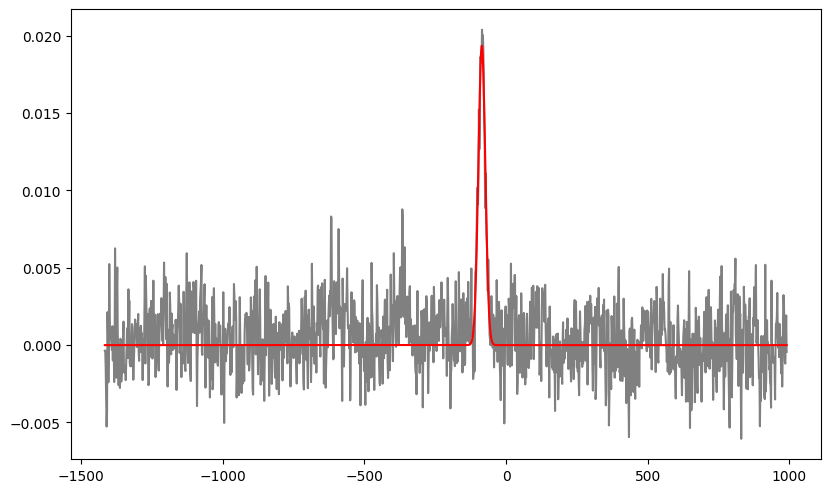

In [20]:
for i in range(len(fresult_dic['fitting'])):
    
    if (fresult_dic['loc'][i][0] == 52) and (fresult_dic['loc'][i][1] == 89):
        loc = fresult_dic['loc'][i]
        inten = data['data_list'][i]

        fit_fwhms = data_decomposed['fwhms_fit'][i]
        fit_means = data_decomposed['means_fit'][i]
        fit_amps  = data_decomposed['amplitudes_fit'][i]
        
        print(fit_means)
        print(fit_amps)
        
        fig = plt.figure(figsize=(10,6))
        ax  = fig.add_axes([0.12, 0.1, 0.75, 0.75])
        
        #plt.plot(freq_array/1e9, inten, color= 'grey')
        plt.plot(velocity_array/1e3, inten, color= 'grey', label='data')

        if len(fit_amps) > 0.:
            for j in range(len(fit_amps)):
                amp, fwhm, mean =  fit_amps[j], fit_fwhms[j], fit_means[j]
                #x = freq_array / 1e9
                x = velocity_array / 1e3
                yy = amp * np.exp(-4. * np.log(2) * (x-mean)**2 / fwhm**2)
                plt.plot(x, yy, '-', lw=1.5, color='red')
 

        x = fresult_dic['loc'][i][0]
        y = fresult_dic['loc'][i][1]
        #plt.text(0.08, 0.8, f'{i+1}', 
        #        verticalalignment = 'bottom', horizontalalignment = 'left',
        #        color = 'black', transform = ax.transAxes, fontsize = 40
        #       )
        
        #plt.legend(loc=1, fontsize=10)
        
        j=5289
        outdir = '/Users/tcc/astroimagAna/fit_0/'
        outname = f'spw0_{j}'
        path = os.path.join(outdir, outname)
        
        plt.savefig(path, transparent=False, bbox_inches='tight')
    

### **STEP 3**. Unredshift spectra

In [14]:
shifted_velo_list = []
intensity_list = []
change_0 = []

#change_nh3 = np.load('change_nh3.npy')
    
for i in range(len(fresult_dic['loc'])):
    pixel_data = data['data_list'][i]
    loc = fresult_dic['loc'][i]
    
    if fresult_dic['fitting'][i] == 's':
        ff_in_each_pixel = data_decomposed['means_fit'][i]
        
        shift_velo = s.unrbshift_spectra( freq_array = freq_array,
                                          velocity_array  = velocity_array,
                                          centroid_velo   = ff_in_each_pixel[0],
                                          rest_freq = 217.104919e9
                                        )
        
        shifted_velo_list.append(shift_velo)
        intensity_list.append(pixel_data)
        #change_0.append(delta_velo)
            
    elif fresult_dic['fitting'][i] == 'm':
        for j in range(len(data_decomposed['amplitudes_fit'][i])):
            try:
                max_index = np.argmax(data_decomposed['amplitudes_fit'][i][j]) #Find the highest peak
                velo_fit = data_decomposed['means_fit'][i][max_index]
                #print(freq_fit)
            except:
                print(loc)
                print('Failed to fit.')
        
        #print(freq_fit)
    
        shift_velo = s.unrbshift_spectra( freq_array = freq_array,
                                          velocity_array  = velocity_array,
                                          centroid_velo   = velo_fit,
                                          rest_freq = 217.104919e9
                                        )
        
        shifted_velo_list.append(shift_velo)
        intensity_list.append(pixel_data)
        #change_0.append(delta_freq)
  
np.save('change_0.npy', change_0)

use so

In [ ]:
change_1 = np.load("change_1.npy")
intensity_list = []
shifted_freq_list = []

print(freq_array/1e9,'\n')

for i in range(len(change_1)):
    shift_freq = freq_array - change_1[i]
    pixel_data = data['data_list'][i]
    #print(shift_freq/1e9)
    
    intensity_list.append(pixel_data)
    shifted_freq_list.append(shift_freq)

### **STEP 4**. Stack spectra

In [29]:
minf = min(min(freq) for freq in shifted_velo_list)
maxf = max(max(freq) for freq in shifted_velo_list)
print(minf, maxf)

mean_spacing = np.mean([np.mean(np.diff(freq)) for freq in shifted_velo_list])
points = int( (maxf - minf)/ mean_spacing)

newf_array = np.linspace(minf, maxf, points)
print(points)

-2132023.6617982453 2374633.0650750673
2868


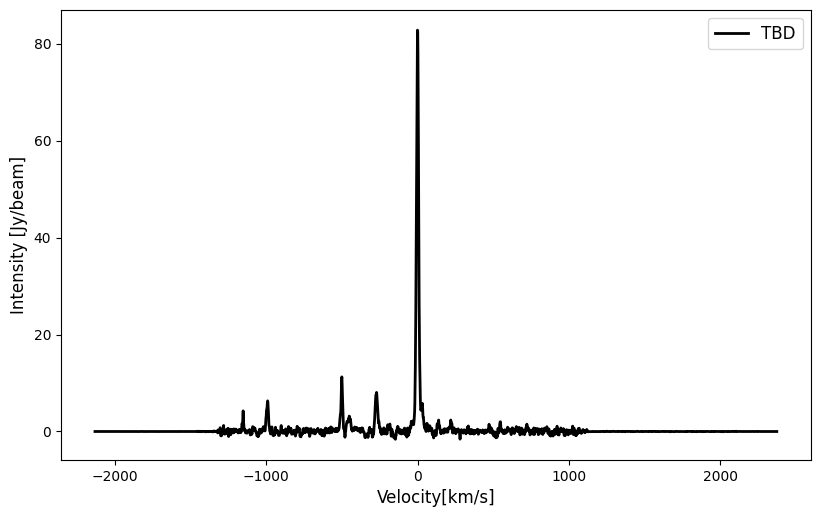

In [30]:
summed_intensity = np.zeros_like(newf_array)

for freq, inten in zip(shifted_velo_list, intensity_list):
    interp_func = interp1d(freq, inten, kind='linear', bounds_error=False, fill_value=0)
    summed_intensity += interp_func(newf_array)
    
#f.plot_spectra(newf_array/1e9, summed_intensity, figsize=(10,6), color='black')
f.plot_spectra(newf_array/1e3, summed_intensity, figsize=(10,6), color='black',xlabel='Velocity[km/s]')

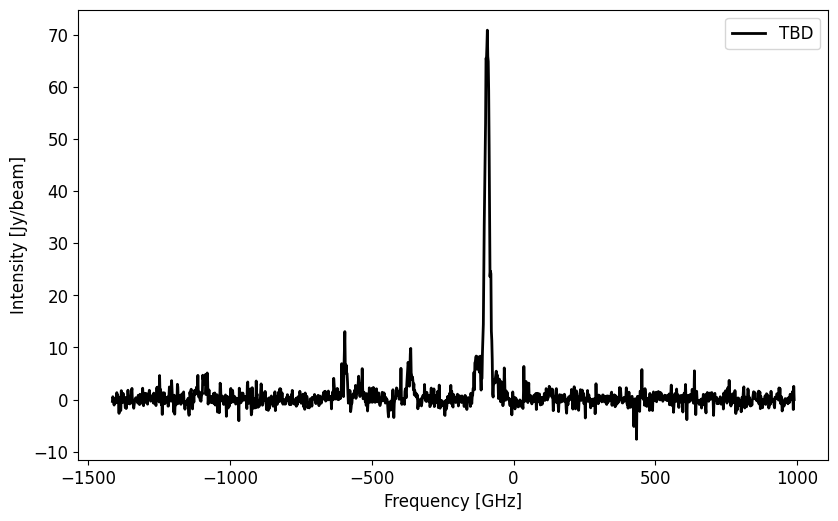

In [31]:
## Not shifted
sum_inten_noshift = []

for j in range(0,1532):
    
    temp = 0
    for inten in intensity_list:
        temp += inten[j] 

    sum_inten_noshift.append(temp)

f.plot_spectra(velocity_array/1e3, sum_inten_noshift, figsize=(10,6), color='black')
#f.plot_spectra(velocity_array/1e3, sum_inten_noshift, figsize=(10,6), color='black', xlabel='velo[km/s]')


the figures using the sio distribution

In [55]:
#restfreq /= 1e9

print(restfreq)
restf = restfreq/1e9
print(restf/1e9)

2.17104919e+20
217.104919


In [56]:
dcn_v = c * (1 - (217.238530*1e9)/restf)
print(dcn_v/1e3)

-184.49867598735062


1230 1261
774 806


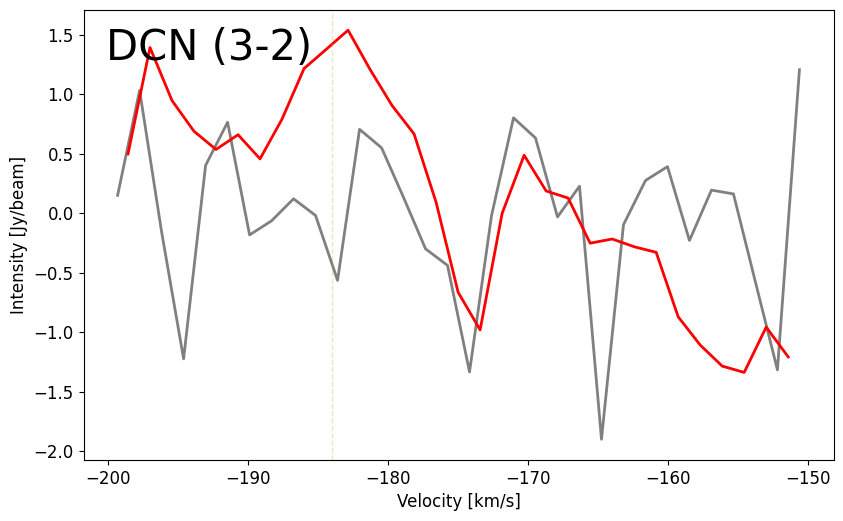

In [75]:
## View all spectra
#func.plot_spectra(newf_array/1e9, summed_intensity, figsize=(8,6), color='black')
#func.plot_spectra(freq_array/1e9, sum_inten_noshift, figsize=(8,6), color='black')

## View specific range
freqGHz_start = -200
freqGHz_end   = -150

freq_startpix = np.searchsorted(newf_array, freqGHz_start*1e3)
freq_endpix   = np.searchsorted(newf_array, freqGHz_end*1e3)

freq_start_no = np.searchsorted(velocity_array, freqGHz_start*1e3) #due to the descending array
freq_end_no   = np.searchsorted(velocity_array, freqGHz_end*1e3)

print(freq_startpix, freq_endpix)
print(freq_start_no, freq_end_no)

# Plot
sliced_f    = newf_array[freq_startpix:freq_endpix]
sliced_f_no = velocity_array[freq_start_no:freq_end_no]
sliced_inten = summed_intensity[freq_startpix:freq_endpix]
sliced_inten_noshift = sum_inten_noshift[freq_start_no:freq_end_no]

fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.xlabel('Velocity [km/s]', size = 12)
plt.ylabel('Intensity [Jy/beam]', size = 12)
#plt.xlim(-200, -150)

#sliced_v = c * (1 - (sliced_f / restfreq) )
#sliced_v_no = c * (1 - (sliced_f_no / restfreq) )

plt.plot(sliced_f_no/1e3, sliced_inten_noshift, '-', color='grey', linewidth = 2.0)
plt.plot(sliced_f/1e3, sliced_inten,'-', color='red', linewidth = 2.0)

plt.text(0.03, 0.87, 'DCN (3-2)', 
         verticalalignment = 'bottom', horizontalalignment = 'left',
         color='black', transform = ax.transAxes, fontsize=30)

#plt.legend(loc=1, fontsize = 10)

#sig = 3 * 0.0018148618
#plt.axhline(y=sig, color=(0.7,0.7,0.2, 0.3), linestyle='--',linewidth=1)
plt.axvline(x=-184, color=(0.7,0.7,0.2, 0.3), linestyle='--',linewidth=1)
#plt.axvline(x=217.10498, color=(0.7,0.7,0.2, 0.3), linestyle='--',linewidth=1)

#plt.savefig('Stack36_0_wsio.png', bbox_inches='tight')

the figures using the so distribution

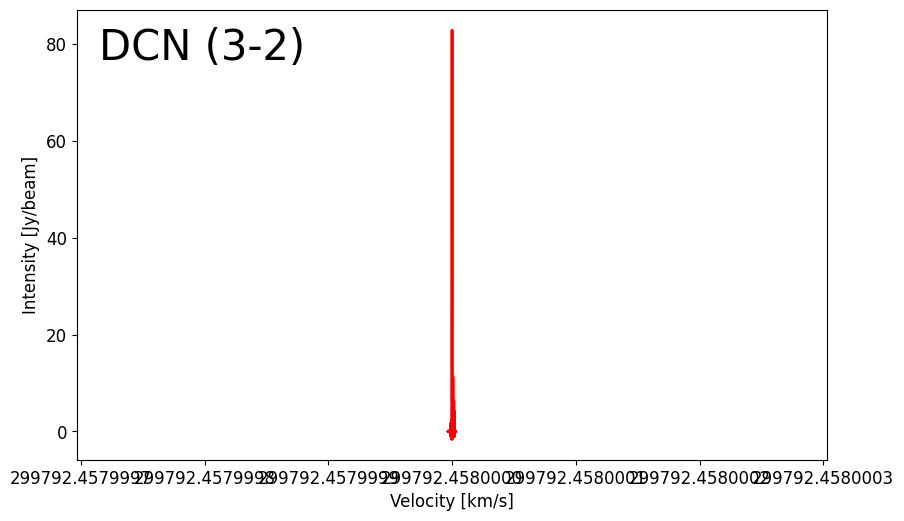

In [32]:
## View all spectra
#func.plot_spectra(newf_array/1e9, summed_intensity, figsize=(8,6), color='black')
#func.plot_spectra(freq_array/1e9, sum_inten_noshift, figsize=(8,6), color='black')

## View specific range
freqGHz_start = -500
freqGHz_end   = 500

freq_startpix = np.searchsorted(newf_array, freqGHz_start*1e9)
freq_endpix   = np.searchsorted(newf_array, freqGHz_end*1e9)

freq_start_no = np.searchsorted(-freq_array, -freqGHz_end*1e9) #due to the descending array
freq_end_no   = np.searchsorted(-freq_array, -freqGHz_start*1e9)

#print(freq_startpix, freq_endpix)
#print(freq_start_no, freq_end_no)

# Plot
sliced_f    = newf_array[freq_startpix:freq_endpix]
sliced_f_no = freq_array[freq_start_no:freq_end_no]
sliced_inten = summed_intensity[freq_startpix:freq_endpix]
sliced_inten_noshift = sum_inten_noshift[freq_start_no:freq_end_no]

fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.xlabel('Velocity [km/s]', size = 12)
plt.ylabel('Intensity [Jy/beam]', size = 12)

sliced_v = c * (1 - (sliced_f / restfreq) )
sliced_v_no = c * (1 - (sliced_f_no / restfreq) )

plt.plot(sliced_v_no/1e3, sliced_inten_noshift, '-', color='grey', linewidth = 2.0)
plt.plot(sliced_v/1e3, sliced_inten,'-', color='red', linewidth = 2.0)

plt.text(0.03, 0.87, 'DCN (3-2)', 
         verticalalignment = 'bottom', horizontalalignment = 'left',
         color='black', transform = ax.transAxes, fontsize=30)

#plt.legend(loc=1, fontsize = 10)

#sig = 3 * 0.0018148618
#plt.axhline(y=sig, color=(0.7,0.7,0.2, 0.3), linestyle='--',linewidth=1)
#plt.axvline(x=217.238, color=(0.7,0.7,0.2, 0.3), linestyle='--',linewidth=1)
#plt.axvline(x=217.10498, color=(0.7,0.7,0.2, 0.3), linestyle='--',linewidth=1)

#plt.savefig('Stack36_0_wso.png', bbox_inches='tight')

In [ ]:
## View all spectra
#func.plot_spectra(newf_array/1e9, summed_intensity, figsize=(8,6), color='black')
#func.plot_spectra(freq_array/1e9, sum_inten_noshift, figsize=(8,6), color='black')

## View specific range
velo_start = 40
velo_end   = 100

velo_startpix = np.searchsorted(newf_array, velo_start*1e3)
velo_endpix   = np.searchsorted(newf_array, velo_end*1e3)

velo_start_no = np.searchsorted(velocity_array, velo_start*1e3) #due to the descending array
velo_end_no   = np.searchsorted(velocity_array, velo_end*1e3)

print(velo_startpix, velo_endpix)
print(velo_start_no, velo_end_no)

#print(freq_startpix, freq_endpix)
#print(freq_start_no, freq_end_no)

# Plot
sliced_v     = newf_array[velo_startpix:velo_endpix]/ 1e3
sliced_v_no  = velocity_array[velo_start_no:velo_end_no]/ 1e3
sliced_inten = summed_intensity[velo_startpix:velo_endpix]
sliced_inten_noshift = sum_inten_noshift[velo_start_no:velo_end_no]

fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

#plt.xlabel('Frequency [GHz]', size = 12)
plt.xlabel('Velocity [km/s]', size = 12)
plt.ylabel('Intensity [Jy/beam]', size = 12)

plt.plot(sliced_v_no, sliced_inten_noshift, '-', color='grey', linewidth = 2.0)
plt.plot(sliced_v, sliced_inten ,'-', color='red', linewidth = 2.0)

plt.text(0.03, 0.87, 'DCN (3-2)', 
         verticalalignment = 'bottom', horizontalalignment = 'left',
         color='black', transform = ax.transAxes, fontsize=30)

#plt.legend(loc=1, fontsize = 10)

#sig = 3 * 0.0018148618
#plt.axhline(y=sig, color=(0.7,0.7,0.2, 0.3), linestyle='--',linewidth=1)
#plt.axvline(x=217.238, color=(0.7,0.7,0.2, 0.3), linestyle='--',linewidth=1)
#plt.axvline(x=217.10498, color=(0.7,0.7,0.2, 0.3), linestyle='--',linewidth=1)

#plt.savefig('Stack35_0.png', bbox_inches='tight')

In [ ]:
sliced_v = c * (1 - (sliced_f*1e9) / restfreq)
sliced_v_no = c * (1 - (sliced_f_no*1e9) / restfreq)

fig = plt.figure(figsize = (10,6))
ax = fig.add_axes([0.12, 0.1, 0.75, 0.75])
#ax.xaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.xlabel('Velocity[km/s]', size = 12)
plt.ylabel('Intensity [Jy/beam]', size = 12)

plt.plot(sliced_v_no/1e3, sliced_inten_noshift, '-', color='grey', linewidth = 2.0)
plt.plot(sliced_v/1e3, sliced_inten,'-', color='red', linewidth = 2.0)

### (Modifications needed)

In [ ]:
## Stack the spectra and plot it
sum_intensity = s.stack_spectra(verbose = False)

In [ ]:
data = pickle.load(open('cube.pickle','rb'))
data_decomposed = pickle.load(open('cube_decomposed.pickle','rb'))

for i in range(len(data_decomposed['means_fit'])): # i = pixel number(not components in each pixel)

    try:
        max_index = np.argmax(data_decomposed['amplitudes_fit'][i]) #Find the highest peak
        freq_fit = data_decomposed['means_fit'][i][max_index]
        print(freq_fit)
    except:
        print('Failed to fit.')
        
    
    intensity_array = data['data_list'][i]
    shift_freq, delta_freq = s.unrbshift_spectra( freq_array = freq_array,
                                                  velocity_array  = velocity_array,
                                                  centroid_freq   = freq_fit,
                                                  rest_freq = restfreq )

    #rest = freq_fit - delta_freq/1e9
    #func.plot_spectra(shift_freq/1e9, intensity_array,figsize=(8,6))

# produce the frequency array removing Doppler shift. 
#shift_freq = restfreq * (1 - shift_velo / c)
#func.plot_spectra(shift_freq/1e9,intensity_array, figsize=(6,4))


In [ ]:
## Plot the shifted spectra with fitting result
data = pickle.load(open('cube.pickle','rb'))
data_decomposed = pickle.load(open('cube_decomposed.pickle','rb'))

#print(data_decomposed['means_fit'])
for index in range(len(data_decomposed['means_fit'])): # index = pixel number(not components in each pixel)
        # original data
        x   = shift_freq / 1e9
        y   = data['data_list'][index]
        pix = data['location'][index]
        
        # Fitting parameter
        fit_fwhms = data_decomposed['fwhms_fit'][index]
        fit_means = data_decomposed['means_fit'][index]
        fit_amps  = data_decomposed['amplitudes_fit'][index]
        #print(fit_amps)
        #print(fit_means)
   
        fig = plt.figure()
        ax  = fig.add_axes([0.12, 0.1, 0.75, 0.75])
        
        fitcolor  = (0.8, 0.1, 0.3, 0.8)
        datacolor = (0.3,0.5,0.8, 0.5) 
        
        if len(fit_amps) > 0.:
            for j in range(len(fit_amps)):
                amp, fwhm, mean =  fit_amps[j], fit_fwhms[j], fit_means[j]
                delta_freq = freq_fit * 1e9 - restfreq 
                shift_mean = mean - delta_freq/1e9
                yy = amp * np.exp(-4. * np.log(2) * (x-shift_mean)**2 / fwhm**2)
                plt.plot(x, yy, '-', lw=1.5, color=fitcolor)
        
        xpix = pix[0]
        ypix = pix[1]
    
        xlabel = 'Frequency [GHz]'    
        xlabel_size = 12
        ylabel = 'Intensity [Jy/beam]'
        ylabel_size = 12
        fontsize = 12
                
        plt.plot(x, y, color= datacolor)
        #ax.set_xlim(0,1532)
        #plt.xlabel('Velocity[km/s]')
        plt.xlabel(xlabel, size = xlabel_size)
        plt.ylabel(ylabel, size = ylabel_size)
        
        plt.legend(loc=1, fontsize = fontsize)
        
        plt.show()